In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet101)

2024-02-24 11:53:19.685840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:53:19.685936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:53:19.817961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet101(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet101"+s+".keras")
    

    # save model to disk
    filename = "ResNet101" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet101 (Functional)      (None, 4)                 42666372  


Total params: 42666372 (162.76 MB)


Trainable params: 42561028 (162.36 MB)


Non-trainable params: 105344 (411.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708775663.602021      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 2:42:08 - loss: 1.4072 - accuracy: 0.6875

  2/140 [..............................] - ETA: 32s - loss: 1.9032 - accuracy: 0.5156    

  3/140 [..............................] - ETA: 32s - loss: 3.7527 - accuracy: 0.4792

  4/140 [..............................] - ETA: 31s - loss: 4.2917 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 31s - loss: 3.8105 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 31s - loss: 3.6721 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 31s - loss: 3.8210 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 30s - loss: 3.8904 - accuracy: 0.4219

  9/140 [>.............................] - ETA: 30s - loss: 3.7137 - accuracy: 0.3993

 10/140 [=>............................] - ETA: 30s - loss: 3.5261 - accuracy: 0.4031

 11/140 [=>............................] - ETA: 30s - loss: 3.3793 - accuracy: 0.4062

 12/140 [=>............................] - ETA: 29s - loss: 3.2453 - accuracy: 0.4089

 13/140 [=>............................] - ETA: 29s - loss: 3.1141 - accuracy: 0.4087

 14/140 [==>...........................] - ETA: 29s - loss: 3.0097 - accuracy: 0.4062

 15/140 [==>...........................] - ETA: 29s - loss: 2.9008 - accuracy: 0.4146

 16/140 [==>...........................] - ETA: 28s - loss: 2.8169 - accuracy: 0.4160

 17/140 [==>...........................] - ETA: 28s - loss: 2.7321 - accuracy: 0.4210

 18/140 [==>...........................] - ETA: 28s - loss: 2.6301 - accuracy: 0.4236

 19/140 [===>..........................] - ETA: 28s - loss: 2.5666 - accuracy: 0.4260

 20/140 [===>..........................] - ETA: 28s - loss: 2.5044 - accuracy: 0.4297

 21/140 [===>..........................] - ETA: 27s - loss: 2.4590 - accuracy: 0.4182

 22/140 [===>..........................] - ETA: 27s - loss: 2.4020 - accuracy: 0.4176

 23/140 [===>..........................] - ETA: 27s - loss: 2.3533 - accuracy: 0.4130

 24/140 [====>.........................] - ETA: 27s - loss: 2.3074 - accuracy: 0.4036

 25/140 [====>.........................] - ETA: 26s - loss: 2.2594 - accuracy: 0.4013

 26/140 [====>.........................] - ETA: 26s - loss: 2.2236 - accuracy: 0.3966

 27/140 [====>.........................] - ETA: 26s - loss: 2.1814 - accuracy: 0.3970

 28/140 [=====>........................] - ETA: 26s - loss: 2.1445 - accuracy: 0.3984

 29/140 [=====>........................] - ETA: 25s - loss: 2.1021 - accuracy: 0.4052

 30/140 [=====>........................] - ETA: 25s - loss: 2.0632 - accuracy: 0.4115

 31/140 [=====>........................] - ETA: 25s - loss: 2.0226 - accuracy: 0.4214

 32/140 [=====>........................] - ETA: 25s - loss: 1.9976 - accuracy: 0.4209

 33/140 [======>.......................] - ETA: 24s - loss: 1.9673 - accuracy: 0.4233

 34/140 [======>.......................] - ETA: 24s - loss: 1.9556 - accuracy: 0.4191

 35/140 [======>.......................] - ETA: 24s - loss: 1.9336 - accuracy: 0.4179

 36/140 [======>.......................] - ETA: 24s - loss: 1.9089 - accuracy: 0.4167

 37/140 [======>.......................] - ETA: 24s - loss: 1.8980 - accuracy: 0.4105

 38/140 [=======>......................] - ETA: 23s - loss: 1.8793 - accuracy: 0.4095

 39/140 [=======>......................] - ETA: 23s - loss: 1.8636 - accuracy: 0.4103

 40/140 [=======>......................] - ETA: 23s - loss: 1.8413 - accuracy: 0.4125

 41/140 [=======>......................] - ETA: 23s - loss: 1.8245 - accuracy: 0.4139

 42/140 [========>.....................] - ETA: 22s - loss: 1.8091 - accuracy: 0.4167

 43/140 [========>.....................] - ETA: 22s - loss: 1.7939 - accuracy: 0.4186

 44/140 [========>.....................] - ETA: 22s - loss: 1.7785 - accuracy: 0.4212

 45/140 [========>.....................] - ETA: 22s - loss: 1.7651 - accuracy: 0.4208

 46/140 [========>.....................] - ETA: 21s - loss: 1.7560 - accuracy: 0.4226

 47/140 [=========>....................] - ETA: 21s - loss: 1.7469 - accuracy: 0.4229

 48/140 [=========>....................] - ETA: 21s - loss: 1.7334 - accuracy: 0.4225

 49/140 [=========>....................] - ETA: 21s - loss: 1.7190 - accuracy: 0.4216

 50/140 [=========>....................] - ETA: 20s - loss: 1.7054 - accuracy: 0.4250

 51/140 [=========>....................] - ETA: 20s - loss: 1.6930 - accuracy: 0.4283

 52/140 [==========>...................] - ETA: 20s - loss: 1.6795 - accuracy: 0.4297

 53/140 [==========>...................] - ETA: 20s - loss: 1.6675 - accuracy: 0.4322

 54/140 [==========>...................] - ETA: 20s - loss: 1.6553 - accuracy: 0.4352

 55/140 [==========>...................] - ETA: 19s - loss: 1.6435 - accuracy: 0.4369

 56/140 [===========>..................] - ETA: 19s - loss: 1.6302 - accuracy: 0.4420

 57/140 [===========>..................] - ETA: 19s - loss: 1.6249 - accuracy: 0.4424

 58/140 [===========>..................] - ETA: 19s - loss: 1.6133 - accuracy: 0.4418

 59/140 [===========>..................] - ETA: 18s - loss: 1.6085 - accuracy: 0.4386

 60/140 [===========>..................] - ETA: 18s - loss: 1.5983 - accuracy: 0.4385

 61/140 [============>.................] - ETA: 18s - loss: 1.5864 - accuracy: 0.4426

 62/140 [============>.................] - ETA: 18s - loss: 1.5760 - accuracy: 0.4441

 63/140 [============>.................] - ETA: 17s - loss: 1.5666 - accuracy: 0.4469

 64/140 [============>.................] - ETA: 17s - loss: 1.5566 - accuracy: 0.4478

 65/140 [============>.................] - ETA: 17s - loss: 1.5513 - accuracy: 0.4505

 66/140 [=============>................] - ETA: 17s - loss: 1.5418 - accuracy: 0.4522

 67/140 [=============>................] - ETA: 17s - loss: 1.5322 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 16s - loss: 1.5343 - accuracy: 0.4513

 69/140 [=============>................] - ETA: 16s - loss: 1.5258 - accuracy: 0.4534

 70/140 [==============>...............] - ETA: 16s - loss: 1.5159 - accuracy: 0.4558

 71/140 [==============>...............] - ETA: 16s - loss: 1.5115 - accuracy: 0.4560

 72/140 [==============>...............] - ETA: 15s - loss: 1.5033 - accuracy: 0.4579

 73/140 [==============>...............] - ETA: 15s - loss: 1.4928 - accuracy: 0.4619

 74/140 [==============>...............] - ETA: 15s - loss: 1.4853 - accuracy: 0.4641

 75/140 [===============>..............] - ETA: 15s - loss: 1.4776 - accuracy: 0.4671

 76/140 [===============>..............] - ETA: 14s - loss: 1.4722 - accuracy: 0.4675

 77/140 [===============>..............] - ETA: 14s - loss: 1.4646 - accuracy: 0.4696

 78/140 [===============>..............] - ETA: 14s - loss: 1.4564 - accuracy: 0.4716

 79/140 [===============>..............] - ETA: 14s - loss: 1.4617 - accuracy: 0.4711

 80/140 [================>.............] - ETA: 13s - loss: 1.4542 - accuracy: 0.4723

 81/140 [================>.............] - ETA: 13s - loss: 1.4460 - accuracy: 0.4738

 82/140 [================>.............] - ETA: 13s - loss: 1.4393 - accuracy: 0.4748

 83/140 [================>.............] - ETA: 13s - loss: 1.4343 - accuracy: 0.4752

 84/140 [=================>............] - ETA: 13s - loss: 1.4300 - accuracy: 0.4747

 85/140 [=================>............] - ETA: 12s - loss: 1.4240 - accuracy: 0.4754

 86/140 [=================>............] - ETA: 12s - loss: 1.4181 - accuracy: 0.4775

 87/140 [=================>............] - ETA: 12s - loss: 1.4133 - accuracy: 0.4784

 88/140 [=================>............] - ETA: 12s - loss: 1.4089 - accuracy: 0.4798

 89/140 [==================>...........] - ETA: 11s - loss: 1.4107 - accuracy: 0.4800

 90/140 [==================>...........] - ETA: 11s - loss: 1.4055 - accuracy: 0.4806

 91/140 [==================>...........] - ETA: 11s - loss: 1.3997 - accuracy: 0.4815

 92/140 [==================>...........] - ETA: 11s - loss: 1.3942 - accuracy: 0.4827

 93/140 [==================>...........] - ETA: 10s - loss: 1.3883 - accuracy: 0.4839

 94/140 [===================>..........] - ETA: 10s - loss: 1.3828 - accuracy: 0.4844

 95/140 [===================>..........] - ETA: 10s - loss: 1.3787 - accuracy: 0.4849

 96/140 [===================>..........] - ETA: 10s - loss: 1.3721 - accuracy: 0.4863

 97/140 [===================>..........] - ETA: 10s - loss: 1.3678 - accuracy: 0.4878

 98/140 [====================>.........] - ETA: 9s - loss: 1.3659 - accuracy: 0.4869 

 99/140 [====================>.........] - ETA: 9s - loss: 1.3587 - accuracy: 0.4896

100/140 [====================>.........] - ETA: 9s - loss: 1.3543 - accuracy: 0.4900

101/140 [====================>.........] - ETA: 9s - loss: 1.3495 - accuracy: 0.4910

102/140 [====================>.........] - ETA: 8s - loss: 1.3465 - accuracy: 0.4908

103/140 [=====================>........] - ETA: 8s - loss: 1.3409 - accuracy: 0.4930

104/140 [=====================>........] - ETA: 8s - loss: 1.3373 - accuracy: 0.4937

105/140 [=====================>........] - ETA: 8s - loss: 1.3341 - accuracy: 0.4949

106/140 [=====================>........] - ETA: 7s - loss: 1.3293 - accuracy: 0.4965

107/140 [=====================>........] - ETA: 7s - loss: 1.3261 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 7s - loss: 1.3238 - accuracy: 0.4959

109/140 [======================>.......] - ETA: 7s - loss: 1.3215 - accuracy: 0.4960

110/140 [======================>.......] - ETA: 6s - loss: 1.3190 - accuracy: 0.4963

111/140 [======================>.......] - ETA: 6s - loss: 1.3153 - accuracy: 0.4966

112/140 [=======================>......] - ETA: 6s - loss: 1.3127 - accuracy: 0.4964

113/140 [=======================>......] - ETA: 6s - loss: 1.3086 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 6s - loss: 1.3050 - accuracy: 0.4984

115/140 [=======================>......] - ETA: 5s - loss: 1.3016 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 5s - loss: 1.2976 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 5s - loss: 1.2950 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 5s - loss: 1.2909 - accuracy: 0.5005

119/140 [========================>.....] - ETA: 4s - loss: 1.2875 - accuracy: 0.5005

120/140 [========================>.....] - ETA: 4s - loss: 1.2882 - accuracy: 0.4997

121/140 [========================>.....] - ETA: 4s - loss: 1.2845 - accuracy: 0.5000

122/140 [=========================>....] - ETA: 4s - loss: 1.2810 - accuracy: 0.5008

123/140 [=========================>....] - ETA: 3s - loss: 1.2773 - accuracy: 0.5013

124/140 [=========================>....] - ETA: 3s - loss: 1.2751 - accuracy: 0.5025

125/140 [=========================>....] - ETA: 3s - loss: 1.2725 - accuracy: 0.5020

126/140 [==========================>...] - ETA: 3s - loss: 1.2687 - accuracy: 0.5027

127/140 [==========================>...] - ETA: 3s - loss: 1.2659 - accuracy: 0.5027

128/140 [==========================>...] - ETA: 2s - loss: 1.2634 - accuracy: 0.5029

129/140 [==========================>...] - ETA: 2s - loss: 1.2600 - accuracy: 0.5034

130/140 [==========================>...] - ETA: 2s - loss: 1.2581 - accuracy: 0.5036

131/140 [===========================>..] - ETA: 2s - loss: 1.2553 - accuracy: 0.5036

132/140 [===========================>..] - ETA: 1s - loss: 1.2551 - accuracy: 0.5038

133/140 [===========================>..] - ETA: 1s - loss: 1.2522 - accuracy: 0.5042

134/140 [===========================>..] - ETA: 1s - loss: 1.2486 - accuracy: 0.5058

135/140 [===========================>..] - ETA: 1s - loss: 1.2481 - accuracy: 0.5063

136/140 [============================>.] - ETA: 0s - loss: 1.2498 - accuracy: 0.5062

137/140 [============================>.] - ETA: 0s - loss: 1.2465 - accuracy: 0.5073

138/140 [============================>.] - ETA: 0s - loss: 1.2438 - accuracy: 0.5077

139/140 [============================>.] - ETA: 0s - loss: 1.2416 - accuracy: 0.5081

140/140 [==============================] - ETA: 0s - loss: 1.2406 - accuracy: 0.5085

140/140 [==============================] - 110s 288ms/step - loss: 1.2406 - accuracy: 0.5085 - val_loss: 1.0547 - val_accuracy: 0.5121


Epoch 2/30


  1/140 [..............................] - ETA: 56s - loss: 1.2631 - accuracy: 0.4688

  2/140 [..............................] - ETA: 32s - loss: 1.1825 - accuracy: 0.4844

  3/140 [..............................] - ETA: 32s - loss: 1.0567 - accuracy: 0.5104

  4/140 [..............................] - ETA: 31s - loss: 1.0343 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 31s - loss: 1.0701 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 31s - loss: 1.1153 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 31s - loss: 1.1065 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 30s - loss: 1.0646 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 30s - loss: 1.0400 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 30s - loss: 1.0441 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 30s - loss: 1.0382 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 29s - loss: 1.0207 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 29s - loss: 1.0265 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 29s - loss: 1.0229 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 29s - loss: 1.0159 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 28s - loss: 1.0059 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 28s - loss: 0.9964 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 28s - loss: 0.9949 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 28s - loss: 0.9959 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 28s - loss: 0.9912 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 27s - loss: 0.9809 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 27s - loss: 0.9749 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 27s - loss: 0.9731 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 27s - loss: 0.9681 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 26s - loss: 0.9745 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 26s - loss: 0.9720 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 26s - loss: 0.9693 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 26s - loss: 0.9641 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 25s - loss: 0.9609 - accuracy: 0.5485

 30/140 [=====>........................] - ETA: 25s - loss: 0.9607 - accuracy: 0.5469

 31/140 [=====>........................] - ETA: 25s - loss: 0.9640 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 25s - loss: 0.9667 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 25s - loss: 0.9591 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 24s - loss: 0.9623 - accuracy: 0.5460

 35/140 [======>.......................] - ETA: 24s - loss: 0.9580 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 24s - loss: 0.9554 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 24s - loss: 0.9526 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 23s - loss: 0.9490 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 23s - loss: 0.9494 - accuracy: 0.5457

 40/140 [=======>......................] - ETA: 23s - loss: 0.9460 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 23s - loss: 0.9415 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 22s - loss: 0.9430 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 22s - loss: 0.9406 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 22s - loss: 0.9342 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 22s - loss: 0.9379 - accuracy: 0.5556

 46/140 [========>.....................] - ETA: 22s - loss: 0.9404 - accuracy: 0.5571

 47/140 [=========>....................] - ETA: 21s - loss: 0.9402 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 21s - loss: 0.9397 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 21s - loss: 0.9380 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 21s - loss: 0.9326 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 20s - loss: 0.9359 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 20s - loss: 0.9378 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 20s - loss: 0.9354 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 20s - loss: 0.9340 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 19s - loss: 0.9440 - accuracy: 0.5625

 56/140 [===========>..................] - ETA: 19s - loss: 0.9438 - accuracy: 0.5625

 57/140 [===========>..................] - ETA: 19s - loss: 0.9455 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 19s - loss: 0.9513 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 18s - loss: 0.9523 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 18s - loss: 0.9505 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 18s - loss: 0.9521 - accuracy: 0.5635

 62/140 [============>.................] - ETA: 18s - loss: 0.9500 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 18s - loss: 0.9527 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 17s - loss: 0.9496 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 17s - loss: 0.9557 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 17s - loss: 0.9618 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 17s - loss: 0.9618 - accuracy: 0.5616

 68/140 [=============>................] - ETA: 16s - loss: 0.9613 - accuracy: 0.5634

 69/140 [=============>................] - ETA: 16s - loss: 0.9601 - accuracy: 0.5643

 70/140 [==============>...............] - ETA: 16s - loss: 0.9578 - accuracy: 0.5652

 71/140 [==============>...............] - ETA: 16s - loss: 0.9529 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 15s - loss: 0.9506 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 15s - loss: 0.9496 - accuracy: 0.5698

 74/140 [==============>...............] - ETA: 15s - loss: 0.9504 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 15s - loss: 0.9566 - accuracy: 0.5663

 76/140 [===============>..............] - ETA: 14s - loss: 0.9560 - accuracy: 0.5650

 77/140 [===============>..............] - ETA: 14s - loss: 0.9554 - accuracy: 0.5662

 78/140 [===============>..............] - ETA: 14s - loss: 0.9555 - accuracy: 0.5653

 79/140 [===============>..............] - ETA: 14s - loss: 0.9549 - accuracy: 0.5653

 80/140 [================>.............] - ETA: 14s - loss: 0.9584 - accuracy: 0.5645

 81/140 [================>.............] - ETA: 13s - loss: 0.9570 - accuracy: 0.5648

 82/140 [================>.............] - ETA: 13s - loss: 0.9550 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 13s - loss: 0.9526 - accuracy: 0.5689

 84/140 [=================>............] - ETA: 13s - loss: 0.9514 - accuracy: 0.5692

 85/140 [=================>............] - ETA: 12s - loss: 0.9535 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 12s - loss: 0.9531 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 12s - loss: 0.9514 - accuracy: 0.5690

 88/140 [=================>............] - ETA: 12s - loss: 0.9488 - accuracy: 0.5714

 89/140 [==================>...........] - ETA: 11s - loss: 0.9503 - accuracy: 0.5716

 90/140 [==================>...........] - ETA: 11s - loss: 0.9479 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 11s - loss: 0.9483 - accuracy: 0.5721

 92/140 [==================>...........] - ETA: 11s - loss: 0.9460 - accuracy: 0.5724

 93/140 [==================>...........] - ETA: 11s - loss: 0.9463 - accuracy: 0.5726

 94/140 [===================>..........] - ETA: 10s - loss: 0.9456 - accuracy: 0.5725

 95/140 [===================>..........] - ETA: 10s - loss: 0.9447 - accuracy: 0.5737

 96/140 [===================>..........] - ETA: 10s - loss: 0.9413 - accuracy: 0.5758

 97/140 [===================>..........] - ETA: 10s - loss: 0.9417 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 9s - loss: 0.9397 - accuracy: 0.5756 

 99/140 [====================>.........] - ETA: 9s - loss: 0.9398 - accuracy: 0.5748

100/140 [====================>.........] - ETA: 9s - loss: 0.9382 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 9s - loss: 0.9385 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 8s - loss: 0.9366 - accuracy: 0.5772

103/140 [=====================>........] - ETA: 8s - loss: 0.9358 - accuracy: 0.5777

104/140 [=====================>........] - ETA: 8s - loss: 0.9335 - accuracy: 0.5790

105/140 [=====================>........] - ETA: 8s - loss: 0.9321 - accuracy: 0.5792

106/140 [=====================>........] - ETA: 7s - loss: 0.9306 - accuracy: 0.5793

107/140 [=====================>........] - ETA: 7s - loss: 0.9304 - accuracy: 0.5797

108/140 [======================>.......] - ETA: 7s - loss: 0.9285 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 7s - loss: 0.9291 - accuracy: 0.5808

110/140 [======================>.......] - ETA: 7s - loss: 0.9287 - accuracy: 0.5807

111/140 [======================>.......] - ETA: 6s - loss: 0.9327 - accuracy: 0.5791

112/140 [=======================>......] - ETA: 6s - loss: 0.9315 - accuracy: 0.5798

113/140 [=======================>......] - ETA: 6s - loss: 0.9303 - accuracy: 0.5799

114/140 [=======================>......] - ETA: 6s - loss: 0.9309 - accuracy: 0.5792

115/140 [=======================>......] - ETA: 5s - loss: 0.9334 - accuracy: 0.5793

116/140 [=======================>......] - ETA: 5s - loss: 0.9328 - accuracy: 0.5781

117/140 [========================>.....] - ETA: 5s - loss: 0.9339 - accuracy: 0.5772

118/140 [========================>.....] - ETA: 5s - loss: 0.9320 - accuracy: 0.5784

119/140 [========================>.....] - ETA: 4s - loss: 0.9314 - accuracy: 0.5785

120/140 [========================>.....] - ETA: 4s - loss: 0.9303 - accuracy: 0.5786

121/140 [========================>.....] - ETA: 4s - loss: 0.9290 - accuracy: 0.5788

122/140 [=========================>....] - ETA: 4s - loss: 0.9314 - accuracy: 0.5784

123/140 [=========================>....] - ETA: 3s - loss: 0.9295 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 3s - loss: 0.9290 - accuracy: 0.5791

125/140 [=========================>....] - ETA: 3s - loss: 0.9302 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 3s - loss: 0.9314 - accuracy: 0.5774

127/140 [==========================>...] - ETA: 3s - loss: 0.9296 - accuracy: 0.5782

128/140 [==========================>...] - ETA: 2s - loss: 0.9291 - accuracy: 0.5779

129/140 [==========================>...] - ETA: 2s - loss: 0.9269 - accuracy: 0.5792

130/140 [==========================>...] - ETA: 2s - loss: 0.9256 - accuracy: 0.5798

131/140 [===========================>..] - ETA: 2s - loss: 0.9259 - accuracy: 0.5797

132/140 [===========================>..] - ETA: 1s - loss: 0.9254 - accuracy: 0.5795

133/140 [===========================>..] - ETA: 1s - loss: 0.9248 - accuracy: 0.5799

134/140 [===========================>..] - ETA: 1s - loss: 0.9246 - accuracy: 0.5798

135/140 [===========================>..] - ETA: 1s - loss: 0.9218 - accuracy: 0.5810

136/140 [============================>.] - ETA: 0s - loss: 0.9202 - accuracy: 0.5813

137/140 [============================>.] - ETA: 0s - loss: 0.9215 - accuracy: 0.5805

138/140 [============================>.] - ETA: 0s - loss: 0.9212 - accuracy: 0.5811

139/140 [============================>.] - ETA: 0s - loss: 0.9187 - accuracy: 0.5814

140/140 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.5810

140/140 [==============================] - 36s 254ms/step - loss: 0.9193 - accuracy: 0.5810 - val_loss: 1.1057 - val_accuracy: 0.5012


Epoch 3/30


  1/140 [..............................] - ETA: 53s - loss: 0.8545 - accuracy: 0.6875

  2/140 [..............................] - ETA: 32s - loss: 1.0880 - accuracy: 0.6250

  3/140 [..............................] - ETA: 32s - loss: 1.0344 - accuracy: 0.6146

  4/140 [..............................] - ETA: 32s - loss: 0.9702 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 31s - loss: 0.9671 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 31s - loss: 0.9564 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 31s - loss: 1.0077 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 30s - loss: 1.0237 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 30s - loss: 0.9842 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 30s - loss: 0.9656 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 30s - loss: 0.9643 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 30s - loss: 0.9645 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 29s - loss: 0.9614 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 29s - loss: 0.9457 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 29s - loss: 0.9659 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 29s - loss: 0.9637 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 28s - loss: 0.9654 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 28s - loss: 0.9524 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 28s - loss: 0.9411 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 28s - loss: 0.9476 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 27s - loss: 0.9421 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 27s - loss: 0.9355 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 27s - loss: 0.9282 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 27s - loss: 0.9239 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 26s - loss: 0.9188 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 26s - loss: 0.9186 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 26s - loss: 0.9136 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 26s - loss: 0.9083 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 25s - loss: 0.9037 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 25s - loss: 0.9037 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 25s - loss: 0.9022 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 25s - loss: 0.9012 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 25s - loss: 0.8964 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 24s - loss: 0.8895 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 24s - loss: 0.8943 - accuracy: 0.5768

 36/140 [======>.......................] - ETA: 24s - loss: 0.8994 - accuracy: 0.5755

 37/140 [======>.......................] - ETA: 24s - loss: 0.8954 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 23s - loss: 0.8914 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 23s - loss: 0.8845 - accuracy: 0.5825

 40/140 [=======>......................] - ETA: 23s - loss: 0.8789 - accuracy: 0.5859

 41/140 [=======>......................] - ETA: 23s - loss: 0.8832 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 22s - loss: 0.8794 - accuracy: 0.5863

 43/140 [========>.....................] - ETA: 22s - loss: 0.8817 - accuracy: 0.5828

 44/140 [========>.....................] - ETA: 22s - loss: 0.8747 - accuracy: 0.5881

 45/140 [========>.....................] - ETA: 22s - loss: 0.8693 - accuracy: 0.5910

 46/140 [========>.....................] - ETA: 22s - loss: 0.8675 - accuracy: 0.5897

 47/140 [=========>....................] - ETA: 21s - loss: 0.8690 - accuracy: 0.5891

 48/140 [=========>....................] - ETA: 21s - loss: 0.8725 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 21s - loss: 0.8706 - accuracy: 0.5886

 50/140 [=========>....................] - ETA: 21s - loss: 0.8727 - accuracy: 0.5906

 51/140 [=========>....................] - ETA: 20s - loss: 0.8697 - accuracy: 0.5913

 52/140 [==========>...................] - ETA: 20s - loss: 0.8717 - accuracy: 0.5889

 53/140 [==========>...................] - ETA: 20s - loss: 0.8726 - accuracy: 0.5879

 54/140 [==========>...................] - ETA: 20s - loss: 0.8722 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 19s - loss: 0.8695 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 19s - loss: 0.8666 - accuracy: 0.5932

 57/140 [===========>..................] - ETA: 19s - loss: 0.8649 - accuracy: 0.5948

 58/140 [===========>..................] - ETA: 19s - loss: 0.8614 - accuracy: 0.5970

 59/140 [===========>..................] - ETA: 18s - loss: 0.8654 - accuracy: 0.5969

 60/140 [===========>..................] - ETA: 18s - loss: 0.8643 - accuracy: 0.5969

 61/140 [============>.................] - ETA: 18s - loss: 0.8615 - accuracy: 0.5994

 62/140 [============>.................] - ETA: 18s - loss: 0.8629 - accuracy: 0.5983

 63/140 [============>.................] - ETA: 18s - loss: 0.8618 - accuracy: 0.5987

 64/140 [============>.................] - ETA: 17s - loss: 0.8644 - accuracy: 0.5977

 65/140 [============>.................] - ETA: 17s - loss: 0.8686 - accuracy: 0.5981

 66/140 [=============>................] - ETA: 17s - loss: 0.8670 - accuracy: 0.5999

 67/140 [=============>................] - ETA: 17s - loss: 0.8642 - accuracy: 0.6017

 68/140 [=============>................] - ETA: 16s - loss: 0.8606 - accuracy: 0.6029

 69/140 [=============>................] - ETA: 16s - loss: 0.8589 - accuracy: 0.6042

 70/140 [==============>...............] - ETA: 16s - loss: 0.8565 - accuracy: 0.6054

 71/140 [==============>...............] - ETA: 16s - loss: 0.8537 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 15s - loss: 0.8543 - accuracy: 0.6055

 73/140 [==============>...............] - ETA: 15s - loss: 0.8488 - accuracy: 0.6096

 74/140 [==============>...............] - ETA: 15s - loss: 0.8488 - accuracy: 0.6102

 75/140 [===============>..............] - ETA: 15s - loss: 0.8467 - accuracy: 0.6125

 76/140 [===============>..............] - ETA: 14s - loss: 0.8460 - accuracy: 0.6131

 77/140 [===============>..............] - ETA: 14s - loss: 0.8466 - accuracy: 0.6132

 78/140 [===============>..............] - ETA: 14s - loss: 0.8474 - accuracy: 0.6130

 79/140 [===============>..............] - ETA: 14s - loss: 0.8443 - accuracy: 0.6151

 80/140 [================>.............] - ETA: 14s - loss: 0.8480 - accuracy: 0.6141

 81/140 [================>.............] - ETA: 13s - loss: 0.8457 - accuracy: 0.6154

 82/140 [================>.............] - ETA: 13s - loss: 0.8426 - accuracy: 0.6170

 83/140 [================>.............] - ETA: 13s - loss: 0.8406 - accuracy: 0.6178

 84/140 [=================>............] - ETA: 13s - loss: 0.8436 - accuracy: 0.6172

 85/140 [=================>............] - ETA: 12s - loss: 0.8421 - accuracy: 0.6180

 86/140 [=================>............] - ETA: 12s - loss: 0.8387 - accuracy: 0.6203

 87/140 [=================>............] - ETA: 12s - loss: 0.8385 - accuracy: 0.6207

 88/140 [=================>............] - ETA: 12s - loss: 0.8379 - accuracy: 0.6197

 89/140 [==================>...........] - ETA: 11s - loss: 0.8352 - accuracy: 0.6218

 90/140 [==================>...........] - ETA: 11s - loss: 0.8355 - accuracy: 0.6212

 91/140 [==================>...........] - ETA: 11s - loss: 0.8371 - accuracy: 0.6209

 92/140 [==================>...........] - ETA: 11s - loss: 0.8371 - accuracy: 0.6223

 93/140 [==================>...........] - ETA: 11s - loss: 0.8347 - accuracy: 0.6240

 94/140 [===================>..........] - ETA: 10s - loss: 0.8344 - accuracy: 0.6243

 95/140 [===================>..........] - ETA: 10s - loss: 0.8338 - accuracy: 0.6247

 96/140 [===================>..........] - ETA: 10s - loss: 0.8345 - accuracy: 0.6253

 97/140 [===================>..........] - ETA: 10s - loss: 0.8333 - accuracy: 0.6256

 98/140 [====================>.........] - ETA: 9s - loss: 0.8300 - accuracy: 0.6276 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8279 - accuracy: 0.6282

100/140 [====================>.........] - ETA: 9s - loss: 0.8242 - accuracy: 0.6300

101/140 [====================>.........] - ETA: 9s - loss: 0.8225 - accuracy: 0.6296

102/140 [====================>.........] - ETA: 8s - loss: 0.8223 - accuracy: 0.6290

103/140 [=====================>........] - ETA: 8s - loss: 0.8220 - accuracy: 0.6296

104/140 [=====================>........] - ETA: 8s - loss: 0.8193 - accuracy: 0.6307

105/140 [=====================>........] - ETA: 8s - loss: 0.8173 - accuracy: 0.6315

106/140 [=====================>........] - ETA: 7s - loss: 0.8155 - accuracy: 0.6324

107/140 [=====================>........] - ETA: 7s - loss: 0.8144 - accuracy: 0.6335

108/140 [======================>.......] - ETA: 7s - loss: 0.8172 - accuracy: 0.6328

109/140 [======================>.......] - ETA: 7s - loss: 0.8153 - accuracy: 0.6336

110/140 [======================>.......] - ETA: 7s - loss: 0.8132 - accuracy: 0.6355

111/140 [======================>.......] - ETA: 6s - loss: 0.8114 - accuracy: 0.6365

112/140 [=======================>......] - ETA: 6s - loss: 0.8117 - accuracy: 0.6364

113/140 [=======================>......] - ETA: 6s - loss: 0.8116 - accuracy: 0.6374

114/140 [=======================>......] - ETA: 6s - loss: 0.8101 - accuracy: 0.6384

115/140 [=======================>......] - ETA: 5s - loss: 0.8087 - accuracy: 0.6394

116/140 [=======================>......] - ETA: 5s - loss: 0.8076 - accuracy: 0.6406

117/140 [========================>.....] - ETA: 5s - loss: 0.8077 - accuracy: 0.6405

118/140 [========================>.....] - ETA: 5s - loss: 0.8052 - accuracy: 0.6414

119/140 [========================>.....] - ETA: 4s - loss: 0.8048 - accuracy: 0.6410

120/140 [========================>.....] - ETA: 4s - loss: 0.8063 - accuracy: 0.6409

121/140 [========================>.....] - ETA: 4s - loss: 0.8057 - accuracy: 0.6410

122/140 [=========================>....] - ETA: 4s - loss: 0.8046 - accuracy: 0.6414

123/140 [=========================>....] - ETA: 3s - loss: 0.8052 - accuracy: 0.6415

124/140 [=========================>....] - ETA: 3s - loss: 0.8055 - accuracy: 0.6409

125/140 [=========================>....] - ETA: 3s - loss: 0.8059 - accuracy: 0.6405

126/140 [==========================>...] - ETA: 3s - loss: 0.8054 - accuracy: 0.6404

127/140 [==========================>...] - ETA: 3s - loss: 0.8055 - accuracy: 0.6405

128/140 [==========================>...] - ETA: 2s - loss: 0.8061 - accuracy: 0.6404

129/140 [==========================>...] - ETA: 2s - loss: 0.8055 - accuracy: 0.6403

130/140 [==========================>...] - ETA: 2s - loss: 0.8040 - accuracy: 0.6399

131/140 [===========================>..] - ETA: 2s - loss: 0.8023 - accuracy: 0.6405

132/140 [===========================>..] - ETA: 1s - loss: 0.8006 - accuracy: 0.6416

133/140 [===========================>..] - ETA: 1s - loss: 0.7986 - accuracy: 0.6431

134/140 [===========================>..] - ETA: 1s - loss: 0.7981 - accuracy: 0.6437

135/140 [===========================>..] - ETA: 1s - loss: 0.7966 - accuracy: 0.6449

136/140 [============================>.] - ETA: 0s - loss: 0.7965 - accuracy: 0.6443

137/140 [============================>.] - ETA: 0s - loss: 0.7951 - accuracy: 0.6448

138/140 [============================>.] - ETA: 0s - loss: 0.7948 - accuracy: 0.6447

139/140 [============================>.] - ETA: 0s - loss: 0.7937 - accuracy: 0.6455

140/140 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.6452

140/140 [==============================] - 36s 254ms/step - loss: 0.7944 - accuracy: 0.6452 - val_loss: 24.6284 - val_accuracy: 0.5278


Epoch 4/30


  1/140 [..............................] - ETA: 55s - loss: 0.6434 - accuracy: 0.7188

  2/140 [..............................] - ETA: 32s - loss: 0.7077 - accuracy: 0.6719

  3/140 [..............................] - ETA: 32s - loss: 0.7703 - accuracy: 0.6875

  4/140 [..............................] - ETA: 31s - loss: 0.7424 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 31s - loss: 0.7676 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 31s - loss: 0.7794 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 31s - loss: 0.7512 - accuracy: 0.6830

  8/140 [>.............................] - ETA: 30s - loss: 0.7191 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 30s - loss: 0.7066 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 30s - loss: 0.7702 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 30s - loss: 0.7726 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 30s - loss: 0.7726 - accuracy: 0.6823

 13/140 [=>............................] - ETA: 29s - loss: 0.7641 - accuracy: 0.6875

 14/140 [==>...........................] - ETA: 29s - loss: 0.7576 - accuracy: 0.6920

 15/140 [==>...........................] - ETA: 29s - loss: 0.7486 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 29s - loss: 0.7469 - accuracy: 0.7031

 17/140 [==>...........................] - ETA: 28s - loss: 0.7510 - accuracy: 0.6949

 18/140 [==>...........................] - ETA: 28s - loss: 0.7503 - accuracy: 0.6892

 19/140 [===>..........................] - ETA: 28s - loss: 0.7575 - accuracy: 0.6908

 20/140 [===>..........................] - ETA: 28s - loss: 0.7559 - accuracy: 0.6922

 21/140 [===>..........................] - ETA: 27s - loss: 0.7573 - accuracy: 0.6890

 22/140 [===>..........................] - ETA: 27s - loss: 0.7499 - accuracy: 0.6918

 23/140 [===>..........................] - ETA: 27s - loss: 0.7512 - accuracy: 0.6916

 24/140 [====>.........................] - ETA: 27s - loss: 0.7493 - accuracy: 0.6914

 25/140 [====>.........................] - ETA: 26s - loss: 0.7410 - accuracy: 0.6938

 26/140 [====>.........................] - ETA: 26s - loss: 0.7303 - accuracy: 0.6983

 27/140 [====>.........................] - ETA: 26s - loss: 0.7248 - accuracy: 0.7014

 28/140 [=====>........................] - ETA: 26s - loss: 0.7214 - accuracy: 0.6998

 29/140 [=====>........................] - ETA: 26s - loss: 0.7226 - accuracy: 0.7015

 30/140 [=====>........................] - ETA: 25s - loss: 0.7241 - accuracy: 0.7010

 31/140 [=====>........................] - ETA: 25s - loss: 0.7227 - accuracy: 0.7006

 32/140 [=====>........................] - ETA: 25s - loss: 0.7267 - accuracy: 0.7002

 33/140 [======>.......................] - ETA: 25s - loss: 0.7286 - accuracy: 0.6989

 34/140 [======>.......................] - ETA: 24s - loss: 0.7246 - accuracy: 0.6976

 35/140 [======>.......................] - ETA: 24s - loss: 0.7188 - accuracy: 0.7009

 36/140 [======>.......................] - ETA: 24s - loss: 0.7208 - accuracy: 0.6970

 37/140 [======>.......................] - ETA: 24s - loss: 0.7123 - accuracy: 0.7019

 38/140 [=======>......................] - ETA: 23s - loss: 0.7171 - accuracy: 0.6990

 39/140 [=======>......................] - ETA: 23s - loss: 0.7172 - accuracy: 0.6979

 40/140 [=======>......................] - ETA: 23s - loss: 0.7215 - accuracy: 0.6922

 41/140 [=======>......................] - ETA: 23s - loss: 0.7161 - accuracy: 0.6959

 42/140 [========>.....................] - ETA: 22s - loss: 0.7098 - accuracy: 0.7001

 43/140 [========>.....................] - ETA: 22s - loss: 0.7080 - accuracy: 0.6999

 44/140 [========>.....................] - ETA: 22s - loss: 0.7065 - accuracy: 0.6996

 45/140 [========>.....................] - ETA: 22s - loss: 0.7091 - accuracy: 0.6993

 46/140 [========>.....................] - ETA: 22s - loss: 0.7140 - accuracy: 0.6997

 47/140 [=========>....................] - ETA: 21s - loss: 0.7108 - accuracy: 0.7008

 48/140 [=========>....................] - ETA: 21s - loss: 0.7114 - accuracy: 0.7012

 49/140 [=========>....................] - ETA: 21s - loss: 0.7142 - accuracy: 0.7009

 50/140 [=========>....................] - ETA: 21s - loss: 0.7183 - accuracy: 0.6988

 51/140 [=========>....................] - ETA: 20s - loss: 0.7152 - accuracy: 0.7004

 52/140 [==========>...................] - ETA: 20s - loss: 0.7100 - accuracy: 0.7031

 53/140 [==========>...................] - ETA: 20s - loss: 0.7098 - accuracy: 0.7017

 54/140 [==========>...................] - ETA: 20s - loss: 0.7063 - accuracy: 0.7037

 55/140 [==========>...................] - ETA: 19s - loss: 0.7036 - accuracy: 0.7057

 56/140 [===========>..................] - ETA: 19s - loss: 0.6991 - accuracy: 0.7093

 57/140 [===========>..................] - ETA: 19s - loss: 0.6986 - accuracy: 0.7078

 58/140 [===========>..................] - ETA: 19s - loss: 0.6965 - accuracy: 0.7091

 59/140 [===========>..................] - ETA: 18s - loss: 0.6957 - accuracy: 0.7082

 60/140 [===========>..................] - ETA: 18s - loss: 0.6963 - accuracy: 0.7094

 61/140 [============>.................] - ETA: 18s - loss: 0.6929 - accuracy: 0.7111

 62/140 [============>.................] - ETA: 18s - loss: 0.6932 - accuracy: 0.7107

 63/140 [============>.................] - ETA: 18s - loss: 0.6991 - accuracy: 0.7073

 64/140 [============>.................] - ETA: 17s - loss: 0.6968 - accuracy: 0.7080

 65/140 [============>.................] - ETA: 17s - loss: 0.6964 - accuracy: 0.7077

 66/140 [=============>................] - ETA: 17s - loss: 0.6916 - accuracy: 0.7102

 67/140 [=============>................] - ETA: 17s - loss: 0.6869 - accuracy: 0.7127

 68/140 [=============>................] - ETA: 16s - loss: 0.6891 - accuracy: 0.7137

 69/140 [=============>................] - ETA: 16s - loss: 0.6904 - accuracy: 0.7124

 70/140 [==============>...............] - ETA: 16s - loss: 0.6904 - accuracy: 0.7121

 71/140 [==============>...............] - ETA: 16s - loss: 0.6942 - accuracy: 0.7099

 72/140 [==============>...............] - ETA: 15s - loss: 0.6929 - accuracy: 0.7101

 73/140 [==============>...............] - ETA: 15s - loss: 0.6925 - accuracy: 0.7110

 74/140 [==============>...............] - ETA: 15s - loss: 0.6911 - accuracy: 0.7120

 75/140 [===============>..............] - ETA: 15s - loss: 0.6901 - accuracy: 0.7129

 76/140 [===============>..............] - ETA: 14s - loss: 0.6891 - accuracy: 0.7130

 77/140 [===============>..............] - ETA: 14s - loss: 0.6878 - accuracy: 0.7131

 78/140 [===============>..............] - ETA: 14s - loss: 0.6890 - accuracy: 0.7107

 79/140 [===============>..............] - ETA: 14s - loss: 0.6860 - accuracy: 0.7120

 80/140 [================>.............] - ETA: 14s - loss: 0.6836 - accuracy: 0.7145

 81/140 [================>.............] - ETA: 13s - loss: 0.6853 - accuracy: 0.7133

 82/140 [================>.............] - ETA: 13s - loss: 0.6855 - accuracy: 0.7127

 83/140 [================>.............] - ETA: 13s - loss: 0.6893 - accuracy: 0.7082

 84/140 [=================>............] - ETA: 13s - loss: 0.6871 - accuracy: 0.7091

 85/140 [=================>............] - ETA: 12s - loss: 0.6854 - accuracy: 0.7096

 86/140 [=================>............] - ETA: 12s - loss: 0.6827 - accuracy: 0.7111

 87/140 [=================>............] - ETA: 12s - loss: 0.6843 - accuracy: 0.7105

 88/140 [=================>............] - ETA: 12s - loss: 0.6820 - accuracy: 0.7113

 89/140 [==================>...........] - ETA: 11s - loss: 0.6833 - accuracy: 0.7093

 90/140 [==================>...........] - ETA: 11s - loss: 0.6819 - accuracy: 0.7097

 91/140 [==================>...........] - ETA: 11s - loss: 0.6785 - accuracy: 0.7126

 92/140 [==================>...........] - ETA: 11s - loss: 0.6783 - accuracy: 0.7126

 93/140 [==================>...........] - ETA: 11s - loss: 0.6806 - accuracy: 0.7127

 94/140 [===================>..........] - ETA: 10s - loss: 0.6796 - accuracy: 0.7121

 95/140 [===================>..........] - ETA: 10s - loss: 0.6781 - accuracy: 0.7135

 96/140 [===================>..........] - ETA: 10s - loss: 0.6755 - accuracy: 0.7152

 97/140 [===================>..........] - ETA: 10s - loss: 0.6729 - accuracy: 0.7168

 98/140 [====================>.........] - ETA: 9s - loss: 0.6687 - accuracy: 0.7191 

 99/140 [====================>.........] - ETA: 9s - loss: 0.6693 - accuracy: 0.7194

100/140 [====================>.........] - ETA: 9s - loss: 0.6676 - accuracy: 0.7200

101/140 [====================>.........] - ETA: 9s - loss: 0.6667 - accuracy: 0.7209

102/140 [====================>.........] - ETA: 8s - loss: 0.6646 - accuracy: 0.7224

103/140 [=====================>........] - ETA: 8s - loss: 0.6630 - accuracy: 0.7242

104/140 [=====================>........] - ETA: 8s - loss: 0.6610 - accuracy: 0.7251

105/140 [=====================>........] - ETA: 8s - loss: 0.6581 - accuracy: 0.7265

106/140 [=====================>........] - ETA: 7s - loss: 0.6558 - accuracy: 0.7276

107/140 [=====================>........] - ETA: 7s - loss: 0.6567 - accuracy: 0.7272

108/140 [======================>.......] - ETA: 7s - loss: 0.6562 - accuracy: 0.7277

109/140 [======================>.......] - ETA: 7s - loss: 0.6548 - accuracy: 0.7282

110/140 [======================>.......] - ETA: 7s - loss: 0.6533 - accuracy: 0.7287

111/140 [======================>.......] - ETA: 6s - loss: 0.6552 - accuracy: 0.7280

112/140 [=======================>......] - ETA: 6s - loss: 0.6544 - accuracy: 0.7280

113/140 [=======================>......] - ETA: 6s - loss: 0.6525 - accuracy: 0.7282

114/140 [=======================>......] - ETA: 6s - loss: 0.6520 - accuracy: 0.7283

115/140 [=======================>......] - ETA: 5s - loss: 0.6524 - accuracy: 0.7277

116/140 [=======================>......] - ETA: 5s - loss: 0.6512 - accuracy: 0.7279

117/140 [========================>.....] - ETA: 5s - loss: 0.6496 - accuracy: 0.7289

118/140 [========================>.....] - ETA: 5s - loss: 0.6509 - accuracy: 0.7280

119/140 [========================>.....] - ETA: 4s - loss: 0.6492 - accuracy: 0.7285

120/140 [========================>.....] - ETA: 4s - loss: 0.6477 - accuracy: 0.7294

121/140 [========================>.....] - ETA: 4s - loss: 0.6473 - accuracy: 0.7296

122/140 [=========================>....] - ETA: 4s - loss: 0.6468 - accuracy: 0.7298

123/140 [=========================>....] - ETA: 3s - loss: 0.6444 - accuracy: 0.7315

124/140 [=========================>....] - ETA: 3s - loss: 0.6437 - accuracy: 0.7321

125/140 [=========================>....] - ETA: 3s - loss: 0.6414 - accuracy: 0.7335

126/140 [==========================>...] - ETA: 3s - loss: 0.6417 - accuracy: 0.7326

127/140 [==========================>...] - ETA: 3s - loss: 0.6424 - accuracy: 0.7323

128/140 [==========================>...] - ETA: 2s - loss: 0.6405 - accuracy: 0.7327

129/140 [==========================>...] - ETA: 2s - loss: 0.6412 - accuracy: 0.7326

130/140 [==========================>...] - ETA: 2s - loss: 0.6391 - accuracy: 0.7334

131/140 [===========================>..] - ETA: 2s - loss: 0.6398 - accuracy: 0.7335

132/140 [===========================>..] - ETA: 1s - loss: 0.6397 - accuracy: 0.7339

133/140 [===========================>..] - ETA: 1s - loss: 0.6394 - accuracy: 0.7343

134/140 [===========================>..] - ETA: 1s - loss: 0.6368 - accuracy: 0.7355

135/140 [===========================>..] - ETA: 1s - loss: 0.6346 - accuracy: 0.7370

136/140 [============================>.] - ETA: 0s - loss: 0.6327 - accuracy: 0.7376

137/140 [============================>.] - ETA: 0s - loss: 0.6339 - accuracy: 0.7363

138/140 [============================>.] - ETA: 0s - loss: 0.6337 - accuracy: 0.7369

139/140 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.7383

140/140 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.7381

140/140 [==============================] - 36s 254ms/step - loss: 0.6312 - accuracy: 0.7381 - val_loss: 1.1511 - val_accuracy: 0.5543


Epoch 5/30


  1/140 [..............................] - ETA: 57s - loss: 0.8349 - accuracy: 0.7188

  2/140 [..............................] - ETA: 32s - loss: 0.5805 - accuracy: 0.7969

  3/140 [..............................] - ETA: 32s - loss: 0.5362 - accuracy: 0.8021

  4/140 [..............................] - ETA: 31s - loss: 0.6025 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 31s - loss: 0.6180 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 31s - loss: 0.6224 - accuracy: 0.7604

  7/140 [>.............................] - ETA: 31s - loss: 0.6219 - accuracy: 0.7455

  8/140 [>.............................] - ETA: 30s - loss: 0.6177 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 30s - loss: 0.6163 - accuracy: 0.7431

 10/140 [=>............................] - ETA: 30s - loss: 0.5913 - accuracy: 0.7531

 11/140 [=>............................] - ETA: 30s - loss: 0.5853 - accuracy: 0.7557

 12/140 [=>............................] - ETA: 29s - loss: 0.5816 - accuracy: 0.7578

 13/140 [=>............................] - ETA: 29s - loss: 0.5857 - accuracy: 0.7572

 14/140 [==>...........................] - ETA: 29s - loss: 0.5719 - accuracy: 0.7634

 15/140 [==>...........................] - ETA: 29s - loss: 0.5798 - accuracy: 0.7625

 16/140 [==>...........................] - ETA: 28s - loss: 0.5880 - accuracy: 0.7637

 17/140 [==>...........................] - ETA: 28s - loss: 0.5862 - accuracy: 0.7665

 18/140 [==>...........................] - ETA: 28s - loss: 0.5793 - accuracy: 0.7656

 19/140 [===>..........................] - ETA: 28s - loss: 0.5730 - accuracy: 0.7681

 20/140 [===>..........................] - ETA: 28s - loss: 0.5700 - accuracy: 0.7656

 21/140 [===>..........................] - ETA: 27s - loss: 0.5691 - accuracy: 0.7679

 22/140 [===>..........................] - ETA: 27s - loss: 0.5672 - accuracy: 0.7699

 23/140 [===>..........................] - ETA: 27s - loss: 0.5612 - accuracy: 0.7758

 24/140 [====>.........................] - ETA: 27s - loss: 0.5631 - accuracy: 0.7760

 25/140 [====>.........................] - ETA: 26s - loss: 0.5644 - accuracy: 0.7775

 26/140 [====>.........................] - ETA: 26s - loss: 0.5650 - accuracy: 0.7764

 27/140 [====>.........................] - ETA: 26s - loss: 0.5649 - accuracy: 0.7789

 28/140 [=====>........................] - ETA: 26s - loss: 0.5655 - accuracy: 0.7801

 29/140 [=====>........................] - ETA: 25s - loss: 0.5651 - accuracy: 0.7812

 30/140 [=====>........................] - ETA: 25s - loss: 0.5655 - accuracy: 0.7802

 31/140 [=====>........................] - ETA: 25s - loss: 0.5587 - accuracy: 0.7833

 32/140 [=====>........................] - ETA: 25s - loss: 0.5583 - accuracy: 0.7822

 33/140 [======>.......................] - ETA: 25s - loss: 0.5558 - accuracy: 0.7812

 34/140 [======>.......................] - ETA: 24s - loss: 0.5508 - accuracy: 0.7840

 35/140 [======>.......................] - ETA: 24s - loss: 0.5467 - accuracy: 0.7857

 36/140 [======>.......................] - ETA: 24s - loss: 0.5515 - accuracy: 0.7856

 37/140 [======>.......................] - ETA: 24s - loss: 0.5472 - accuracy: 0.7872

 38/140 [=======>......................] - ETA: 23s - loss: 0.5407 - accuracy: 0.7903

 39/140 [=======>......................] - ETA: 23s - loss: 0.5493 - accuracy: 0.7877

 40/140 [=======>......................] - ETA: 23s - loss: 0.5467 - accuracy: 0.7883

 41/140 [=======>......................] - ETA: 23s - loss: 0.5451 - accuracy: 0.7873

 42/140 [========>.....................] - ETA: 22s - loss: 0.5511 - accuracy: 0.7850

 43/140 [========>.....................] - ETA: 22s - loss: 0.5472 - accuracy: 0.7842

 44/140 [========>.....................] - ETA: 22s - loss: 0.5549 - accuracy: 0.7812

 45/140 [========>.....................] - ETA: 22s - loss: 0.5543 - accuracy: 0.7819

 46/140 [========>.....................] - ETA: 21s - loss: 0.5541 - accuracy: 0.7826

 47/140 [=========>....................] - ETA: 21s - loss: 0.5544 - accuracy: 0.7839

 48/140 [=========>....................] - ETA: 21s - loss: 0.5511 - accuracy: 0.7845

 49/140 [=========>....................] - ETA: 21s - loss: 0.5502 - accuracy: 0.7851

 50/140 [=========>....................] - ETA: 21s - loss: 0.5521 - accuracy: 0.7850

 51/140 [=========>....................] - ETA: 20s - loss: 0.5515 - accuracy: 0.7849

 52/140 [==========>...................] - ETA: 20s - loss: 0.5528 - accuracy: 0.7825

 53/140 [==========>...................] - ETA: 20s - loss: 0.5517 - accuracy: 0.7818

 54/140 [==========>...................] - ETA: 20s - loss: 0.5510 - accuracy: 0.7795

 55/140 [==========>...................] - ETA: 19s - loss: 0.5495 - accuracy: 0.7795

 56/140 [===========>..................] - ETA: 19s - loss: 0.5470 - accuracy: 0.7790

 57/140 [===========>..................] - ETA: 19s - loss: 0.5434 - accuracy: 0.7812

 58/140 [===========>..................] - ETA: 19s - loss: 0.5418 - accuracy: 0.7812

 59/140 [===========>..................] - ETA: 18s - loss: 0.5442 - accuracy: 0.7812

 60/140 [===========>..................] - ETA: 18s - loss: 0.5410 - accuracy: 0.7823

 61/140 [============>.................] - ETA: 18s - loss: 0.5425 - accuracy: 0.7807

 62/140 [============>.................] - ETA: 18s - loss: 0.5394 - accuracy: 0.7818

 63/140 [============>.................] - ETA: 18s - loss: 0.5398 - accuracy: 0.7817

 64/140 [============>.................] - ETA: 17s - loss: 0.5393 - accuracy: 0.7817

 65/140 [============>.................] - ETA: 17s - loss: 0.5375 - accuracy: 0.7832

 66/140 [=============>................] - ETA: 17s - loss: 0.5382 - accuracy: 0.7822

 67/140 [=============>................] - ETA: 17s - loss: 0.5402 - accuracy: 0.7808

 68/140 [=============>................] - ETA: 16s - loss: 0.5358 - accuracy: 0.7831

 69/140 [=============>................] - ETA: 16s - loss: 0.5337 - accuracy: 0.7835

 70/140 [==============>...............] - ETA: 16s - loss: 0.5316 - accuracy: 0.7853

 71/140 [==============>...............] - ETA: 16s - loss: 0.5314 - accuracy: 0.7861

 72/140 [==============>...............] - ETA: 15s - loss: 0.5324 - accuracy: 0.7852

 73/140 [==============>...............] - ETA: 15s - loss: 0.5323 - accuracy: 0.7855

 74/140 [==============>...............] - ETA: 15s - loss: 0.5296 - accuracy: 0.7876

 75/140 [===============>..............] - ETA: 15s - loss: 0.5282 - accuracy: 0.7887

 76/140 [===============>..............] - ETA: 14s - loss: 0.5268 - accuracy: 0.7899

 77/140 [===============>..............] - ETA: 14s - loss: 0.5251 - accuracy: 0.7906

 78/140 [===============>..............] - ETA: 14s - loss: 0.5225 - accuracy: 0.7917

 79/140 [===============>..............] - ETA: 14s - loss: 0.5237 - accuracy: 0.7919

 80/140 [================>.............] - ETA: 14s - loss: 0.5211 - accuracy: 0.7926

 81/140 [================>.............] - ETA: 13s - loss: 0.5169 - accuracy: 0.7944

 82/140 [================>.............] - ETA: 13s - loss: 0.5185 - accuracy: 0.7954

 83/140 [================>.............] - ETA: 13s - loss: 0.5189 - accuracy: 0.7967

 84/140 [=================>............] - ETA: 13s - loss: 0.5164 - accuracy: 0.7976

 85/140 [=================>............] - ETA: 12s - loss: 0.5162 - accuracy: 0.7974

 86/140 [=================>............] - ETA: 12s - loss: 0.5160 - accuracy: 0.7980

 87/140 [=================>............] - ETA: 12s - loss: 0.5136 - accuracy: 0.7989

 88/140 [=================>............] - ETA: 12s - loss: 0.5161 - accuracy: 0.7987

 89/140 [==================>...........] - ETA: 11s - loss: 0.5150 - accuracy: 0.7988

 90/140 [==================>...........] - ETA: 11s - loss: 0.5163 - accuracy: 0.7986

 91/140 [==================>...........] - ETA: 11s - loss: 0.5149 - accuracy: 0.7991

 92/140 [==================>...........] - ETA: 11s - loss: 0.5138 - accuracy: 0.7996

 93/140 [==================>...........] - ETA: 10s - loss: 0.5121 - accuracy: 0.8004

 94/140 [===================>..........] - ETA: 10s - loss: 0.5107 - accuracy: 0.8009

 95/140 [===================>..........] - ETA: 10s - loss: 0.5096 - accuracy: 0.8013

 96/140 [===================>..........] - ETA: 10s - loss: 0.5083 - accuracy: 0.8018

 97/140 [===================>..........] - ETA: 10s - loss: 0.5084 - accuracy: 0.8015

 98/140 [====================>.........] - ETA: 9s - loss: 0.5069 - accuracy: 0.8020 

 99/140 [====================>.........] - ETA: 9s - loss: 0.5057 - accuracy: 0.8024

100/140 [====================>.........] - ETA: 9s - loss: 0.5076 - accuracy: 0.8025

101/140 [====================>.........] - ETA: 9s - loss: 0.5064 - accuracy: 0.8023

102/140 [====================>.........] - ETA: 8s - loss: 0.5048 - accuracy: 0.8033

103/140 [=====================>........] - ETA: 8s - loss: 0.5025 - accuracy: 0.8043

104/140 [=====================>........] - ETA: 8s - loss: 0.5049 - accuracy: 0.8026

105/140 [=====================>........] - ETA: 8s - loss: 0.5036 - accuracy: 0.8030

106/140 [=====================>........] - ETA: 7s - loss: 0.5018 - accuracy: 0.8034

107/140 [=====================>........] - ETA: 7s - loss: 0.5026 - accuracy: 0.8026

108/140 [======================>.......] - ETA: 7s - loss: 0.5007 - accuracy: 0.8038

109/140 [======================>.......] - ETA: 7s - loss: 0.4979 - accuracy: 0.8050

110/140 [======================>.......] - ETA: 7s - loss: 0.4993 - accuracy: 0.8048

111/140 [======================>.......] - ETA: 6s - loss: 0.5010 - accuracy: 0.8041

112/140 [=======================>......] - ETA: 6s - loss: 0.5008 - accuracy: 0.8039

113/140 [=======================>......] - ETA: 6s - loss: 0.5005 - accuracy: 0.8039

114/140 [=======================>......] - ETA: 6s - loss: 0.5005 - accuracy: 0.8040

115/140 [=======================>......] - ETA: 5s - loss: 0.4982 - accuracy: 0.8043

116/140 [=======================>......] - ETA: 5s - loss: 0.4981 - accuracy: 0.8047

117/140 [========================>.....] - ETA: 5s - loss: 0.4958 - accuracy: 0.8058

118/140 [========================>.....] - ETA: 5s - loss: 0.4965 - accuracy: 0.8046

119/140 [========================>.....] - ETA: 4s - loss: 0.4960 - accuracy: 0.8049

120/140 [========================>.....] - ETA: 4s - loss: 0.4950 - accuracy: 0.8052

121/140 [========================>.....] - ETA: 4s - loss: 0.4944 - accuracy: 0.8053

122/140 [=========================>....] - ETA: 4s - loss: 0.4931 - accuracy: 0.8053

123/140 [=========================>....] - ETA: 3s - loss: 0.4946 - accuracy: 0.8049

124/140 [=========================>....] - ETA: 3s - loss: 0.4934 - accuracy: 0.8057

125/140 [=========================>....] - ETA: 3s - loss: 0.4926 - accuracy: 0.8060

126/140 [==========================>...] - ETA: 3s - loss: 0.4908 - accuracy: 0.8063

127/140 [==========================>...] - ETA: 3s - loss: 0.4915 - accuracy: 0.8054

128/140 [==========================>...] - ETA: 2s - loss: 0.4913 - accuracy: 0.8054

129/140 [==========================>...] - ETA: 2s - loss: 0.4899 - accuracy: 0.8064

130/140 [==========================>...] - ETA: 2s - loss: 0.4916 - accuracy: 0.8053

131/140 [===========================>..] - ETA: 2s - loss: 0.4912 - accuracy: 0.8056

132/140 [===========================>..] - ETA: 1s - loss: 0.4901 - accuracy: 0.8066

133/140 [===========================>..] - ETA: 1s - loss: 0.4880 - accuracy: 0.8078

134/140 [===========================>..] - ETA: 1s - loss: 0.4871 - accuracy: 0.8083

135/140 [===========================>..] - ETA: 1s - loss: 0.4865 - accuracy: 0.8086

136/140 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.8088

137/140 [============================>.] - ETA: 0s - loss: 0.4844 - accuracy: 0.8084

138/140 [============================>.] - ETA: 0s - loss: 0.4833 - accuracy: 0.8089

139/140 [============================>.] - ETA: 0s - loss: 0.4826 - accuracy: 0.8091

140/140 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8092

140/140 [==============================] - 36s 254ms/step - loss: 0.4825 - accuracy: 0.8092 - val_loss: 5.7437 - val_accuracy: 0.5754


Epoch 6/30


  1/140 [..............................] - ETA: 55s - loss: 0.2742 - accuracy: 0.9062

  2/140 [..............................] - ETA: 32s - loss: 0.2773 - accuracy: 0.9062

  3/140 [..............................] - ETA: 32s - loss: 0.2802 - accuracy: 0.9062

  4/140 [..............................] - ETA: 31s - loss: 0.3518 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 31s - loss: 0.3409 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 31s - loss: 0.3416 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 30s - loss: 0.3207 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 30s - loss: 0.3107 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 30s - loss: 0.3226 - accuracy: 0.8781

 11/140 [=>............................] - ETA: 30s - loss: 0.3282 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 29s - loss: 0.3180 - accuracy: 0.8776

 13/140 [=>............................] - ETA: 29s - loss: 0.3389 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 29s - loss: 0.3365 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 29s - loss: 0.3501 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 29s - loss: 0.3470 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 28s - loss: 0.3538 - accuracy: 0.8603

 18/140 [==>...........................] - ETA: 28s - loss: 0.3644 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 28s - loss: 0.3721 - accuracy: 0.8503

 20/140 [===>..........................] - ETA: 28s - loss: 0.3848 - accuracy: 0.8484

 21/140 [===>..........................] - ETA: 27s - loss: 0.3813 - accuracy: 0.8482

 22/140 [===>..........................] - ETA: 27s - loss: 0.3790 - accuracy: 0.8480

 23/140 [===>..........................] - ETA: 27s - loss: 0.3829 - accuracy: 0.8451

 24/140 [====>.........................] - ETA: 27s - loss: 0.3855 - accuracy: 0.8424

 25/140 [====>.........................] - ETA: 26s - loss: 0.3888 - accuracy: 0.8425

 26/140 [====>.........................] - ETA: 26s - loss: 0.4150 - accuracy: 0.8353

 27/140 [====>.........................] - ETA: 26s - loss: 0.4108 - accuracy: 0.8356

 28/140 [=====>........................] - ETA: 26s - loss: 0.4112 - accuracy: 0.8337

 29/140 [=====>........................] - ETA: 25s - loss: 0.4144 - accuracy: 0.8308

 30/140 [=====>........................] - ETA: 25s - loss: 0.4114 - accuracy: 0.8333

 31/140 [=====>........................] - ETA: 25s - loss: 0.4175 - accuracy: 0.8296

 32/140 [=====>........................] - ETA: 25s - loss: 0.4194 - accuracy: 0.8301

 33/140 [======>.......................] - ETA: 25s - loss: 0.4162 - accuracy: 0.8305

 34/140 [======>.......................] - ETA: 24s - loss: 0.4143 - accuracy: 0.8318

 35/140 [======>.......................] - ETA: 24s - loss: 0.4087 - accuracy: 0.8348

 36/140 [======>.......................] - ETA: 24s - loss: 0.4077 - accuracy: 0.8351

 37/140 [======>.......................] - ETA: 24s - loss: 0.4071 - accuracy: 0.8345

 38/140 [=======>......................] - ETA: 23s - loss: 0.4011 - accuracy: 0.8388

 39/140 [=======>......................] - ETA: 23s - loss: 0.4010 - accuracy: 0.8381

 40/140 [=======>......................] - ETA: 23s - loss: 0.3966 - accuracy: 0.8398

 41/140 [=======>......................] - ETA: 23s - loss: 0.3906 - accuracy: 0.8422

 42/140 [========>.....................] - ETA: 22s - loss: 0.3893 - accuracy: 0.8423

 43/140 [========>.....................] - ETA: 22s - loss: 0.3837 - accuracy: 0.8452

 44/140 [========>.....................] - ETA: 22s - loss: 0.3827 - accuracy: 0.8459

 45/140 [========>.....................] - ETA: 22s - loss: 0.3842 - accuracy: 0.8465

 46/140 [========>.....................] - ETA: 21s - loss: 0.3814 - accuracy: 0.8478

 47/140 [=========>....................] - ETA: 21s - loss: 0.3814 - accuracy: 0.8477

 48/140 [=========>....................] - ETA: 21s - loss: 0.3817 - accuracy: 0.8477

 49/140 [=========>....................] - ETA: 21s - loss: 0.3796 - accuracy: 0.8495

 50/140 [=========>....................] - ETA: 21s - loss: 0.3790 - accuracy: 0.8512

 51/140 [=========>....................] - ETA: 20s - loss: 0.3778 - accuracy: 0.8517

 52/140 [==========>...................] - ETA: 20s - loss: 0.3761 - accuracy: 0.8516

 53/140 [==========>...................] - ETA: 20s - loss: 0.3764 - accuracy: 0.8508

 54/140 [==========>...................] - ETA: 20s - loss: 0.3744 - accuracy: 0.8495

 55/140 [==========>...................] - ETA: 19s - loss: 0.3718 - accuracy: 0.8500

 56/140 [===========>..................] - ETA: 19s - loss: 0.3743 - accuracy: 0.8482

 57/140 [===========>..................] - ETA: 19s - loss: 0.3734 - accuracy: 0.8487

 58/140 [===========>..................] - ETA: 19s - loss: 0.3716 - accuracy: 0.8486

 59/140 [===========>..................] - ETA: 18s - loss: 0.3699 - accuracy: 0.8496

 60/140 [===========>..................] - ETA: 18s - loss: 0.3669 - accuracy: 0.8510

 61/140 [============>.................] - ETA: 18s - loss: 0.3682 - accuracy: 0.8509

 62/140 [============>.................] - ETA: 18s - loss: 0.3671 - accuracy: 0.8513

 63/140 [============>.................] - ETA: 18s - loss: 0.3676 - accuracy: 0.8517

 64/140 [============>.................] - ETA: 17s - loss: 0.3677 - accuracy: 0.8521

 65/140 [============>.................] - ETA: 17s - loss: 0.3679 - accuracy: 0.8524

 66/140 [=============>................] - ETA: 17s - loss: 0.3706 - accuracy: 0.8527

 67/140 [=============>................] - ETA: 17s - loss: 0.3712 - accuracy: 0.8526

 68/140 [=============>................] - ETA: 16s - loss: 0.3739 - accuracy: 0.8511

 69/140 [=============>................] - ETA: 16s - loss: 0.3711 - accuracy: 0.8528

 70/140 [==============>...............] - ETA: 16s - loss: 0.3781 - accuracy: 0.8522

 71/140 [==============>...............] - ETA: 16s - loss: 0.3771 - accuracy: 0.8530

 72/140 [==============>...............] - ETA: 15s - loss: 0.3755 - accuracy: 0.8546

 73/140 [==============>...............] - ETA: 15s - loss: 0.3745 - accuracy: 0.8549

 74/140 [==============>...............] - ETA: 15s - loss: 0.3733 - accuracy: 0.8552

 75/140 [===============>..............] - ETA: 15s - loss: 0.3726 - accuracy: 0.8562

 76/140 [===============>..............] - ETA: 14s - loss: 0.3721 - accuracy: 0.8561

 77/140 [===============>..............] - ETA: 14s - loss: 0.3708 - accuracy: 0.8563

 78/140 [===============>..............] - ETA: 14s - loss: 0.3697 - accuracy: 0.8574

 79/140 [===============>..............] - ETA: 14s - loss: 0.3702 - accuracy: 0.8568

 80/140 [================>.............] - ETA: 14s - loss: 0.3677 - accuracy: 0.8578

 81/140 [================>.............] - ETA: 13s - loss: 0.3665 - accuracy: 0.8584

 82/140 [================>.............] - ETA: 13s - loss: 0.3661 - accuracy: 0.8586

 83/140 [================>.............] - ETA: 13s - loss: 0.3664 - accuracy: 0.8584

 84/140 [=================>............] - ETA: 13s - loss: 0.3683 - accuracy: 0.8575

 85/140 [=================>............] - ETA: 12s - loss: 0.3695 - accuracy: 0.8570

 86/140 [=================>............] - ETA: 12s - loss: 0.3703 - accuracy: 0.8572

 87/140 [=================>............] - ETA: 12s - loss: 0.3706 - accuracy: 0.8567

 88/140 [=================>............] - ETA: 12s - loss: 0.3701 - accuracy: 0.8569

 89/140 [==================>...........] - ETA: 11s - loss: 0.3709 - accuracy: 0.8564

 90/140 [==================>...........] - ETA: 11s - loss: 0.3695 - accuracy: 0.8566

 91/140 [==================>...........] - ETA: 11s - loss: 0.3678 - accuracy: 0.8575

 92/140 [==================>...........] - ETA: 11s - loss: 0.3657 - accuracy: 0.8580

 93/140 [==================>...........] - ETA: 10s - loss: 0.3659 - accuracy: 0.8575

 94/140 [===================>..........] - ETA: 10s - loss: 0.3644 - accuracy: 0.8577

 95/140 [===================>..........] - ETA: 10s - loss: 0.3635 - accuracy: 0.8576

 96/140 [===================>..........] - ETA: 10s - loss: 0.3628 - accuracy: 0.8577

 97/140 [===================>..........] - ETA: 10s - loss: 0.3639 - accuracy: 0.8576

 98/140 [====================>.........] - ETA: 9s - loss: 0.3627 - accuracy: 0.8578 

 99/140 [====================>.........] - ETA: 9s - loss: 0.3615 - accuracy: 0.8580

100/140 [====================>.........] - ETA: 9s - loss: 0.3609 - accuracy: 0.8578

101/140 [====================>.........] - ETA: 9s - loss: 0.3641 - accuracy: 0.8577

102/140 [====================>.........] - ETA: 8s - loss: 0.3635 - accuracy: 0.8581

103/140 [=====================>........] - ETA: 8s - loss: 0.3644 - accuracy: 0.8577

104/140 [=====================>........] - ETA: 8s - loss: 0.3638 - accuracy: 0.8582

105/140 [=====================>........] - ETA: 8s - loss: 0.3653 - accuracy: 0.8574

106/140 [=====================>........] - ETA: 7s - loss: 0.3640 - accuracy: 0.8582

107/140 [=====================>........] - ETA: 7s - loss: 0.3622 - accuracy: 0.8589

108/140 [======================>.......] - ETA: 7s - loss: 0.3637 - accuracy: 0.8585

109/140 [======================>.......] - ETA: 7s - loss: 0.3619 - accuracy: 0.8595

110/140 [======================>.......] - ETA: 7s - loss: 0.3608 - accuracy: 0.8599

111/140 [======================>.......] - ETA: 6s - loss: 0.3591 - accuracy: 0.8606

112/140 [=======================>......] - ETA: 6s - loss: 0.3584 - accuracy: 0.8608

113/140 [=======================>......] - ETA: 6s - loss: 0.3615 - accuracy: 0.8598

114/140 [=======================>......] - ETA: 6s - loss: 0.3615 - accuracy: 0.8599

115/140 [=======================>......] - ETA: 5s - loss: 0.3615 - accuracy: 0.8595

116/140 [=======================>......] - ETA: 5s - loss: 0.3612 - accuracy: 0.8594

117/140 [========================>.....] - ETA: 5s - loss: 0.3598 - accuracy: 0.8600

118/140 [========================>.....] - ETA: 5s - loss: 0.3589 - accuracy: 0.8607

119/140 [========================>.....] - ETA: 4s - loss: 0.3589 - accuracy: 0.8606

120/140 [========================>.....] - ETA: 4s - loss: 0.3590 - accuracy: 0.8609

121/140 [========================>.....] - ETA: 4s - loss: 0.3587 - accuracy: 0.8613

122/140 [=========================>....] - ETA: 4s - loss: 0.3600 - accuracy: 0.8607

123/140 [=========================>....] - ETA: 3s - loss: 0.3594 - accuracy: 0.8610

124/140 [=========================>....] - ETA: 3s - loss: 0.3595 - accuracy: 0.8609

125/140 [=========================>....] - ETA: 3s - loss: 0.3587 - accuracy: 0.8615

126/140 [==========================>...] - ETA: 3s - loss: 0.3572 - accuracy: 0.8621

127/140 [==========================>...] - ETA: 3s - loss: 0.3557 - accuracy: 0.8627

128/140 [==========================>...] - ETA: 2s - loss: 0.3550 - accuracy: 0.8628

129/140 [==========================>...] - ETA: 2s - loss: 0.3558 - accuracy: 0.8624

130/140 [==========================>...] - ETA: 2s - loss: 0.3541 - accuracy: 0.8630

131/140 [===========================>..] - ETA: 2s - loss: 0.3539 - accuracy: 0.8633

132/140 [===========================>..] - ETA: 1s - loss: 0.3528 - accuracy: 0.8634

133/140 [===========================>..] - ETA: 1s - loss: 0.3510 - accuracy: 0.8642

134/140 [===========================>..] - ETA: 1s - loss: 0.3498 - accuracy: 0.8647

135/140 [===========================>..] - ETA: 1s - loss: 0.3488 - accuracy: 0.8648

136/140 [============================>.] - ETA: 0s - loss: 0.3487 - accuracy: 0.8651

137/140 [============================>.] - ETA: 0s - loss: 0.3482 - accuracy: 0.8656

138/140 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8664

139/140 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8674

140/140 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8674

140/140 [==============================] - 36s 254ms/step - loss: 0.3442 - accuracy: 0.8674 - val_loss: 3.8323 - val_accuracy: 0.2987


Epoch 7/30


  1/140 [..............................] - ETA: 50s - loss: 0.5022 - accuracy: 0.8125

  2/140 [..............................] - ETA: 32s - loss: 0.4007 - accuracy: 0.8906

  3/140 [..............................] - ETA: 32s - loss: 0.3388 - accuracy: 0.8958

  4/140 [..............................] - ETA: 31s - loss: 0.3089 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 31s - loss: 0.2711 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 31s - loss: 0.2744 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 31s - loss: 0.3006 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 30s - loss: 0.3150 - accuracy: 0.8945

  9/140 [>.............................] - ETA: 30s - loss: 0.3332 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 30s - loss: 0.3296 - accuracy: 0.8875

 11/140 [=>............................] - ETA: 30s - loss: 0.3342 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 29s - loss: 0.3268 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 29s - loss: 0.3378 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 29s - loss: 0.3276 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8813

 16/140 [==>...........................] - ETA: 29s - loss: 0.3312 - accuracy: 0.8828

 17/140 [==>...........................] - ETA: 28s - loss: 0.3235 - accuracy: 0.8860

 18/140 [==>...........................] - ETA: 28s - loss: 0.3188 - accuracy: 0.8854

 19/140 [===>..........................] - ETA: 28s - loss: 0.3353 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 28s - loss: 0.3416 - accuracy: 0.8734

 21/140 [===>..........................] - ETA: 27s - loss: 0.3366 - accuracy: 0.8750

 22/140 [===>..........................] - ETA: 27s - loss: 0.3325 - accuracy: 0.8764

 23/140 [===>..........................] - ETA: 27s - loss: 0.3280 - accuracy: 0.8764

 24/140 [====>.........................] - ETA: 27s - loss: 0.3217 - accuracy: 0.8802

 25/140 [====>.........................] - ETA: 26s - loss: 0.3144 - accuracy: 0.8825

 26/140 [====>.........................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8810

 27/140 [====>.........................] - ETA: 26s - loss: 0.3178 - accuracy: 0.8831

 28/140 [=====>........................] - ETA: 26s - loss: 0.3174 - accuracy: 0.8828

 29/140 [=====>........................] - ETA: 25s - loss: 0.3119 - accuracy: 0.8847

 30/140 [=====>........................] - ETA: 25s - loss: 0.3082 - accuracy: 0.8854

 31/140 [=====>........................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8810

 32/140 [=====>........................] - ETA: 25s - loss: 0.3142 - accuracy: 0.8838

 33/140 [======>.......................] - ETA: 25s - loss: 0.3094 - accuracy: 0.8845

 34/140 [======>.......................] - ETA: 24s - loss: 0.3177 - accuracy: 0.8814

 35/140 [======>.......................] - ETA: 24s - loss: 0.3175 - accuracy: 0.8813

 36/140 [======>.......................] - ETA: 24s - loss: 0.3204 - accuracy: 0.8776

 37/140 [======>.......................] - ETA: 24s - loss: 0.3221 - accuracy: 0.8767

 38/140 [=======>......................] - ETA: 23s - loss: 0.3204 - accuracy: 0.8775

 39/140 [=======>......................] - ETA: 23s - loss: 0.3161 - accuracy: 0.8790

 40/140 [=======>......................] - ETA: 23s - loss: 0.3191 - accuracy: 0.8781

 41/140 [=======>......................] - ETA: 23s - loss: 0.3187 - accuracy: 0.8788

 42/140 [========>.....................] - ETA: 22s - loss: 0.3227 - accuracy: 0.8757

 43/140 [========>.....................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8765

 44/140 [========>.....................] - ETA: 22s - loss: 0.3215 - accuracy: 0.8771

 45/140 [========>.....................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8764

 46/140 [========>.....................] - ETA: 22s - loss: 0.3220 - accuracy: 0.8770

 47/140 [=========>....................] - ETA: 21s - loss: 0.3235 - accuracy: 0.8757

 48/140 [=========>....................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8770

 49/140 [=========>....................] - ETA: 21s - loss: 0.3184 - accuracy: 0.8776

 50/140 [=========>....................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8788

 51/140 [=========>....................] - ETA: 20s - loss: 0.3206 - accuracy: 0.8787

 52/140 [==========>...................] - ETA: 20s - loss: 0.3182 - accuracy: 0.8792

 53/140 [==========>...................] - ETA: 20s - loss: 0.3223 - accuracy: 0.8774

 54/140 [==========>...................] - ETA: 20s - loss: 0.3232 - accuracy: 0.8773

 55/140 [==========>...................] - ETA: 19s - loss: 0.3217 - accuracy: 0.8778

 56/140 [===========>..................] - ETA: 19s - loss: 0.3221 - accuracy: 0.8772

 57/140 [===========>..................] - ETA: 19s - loss: 0.3209 - accuracy: 0.8772

 58/140 [===========>..................] - ETA: 19s - loss: 0.3222 - accuracy: 0.8777

 59/140 [===========>..................] - ETA: 18s - loss: 0.3270 - accuracy: 0.8766

 60/140 [===========>..................] - ETA: 18s - loss: 0.3241 - accuracy: 0.8776

 61/140 [============>.................] - ETA: 18s - loss: 0.3217 - accuracy: 0.8781

 62/140 [============>.................] - ETA: 18s - loss: 0.3229 - accuracy: 0.8780

 63/140 [============>.................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8795

 64/140 [============>.................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8784

 65/140 [============>.................] - ETA: 17s - loss: 0.3222 - accuracy: 0.8788

 66/140 [=============>................] - ETA: 17s - loss: 0.3219 - accuracy: 0.8793

 67/140 [=============>................] - ETA: 17s - loss: 0.3240 - accuracy: 0.8778

 68/140 [=============>................] - ETA: 16s - loss: 0.3222 - accuracy: 0.8787

 69/140 [=============>................] - ETA: 16s - loss: 0.3263 - accuracy: 0.8768

 70/140 [==============>...............] - ETA: 16s - loss: 0.3264 - accuracy: 0.8777

 71/140 [==============>...............] - ETA: 16s - loss: 0.3240 - accuracy: 0.8790

 72/140 [==============>...............] - ETA: 15s - loss: 0.3240 - accuracy: 0.8793

 73/140 [==============>...............] - ETA: 15s - loss: 0.3246 - accuracy: 0.8784

 74/140 [==============>...............] - ETA: 15s - loss: 0.3243 - accuracy: 0.8796

 75/140 [===============>..............] - ETA: 15s - loss: 0.3222 - accuracy: 0.8808

 76/140 [===============>..............] - ETA: 14s - loss: 0.3205 - accuracy: 0.8812

 77/140 [===============>..............] - ETA: 14s - loss: 0.3227 - accuracy: 0.8803

 78/140 [===============>..............] - ETA: 14s - loss: 0.3218 - accuracy: 0.8806

 79/140 [===============>..............] - ETA: 14s - loss: 0.3215 - accuracy: 0.8813

 80/140 [================>.............] - ETA: 14s - loss: 0.3230 - accuracy: 0.8809

 81/140 [================>.............] - ETA: 13s - loss: 0.3269 - accuracy: 0.8800

 82/140 [================>.............] - ETA: 13s - loss: 0.3271 - accuracy: 0.8800

 83/140 [================>.............] - ETA: 13s - loss: 0.3253 - accuracy: 0.8806

 84/140 [=================>............] - ETA: 13s - loss: 0.3233 - accuracy: 0.8817

 85/140 [=================>............] - ETA: 12s - loss: 0.3226 - accuracy: 0.8816

 86/140 [=================>............] - ETA: 12s - loss: 0.3230 - accuracy: 0.8819

 87/140 [=================>............] - ETA: 12s - loss: 0.3218 - accuracy: 0.8822

 88/140 [=================>............] - ETA: 12s - loss: 0.3205 - accuracy: 0.8825

 89/140 [==================>...........] - ETA: 11s - loss: 0.3199 - accuracy: 0.8824

 90/140 [==================>...........] - ETA: 11s - loss: 0.3175 - accuracy: 0.8833

 91/140 [==================>...........] - ETA: 11s - loss: 0.3170 - accuracy: 0.8836

 92/140 [==================>...........] - ETA: 11s - loss: 0.3156 - accuracy: 0.8842

 93/140 [==================>...........] - ETA: 11s - loss: 0.3147 - accuracy: 0.8841

 94/140 [===================>..........] - ETA: 10s - loss: 0.3148 - accuracy: 0.8843

 95/140 [===================>..........] - ETA: 10s - loss: 0.3132 - accuracy: 0.8849

 96/140 [===================>..........] - ETA: 10s - loss: 0.3147 - accuracy: 0.8848

 97/140 [===================>..........] - ETA: 10s - loss: 0.3125 - accuracy: 0.8860

 98/140 [====================>.........] - ETA: 9s - loss: 0.3156 - accuracy: 0.8855 

 99/140 [====================>.........] - ETA: 9s - loss: 0.3134 - accuracy: 0.8864

100/140 [====================>.........] - ETA: 9s - loss: 0.3151 - accuracy: 0.8859

101/140 [====================>.........] - ETA: 9s - loss: 0.3142 - accuracy: 0.8861

102/140 [====================>.........] - ETA: 8s - loss: 0.3146 - accuracy: 0.8860

103/140 [=====================>........] - ETA: 8s - loss: 0.3134 - accuracy: 0.8859

104/140 [=====================>........] - ETA: 8s - loss: 0.3118 - accuracy: 0.8867

105/140 [=====================>........] - ETA: 8s - loss: 0.3105 - accuracy: 0.8869

106/140 [=====================>........] - ETA: 7s - loss: 0.3117 - accuracy: 0.8871

107/140 [=====================>........] - ETA: 7s - loss: 0.3095 - accuracy: 0.8879

108/140 [======================>.......] - ETA: 7s - loss: 0.3096 - accuracy: 0.8880

109/140 [======================>.......] - ETA: 7s - loss: 0.3090 - accuracy: 0.8882

110/140 [======================>.......] - ETA: 7s - loss: 0.3100 - accuracy: 0.8884

111/140 [======================>.......] - ETA: 6s - loss: 0.3081 - accuracy: 0.8891

112/140 [=======================>......] - ETA: 6s - loss: 0.3076 - accuracy: 0.8895

113/140 [=======================>......] - ETA: 6s - loss: 0.3079 - accuracy: 0.8897

114/140 [=======================>......] - ETA: 6s - loss: 0.3071 - accuracy: 0.8901

115/140 [=======================>......] - ETA: 5s - loss: 0.3077 - accuracy: 0.8902

116/140 [=======================>......] - ETA: 5s - loss: 0.3069 - accuracy: 0.8904

117/140 [========================>.....] - ETA: 5s - loss: 0.3057 - accuracy: 0.8908

118/140 [========================>.....] - ETA: 5s - loss: 0.3049 - accuracy: 0.8909

119/140 [========================>.....] - ETA: 4s - loss: 0.3042 - accuracy: 0.8910

120/140 [========================>.....] - ETA: 4s - loss: 0.3035 - accuracy: 0.8911

121/140 [========================>.....] - ETA: 4s - loss: 0.3021 - accuracy: 0.8915

122/140 [=========================>....] - ETA: 4s - loss: 0.3023 - accuracy: 0.8911

123/140 [=========================>....] - ETA: 3s - loss: 0.3018 - accuracy: 0.8913

124/140 [=========================>....] - ETA: 3s - loss: 0.3003 - accuracy: 0.8919

125/140 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8923

126/140 [==========================>...] - ETA: 3s - loss: 0.2985 - accuracy: 0.8926

127/140 [==========================>...] - ETA: 3s - loss: 0.2992 - accuracy: 0.8922

128/140 [==========================>...] - ETA: 2s - loss: 0.2978 - accuracy: 0.8926

129/140 [==========================>...] - ETA: 2s - loss: 0.2975 - accuracy: 0.8924

130/140 [==========================>...] - ETA: 2s - loss: 0.2968 - accuracy: 0.8928

131/140 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8927

132/140 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8928

133/140 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8936

134/140 [===========================>..] - ETA: 1s - loss: 0.2929 - accuracy: 0.8944

135/140 [===========================>..] - ETA: 1s - loss: 0.2917 - accuracy: 0.8949

136/140 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.8957

137/140 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8958

138/140 [============================>.] - ETA: 0s - loss: 0.2871 - accuracy: 0.8965

139/140 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8964

140/140 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.8963

140/140 [==============================] - 36s 254ms/step - loss: 0.2876 - accuracy: 0.8963 - val_loss: 2.5589 - val_accuracy: 0.4738


Epoch 8/30


  1/140 [..............................] - ETA: 49s - loss: 0.2626 - accuracy: 0.9062

  2/140 [..............................] - ETA: 32s - loss: 0.1593 - accuracy: 0.9531

  3/140 [..............................] - ETA: 32s - loss: 0.3014 - accuracy: 0.9167

  4/140 [..............................] - ETA: 31s - loss: 0.3451 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 31s - loss: 0.3629 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 31s - loss: 0.3738 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 31s - loss: 0.3811 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 30s - loss: 0.4011 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 30s - loss: 0.3931 - accuracy: 0.8889

 10/140 [=>............................] - ETA: 30s - loss: 0.3725 - accuracy: 0.8969

 11/140 [=>............................] - ETA: 30s - loss: 0.3508 - accuracy: 0.9062

 12/140 [=>............................] - ETA: 29s - loss: 0.3534 - accuracy: 0.9010

 13/140 [=>............................] - ETA: 29s - loss: 0.3520 - accuracy: 0.9038

 14/140 [==>...........................] - ETA: 29s - loss: 0.3488 - accuracy: 0.9018

 15/140 [==>...........................] - ETA: 29s - loss: 0.3631 - accuracy: 0.8979

 16/140 [==>...........................] - ETA: 29s - loss: 0.3638 - accuracy: 0.8926

 17/140 [==>...........................] - ETA: 28s - loss: 0.3767 - accuracy: 0.8879

 18/140 [==>...........................] - ETA: 28s - loss: 0.3645 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 28s - loss: 0.3650 - accuracy: 0.8914

 20/140 [===>..........................] - ETA: 28s - loss: 0.3518 - accuracy: 0.8953

 21/140 [===>..........................] - ETA: 27s - loss: 0.3399 - accuracy: 0.9003

 22/140 [===>..........................] - ETA: 27s - loss: 0.3392 - accuracy: 0.9006

 23/140 [===>..........................] - ETA: 27s - loss: 0.3331 - accuracy: 0.9008

 24/140 [====>.........................] - ETA: 27s - loss: 0.3278 - accuracy: 0.9023

 25/140 [====>.........................] - ETA: 26s - loss: 0.3239 - accuracy: 0.9038

 26/140 [====>.........................] - ETA: 26s - loss: 0.3181 - accuracy: 0.9062

 27/140 [====>.........................] - ETA: 26s - loss: 0.3117 - accuracy: 0.9074

 28/140 [=====>........................] - ETA: 26s - loss: 0.3058 - accuracy: 0.9085

 29/140 [=====>........................] - ETA: 25s - loss: 0.3069 - accuracy: 0.9095

 30/140 [=====>........................] - ETA: 25s - loss: 0.3029 - accuracy: 0.9115

 31/140 [=====>........................] - ETA: 25s - loss: 0.2962 - accuracy: 0.9133

 32/140 [=====>........................] - ETA: 25s - loss: 0.2947 - accuracy: 0.9131

 33/140 [======>.......................] - ETA: 25s - loss: 0.2882 - accuracy: 0.9148

 34/140 [======>.......................] - ETA: 24s - loss: 0.2840 - accuracy: 0.9154

 35/140 [======>.......................] - ETA: 24s - loss: 0.2801 - accuracy: 0.9161

 36/140 [======>.......................] - ETA: 24s - loss: 0.2795 - accuracy: 0.9149

 37/140 [======>.......................] - ETA: 24s - loss: 0.2761 - accuracy: 0.9155

 38/140 [=======>......................] - ETA: 23s - loss: 0.2703 - accuracy: 0.9169

 39/140 [=======>......................] - ETA: 23s - loss: 0.2671 - accuracy: 0.9175

 40/140 [=======>......................] - ETA: 23s - loss: 0.2649 - accuracy: 0.9187

 41/140 [=======>......................] - ETA: 23s - loss: 0.2628 - accuracy: 0.9200

 42/140 [========>.....................] - ETA: 22s - loss: 0.2571 - accuracy: 0.9219

 43/140 [========>.....................] - ETA: 22s - loss: 0.2543 - accuracy: 0.9230

 44/140 [========>.....................] - ETA: 22s - loss: 0.2510 - accuracy: 0.9240

 45/140 [========>.....................] - ETA: 22s - loss: 0.2464 - accuracy: 0.9257

 46/140 [========>.....................] - ETA: 21s - loss: 0.2430 - accuracy: 0.9266

 47/140 [=========>....................] - ETA: 21s - loss: 0.2412 - accuracy: 0.9275

 48/140 [=========>....................] - ETA: 21s - loss: 0.2381 - accuracy: 0.9284

 49/140 [=========>....................] - ETA: 21s - loss: 0.2348 - accuracy: 0.9286

 50/140 [=========>....................] - ETA: 21s - loss: 0.2319 - accuracy: 0.9294

 51/140 [=========>....................] - ETA: 20s - loss: 0.2313 - accuracy: 0.9289

 52/140 [==========>...................] - ETA: 20s - loss: 0.2304 - accuracy: 0.9291

 53/140 [==========>...................] - ETA: 20s - loss: 0.2309 - accuracy: 0.9298

 54/140 [==========>...................] - ETA: 20s - loss: 0.2298 - accuracy: 0.9300

 55/140 [==========>...................] - ETA: 19s - loss: 0.2283 - accuracy: 0.9307

 56/140 [===========>..................] - ETA: 19s - loss: 0.2266 - accuracy: 0.9308

 57/140 [===========>..................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9320

 58/140 [===========>..................] - ETA: 19s - loss: 0.2231 - accuracy: 0.9321

 59/140 [===========>..................] - ETA: 18s - loss: 0.2215 - accuracy: 0.9317

 60/140 [===========>..................] - ETA: 18s - loss: 0.2190 - accuracy: 0.9328

 61/140 [============>.................] - ETA: 18s - loss: 0.2175 - accuracy: 0.9324

 62/140 [============>.................] - ETA: 18s - loss: 0.2166 - accuracy: 0.9320

 63/140 [============>.................] - ETA: 17s - loss: 0.2155 - accuracy: 0.9315

 64/140 [============>.................] - ETA: 17s - loss: 0.2146 - accuracy: 0.9312

 65/140 [============>.................] - ETA: 17s - loss: 0.2132 - accuracy: 0.9317

 66/140 [=============>................] - ETA: 17s - loss: 0.2126 - accuracy: 0.9323

 67/140 [=============>................] - ETA: 17s - loss: 0.2100 - accuracy: 0.9328

 68/140 [=============>................] - ETA: 16s - loss: 0.2082 - accuracy: 0.9329

 69/140 [=============>................] - ETA: 16s - loss: 0.2073 - accuracy: 0.9334

 70/140 [==============>...............] - ETA: 16s - loss: 0.2066 - accuracy: 0.9335

 71/140 [==============>...............] - ETA: 16s - loss: 0.2096 - accuracy: 0.9331

 72/140 [==============>...............] - ETA: 15s - loss: 0.2079 - accuracy: 0.9336

 73/140 [==============>...............] - ETA: 15s - loss: 0.2074 - accuracy: 0.9332

 74/140 [==============>...............] - ETA: 15s - loss: 0.2050 - accuracy: 0.9341

 75/140 [===============>..............] - ETA: 15s - loss: 0.2030 - accuracy: 0.9350

 76/140 [===============>..............] - ETA: 14s - loss: 0.2021 - accuracy: 0.9354

 77/140 [===============>..............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9359

 78/140 [===============>..............] - ETA: 14s - loss: 0.2007 - accuracy: 0.9359

 79/140 [===============>..............] - ETA: 14s - loss: 0.1984 - accuracy: 0.9367

 80/140 [================>.............] - ETA: 14s - loss: 0.1961 - accuracy: 0.9375

 81/140 [================>.............] - ETA: 13s - loss: 0.1951 - accuracy: 0.9375

 82/140 [================>.............] - ETA: 13s - loss: 0.1957 - accuracy: 0.9371

 83/140 [================>.............] - ETA: 13s - loss: 0.1950 - accuracy: 0.9375

 84/140 [=================>............] - ETA: 13s - loss: 0.1974 - accuracy: 0.9364

 85/140 [=================>............] - ETA: 12s - loss: 0.1984 - accuracy: 0.9357

 86/140 [=================>............] - ETA: 12s - loss: 0.1997 - accuracy: 0.9350

 87/140 [=================>............] - ETA: 12s - loss: 0.2016 - accuracy: 0.9346

 88/140 [=================>............] - ETA: 12s - loss: 0.2028 - accuracy: 0.9336

 89/140 [==================>...........] - ETA: 11s - loss: 0.2018 - accuracy: 0.9336

 90/140 [==================>...........] - ETA: 11s - loss: 0.2011 - accuracy: 0.9337

 91/140 [==================>...........] - ETA: 11s - loss: 0.2005 - accuracy: 0.9334

 92/140 [==================>...........] - ETA: 11s - loss: 0.1998 - accuracy: 0.9338

 93/140 [==================>...........] - ETA: 10s - loss: 0.1990 - accuracy: 0.9341

 94/140 [===================>..........] - ETA: 10s - loss: 0.1976 - accuracy: 0.9345

 95/140 [===================>..........] - ETA: 10s - loss: 0.1968 - accuracy: 0.9349

 96/140 [===================>..........] - ETA: 10s - loss: 0.1974 - accuracy: 0.9346

 97/140 [===================>..........] - ETA: 10s - loss: 0.2004 - accuracy: 0.9343

 98/140 [====================>.........] - ETA: 9s - loss: 0.1991 - accuracy: 0.9346 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1988 - accuracy: 0.9347

100/140 [====================>.........] - ETA: 9s - loss: 0.1985 - accuracy: 0.9347

101/140 [====================>.........] - ETA: 9s - loss: 0.1980 - accuracy: 0.9347

102/140 [====================>.........] - ETA: 8s - loss: 0.1987 - accuracy: 0.9341

103/140 [=====================>........] - ETA: 8s - loss: 0.1987 - accuracy: 0.9339

104/140 [=====================>........] - ETA: 8s - loss: 0.2031 - accuracy: 0.9324

105/140 [=====================>........] - ETA: 8s - loss: 0.2045 - accuracy: 0.9318

106/140 [=====================>........] - ETA: 7s - loss: 0.2055 - accuracy: 0.9307

107/140 [=====================>........] - ETA: 7s - loss: 0.2067 - accuracy: 0.9296

108/140 [======================>.......] - ETA: 7s - loss: 0.2062 - accuracy: 0.9294

109/140 [======================>.......] - ETA: 7s - loss: 0.2055 - accuracy: 0.9295

110/140 [======================>.......] - ETA: 7s - loss: 0.2049 - accuracy: 0.9298

111/140 [======================>.......] - ETA: 6s - loss: 0.2073 - accuracy: 0.9288

112/140 [=======================>......] - ETA: 6s - loss: 0.2091 - accuracy: 0.9283

113/140 [=======================>......] - ETA: 6s - loss: 0.2116 - accuracy: 0.9267

114/140 [=======================>......] - ETA: 6s - loss: 0.2107 - accuracy: 0.9271

115/140 [=======================>......] - ETA: 5s - loss: 0.2092 - accuracy: 0.9277

116/140 [=======================>......] - ETA: 5s - loss: 0.2085 - accuracy: 0.9278

117/140 [========================>.....] - ETA: 5s - loss: 0.2074 - accuracy: 0.9282

118/140 [========================>.....] - ETA: 5s - loss: 0.2064 - accuracy: 0.9288

119/140 [========================>.....] - ETA: 4s - loss: 0.2054 - accuracy: 0.9288

120/140 [========================>.....] - ETA: 4s - loss: 0.2053 - accuracy: 0.9289

121/140 [========================>.....] - ETA: 4s - loss: 0.2064 - accuracy: 0.9282

122/140 [=========================>....] - ETA: 4s - loss: 0.2048 - accuracy: 0.9288

123/140 [=========================>....] - ETA: 3s - loss: 0.2049 - accuracy: 0.9289

124/140 [=========================>....] - ETA: 3s - loss: 0.2042 - accuracy: 0.9289

125/140 [=========================>....] - ETA: 3s - loss: 0.2032 - accuracy: 0.9295

126/140 [==========================>...] - ETA: 3s - loss: 0.2022 - accuracy: 0.9301

127/140 [==========================>...] - ETA: 3s - loss: 0.2016 - accuracy: 0.9304

128/140 [==========================>...] - ETA: 2s - loss: 0.2012 - accuracy: 0.9307

129/140 [==========================>...] - ETA: 2s - loss: 0.2001 - accuracy: 0.9310

130/140 [==========================>...] - ETA: 2s - loss: 0.2012 - accuracy: 0.9310

131/140 [===========================>..] - ETA: 2s - loss: 0.2014 - accuracy: 0.9308

132/140 [===========================>..] - ETA: 1s - loss: 0.2006 - accuracy: 0.9309

133/140 [===========================>..] - ETA: 1s - loss: 0.1995 - accuracy: 0.9312

134/140 [===========================>..] - ETA: 1s - loss: 0.1997 - accuracy: 0.9312

135/140 [===========================>..] - ETA: 1s - loss: 0.1986 - accuracy: 0.9317

136/140 [============================>.] - ETA: 0s - loss: 0.1988 - accuracy: 0.9318

137/140 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9316

138/140 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9318

139/140 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9319

140/140 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9318

140/140 [==============================] - 36s 254ms/step - loss: 0.1984 - accuracy: 0.9318 - val_loss: 192.7417 - val_accuracy: 0.5176


Epoch 9/30


  1/140 [..............................] - ETA: 53s - loss: 0.0608 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0425 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.1288 - accuracy: 0.9583

  4/140 [..............................] - ETA: 31s - loss: 0.1070 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 31s - loss: 0.1508 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 31s - loss: 0.1393 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 31s - loss: 0.1496 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 30s - loss: 0.1561 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 30s - loss: 0.1825 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 30s - loss: 0.2082 - accuracy: 0.9187

 11/140 [=>............................] - ETA: 30s - loss: 0.2213 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 29s - loss: 0.2128 - accuracy: 0.9193

 13/140 [=>............................] - ETA: 29s - loss: 0.1997 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 29s - loss: 0.2135 - accuracy: 0.9196

 15/140 [==>...........................] - ETA: 29s - loss: 0.2083 - accuracy: 0.9208

 16/140 [==>...........................] - ETA: 29s - loss: 0.1993 - accuracy: 0.9258

 17/140 [==>...........................] - ETA: 28s - loss: 0.1964 - accuracy: 0.9283

 18/140 [==>...........................] - ETA: 28s - loss: 0.2009 - accuracy: 0.9271

 19/140 [===>..........................] - ETA: 28s - loss: 0.1986 - accuracy: 0.9293

 20/140 [===>..........................] - ETA: 28s - loss: 0.1956 - accuracy: 0.9312

 21/140 [===>..........................] - ETA: 27s - loss: 0.1898 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 27s - loss: 0.1935 - accuracy: 0.9332

 23/140 [===>..........................] - ETA: 27s - loss: 0.1935 - accuracy: 0.9334

 24/140 [====>.........................] - ETA: 27s - loss: 0.1942 - accuracy: 0.9323

 25/140 [====>.........................] - ETA: 26s - loss: 0.1891 - accuracy: 0.9350

 26/140 [====>.........................] - ETA: 26s - loss: 0.1928 - accuracy: 0.9327

 27/140 [====>.........................] - ETA: 26s - loss: 0.1943 - accuracy: 0.9317

 28/140 [=====>........................] - ETA: 26s - loss: 0.1938 - accuracy: 0.9319

 29/140 [=====>........................] - ETA: 25s - loss: 0.1961 - accuracy: 0.9289

 30/140 [=====>........................] - ETA: 25s - loss: 0.1960 - accuracy: 0.9271

 31/140 [=====>........................] - ETA: 25s - loss: 0.1966 - accuracy: 0.9264

 32/140 [=====>........................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9258

 33/140 [======>.......................] - ETA: 25s - loss: 0.2007 - accuracy: 0.9242

 34/140 [======>.......................] - ETA: 24s - loss: 0.1995 - accuracy: 0.9246

 35/140 [======>.......................] - ETA: 24s - loss: 0.1947 - accuracy: 0.9268

 36/140 [======>.......................] - ETA: 24s - loss: 0.1924 - accuracy: 0.9262

 37/140 [======>.......................] - ETA: 24s - loss: 0.1919 - accuracy: 0.9265

 38/140 [=======>......................] - ETA: 23s - loss: 0.1914 - accuracy: 0.9252

 39/140 [=======>......................] - ETA: 23s - loss: 0.1918 - accuracy: 0.9247

 40/140 [=======>......................] - ETA: 23s - loss: 0.1912 - accuracy: 0.9250

 41/140 [=======>......................] - ETA: 23s - loss: 0.1889 - accuracy: 0.9261

 42/140 [========>.....................] - ETA: 22s - loss: 0.1878 - accuracy: 0.9271

 43/140 [========>.....................] - ETA: 22s - loss: 0.1864 - accuracy: 0.9281

 44/140 [========>.....................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9297

 45/140 [========>.....................] - ETA: 22s - loss: 0.1816 - accuracy: 0.9306

 46/140 [========>.....................] - ETA: 21s - loss: 0.1803 - accuracy: 0.9314

 47/140 [=========>....................] - ETA: 21s - loss: 0.1866 - accuracy: 0.9275

 48/140 [=========>....................] - ETA: 21s - loss: 0.1877 - accuracy: 0.9277

 49/140 [=========>....................] - ETA: 21s - loss: 0.1859 - accuracy: 0.9279

 50/140 [=========>....................] - ETA: 21s - loss: 0.1857 - accuracy: 0.9281

 51/140 [=========>....................] - ETA: 20s - loss: 0.1846 - accuracy: 0.9283

 52/140 [==========>...................] - ETA: 20s - loss: 0.1823 - accuracy: 0.9291

 53/140 [==========>...................] - ETA: 20s - loss: 0.1808 - accuracy: 0.9298

 54/140 [==========>...................] - ETA: 20s - loss: 0.1800 - accuracy: 0.9294

 55/140 [==========>...................] - ETA: 19s - loss: 0.1774 - accuracy: 0.9307

 56/140 [===========>..................] - ETA: 19s - loss: 0.1835 - accuracy: 0.9291

 57/140 [===========>..................] - ETA: 19s - loss: 0.1872 - accuracy: 0.9282

 58/140 [===========>..................] - ETA: 19s - loss: 0.1868 - accuracy: 0.9283

 59/140 [===========>..................] - ETA: 18s - loss: 0.1866 - accuracy: 0.9290

 60/140 [===========>..................] - ETA: 18s - loss: 0.1906 - accuracy: 0.9281

 61/140 [============>.................] - ETA: 18s - loss: 0.1900 - accuracy: 0.9283

 62/140 [============>.................] - ETA: 18s - loss: 0.1910 - accuracy: 0.9284

 63/140 [============>.................] - ETA: 18s - loss: 0.2025 - accuracy: 0.9281

 64/140 [============>.................] - ETA: 17s - loss: 0.2003 - accuracy: 0.9287

 65/140 [============>.................] - ETA: 17s - loss: 0.1993 - accuracy: 0.9288

 66/140 [=============>................] - ETA: 17s - loss: 0.1989 - accuracy: 0.9290

 67/140 [=============>................] - ETA: 17s - loss: 0.1997 - accuracy: 0.9286

 68/140 [=============>................] - ETA: 16s - loss: 0.2006 - accuracy: 0.9278

 69/140 [=============>................] - ETA: 16s - loss: 0.2009 - accuracy: 0.9271

 70/140 [==============>...............] - ETA: 16s - loss: 0.1987 - accuracy: 0.9281

 71/140 [==============>...............] - ETA: 16s - loss: 0.1990 - accuracy: 0.9278

 72/140 [==============>...............] - ETA: 15s - loss: 0.1973 - accuracy: 0.9284

 73/140 [==============>...............] - ETA: 15s - loss: 0.1962 - accuracy: 0.9289

 74/140 [==============>...............] - ETA: 15s - loss: 0.1947 - accuracy: 0.9295

 75/140 [===============>..............] - ETA: 15s - loss: 0.1935 - accuracy: 0.9300

 76/140 [===============>..............] - ETA: 15s - loss: 0.1928 - accuracy: 0.9301

 77/140 [===============>..............] - ETA: 14s - loss: 0.1966 - accuracy: 0.9294

 78/140 [===============>..............] - ETA: 14s - loss: 0.1944 - accuracy: 0.9303

 79/140 [===============>..............] - ETA: 14s - loss: 0.1927 - accuracy: 0.9308

 80/140 [================>.............] - ETA: 14s - loss: 0.1909 - accuracy: 0.9316

 81/140 [================>.............] - ETA: 13s - loss: 0.1901 - accuracy: 0.9321

 82/140 [================>.............] - ETA: 13s - loss: 0.1889 - accuracy: 0.9325

 83/140 [================>.............] - ETA: 13s - loss: 0.1958 - accuracy: 0.9307

 84/140 [=================>............] - ETA: 13s - loss: 0.1945 - accuracy: 0.9308

 85/140 [=================>............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9298

 86/140 [=================>............] - ETA: 12s - loss: 0.1959 - accuracy: 0.9306

 87/140 [=================>............] - ETA: 12s - loss: 0.1966 - accuracy: 0.9300

 88/140 [=================>............] - ETA: 12s - loss: 0.1959 - accuracy: 0.9300

 89/140 [==================>...........] - ETA: 11s - loss: 0.1956 - accuracy: 0.9301

 90/140 [==================>...........] - ETA: 11s - loss: 0.1957 - accuracy: 0.9299

 91/140 [==================>...........] - ETA: 11s - loss: 0.1947 - accuracy: 0.9303

 92/140 [==================>...........] - ETA: 11s - loss: 0.1968 - accuracy: 0.9297

 93/140 [==================>...........] - ETA: 11s - loss: 0.1964 - accuracy: 0.9298

 94/140 [===================>..........] - ETA: 10s - loss: 0.1980 - accuracy: 0.9292

 95/140 [===================>..........] - ETA: 10s - loss: 0.1968 - accuracy: 0.9296

 96/140 [===================>..........] - ETA: 10s - loss: 0.1955 - accuracy: 0.9300

 97/140 [===================>..........] - ETA: 10s - loss: 0.1949 - accuracy: 0.9298

 98/140 [====================>.........] - ETA: 9s - loss: 0.1936 - accuracy: 0.9305 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1926 - accuracy: 0.9309

100/140 [====================>.........] - ETA: 9s - loss: 0.1913 - accuracy: 0.9316

101/140 [====================>.........] - ETA: 9s - loss: 0.1898 - accuracy: 0.9322

102/140 [====================>.........] - ETA: 8s - loss: 0.1893 - accuracy: 0.9326

103/140 [=====================>........] - ETA: 8s - loss: 0.1880 - accuracy: 0.9333

104/140 [=====================>........] - ETA: 8s - loss: 0.1870 - accuracy: 0.9339

105/140 [=====================>........] - ETA: 8s - loss: 0.1872 - accuracy: 0.9333

106/140 [=====================>........] - ETA: 7s - loss: 0.1858 - accuracy: 0.9340

107/140 [=====================>........] - ETA: 7s - loss: 0.1854 - accuracy: 0.9340

108/140 [======================>.......] - ETA: 7s - loss: 0.1849 - accuracy: 0.9343

109/140 [======================>.......] - ETA: 7s - loss: 0.1842 - accuracy: 0.9346

110/140 [======================>.......] - ETA: 7s - loss: 0.1834 - accuracy: 0.9347

111/140 [======================>.......] - ETA: 6s - loss: 0.1825 - accuracy: 0.9350

112/140 [=======================>......] - ETA: 6s - loss: 0.1817 - accuracy: 0.9353

113/140 [=======================>......] - ETA: 6s - loss: 0.1807 - accuracy: 0.9353

114/140 [=======================>......] - ETA: 6s - loss: 0.1805 - accuracy: 0.9353

115/140 [=======================>......] - ETA: 5s - loss: 0.1794 - accuracy: 0.9359

116/140 [=======================>......] - ETA: 5s - loss: 0.1785 - accuracy: 0.9362

117/140 [========================>.....] - ETA: 5s - loss: 0.1774 - accuracy: 0.9367

118/140 [========================>.....] - ETA: 5s - loss: 0.1763 - accuracy: 0.9372

119/140 [========================>.....] - ETA: 4s - loss: 0.1756 - accuracy: 0.9375

120/140 [========================>.....] - ETA: 4s - loss: 0.1756 - accuracy: 0.9375

121/140 [========================>.....] - ETA: 4s - loss: 0.1743 - accuracy: 0.9380

122/140 [=========================>....] - ETA: 4s - loss: 0.1739 - accuracy: 0.9380

123/140 [=========================>....] - ETA: 3s - loss: 0.1738 - accuracy: 0.9378

124/140 [=========================>....] - ETA: 3s - loss: 0.1741 - accuracy: 0.9378

125/140 [=========================>....] - ETA: 3s - loss: 0.1731 - accuracy: 0.9383

126/140 [==========================>...] - ETA: 3s - loss: 0.1725 - accuracy: 0.9380

127/140 [==========================>...] - ETA: 3s - loss: 0.1730 - accuracy: 0.9380

128/140 [==========================>...] - ETA: 2s - loss: 0.1722 - accuracy: 0.9382

129/140 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9385

130/140 [==========================>...] - ETA: 2s - loss: 0.1718 - accuracy: 0.9385

131/140 [===========================>..] - ETA: 2s - loss: 0.1717 - accuracy: 0.9387

132/140 [===========================>..] - ETA: 1s - loss: 0.1709 - accuracy: 0.9389

133/140 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9391

134/140 [===========================>..] - ETA: 1s - loss: 0.1718 - accuracy: 0.9387

135/140 [===========================>..] - ETA: 1s - loss: 0.1706 - accuracy: 0.9391

136/140 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9393

137/140 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9398

138/140 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9400

139/140 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9404

140/140 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9403

140/140 [==============================] - 36s 254ms/step - loss: 0.1679 - accuracy: 0.9403 - val_loss: 3.0341 - val_accuracy: 0.6302


Epoch 10/30


  1/140 [..............................] - ETA: 57s - loss: 0.0562 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0819 - accuracy: 0.9531

  3/140 [..............................] - ETA: 32s - loss: 0.1165 - accuracy: 0.9479

  4/140 [..............................] - ETA: 31s - loss: 0.1079 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 31s - loss: 0.1383 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 31s - loss: 0.1535 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 31s - loss: 0.1638 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 30s - loss: 0.1724 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 30s - loss: 0.1860 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 30s - loss: 0.1914 - accuracy: 0.9344

 11/140 [=>............................] - ETA: 30s - loss: 0.2059 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 29s - loss: 0.1914 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 29s - loss: 0.1911 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 29s - loss: 0.1889 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 29s - loss: 0.2228 - accuracy: 0.9271

 16/140 [==>...........................] - ETA: 29s - loss: 0.2199 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 28s - loss: 0.2185 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 28s - loss: 0.2140 - accuracy: 0.9271

 19/140 [===>..........................] - ETA: 28s - loss: 0.2200 - accuracy: 0.9260

 20/140 [===>..........................] - ETA: 28s - loss: 0.2121 - accuracy: 0.9297

 21/140 [===>..........................] - ETA: 27s - loss: 0.2102 - accuracy: 0.9286

 22/140 [===>..........................] - ETA: 27s - loss: 0.2138 - accuracy: 0.9290

 23/140 [===>..........................] - ETA: 27s - loss: 0.2266 - accuracy: 0.9226

 24/140 [====>.........................] - ETA: 27s - loss: 0.2283 - accuracy: 0.9206

 25/140 [====>.........................] - ETA: 26s - loss: 0.2358 - accuracy: 0.9175

 26/140 [====>.........................] - ETA: 26s - loss: 0.2365 - accuracy: 0.9159

 27/140 [====>.........................] - ETA: 26s - loss: 0.2348 - accuracy: 0.9155

 28/140 [=====>........................] - ETA: 26s - loss: 0.2408 - accuracy: 0.9141

 29/140 [=====>........................] - ETA: 25s - loss: 0.2465 - accuracy: 0.9138

 30/140 [=====>........................] - ETA: 25s - loss: 0.2537 - accuracy: 0.9125

 31/140 [=====>........................] - ETA: 25s - loss: 0.2543 - accuracy: 0.9133

 32/140 [=====>........................] - ETA: 25s - loss: 0.2517 - accuracy: 0.9150

 33/140 [======>.......................] - ETA: 25s - loss: 0.2710 - accuracy: 0.9081

 34/140 [======>.......................] - ETA: 24s - loss: 0.2678 - accuracy: 0.9090

 35/140 [======>.......................] - ETA: 24s - loss: 0.2708 - accuracy: 0.9062

 36/140 [======>.......................] - ETA: 24s - loss: 0.2681 - accuracy: 0.9080

 37/140 [======>.......................] - ETA: 24s - loss: 0.2653 - accuracy: 0.9088

 38/140 [=======>......................] - ETA: 23s - loss: 0.2624 - accuracy: 0.9079

 39/140 [=======>......................] - ETA: 23s - loss: 0.2684 - accuracy: 0.9046

 40/140 [=======>......................] - ETA: 23s - loss: 0.2695 - accuracy: 0.9047

 41/140 [=======>......................] - ETA: 23s - loss: 0.2690 - accuracy: 0.9047

 42/140 [========>.....................] - ETA: 22s - loss: 0.2680 - accuracy: 0.9055

 43/140 [========>.....................] - ETA: 22s - loss: 0.2684 - accuracy: 0.9041

 44/140 [========>.....................] - ETA: 22s - loss: 0.2652 - accuracy: 0.9062

 45/140 [========>.....................] - ETA: 22s - loss: 0.2639 - accuracy: 0.9069

 46/140 [========>.....................] - ETA: 22s - loss: 0.2603 - accuracy: 0.9090

 47/140 [=========>....................] - ETA: 21s - loss: 0.2574 - accuracy: 0.9102

 48/140 [=========>....................] - ETA: 21s - loss: 0.2544 - accuracy: 0.9115

 49/140 [=========>....................] - ETA: 21s - loss: 0.2562 - accuracy: 0.9094

 50/140 [=========>....................] - ETA: 21s - loss: 0.2540 - accuracy: 0.9100

 51/140 [=========>....................] - ETA: 20s - loss: 0.2517 - accuracy: 0.9105

 52/140 [==========>...................] - ETA: 20s - loss: 0.2488 - accuracy: 0.9117

 53/140 [==========>...................] - ETA: 20s - loss: 0.2466 - accuracy: 0.9127

 54/140 [==========>...................] - ETA: 20s - loss: 0.2443 - accuracy: 0.9138

 55/140 [==========>...................] - ETA: 19s - loss: 0.2438 - accuracy: 0.9142

 56/140 [===========>..................] - ETA: 19s - loss: 0.2404 - accuracy: 0.9157

 57/140 [===========>..................] - ETA: 19s - loss: 0.2390 - accuracy: 0.9167

 58/140 [===========>..................] - ETA: 19s - loss: 0.2370 - accuracy: 0.9165

 59/140 [===========>..................] - ETA: 18s - loss: 0.2390 - accuracy: 0.9158

 60/140 [===========>..................] - ETA: 18s - loss: 0.2389 - accuracy: 0.9156

 61/140 [============>.................] - ETA: 18s - loss: 0.2360 - accuracy: 0.9165

 62/140 [============>.................] - ETA: 18s - loss: 0.2336 - accuracy: 0.9178

 63/140 [============>.................] - ETA: 18s - loss: 0.2305 - accuracy: 0.9191

 64/140 [============>.................] - ETA: 17s - loss: 0.2284 - accuracy: 0.9199

 65/140 [============>.................] - ETA: 17s - loss: 0.2260 - accuracy: 0.9207

 66/140 [=============>................] - ETA: 17s - loss: 0.2250 - accuracy: 0.9205

 67/140 [=============>................] - ETA: 17s - loss: 0.2228 - accuracy: 0.9216

 68/140 [=============>................] - ETA: 16s - loss: 0.2208 - accuracy: 0.9219

 69/140 [=============>................] - ETA: 16s - loss: 0.2190 - accuracy: 0.9221

 70/140 [==============>...............] - ETA: 16s - loss: 0.2172 - accuracy: 0.9228

 71/140 [==============>...............] - ETA: 16s - loss: 0.2203 - accuracy: 0.9217

 72/140 [==============>...............] - ETA: 15s - loss: 0.2177 - accuracy: 0.9227

 73/140 [==============>...............] - ETA: 15s - loss: 0.2163 - accuracy: 0.9234

 74/140 [==============>...............] - ETA: 15s - loss: 0.2170 - accuracy: 0.9231

 75/140 [===============>..............] - ETA: 15s - loss: 0.2159 - accuracy: 0.9233

 76/140 [===============>..............] - ETA: 14s - loss: 0.2152 - accuracy: 0.9235

 77/140 [===============>..............] - ETA: 14s - loss: 0.2139 - accuracy: 0.9237

 78/140 [===============>..............] - ETA: 14s - loss: 0.2127 - accuracy: 0.9243

 79/140 [===============>..............] - ETA: 14s - loss: 0.2117 - accuracy: 0.9241

 80/140 [================>.............] - ETA: 14s - loss: 0.2122 - accuracy: 0.9234

 81/140 [================>.............] - ETA: 13s - loss: 0.2116 - accuracy: 0.9240

 82/140 [================>.............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9242

 83/140 [================>.............] - ETA: 13s - loss: 0.2088 - accuracy: 0.9251

 84/140 [=================>............] - ETA: 13s - loss: 0.2069 - accuracy: 0.9260

 85/140 [=================>............] - ETA: 12s - loss: 0.2063 - accuracy: 0.9261

 86/140 [=================>............] - ETA: 12s - loss: 0.2049 - accuracy: 0.9266

 87/140 [=================>............] - ETA: 12s - loss: 0.2027 - accuracy: 0.9274

 88/140 [=================>............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9283

 89/140 [==================>...........] - ETA: 11s - loss: 0.2014 - accuracy: 0.9277

 90/140 [==================>...........] - ETA: 11s - loss: 0.2010 - accuracy: 0.9278

 91/140 [==================>...........] - ETA: 11s - loss: 0.2003 - accuracy: 0.9275

 92/140 [==================>...........] - ETA: 11s - loss: 0.2006 - accuracy: 0.9273

 93/140 [==================>...........] - ETA: 11s - loss: 0.1987 - accuracy: 0.9281

 94/140 [===================>..........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9285

 95/140 [===================>..........] - ETA: 10s - loss: 0.1976 - accuracy: 0.9289

 96/140 [===================>..........] - ETA: 10s - loss: 0.1970 - accuracy: 0.9290

 97/140 [===================>..........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9294

 98/140 [====================>.........] - ETA: 9s - loss: 0.1970 - accuracy: 0.9295 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1958 - accuracy: 0.9296

100/140 [====================>.........] - ETA: 9s - loss: 0.1947 - accuracy: 0.9297

101/140 [====================>.........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9298

102/140 [====================>.........] - ETA: 8s - loss: 0.1949 - accuracy: 0.9301

103/140 [=====================>........] - ETA: 8s - loss: 0.1944 - accuracy: 0.9305

104/140 [=====================>........] - ETA: 8s - loss: 0.1932 - accuracy: 0.9309

105/140 [=====================>........] - ETA: 8s - loss: 0.1922 - accuracy: 0.9310

106/140 [=====================>........] - ETA: 7s - loss: 0.1929 - accuracy: 0.9307

107/140 [=====================>........] - ETA: 7s - loss: 0.1943 - accuracy: 0.9302

108/140 [======================>.......] - ETA: 7s - loss: 0.1933 - accuracy: 0.9306

109/140 [======================>.......] - ETA: 7s - loss: 0.1919 - accuracy: 0.9312

110/140 [======================>.......] - ETA: 7s - loss: 0.1907 - accuracy: 0.9318

111/140 [======================>.......] - ETA: 6s - loss: 0.1898 - accuracy: 0.9319

112/140 [=======================>......] - ETA: 6s - loss: 0.1889 - accuracy: 0.9322

113/140 [=======================>......] - ETA: 6s - loss: 0.1877 - accuracy: 0.9328

114/140 [=======================>......] - ETA: 6s - loss: 0.1893 - accuracy: 0.9326

115/140 [=======================>......] - ETA: 5s - loss: 0.1900 - accuracy: 0.9323

116/140 [=======================>......] - ETA: 5s - loss: 0.1891 - accuracy: 0.9327

117/140 [========================>.....] - ETA: 5s - loss: 0.1890 - accuracy: 0.9327

118/140 [========================>.....] - ETA: 5s - loss: 0.1911 - accuracy: 0.9322

119/140 [========================>.....] - ETA: 4s - loss: 0.1926 - accuracy: 0.9312

120/140 [========================>.....] - ETA: 4s - loss: 0.1922 - accuracy: 0.9312

121/140 [========================>.....] - ETA: 4s - loss: 0.1924 - accuracy: 0.9308

122/140 [=========================>....] - ETA: 4s - loss: 0.1929 - accuracy: 0.9308

123/140 [=========================>....] - ETA: 3s - loss: 0.1926 - accuracy: 0.9309

124/140 [=========================>....] - ETA: 3s - loss: 0.1916 - accuracy: 0.9315

125/140 [=========================>....] - ETA: 3s - loss: 0.1912 - accuracy: 0.9315

126/140 [==========================>...] - ETA: 3s - loss: 0.1926 - accuracy: 0.9311

127/140 [==========================>...] - ETA: 3s - loss: 0.1930 - accuracy: 0.9309

128/140 [==========================>...] - ETA: 2s - loss: 0.1926 - accuracy: 0.9312

129/140 [==========================>...] - ETA: 2s - loss: 0.1916 - accuracy: 0.9314

130/140 [==========================>...] - ETA: 2s - loss: 0.1906 - accuracy: 0.9317

131/140 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9323

132/140 [===========================>..] - ETA: 1s - loss: 0.1890 - accuracy: 0.9328

133/140 [===========================>..] - ETA: 1s - loss: 0.1882 - accuracy: 0.9330

134/140 [===========================>..] - ETA: 1s - loss: 0.1889 - accuracy: 0.9328

135/140 [===========================>..] - ETA: 1s - loss: 0.1885 - accuracy: 0.9329

136/140 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9327

137/140 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9329

138/140 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9330

139/140 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9326

140/140 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9322

140/140 [==============================] - 36s 254ms/step - loss: 0.1872 - accuracy: 0.9322 - val_loss: 20.7904 - val_accuracy: 0.5340


Epoch 11/30


  1/140 [..............................] - ETA: 51s - loss: 0.0710 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0888 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.1084 - accuracy: 0.9583

  4/140 [..............................] - ETA: 31s - loss: 0.1012 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 31s - loss: 0.1026 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 31s - loss: 0.1317 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 31s - loss: 0.1193 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 30s - loss: 0.1112 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 30s - loss: 0.1263 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 30s - loss: 0.1318 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 29s - loss: 0.1270 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 29s - loss: 0.1391 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 29s - loss: 0.1406 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 29s - loss: 0.1478 - accuracy: 0.9492

 17/140 [==>...........................] - ETA: 28s - loss: 0.1494 - accuracy: 0.9485

 18/140 [==>...........................] - ETA: 28s - loss: 0.1484 - accuracy: 0.9479

 19/140 [===>..........................] - ETA: 28s - loss: 0.1592 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 28s - loss: 0.1577 - accuracy: 0.9484

 21/140 [===>..........................] - ETA: 27s - loss: 0.1521 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 27s - loss: 0.1602 - accuracy: 0.9489

 23/140 [===>..........................] - ETA: 27s - loss: 0.1570 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 27s - loss: 0.1560 - accuracy: 0.9479

 25/140 [====>.........................] - ETA: 26s - loss: 0.1543 - accuracy: 0.9488

 26/140 [====>.........................] - ETA: 26s - loss: 0.1541 - accuracy: 0.9483

 27/140 [====>.........................] - ETA: 26s - loss: 0.1568 - accuracy: 0.9491

 28/140 [=====>........................] - ETA: 26s - loss: 0.1570 - accuracy: 0.9475

 29/140 [=====>........................] - ETA: 26s - loss: 0.1574 - accuracy: 0.9461

 30/140 [=====>........................] - ETA: 25s - loss: 0.1568 - accuracy: 0.9469

 31/140 [=====>........................] - ETA: 25s - loss: 0.1525 - accuracy: 0.9486

 32/140 [=====>........................] - ETA: 25s - loss: 0.1495 - accuracy: 0.9502

 33/140 [======>.......................] - ETA: 25s - loss: 0.1473 - accuracy: 0.9508

 34/140 [======>.......................] - ETA: 24s - loss: 0.1455 - accuracy: 0.9513

 35/140 [======>.......................] - ETA: 24s - loss: 0.1424 - accuracy: 0.9527

 36/140 [======>.......................] - ETA: 24s - loss: 0.1402 - accuracy: 0.9540

 37/140 [======>.......................] - ETA: 24s - loss: 0.1389 - accuracy: 0.9535

 38/140 [=======>......................] - ETA: 23s - loss: 0.1396 - accuracy: 0.9523

 39/140 [=======>......................] - ETA: 23s - loss: 0.1413 - accuracy: 0.9519

 40/140 [=======>......................] - ETA: 23s - loss: 0.1403 - accuracy: 0.9523

 41/140 [=======>......................] - ETA: 23s - loss: 0.1386 - accuracy: 0.9535

 42/140 [========>.....................] - ETA: 22s - loss: 0.1375 - accuracy: 0.9539

 43/140 [========>.....................] - ETA: 22s - loss: 0.1475 - accuracy: 0.9513

 44/140 [========>.....................] - ETA: 22s - loss: 0.1456 - accuracy: 0.9517

 45/140 [========>.....................] - ETA: 22s - loss: 0.1453 - accuracy: 0.9507

 46/140 [========>.....................] - ETA: 22s - loss: 0.1436 - accuracy: 0.9511

 47/140 [=========>....................] - ETA: 21s - loss: 0.1407 - accuracy: 0.9521

 48/140 [=========>....................] - ETA: 21s - loss: 0.1393 - accuracy: 0.9525

 49/140 [=========>....................] - ETA: 21s - loss: 0.1373 - accuracy: 0.9534

 50/140 [=========>....................] - ETA: 21s - loss: 0.1411 - accuracy: 0.9538

 51/140 [=========>....................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9540

 52/140 [==========>...................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9549

 53/140 [==========>...................] - ETA: 20s - loss: 0.1398 - accuracy: 0.9540

 54/140 [==========>...................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9543

 55/140 [==========>...................] - ETA: 19s - loss: 0.1401 - accuracy: 0.9540

 56/140 [===========>..................] - ETA: 19s - loss: 0.1427 - accuracy: 0.9526

 57/140 [===========>..................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9534

 58/140 [===========>..................] - ETA: 19s - loss: 0.1392 - accuracy: 0.9537

 59/140 [===========>..................] - ETA: 19s - loss: 0.1379 - accuracy: 0.9539

 60/140 [===========>..................] - ETA: 18s - loss: 0.1360 - accuracy: 0.9547

 61/140 [============>.................] - ETA: 18s - loss: 0.1365 - accuracy: 0.9544

 62/140 [============>.................] - ETA: 18s - loss: 0.1357 - accuracy: 0.9546

 63/140 [============>.................] - ETA: 18s - loss: 0.1360 - accuracy: 0.9549

 64/140 [============>.................] - ETA: 17s - loss: 0.1349 - accuracy: 0.9551

 65/140 [============>.................] - ETA: 17s - loss: 0.1350 - accuracy: 0.9553

 66/140 [=============>................] - ETA: 17s - loss: 0.1349 - accuracy: 0.9555

 67/140 [=============>................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9557

 68/140 [=============>................] - ETA: 16s - loss: 0.1345 - accuracy: 0.9550

 69/140 [=============>................] - ETA: 16s - loss: 0.1341 - accuracy: 0.9552

 70/140 [==============>...............] - ETA: 16s - loss: 0.1335 - accuracy: 0.9554

 71/140 [==============>...............] - ETA: 16s - loss: 0.1350 - accuracy: 0.9555

 72/140 [==============>...............] - ETA: 15s - loss: 0.1339 - accuracy: 0.9562

 73/140 [==============>...............] - ETA: 15s - loss: 0.1346 - accuracy: 0.9563

 74/140 [==============>...............] - ETA: 15s - loss: 0.1379 - accuracy: 0.9548

 75/140 [===============>..............] - ETA: 15s - loss: 0.1373 - accuracy: 0.9550

 76/140 [===============>..............] - ETA: 15s - loss: 0.1362 - accuracy: 0.9552

 77/140 [===============>..............] - ETA: 14s - loss: 0.1348 - accuracy: 0.9558

 78/140 [===============>..............] - ETA: 14s - loss: 0.1374 - accuracy: 0.9551

 79/140 [===============>..............] - ETA: 14s - loss: 0.1364 - accuracy: 0.9557

 80/140 [================>.............] - ETA: 14s - loss: 0.1403 - accuracy: 0.9547

 81/140 [================>.............] - ETA: 13s - loss: 0.1389 - accuracy: 0.9552

 82/140 [================>.............] - ETA: 13s - loss: 0.1384 - accuracy: 0.9550

 83/140 [================>.............] - ETA: 13s - loss: 0.1369 - accuracy: 0.9556

 84/140 [=================>............] - ETA: 13s - loss: 0.1369 - accuracy: 0.9550

 85/140 [=================>............] - ETA: 12s - loss: 0.1383 - accuracy: 0.9548

 86/140 [=================>............] - ETA: 12s - loss: 0.1389 - accuracy: 0.9549

 87/140 [=================>............] - ETA: 12s - loss: 0.1391 - accuracy: 0.9547

 88/140 [=================>............] - ETA: 12s - loss: 0.1385 - accuracy: 0.9549

 89/140 [==================>...........] - ETA: 11s - loss: 0.1376 - accuracy: 0.9551

 90/140 [==================>...........] - ETA: 11s - loss: 0.1376 - accuracy: 0.9545

 91/140 [==================>...........] - ETA: 11s - loss: 0.1375 - accuracy: 0.9547

 92/140 [==================>...........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9548

 93/140 [==================>...........] - ETA: 11s - loss: 0.1372 - accuracy: 0.9546

 94/140 [===================>..........] - ETA: 10s - loss: 0.1362 - accuracy: 0.9548

 95/140 [===================>..........] - ETA: 10s - loss: 0.1354 - accuracy: 0.9553

 96/140 [===================>..........] - ETA: 10s - loss: 0.1360 - accuracy: 0.9548

 97/140 [===================>..........] - ETA: 10s - loss: 0.1352 - accuracy: 0.9549

 98/140 [====================>.........] - ETA: 9s - loss: 0.1354 - accuracy: 0.9544 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1360 - accuracy: 0.9542

100/140 [====================>.........] - ETA: 9s - loss: 0.1382 - accuracy: 0.9534

101/140 [====================>.........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9536

102/140 [====================>.........] - ETA: 8s - loss: 0.1370 - accuracy: 0.9540

103/140 [=====================>........] - ETA: 8s - loss: 0.1358 - accuracy: 0.9545

104/140 [=====================>........] - ETA: 8s - loss: 0.1357 - accuracy: 0.9543

105/140 [=====================>........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9542

106/140 [=====================>........] - ETA: 7s - loss: 0.1361 - accuracy: 0.9546

107/140 [=====================>........] - ETA: 7s - loss: 0.1354 - accuracy: 0.9547

108/140 [======================>.......] - ETA: 7s - loss: 0.1345 - accuracy: 0.9552

109/140 [======================>.......] - ETA: 7s - loss: 0.1340 - accuracy: 0.9553

110/140 [======================>.......] - ETA: 7s - loss: 0.1346 - accuracy: 0.9548

111/140 [======================>.......] - ETA: 6s - loss: 0.1348 - accuracy: 0.9547

112/140 [=======================>......] - ETA: 6s - loss: 0.1344 - accuracy: 0.9545

113/140 [=======================>......] - ETA: 6s - loss: 0.1345 - accuracy: 0.9544

114/140 [=======================>......] - ETA: 6s - loss: 0.1344 - accuracy: 0.9545

115/140 [=======================>......] - ETA: 5s - loss: 0.1335 - accuracy: 0.9549

116/140 [=======================>......] - ETA: 5s - loss: 0.1325 - accuracy: 0.9553

117/140 [========================>.....] - ETA: 5s - loss: 0.1320 - accuracy: 0.9554

118/140 [========================>.....] - ETA: 5s - loss: 0.1315 - accuracy: 0.9555

119/140 [========================>.....] - ETA: 4s - loss: 0.1307 - accuracy: 0.9559

120/140 [========================>.....] - ETA: 4s - loss: 0.1301 - accuracy: 0.9560

121/140 [========================>.....] - ETA: 4s - loss: 0.1302 - accuracy: 0.9556

122/140 [=========================>....] - ETA: 4s - loss: 0.1298 - accuracy: 0.9557

123/140 [=========================>....] - ETA: 3s - loss: 0.1292 - accuracy: 0.9558

124/140 [=========================>....] - ETA: 3s - loss: 0.1288 - accuracy: 0.9559

125/140 [=========================>....] - ETA: 3s - loss: 0.1284 - accuracy: 0.9557

126/140 [==========================>...] - ETA: 3s - loss: 0.1284 - accuracy: 0.9559

127/140 [==========================>...] - ETA: 3s - loss: 0.1276 - accuracy: 0.9562

128/140 [==========================>...] - ETA: 2s - loss: 0.1270 - accuracy: 0.9565

129/140 [==========================>...] - ETA: 2s - loss: 0.1261 - accuracy: 0.9569

130/140 [==========================>...] - ETA: 2s - loss: 0.1253 - accuracy: 0.9572

131/140 [===========================>..] - ETA: 2s - loss: 0.1245 - accuracy: 0.9575

132/140 [===========================>..] - ETA: 1s - loss: 0.1237 - accuracy: 0.9579

133/140 [===========================>..] - ETA: 1s - loss: 0.1234 - accuracy: 0.9579

134/140 [===========================>..] - ETA: 1s - loss: 0.1226 - accuracy: 0.9583

135/140 [===========================>..] - ETA: 1s - loss: 0.1226 - accuracy: 0.9579

136/140 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9582

137/140 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9583

138/140 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9583

139/140 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9584

140/140 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9585

140/140 [==============================] - 36s 254ms/step - loss: 0.1208 - accuracy: 0.9585 - val_loss: 8.9276 - val_accuracy: 0.5653


Epoch 12/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.0154 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0475 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 32s - loss: 0.0717 - accuracy: 0.9792

  4/140 [..............................] - ETA: 32s - loss: 0.0671 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 31s - loss: 0.0601 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.0586 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 31s - loss: 0.0840 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 30s - loss: 0.0957 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 30s - loss: 0.0857 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 30s - loss: 0.0809 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 30s - loss: 0.0970 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 30s - loss: 0.0903 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 29s - loss: 0.0859 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 29s - loss: 0.0800 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 29s - loss: 0.0775 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 29s - loss: 0.0799 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 28s - loss: 0.0759 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 28s - loss: 0.0815 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 28s - loss: 0.0839 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 27s - loss: 0.0807 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 27s - loss: 0.0780 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 27s - loss: 0.0774 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 27s - loss: 0.0799 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 26s - loss: 0.0794 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 26s - loss: 0.0800 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 26s - loss: 0.0812 - accuracy: 0.9734

 28/140 [=====>........................] - ETA: 26s - loss: 0.0790 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 26s - loss: 0.0812 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 25s - loss: 0.0795 - accuracy: 0.9719

 31/140 [=====>........................] - ETA: 25s - loss: 0.0786 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 25s - loss: 0.0789 - accuracy: 0.9717

 33/140 [======>.......................] - ETA: 25s - loss: 0.0823 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 24s - loss: 0.0811 - accuracy: 0.9715

 35/140 [======>.......................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9723

 36/140 [======>.......................] - ETA: 24s - loss: 0.0783 - accuracy: 0.9722

 37/140 [======>.......................] - ETA: 24s - loss: 0.0768 - accuracy: 0.9730

 38/140 [=======>......................] - ETA: 23s - loss: 0.0759 - accuracy: 0.9737

 39/140 [=======>......................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9744

 40/140 [=======>......................] - ETA: 23s - loss: 0.0734 - accuracy: 0.9750

 41/140 [=======>......................] - ETA: 23s - loss: 0.0772 - accuracy: 0.9741

 42/140 [========>.....................] - ETA: 22s - loss: 0.0791 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 22s - loss: 0.0764 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9749

 47/140 [=========>....................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 21s - loss: 0.0735 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 21s - loss: 0.0726 - accuracy: 0.9745

 50/140 [=========>....................] - ETA: 21s - loss: 0.0756 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 20s - loss: 0.0784 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 20s - loss: 0.0792 - accuracy: 0.9729

 54/140 [==========>...................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 19s - loss: 0.0791 - accuracy: 0.9733

 56/140 [===========>..................] - ETA: 19s - loss: 0.0782 - accuracy: 0.9738

 57/140 [===========>..................] - ETA: 19s - loss: 0.0774 - accuracy: 0.9742

 58/140 [===========>..................] - ETA: 19s - loss: 0.0763 - accuracy: 0.9747

 59/140 [===========>..................] - ETA: 18s - loss: 0.0756 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9755

 61/140 [============>.................] - ETA: 18s - loss: 0.0743 - accuracy: 0.9754

 62/140 [============>.................] - ETA: 18s - loss: 0.0732 - accuracy: 0.9758

 63/140 [============>.................] - ETA: 18s - loss: 0.0729 - accuracy: 0.9757

 64/140 [============>.................] - ETA: 17s - loss: 0.0731 - accuracy: 0.9756

 65/140 [============>.................] - ETA: 17s - loss: 0.0732 - accuracy: 0.9755

 66/140 [=============>................] - ETA: 17s - loss: 0.0725 - accuracy: 0.9759

 67/140 [=============>................] - ETA: 17s - loss: 0.0730 - accuracy: 0.9757

 68/140 [=============>................] - ETA: 16s - loss: 0.0724 - accuracy: 0.9761

 69/140 [=============>................] - ETA: 16s - loss: 0.0715 - accuracy: 0.9764

 70/140 [==============>...............] - ETA: 16s - loss: 0.0706 - accuracy: 0.9768

 71/140 [==============>...............] - ETA: 16s - loss: 0.0704 - accuracy: 0.9767

 72/140 [==============>...............] - ETA: 15s - loss: 0.0699 - accuracy: 0.9770

 73/140 [==============>...............] - ETA: 15s - loss: 0.0691 - accuracy: 0.9773

 74/140 [==============>...............] - ETA: 15s - loss: 0.0682 - accuracy: 0.9776

 75/140 [===============>..............] - ETA: 15s - loss: 0.0678 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 14s - loss: 0.0672 - accuracy: 0.9778

 77/140 [===============>..............] - ETA: 14s - loss: 0.0664 - accuracy: 0.9781

 78/140 [===============>..............] - ETA: 14s - loss: 0.0658 - accuracy: 0.9784

 79/140 [===============>..............] - ETA: 14s - loss: 0.0652 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 14s - loss: 0.0644 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 13s - loss: 0.0641 - accuracy: 0.9792

 82/140 [================>.............] - ETA: 13s - loss: 0.0635 - accuracy: 0.9794

 83/140 [================>.............] - ETA: 13s - loss: 0.0635 - accuracy: 0.9793

 84/140 [=================>............] - ETA: 13s - loss: 0.0629 - accuracy: 0.9795

 85/140 [=================>............] - ETA: 12s - loss: 0.0629 - accuracy: 0.9794

 86/140 [=================>............] - ETA: 12s - loss: 0.0627 - accuracy: 0.9793

 87/140 [=================>............] - ETA: 12s - loss: 0.0629 - accuracy: 0.9792

 88/140 [=================>............] - ETA: 12s - loss: 0.0623 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 11s - loss: 0.0623 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 11s - loss: 0.0618 - accuracy: 0.9799

 91/140 [==================>...........] - ETA: 11s - loss: 0.0622 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 11s - loss: 0.0616 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 10s - loss: 0.0611 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 10s - loss: 0.0605 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 10s - loss: 0.0601 - accuracy: 0.9806

 96/140 [===================>..........] - ETA: 10s - loss: 0.0601 - accuracy: 0.9805

 97/140 [===================>..........] - ETA: 10s - loss: 0.0612 - accuracy: 0.9800

 98/140 [====================>.........] - ETA: 9s - loss: 0.0606 - accuracy: 0.9802 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0601 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 9s - loss: 0.0596 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 9s - loss: 0.0602 - accuracy: 0.9805

102/140 [====================>.........] - ETA: 8s - loss: 0.0605 - accuracy: 0.9801

103/140 [=====================>........] - ETA: 8s - loss: 0.0600 - accuracy: 0.9803

104/140 [=====================>........] - ETA: 8s - loss: 0.0599 - accuracy: 0.9802

105/140 [=====================>........] - ETA: 8s - loss: 0.0595 - accuracy: 0.9804

106/140 [=====================>........] - ETA: 7s - loss: 0.0590 - accuracy: 0.9805

107/140 [=====================>........] - ETA: 7s - loss: 0.0588 - accuracy: 0.9804

108/140 [======================>.......] - ETA: 7s - loss: 0.0587 - accuracy: 0.9806

109/140 [======================>.......] - ETA: 7s - loss: 0.0585 - accuracy: 0.9805

110/140 [======================>.......] - ETA: 7s - loss: 0.0581 - accuracy: 0.9807

111/140 [======================>.......] - ETA: 6s - loss: 0.0582 - accuracy: 0.9806

112/140 [=======================>......] - ETA: 6s - loss: 0.0579 - accuracy: 0.9807

113/140 [=======================>......] - ETA: 6s - loss: 0.0580 - accuracy: 0.9806

114/140 [=======================>......] - ETA: 6s - loss: 0.0576 - accuracy: 0.9808

115/140 [=======================>......] - ETA: 5s - loss: 0.0571 - accuracy: 0.9810

116/140 [=======================>......] - ETA: 5s - loss: 0.0572 - accuracy: 0.9809

117/140 [========================>.....] - ETA: 5s - loss: 0.0582 - accuracy: 0.9805

118/140 [========================>.....] - ETA: 5s - loss: 0.0581 - accuracy: 0.9804

119/140 [========================>.....] - ETA: 4s - loss: 0.0577 - accuracy: 0.9806

120/140 [========================>.....] - ETA: 4s - loss: 0.0582 - accuracy: 0.9805

121/140 [========================>.....] - ETA: 4s - loss: 0.0588 - accuracy: 0.9804

122/140 [=========================>....] - ETA: 4s - loss: 0.0593 - accuracy: 0.9803

123/140 [=========================>....] - ETA: 3s - loss: 0.0589 - accuracy: 0.9804

124/140 [=========================>....] - ETA: 3s - loss: 0.0588 - accuracy: 0.9803

125/140 [=========================>....] - ETA: 3s - loss: 0.0593 - accuracy: 0.9800

126/140 [==========================>...] - ETA: 3s - loss: 0.0589 - accuracy: 0.9802

127/140 [==========================>...] - ETA: 3s - loss: 0.0610 - accuracy: 0.9793

128/140 [==========================>...] - ETA: 2s - loss: 0.0621 - accuracy: 0.9788

129/140 [==========================>...] - ETA: 2s - loss: 0.0617 - accuracy: 0.9789

130/140 [==========================>...] - ETA: 2s - loss: 0.0619 - accuracy: 0.9788

131/140 [===========================>..] - ETA: 2s - loss: 0.0629 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 1s - loss: 0.0638 - accuracy: 0.9782

133/140 [===========================>..] - ETA: 1s - loss: 0.0646 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 1s - loss: 0.0659 - accuracy: 0.9776

135/140 [===========================>..] - ETA: 1s - loss: 0.0655 - accuracy: 0.9778

136/140 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9777

137/140 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9767

138/140 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9764

139/140 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9766

140/140 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9767

140/140 [==============================] - 36s 254ms/step - loss: 0.0669 - accuracy: 0.9767 - val_loss: 3.6146 - val_accuracy: 0.5551


Epoch 13/30


  1/140 [..............................] - ETA: 53s - loss: 0.0851 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.1096 - accuracy: 0.9375

  3/140 [..............................] - ETA: 32s - loss: 0.0820 - accuracy: 0.9583

  4/140 [..............................] - ETA: 32s - loss: 0.0721 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 31s - loss: 0.1223 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 31s - loss: 0.1287 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 31s - loss: 0.1360 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 31s - loss: 0.1257 - accuracy: 0.9414

  9/140 [>.............................] - ETA: 30s - loss: 0.1145 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 30s - loss: 0.1115 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 29s - loss: 0.0981 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 29s - loss: 0.0950 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 29s - loss: 0.0964 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 28s - loss: 0.0979 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 28s - loss: 0.1059 - accuracy: 0.9572

 20/140 [===>..........................] - ETA: 28s - loss: 0.1026 - accuracy: 0.9594

 21/140 [===>..........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 27s - loss: 0.0971 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 27s - loss: 0.0946 - accuracy: 0.9606

 24/140 [====>.........................] - ETA: 27s - loss: 0.0918 - accuracy: 0.9622

 25/140 [====>.........................] - ETA: 27s - loss: 0.0980 - accuracy: 0.9588

 26/140 [====>.........................] - ETA: 26s - loss: 0.1067 - accuracy: 0.9579

 27/140 [====>.........................] - ETA: 26s - loss: 0.1116 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 26s - loss: 0.1097 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 26s - loss: 0.1117 - accuracy: 0.9547

 30/140 [=====>........................] - ETA: 25s - loss: 0.1113 - accuracy: 0.9552

 31/140 [=====>........................] - ETA: 25s - loss: 0.1101 - accuracy: 0.9556

 32/140 [=====>........................] - ETA: 25s - loss: 0.1111 - accuracy: 0.9551

 33/140 [======>.......................] - ETA: 25s - loss: 0.1097 - accuracy: 0.9555

 34/140 [======>.......................] - ETA: 24s - loss: 0.1142 - accuracy: 0.9550

 35/140 [======>.......................] - ETA: 24s - loss: 0.1120 - accuracy: 0.9563

 36/140 [======>.......................] - ETA: 24s - loss: 0.1134 - accuracy: 0.9557

 37/140 [======>.......................] - ETA: 24s - loss: 0.1128 - accuracy: 0.9561

 38/140 [=======>......................] - ETA: 23s - loss: 0.1140 - accuracy: 0.9556

 39/140 [=======>......................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9559

 40/140 [=======>......................] - ETA: 23s - loss: 0.1161 - accuracy: 0.9570

 41/140 [=======>......................] - ETA: 23s - loss: 0.1157 - accuracy: 0.9573

 42/140 [========>.....................] - ETA: 22s - loss: 0.1136 - accuracy: 0.9583

 43/140 [========>.....................] - ETA: 22s - loss: 0.1127 - accuracy: 0.9586

 44/140 [========>.....................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9574

 45/140 [========>.....................] - ETA: 22s - loss: 0.1156 - accuracy: 0.9576

 46/140 [========>.....................] - ETA: 22s - loss: 0.1146 - accuracy: 0.9579

 47/140 [=========>....................] - ETA: 21s - loss: 0.1126 - accuracy: 0.9588

 48/140 [=========>....................] - ETA: 21s - loss: 0.1117 - accuracy: 0.9590

 49/140 [=========>....................] - ETA: 21s - loss: 0.1117 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 21s - loss: 0.1131 - accuracy: 0.9575

 51/140 [=========>....................] - ETA: 20s - loss: 0.1120 - accuracy: 0.9577

 52/140 [==========>...................] - ETA: 20s - loss: 0.1132 - accuracy: 0.9573

 53/140 [==========>...................] - ETA: 20s - loss: 0.1129 - accuracy: 0.9570

 54/140 [==========>...................] - ETA: 20s - loss: 0.1132 - accuracy: 0.9572

 55/140 [==========>...................] - ETA: 19s - loss: 0.1114 - accuracy: 0.9580

 56/140 [===========>..................] - ETA: 19s - loss: 0.1111 - accuracy: 0.9581

 57/140 [===========>..................] - ETA: 19s - loss: 0.1105 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 19s - loss: 0.1098 - accuracy: 0.9585

 59/140 [===========>..................] - ETA: 18s - loss: 0.1084 - accuracy: 0.9592

 60/140 [===========>..................] - ETA: 18s - loss: 0.1082 - accuracy: 0.9594

 61/140 [============>.................] - ETA: 18s - loss: 0.1087 - accuracy: 0.9590

 62/140 [============>.................] - ETA: 18s - loss: 0.1071 - accuracy: 0.9597

 63/140 [============>.................] - ETA: 18s - loss: 0.1065 - accuracy: 0.9598

 64/140 [============>.................] - ETA: 17s - loss: 0.1062 - accuracy: 0.9600

 65/140 [============>.................] - ETA: 17s - loss: 0.1088 - accuracy: 0.9596

 66/140 [=============>................] - ETA: 17s - loss: 0.1087 - accuracy: 0.9593

 67/140 [=============>................] - ETA: 17s - loss: 0.1111 - accuracy: 0.9594

 68/140 [=============>................] - ETA: 16s - loss: 0.1100 - accuracy: 0.9600

 69/140 [=============>................] - ETA: 16s - loss: 0.1093 - accuracy: 0.9601

 70/140 [==============>...............] - ETA: 16s - loss: 0.1088 - accuracy: 0.9603

 71/140 [==============>...............] - ETA: 16s - loss: 0.1098 - accuracy: 0.9599

 72/140 [==============>...............] - ETA: 15s - loss: 0.1090 - accuracy: 0.9601

 73/140 [==============>...............] - ETA: 15s - loss: 0.1080 - accuracy: 0.9606

 74/140 [==============>...............] - ETA: 15s - loss: 0.1071 - accuracy: 0.9607

 75/140 [===============>..............] - ETA: 15s - loss: 0.1065 - accuracy: 0.9608

 76/140 [===============>..............] - ETA: 14s - loss: 0.1063 - accuracy: 0.9605

 77/140 [===============>..............] - ETA: 14s - loss: 0.1051 - accuracy: 0.9610

 78/140 [===============>..............] - ETA: 14s - loss: 0.1043 - accuracy: 0.9615

 79/140 [===============>..............] - ETA: 14s - loss: 0.1067 - accuracy: 0.9608

 80/140 [================>.............] - ETA: 14s - loss: 0.1055 - accuracy: 0.9613

 81/140 [================>.............] - ETA: 13s - loss: 0.1046 - accuracy: 0.9618

 82/140 [================>.............] - ETA: 13s - loss: 0.1038 - accuracy: 0.9619

 83/140 [================>.............] - ETA: 13s - loss: 0.1030 - accuracy: 0.9620

 84/140 [=================>............] - ETA: 13s - loss: 0.1020 - accuracy: 0.9624

 85/140 [=================>............] - ETA: 12s - loss: 0.1023 - accuracy: 0.9618

 86/140 [=================>............] - ETA: 12s - loss: 0.1022 - accuracy: 0.9615

 87/140 [=================>............] - ETA: 12s - loss: 0.1017 - accuracy: 0.9616

 88/140 [=================>............] - ETA: 12s - loss: 0.1017 - accuracy: 0.9613

 89/140 [==================>...........] - ETA: 11s - loss: 0.1009 - accuracy: 0.9617

 90/140 [==================>...........] - ETA: 11s - loss: 0.1004 - accuracy: 0.9618

 91/140 [==================>...........] - ETA: 11s - loss: 0.0997 - accuracy: 0.9619

 92/140 [==================>...........] - ETA: 11s - loss: 0.0993 - accuracy: 0.9623

 93/140 [==================>...........] - ETA: 11s - loss: 0.0983 - accuracy: 0.9627

 94/140 [===================>..........] - ETA: 10s - loss: 0.0977 - accuracy: 0.9631

 95/140 [===================>..........] - ETA: 10s - loss: 0.0968 - accuracy: 0.9635

 96/140 [===================>..........] - ETA: 10s - loss: 0.0964 - accuracy: 0.9635

 97/140 [===================>..........] - ETA: 10s - loss: 0.0980 - accuracy: 0.9636

 98/140 [====================>.........] - ETA: 9s - loss: 0.0972 - accuracy: 0.9640 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9643

100/140 [====================>.........] - ETA: 9s - loss: 0.0957 - accuracy: 0.9647

101/140 [====================>.........] - ETA: 9s - loss: 0.0948 - accuracy: 0.9650

102/140 [====================>.........] - ETA: 8s - loss: 0.0945 - accuracy: 0.9651

103/140 [=====================>........] - ETA: 8s - loss: 0.0967 - accuracy: 0.9648

104/140 [=====================>........] - ETA: 8s - loss: 0.0959 - accuracy: 0.9651

105/140 [=====================>........] - ETA: 8s - loss: 0.0952 - accuracy: 0.9655

106/140 [=====================>........] - ETA: 7s - loss: 0.0945 - accuracy: 0.9658

107/140 [=====================>........] - ETA: 7s - loss: 0.0954 - accuracy: 0.9658

108/140 [======================>.......] - ETA: 7s - loss: 0.0957 - accuracy: 0.9659

109/140 [======================>.......] - ETA: 7s - loss: 0.0954 - accuracy: 0.9659

110/140 [======================>.......] - ETA: 7s - loss: 0.0947 - accuracy: 0.9662

111/140 [======================>.......] - ETA: 6s - loss: 0.0941 - accuracy: 0.9665

112/140 [=======================>......] - ETA: 6s - loss: 0.0935 - accuracy: 0.9668

113/140 [=======================>......] - ETA: 6s - loss: 0.0937 - accuracy: 0.9668

114/140 [=======================>......] - ETA: 6s - loss: 0.0929 - accuracy: 0.9671

115/140 [=======================>......] - ETA: 5s - loss: 0.0927 - accuracy: 0.9671

116/140 [=======================>......] - ETA: 5s - loss: 0.0921 - accuracy: 0.9674

117/140 [========================>.....] - ETA: 5s - loss: 0.0922 - accuracy: 0.9674

118/140 [========================>.....] - ETA: 5s - loss: 0.0922 - accuracy: 0.9674

119/140 [========================>.....] - ETA: 4s - loss: 0.0921 - accuracy: 0.9674

120/140 [========================>.....] - ETA: 4s - loss: 0.0915 - accuracy: 0.9677

121/140 [========================>.....] - ETA: 4s - loss: 0.0908 - accuracy: 0.9680

122/140 [=========================>....] - ETA: 4s - loss: 0.0901 - accuracy: 0.9682

123/140 [=========================>....] - ETA: 3s - loss: 0.0894 - accuracy: 0.9685

124/140 [=========================>....] - ETA: 3s - loss: 0.0889 - accuracy: 0.9688

125/140 [=========================>....] - ETA: 3s - loss: 0.0884 - accuracy: 0.9690

126/140 [==========================>...] - ETA: 3s - loss: 0.0889 - accuracy: 0.9690

127/140 [==========================>...] - ETA: 3s - loss: 0.0889 - accuracy: 0.9690

128/140 [==========================>...] - ETA: 2s - loss: 0.0883 - accuracy: 0.9692

129/140 [==========================>...] - ETA: 2s - loss: 0.0878 - accuracy: 0.9695

130/140 [==========================>...] - ETA: 2s - loss: 0.0872 - accuracy: 0.9697

131/140 [===========================>..] - ETA: 2s - loss: 0.0868 - accuracy: 0.9697

132/140 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9697

133/140 [===========================>..] - ETA: 1s - loss: 0.0863 - accuracy: 0.9697

134/140 [===========================>..] - ETA: 1s - loss: 0.0864 - accuracy: 0.9694

135/140 [===========================>..] - ETA: 1s - loss: 0.0859 - accuracy: 0.9697

136/140 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9699

137/140 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9701

138/140 [============================>.] - ETA: 0s - loss: 0.0845 - accuracy: 0.9703

139/140 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9705

140/140 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9706

140/140 [==============================] - 36s 254ms/step - loss: 0.0838 - accuracy: 0.9706 - val_loss: 3.5343 - val_accuracy: 0.5762


Epoch 14/30


  1/140 [..............................] - ETA: 50s - loss: 0.0204 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0119 - accuracy: 1.0000

  3/140 [..............................] - ETA: 31s - loss: 0.0499 - accuracy: 0.9896

  4/140 [..............................] - ETA: 31s - loss: 0.0397 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 31s - loss: 0.0319 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0455 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 31s - loss: 0.0402 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 30s - loss: 0.0363 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 30s - loss: 0.0346 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 30s - loss: 0.0357 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 30s - loss: 0.0348 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 29s - loss: 0.0328 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 29s - loss: 0.0307 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 29s - loss: 0.0374 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 29s - loss: 0.0465 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 28s - loss: 0.0616 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 28s - loss: 0.0665 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 28s - loss: 0.0632 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 28s - loss: 0.0605 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 28s - loss: 0.0576 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 27s - loss: 0.0637 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 27s - loss: 0.0663 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 26s - loss: 0.0678 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 26s - loss: 0.0693 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 26s - loss: 0.0671 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 26s - loss: 0.0687 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 25s - loss: 0.0667 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 25s - loss: 0.0655 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 25s - loss: 0.0643 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 25s - loss: 0.0720 - accuracy: 0.9766

 33/140 [======>.......................] - ETA: 25s - loss: 0.0698 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 24s - loss: 0.0682 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 24s - loss: 0.0676 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 24s - loss: 0.0664 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 24s - loss: 0.0657 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 23s - loss: 0.0650 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 23s - loss: 0.0658 - accuracy: 0.9784

 40/140 [=======>......................] - ETA: 23s - loss: 0.0647 - accuracy: 0.9789

 41/140 [=======>......................] - ETA: 23s - loss: 0.0636 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 22s - loss: 0.0629 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 22s - loss: 0.0656 - accuracy: 0.9789

 44/140 [========>.....................] - ETA: 22s - loss: 0.0651 - accuracy: 0.9787

 45/140 [========>.....................] - ETA: 22s - loss: 0.0656 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 21s - loss: 0.0677 - accuracy: 0.9783

 47/140 [=========>....................] - ETA: 21s - loss: 0.0669 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 21s - loss: 0.0680 - accuracy: 0.9785

 49/140 [=========>....................] - ETA: 21s - loss: 0.0671 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 21s - loss: 0.0666 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 20s - loss: 0.0655 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 20s - loss: 0.0647 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 20s - loss: 0.0667 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 20s - loss: 0.0657 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 19s - loss: 0.0689 - accuracy: 0.9784

 56/140 [===========>..................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9777

 57/140 [===========>..................] - ETA: 19s - loss: 0.0687 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 19s - loss: 0.0676 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 18s - loss: 0.0690 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 18s - loss: 0.0686 - accuracy: 0.9781

 61/140 [============>.................] - ETA: 18s - loss: 0.0697 - accuracy: 0.9780

 62/140 [============>.................] - ETA: 18s - loss: 0.0695 - accuracy: 0.9778

 63/140 [============>.................] - ETA: 17s - loss: 0.0687 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 17s - loss: 0.0677 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 17s - loss: 0.0671 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 17s - loss: 0.0664 - accuracy: 0.9792

 67/140 [=============>................] - ETA: 17s - loss: 0.0662 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9784

 69/140 [=============>................] - ETA: 16s - loss: 0.0683 - accuracy: 0.9783

 70/140 [==============>...............] - ETA: 16s - loss: 0.0723 - accuracy: 0.9763

 71/140 [==============>...............] - ETA: 16s - loss: 0.0716 - accuracy: 0.9767

 72/140 [==============>...............] - ETA: 15s - loss: 0.0715 - accuracy: 0.9766

 73/140 [==============>...............] - ETA: 15s - loss: 0.0707 - accuracy: 0.9769

 74/140 [==============>...............] - ETA: 15s - loss: 0.0705 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 15s - loss: 0.0698 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 14s - loss: 0.0705 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 14s - loss: 0.0713 - accuracy: 0.9773

 78/140 [===============>..............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9767

 80/140 [================>.............] - ETA: 14s - loss: 0.0732 - accuracy: 0.9766

 81/140 [================>.............] - ETA: 13s - loss: 0.0725 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 13s - loss: 0.0754 - accuracy: 0.9760

 83/140 [================>.............] - ETA: 13s - loss: 0.0769 - accuracy: 0.9752

 84/140 [=================>............] - ETA: 13s - loss: 0.0766 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 12s - loss: 0.0769 - accuracy: 0.9754

 86/140 [=================>............] - ETA: 12s - loss: 0.0769 - accuracy: 0.9753

 87/140 [=================>............] - ETA: 12s - loss: 0.0774 - accuracy: 0.9752

 88/140 [=================>............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9755

 89/140 [==================>...........] - ETA: 11s - loss: 0.0768 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9743

 91/140 [==================>...........] - ETA: 11s - loss: 0.0794 - accuracy: 0.9742

 92/140 [==================>...........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9745

 93/140 [==================>...........] - ETA: 10s - loss: 0.0789 - accuracy: 0.9745

 94/140 [===================>..........] - ETA: 10s - loss: 0.0784 - accuracy: 0.9747

 95/140 [===================>..........] - ETA: 10s - loss: 0.0777 - accuracy: 0.9750

 96/140 [===================>..........] - ETA: 10s - loss: 0.0775 - accuracy: 0.9749

 97/140 [===================>..........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9752

 98/140 [====================>.........] - ETA: 9s - loss: 0.0767 - accuracy: 0.9751 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0760 - accuracy: 0.9754

100/140 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9750

101/140 [====================>.........] - ETA: 9s - loss: 0.0754 - accuracy: 0.9752

102/140 [====================>.........] - ETA: 8s - loss: 0.0758 - accuracy: 0.9749

103/140 [=====================>........] - ETA: 8s - loss: 0.0752 - accuracy: 0.9751

104/140 [=====================>........] - ETA: 8s - loss: 0.0756 - accuracy: 0.9751

105/140 [=====================>........] - ETA: 8s - loss: 0.0757 - accuracy: 0.9750

106/140 [=====================>........] - ETA: 7s - loss: 0.0753 - accuracy: 0.9752

107/140 [=====================>........] - ETA: 7s - loss: 0.0748 - accuracy: 0.9755

108/140 [======================>.......] - ETA: 7s - loss: 0.0743 - accuracy: 0.9757

109/140 [======================>.......] - ETA: 7s - loss: 0.0748 - accuracy: 0.9753

110/140 [======================>.......] - ETA: 7s - loss: 0.0754 - accuracy: 0.9750

111/140 [======================>.......] - ETA: 6s - loss: 0.0751 - accuracy: 0.9749

112/140 [=======================>......] - ETA: 6s - loss: 0.0745 - accuracy: 0.9752

113/140 [=======================>......] - ETA: 6s - loss: 0.0740 - accuracy: 0.9754

114/140 [=======================>......] - ETA: 6s - loss: 0.0750 - accuracy: 0.9751

115/140 [=======================>......] - ETA: 5s - loss: 0.0755 - accuracy: 0.9747

116/140 [=======================>......] - ETA: 5s - loss: 0.0754 - accuracy: 0.9744

117/140 [========================>.....] - ETA: 5s - loss: 0.0749 - accuracy: 0.9746

118/140 [========================>.....] - ETA: 5s - loss: 0.0745 - accuracy: 0.9748

119/140 [========================>.....] - ETA: 4s - loss: 0.0742 - accuracy: 0.9751

120/140 [========================>.....] - ETA: 4s - loss: 0.0738 - accuracy: 0.9753

121/140 [========================>.....] - ETA: 4s - loss: 0.0743 - accuracy: 0.9752

122/140 [=========================>....] - ETA: 4s - loss: 0.0744 - accuracy: 0.9752

123/140 [=========================>....] - ETA: 3s - loss: 0.0746 - accuracy: 0.9748

124/140 [=========================>....] - ETA: 3s - loss: 0.0745 - accuracy: 0.9751

125/140 [=========================>....] - ETA: 3s - loss: 0.0743 - accuracy: 0.9750

126/140 [==========================>...] - ETA: 3s - loss: 0.0738 - accuracy: 0.9752

127/140 [==========================>...] - ETA: 3s - loss: 0.0732 - accuracy: 0.9754

128/140 [==========================>...] - ETA: 2s - loss: 0.0734 - accuracy: 0.9753

129/140 [==========================>...] - ETA: 2s - loss: 0.0733 - accuracy: 0.9753

130/140 [==========================>...] - ETA: 2s - loss: 0.0737 - accuracy: 0.9750

131/140 [===========================>..] - ETA: 2s - loss: 0.0740 - accuracy: 0.9750

132/140 [===========================>..] - ETA: 1s - loss: 0.0735 - accuracy: 0.9751

133/140 [===========================>..] - ETA: 1s - loss: 0.0737 - accuracy: 0.9749

134/140 [===========================>..] - ETA: 1s - loss: 0.0748 - accuracy: 0.9746

135/140 [===========================>..] - ETA: 1s - loss: 0.0744 - accuracy: 0.9748

136/140 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9743

137/140 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9745

138/140 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9746

139/140 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9748

140/140 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9749

140/140 [==============================] - 36s 254ms/step - loss: 0.0733 - accuracy: 0.9749 - val_loss: 1.9769 - val_accuracy: 0.6255


Epoch 15/30


  1/140 [..............................] - ETA: 53s - loss: 0.3666 - accuracy: 0.8750

  2/140 [..............................] - ETA: 32s - loss: 0.2038 - accuracy: 0.9375

  3/140 [..............................] - ETA: 32s - loss: 0.1389 - accuracy: 0.9583

  4/140 [..............................] - ETA: 32s - loss: 0.1795 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 31s - loss: 0.1450 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 31s - loss: 0.1257 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 30s - loss: 0.1338 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 30s - loss: 0.1199 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 30s - loss: 0.1234 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 30s - loss: 0.1339 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 29s - loss: 0.1248 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 29s - loss: 0.1211 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 29s - loss: 0.1185 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 28s - loss: 0.1107 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 28s - loss: 0.1053 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 28s - loss: 0.1001 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 28s - loss: 0.0975 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 27s - loss: 0.0960 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 27s - loss: 0.0922 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 27s - loss: 0.0910 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 27s - loss: 0.0966 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 26s - loss: 0.0967 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 26s - loss: 0.0948 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 26s - loss: 0.0954 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 26s - loss: 0.0989 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 25s - loss: 0.0963 - accuracy: 0.9698

 30/140 [=====>........................] - ETA: 25s - loss: 0.0954 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 25s - loss: 0.0984 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 25s - loss: 0.0979 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 25s - loss: 0.0962 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 24s - loss: 0.0948 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 24s - loss: 0.0965 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 24s - loss: 0.0953 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 23s - loss: 0.0977 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 23s - loss: 0.0973 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9688

 41/140 [=======>......................] - ETA: 23s - loss: 0.0955 - accuracy: 0.9688

 42/140 [========>.....................] - ETA: 22s - loss: 0.0936 - accuracy: 0.9695

 43/140 [========>.....................] - ETA: 22s - loss: 0.0917 - accuracy: 0.9702

 44/140 [========>.....................] - ETA: 22s - loss: 0.0901 - accuracy: 0.9709

 45/140 [========>.....................] - ETA: 22s - loss: 0.0887 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 21s - loss: 0.0943 - accuracy: 0.9701

 47/140 [=========>....................] - ETA: 21s - loss: 0.0938 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 21s - loss: 0.0924 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 21s - loss: 0.0917 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 21s - loss: 0.0904 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 20s - loss: 0.0897 - accuracy: 0.9712

 52/140 [==========>...................] - ETA: 20s - loss: 0.0882 - accuracy: 0.9718

 53/140 [==========>...................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9717

 54/140 [==========>...................] - ETA: 20s - loss: 0.0867 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9721

 57/140 [===========>..................] - ETA: 19s - loss: 0.0843 - accuracy: 0.9726

 58/140 [===========>..................] - ETA: 19s - loss: 0.0831 - accuracy: 0.9731

 59/140 [===========>..................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 18s - loss: 0.0814 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9734

 62/140 [============>.................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9733

 63/140 [============>.................] - ETA: 18s - loss: 0.0805 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 17s - loss: 0.0803 - accuracy: 0.9731

 65/140 [============>.................] - ETA: 17s - loss: 0.0797 - accuracy: 0.9731

 66/140 [=============>................] - ETA: 17s - loss: 0.0797 - accuracy: 0.9730

 67/140 [=============>................] - ETA: 17s - loss: 0.0787 - accuracy: 0.9734

 68/140 [=============>................] - ETA: 16s - loss: 0.0798 - accuracy: 0.9733

 69/140 [=============>................] - ETA: 16s - loss: 0.0795 - accuracy: 0.9733

 70/140 [==============>...............] - ETA: 16s - loss: 0.0791 - accuracy: 0.9732

 71/140 [==============>...............] - ETA: 16s - loss: 0.0782 - accuracy: 0.9736

 72/140 [==============>...............] - ETA: 15s - loss: 0.0772 - accuracy: 0.9740

 73/140 [==============>...............] - ETA: 15s - loss: 0.0764 - accuracy: 0.9743

 74/140 [==============>...............] - ETA: 15s - loss: 0.0755 - accuracy: 0.9747

 75/140 [===============>..............] - ETA: 15s - loss: 0.0745 - accuracy: 0.9750

 76/140 [===============>..............] - ETA: 14s - loss: 0.0738 - accuracy: 0.9753

 77/140 [===============>..............] - ETA: 14s - loss: 0.0734 - accuracy: 0.9756

 78/140 [===============>..............] - ETA: 14s - loss: 0.0725 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 14s - loss: 0.0722 - accuracy: 0.9759

 80/140 [================>.............] - ETA: 14s - loss: 0.0718 - accuracy: 0.9762

 81/140 [================>.............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9765

 82/140 [================>.............] - ETA: 13s - loss: 0.0703 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9767

 84/140 [=================>............] - ETA: 13s - loss: 0.0704 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9772

 86/140 [=================>............] - ETA: 12s - loss: 0.0693 - accuracy: 0.9775

 87/140 [=================>............] - ETA: 12s - loss: 0.0699 - accuracy: 0.9770

 88/140 [=================>............] - ETA: 12s - loss: 0.0693 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 11s - loss: 0.0692 - accuracy: 0.9772

 90/140 [==================>...........] - ETA: 11s - loss: 0.0703 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 11s - loss: 0.0714 - accuracy: 0.9770

 92/140 [==================>...........] - ETA: 11s - loss: 0.0708 - accuracy: 0.9772

 93/140 [==================>...........] - ETA: 11s - loss: 0.0702 - accuracy: 0.9775

 94/140 [===================>..........] - ETA: 10s - loss: 0.0705 - accuracy: 0.9774

 95/140 [===================>..........] - ETA: 10s - loss: 0.0700 - accuracy: 0.9776

 96/140 [===================>..........] - ETA: 10s - loss: 0.0700 - accuracy: 0.9775

 97/140 [===================>..........] - ETA: 10s - loss: 0.0695 - accuracy: 0.9778

 98/140 [====================>.........] - ETA: 9s - loss: 0.0690 - accuracy: 0.9780 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0685 - accuracy: 0.9782

100/140 [====================>.........] - ETA: 9s - loss: 0.0680 - accuracy: 0.9784

101/140 [====================>.........] - ETA: 9s - loss: 0.0674 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 8s - loss: 0.0696 - accuracy: 0.9782

103/140 [=====================>........] - ETA: 8s - loss: 0.0691 - accuracy: 0.9785

104/140 [=====================>........] - ETA: 8s - loss: 0.0686 - accuracy: 0.9787

105/140 [=====================>........] - ETA: 8s - loss: 0.0681 - accuracy: 0.9789

106/140 [=====================>........] - ETA: 7s - loss: 0.0689 - accuracy: 0.9785

107/140 [=====================>........] - ETA: 7s - loss: 0.0683 - accuracy: 0.9787

108/140 [======================>.......] - ETA: 7s - loss: 0.0684 - accuracy: 0.9789

109/140 [======================>.......] - ETA: 7s - loss: 0.0679 - accuracy: 0.9791

110/140 [======================>.......] - ETA: 7s - loss: 0.0693 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 6s - loss: 0.0697 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 6s - loss: 0.0692 - accuracy: 0.9785

113/140 [=======================>......] - ETA: 6s - loss: 0.0690 - accuracy: 0.9787

114/140 [=======================>......] - ETA: 6s - loss: 0.0685 - accuracy: 0.9789

115/140 [=======================>......] - ETA: 5s - loss: 0.0682 - accuracy: 0.9791

116/140 [=======================>......] - ETA: 5s - loss: 0.0681 - accuracy: 0.9793

117/140 [========================>.....] - ETA: 5s - loss: 0.0677 - accuracy: 0.9794

118/140 [========================>.....] - ETA: 5s - loss: 0.0672 - accuracy: 0.9796

119/140 [========================>.....] - ETA: 4s - loss: 0.0673 - accuracy: 0.9793

120/140 [========================>.....] - ETA: 4s - loss: 0.0676 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 4s - loss: 0.0701 - accuracy: 0.9775

122/140 [=========================>....] - ETA: 4s - loss: 0.0696 - accuracy: 0.9777

123/140 [=========================>....] - ETA: 3s - loss: 0.0691 - accuracy: 0.9779

124/140 [=========================>....] - ETA: 3s - loss: 0.0686 - accuracy: 0.9781

125/140 [=========================>....] - ETA: 3s - loss: 0.0681 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 3s - loss: 0.0678 - accuracy: 0.9784

127/140 [==========================>...] - ETA: 3s - loss: 0.0680 - accuracy: 0.9783

128/140 [==========================>...] - ETA: 2s - loss: 0.0688 - accuracy: 0.9780

129/140 [==========================>...] - ETA: 2s - loss: 0.0683 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 2s - loss: 0.0679 - accuracy: 0.9784

131/140 [===========================>..] - ETA: 2s - loss: 0.0678 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 1s - loss: 0.0684 - accuracy: 0.9782

133/140 [===========================>..] - ETA: 1s - loss: 0.0683 - accuracy: 0.9781

134/140 [===========================>..] - ETA: 1s - loss: 0.0686 - accuracy: 0.9778

135/140 [===========================>..] - ETA: 1s - loss: 0.0687 - accuracy: 0.9778

136/140 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9777

137/140 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9779

138/140 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9777

140/140 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9776

140/140 [==============================] - 36s 254ms/step - loss: 0.0700 - accuracy: 0.9776 - val_loss: 1.7840 - val_accuracy: 0.6560


Epoch 16/30


  1/140 [..............................] - ETA: 49s - loss: 0.0519 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0300 - accuracy: 0.9844

  3/140 [..............................] - ETA: 31s - loss: 0.0969 - accuracy: 0.9792

  4/140 [..............................] - ETA: 31s - loss: 0.1117 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 31s - loss: 0.1830 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 31s - loss: 0.1565 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 31s - loss: 0.1378 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 30s - loss: 0.1310 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 30s - loss: 0.1291 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 30s - loss: 0.1277 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 30s - loss: 0.1348 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 29s - loss: 0.1478 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 29s - loss: 0.1368 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 29s - loss: 0.1303 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 29s - loss: 0.1369 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 28s - loss: 0.1413 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 28s - loss: 0.1349 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 28s - loss: 0.1368 - accuracy: 0.9583

 19/140 [===>..........................] - ETA: 28s - loss: 0.1449 - accuracy: 0.9572

 20/140 [===>..........................] - ETA: 28s - loss: 0.1445 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 27s - loss: 0.1478 - accuracy: 0.9554

 22/140 [===>..........................] - ETA: 27s - loss: 0.1471 - accuracy: 0.9531

 23/140 [===>..........................] - ETA: 27s - loss: 0.1431 - accuracy: 0.9538

 24/140 [====>.........................] - ETA: 27s - loss: 0.1391 - accuracy: 0.9544

 25/140 [====>.........................] - ETA: 26s - loss: 0.1379 - accuracy: 0.9538

 26/140 [====>.........................] - ETA: 26s - loss: 0.1359 - accuracy: 0.9543

 27/140 [====>.........................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 26s - loss: 0.1408 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 25s - loss: 0.1386 - accuracy: 0.9547

 30/140 [=====>........................] - ETA: 25s - loss: 0.1365 - accuracy: 0.9563

 31/140 [=====>........................] - ETA: 25s - loss: 0.1353 - accuracy: 0.9556

 32/140 [=====>........................] - ETA: 25s - loss: 0.1337 - accuracy: 0.9551

 33/140 [======>.......................] - ETA: 25s - loss: 0.1328 - accuracy: 0.9555

 34/140 [======>.......................] - ETA: 24s - loss: 0.1306 - accuracy: 0.9568

 35/140 [======>.......................] - ETA: 24s - loss: 0.1344 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9540

 37/140 [======>.......................] - ETA: 24s - loss: 0.1301 - accuracy: 0.9552

 38/140 [=======>......................] - ETA: 23s - loss: 0.1295 - accuracy: 0.9548

 39/140 [=======>......................] - ETA: 23s - loss: 0.1271 - accuracy: 0.9559

 40/140 [=======>......................] - ETA: 23s - loss: 0.1280 - accuracy: 0.9563

 41/140 [=======>......................] - ETA: 23s - loss: 0.1289 - accuracy: 0.9550

 42/140 [========>.....................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9561

 43/140 [========>.....................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9549

 44/140 [========>.....................] - ETA: 22s - loss: 0.1251 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 22s - loss: 0.1251 - accuracy: 0.9556

 46/140 [========>.....................] - ETA: 21s - loss: 0.1241 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 21s - loss: 0.1242 - accuracy: 0.9555

 48/140 [=========>....................] - ETA: 21s - loss: 0.1218 - accuracy: 0.9564

 49/140 [=========>....................] - ETA: 21s - loss: 0.1206 - accuracy: 0.9566

 50/140 [=========>....................] - ETA: 21s - loss: 0.1188 - accuracy: 0.9575

 51/140 [=========>....................] - ETA: 20s - loss: 0.1177 - accuracy: 0.9571

 52/140 [==========>...................] - ETA: 20s - loss: 0.1164 - accuracy: 0.9579

 53/140 [==========>...................] - ETA: 20s - loss: 0.1166 - accuracy: 0.9581

 54/140 [==========>...................] - ETA: 20s - loss: 0.1173 - accuracy: 0.9578

 55/140 [==========>...................] - ETA: 19s - loss: 0.1167 - accuracy: 0.9580

 56/140 [===========>..................] - ETA: 19s - loss: 0.1150 - accuracy: 0.9587

 57/140 [===========>..................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 19s - loss: 0.1177 - accuracy: 0.9591

 59/140 [===========>..................] - ETA: 18s - loss: 0.1170 - accuracy: 0.9597

 60/140 [===========>..................] - ETA: 18s - loss: 0.1157 - accuracy: 0.9604

 61/140 [============>.................] - ETA: 18s - loss: 0.1153 - accuracy: 0.9606

 62/140 [============>.................] - ETA: 18s - loss: 0.1139 - accuracy: 0.9612

 63/140 [============>.................] - ETA: 18s - loss: 0.1126 - accuracy: 0.9618

 64/140 [============>.................] - ETA: 17s - loss: 0.1127 - accuracy: 0.9619

 65/140 [============>.................] - ETA: 17s - loss: 0.1114 - accuracy: 0.9625

 66/140 [=============>................] - ETA: 17s - loss: 0.1122 - accuracy: 0.9621

 67/140 [=============>................] - ETA: 17s - loss: 0.1147 - accuracy: 0.9608

 68/140 [=============>................] - ETA: 16s - loss: 0.1170 - accuracy: 0.9605

 69/140 [=============>................] - ETA: 16s - loss: 0.1155 - accuracy: 0.9611

 70/140 [==============>...............] - ETA: 16s - loss: 0.1142 - accuracy: 0.9616

 71/140 [==============>...............] - ETA: 16s - loss: 0.1169 - accuracy: 0.9608

 72/140 [==============>...............] - ETA: 15s - loss: 0.1169 - accuracy: 0.9605

 73/140 [==============>...............] - ETA: 15s - loss: 0.1213 - accuracy: 0.9593

 74/140 [==============>...............] - ETA: 15s - loss: 0.1202 - accuracy: 0.9595

 75/140 [===============>..............] - ETA: 15s - loss: 0.1188 - accuracy: 0.9600

 76/140 [===============>..............] - ETA: 14s - loss: 0.1195 - accuracy: 0.9597

 77/140 [===============>..............] - ETA: 14s - loss: 0.1194 - accuracy: 0.9598

 78/140 [===============>..............] - ETA: 14s - loss: 0.1215 - accuracy: 0.9595

 79/140 [===============>..............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9585

 80/140 [================>.............] - ETA: 14s - loss: 0.1243 - accuracy: 0.9586

 81/140 [================>.............] - ETA: 13s - loss: 0.1244 - accuracy: 0.9587

 82/140 [================>.............] - ETA: 13s - loss: 0.1244 - accuracy: 0.9585

 83/140 [================>.............] - ETA: 13s - loss: 0.1385 - accuracy: 0.9571

 84/140 [=================>............] - ETA: 13s - loss: 0.1376 - accuracy: 0.9572

 85/140 [=================>............] - ETA: 12s - loss: 0.1387 - accuracy: 0.9566

 86/140 [=================>............] - ETA: 12s - loss: 0.1426 - accuracy: 0.9553

 87/140 [=================>............] - ETA: 12s - loss: 0.1419 - accuracy: 0.9555

 88/140 [=================>............] - ETA: 12s - loss: 0.1422 - accuracy: 0.9549

 89/140 [==================>...........] - ETA: 11s - loss: 0.1423 - accuracy: 0.9547

 90/140 [==================>...........] - ETA: 11s - loss: 0.1457 - accuracy: 0.9524

 91/140 [==================>...........] - ETA: 11s - loss: 0.1478 - accuracy: 0.9516

 92/140 [==================>...........] - ETA: 11s - loss: 0.1555 - accuracy: 0.9494

 93/140 [==================>...........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9479

 94/140 [===================>..........] - ETA: 10s - loss: 0.1639 - accuracy: 0.9475

 95/140 [===================>..........] - ETA: 10s - loss: 0.1681 - accuracy: 0.9454

 96/140 [===================>..........] - ETA: 10s - loss: 0.1693 - accuracy: 0.9450

 97/140 [===================>..........] - ETA: 10s - loss: 0.1730 - accuracy: 0.9427

 98/140 [====================>.........] - ETA: 9s - loss: 0.1791 - accuracy: 0.9391 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1845 - accuracy: 0.9375

100/140 [====================>.........] - ETA: 9s - loss: 0.1915 - accuracy: 0.9344

101/140 [====================>.........] - ETA: 9s - loss: 0.1984 - accuracy: 0.9325

102/140 [====================>.........] - ETA: 8s - loss: 0.2029 - accuracy: 0.9308

103/140 [=====================>........] - ETA: 8s - loss: 0.2064 - accuracy: 0.9287

104/140 [=====================>........] - ETA: 8s - loss: 0.2080 - accuracy: 0.9282

105/140 [=====================>........] - ETA: 8s - loss: 0.2088 - accuracy: 0.9280

106/140 [=====================>........] - ETA: 7s - loss: 0.2147 - accuracy: 0.9254

107/140 [=====================>........] - ETA: 7s - loss: 0.2161 - accuracy: 0.9249

108/140 [======================>.......] - ETA: 7s - loss: 0.2245 - accuracy: 0.9219

109/140 [======================>.......] - ETA: 7s - loss: 0.2287 - accuracy: 0.9194

110/140 [======================>.......] - ETA: 7s - loss: 0.2324 - accuracy: 0.9173

111/140 [======================>.......] - ETA: 6s - loss: 0.2356 - accuracy: 0.9164

112/140 [=======================>......] - ETA: 6s - loss: 0.2379 - accuracy: 0.9155

113/140 [=======================>......] - ETA: 6s - loss: 0.2418 - accuracy: 0.9137

114/140 [=======================>......] - ETA: 6s - loss: 0.2453 - accuracy: 0.9126

115/140 [=======================>......] - ETA: 5s - loss: 0.2498 - accuracy: 0.9103

116/140 [=======================>......] - ETA: 5s - loss: 0.2569 - accuracy: 0.9081

117/140 [========================>.....] - ETA: 5s - loss: 0.2605 - accuracy: 0.9073

118/140 [========================>.....] - ETA: 5s - loss: 0.2653 - accuracy: 0.9055

119/140 [========================>.....] - ETA: 4s - loss: 0.2674 - accuracy: 0.9055

120/140 [========================>.....] - ETA: 4s - loss: 0.2690 - accuracy: 0.9049

121/140 [========================>.....] - ETA: 4s - loss: 0.2722 - accuracy: 0.9034

122/140 [=========================>....] - ETA: 4s - loss: 0.2737 - accuracy: 0.9032

123/140 [=========================>....] - ETA: 3s - loss: 0.2752 - accuracy: 0.9029

124/140 [=========================>....] - ETA: 3s - loss: 0.2763 - accuracy: 0.9027

125/140 [=========================>....] - ETA: 3s - loss: 0.2782 - accuracy: 0.9013

126/140 [==========================>...] - ETA: 3s - loss: 0.2801 - accuracy: 0.9003

127/140 [==========================>...] - ETA: 3s - loss: 0.2816 - accuracy: 0.8994

128/140 [==========================>...] - ETA: 2s - loss: 0.2814 - accuracy: 0.8999

129/140 [==========================>...] - ETA: 2s - loss: 0.2830 - accuracy: 0.8995

130/140 [==========================>...] - ETA: 2s - loss: 0.2841 - accuracy: 0.8988

131/140 [===========================>..] - ETA: 2s - loss: 0.2860 - accuracy: 0.8981

132/140 [===========================>..] - ETA: 1s - loss: 0.2877 - accuracy: 0.8977

133/140 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.8976

134/140 [===========================>..] - ETA: 1s - loss: 0.2878 - accuracy: 0.8976

135/140 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8970

136/140 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.8959

137/140 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8962

138/140 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.8963

139/140 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8961

140/140 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8959

140/140 [==============================] - 36s 254ms/step - loss: 0.2933 - accuracy: 0.8959 - val_loss: 78.8092 - val_accuracy: 0.2541


Epoch 17/30


  1/140 [..............................] - ETA: 51s - loss: 0.4838 - accuracy: 0.8438

  2/140 [..............................] - ETA: 32s - loss: 0.4762 - accuracy: 0.8125

  3/140 [..............................] - ETA: 32s - loss: 0.3906 - accuracy: 0.8438

  4/140 [..............................] - ETA: 32s - loss: 0.3832 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 31s - loss: 0.4292 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 31s - loss: 0.4014 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 31s - loss: 0.3959 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 31s - loss: 0.4679 - accuracy: 0.8398

  9/140 [>.............................] - ETA: 30s - loss: 0.4579 - accuracy: 0.8403

 10/140 [=>............................] - ETA: 30s - loss: 0.4761 - accuracy: 0.8250

 11/140 [=>............................] - ETA: 30s - loss: 0.4787 - accuracy: 0.8267

 12/140 [=>............................] - ETA: 30s - loss: 0.4775 - accuracy: 0.8255

 13/140 [=>............................] - ETA: 29s - loss: 0.4768 - accuracy: 0.8269

 14/140 [==>...........................] - ETA: 29s - loss: 0.4648 - accuracy: 0.8326

 15/140 [==>...........................] - ETA: 29s - loss: 0.4575 - accuracy: 0.8313

 16/140 [==>...........................] - ETA: 29s - loss: 0.4595 - accuracy: 0.8320

 17/140 [==>...........................] - ETA: 28s - loss: 0.4457 - accuracy: 0.8364

 18/140 [==>...........................] - ETA: 28s - loss: 0.4502 - accuracy: 0.8299

 19/140 [===>..........................] - ETA: 28s - loss: 0.4522 - accuracy: 0.8322

 20/140 [===>..........................] - ETA: 28s - loss: 0.4517 - accuracy: 0.8328

 21/140 [===>..........................] - ETA: 27s - loss: 0.4533 - accuracy: 0.8318

 22/140 [===>..........................] - ETA: 27s - loss: 0.4488 - accuracy: 0.8338

 23/140 [===>..........................] - ETA: 27s - loss: 0.4511 - accuracy: 0.8329

 24/140 [====>.........................] - ETA: 27s - loss: 0.4417 - accuracy: 0.8359

 25/140 [====>.........................] - ETA: 26s - loss: 0.4398 - accuracy: 0.8388

 26/140 [====>.........................] - ETA: 26s - loss: 0.4388 - accuracy: 0.8377

 27/140 [====>.........................] - ETA: 26s - loss: 0.4392 - accuracy: 0.8356

 28/140 [=====>........................] - ETA: 26s - loss: 0.4298 - accuracy: 0.8393

 29/140 [=====>........................] - ETA: 26s - loss: 0.4228 - accuracy: 0.8416

 30/140 [=====>........................] - ETA: 25s - loss: 0.4165 - accuracy: 0.8427

 31/140 [=====>........................] - ETA: 25s - loss: 0.4098 - accuracy: 0.8458

 32/140 [=====>........................] - ETA: 25s - loss: 0.4030 - accuracy: 0.8486

 33/140 [======>.......................] - ETA: 25s - loss: 0.3992 - accuracy: 0.8513

 34/140 [======>.......................] - ETA: 24s - loss: 0.3938 - accuracy: 0.8529

 35/140 [======>.......................] - ETA: 24s - loss: 0.3869 - accuracy: 0.8554

 36/140 [======>.......................] - ETA: 24s - loss: 0.3835 - accuracy: 0.8559

 37/140 [======>.......................] - ETA: 24s - loss: 0.3821 - accuracy: 0.8547

 38/140 [=======>......................] - ETA: 23s - loss: 0.3751 - accuracy: 0.8586

 39/140 [=======>......................] - ETA: 23s - loss: 0.3685 - accuracy: 0.8622

 40/140 [=======>......................] - ETA: 23s - loss: 0.3649 - accuracy: 0.8648

 41/140 [=======>......................] - ETA: 23s - loss: 0.3622 - accuracy: 0.8659

 42/140 [========>.....................] - ETA: 22s - loss: 0.3558 - accuracy: 0.8690

 43/140 [========>.....................] - ETA: 22s - loss: 0.3503 - accuracy: 0.8706

 44/140 [========>.....................] - ETA: 22s - loss: 0.3475 - accuracy: 0.8714

 45/140 [========>.....................] - ETA: 22s - loss: 0.3409 - accuracy: 0.8743

 46/140 [========>.....................] - ETA: 22s - loss: 0.3374 - accuracy: 0.8757

 47/140 [=========>....................] - ETA: 21s - loss: 0.3330 - accuracy: 0.8770

 48/140 [=========>....................] - ETA: 21s - loss: 0.3284 - accuracy: 0.8783

 49/140 [=========>....................] - ETA: 21s - loss: 0.3241 - accuracy: 0.8801

 50/140 [=========>....................] - ETA: 21s - loss: 0.3211 - accuracy: 0.8813

 51/140 [=========>....................] - ETA: 20s - loss: 0.3151 - accuracy: 0.8836

 52/140 [==========>...................] - ETA: 20s - loss: 0.3155 - accuracy: 0.8822

 53/140 [==========>...................] - ETA: 20s - loss: 0.3104 - accuracy: 0.8844

 54/140 [==========>...................] - ETA: 20s - loss: 0.3078 - accuracy: 0.8860

 55/140 [==========>...................] - ETA: 19s - loss: 0.3040 - accuracy: 0.8875

 56/140 [===========>..................] - ETA: 19s - loss: 0.3037 - accuracy: 0.8884

 57/140 [===========>..................] - ETA: 19s - loss: 0.3010 - accuracy: 0.8898

 58/140 [===========>..................] - ETA: 19s - loss: 0.2962 - accuracy: 0.8917

 59/140 [===========>..................] - ETA: 18s - loss: 0.2954 - accuracy: 0.8914

 60/140 [===========>..................] - ETA: 18s - loss: 0.2933 - accuracy: 0.8922

 61/140 [============>.................] - ETA: 18s - loss: 0.2894 - accuracy: 0.8940

 62/140 [============>.................] - ETA: 18s - loss: 0.2908 - accuracy: 0.8936

 63/140 [============>.................] - ETA: 18s - loss: 0.2880 - accuracy: 0.8948

 64/140 [============>.................] - ETA: 17s - loss: 0.2843 - accuracy: 0.8965

 65/140 [============>.................] - ETA: 17s - loss: 0.2807 - accuracy: 0.8981

 66/140 [=============>................] - ETA: 17s - loss: 0.2775 - accuracy: 0.8987

 67/140 [=============>................] - ETA: 17s - loss: 0.2781 - accuracy: 0.8983

 68/140 [=============>................] - ETA: 16s - loss: 0.2766 - accuracy: 0.8984

 69/140 [=============>................] - ETA: 16s - loss: 0.2749 - accuracy: 0.8990

 70/140 [==============>...............] - ETA: 16s - loss: 0.2752 - accuracy: 0.8991

 71/140 [==============>...............] - ETA: 16s - loss: 0.2727 - accuracy: 0.9001

 72/140 [==============>...............] - ETA: 15s - loss: 0.2692 - accuracy: 0.9015

 73/140 [==============>...............] - ETA: 15s - loss: 0.2673 - accuracy: 0.9024

 74/140 [==============>...............] - ETA: 15s - loss: 0.2643 - accuracy: 0.9037

 75/140 [===============>..............] - ETA: 15s - loss: 0.2623 - accuracy: 0.9046

 76/140 [===============>..............] - ETA: 14s - loss: 0.2623 - accuracy: 0.9046

 77/140 [===============>..............] - ETA: 14s - loss: 0.2606 - accuracy: 0.9054

 78/140 [===============>..............] - ETA: 14s - loss: 0.2593 - accuracy: 0.9058

 79/140 [===============>..............] - ETA: 14s - loss: 0.2577 - accuracy: 0.9062

 80/140 [================>.............] - ETA: 14s - loss: 0.2556 - accuracy: 0.9070

 81/140 [================>.............] - ETA: 13s - loss: 0.2548 - accuracy: 0.9074

 82/140 [================>.............] - ETA: 13s - loss: 0.2530 - accuracy: 0.9078

 83/140 [================>.............] - ETA: 13s - loss: 0.2518 - accuracy: 0.9081

 84/140 [=================>............] - ETA: 13s - loss: 0.2509 - accuracy: 0.9085

 85/140 [=================>............] - ETA: 12s - loss: 0.2491 - accuracy: 0.9092

 86/140 [=================>............] - ETA: 12s - loss: 0.2510 - accuracy: 0.9088

 87/140 [=================>............] - ETA: 12s - loss: 0.2490 - accuracy: 0.9095

 88/140 [=================>............] - ETA: 12s - loss: 0.2476 - accuracy: 0.9098

 89/140 [==================>...........] - ETA: 11s - loss: 0.2450 - accuracy: 0.9108

 90/140 [==================>...........] - ETA: 11s - loss: 0.2428 - accuracy: 0.9118

 91/140 [==================>...........] - ETA: 11s - loss: 0.2404 - accuracy: 0.9128

 92/140 [==================>...........] - ETA: 11s - loss: 0.2381 - accuracy: 0.9137

 93/140 [==================>...........] - ETA: 11s - loss: 0.2359 - accuracy: 0.9147

 94/140 [===================>..........] - ETA: 10s - loss: 0.2352 - accuracy: 0.9142

 95/140 [===================>..........] - ETA: 10s - loss: 0.2333 - accuracy: 0.9148

 96/140 [===================>..........] - ETA: 10s - loss: 0.2314 - accuracy: 0.9157

 97/140 [===================>..........] - ETA: 10s - loss: 0.2301 - accuracy: 0.9159

 98/140 [====================>.........] - ETA: 9s - loss: 0.2291 - accuracy: 0.9161 

 99/140 [====================>.........] - ETA: 9s - loss: 0.2275 - accuracy: 0.9167

100/140 [====================>.........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9169

101/140 [====================>.........] - ETA: 9s - loss: 0.2247 - accuracy: 0.9177

102/140 [====================>.........] - ETA: 8s - loss: 0.2227 - accuracy: 0.9185

103/140 [=====================>........] - ETA: 8s - loss: 0.2213 - accuracy: 0.9190

104/140 [=====================>........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9192

105/140 [=====================>........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9199

106/140 [=====================>........] - ETA: 7s - loss: 0.2167 - accuracy: 0.9207

107/140 [=====================>........] - ETA: 7s - loss: 0.2147 - accuracy: 0.9214

108/140 [======================>.......] - ETA: 7s - loss: 0.2140 - accuracy: 0.9219

109/140 [======================>.......] - ETA: 7s - loss: 0.2124 - accuracy: 0.9226

110/140 [======================>.......] - ETA: 7s - loss: 0.2114 - accuracy: 0.9230

111/140 [======================>.......] - ETA: 6s - loss: 0.2133 - accuracy: 0.9234

112/140 [=======================>......] - ETA: 6s - loss: 0.2117 - accuracy: 0.9241

113/140 [=======================>......] - ETA: 6s - loss: 0.2105 - accuracy: 0.9245

114/140 [=======================>......] - ETA: 6s - loss: 0.2089 - accuracy: 0.9252

115/140 [=======================>......] - ETA: 5s - loss: 0.2077 - accuracy: 0.9253

116/140 [=======================>......] - ETA: 5s - loss: 0.2060 - accuracy: 0.9259

117/140 [========================>.....] - ETA: 5s - loss: 0.2044 - accuracy: 0.9265

118/140 [========================>.....] - ETA: 5s - loss: 0.2027 - accuracy: 0.9272

119/140 [========================>.....] - ETA: 4s - loss: 0.2014 - accuracy: 0.9278

120/140 [========================>.....] - ETA: 4s - loss: 0.2010 - accuracy: 0.9279

121/140 [========================>.....] - ETA: 4s - loss: 0.2001 - accuracy: 0.9279

122/140 [=========================>....] - ETA: 4s - loss: 0.1988 - accuracy: 0.9285

123/140 [=========================>....] - ETA: 3s - loss: 0.1978 - accuracy: 0.9289

124/140 [=========================>....] - ETA: 3s - loss: 0.1971 - accuracy: 0.9292

125/140 [=========================>....] - ETA: 3s - loss: 0.1972 - accuracy: 0.9293

126/140 [==========================>...] - ETA: 3s - loss: 0.1987 - accuracy: 0.9286

127/140 [==========================>...] - ETA: 3s - loss: 0.1986 - accuracy: 0.9284

128/140 [==========================>...] - ETA: 2s - loss: 0.1972 - accuracy: 0.9290

129/140 [==========================>...] - ETA: 2s - loss: 0.1960 - accuracy: 0.9295

130/140 [==========================>...] - ETA: 2s - loss: 0.1946 - accuracy: 0.9300

131/140 [===========================>..] - ETA: 2s - loss: 0.1933 - accuracy: 0.9306

132/140 [===========================>..] - ETA: 1s - loss: 0.1948 - accuracy: 0.9306

133/140 [===========================>..] - ETA: 1s - loss: 0.1936 - accuracy: 0.9309

134/140 [===========================>..] - ETA: 1s - loss: 0.1924 - accuracy: 0.9314

135/140 [===========================>..] - ETA: 1s - loss: 0.1911 - accuracy: 0.9319

136/140 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9322

137/140 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.9327

138/140 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9330

139/140 [============================>.] - ETA: 0s - loss: 0.1896 - accuracy: 0.9328

140/140 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9329

140/140 [==============================] - 36s 254ms/step - loss: 0.1894 - accuracy: 0.9329 - val_loss: 1.9013 - val_accuracy: 0.5841


Epoch 18/30


  1/140 [..............................] - ETA: 56s - loss: 0.0181 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.1084 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.0750 - accuracy: 0.9792

  4/140 [..............................] - ETA: 31s - loss: 0.0744 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 31s - loss: 0.0808 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 31s - loss: 0.0724 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 31s - loss: 0.0801 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 30s - loss: 0.0795 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 30s - loss: 0.0885 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 30s - loss: 0.0831 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 30s - loss: 0.0832 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 30s - loss: 0.0807 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 29s - loss: 0.0781 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 29s - loss: 0.0811 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 29s - loss: 0.0773 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 29s - loss: 0.0750 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 28s - loss: 0.0737 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 28s - loss: 0.0753 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 28s - loss: 0.0763 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 28s - loss: 0.0778 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 27s - loss: 0.0757 - accuracy: 0.9702

 22/140 [===>..........................] - ETA: 27s - loss: 0.0786 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 27s - loss: 0.0850 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 27s - loss: 0.0893 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 26s - loss: 0.0860 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 26s - loss: 0.0902 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 26s - loss: 0.0887 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 26s - loss: 0.0884 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 26s - loss: 0.0867 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 25s - loss: 0.0854 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 25s - loss: 0.0830 - accuracy: 0.9708

 32/140 [=====>........................] - ETA: 25s - loss: 0.0834 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 25s - loss: 0.0812 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 24s - loss: 0.0823 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 24s - loss: 0.0803 - accuracy: 0.9714

 36/140 [======>.......................] - ETA: 24s - loss: 0.0791 - accuracy: 0.9722

 37/140 [======>.......................] - ETA: 24s - loss: 0.0776 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 23s - loss: 0.0795 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 23s - loss: 0.0785 - accuracy: 0.9728

 40/140 [=======>......................] - ETA: 23s - loss: 0.0769 - accuracy: 0.9734

 41/140 [=======>......................] - ETA: 23s - loss: 0.0761 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 22s - loss: 0.0750 - accuracy: 0.9740

 43/140 [========>.....................] - ETA: 22s - loss: 0.0741 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 22s - loss: 0.0732 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 22s - loss: 0.0730 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 22s - loss: 0.0719 - accuracy: 0.9749

 47/140 [=========>....................] - ETA: 21s - loss: 0.0723 - accuracy: 0.9747

 48/140 [=========>....................] - ETA: 21s - loss: 0.0715 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 21s - loss: 0.0783 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 21s - loss: 0.0774 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 20s - loss: 0.0779 - accuracy: 0.9735

 54/140 [==========>...................] - ETA: 20s - loss: 0.0785 - accuracy: 0.9734

 55/140 [==========>...................] - ETA: 19s - loss: 0.0811 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 19s - loss: 0.0805 - accuracy: 0.9721

 57/140 [===========>..................] - ETA: 19s - loss: 0.0792 - accuracy: 0.9726

 58/140 [===========>..................] - ETA: 19s - loss: 0.0791 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 18s - loss: 0.0777 - accuracy: 0.9724

 61/140 [============>.................] - ETA: 18s - loss: 0.0780 - accuracy: 0.9718

 62/140 [============>.................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9723

 63/140 [============>.................] - ETA: 18s - loss: 0.0765 - accuracy: 0.9727

 64/140 [============>.................] - ETA: 17s - loss: 0.0776 - accuracy: 0.9727

 65/140 [============>.................] - ETA: 17s - loss: 0.0770 - accuracy: 0.9731

 66/140 [=============>................] - ETA: 17s - loss: 0.0772 - accuracy: 0.9730

 67/140 [=============>................] - ETA: 17s - loss: 0.0761 - accuracy: 0.9734

 68/140 [=============>................] - ETA: 16s - loss: 0.0777 - accuracy: 0.9729

 69/140 [=============>................] - ETA: 16s - loss: 0.0779 - accuracy: 0.9728

 70/140 [==============>...............] - ETA: 16s - loss: 0.0773 - accuracy: 0.9728

 71/140 [==============>...............] - ETA: 16s - loss: 0.0765 - accuracy: 0.9732

 72/140 [==============>...............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9735

 73/140 [==============>...............] - ETA: 15s - loss: 0.0746 - accuracy: 0.9739

 74/140 [==============>...............] - ETA: 15s - loss: 0.0741 - accuracy: 0.9742

 75/140 [===============>..............] - ETA: 15s - loss: 0.0736 - accuracy: 0.9746

 76/140 [===============>..............] - ETA: 14s - loss: 0.0729 - accuracy: 0.9749

 77/140 [===============>..............] - ETA: 14s - loss: 0.0726 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 14s - loss: 0.0717 - accuracy: 0.9756

 79/140 [===============>..............] - ETA: 14s - loss: 0.0718 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 14s - loss: 0.0716 - accuracy: 0.9754

 81/140 [================>.............] - ETA: 13s - loss: 0.0734 - accuracy: 0.9753

 82/140 [================>.............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9756

 83/140 [================>.............] - ETA: 13s - loss: 0.0720 - accuracy: 0.9759

 84/140 [=================>............] - ETA: 13s - loss: 0.0712 - accuracy: 0.9762

 85/140 [=================>............] - ETA: 12s - loss: 0.0707 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 12s - loss: 0.0704 - accuracy: 0.9764

 87/140 [=================>............] - ETA: 12s - loss: 0.0701 - accuracy: 0.9767

 88/140 [=================>............] - ETA: 12s - loss: 0.0695 - accuracy: 0.9769

 89/140 [==================>...........] - ETA: 11s - loss: 0.0689 - accuracy: 0.9772

 90/140 [==================>...........] - ETA: 11s - loss: 0.0684 - accuracy: 0.9774

 91/140 [==================>...........] - ETA: 11s - loss: 0.0680 - accuracy: 0.9777

 92/140 [==================>...........] - ETA: 11s - loss: 0.0688 - accuracy: 0.9776

 93/140 [==================>...........] - ETA: 11s - loss: 0.0690 - accuracy: 0.9772

 94/140 [===================>..........] - ETA: 10s - loss: 0.0684 - accuracy: 0.9774

 95/140 [===================>..........] - ETA: 10s - loss: 0.0688 - accuracy: 0.9770

 96/140 [===================>..........] - ETA: 10s - loss: 0.0682 - accuracy: 0.9772

 97/140 [===================>..........] - ETA: 10s - loss: 0.0681 - accuracy: 0.9771

 98/140 [====================>.........] - ETA: 9s - loss: 0.0687 - accuracy: 0.9770 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0682 - accuracy: 0.9773

100/140 [====================>.........] - ETA: 9s - loss: 0.0682 - accuracy: 0.9769

101/140 [====================>.........] - ETA: 9s - loss: 0.0683 - accuracy: 0.9768

102/140 [====================>.........] - ETA: 8s - loss: 0.0677 - accuracy: 0.9770

103/140 [=====================>........] - ETA: 8s - loss: 0.0678 - accuracy: 0.9769

104/140 [=====================>........] - ETA: 8s - loss: 0.0673 - accuracy: 0.9772

105/140 [=====================>........] - ETA: 8s - loss: 0.0680 - accuracy: 0.9768

106/140 [=====================>........] - ETA: 7s - loss: 0.0677 - accuracy: 0.9767

107/140 [=====================>........] - ETA: 7s - loss: 0.0682 - accuracy: 0.9766

108/140 [======================>.......] - ETA: 7s - loss: 0.0679 - accuracy: 0.9769

109/140 [======================>.......] - ETA: 7s - loss: 0.0687 - accuracy: 0.9765

110/140 [======================>.......] - ETA: 7s - loss: 0.0697 - accuracy: 0.9761

111/140 [======================>.......] - ETA: 6s - loss: 0.0693 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 6s - loss: 0.0689 - accuracy: 0.9766

113/140 [=======================>......] - ETA: 6s - loss: 0.0689 - accuracy: 0.9765

114/140 [=======================>......] - ETA: 6s - loss: 0.0686 - accuracy: 0.9767

115/140 [=======================>......] - ETA: 5s - loss: 0.0694 - accuracy: 0.9766

116/140 [=======================>......] - ETA: 5s - loss: 0.0694 - accuracy: 0.9766

117/140 [========================>.....] - ETA: 5s - loss: 0.0693 - accuracy: 0.9765

118/140 [========================>.....] - ETA: 5s - loss: 0.0688 - accuracy: 0.9767

119/140 [========================>.....] - ETA: 4s - loss: 0.0687 - accuracy: 0.9766

120/140 [========================>.....] - ETA: 4s - loss: 0.0687 - accuracy: 0.9766

121/140 [========================>.....] - ETA: 4s - loss: 0.0683 - accuracy: 0.9768

122/140 [=========================>....] - ETA: 4s - loss: 0.0705 - accuracy: 0.9759

123/140 [=========================>....] - ETA: 3s - loss: 0.0707 - accuracy: 0.9759

124/140 [=========================>....] - ETA: 3s - loss: 0.0703 - accuracy: 0.9761

125/140 [=========================>....] - ETA: 3s - loss: 0.0699 - accuracy: 0.9762

126/140 [==========================>...] - ETA: 3s - loss: 0.0705 - accuracy: 0.9757

127/140 [==========================>...] - ETA: 3s - loss: 0.0703 - accuracy: 0.9756

128/140 [==========================>...] - ETA: 2s - loss: 0.0704 - accuracy: 0.9756

129/140 [==========================>...] - ETA: 2s - loss: 0.0700 - accuracy: 0.9758

130/140 [==========================>...] - ETA: 2s - loss: 0.0706 - accuracy: 0.9757

131/140 [===========================>..] - ETA: 2s - loss: 0.0706 - accuracy: 0.9757

132/140 [===========================>..] - ETA: 1s - loss: 0.0704 - accuracy: 0.9756

133/140 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9758

134/140 [===========================>..] - ETA: 1s - loss: 0.0699 - accuracy: 0.9760

135/140 [===========================>..] - ETA: 1s - loss: 0.0695 - accuracy: 0.9762

136/140 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9761

137/140 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9763

138/140 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9762

139/140 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9762

140/140 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9762

140/140 [==============================] - 36s 254ms/step - loss: 0.0697 - accuracy: 0.9762 - val_loss: 2.1159 - val_accuracy: 0.5473


Epoch 19/30


  1/140 [..............................] - ETA: 52s - loss: 0.0848 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0529 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0541 - accuracy: 0.9792

  4/140 [..............................] - ETA: 32s - loss: 0.0757 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 31s - loss: 0.0651 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.0831 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 31s - loss: 0.0789 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 31s - loss: 0.0696 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 30s - loss: 0.0662 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 30s - loss: 0.0618 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 30s - loss: 0.0576 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 30s - loss: 0.0970 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 29s - loss: 0.0954 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 29s - loss: 0.0893 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 29s - loss: 0.0845 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 29s - loss: 0.0801 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 28s - loss: 0.0762 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 28s - loss: 0.0839 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 28s - loss: 0.0799 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 28s - loss: 0.0785 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 27s - loss: 0.0822 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 27s - loss: 0.0799 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 27s - loss: 0.0771 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 27s - loss: 0.0752 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 26s - loss: 0.0738 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 26s - loss: 0.0727 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 26s - loss: 0.0706 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 26s - loss: 0.0682 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 25s - loss: 0.0662 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 25s - loss: 0.0663 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 25s - loss: 0.0696 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 25s - loss: 0.0684 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 25s - loss: 0.0688 - accuracy: 0.9792

 34/140 [======>.......................] - ETA: 24s - loss: 0.0676 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 24s - loss: 0.0715 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 24s - loss: 0.0699 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 24s - loss: 0.0685 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 23s - loss: 0.0680 - accuracy: 0.9803

 39/140 [=======>......................] - ETA: 23s - loss: 0.0665 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 23s - loss: 0.0652 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 23s - loss: 0.0637 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 22s - loss: 0.0627 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 22s - loss: 0.0614 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 22s - loss: 0.0629 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 22s - loss: 0.0801 - accuracy: 0.9796

 47/140 [=========>....................] - ETA: 21s - loss: 0.0799 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 21s - loss: 0.0784 - accuracy: 0.9798

 49/140 [=========>....................] - ETA: 21s - loss: 0.0777 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 21s - loss: 0.0763 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 20s - loss: 0.0771 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 20s - loss: 0.0767 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 20s - loss: 0.0761 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 19s - loss: 0.0753 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 19s - loss: 0.0747 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 19s - loss: 0.0745 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 19s - loss: 0.0735 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 18s - loss: 0.0735 - accuracy: 0.9804

 60/140 [===========>..................] - ETA: 18s - loss: 0.0728 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 18s - loss: 0.0718 - accuracy: 0.9810

 62/140 [============>.................] - ETA: 18s - loss: 0.0712 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 18s - loss: 0.0707 - accuracy: 0.9812

 64/140 [============>.................] - ETA: 17s - loss: 0.0700 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 17s - loss: 0.0692 - accuracy: 0.9817

 66/140 [=============>................] - ETA: 17s - loss: 0.0692 - accuracy: 0.9815

 67/140 [=============>................] - ETA: 17s - loss: 0.0697 - accuracy: 0.9809

 68/140 [=============>................] - ETA: 16s - loss: 0.0689 - accuracy: 0.9812

 69/140 [=============>................] - ETA: 16s - loss: 0.0691 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 16s - loss: 0.0683 - accuracy: 0.9812

 71/140 [==============>...............] - ETA: 16s - loss: 0.0683 - accuracy: 0.9811

 72/140 [==============>...............] - ETA: 15s - loss: 0.0681 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 15s - loss: 0.0673 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 15s - loss: 0.0676 - accuracy: 0.9810

 75/140 [===============>..............] - ETA: 15s - loss: 0.0671 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 14s - loss: 0.0663 - accuracy: 0.9815

 77/140 [===============>..............] - ETA: 14s - loss: 0.0662 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 14s - loss: 0.0655 - accuracy: 0.9816

 79/140 [===============>..............] - ETA: 14s - loss: 0.0649 - accuracy: 0.9818

 80/140 [================>.............] - ETA: 14s - loss: 0.0642 - accuracy: 0.9820

 81/140 [================>.............] - ETA: 13s - loss: 0.0634 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 13s - loss: 0.0629 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 13s - loss: 0.0621 - accuracy: 0.9827

 84/140 [=================>............] - ETA: 13s - loss: 0.0618 - accuracy: 0.9829

 85/140 [=================>............] - ETA: 12s - loss: 0.0626 - accuracy: 0.9824

 86/140 [=================>............] - ETA: 12s - loss: 0.0635 - accuracy: 0.9822

 87/140 [=================>............] - ETA: 12s - loss: 0.0629 - accuracy: 0.9824

 88/140 [=================>............] - ETA: 12s - loss: 0.0624 - accuracy: 0.9826

 89/140 [==================>...........] - ETA: 11s - loss: 0.0617 - accuracy: 0.9828

 90/140 [==================>...........] - ETA: 11s - loss: 0.0614 - accuracy: 0.9826

 91/140 [==================>...........] - ETA: 11s - loss: 0.0626 - accuracy: 0.9818

 92/140 [==================>...........] - ETA: 11s - loss: 0.0621 - accuracy: 0.9820

 93/140 [==================>...........] - ETA: 11s - loss: 0.0614 - accuracy: 0.9822

 94/140 [===================>..........] - ETA: 10s - loss: 0.0608 - accuracy: 0.9824

 95/140 [===================>..........] - ETA: 10s - loss: 0.0604 - accuracy: 0.9826

 96/140 [===================>..........] - ETA: 10s - loss: 0.0600 - accuracy: 0.9827

 97/140 [===================>..........] - ETA: 10s - loss: 0.0597 - accuracy: 0.9829

 98/140 [====================>.........] - ETA: 9s - loss: 0.0595 - accuracy: 0.9828 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0590 - accuracy: 0.9830

100/140 [====================>.........] - ETA: 9s - loss: 0.0594 - accuracy: 0.9828

101/140 [====================>.........] - ETA: 9s - loss: 0.0595 - accuracy: 0.9827

102/140 [====================>.........] - ETA: 8s - loss: 0.0598 - accuracy: 0.9825

103/140 [=====================>........] - ETA: 8s - loss: 0.0596 - accuracy: 0.9824

104/140 [=====================>........] - ETA: 8s - loss: 0.0592 - accuracy: 0.9826

105/140 [=====================>........] - ETA: 8s - loss: 0.0587 - accuracy: 0.9827

106/140 [=====================>........] - ETA: 7s - loss: 0.0583 - accuracy: 0.9829

107/140 [=====================>........] - ETA: 7s - loss: 0.0579 - accuracy: 0.9831

108/140 [======================>.......] - ETA: 7s - loss: 0.0574 - accuracy: 0.9832

109/140 [======================>.......] - ETA: 7s - loss: 0.0572 - accuracy: 0.9834

110/140 [======================>.......] - ETA: 7s - loss: 0.0568 - accuracy: 0.9835

111/140 [======================>.......] - ETA: 6s - loss: 0.0563 - accuracy: 0.9837

112/140 [=======================>......] - ETA: 6s - loss: 0.0560 - accuracy: 0.9838

113/140 [=======================>......] - ETA: 6s - loss: 0.0559 - accuracy: 0.9837

114/140 [=======================>......] - ETA: 6s - loss: 0.0555 - accuracy: 0.9838

115/140 [=======================>......] - ETA: 5s - loss: 0.0550 - accuracy: 0.9840

116/140 [=======================>......] - ETA: 5s - loss: 0.0556 - accuracy: 0.9838

117/140 [========================>.....] - ETA: 5s - loss: 0.0557 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 5s - loss: 0.0553 - accuracy: 0.9838

119/140 [========================>.....] - ETA: 4s - loss: 0.0549 - accuracy: 0.9840

120/140 [========================>.....] - ETA: 4s - loss: 0.0545 - accuracy: 0.9841

121/140 [========================>.....] - ETA: 4s - loss: 0.0559 - accuracy: 0.9837

122/140 [=========================>....] - ETA: 4s - loss: 0.0555 - accuracy: 0.9839

123/140 [=========================>....] - ETA: 3s - loss: 0.0551 - accuracy: 0.9840

124/140 [=========================>....] - ETA: 3s - loss: 0.0547 - accuracy: 0.9841

125/140 [=========================>....] - ETA: 3s - loss: 0.0543 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 3s - loss: 0.0539 - accuracy: 0.9844

127/140 [==========================>...] - ETA: 3s - loss: 0.0543 - accuracy: 0.9840

128/140 [==========================>...] - ETA: 2s - loss: 0.0539 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 2s - loss: 0.0542 - accuracy: 0.9840

130/140 [==========================>...] - ETA: 2s - loss: 0.0544 - accuracy: 0.9839

131/140 [===========================>..] - ETA: 2s - loss: 0.0544 - accuracy: 0.9838

132/140 [===========================>..] - ETA: 1s - loss: 0.0542 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 1s - loss: 0.0544 - accuracy: 0.9838

134/140 [===========================>..] - ETA: 1s - loss: 0.0541 - accuracy: 0.9839

135/140 [===========================>..] - ETA: 1s - loss: 0.0539 - accuracy: 0.9840

136/140 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9841

137/140 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9843

138/140 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9841

139/140 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9838

140/140 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9838

140/140 [==============================] - 36s 255ms/step - loss: 0.0539 - accuracy: 0.9838 - val_loss: 2.4568 - val_accuracy: 0.5410


Epoch 20/30


  1/140 [..............................] - ETA: 55s - loss: 0.0319 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0380 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0279 - accuracy: 0.9896

  4/140 [..............................] - ETA: 31s - loss: 0.0253 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 31s - loss: 0.0361 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.0391 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 31s - loss: 0.0342 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 30s - loss: 0.0374 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 30s - loss: 0.0349 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 30s - loss: 0.0330 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 30s - loss: 0.0311 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 29s - loss: 0.0433 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 29s - loss: 0.0456 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 29s - loss: 0.0563 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 29s - loss: 0.0527 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 28s - loss: 0.0542 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 28s - loss: 0.0572 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 28s - loss: 0.0548 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 28s - loss: 0.0530 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 28s - loss: 0.0529 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 27s - loss: 0.0520 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 27s - loss: 0.0569 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 27s - loss: 0.0555 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 27s - loss: 0.0539 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 26s - loss: 0.0681 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 26s - loss: 0.0662 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 26s - loss: 0.0638 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 26s - loss: 0.0630 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 25s - loss: 0.0614 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 25s - loss: 0.0623 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 25s - loss: 0.0661 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 25s - loss: 0.0644 - accuracy: 0.9785

 33/140 [======>.......................] - ETA: 25s - loss: 0.0630 - accuracy: 0.9792

 34/140 [======>.......................] - ETA: 24s - loss: 0.0653 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 24s - loss: 0.0715 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 24s - loss: 0.0752 - accuracy: 0.9730

 38/140 [=======>......................] - ETA: 23s - loss: 0.0775 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 23s - loss: 0.0768 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 23s - loss: 0.0800 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 23s - loss: 0.0840 - accuracy: 0.9695

 42/140 [========>.....................] - ETA: 22s - loss: 0.0855 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 22s - loss: 0.0857 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 22s - loss: 0.0864 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 22s - loss: 0.0883 - accuracy: 0.9667

 46/140 [========>.....................] - ETA: 21s - loss: 0.0868 - accuracy: 0.9674

 47/140 [=========>....................] - ETA: 21s - loss: 0.0866 - accuracy: 0.9674

 48/140 [=========>....................] - ETA: 21s - loss: 0.0888 - accuracy: 0.9674

 49/140 [=========>....................] - ETA: 21s - loss: 0.0884 - accuracy: 0.9681

 50/140 [=========>....................] - ETA: 21s - loss: 0.0899 - accuracy: 0.9681

 51/140 [=========>....................] - ETA: 20s - loss: 0.0903 - accuracy: 0.9675

 52/140 [==========>...................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9663

 53/140 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9646

 54/140 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9641

 55/140 [==========>...................] - ETA: 19s - loss: 0.1001 - accuracy: 0.9636

 56/140 [===========>..................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9643

 57/140 [===========>..................] - ETA: 19s - loss: 0.0975 - accuracy: 0.9649

 58/140 [===========>..................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9644

 59/140 [===========>..................] - ETA: 18s - loss: 0.0988 - accuracy: 0.9645

 60/140 [===========>..................] - ETA: 18s - loss: 0.0981 - accuracy: 0.9646

 61/140 [============>.................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9652

 62/140 [============>.................] - ETA: 18s - loss: 0.0964 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 17s - loss: 0.0954 - accuracy: 0.9658

 64/140 [============>.................] - ETA: 17s - loss: 0.0945 - accuracy: 0.9663

 65/140 [============>.................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9663

 66/140 [=============>................] - ETA: 17s - loss: 0.0932 - accuracy: 0.9669

 67/140 [=============>................] - ETA: 17s - loss: 0.0922 - accuracy: 0.9674

 68/140 [=============>................] - ETA: 16s - loss: 0.0911 - accuracy: 0.9678

 69/140 [=============>................] - ETA: 16s - loss: 0.0901 - accuracy: 0.9683

 70/140 [==============>...............] - ETA: 16s - loss: 0.0916 - accuracy: 0.9683

 71/140 [==============>...............] - ETA: 16s - loss: 0.0911 - accuracy: 0.9683

 72/140 [==============>...............] - ETA: 15s - loss: 0.0899 - accuracy: 0.9688

 73/140 [==============>...............] - ETA: 15s - loss: 0.0888 - accuracy: 0.9692

 74/140 [==============>...............] - ETA: 15s - loss: 0.0884 - accuracy: 0.9692

 75/140 [===============>..............] - ETA: 15s - loss: 0.0873 - accuracy: 0.9696

 76/140 [===============>..............] - ETA: 14s - loss: 0.0889 - accuracy: 0.9696

 77/140 [===============>..............] - ETA: 14s - loss: 0.0878 - accuracy: 0.9700

 78/140 [===============>..............] - ETA: 14s - loss: 0.0892 - accuracy: 0.9696

 79/140 [===============>..............] - ETA: 14s - loss: 0.0891 - accuracy: 0.9691

 80/140 [================>.............] - ETA: 14s - loss: 0.0886 - accuracy: 0.9691

 81/140 [================>.............] - ETA: 13s - loss: 0.0887 - accuracy: 0.9691

 82/140 [================>.............] - ETA: 13s - loss: 0.0890 - accuracy: 0.9691

 83/140 [================>.............] - ETA: 13s - loss: 0.0888 - accuracy: 0.9691

 84/140 [=================>............] - ETA: 13s - loss: 0.0883 - accuracy: 0.9691

 85/140 [=================>............] - ETA: 12s - loss: 0.0886 - accuracy: 0.9691

 86/140 [=================>............] - ETA: 12s - loss: 0.0879 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 12s - loss: 0.0874 - accuracy: 0.9695

 88/140 [=================>............] - ETA: 12s - loss: 0.0867 - accuracy: 0.9698

 89/140 [==================>...........] - ETA: 11s - loss: 0.0859 - accuracy: 0.9702

 90/140 [==================>...........] - ETA: 11s - loss: 0.0850 - accuracy: 0.9705

 91/140 [==================>...........] - ETA: 11s - loss: 0.0848 - accuracy: 0.9705

 92/140 [==================>...........] - ETA: 11s - loss: 0.0842 - accuracy: 0.9704

 93/140 [==================>...........] - ETA: 10s - loss: 0.0840 - accuracy: 0.9704

 94/140 [===================>..........] - ETA: 10s - loss: 0.0848 - accuracy: 0.9701

 95/140 [===================>..........] - ETA: 10s - loss: 0.0841 - accuracy: 0.9704

 96/140 [===================>..........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9704

 97/140 [===================>..........] - ETA: 10s - loss: 0.0833 - accuracy: 0.9704

 98/140 [====================>.........] - ETA: 9s - loss: 0.0829 - accuracy: 0.9707 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0829 - accuracy: 0.9703

100/140 [====================>.........] - ETA: 9s - loss: 0.0823 - accuracy: 0.9706

101/140 [====================>.........] - ETA: 9s - loss: 0.0823 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 8s - loss: 0.0832 - accuracy: 0.9706

103/140 [=====================>........] - ETA: 8s - loss: 0.0827 - accuracy: 0.9709

104/140 [=====================>........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9712

105/140 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9714

106/140 [=====================>........] - ETA: 7s - loss: 0.0810 - accuracy: 0.9714

107/140 [=====================>........] - ETA: 7s - loss: 0.0806 - accuracy: 0.9717

108/140 [======================>.......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9719

109/140 [======================>.......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9719

110/140 [======================>.......] - ETA: 7s - loss: 0.0801 - accuracy: 0.9719

111/140 [======================>.......] - ETA: 6s - loss: 0.0795 - accuracy: 0.9721

112/140 [=======================>......] - ETA: 6s - loss: 0.0792 - accuracy: 0.9721

113/140 [=======================>......] - ETA: 6s - loss: 0.0799 - accuracy: 0.9721

114/140 [=======================>......] - ETA: 6s - loss: 0.0800 - accuracy: 0.9720

115/140 [=======================>......] - ETA: 5s - loss: 0.0794 - accuracy: 0.9723

116/140 [=======================>......] - ETA: 5s - loss: 0.0792 - accuracy: 0.9723

117/140 [========================>.....] - ETA: 5s - loss: 0.0785 - accuracy: 0.9725

118/140 [========================>.....] - ETA: 5s - loss: 0.0788 - accuracy: 0.9722

119/140 [========================>.....] - ETA: 4s - loss: 0.0782 - accuracy: 0.9724

120/140 [========================>.....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9727

121/140 [========================>.....] - ETA: 4s - loss: 0.0771 - accuracy: 0.9729

122/140 [=========================>....] - ETA: 4s - loss: 0.0784 - accuracy: 0.9728

123/140 [=========================>....] - ETA: 3s - loss: 0.0779 - accuracy: 0.9731

124/140 [=========================>....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9733

125/140 [=========================>....] - ETA: 3s - loss: 0.0768 - accuracy: 0.9735

126/140 [==========================>...] - ETA: 3s - loss: 0.0763 - accuracy: 0.9737

127/140 [==========================>...] - ETA: 3s - loss: 0.0762 - accuracy: 0.9737

128/140 [==========================>...] - ETA: 2s - loss: 0.0757 - accuracy: 0.9739

129/140 [==========================>...] - ETA: 2s - loss: 0.0754 - accuracy: 0.9741

130/140 [==========================>...] - ETA: 2s - loss: 0.0748 - accuracy: 0.9743

131/140 [===========================>..] - ETA: 2s - loss: 0.0762 - accuracy: 0.9742

132/140 [===========================>..] - ETA: 1s - loss: 0.0757 - accuracy: 0.9744

133/140 [===========================>..] - ETA: 1s - loss: 0.0752 - accuracy: 0.9746

134/140 [===========================>..] - ETA: 1s - loss: 0.0748 - accuracy: 0.9748

135/140 [===========================>..] - ETA: 1s - loss: 0.0752 - accuracy: 0.9745

136/140 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9745

137/140 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9747

138/140 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9744

139/140 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9744

140/140 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9744

140/140 [==============================] - 36s 254ms/step - loss: 0.0746 - accuracy: 0.9744 - val_loss: 2.1279 - val_accuracy: 0.5528


Epoch 21/30


  1/140 [..............................] - ETA: 52s - loss: 0.1015 - accuracy: 0.9375

  2/140 [..............................] - ETA: 32s - loss: 0.0588 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.0639 - accuracy: 0.9688

  4/140 [..............................] - ETA: 31s - loss: 0.0493 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 31s - loss: 0.0416 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.0351 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 31s - loss: 0.0333 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 30s - loss: 0.0322 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 30s - loss: 0.0329 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 30s - loss: 0.0311 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 30s - loss: 0.0304 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 29s - loss: 0.0298 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 29s - loss: 0.0276 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 29s - loss: 0.0262 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 29s - loss: 0.0246 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 28s - loss: 0.0245 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 28s - loss: 0.0238 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 28s - loss: 0.0227 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 28s - loss: 0.0218 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 28s - loss: 0.0208 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 27s - loss: 0.0199 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 27s - loss: 0.0233 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 27s - loss: 0.0223 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 27s - loss: 0.0218 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 26s - loss: 0.0212 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 26s - loss: 0.0207 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 26s - loss: 0.0226 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 26s - loss: 0.0220 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 25s - loss: 0.0214 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 25s - loss: 0.0223 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 25s - loss: 0.0223 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 25s - loss: 0.0217 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 25s - loss: 0.0212 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 24s - loss: 0.0303 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 24s - loss: 0.0296 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 24s - loss: 0.0288 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 24s - loss: 0.0281 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 23s - loss: 0.0274 - accuracy: 0.9918

 39/140 [=======>......................] - ETA: 23s - loss: 0.0272 - accuracy: 0.9920

 40/140 [=======>......................] - ETA: 23s - loss: 0.0267 - accuracy: 0.9922

 41/140 [=======>......................] - ETA: 23s - loss: 0.0266 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 22s - loss: 0.0260 - accuracy: 0.9926

 43/140 [========>.....................] - ETA: 22s - loss: 0.0255 - accuracy: 0.9927

 44/140 [========>.....................] - ETA: 22s - loss: 0.0249 - accuracy: 0.9929

 45/140 [========>.....................] - ETA: 22s - loss: 0.0252 - accuracy: 0.9924

 46/140 [========>.....................] - ETA: 21s - loss: 0.0261 - accuracy: 0.9918

 47/140 [=========>....................] - ETA: 21s - loss: 0.0260 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 21s - loss: 0.0281 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 21s - loss: 0.0276 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 21s - loss: 0.0271 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 20s - loss: 0.0267 - accuracy: 0.9914

 52/140 [==========>...................] - ETA: 20s - loss: 0.0278 - accuracy: 0.9904

 53/140 [==========>...................] - ETA: 20s - loss: 0.0273 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 20s - loss: 0.0268 - accuracy: 0.9907

 55/140 [==========>...................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9903

 56/140 [===========>..................] - ETA: 19s - loss: 0.0285 - accuracy: 0.9900

 57/140 [===========>..................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9901

 58/140 [===========>..................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9903

 59/140 [===========>..................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9905

 60/140 [===========>..................] - ETA: 18s - loss: 0.0286 - accuracy: 0.9901

 61/140 [============>.................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9903

 62/140 [============>.................] - ETA: 18s - loss: 0.0280 - accuracy: 0.9904

 63/140 [============>.................] - ETA: 17s - loss: 0.0288 - accuracy: 0.9901

 64/140 [============>.................] - ETA: 17s - loss: 0.0292 - accuracy: 0.9897

 65/140 [============>.................] - ETA: 17s - loss: 0.0289 - accuracy: 0.9899

 66/140 [=============>................] - ETA: 17s - loss: 0.0291 - accuracy: 0.9896

 67/140 [=============>................] - ETA: 17s - loss: 0.0286 - accuracy: 0.9897

 68/140 [=============>................] - ETA: 16s - loss: 0.0307 - accuracy: 0.9885

 69/140 [=============>................] - ETA: 16s - loss: 0.0303 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 16s - loss: 0.0302 - accuracy: 0.9884

 71/140 [==============>...............] - ETA: 16s - loss: 0.0298 - accuracy: 0.9886

 72/140 [==============>...............] - ETA: 15s - loss: 0.0327 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 15s - loss: 0.0325 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 15s - loss: 0.0324 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 15s - loss: 0.0321 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 14s - loss: 0.0326 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 14s - loss: 0.0324 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 14s - loss: 0.0352 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 14s - loss: 0.0352 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 14s - loss: 0.0351 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 13s - loss: 0.0370 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 13s - loss: 0.0366 - accuracy: 0.9870

 83/140 [================>.............] - ETA: 13s - loss: 0.0367 - accuracy: 0.9868

 84/140 [=================>............] - ETA: 13s - loss: 0.0364 - accuracy: 0.9870

 85/140 [=================>............] - ETA: 12s - loss: 0.0360 - accuracy: 0.9871

 86/140 [=================>............] - ETA: 12s - loss: 0.0363 - accuracy: 0.9869

 87/140 [=================>............] - ETA: 12s - loss: 0.0363 - accuracy: 0.9867

 88/140 [=================>............] - ETA: 12s - loss: 0.0362 - accuracy: 0.9869

 89/140 [==================>...........] - ETA: 11s - loss: 0.0366 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 11s - loss: 0.0365 - accuracy: 0.9868

 91/140 [==================>...........] - ETA: 11s - loss: 0.0366 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 11s - loss: 0.0374 - accuracy: 0.9868

 93/140 [==================>...........] - ETA: 10s - loss: 0.0381 - accuracy: 0.9866

 94/140 [===================>..........] - ETA: 10s - loss: 0.0396 - accuracy: 0.9857

 95/140 [===================>..........] - ETA: 10s - loss: 0.0394 - accuracy: 0.9859

 96/140 [===================>..........] - ETA: 10s - loss: 0.0393 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 10s - loss: 0.0396 - accuracy: 0.9855

 98/140 [====================>.........] - ETA: 9s - loss: 0.0392 - accuracy: 0.9857 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0389 - accuracy: 0.9858

100/140 [====================>.........] - ETA: 9s - loss: 0.0385 - accuracy: 0.9859

101/140 [====================>.........] - ETA: 9s - loss: 0.0406 - accuracy: 0.9855

102/140 [====================>.........] - ETA: 8s - loss: 0.0405 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 8s - loss: 0.0407 - accuracy: 0.9851

104/140 [=====================>........] - ETA: 8s - loss: 0.0415 - accuracy: 0.9850

105/140 [=====================>........] - ETA: 8s - loss: 0.0413 - accuracy: 0.9851

106/140 [=====================>........] - ETA: 7s - loss: 0.0411 - accuracy: 0.9853

107/140 [=====================>........] - ETA: 7s - loss: 0.0409 - accuracy: 0.9854

108/140 [======================>.......] - ETA: 7s - loss: 0.0405 - accuracy: 0.9855

109/140 [======================>.......] - ETA: 7s - loss: 0.0405 - accuracy: 0.9857

110/140 [======================>.......] - ETA: 7s - loss: 0.0403 - accuracy: 0.9858

111/140 [======================>.......] - ETA: 6s - loss: 0.0400 - accuracy: 0.9859

112/140 [=======================>......] - ETA: 6s - loss: 0.0401 - accuracy: 0.9860

113/140 [=======================>......] - ETA: 6s - loss: 0.0410 - accuracy: 0.9856

114/140 [=======================>......] - ETA: 6s - loss: 0.0407 - accuracy: 0.9857

115/140 [=======================>......] - ETA: 5s - loss: 0.0404 - accuracy: 0.9859

116/140 [=======================>......] - ETA: 5s - loss: 0.0405 - accuracy: 0.9857

117/140 [========================>.....] - ETA: 5s - loss: 0.0405 - accuracy: 0.9858

118/140 [========================>.....] - ETA: 5s - loss: 0.0402 - accuracy: 0.9860

119/140 [========================>.....] - ETA: 4s - loss: 0.0400 - accuracy: 0.9861

120/140 [========================>.....] - ETA: 4s - loss: 0.0412 - accuracy: 0.9857

121/140 [========================>.....] - ETA: 4s - loss: 0.0408 - accuracy: 0.9858

122/140 [=========================>....] - ETA: 4s - loss: 0.0412 - accuracy: 0.9857

123/140 [=========================>....] - ETA: 3s - loss: 0.0410 - accuracy: 0.9858

124/140 [=========================>....] - ETA: 3s - loss: 0.0407 - accuracy: 0.9859

125/140 [=========================>....] - ETA: 3s - loss: 0.0407 - accuracy: 0.9860

126/140 [==========================>...] - ETA: 3s - loss: 0.0407 - accuracy: 0.9859

127/140 [==========================>...] - ETA: 3s - loss: 0.0405 - accuracy: 0.9860

128/140 [==========================>...] - ETA: 2s - loss: 0.0402 - accuracy: 0.9861

129/140 [==========================>...] - ETA: 2s - loss: 0.0407 - accuracy: 0.9857

130/140 [==========================>...] - ETA: 2s - loss: 0.0406 - accuracy: 0.9858

131/140 [===========================>..] - ETA: 2s - loss: 0.0407 - accuracy: 0.9857

132/140 [===========================>..] - ETA: 1s - loss: 0.0405 - accuracy: 0.9858

133/140 [===========================>..] - ETA: 1s - loss: 0.0402 - accuracy: 0.9859

134/140 [===========================>..] - ETA: 1s - loss: 0.0399 - accuracy: 0.9860

135/140 [===========================>..] - ETA: 1s - loss: 0.0399 - accuracy: 0.9861

136/140 [============================>.] - ETA: 0s - loss: 0.0400 - accuracy: 0.9862

137/140 [============================>.] - ETA: 0s - loss: 0.0397 - accuracy: 0.9863

138/140 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9864

139/140 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 0.9863

140/140 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9863

140/140 [==============================] - 36s 254ms/step - loss: 0.0400 - accuracy: 0.9863 - val_loss: 1.9866 - val_accuracy: 0.5403


Epoch 22/30


  1/140 [..............................] - ETA: 57s - loss: 0.1132 - accuracy: 0.9375

  2/140 [..............................] - ETA: 32s - loss: 0.0959 - accuracy: 0.9531

  3/140 [..............................] - ETA: 32s - loss: 0.0949 - accuracy: 0.9583

  4/140 [..............................] - ETA: 31s - loss: 0.0867 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 31s - loss: 0.0695 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 31s - loss: 0.0807 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 31s - loss: 0.0833 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 30s - loss: 0.0737 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 30s - loss: 0.0726 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 30s - loss: 0.0914 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 30s - loss: 0.0846 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 29s - loss: 0.0877 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 29s - loss: 0.0823 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 29s - loss: 0.0774 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 29s - loss: 0.0773 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 28s - loss: 0.0737 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 28s - loss: 0.0702 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 28s - loss: 0.0665 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 28s - loss: 0.0634 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 28s - loss: 0.0606 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 27s - loss: 0.0647 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 27s - loss: 0.0695 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 27s - loss: 0.0676 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 27s - loss: 0.0690 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 26s - loss: 0.0711 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 26s - loss: 0.0697 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 26s - loss: 0.0690 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 26s - loss: 0.0668 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 25s - loss: 0.0650 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 25s - loss: 0.0634 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 25s - loss: 0.0621 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 25s - loss: 0.0605 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 25s - loss: 0.0606 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 24s - loss: 0.0666 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 24s - loss: 0.0666 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 24s - loss: 0.0650 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 24s - loss: 0.0637 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 23s - loss: 0.0633 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 23s - loss: 0.0628 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 23s - loss: 0.0621 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 23s - loss: 0.0607 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 22s - loss: 0.0594 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 22s - loss: 0.0582 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 22s - loss: 0.0575 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 22s - loss: 0.0660 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 21s - loss: 0.0692 - accuracy: 0.9789

 47/140 [=========>....................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 21s - loss: 0.0678 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 21s - loss: 0.0656 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 20s - loss: 0.0644 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 20s - loss: 0.0644 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 20s - loss: 0.0634 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 20s - loss: 0.0635 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 19s - loss: 0.0628 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 19s - loss: 0.0641 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 19s - loss: 0.0661 - accuracy: 0.9792

 58/140 [===========>..................] - ETA: 19s - loss: 0.0650 - accuracy: 0.9795

 59/140 [===========>..................] - ETA: 18s - loss: 0.0656 - accuracy: 0.9788

 60/140 [===========>..................] - ETA: 18s - loss: 0.0646 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 18s - loss: 0.0637 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 18s - loss: 0.0635 - accuracy: 0.9793

 63/140 [============>.................] - ETA: 17s - loss: 0.0628 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 17s - loss: 0.0620 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 17s - loss: 0.0610 - accuracy: 0.9803

 66/140 [=============>................] - ETA: 17s - loss: 0.0620 - accuracy: 0.9796

 67/140 [=============>................] - ETA: 17s - loss: 0.0637 - accuracy: 0.9785

 68/140 [=============>................] - ETA: 16s - loss: 0.0632 - accuracy: 0.9789

 69/140 [=============>................] - ETA: 16s - loss: 0.0624 - accuracy: 0.9792

 70/140 [==============>...............] - ETA: 16s - loss: 0.0616 - accuracy: 0.9795

 71/140 [==============>...............] - ETA: 16s - loss: 0.0639 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 15s - loss: 0.0638 - accuracy: 0.9783

 73/140 [==============>...............] - ETA: 15s - loss: 0.0648 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 15s - loss: 0.0659 - accuracy: 0.9776

 75/140 [===============>..............] - ETA: 15s - loss: 0.0692 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 14s - loss: 0.0691 - accuracy: 0.9766

 77/140 [===============>..............] - ETA: 14s - loss: 0.0683 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 14s - loss: 0.0682 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 14s - loss: 0.0674 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 14s - loss: 0.0666 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 13s - loss: 0.0661 - accuracy: 0.9772

 82/140 [================>.............] - ETA: 13s - loss: 0.0665 - accuracy: 0.9771

 83/140 [================>.............] - ETA: 13s - loss: 0.0670 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 13s - loss: 0.0663 - accuracy: 0.9773

 85/140 [=================>............] - ETA: 12s - loss: 0.0662 - accuracy: 0.9772

 86/140 [=================>............] - ETA: 12s - loss: 0.0660 - accuracy: 0.9771

 87/140 [=================>............] - ETA: 12s - loss: 0.0655 - accuracy: 0.9774

 88/140 [=================>............] - ETA: 12s - loss: 0.0661 - accuracy: 0.9766

 89/140 [==================>...........] - ETA: 11s - loss: 0.0665 - accuracy: 0.9765

 90/140 [==================>...........] - ETA: 11s - loss: 0.0662 - accuracy: 0.9767

 91/140 [==================>...........] - ETA: 11s - loss: 0.0657 - accuracy: 0.9770

 92/140 [==================>...........] - ETA: 11s - loss: 0.0656 - accuracy: 0.9769

 93/140 [==================>...........] - ETA: 11s - loss: 0.0663 - accuracy: 0.9768

 94/140 [===================>..........] - ETA: 10s - loss: 0.0656 - accuracy: 0.9771

 95/140 [===================>..........] - ETA: 10s - loss: 0.0653 - accuracy: 0.9773

 96/140 [===================>..........] - ETA: 10s - loss: 0.0648 - accuracy: 0.9775

 97/140 [===================>..........] - ETA: 10s - loss: 0.0647 - accuracy: 0.9774

 98/140 [====================>.........] - ETA: 9s - loss: 0.0642 - accuracy: 0.9777 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0637 - accuracy: 0.9779

100/140 [====================>.........] - ETA: 9s - loss: 0.0653 - accuracy: 0.9775

101/140 [====================>.........] - ETA: 9s - loss: 0.0654 - accuracy: 0.9774

102/140 [====================>.........] - ETA: 8s - loss: 0.0659 - accuracy: 0.9773

103/140 [=====================>........] - ETA: 8s - loss: 0.0653 - accuracy: 0.9775

104/140 [=====================>........] - ETA: 8s - loss: 0.0649 - accuracy: 0.9778

105/140 [=====================>........] - ETA: 8s - loss: 0.0648 - accuracy: 0.9777

106/140 [=====================>........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9778

108/140 [======================>.......] - ETA: 7s - loss: 0.0641 - accuracy: 0.9777

109/140 [======================>.......] - ETA: 7s - loss: 0.0636 - accuracy: 0.9779

110/140 [======================>.......] - ETA: 7s - loss: 0.0633 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 6s - loss: 0.0632 - accuracy: 0.9780

112/140 [=======================>......] - ETA: 6s - loss: 0.0627 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 6s - loss: 0.0623 - accuracy: 0.9784

114/140 [=======================>......] - ETA: 6s - loss: 0.0620 - accuracy: 0.9786

115/140 [=======================>......] - ETA: 5s - loss: 0.0617 - accuracy: 0.9788

116/140 [=======================>......] - ETA: 5s - loss: 0.0613 - accuracy: 0.9790

117/140 [========================>.....] - ETA: 5s - loss: 0.0609 - accuracy: 0.9792

118/140 [========================>.....] - ETA: 5s - loss: 0.0604 - accuracy: 0.9793

119/140 [========================>.....] - ETA: 4s - loss: 0.0600 - accuracy: 0.9795

120/140 [========================>.....] - ETA: 4s - loss: 0.0596 - accuracy: 0.9797

121/140 [========================>.....] - ETA: 4s - loss: 0.0592 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 4s - loss: 0.0588 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 3s - loss: 0.0584 - accuracy: 0.9802

124/140 [=========================>....] - ETA: 3s - loss: 0.0580 - accuracy: 0.9803

125/140 [=========================>....] - ETA: 3s - loss: 0.0577 - accuracy: 0.9805

126/140 [==========================>...] - ETA: 3s - loss: 0.0573 - accuracy: 0.9807

127/140 [==========================>...] - ETA: 3s - loss: 0.0568 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 2s - loss: 0.0568 - accuracy: 0.9807

129/140 [==========================>...] - ETA: 2s - loss: 0.0564 - accuracy: 0.9809

130/140 [==========================>...] - ETA: 2s - loss: 0.0560 - accuracy: 0.9810

131/140 [===========================>..] - ETA: 2s - loss: 0.0556 - accuracy: 0.9812

132/140 [===========================>..] - ETA: 1s - loss: 0.0552 - accuracy: 0.9813

133/140 [===========================>..] - ETA: 1s - loss: 0.0551 - accuracy: 0.9812

134/140 [===========================>..] - ETA: 1s - loss: 0.0550 - accuracy: 0.9811

135/140 [===========================>..] - ETA: 1s - loss: 0.0548 - accuracy: 0.9810

136/140 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9812

137/140 [============================>.] - ETA: 0s - loss: 0.0549 - accuracy: 0.9811

138/140 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9812

139/140 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9811

140/140 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9811

140/140 [==============================] - 36s 254ms/step - loss: 0.0550 - accuracy: 0.9811 - val_loss: 2.1462 - val_accuracy: 0.5309


Epoch 23/30


  1/140 [..............................] - ETA: 52s - loss: 2.0795e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0342 - accuracy: 0.9844    

  3/140 [..............................] - ETA: 31s - loss: 0.0236 - accuracy: 0.9896

  4/140 [..............................] - ETA: 31s - loss: 0.0184 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 31s - loss: 0.0233 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 31s - loss: 0.0203 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 31s - loss: 0.0208 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 30s - loss: 0.0185 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 30s - loss: 0.0173 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 30s - loss: 0.0268 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 30s - loss: 0.0246 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 29s - loss: 0.0289 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 29s - loss: 0.0295 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 29s - loss: 0.0283 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 29s - loss: 0.0277 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 28s - loss: 0.0260 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 28s - loss: 0.0252 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 28s - loss: 0.0284 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 28s - loss: 0.0272 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 28s - loss: 0.0310 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 27s - loss: 0.0298 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 27s - loss: 0.0290 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 27s - loss: 0.0306 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 27s - loss: 0.0295 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 26s - loss: 0.0287 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 26s - loss: 0.0276 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 26s - loss: 0.0269 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 26s - loss: 0.0260 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 25s - loss: 0.0253 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 25s - loss: 0.0247 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 25s - loss: 0.0243 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 25s - loss: 0.0251 - accuracy: 0.9902

 33/140 [======>.......................] - ETA: 25s - loss: 0.0246 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 24s - loss: 0.0287 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 24s - loss: 0.0294 - accuracy: 0.9893

 36/140 [======>.......................] - ETA: 24s - loss: 0.0294 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 24s - loss: 0.0290 - accuracy: 0.9899

 38/140 [=======>......................] - ETA: 23s - loss: 0.0286 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 23s - loss: 0.0281 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 23s - loss: 0.0275 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 23s - loss: 0.0304 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 22s - loss: 0.0325 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 22s - loss: 0.0318 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 22s - loss: 0.0311 - accuracy: 0.9901

 45/140 [========>.....................] - ETA: 22s - loss: 0.0304 - accuracy: 0.9903

 46/140 [========>.....................] - ETA: 21s - loss: 0.0304 - accuracy: 0.9905

 47/140 [=========>....................] - ETA: 21s - loss: 0.0298 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 21s - loss: 0.0293 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 21s - loss: 0.0287 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 21s - loss: 0.0286 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 20s - loss: 0.0282 - accuracy: 0.9914

 52/140 [==========>...................] - ETA: 20s - loss: 0.0281 - accuracy: 0.9916

 53/140 [==========>...................] - ETA: 20s - loss: 0.0278 - accuracy: 0.9917

 54/140 [==========>...................] - ETA: 20s - loss: 0.0290 - accuracy: 0.9913

 55/140 [==========>...................] - ETA: 19s - loss: 0.0297 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 19s - loss: 0.0293 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 19s - loss: 0.0293 - accuracy: 0.9908

 59/140 [===========>..................] - ETA: 18s - loss: 0.0289 - accuracy: 0.9910

 60/140 [===========>..................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9911

 61/140 [============>.................] - ETA: 18s - loss: 0.0281 - accuracy: 0.9913

 62/140 [============>.................] - ETA: 18s - loss: 0.0277 - accuracy: 0.9914

 63/140 [============>.................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9911

 64/140 [============>.................] - ETA: 17s - loss: 0.0292 - accuracy: 0.9902

 65/140 [============>.................] - ETA: 17s - loss: 0.0288 - accuracy: 0.9904

 66/140 [=============>................] - ETA: 17s - loss: 0.0292 - accuracy: 0.9901

 67/140 [=============>................] - ETA: 17s - loss: 0.0296 - accuracy: 0.9897

 68/140 [=============>................] - ETA: 16s - loss: 0.0294 - accuracy: 0.9899

 69/140 [=============>................] - ETA: 16s - loss: 0.0290 - accuracy: 0.9900

 70/140 [==============>...............] - ETA: 16s - loss: 0.0287 - accuracy: 0.9902

 71/140 [==============>...............] - ETA: 16s - loss: 0.0284 - accuracy: 0.9903

 72/140 [==============>...............] - ETA: 15s - loss: 0.0285 - accuracy: 0.9900

 73/140 [==============>...............] - ETA: 15s - loss: 0.0282 - accuracy: 0.9902

 74/140 [==============>...............] - ETA: 15s - loss: 0.0280 - accuracy: 0.9903

 75/140 [===============>..............] - ETA: 15s - loss: 0.0280 - accuracy: 0.9904

 76/140 [===============>..............] - ETA: 14s - loss: 0.0280 - accuracy: 0.9905

 77/140 [===============>..............] - ETA: 14s - loss: 0.0278 - accuracy: 0.9907

 78/140 [===============>..............] - ETA: 14s - loss: 0.0274 - accuracy: 0.9908

 79/140 [===============>..............] - ETA: 14s - loss: 0.0275 - accuracy: 0.9905

 80/140 [================>.............] - ETA: 14s - loss: 0.0274 - accuracy: 0.9906

 81/140 [================>.............] - ETA: 13s - loss: 0.0270 - accuracy: 0.9907

 82/140 [================>.............] - ETA: 13s - loss: 0.0267 - accuracy: 0.9909

 83/140 [================>.............] - ETA: 13s - loss: 0.0267 - accuracy: 0.9910

 84/140 [=================>............] - ETA: 13s - loss: 0.0264 - accuracy: 0.9911

 85/140 [=================>............] - ETA: 12s - loss: 0.0262 - accuracy: 0.9912

 86/140 [=================>............] - ETA: 12s - loss: 0.0260 - accuracy: 0.9913

 87/140 [=================>............] - ETA: 12s - loss: 0.0258 - accuracy: 0.9914

 88/140 [=================>............] - ETA: 12s - loss: 0.0256 - accuracy: 0.9915

 89/140 [==================>...........] - ETA: 11s - loss: 0.0257 - accuracy: 0.9912

 90/140 [==================>...........] - ETA: 11s - loss: 0.0254 - accuracy: 0.9913

 91/140 [==================>...........] - ETA: 11s - loss: 0.0254 - accuracy: 0.9911

 92/140 [==================>...........] - ETA: 11s - loss: 0.0252 - accuracy: 0.9912

 93/140 [==================>...........] - ETA: 11s - loss: 0.0249 - accuracy: 0.9913

 94/140 [===================>..........] - ETA: 10s - loss: 0.0247 - accuracy: 0.9914

 95/140 [===================>..........] - ETA: 10s - loss: 0.0245 - accuracy: 0.9914

 96/140 [===================>..........] - ETA: 10s - loss: 0.0242 - accuracy: 0.9915

 97/140 [===================>..........] - ETA: 10s - loss: 0.0241 - accuracy: 0.9916

 98/140 [====================>.........] - ETA: 9s - loss: 0.0244 - accuracy: 0.9914 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0242 - accuracy: 0.9915

100/140 [====================>.........] - ETA: 9s - loss: 0.0240 - accuracy: 0.9916

101/140 [====================>.........] - ETA: 9s - loss: 0.0239 - accuracy: 0.9916

102/140 [====================>.........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9917

103/140 [=====================>........] - ETA: 8s - loss: 0.0235 - accuracy: 0.9918

104/140 [=====================>........] - ETA: 8s - loss: 0.0233 - accuracy: 0.9919

105/140 [=====================>........] - ETA: 8s - loss: 0.0231 - accuracy: 0.9920

106/140 [=====================>........] - ETA: 7s - loss: 0.0229 - accuracy: 0.9920

107/140 [=====================>........] - ETA: 7s - loss: 0.0227 - accuracy: 0.9921

108/140 [======================>.......] - ETA: 7s - loss: 0.0225 - accuracy: 0.9922

109/140 [======================>.......] - ETA: 7s - loss: 0.0225 - accuracy: 0.9920

110/140 [======================>.......] - ETA: 7s - loss: 0.0225 - accuracy: 0.9920

111/140 [======================>.......] - ETA: 6s - loss: 0.0223 - accuracy: 0.9921

112/140 [=======================>......] - ETA: 6s - loss: 0.0221 - accuracy: 0.9922

113/140 [=======================>......] - ETA: 6s - loss: 0.0220 - accuracy: 0.9923

114/140 [=======================>......] - ETA: 6s - loss: 0.0218 - accuracy: 0.9923

115/140 [=======================>......] - ETA: 5s - loss: 0.0216 - accuracy: 0.9924

116/140 [=======================>......] - ETA: 5s - loss: 0.0215 - accuracy: 0.9925

117/140 [========================>.....] - ETA: 5s - loss: 0.0217 - accuracy: 0.9923

118/140 [========================>.....] - ETA: 5s - loss: 0.0215 - accuracy: 0.9923

119/140 [========================>.....] - ETA: 4s - loss: 0.0215 - accuracy: 0.9924

120/140 [========================>.....] - ETA: 4s - loss: 0.0213 - accuracy: 0.9924

121/140 [========================>.....] - ETA: 4s - loss: 0.0222 - accuracy: 0.9920

122/140 [=========================>....] - ETA: 4s - loss: 0.0225 - accuracy: 0.9918

123/140 [=========================>....] - ETA: 3s - loss: 0.0226 - accuracy: 0.9916

124/140 [=========================>....] - ETA: 3s - loss: 0.0227 - accuracy: 0.9914

125/140 [=========================>....] - ETA: 3s - loss: 0.0226 - accuracy: 0.9915

126/140 [==========================>...] - ETA: 3s - loss: 0.0226 - accuracy: 0.9916

127/140 [==========================>...] - ETA: 3s - loss: 0.0224 - accuracy: 0.9916

128/140 [==========================>...] - ETA: 2s - loss: 0.0223 - accuracy: 0.9917

129/140 [==========================>...] - ETA: 2s - loss: 0.0221 - accuracy: 0.9918

130/140 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9918

131/140 [===========================>..] - ETA: 2s - loss: 0.0222 - accuracy: 0.9917

132/140 [===========================>..] - ETA: 1s - loss: 0.0221 - accuracy: 0.9917

133/140 [===========================>..] - ETA: 1s - loss: 0.0220 - accuracy: 0.9918

134/140 [===========================>..] - ETA: 1s - loss: 0.0219 - accuracy: 0.9918

135/140 [===========================>..] - ETA: 1s - loss: 0.0217 - accuracy: 0.9919

136/140 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9920

137/140 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9920

138/140 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9921

139/140 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9921

140/140 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9921

140/140 [==============================] - 36s 254ms/step - loss: 0.0213 - accuracy: 0.9921 - val_loss: 1.8888 - val_accuracy: 0.6607


Epoch 24/30


  1/140 [..............................] - ETA: 54s - loss: 0.3497 - accuracy: 0.8750

  2/140 [..............................] - ETA: 32s - loss: 0.1760 - accuracy: 0.9375

  3/140 [..............................] - ETA: 32s - loss: 0.1391 - accuracy: 0.9479

  4/140 [..............................] - ETA: 31s - loss: 0.1066 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 33s - loss: 0.0855 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 32s - loss: 0.0726 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 32s - loss: 0.0694 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 31s - loss: 0.0669 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 31s - loss: 0.0652 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 31s - loss: 0.0694 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 30s - loss: 0.0674 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 30s - loss: 0.0640 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 30s - loss: 0.0606 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 29s - loss: 0.0570 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 29s - loss: 0.0536 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 29s - loss: 0.0607 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 29s - loss: 0.0580 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 28s - loss: 0.0598 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 28s - loss: 0.0566 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 28s - loss: 0.0568 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 28s - loss: 0.0551 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 27s - loss: 0.0527 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 27s - loss: 0.0559 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 27s - loss: 0.0539 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 27s - loss: 0.0518 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 26s - loss: 0.0550 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 26s - loss: 0.0563 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 26s - loss: 0.0557 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 26s - loss: 0.0538 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 25s - loss: 0.0523 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 25s - loss: 0.0509 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 25s - loss: 0.0494 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 25s - loss: 0.0528 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 24s - loss: 0.0532 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 24s - loss: 0.0637 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 24s - loss: 0.0634 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 24s - loss: 0.0617 - accuracy: 0.9789

 38/140 [=======>......................] - ETA: 24s - loss: 0.0604 - accuracy: 0.9794

 39/140 [=======>......................] - ETA: 23s - loss: 0.0646 - accuracy: 0.9784

 40/140 [=======>......................] - ETA: 23s - loss: 0.0675 - accuracy: 0.9781

 41/140 [=======>......................] - ETA: 23s - loss: 0.0705 - accuracy: 0.9779

 42/140 [========>.....................] - ETA: 23s - loss: 0.0699 - accuracy: 0.9777

 43/140 [========>.....................] - ETA: 22s - loss: 0.0726 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 22s - loss: 0.0753 - accuracy: 0.9766

 45/140 [========>.....................] - ETA: 22s - loss: 0.0790 - accuracy: 0.9750

 46/140 [========>.....................] - ETA: 22s - loss: 0.0782 - accuracy: 0.9749

 47/140 [=========>....................] - ETA: 21s - loss: 0.0785 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 21s - loss: 0.0791 - accuracy: 0.9727

 49/140 [=========>....................] - ETA: 21s - loss: 0.0781 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 21s - loss: 0.0787 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 20s - loss: 0.0784 - accuracy: 0.9712

 52/140 [==========>...................] - ETA: 20s - loss: 0.0776 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 20s - loss: 0.0789 - accuracy: 0.9705

 54/140 [==========>...................] - ETA: 20s - loss: 0.0789 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 20s - loss: 0.0780 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 19s - loss: 0.0780 - accuracy: 0.9704

 57/140 [===========>..................] - ETA: 19s - loss: 0.0809 - accuracy: 0.9698

 58/140 [===========>..................] - ETA: 19s - loss: 0.0802 - accuracy: 0.9704

 59/140 [===========>..................] - ETA: 19s - loss: 0.0805 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 18s - loss: 0.0803 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 18s - loss: 0.0802 - accuracy: 0.9703

 62/140 [============>.................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9698

 63/140 [============>.................] - ETA: 18s - loss: 0.0802 - accuracy: 0.9702

 64/140 [============>.................] - ETA: 17s - loss: 0.0809 - accuracy: 0.9702

 65/140 [============>.................] - ETA: 17s - loss: 0.0823 - accuracy: 0.9697

 66/140 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9692

 67/140 [=============>................] - ETA: 17s - loss: 0.0819 - accuracy: 0.9697

 68/140 [=============>................] - ETA: 16s - loss: 0.0808 - accuracy: 0.9701

 69/140 [=============>................] - ETA: 16s - loss: 0.0799 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 16s - loss: 0.0797 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 16s - loss: 0.0787 - accuracy: 0.9710

 72/140 [==============>...............] - ETA: 15s - loss: 0.0781 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 15s - loss: 0.0776 - accuracy: 0.9709

 74/140 [==============>...............] - ETA: 15s - loss: 0.0767 - accuracy: 0.9713

 75/140 [===============>..............] - ETA: 15s - loss: 0.0763 - accuracy: 0.9712

 76/140 [===============>..............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9716

 77/140 [===============>..............] - ETA: 14s - loss: 0.0750 - accuracy: 0.9720

 78/140 [===============>..............] - ETA: 14s - loss: 0.0743 - accuracy: 0.9724

 79/140 [===============>..............] - ETA: 14s - loss: 0.0736 - accuracy: 0.9727

 80/140 [================>.............] - ETA: 14s - loss: 0.0740 - accuracy: 0.9727

 81/140 [================>.............] - ETA: 13s - loss: 0.0733 - accuracy: 0.9730

 82/140 [================>.............] - ETA: 13s - loss: 0.0725 - accuracy: 0.9733

 83/140 [================>.............] - ETA: 13s - loss: 0.0717 - accuracy: 0.9736

 84/140 [=================>............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9740

 85/140 [=================>............] - ETA: 12s - loss: 0.0710 - accuracy: 0.9739

 86/140 [=================>............] - ETA: 12s - loss: 0.0703 - accuracy: 0.9742

 87/140 [=================>............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9741

 88/140 [=================>............] - ETA: 12s - loss: 0.0692 - accuracy: 0.9744

 89/140 [==================>...........] - ETA: 11s - loss: 0.0686 - accuracy: 0.9747

 90/140 [==================>...........] - ETA: 11s - loss: 0.0681 - accuracy: 0.9750

 91/140 [==================>...........] - ETA: 11s - loss: 0.0674 - accuracy: 0.9753

 92/140 [==================>...........] - ETA: 11s - loss: 0.0668 - accuracy: 0.9755

 93/140 [==================>...........] - ETA: 11s - loss: 0.0664 - accuracy: 0.9758

 94/140 [===================>..........] - ETA: 10s - loss: 0.0658 - accuracy: 0.9761

 95/140 [===================>..........] - ETA: 10s - loss: 0.0652 - accuracy: 0.9763

 96/140 [===================>..........] - ETA: 10s - loss: 0.0649 - accuracy: 0.9766

 97/140 [===================>..........] - ETA: 10s - loss: 0.0644 - accuracy: 0.9768

 98/140 [====================>.........] - ETA: 9s - loss: 0.0643 - accuracy: 0.9767 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0637 - accuracy: 0.9770

100/140 [====================>.........] - ETA: 9s - loss: 0.0630 - accuracy: 0.9772

101/140 [====================>.........] - ETA: 9s - loss: 0.0626 - accuracy: 0.9774

102/140 [====================>.........] - ETA: 8s - loss: 0.0622 - accuracy: 0.9773

103/140 [=====================>........] - ETA: 8s - loss: 0.0616 - accuracy: 0.9775

104/140 [=====================>........] - ETA: 8s - loss: 0.0610 - accuracy: 0.9778

105/140 [=====================>........] - ETA: 8s - loss: 0.0606 - accuracy: 0.9780

106/140 [=====================>........] - ETA: 7s - loss: 0.0600 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 7s - loss: 0.0596 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 7s - loss: 0.0591 - accuracy: 0.9786

109/140 [======================>.......] - ETA: 7s - loss: 0.0587 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 7s - loss: 0.0589 - accuracy: 0.9787

111/140 [======================>.......] - ETA: 6s - loss: 0.0584 - accuracy: 0.9789

112/140 [=======================>......] - ETA: 6s - loss: 0.0579 - accuracy: 0.9791

113/140 [=======================>......] - ETA: 6s - loss: 0.0575 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 6s - loss: 0.0571 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 5s - loss: 0.0566 - accuracy: 0.9796

116/140 [=======================>......] - ETA: 5s - loss: 0.0567 - accuracy: 0.9795

117/140 [========================>.....] - ETA: 5s - loss: 0.0564 - accuracy: 0.9797

118/140 [========================>.....] - ETA: 5s - loss: 0.0560 - accuracy: 0.9799

119/140 [========================>.....] - ETA: 4s - loss: 0.0555 - accuracy: 0.9800

120/140 [========================>.....] - ETA: 4s - loss: 0.0551 - accuracy: 0.9802

121/140 [========================>.....] - ETA: 4s - loss: 0.0547 - accuracy: 0.9804

122/140 [=========================>....] - ETA: 4s - loss: 0.0544 - accuracy: 0.9805

123/140 [=========================>....] - ETA: 3s - loss: 0.0540 - accuracy: 0.9807

124/140 [=========================>....] - ETA: 3s - loss: 0.0551 - accuracy: 0.9806

125/140 [=========================>....] - ETA: 3s - loss: 0.0547 - accuracy: 0.9808

126/140 [==========================>...] - ETA: 3s - loss: 0.0542 - accuracy: 0.9809

127/140 [==========================>...] - ETA: 3s - loss: 0.0544 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 2s - loss: 0.0539 - accuracy: 0.9810

129/140 [==========================>...] - ETA: 2s - loss: 0.0536 - accuracy: 0.9811

130/140 [==========================>...] - ETA: 2s - loss: 0.0533 - accuracy: 0.9812

131/140 [===========================>..] - ETA: 2s - loss: 0.0530 - accuracy: 0.9814

132/140 [===========================>..] - ETA: 1s - loss: 0.0536 - accuracy: 0.9813

133/140 [===========================>..] - ETA: 1s - loss: 0.0539 - accuracy: 0.9812

134/140 [===========================>..] - ETA: 1s - loss: 0.0537 - accuracy: 0.9813

135/140 [===========================>..] - ETA: 1s - loss: 0.0535 - accuracy: 0.9812

136/140 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9812

137/140 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9808

138/140 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9810

139/140 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9809

140/140 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9807

140/140 [==============================] - 36s 254ms/step - loss: 0.0541 - accuracy: 0.9807 - val_loss: 3.0531 - val_accuracy: 0.5027


Epoch 25/30


  1/140 [..............................] - ETA: 53s - loss: 0.0112 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0310 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0436 - accuracy: 0.9688

  4/140 [..............................] - ETA: 31s - loss: 0.0670 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 31s - loss: 0.0552 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 31s - loss: 0.0575 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 31s - loss: 0.0833 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 30s - loss: 0.1583 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 30s - loss: 0.1476 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 30s - loss: 0.1588 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 29s - loss: 0.1609 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 29s - loss: 0.1610 - accuracy: 0.9487

 15/140 [==>...........................] - ETA: 29s - loss: 0.1663 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9434

 17/140 [==>...........................] - ETA: 28s - loss: 0.1601 - accuracy: 0.9467

 18/140 [==>...........................] - ETA: 28s - loss: 0.1639 - accuracy: 0.9427

 19/140 [===>..........................] - ETA: 28s - loss: 0.1654 - accuracy: 0.9424

 20/140 [===>..........................] - ETA: 28s - loss: 0.1619 - accuracy: 0.9438

 21/140 [===>..........................] - ETA: 27s - loss: 0.1623 - accuracy: 0.9420

 22/140 [===>..........................] - ETA: 27s - loss: 0.1634 - accuracy: 0.9418

 23/140 [===>..........................] - ETA: 27s - loss: 0.1609 - accuracy: 0.9429

 24/140 [====>.........................] - ETA: 27s - loss: 0.1644 - accuracy: 0.9440

 25/140 [====>.........................] - ETA: 26s - loss: 0.1664 - accuracy: 0.9425

 26/140 [====>.........................] - ETA: 26s - loss: 0.1662 - accuracy: 0.9411

 27/140 [====>.........................] - ETA: 26s - loss: 0.1682 - accuracy: 0.9410

 28/140 [=====>........................] - ETA: 26s - loss: 0.1653 - accuracy: 0.9420

 29/140 [=====>........................] - ETA: 25s - loss: 0.1608 - accuracy: 0.9440

 30/140 [=====>........................] - ETA: 25s - loss: 0.1562 - accuracy: 0.9458

 31/140 [=====>........................] - ETA: 25s - loss: 0.1547 - accuracy: 0.9456

 32/140 [=====>........................] - ETA: 25s - loss: 0.1534 - accuracy: 0.9463

 33/140 [======>.......................] - ETA: 25s - loss: 0.1546 - accuracy: 0.9451

 34/140 [======>.......................] - ETA: 24s - loss: 0.1511 - accuracy: 0.9467

 35/140 [======>.......................] - ETA: 24s - loss: 0.1484 - accuracy: 0.9473

 36/140 [======>.......................] - ETA: 24s - loss: 0.1459 - accuracy: 0.9479

 37/140 [======>.......................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9476

 38/140 [=======>......................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9474

 39/140 [=======>......................] - ETA: 23s - loss: 0.1458 - accuracy: 0.9487

 40/140 [=======>......................] - ETA: 23s - loss: 0.1461 - accuracy: 0.9484

 41/140 [=======>......................] - ETA: 23s - loss: 0.1443 - accuracy: 0.9482

 42/140 [========>.....................] - ETA: 22s - loss: 0.1411 - accuracy: 0.9494

 43/140 [========>.....................] - ETA: 22s - loss: 0.1388 - accuracy: 0.9506

 44/140 [========>.....................] - ETA: 22s - loss: 0.1377 - accuracy: 0.9510

 45/140 [========>.....................] - ETA: 22s - loss: 0.1361 - accuracy: 0.9521

 46/140 [========>.....................] - ETA: 22s - loss: 0.1385 - accuracy: 0.9518

 47/140 [=========>....................] - ETA: 21s - loss: 0.1367 - accuracy: 0.9515

 48/140 [=========>....................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9512

 49/140 [=========>....................] - ETA: 21s - loss: 0.1380 - accuracy: 0.9503

 50/140 [=========>....................] - ETA: 21s - loss: 0.1361 - accuracy: 0.9506

 51/140 [=========>....................] - ETA: 20s - loss: 0.1359 - accuracy: 0.9504

 52/140 [==========>...................] - ETA: 20s - loss: 0.1345 - accuracy: 0.9507

 53/140 [==========>...................] - ETA: 20s - loss: 0.1335 - accuracy: 0.9511

 54/140 [==========>...................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9514

 55/140 [==========>...................] - ETA: 19s - loss: 0.1311 - accuracy: 0.9523

 56/140 [===========>..................] - ETA: 19s - loss: 0.1291 - accuracy: 0.9531

 57/140 [===========>..................] - ETA: 19s - loss: 0.1290 - accuracy: 0.9534

 58/140 [===========>..................] - ETA: 19s - loss: 0.1273 - accuracy: 0.9542

 59/140 [===========>..................] - ETA: 18s - loss: 0.1261 - accuracy: 0.9550

 60/140 [===========>..................] - ETA: 18s - loss: 0.1244 - accuracy: 0.9557

 61/140 [============>.................] - ETA: 18s - loss: 0.1253 - accuracy: 0.9554

 62/140 [============>.................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9556

 63/140 [============>.................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9563

 64/140 [============>.................] - ETA: 17s - loss: 0.1213 - accuracy: 0.9570

 65/140 [============>.................] - ETA: 17s - loss: 0.1202 - accuracy: 0.9577

 66/140 [=============>................] - ETA: 17s - loss: 0.1211 - accuracy: 0.9569

 67/140 [=============>................] - ETA: 17s - loss: 0.1194 - accuracy: 0.9576

 68/140 [=============>................] - ETA: 16s - loss: 0.1183 - accuracy: 0.9577

 69/140 [=============>................] - ETA: 16s - loss: 0.1169 - accuracy: 0.9583

 70/140 [==============>...............] - ETA: 16s - loss: 0.1166 - accuracy: 0.9585

 71/140 [==============>...............] - ETA: 16s - loss: 0.1158 - accuracy: 0.9586

 72/140 [==============>...............] - ETA: 15s - loss: 0.1168 - accuracy: 0.9588

 73/140 [==============>...............] - ETA: 15s - loss: 0.1158 - accuracy: 0.9589

 74/140 [==============>...............] - ETA: 15s - loss: 0.1143 - accuracy: 0.9595

 75/140 [===============>..............] - ETA: 15s - loss: 0.1135 - accuracy: 0.9596

 76/140 [===============>..............] - ETA: 14s - loss: 0.1123 - accuracy: 0.9601

 77/140 [===============>..............] - ETA: 14s - loss: 0.1111 - accuracy: 0.9606

 78/140 [===============>..............] - ETA: 14s - loss: 0.1099 - accuracy: 0.9611

 79/140 [===============>..............] - ETA: 14s - loss: 0.1087 - accuracy: 0.9616

 80/140 [================>.............] - ETA: 14s - loss: 0.1112 - accuracy: 0.9617

 81/140 [================>.............] - ETA: 13s - loss: 0.1102 - accuracy: 0.9622

 82/140 [================>.............] - ETA: 13s - loss: 0.1095 - accuracy: 0.9627

 83/140 [================>.............] - ETA: 13s - loss: 0.1085 - accuracy: 0.9631

 84/140 [=================>............] - ETA: 13s - loss: 0.1074 - accuracy: 0.9635

 85/140 [=================>............] - ETA: 12s - loss: 0.1068 - accuracy: 0.9636

 86/140 [=================>............] - ETA: 12s - loss: 0.1069 - accuracy: 0.9633

 87/140 [=================>............] - ETA: 12s - loss: 0.1066 - accuracy: 0.9634

 88/140 [=================>............] - ETA: 12s - loss: 0.1056 - accuracy: 0.9638

 89/140 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9631

 90/140 [==================>...........] - ETA: 11s - loss: 0.1049 - accuracy: 0.9635

 91/140 [==================>...........] - ETA: 11s - loss: 0.1039 - accuracy: 0.9639

 92/140 [==================>...........] - ETA: 11s - loss: 0.1029 - accuracy: 0.9643

 93/140 [==================>...........] - ETA: 11s - loss: 0.1023 - accuracy: 0.9644

 94/140 [===================>..........] - ETA: 10s - loss: 0.1035 - accuracy: 0.9641

 95/140 [===================>..........] - ETA: 10s - loss: 0.1027 - accuracy: 0.9645

 96/140 [===================>..........] - ETA: 10s - loss: 0.1024 - accuracy: 0.9642

 97/140 [===================>..........] - ETA: 10s - loss: 0.1016 - accuracy: 0.9646

 98/140 [====================>.........] - ETA: 9s - loss: 0.1015 - accuracy: 0.9646 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1023 - accuracy: 0.9643

100/140 [====================>.........] - ETA: 9s - loss: 0.1016 - accuracy: 0.9647

101/140 [====================>.........] - ETA: 9s - loss: 0.1011 - accuracy: 0.9647

102/140 [====================>.........] - ETA: 8s - loss: 0.1005 - accuracy: 0.9648

103/140 [=====================>........] - ETA: 8s - loss: 0.0998 - accuracy: 0.9651

104/140 [=====================>........] - ETA: 8s - loss: 0.0990 - accuracy: 0.9654

105/140 [=====================>........] - ETA: 8s - loss: 0.1001 - accuracy: 0.9649

106/140 [=====================>........] - ETA: 7s - loss: 0.0997 - accuracy: 0.9652

107/140 [=====================>........] - ETA: 7s - loss: 0.0990 - accuracy: 0.9655

108/140 [======================>.......] - ETA: 7s - loss: 0.0986 - accuracy: 0.9659

109/140 [======================>.......] - ETA: 7s - loss: 0.0980 - accuracy: 0.9659

110/140 [======================>.......] - ETA: 7s - loss: 0.0979 - accuracy: 0.9656

111/140 [======================>.......] - ETA: 6s - loss: 0.0977 - accuracy: 0.9654

112/140 [=======================>......] - ETA: 6s - loss: 0.0971 - accuracy: 0.9657

113/140 [=======================>......] - ETA: 6s - loss: 0.0963 - accuracy: 0.9660

114/140 [=======================>......] - ETA: 6s - loss: 0.0963 - accuracy: 0.9657

115/140 [=======================>......] - ETA: 5s - loss: 0.0955 - accuracy: 0.9660

116/140 [=======================>......] - ETA: 5s - loss: 0.0948 - accuracy: 0.9663

117/140 [========================>.....] - ETA: 5s - loss: 0.0945 - accuracy: 0.9666

118/140 [========================>.....] - ETA: 5s - loss: 0.0938 - accuracy: 0.9669

119/140 [========================>.....] - ETA: 4s - loss: 0.0937 - accuracy: 0.9669

120/140 [========================>.....] - ETA: 4s - loss: 0.0930 - accuracy: 0.9672

121/140 [========================>.....] - ETA: 4s - loss: 0.0930 - accuracy: 0.9672

122/140 [=========================>....] - ETA: 4s - loss: 0.0928 - accuracy: 0.9672

123/140 [=========================>....] - ETA: 3s - loss: 0.0945 - accuracy: 0.9670

124/140 [=========================>....] - ETA: 3s - loss: 0.0940 - accuracy: 0.9672

125/140 [=========================>....] - ETA: 3s - loss: 0.0933 - accuracy: 0.9675

126/140 [==========================>...] - ETA: 3s - loss: 0.0930 - accuracy: 0.9678

127/140 [==========================>...] - ETA: 3s - loss: 0.0925 - accuracy: 0.9678

128/140 [==========================>...] - ETA: 2s - loss: 0.0921 - accuracy: 0.9680

129/140 [==========================>...] - ETA: 2s - loss: 0.0914 - accuracy: 0.9683

130/140 [==========================>...] - ETA: 2s - loss: 0.0911 - accuracy: 0.9685

131/140 [===========================>..] - ETA: 2s - loss: 0.0904 - accuracy: 0.9688

132/140 [===========================>..] - ETA: 1s - loss: 0.0908 - accuracy: 0.9685

133/140 [===========================>..] - ETA: 1s - loss: 0.0905 - accuracy: 0.9685

134/140 [===========================>..] - ETA: 1s - loss: 0.0927 - accuracy: 0.9676

135/140 [===========================>..] - ETA: 1s - loss: 0.0932 - accuracy: 0.9676

136/140 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9678

137/140 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9678

138/140 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9681

139/140 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9681

140/140 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9681

140/140 [==============================] - 36s 254ms/step - loss: 0.0923 - accuracy: 0.9681 - val_loss: 5.5664 - val_accuracy: 0.6169


Epoch 26/30


  1/140 [..............................] - ETA: 49s - loss: 0.0058 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0523 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0388 - accuracy: 0.9896

  4/140 [..............................] - ETA: 31s - loss: 0.0354 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 31s - loss: 0.0390 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 31s - loss: 0.0380 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 31s - loss: 0.0491 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 30s - loss: 0.0524 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 30s - loss: 0.0519 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 30s - loss: 0.0536 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 30s - loss: 0.0508 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 29s - loss: 0.0544 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 29s - loss: 0.0540 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 29s - loss: 0.0607 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 29s - loss: 0.0572 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 28s - loss: 0.0580 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 28s - loss: 0.0547 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 28s - loss: 0.0521 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 28s - loss: 0.0505 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 28s - loss: 0.0483 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 27s - loss: 0.0462 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 27s - loss: 0.0453 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 27s - loss: 0.0437 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 27s - loss: 0.0436 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 26s - loss: 0.0422 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 26s - loss: 0.0487 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 26s - loss: 0.0543 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 26s - loss: 0.0532 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 25s - loss: 0.0516 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 25s - loss: 0.0501 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 25s - loss: 0.0485 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 25s - loss: 0.0473 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 25s - loss: 0.0479 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 24s - loss: 0.0503 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 24s - loss: 0.0490 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 24s - loss: 0.0477 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 24s - loss: 0.0466 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 23s - loss: 0.0456 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 23s - loss: 0.0460 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 23s - loss: 0.0465 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 23s - loss: 0.0456 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 22s - loss: 0.0446 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 22s - loss: 0.0439 - accuracy: 0.9840

 44/140 [========>.....................] - ETA: 22s - loss: 0.0434 - accuracy: 0.9844

 45/140 [========>.....................] - ETA: 22s - loss: 0.0432 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 21s - loss: 0.0426 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 21s - loss: 0.0419 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 21s - loss: 0.0423 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 21s - loss: 0.0417 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 21s - loss: 0.0455 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 20s - loss: 0.0447 - accuracy: 0.9828

 52/140 [==========>...................] - ETA: 20s - loss: 0.0442 - accuracy: 0.9832

 53/140 [==========>...................] - ETA: 20s - loss: 0.0442 - accuracy: 0.9829

 54/140 [==========>...................] - ETA: 20s - loss: 0.0435 - accuracy: 0.9832

 55/140 [==========>...................] - ETA: 19s - loss: 0.0431 - accuracy: 0.9835

 56/140 [===========>..................] - ETA: 19s - loss: 0.0428 - accuracy: 0.9838

 57/140 [===========>..................] - ETA: 19s - loss: 0.0439 - accuracy: 0.9830

 58/140 [===========>..................] - ETA: 19s - loss: 0.0438 - accuracy: 0.9828

 59/140 [===========>..................] - ETA: 18s - loss: 0.0433 - accuracy: 0.9831

 60/140 [===========>..................] - ETA: 18s - loss: 0.0429 - accuracy: 0.9833

 61/140 [============>.................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 18s - loss: 0.0419 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 18s - loss: 0.0428 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 17s - loss: 0.0442 - accuracy: 0.9832

 66/140 [=============>................] - ETA: 17s - loss: 0.0437 - accuracy: 0.9834

 67/140 [=============>................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9827

 68/140 [=============>................] - ETA: 16s - loss: 0.0443 - accuracy: 0.9830

 69/140 [=============>................] - ETA: 16s - loss: 0.0439 - accuracy: 0.9832

 70/140 [==============>...............] - ETA: 16s - loss: 0.0438 - accuracy: 0.9835

 71/140 [==============>...............] - ETA: 16s - loss: 0.0433 - accuracy: 0.9837

 72/140 [==============>...............] - ETA: 15s - loss: 0.0428 - accuracy: 0.9839

 73/140 [==============>...............] - ETA: 15s - loss: 0.0423 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 15s - loss: 0.0422 - accuracy: 0.9840

 75/140 [===============>..............] - ETA: 15s - loss: 0.0421 - accuracy: 0.9837

 76/140 [===============>..............] - ETA: 14s - loss: 0.0425 - accuracy: 0.9836

 77/140 [===============>..............] - ETA: 14s - loss: 0.0421 - accuracy: 0.9838

 78/140 [===============>..............] - ETA: 14s - loss: 0.0443 - accuracy: 0.9828

 79/140 [===============>..............] - ETA: 14s - loss: 0.0438 - accuracy: 0.9830

 80/140 [================>.............] - ETA: 14s - loss: 0.0435 - accuracy: 0.9832

 81/140 [================>.............] - ETA: 13s - loss: 0.0433 - accuracy: 0.9830

 82/140 [================>.............] - ETA: 13s - loss: 0.0429 - accuracy: 0.9832

 83/140 [================>.............] - ETA: 13s - loss: 0.0428 - accuracy: 0.9831

 84/140 [=================>............] - ETA: 13s - loss: 0.0426 - accuracy: 0.9833

 85/140 [=================>............] - ETA: 12s - loss: 0.0429 - accuracy: 0.9831

 86/140 [=================>............] - ETA: 12s - loss: 0.0424 - accuracy: 0.9833

 87/140 [=================>............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9828

 88/140 [=================>............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9826

 89/140 [==================>...........] - ETA: 11s - loss: 0.0431 - accuracy: 0.9828

 90/140 [==================>...........] - ETA: 11s - loss: 0.0438 - accuracy: 0.9826

 91/140 [==================>...........] - ETA: 11s - loss: 0.0441 - accuracy: 0.9821

 92/140 [==================>...........] - ETA: 11s - loss: 0.0479 - accuracy: 0.9817

 93/140 [==================>...........] - ETA: 10s - loss: 0.0474 - accuracy: 0.9819

 94/140 [===================>..........] - ETA: 10s - loss: 0.0472 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 10s - loss: 0.0467 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 10s - loss: 0.0466 - accuracy: 0.9821

 97/140 [===================>..........] - ETA: 10s - loss: 0.0467 - accuracy: 0.9820

 98/140 [====================>.........] - ETA: 9s - loss: 0.0465 - accuracy: 0.9821 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0467 - accuracy: 0.9820

100/140 [====================>.........] - ETA: 9s - loss: 0.0465 - accuracy: 0.9822

101/140 [====================>.........] - ETA: 9s - loss: 0.0507 - accuracy: 0.9805

102/140 [====================>.........] - ETA: 8s - loss: 0.0502 - accuracy: 0.9807

103/140 [=====================>........] - ETA: 8s - loss: 0.0500 - accuracy: 0.9806

104/140 [=====================>........] - ETA: 8s - loss: 0.0498 - accuracy: 0.9805

105/140 [=====================>........] - ETA: 8s - loss: 0.0500 - accuracy: 0.9804

106/140 [=====================>........] - ETA: 7s - loss: 0.0498 - accuracy: 0.9802

107/140 [=====================>........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9798

108/140 [======================>.......] - ETA: 7s - loss: 0.0515 - accuracy: 0.9797

109/140 [======================>.......] - ETA: 7s - loss: 0.0513 - accuracy: 0.9799

110/140 [======================>.......] - ETA: 7s - loss: 0.0514 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 6s - loss: 0.0516 - accuracy: 0.9797

112/140 [=======================>......] - ETA: 6s - loss: 0.0522 - accuracy: 0.9796

113/140 [=======================>......] - ETA: 6s - loss: 0.0519 - accuracy: 0.9798

114/140 [=======================>......] - ETA: 6s - loss: 0.0523 - accuracy: 0.9797

115/140 [=======================>......] - ETA: 5s - loss: 0.0519 - accuracy: 0.9799

116/140 [=======================>......] - ETA: 5s - loss: 0.0519 - accuracy: 0.9801

117/140 [========================>.....] - ETA: 5s - loss: 0.0519 - accuracy: 0.9800

118/140 [========================>.....] - ETA: 5s - loss: 0.0515 - accuracy: 0.9801

119/140 [========================>.....] - ETA: 4s - loss: 0.0511 - accuracy: 0.9803

120/140 [========================>.....] - ETA: 4s - loss: 0.0507 - accuracy: 0.9805

121/140 [========================>.....] - ETA: 4s - loss: 0.0526 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 4s - loss: 0.0524 - accuracy: 0.9798

123/140 [=========================>....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9797

124/140 [=========================>....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9793

125/140 [=========================>....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9795

126/140 [==========================>...] - ETA: 3s - loss: 0.0525 - accuracy: 0.9797

127/140 [==========================>...] - ETA: 3s - loss: 0.0525 - accuracy: 0.9798

128/140 [==========================>...] - ETA: 2s - loss: 0.0523 - accuracy: 0.9800

129/140 [==========================>...] - ETA: 2s - loss: 0.0524 - accuracy: 0.9799

130/140 [==========================>...] - ETA: 2s - loss: 0.0522 - accuracy: 0.9800

131/140 [===========================>..] - ETA: 2s - loss: 0.0530 - accuracy: 0.9797

132/140 [===========================>..] - ETA: 1s - loss: 0.0529 - accuracy: 0.9796

133/140 [===========================>..] - ETA: 1s - loss: 0.0525 - accuracy: 0.9798

134/140 [===========================>..] - ETA: 1s - loss: 0.0522 - accuracy: 0.9799

135/140 [===========================>..] - ETA: 1s - loss: 0.0519 - accuracy: 0.9801

136/140 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9800

137/140 [============================>.] - ETA: 0s - loss: 0.0518 - accuracy: 0.9802

138/140 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9803

139/140 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9804

140/140 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9805

140/140 [==============================] - 36s 254ms/step - loss: 0.0511 - accuracy: 0.9805 - val_loss: 3.0325 - val_accuracy: 0.4676


Epoch 27/30


  1/140 [..............................] - ETA: 57s - loss: 0.0197 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0145 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0148 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0159 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 31s - loss: 0.0161 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 31s - loss: 0.0170 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 31s - loss: 0.0253 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 31s - loss: 0.0223 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 30s - loss: 0.0215 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 30s - loss: 0.0195 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 30s - loss: 0.0209 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 29s - loss: 0.0198 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 29s - loss: 0.0186 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 29s - loss: 0.0241 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 29s - loss: 0.0226 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 29s - loss: 0.0218 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 28s - loss: 0.0211 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 28s - loss: 0.0200 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 28s - loss: 0.0191 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 28s - loss: 0.0217 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 27s - loss: 0.0209 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 27s - loss: 0.0236 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 27s - loss: 0.0234 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 27s - loss: 0.0227 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 26s - loss: 0.0219 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 26s - loss: 0.0224 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 26s - loss: 0.0220 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 26s - loss: 0.0212 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 25s - loss: 0.0206 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 25s - loss: 0.0201 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 25s - loss: 0.0196 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 25s - loss: 0.0207 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 25s - loss: 0.0230 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 24s - loss: 0.0225 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 24s - loss: 0.0227 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 24s - loss: 0.0221 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 24s - loss: 0.0216 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 23s - loss: 0.0215 - accuracy: 0.9918

 39/140 [=======>......................] - ETA: 23s - loss: 0.0210 - accuracy: 0.9920

 40/140 [=======>......................] - ETA: 23s - loss: 0.0206 - accuracy: 0.9922

 41/140 [=======>......................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 22s - loss: 0.0198 - accuracy: 0.9926

 43/140 [========>.....................] - ETA: 22s - loss: 0.0217 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 22s - loss: 0.0214 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 22s - loss: 0.0210 - accuracy: 0.9924

 46/140 [========>.....................] - ETA: 21s - loss: 0.0206 - accuracy: 0.9925

 47/140 [=========>....................] - ETA: 21s - loss: 0.0210 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 21s - loss: 0.0210 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 21s - loss: 0.0205 - accuracy: 0.9923

 50/140 [=========>....................] - ETA: 21s - loss: 0.0201 - accuracy: 0.9925

 51/140 [=========>....................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9926

 52/140 [==========>...................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9928

 53/140 [==========>...................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9929

 54/140 [==========>...................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9931

 55/140 [==========>...................] - ETA: 19s - loss: 0.0186 - accuracy: 0.9932

 56/140 [===========>..................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9933

 57/140 [===========>..................] - ETA: 19s - loss: 0.0202 - accuracy: 0.9929

 58/140 [===========>..................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9925

 59/140 [===========>..................] - ETA: 18s - loss: 0.0215 - accuracy: 0.9926

 60/140 [===========>..................] - ETA: 18s - loss: 0.0212 - accuracy: 0.9927

 61/140 [============>.................] - ETA: 18s - loss: 0.0213 - accuracy: 0.9923

 62/140 [============>.................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9924

 63/140 [============>.................] - ETA: 18s - loss: 0.0223 - accuracy: 0.9916

 64/140 [============>.................] - ETA: 17s - loss: 0.0221 - accuracy: 0.9917

 65/140 [============>.................] - ETA: 17s - loss: 0.0219 - accuracy: 0.9918

 66/140 [=============>................] - ETA: 17s - loss: 0.0233 - accuracy: 0.9910

 67/140 [=============>................] - ETA: 17s - loss: 0.0230 - accuracy: 0.9911

 68/140 [=============>................] - ETA: 16s - loss: 0.0226 - accuracy: 0.9913

 69/140 [=============>................] - ETA: 16s - loss: 0.0223 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 16s - loss: 0.0221 - accuracy: 0.9915

 71/140 [==============>...............] - ETA: 16s - loss: 0.0218 - accuracy: 0.9916

 72/140 [==============>...............] - ETA: 15s - loss: 0.0215 - accuracy: 0.9918

 73/140 [==============>...............] - ETA: 15s - loss: 0.0217 - accuracy: 0.9914

 74/140 [==============>...............] - ETA: 15s - loss: 0.0216 - accuracy: 0.9916

 75/140 [===============>..............] - ETA: 15s - loss: 0.0213 - accuracy: 0.9917

 76/140 [===============>..............] - ETA: 14s - loss: 0.0211 - accuracy: 0.9918

 77/140 [===============>..............] - ETA: 14s - loss: 0.0208 - accuracy: 0.9919

 78/140 [===============>..............] - ETA: 14s - loss: 0.0206 - accuracy: 0.9920

 79/140 [===============>..............] - ETA: 14s - loss: 0.0204 - accuracy: 0.9921

 80/140 [================>.............] - ETA: 14s - loss: 0.0202 - accuracy: 0.9922

 81/140 [================>.............] - ETA: 13s - loss: 0.0211 - accuracy: 0.9919

 82/140 [================>.............] - ETA: 13s - loss: 0.0232 - accuracy: 0.9912

 83/140 [================>.............] - ETA: 13s - loss: 0.0230 - accuracy: 0.9913

 84/140 [=================>............] - ETA: 13s - loss: 0.0228 - accuracy: 0.9914

 85/140 [=================>............] - ETA: 12s - loss: 0.0240 - accuracy: 0.9908

 86/140 [=================>............] - ETA: 12s - loss: 0.0240 - accuracy: 0.9909

 87/140 [=================>............] - ETA: 12s - loss: 0.0239 - accuracy: 0.9910

 88/140 [=================>............] - ETA: 12s - loss: 0.0238 - accuracy: 0.9911

 89/140 [==================>...........] - ETA: 11s - loss: 0.0250 - accuracy: 0.9905

 90/140 [==================>...........] - ETA: 11s - loss: 0.0250 - accuracy: 0.9903

 91/140 [==================>...........] - ETA: 11s - loss: 0.0248 - accuracy: 0.9904

 92/140 [==================>...........] - ETA: 11s - loss: 0.0245 - accuracy: 0.9905

 93/140 [==================>...........] - ETA: 10s - loss: 0.0243 - accuracy: 0.9906

 94/140 [===================>..........] - ETA: 10s - loss: 0.0253 - accuracy: 0.9904

 95/140 [===================>..........] - ETA: 10s - loss: 0.0254 - accuracy: 0.9901

 96/140 [===================>..........] - ETA: 10s - loss: 0.0252 - accuracy: 0.9902

 97/140 [===================>..........] - ETA: 10s - loss: 0.0250 - accuracy: 0.9903

 98/140 [====================>.........] - ETA: 9s - loss: 0.0248 - accuracy: 0.9904 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0252 - accuracy: 0.9902

100/140 [====================>.........] - ETA: 9s - loss: 0.0252 - accuracy: 0.9903

101/140 [====================>.........] - ETA: 9s - loss: 0.0259 - accuracy: 0.9898

102/140 [====================>.........] - ETA: 8s - loss: 0.0258 - accuracy: 0.9899

103/140 [=====================>........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9900

104/140 [=====================>........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9901

105/140 [=====================>........] - ETA: 8s - loss: 0.0263 - accuracy: 0.9899

106/140 [=====================>........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9897

107/140 [=====================>........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9898

108/140 [======================>.......] - ETA: 7s - loss: 0.0263 - accuracy: 0.9899

109/140 [======================>.......] - ETA: 7s - loss: 0.0263 - accuracy: 0.9900

110/140 [======================>.......] - ETA: 7s - loss: 0.0267 - accuracy: 0.9898

111/140 [======================>.......] - ETA: 6s - loss: 0.0266 - accuracy: 0.9899

112/140 [=======================>......] - ETA: 6s - loss: 0.0264 - accuracy: 0.9900

113/140 [=======================>......] - ETA: 6s - loss: 0.0262 - accuracy: 0.9900

114/140 [=======================>......] - ETA: 6s - loss: 0.0260 - accuracy: 0.9901

115/140 [=======================>......] - ETA: 5s - loss: 0.0260 - accuracy: 0.9902

116/140 [=======================>......] - ETA: 5s - loss: 0.0259 - accuracy: 0.9903

117/140 [========================>.....] - ETA: 5s - loss: 0.0257 - accuracy: 0.9904

118/140 [========================>.....] - ETA: 5s - loss: 0.0257 - accuracy: 0.9902

119/140 [========================>.....] - ETA: 4s - loss: 0.0256 - accuracy: 0.9903

120/140 [========================>.....] - ETA: 4s - loss: 0.0255 - accuracy: 0.9904

121/140 [========================>.....] - ETA: 4s - loss: 0.0254 - accuracy: 0.9904

122/140 [=========================>....] - ETA: 4s - loss: 0.0252 - accuracy: 0.9905

123/140 [=========================>....] - ETA: 3s - loss: 0.0250 - accuracy: 0.9906

124/140 [=========================>....] - ETA: 3s - loss: 0.0248 - accuracy: 0.9907

125/140 [=========================>....] - ETA: 3s - loss: 0.0246 - accuracy: 0.9908

126/140 [==========================>...] - ETA: 3s - loss: 0.0251 - accuracy: 0.9906

127/140 [==========================>...] - ETA: 3s - loss: 0.0250 - accuracy: 0.9906

128/140 [==========================>...] - ETA: 2s - loss: 0.0249 - accuracy: 0.9907

129/140 [==========================>...] - ETA: 2s - loss: 0.0247 - accuracy: 0.9908

130/140 [==========================>...] - ETA: 2s - loss: 0.0246 - accuracy: 0.9909

131/140 [===========================>..] - ETA: 2s - loss: 0.0244 - accuracy: 0.9909

132/140 [===========================>..] - ETA: 1s - loss: 0.0243 - accuracy: 0.9910

133/140 [===========================>..] - ETA: 1s - loss: 0.0242 - accuracy: 0.9911

134/140 [===========================>..] - ETA: 1s - loss: 0.0241 - accuracy: 0.9911

135/140 [===========================>..] - ETA: 1s - loss: 0.0239 - accuracy: 0.9912

136/140 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9913

137/140 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9913

138/140 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9914

139/140 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9915

140/140 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9912

140/140 [==============================] - 36s 254ms/step - loss: 0.0236 - accuracy: 0.9912 - val_loss: 2.2409 - val_accuracy: 0.6544


Epoch 28/30


  1/140 [..............................] - ETA: 57s - loss: 0.0121 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0128 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0091 - accuracy: 1.0000

  4/140 [..............................] - ETA: 31s - loss: 0.0142 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 31s - loss: 0.0126 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0108 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 31s - loss: 0.0293 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 30s - loss: 0.0275 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 30s - loss: 0.0249 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 30s - loss: 0.0229 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 30s - loss: 0.0224 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 29s - loss: 0.0248 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 29s - loss: 0.0232 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 29s - loss: 0.0226 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 29s - loss: 0.0298 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 28s - loss: 0.0300 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 28s - loss: 0.0283 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 28s - loss: 0.0269 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 28s - loss: 0.0256 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 28s - loss: 0.0245 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 27s - loss: 0.0235 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 27s - loss: 0.0319 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 27s - loss: 0.0307 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 27s - loss: 0.0296 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 26s - loss: 0.0285 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 26s - loss: 0.0279 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 26s - loss: 0.0349 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 26s - loss: 0.0340 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 25s - loss: 0.0342 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 25s - loss: 0.0331 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 25s - loss: 0.0328 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 25s - loss: 0.0319 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 24s - loss: 0.0375 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 24s - loss: 0.0375 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 24s - loss: 0.0365 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 24s - loss: 0.0358 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 24s - loss: 0.0353 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 23s - loss: 0.0345 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 23s - loss: 0.0337 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 23s - loss: 0.0340 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 23s - loss: 0.0332 - accuracy: 0.9909

 42/140 [========>.....................] - ETA: 22s - loss: 0.0346 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 22s - loss: 0.0358 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 22s - loss: 0.0363 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 22s - loss: 0.0360 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 21s - loss: 0.0367 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 21s - loss: 0.0389 - accuracy: 0.9887

 48/140 [=========>....................] - ETA: 21s - loss: 0.0391 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 21s - loss: 0.0393 - accuracy: 0.9879

 50/140 [=========>....................] - ETA: 21s - loss: 0.0393 - accuracy: 0.9881

 51/140 [=========>....................] - ETA: 20s - loss: 0.0395 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 20s - loss: 0.0400 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 19s - loss: 0.0395 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 19s - loss: 0.0389 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 19s - loss: 0.0383 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 19s - loss: 0.0377 - accuracy: 0.9887

 59/140 [===========>..................] - ETA: 18s - loss: 0.0379 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9885

 61/140 [============>.................] - ETA: 18s - loss: 0.0378 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 18s - loss: 0.0372 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 17s - loss: 0.0371 - accuracy: 0.9886

 64/140 [============>.................] - ETA: 17s - loss: 0.0368 - accuracy: 0.9888

 65/140 [============>.................] - ETA: 17s - loss: 0.0363 - accuracy: 0.9889

 66/140 [=============>................] - ETA: 17s - loss: 0.0359 - accuracy: 0.9891

 67/140 [=============>................] - ETA: 17s - loss: 0.0367 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 16s - loss: 0.0364 - accuracy: 0.9890

 69/140 [=============>................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9891

 70/140 [==============>...............] - ETA: 16s - loss: 0.0359 - accuracy: 0.9893

 71/140 [==============>...............] - ETA: 16s - loss: 0.0354 - accuracy: 0.9894

 72/140 [==============>...............] - ETA: 15s - loss: 0.0350 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 15s - loss: 0.0346 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 15s - loss: 0.0344 - accuracy: 0.9899

 75/140 [===============>..............] - ETA: 15s - loss: 0.0340 - accuracy: 0.9900

 76/140 [===============>..............] - ETA: 14s - loss: 0.0338 - accuracy: 0.9901

 77/140 [===============>..............] - ETA: 14s - loss: 0.0334 - accuracy: 0.9903

 78/140 [===============>..............] - ETA: 14s - loss: 0.0338 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 14s - loss: 0.0334 - accuracy: 0.9901

 80/140 [================>.............] - ETA: 14s - loss: 0.0331 - accuracy: 0.9902

 81/140 [================>.............] - ETA: 13s - loss: 0.0327 - accuracy: 0.9904

 82/140 [================>.............] - ETA: 13s - loss: 0.0340 - accuracy: 0.9901

 83/140 [================>.............] - ETA: 13s - loss: 0.0336 - accuracy: 0.9902

 84/140 [=================>............] - ETA: 13s - loss: 0.0339 - accuracy: 0.9896

 85/140 [=================>............] - ETA: 12s - loss: 0.0336 - accuracy: 0.9897

 86/140 [=================>............] - ETA: 12s - loss: 0.0333 - accuracy: 0.9898

 87/140 [=================>............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9899

 88/140 [=================>............] - ETA: 12s - loss: 0.0327 - accuracy: 0.9901

 89/140 [==================>...........] - ETA: 11s - loss: 0.0324 - accuracy: 0.9902

 90/140 [==================>...........] - ETA: 11s - loss: 0.0337 - accuracy: 0.9896

 91/140 [==================>...........] - ETA: 11s - loss: 0.0338 - accuracy: 0.9894

 92/140 [==================>...........] - ETA: 11s - loss: 0.0336 - accuracy: 0.9895

 93/140 [==================>...........] - ETA: 10s - loss: 0.0338 - accuracy: 0.9892

 94/140 [===================>..........] - ETA: 10s - loss: 0.0335 - accuracy: 0.9894

 95/140 [===================>..........] - ETA: 10s - loss: 0.0344 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 10s - loss: 0.0341 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 10s - loss: 0.0385 - accuracy: 0.9884

 98/140 [====================>.........] - ETA: 9s - loss: 0.0393 - accuracy: 0.9882 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0414 - accuracy: 0.9877

100/140 [====================>.........] - ETA: 9s - loss: 0.0411 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 9s - loss: 0.0408 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 8s - loss: 0.0406 - accuracy: 0.9881

103/140 [=====================>........] - ETA: 8s - loss: 0.0407 - accuracy: 0.9879

104/140 [=====================>........] - ETA: 8s - loss: 0.0420 - accuracy: 0.9877

105/140 [=====================>........] - ETA: 8s - loss: 0.0420 - accuracy: 0.9875

106/140 [=====================>........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9873

107/140 [=====================>........] - ETA: 7s - loss: 0.0447 - accuracy: 0.9869

108/140 [======================>.......] - ETA: 7s - loss: 0.0451 - accuracy: 0.9864

109/140 [======================>.......] - ETA: 7s - loss: 0.0456 - accuracy: 0.9862

110/140 [======================>.......] - ETA: 7s - loss: 0.0452 - accuracy: 0.9864

111/140 [======================>.......] - ETA: 6s - loss: 0.0449 - accuracy: 0.9865

112/140 [=======================>......] - ETA: 6s - loss: 0.0454 - accuracy: 0.9860

113/140 [=======================>......] - ETA: 6s - loss: 0.0475 - accuracy: 0.9859

114/140 [=======================>......] - ETA: 6s - loss: 0.0478 - accuracy: 0.9855

115/140 [=======================>......] - ETA: 5s - loss: 0.0483 - accuracy: 0.9851

116/140 [=======================>......] - ETA: 5s - loss: 0.0492 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 5s - loss: 0.0504 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 5s - loss: 0.0506 - accuracy: 0.9836

119/140 [========================>.....] - ETA: 4s - loss: 0.0511 - accuracy: 0.9832

120/140 [========================>.....] - ETA: 4s - loss: 0.0512 - accuracy: 0.9831

121/140 [========================>.....] - ETA: 4s - loss: 0.0509 - accuracy: 0.9832

122/140 [=========================>....] - ETA: 4s - loss: 0.0505 - accuracy: 0.9834

123/140 [=========================>....] - ETA: 3s - loss: 0.0515 - accuracy: 0.9830

124/140 [=========================>....] - ETA: 3s - loss: 0.0538 - accuracy: 0.9821

125/140 [=========================>....] - ETA: 3s - loss: 0.0534 - accuracy: 0.9822

126/140 [==========================>...] - ETA: 3s - loss: 0.0532 - accuracy: 0.9824

127/140 [==========================>...] - ETA: 3s - loss: 0.0529 - accuracy: 0.9825

128/140 [==========================>...] - ETA: 2s - loss: 0.0528 - accuracy: 0.9824

129/140 [==========================>...] - ETA: 2s - loss: 0.0526 - accuracy: 0.9826

130/140 [==========================>...] - ETA: 2s - loss: 0.0525 - accuracy: 0.9827

131/140 [===========================>..] - ETA: 2s - loss: 0.0524 - accuracy: 0.9826

132/140 [===========================>..] - ETA: 1s - loss: 0.0534 - accuracy: 0.9825

133/140 [===========================>..] - ETA: 1s - loss: 0.0537 - accuracy: 0.9824

134/140 [===========================>..] - ETA: 1s - loss: 0.0539 - accuracy: 0.9820

135/140 [===========================>..] - ETA: 1s - loss: 0.0538 - accuracy: 0.9822

136/140 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9821

137/140 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9822

138/140 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9821

139/140 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9822

140/140 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9820

140/140 [==============================] - 36s 254ms/step - loss: 0.0542 - accuracy: 0.9820 - val_loss: 4.3991 - val_accuracy: 0.3643


Epoch 29/30


  1/140 [..............................] - ETA: 50s - loss: 0.0490 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0322 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0332 - accuracy: 1.0000

  4/140 [..............................] - ETA: 31s - loss: 0.0361 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 31s - loss: 0.0978 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.1183 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 31s - loss: 0.1051 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 30s - loss: 0.0995 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 30s - loss: 0.1011 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 30s - loss: 0.0921 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 30s - loss: 0.0859 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 29s - loss: 0.0807 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 29s - loss: 0.0804 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 29s - loss: 0.0763 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 29s - loss: 0.0892 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 29s - loss: 0.0843 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 28s - loss: 0.0797 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 28s - loss: 0.0805 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 28s - loss: 0.0768 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 28s - loss: 0.0819 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 27s - loss: 0.0879 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 27s - loss: 0.0859 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 27s - loss: 0.0825 - accuracy: 0.9728

 24/140 [====>.........................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 26s - loss: 0.0786 - accuracy: 0.9750

 26/140 [====>.........................] - ETA: 26s - loss: 0.0774 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 26s - loss: 0.0748 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 26s - loss: 0.0753 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 25s - loss: 0.0764 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 25s - loss: 0.0766 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 25s - loss: 0.0754 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 25s - loss: 0.0769 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 25s - loss: 0.0765 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 24s - loss: 0.0778 - accuracy: 0.9733

 35/140 [======>.......................] - ETA: 24s - loss: 0.0769 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 24s - loss: 0.0753 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 24s - loss: 0.0733 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 23s - loss: 0.0726 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 23s - loss: 0.0716 - accuracy: 0.9752

 40/140 [=======>......................] - ETA: 23s - loss: 0.0704 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 23s - loss: 0.0741 - accuracy: 0.9748

 42/140 [========>.....................] - ETA: 22s - loss: 0.0756 - accuracy: 0.9740

 43/140 [========>.....................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 22s - loss: 0.0783 - accuracy: 0.9723

 45/140 [========>.....................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 21s - loss: 0.0762 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 21s - loss: 0.0781 - accuracy: 0.9727

 48/140 [=========>....................] - ETA: 21s - loss: 0.0795 - accuracy: 0.9727

 49/140 [=========>....................] - ETA: 21s - loss: 0.0800 - accuracy: 0.9719

 50/140 [=========>....................] - ETA: 21s - loss: 0.0792 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 20s - loss: 0.0779 - accuracy: 0.9724

 52/140 [==========>...................] - ETA: 20s - loss: 0.0765 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 20s - loss: 0.0764 - accuracy: 0.9729

 54/140 [==========>...................] - ETA: 20s - loss: 0.0753 - accuracy: 0.9734

 55/140 [==========>...................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9733

 56/140 [===========>..................] - ETA: 19s - loss: 0.0772 - accuracy: 0.9732

 57/140 [===========>..................] - ETA: 19s - loss: 0.0785 - accuracy: 0.9726

 58/140 [===========>..................] - ETA: 19s - loss: 0.0773 - accuracy: 0.9731

 59/140 [===========>..................] - ETA: 18s - loss: 0.0780 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 18s - loss: 0.0781 - accuracy: 0.9724

 61/140 [============>.................] - ETA: 18s - loss: 0.0781 - accuracy: 0.9718

 62/140 [============>.................] - ETA: 18s - loss: 0.0775 - accuracy: 0.9718

 63/140 [============>.................] - ETA: 18s - loss: 0.0767 - accuracy: 0.9722

 64/140 [============>.................] - ETA: 17s - loss: 0.0760 - accuracy: 0.9727

 65/140 [============>.................] - ETA: 17s - loss: 0.0753 - accuracy: 0.9726

 66/140 [=============>................] - ETA: 17s - loss: 0.0743 - accuracy: 0.9730

 67/140 [=============>................] - ETA: 17s - loss: 0.0740 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9733

 69/140 [=============>................] - ETA: 16s - loss: 0.0757 - accuracy: 0.9724

 70/140 [==============>...............] - ETA: 16s - loss: 0.0747 - accuracy: 0.9728

 71/140 [==============>...............] - ETA: 16s - loss: 0.0744 - accuracy: 0.9727

 72/140 [==============>...............] - ETA: 15s - loss: 0.0738 - accuracy: 0.9727

 73/140 [==============>...............] - ETA: 15s - loss: 0.0736 - accuracy: 0.9730

 74/140 [==============>...............] - ETA: 15s - loss: 0.0735 - accuracy: 0.9730

 75/140 [===============>..............] - ETA: 15s - loss: 0.0728 - accuracy: 0.9733

 76/140 [===============>..............] - ETA: 14s - loss: 0.0742 - accuracy: 0.9729

 77/140 [===============>..............] - ETA: 14s - loss: 0.0746 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 14s - loss: 0.0737 - accuracy: 0.9732

 79/140 [===============>..............] - ETA: 14s - loss: 0.0729 - accuracy: 0.9735

 80/140 [================>.............] - ETA: 14s - loss: 0.0727 - accuracy: 0.9734

 81/140 [================>.............] - ETA: 13s - loss: 0.0724 - accuracy: 0.9738

 82/140 [================>.............] - ETA: 13s - loss: 0.0720 - accuracy: 0.9741

 83/140 [================>.............] - ETA: 13s - loss: 0.0713 - accuracy: 0.9744

 84/140 [=================>............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9747

 85/140 [=================>............] - ETA: 12s - loss: 0.0704 - accuracy: 0.9750

 86/140 [=================>............] - ETA: 12s - loss: 0.0703 - accuracy: 0.9746

 87/140 [=================>............] - ETA: 12s - loss: 0.0715 - accuracy: 0.9745

 88/140 [=================>............] - ETA: 12s - loss: 0.0708 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 11s - loss: 0.0701 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 11s - loss: 0.0694 - accuracy: 0.9753

 91/140 [==================>...........] - ETA: 11s - loss: 0.0690 - accuracy: 0.9756

 92/140 [==================>...........] - ETA: 11s - loss: 0.0683 - accuracy: 0.9759

 93/140 [==================>...........] - ETA: 10s - loss: 0.0677 - accuracy: 0.9761

 94/140 [===================>..........] - ETA: 10s - loss: 0.0675 - accuracy: 0.9764

 95/140 [===================>..........] - ETA: 10s - loss: 0.0676 - accuracy: 0.9763

 96/140 [===================>..........] - ETA: 10s - loss: 0.0672 - accuracy: 0.9766

 97/140 [===================>..........] - ETA: 10s - loss: 0.0666 - accuracy: 0.9768

 98/140 [====================>.........] - ETA: 9s - loss: 0.0660 - accuracy: 0.9770 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0659 - accuracy: 0.9770

100/140 [====================>.........] - ETA: 9s - loss: 0.0654 - accuracy: 0.9772

101/140 [====================>.........] - ETA: 9s - loss: 0.0651 - accuracy: 0.9771

102/140 [====================>.........] - ETA: 8s - loss: 0.0646 - accuracy: 0.9773

103/140 [=====================>........] - ETA: 8s - loss: 0.0640 - accuracy: 0.9775

104/140 [=====================>........] - ETA: 8s - loss: 0.0635 - accuracy: 0.9778

105/140 [=====================>........] - ETA: 8s - loss: 0.0629 - accuracy: 0.9780

106/140 [=====================>........] - ETA: 7s - loss: 0.0639 - accuracy: 0.9773

107/140 [=====================>........] - ETA: 7s - loss: 0.0634 - accuracy: 0.9775

108/140 [======================>.......] - ETA: 7s - loss: 0.0636 - accuracy: 0.9774

109/140 [======================>.......] - ETA: 7s - loss: 0.0635 - accuracy: 0.9774

110/140 [======================>.......] - ETA: 7s - loss: 0.0632 - accuracy: 0.9773

111/140 [======================>.......] - ETA: 6s - loss: 0.0627 - accuracy: 0.9775

112/140 [=======================>......] - ETA: 6s - loss: 0.0622 - accuracy: 0.9777

113/140 [=======================>......] - ETA: 6s - loss: 0.0621 - accuracy: 0.9776

114/140 [=======================>......] - ETA: 6s - loss: 0.0616 - accuracy: 0.9778

115/140 [=======================>......] - ETA: 5s - loss: 0.0628 - accuracy: 0.9777

116/140 [=======================>......] - ETA: 5s - loss: 0.0623 - accuracy: 0.9779

117/140 [========================>.....] - ETA: 5s - loss: 0.0620 - accuracy: 0.9781

118/140 [========================>.....] - ETA: 5s - loss: 0.0615 - accuracy: 0.9783

119/140 [========================>.....] - ETA: 4s - loss: 0.0610 - accuracy: 0.9785

120/140 [========================>.....] - ETA: 4s - loss: 0.0606 - accuracy: 0.9786

121/140 [========================>.....] - ETA: 4s - loss: 0.0606 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 4s - loss: 0.0610 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 3s - loss: 0.0606 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 3s - loss: 0.0602 - accuracy: 0.9788

125/140 [=========================>....] - ETA: 3s - loss: 0.0598 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 3s - loss: 0.0595 - accuracy: 0.9789

127/140 [==========================>...] - ETA: 3s - loss: 0.0606 - accuracy: 0.9788

128/140 [==========================>...] - ETA: 2s - loss: 0.0616 - accuracy: 0.9783

129/140 [==========================>...] - ETA: 2s - loss: 0.0614 - accuracy: 0.9784

130/140 [==========================>...] - ETA: 2s - loss: 0.0611 - accuracy: 0.9786

131/140 [===========================>..] - ETA: 2s - loss: 0.0606 - accuracy: 0.9788

132/140 [===========================>..] - ETA: 1s - loss: 0.0603 - accuracy: 0.9789

133/140 [===========================>..] - ETA: 1s - loss: 0.0602 - accuracy: 0.9789

134/140 [===========================>..] - ETA: 1s - loss: 0.0598 - accuracy: 0.9790

135/140 [===========================>..] - ETA: 1s - loss: 0.0595 - accuracy: 0.9789

136/140 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9791

137/140 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9792

138/140 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9794

139/140 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9793

140/140 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9794

140/140 [==============================] - 36s 254ms/step - loss: 0.0584 - accuracy: 0.9794 - val_loss: 1.6402 - val_accuracy: 0.6013


Epoch 30/30


  1/140 [..............................] - ETA: 57s - loss: 0.0662 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0348 - accuracy: 0.9844

  3/140 [..............................] - ETA: 31s - loss: 0.0540 - accuracy: 0.9792

  4/140 [..............................] - ETA: 31s - loss: 0.0460 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 31s - loss: 0.0534 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.0707 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 31s - loss: 0.0635 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 30s - loss: 0.0565 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 30s - loss: 0.0537 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 30s - loss: 0.0486 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 30s - loss: 0.0455 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 29s - loss: 0.0440 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 29s - loss: 0.0617 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 29s - loss: 0.0609 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 29s - loss: 0.0648 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 28s - loss: 0.0623 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 28s - loss: 0.0623 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 28s - loss: 0.0590 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 28s - loss: 0.0573 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 27s - loss: 0.0623 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 27s - loss: 0.0596 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 27s - loss: 0.0571 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 27s - loss: 0.0564 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 27s - loss: 0.0544 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 26s - loss: 0.0529 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 26s - loss: 0.0512 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 26s - loss: 0.0540 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 26s - loss: 0.0540 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 25s - loss: 0.0540 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 25s - loss: 0.0538 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 25s - loss: 0.0582 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 25s - loss: 0.0565 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 24s - loss: 0.0550 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 24s - loss: 0.0535 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 24s - loss: 0.0523 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 24s - loss: 0.0588 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 24s - loss: 0.0575 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 23s - loss: 0.0564 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 23s - loss: 0.0554 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 23s - loss: 0.0553 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 23s - loss: 0.0553 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 22s - loss: 0.0541 - accuracy: 0.9844

 43/140 [========>.....................] - ETA: 22s - loss: 0.0535 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 22s - loss: 0.0537 - accuracy: 0.9844

 45/140 [========>.....................] - ETA: 22s - loss: 0.0528 - accuracy: 0.9847

 46/140 [========>.....................] - ETA: 21s - loss: 0.0517 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 21s - loss: 0.0527 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 21s - loss: 0.0517 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 21s - loss: 0.0512 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 21s - loss: 0.0513 - accuracy: 0.9844

 51/140 [=========>....................] - ETA: 20s - loss: 0.0507 - accuracy: 0.9847

 52/140 [==========>...................] - ETA: 20s - loss: 0.0500 - accuracy: 0.9850

 53/140 [==========>...................] - ETA: 20s - loss: 0.0491 - accuracy: 0.9853

 54/140 [==========>...................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 19s - loss: 0.0493 - accuracy: 0.9847

 56/140 [===========>..................] - ETA: 19s - loss: 0.0488 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 19s - loss: 0.0494 - accuracy: 0.9846

 58/140 [===========>..................] - ETA: 19s - loss: 0.0487 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 18s - loss: 0.0498 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 18s - loss: 0.0517 - accuracy: 0.9828

 61/140 [============>.................] - ETA: 18s - loss: 0.0535 - accuracy: 0.9821

 62/140 [============>.................] - ETA: 18s - loss: 0.0527 - accuracy: 0.9824

 63/140 [============>.................] - ETA: 17s - loss: 0.0519 - accuracy: 0.9826

 64/140 [============>.................] - ETA: 17s - loss: 0.0511 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 17s - loss: 0.0506 - accuracy: 0.9832

 66/140 [=============>................] - ETA: 17s - loss: 0.0500 - accuracy: 0.9834

 67/140 [=============>................] - ETA: 17s - loss: 0.0497 - accuracy: 0.9837

 68/140 [=============>................] - ETA: 16s - loss: 0.0490 - accuracy: 0.9839

 69/140 [=============>................] - ETA: 16s - loss: 0.0484 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 16s - loss: 0.0479 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 16s - loss: 0.0473 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 15s - loss: 0.0468 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 15s - loss: 0.0464 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 15s - loss: 0.0462 - accuracy: 0.9852

 75/140 [===============>..............] - ETA: 15s - loss: 0.0457 - accuracy: 0.9854

 76/140 [===============>..............] - ETA: 14s - loss: 0.0452 - accuracy: 0.9856

 77/140 [===============>..............] - ETA: 14s - loss: 0.0455 - accuracy: 0.9854

 78/140 [===============>..............] - ETA: 14s - loss: 0.0450 - accuracy: 0.9856

 79/140 [===============>..............] - ETA: 14s - loss: 0.0452 - accuracy: 0.9854

 80/140 [================>.............] - ETA: 14s - loss: 0.0447 - accuracy: 0.9855

 81/140 [================>.............] - ETA: 13s - loss: 0.0449 - accuracy: 0.9853

 82/140 [================>.............] - ETA: 13s - loss: 0.0445 - accuracy: 0.9855

 83/140 [================>.............] - ETA: 13s - loss: 0.0440 - accuracy: 0.9857

 84/140 [=================>............] - ETA: 13s - loss: 0.0437 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 12s - loss: 0.0433 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 12s - loss: 0.0431 - accuracy: 0.9862

 87/140 [=================>............] - ETA: 12s - loss: 0.0426 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 12s - loss: 0.0436 - accuracy: 0.9862

 89/140 [==================>...........] - ETA: 11s - loss: 0.0433 - accuracy: 0.9863

 90/140 [==================>...........] - ETA: 11s - loss: 0.0428 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 11s - loss: 0.0438 - accuracy: 0.9863

 92/140 [==================>...........] - ETA: 11s - loss: 0.0439 - accuracy: 0.9861

 93/140 [==================>...........] - ETA: 10s - loss: 0.0435 - accuracy: 0.9862

 94/140 [===================>..........] - ETA: 10s - loss: 0.0430 - accuracy: 0.9864

 95/140 [===================>..........] - ETA: 10s - loss: 0.0428 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 10s - loss: 0.0430 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 10s - loss: 0.0426 - accuracy: 0.9861

 98/140 [====================>.........] - ETA: 9s - loss: 0.0422 - accuracy: 0.9863 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0418 - accuracy: 0.9864

100/140 [====================>.........] - ETA: 9s - loss: 0.0418 - accuracy: 0.9866

101/140 [====================>.........] - ETA: 9s - loss: 0.0414 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 8s - loss: 0.0412 - accuracy: 0.9868

103/140 [=====================>........] - ETA: 8s - loss: 0.0409 - accuracy: 0.9870

104/140 [=====================>........] - ETA: 8s - loss: 0.0405 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 8s - loss: 0.0407 - accuracy: 0.9869

106/140 [=====================>........] - ETA: 7s - loss: 0.0404 - accuracy: 0.9870

107/140 [=====================>........] - ETA: 7s - loss: 0.0402 - accuracy: 0.9871

108/140 [======================>.......] - ETA: 7s - loss: 0.0399 - accuracy: 0.9873

109/140 [======================>.......] - ETA: 7s - loss: 0.0397 - accuracy: 0.9874

110/140 [======================>.......] - ETA: 7s - loss: 0.0394 - accuracy: 0.9875

111/140 [======================>.......] - ETA: 6s - loss: 0.0392 - accuracy: 0.9876

112/140 [=======================>......] - ETA: 6s - loss: 0.0401 - accuracy: 0.9874

113/140 [=======================>......] - ETA: 6s - loss: 0.0398 - accuracy: 0.9876

114/140 [=======================>......] - ETA: 6s - loss: 0.0396 - accuracy: 0.9877

115/140 [=======================>......] - ETA: 5s - loss: 0.0394 - accuracy: 0.9878

116/140 [=======================>......] - ETA: 5s - loss: 0.0391 - accuracy: 0.9879

117/140 [========================>.....] - ETA: 5s - loss: 0.0390 - accuracy: 0.9880

118/140 [========================>.....] - ETA: 5s - loss: 0.0396 - accuracy: 0.9873

119/140 [========================>.....] - ETA: 4s - loss: 0.0393 - accuracy: 0.9874

120/140 [========================>.....] - ETA: 4s - loss: 0.0389 - accuracy: 0.9875

121/140 [========================>.....] - ETA: 4s - loss: 0.0386 - accuracy: 0.9876

122/140 [=========================>....] - ETA: 4s - loss: 0.0384 - accuracy: 0.9877

123/140 [=========================>....] - ETA: 3s - loss: 0.0381 - accuracy: 0.9878

124/140 [=========================>....] - ETA: 3s - loss: 0.0378 - accuracy: 0.9879

125/140 [=========================>....] - ETA: 3s - loss: 0.0377 - accuracy: 0.9880

126/140 [==========================>...] - ETA: 3s - loss: 0.0375 - accuracy: 0.9881

127/140 [==========================>...] - ETA: 3s - loss: 0.0378 - accuracy: 0.9879

128/140 [==========================>...] - ETA: 2s - loss: 0.0376 - accuracy: 0.9880

129/140 [==========================>...] - ETA: 2s - loss: 0.0374 - accuracy: 0.9881

130/140 [==========================>...] - ETA: 2s - loss: 0.0373 - accuracy: 0.9880

131/140 [===========================>..] - ETA: 2s - loss: 0.0373 - accuracy: 0.9878

132/140 [===========================>..] - ETA: 1s - loss: 0.0370 - accuracy: 0.9879

133/140 [===========================>..] - ETA: 1s - loss: 0.0369 - accuracy: 0.9880

134/140 [===========================>..] - ETA: 1s - loss: 0.0367 - accuracy: 0.9881

135/140 [===========================>..] - ETA: 1s - loss: 0.0370 - accuracy: 0.9880

136/140 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9881

137/140 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9881

138/140 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9882

139/140 [============================>.] - ETA: 0s - loss: 0.0362 - accuracy: 0.9883

140/140 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9883

140/140 [==============================] - 36s 254ms/step - loss: 0.0361 - accuracy: 0.9883 - val_loss: 2.7057 - val_accuracy: 0.5567


Accuracy | Precision | Recall | F1 score
0.9157894736842105 0.9030198848951028 0.9266679976209937 0.9119339076966195
(0.9030198848951028, 0.9266679976209937, 0.9119339076966195, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.89      0.98      0.93        87
 Moderate_Demented       0.89      0.89      0.89         9
      Non_Demented       0.99      0.86      0.92       347
Very_Mild_Demented       0.84      0.98      0.91       222

          accuracy                           0.92       665
         macro avg       0.90      0.93      0.91       665
      weighted avg       0.92      0.92      0.92       665



  1/140 [..............................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.0710 - accuracy: 0.9688

  3/140 [..............................] - ETA: 10s - loss: 0.1190 - accuracy: 0.9479

  4/140 [..............................] - ETA: 10s - loss: 0.1521 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 10s - loss: 0.2186 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 10s - loss: 0.2530 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 9s - loss: 0.2173 - accuracy: 0.9330 

  8/140 [>.............................] - ETA: 9s - loss: 0.2303 - accuracy: 0.9336

  9/140 [>.............................] - ETA: 9s - loss: 0.2306 - accuracy: 0.9306

 10/140 [=>............................] - ETA: 9s - loss: 0.2301 - accuracy: 0.9344

 11/140 [=>............................] - ETA: 9s - loss: 0.2209 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 9s - loss: 0.2038 - accuracy: 0.9427

 13/140 [=>............................] - ETA: 9s - loss: 0.1898 - accuracy: 0.9471

 14/140 [==>...........................] - ETA: 9s - loss: 0.2007 - accuracy: 0.9487

 15/140 [==>...........................] - ETA: 9s - loss: 0.1887 - accuracy: 0.9521

 16/140 [==>...........................] - ETA: 9s - loss: 0.1870 - accuracy: 0.9473

 17/140 [==>...........................] - ETA: 9s - loss: 0.1837 - accuracy: 0.9449

 18/140 [==>...........................] - ETA: 9s - loss: 0.1804 - accuracy: 0.9462

 19/140 [===>..........................] - ETA: 9s - loss: 0.1790 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 8s - loss: 0.1702 - accuracy: 0.9500

 21/140 [===>..........................] - ETA: 8s - loss: 0.1649 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 8s - loss: 0.1581 - accuracy: 0.9531

 23/140 [===>..........................] - ETA: 8s - loss: 0.1632 - accuracy: 0.9511

 24/140 [====>.........................] - ETA: 8s - loss: 0.1567 - accuracy: 0.9531

 25/140 [====>.........................] - ETA: 8s - loss: 0.1587 - accuracy: 0.9525

 26/140 [====>.........................] - ETA: 8s - loss: 0.1554 - accuracy: 0.9531

 27/140 [====>.........................] - ETA: 8s - loss: 0.1533 - accuracy: 0.9537

 28/140 [=====>........................] - ETA: 8s - loss: 0.1502 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 8s - loss: 0.1548 - accuracy: 0.9526

 30/140 [=====>........................] - ETA: 8s - loss: 0.1521 - accuracy: 0.9531

 31/140 [=====>........................] - ETA: 8s - loss: 0.1496 - accuracy: 0.9536

 32/140 [=====>........................] - ETA: 8s - loss: 0.1470 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 8s - loss: 0.1458 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 7s - loss: 0.1417 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 7s - loss: 0.1416 - accuracy: 0.9563

 36/140 [======>.......................] - ETA: 7s - loss: 0.1382 - accuracy: 0.9575

 37/140 [======>.......................] - ETA: 7s - loss: 0.1526 - accuracy: 0.9561

 38/140 [=======>......................] - ETA: 7s - loss: 0.1527 - accuracy: 0.9556

 39/140 [=======>......................] - ETA: 7s - loss: 0.1627 - accuracy: 0.9543

 40/140 [=======>......................] - ETA: 7s - loss: 0.1595 - accuracy: 0.9555

 41/140 [=======>......................] - ETA: 7s - loss: 0.1594 - accuracy: 0.9550

 42/140 [========>.....................] - ETA: 7s - loss: 0.1576 - accuracy: 0.9546

 43/140 [========>.....................] - ETA: 7s - loss: 0.1559 - accuracy: 0.9549

 44/140 [========>.....................] - ETA: 7s - loss: 0.1552 - accuracy: 0.9553

 45/140 [========>.....................] - ETA: 7s - loss: 0.1520 - accuracy: 0.9563

 46/140 [========>.....................] - ETA: 7s - loss: 0.1522 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 6s - loss: 0.1520 - accuracy: 0.9561

 48/140 [=========>....................] - ETA: 6s - loss: 0.1489 - accuracy: 0.9570

 49/140 [=========>....................] - ETA: 6s - loss: 0.1485 - accuracy: 0.9573

 50/140 [=========>....................] - ETA: 6s - loss: 0.1460 - accuracy: 0.9575

 51/140 [=========>....................] - ETA: 6s - loss: 0.1464 - accuracy: 0.9577

 52/140 [==========>...................] - ETA: 6s - loss: 0.1439 - accuracy: 0.9585

 53/140 [==========>...................] - ETA: 6s - loss: 0.1434 - accuracy: 0.9581

 54/140 [==========>...................] - ETA: 6s - loss: 0.1464 - accuracy: 0.9583

 55/140 [==========>...................] - ETA: 6s - loss: 0.1560 - accuracy: 0.9563

 56/140 [===========>..................] - ETA: 6s - loss: 0.1578 - accuracy: 0.9559

 57/140 [===========>..................] - ETA: 6s - loss: 0.1565 - accuracy: 0.9561

 58/140 [===========>..................] - ETA: 6s - loss: 0.1544 - accuracy: 0.9564

 59/140 [===========>..................] - ETA: 6s - loss: 0.1531 - accuracy: 0.9566

 60/140 [===========>..................] - ETA: 5s - loss: 0.1606 - accuracy: 0.9552

 61/140 [============>.................] - ETA: 5s - loss: 0.1584 - accuracy: 0.9554

 62/140 [============>.................] - ETA: 5s - loss: 0.1561 - accuracy: 0.9561

 63/140 [============>.................] - ETA: 5s - loss: 0.1548 - accuracy: 0.9563

 64/140 [============>.................] - ETA: 5s - loss: 0.1544 - accuracy: 0.9561

 65/140 [============>.................] - ETA: 5s - loss: 0.1522 - accuracy: 0.9567

 66/140 [=============>................] - ETA: 5s - loss: 0.1507 - accuracy: 0.9569

 67/140 [=============>................] - ETA: 5s - loss: 0.1492 - accuracy: 0.9571

 68/140 [=============>................] - ETA: 5s - loss: 0.1499 - accuracy: 0.9568

 69/140 [=============>................] - ETA: 5s - loss: 0.1483 - accuracy: 0.9570

 70/140 [==============>...............] - ETA: 5s - loss: 0.1464 - accuracy: 0.9576

 71/140 [==============>...............] - ETA: 5s - loss: 0.1542 - accuracy: 0.9560

 72/140 [==============>...............] - ETA: 5s - loss: 0.1521 - accuracy: 0.9566

 73/140 [==============>...............] - ETA: 5s - loss: 0.1514 - accuracy: 0.9559

 74/140 [==============>...............] - ETA: 4s - loss: 0.1507 - accuracy: 0.9561

 75/140 [===============>..............] - ETA: 4s - loss: 0.1499 - accuracy: 0.9558

 76/140 [===============>..............] - ETA: 4s - loss: 0.1513 - accuracy: 0.9560

 77/140 [===============>..............] - ETA: 4s - loss: 0.1510 - accuracy: 0.9562

 78/140 [===============>..............] - ETA: 4s - loss: 0.1497 - accuracy: 0.9563

 79/140 [===============>..............] - ETA: 4s - loss: 0.1478 - accuracy: 0.9569

 80/140 [================>.............] - ETA: 4s - loss: 0.1463 - accuracy: 0.9574

 81/140 [================>.............] - ETA: 4s - loss: 0.1459 - accuracy: 0.9572

 82/140 [================>.............] - ETA: 4s - loss: 0.1533 - accuracy: 0.9566

 83/140 [================>.............] - ETA: 4s - loss: 0.1515 - accuracy: 0.9571

 84/140 [=================>............] - ETA: 4s - loss: 0.1507 - accuracy: 0.9572

 85/140 [=================>............] - ETA: 4s - loss: 0.1511 - accuracy: 0.9570

 86/140 [=================>............] - ETA: 4s - loss: 0.1504 - accuracy: 0.9571

 87/140 [=================>............] - ETA: 3s - loss: 0.1528 - accuracy: 0.9565

 88/140 [=================>............] - ETA: 3s - loss: 0.1528 - accuracy: 0.9567

 89/140 [==================>...........] - ETA: 3s - loss: 0.1512 - accuracy: 0.9572

 90/140 [==================>...........] - ETA: 3s - loss: 0.1498 - accuracy: 0.9576

 91/140 [==================>...........] - ETA: 3s - loss: 0.1502 - accuracy: 0.9574

 92/140 [==================>...........] - ETA: 3s - loss: 0.1497 - accuracy: 0.9575

 93/140 [==================>...........] - ETA: 3s - loss: 0.1500 - accuracy: 0.9573

 94/140 [===================>..........] - ETA: 3s - loss: 0.1501 - accuracy: 0.9571

 95/140 [===================>..........] - ETA: 3s - loss: 0.1502 - accuracy: 0.9572

 96/140 [===================>..........] - ETA: 3s - loss: 0.1489 - accuracy: 0.9577

 97/140 [===================>..........] - ETA: 3s - loss: 0.1475 - accuracy: 0.9581

 98/140 [====================>.........] - ETA: 3s - loss: 0.1460 - accuracy: 0.9585

 99/140 [====================>.........] - ETA: 3s - loss: 0.1450 - accuracy: 0.9586

100/140 [====================>.........] - ETA: 2s - loss: 0.1447 - accuracy: 0.9584

101/140 [====================>.........] - ETA: 2s - loss: 0.1433 - accuracy: 0.9588

102/140 [====================>.........] - ETA: 2s - loss: 0.1423 - accuracy: 0.9593

103/140 [=====================>........] - ETA: 2s - loss: 0.1436 - accuracy: 0.9587

104/140 [=====================>........] - ETA: 2s - loss: 0.1423 - accuracy: 0.9591

105/140 [=====================>........] - ETA: 2s - loss: 0.1412 - accuracy: 0.9595

106/140 [=====================>........] - ETA: 2s - loss: 0.1399 - accuracy: 0.9599

107/140 [=====================>........] - ETA: 2s - loss: 0.1409 - accuracy: 0.9600

108/140 [======================>.......] - ETA: 2s - loss: 0.1397 - accuracy: 0.9604

109/140 [======================>.......] - ETA: 2s - loss: 0.1394 - accuracy: 0.9604

110/140 [======================>.......] - ETA: 2s - loss: 0.1396 - accuracy: 0.9605

111/140 [======================>.......] - ETA: 2s - loss: 0.1385 - accuracy: 0.9609

112/140 [=======================>......] - ETA: 2s - loss: 0.1373 - accuracy: 0.9612

113/140 [=======================>......] - ETA: 2s - loss: 0.1388 - accuracy: 0.9610

114/140 [=======================>......] - ETA: 1s - loss: 0.1380 - accuracy: 0.9611

115/140 [=======================>......] - ETA: 1s - loss: 0.1387 - accuracy: 0.9609

116/140 [=======================>......] - ETA: 1s - loss: 0.1377 - accuracy: 0.9612

117/140 [========================>.....] - ETA: 1s - loss: 0.1366 - accuracy: 0.9615

118/140 [========================>.....] - ETA: 1s - loss: 0.1375 - accuracy: 0.9616

119/140 [========================>.....] - ETA: 1s - loss: 0.1370 - accuracy: 0.9617

120/140 [========================>.....] - ETA: 1s - loss: 0.1382 - accuracy: 0.9615

121/140 [========================>.....] - ETA: 1s - loss: 0.1381 - accuracy: 0.9613

122/140 [=========================>....] - ETA: 1s - loss: 0.1372 - accuracy: 0.9616

123/140 [=========================>....] - ETA: 1s - loss: 0.1373 - accuracy: 0.9616

124/140 [=========================>....] - ETA: 1s - loss: 0.1366 - accuracy: 0.9617

125/140 [=========================>....] - ETA: 1s - loss: 0.1356 - accuracy: 0.9620

126/140 [==========================>...] - ETA: 1s - loss: 0.1346 - accuracy: 0.9623

127/140 [==========================>...] - ETA: 0s - loss: 0.1336 - accuracy: 0.9626

128/140 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9629

129/140 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9629

130/140 [==========================>...] - ETA: 0s - loss: 0.1327 - accuracy: 0.9625

131/140 [===========================>..] - ETA: 0s - loss: 0.1324 - accuracy: 0.9625

132/140 [===========================>..] - ETA: 0s - loss: 0.1329 - accuracy: 0.9624

133/140 [===========================>..] - ETA: 0s - loss: 0.1378 - accuracy: 0.9619

134/140 [===========================>..] - ETA: 0s - loss: 0.1374 - accuracy: 0.9618

135/140 [===========================>..] - ETA: 0s - loss: 0.1378 - accuracy: 0.9618

136/140 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9619

137/140 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9619

138/140 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9620

139/140 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9622

140/140 [==============================] - 11s 74ms/step - loss: 0.1357 - accuracy: 0.9618


 1/40 [..............................] - ETA: 4s - loss: 1.3183 - accuracy: 0.6250

 2/40 [>.............................] - ETA: 2s - loss: 2.1250 - accuracy: 0.5000

 3/40 [=>............................] - ETA: 2s - loss: 3.0576 - accuracy: 0.4375

 4/40 [==>...........................] - ETA: 2s - loss: 3.8178 - accuracy: 0.3594

 5/40 [==>...........................] - ETA: 2s - loss: 4.5938 - accuracy: 0.3313

 6/40 [===>..........................] - ETA: 2s - loss: 4.8198 - accuracy: 0.3125

 7/40 [====>.........................] - ETA: 2s - loss: 4.2717 - accuracy: 0.3884

 8/40 [=====>........................] - ETA: 2s - loss: 3.8209 - accuracy: 0.4492

 9/40 [=====>........................] - ETA: 2s - loss: 3.4208 - accuracy: 0.5035

10/40 [======>.......................] - ETA: 2s - loss: 3.2775 - accuracy: 0.5250

11/40 [=======>......................] - ETA: 2s - loss: 3.1652 - accuracy: 0.5341

12/40 [========>.....................] - ETA: 2s - loss: 3.0450 - accuracy: 0.5417

13/40 [========>.....................] - ETA: 2s - loss: 3.0407 - accuracy: 0.5505

14/40 [=========>....................] - ETA: 1s - loss: 2.9696 - accuracy: 0.5625

15/40 [==========>...................] - ETA: 1s - loss: 2.9068 - accuracy: 0.5667

16/40 [===========>..................] - ETA: 1s - loss: 2.9370 - accuracy: 0.5703

17/40 [===========>..................] - ETA: 1s - loss: 2.8899 - accuracy: 0.5699

18/40 [============>.................] - ETA: 1s - loss: 2.8359 - accuracy: 0.5694

19/40 [=============>................] - ETA: 1s - loss: 2.8528 - accuracy: 0.5674

20/40 [==============>...............] - ETA: 1s - loss: 2.8389 - accuracy: 0.5656

21/40 [==============>...............] - ETA: 1s - loss: 2.8359 - accuracy: 0.5610

22/40 [===============>..............] - ETA: 1s - loss: 2.8839 - accuracy: 0.5526

23/40 [================>.............] - ETA: 1s - loss: 2.9321 - accuracy: 0.5435

24/40 [=================>............] - ETA: 1s - loss: 2.9492 - accuracy: 0.5404

25/40 [=================>............] - ETA: 1s - loss: 2.9764 - accuracy: 0.5337

26/40 [==================>...........] - ETA: 1s - loss: 3.0215 - accuracy: 0.5288

27/40 [===================>..........] - ETA: 0s - loss: 2.9220 - accuracy: 0.5394

28/40 [====================>.........] - ETA: 0s - loss: 2.8287 - accuracy: 0.5525

29/40 [====================>.........] - ETA: 0s - loss: 2.7740 - accuracy: 0.5582

30/40 [=====================>........] - ETA: 0s - loss: 2.7215 - accuracy: 0.5625

31/40 [======================>.......] - ETA: 0s - loss: 2.7081 - accuracy: 0.5605

32/40 [=======================>......] - ETA: 0s - loss: 2.6796 - accuracy: 0.5645

33/40 [=======================>......] - ETA: 0s - loss: 2.6852 - accuracy: 0.5653

34/40 [========================>.....] - ETA: 0s - loss: 2.6964 - accuracy: 0.5625

35/40 [=========================>....] - ETA: 0s - loss: 2.7004 - accuracy: 0.5652

36/40 [==========================>...] - ETA: 0s - loss: 2.6929 - accuracy: 0.5651

37/40 [==========================>...] - ETA: 0s - loss: 2.6965 - accuracy: 0.5633

38/40 [===========================>..] - ETA: 0s - loss: 2.6864 - accuracy: 0.5625

39/40 [============================>.] - ETA: 0s - loss: 2.7140 - accuracy: 0.5585

40/40 [==============================] - ETA: 0s - loss: 2.7057 - accuracy: 0.5567

40/40 [==============================] - 3s 76ms/step - loss: 2.7057 - accuracy: 0.5567


 1/21 [>.............................] - ETA: 4s - loss: 0.1034 - accuracy: 0.9688

 2/21 [=>............................] - ETA: 1s - loss: 0.1994 - accuracy: 0.9219

 3/21 [===>..........................] - ETA: 1s - loss: 0.1407 - accuracy: 0.9479

 4/21 [====>.........................] - ETA: 1s - loss: 0.2364 - accuracy: 0.9219

 5/21 [======>.......................] - ETA: 1s - loss: 0.2129 - accuracy: 0.9250

 6/21 [=======>......................] - ETA: 1s - loss: 0.2283 - accuracy: 0.9219

 7/21 [=========>....................] - ETA: 1s - loss: 0.2243 - accuracy: 0.9196

 8/21 [==========>...................] - ETA: 0s - loss: 0.2942 - accuracy: 0.9141

 9/21 [===========>..................] - ETA: 0s - loss: 0.2755 - accuracy: 0.9167

10/21 [=============>................] - ETA: 0s - loss: 0.2786 - accuracy: 0.9125

11/21 [==============>...............] - ETA: 0s - loss: 0.2838 - accuracy: 0.9119

12/21 [================>.............] - ETA: 0s - loss: 0.2816 - accuracy: 0.9141

13/21 [=================>............] - ETA: 0s - loss: 0.2855 - accuracy: 0.9159

14/21 [===================>..........] - ETA: 0s - loss: 0.2805 - accuracy: 0.9152

15/21 [====================>.........] - ETA: 0s - loss: 0.2857 - accuracy: 0.9146

16/21 [=====================>........] - ETA: 0s - loss: 0.2863 - accuracy: 0.9141

17/21 [=======================>......] - ETA: 0s - loss: 0.2876 - accuracy: 0.9154

18/21 [========================>.....] - ETA: 0s - loss: 0.2720 - accuracy: 0.9201

19/21 [==========================>...] - ETA: 0s - loss: 0.2650 - accuracy: 0.9194

20/21 [===========================>..] - ETA: 0s - loss: 0.2844 - accuracy: 0.9172

21/21 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.9158

21/21 [==============================] - 2s 75ms/step - loss: 0.2863 - accuracy: 0.9158


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet101 (Functional)      (None, 4)                 42666372  


Total params: 42666372 (162.76 MB)


Trainable params: 42561028 (162.36 MB)


Non-trainable params: 105344 (411.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 2:26:34 - loss: 1.1573 - accuracy: 0.2188

  2/140 [..............................] - ETA: 37s - loss: 3.5388 - accuracy: 0.3281    

  3/140 [..............................] - ETA: 35s - loss: 3.8474 - accuracy: 0.3646

  4/140 [..............................] - ETA: 34s - loss: 3.8225 - accuracy: 0.3672

  5/140 [>.............................] - ETA: 34s - loss: 4.3204 - accuracy: 0.3938

  6/140 [>.............................] - ETA: 33s - loss: 4.1375 - accuracy: 0.3854

  7/140 [>.............................] - ETA: 33s - loss: 4.2374 - accuracy: 0.3839

  8/140 [>.............................] - ETA: 33s - loss: 4.1441 - accuracy: 0.3867

  9/140 [>.............................] - ETA: 32s - loss: 3.9531 - accuracy: 0.3819

 10/140 [=>............................] - ETA: 32s - loss: 3.6584 - accuracy: 0.3938

 11/140 [=>............................] - ETA: 32s - loss: 3.4874 - accuracy: 0.3920

 12/140 [=>............................] - ETA: 32s - loss: 3.3124 - accuracy: 0.3958

 13/140 [=>............................] - ETA: 31s - loss: 3.1443 - accuracy: 0.3966

 14/140 [==>...........................] - ETA: 31s - loss: 3.0268 - accuracy: 0.3973

 15/140 [==>...........................] - ETA: 31s - loss: 2.9204 - accuracy: 0.3979

 16/140 [==>...........................] - ETA: 31s - loss: 2.8131 - accuracy: 0.4102

 17/140 [==>...........................] - ETA: 30s - loss: 2.7438 - accuracy: 0.4118

 18/140 [==>...........................] - ETA: 30s - loss: 2.6695 - accuracy: 0.4045

 19/140 [===>..........................] - ETA: 30s - loss: 2.6202 - accuracy: 0.3947

 20/140 [===>..........................] - ETA: 30s - loss: 2.5739 - accuracy: 0.3922

 21/140 [===>..........................] - ETA: 29s - loss: 2.5151 - accuracy: 0.3869

 22/140 [===>..........................] - ETA: 29s - loss: 2.4550 - accuracy: 0.3892

 23/140 [===>..........................] - ETA: 29s - loss: 2.4212 - accuracy: 0.3927

 24/140 [====>.........................] - ETA: 29s - loss: 2.3753 - accuracy: 0.3971

 25/140 [====>.........................] - ETA: 28s - loss: 2.3482 - accuracy: 0.4038

 26/140 [====>.........................] - ETA: 28s - loss: 2.3075 - accuracy: 0.3954

 27/140 [====>.........................] - ETA: 28s - loss: 2.2706 - accuracy: 0.3935

 28/140 [=====>........................] - ETA: 28s - loss: 2.2333 - accuracy: 0.3906

 29/140 [=====>........................] - ETA: 27s - loss: 2.1962 - accuracy: 0.3901

 30/140 [=====>........................] - ETA: 27s - loss: 2.1635 - accuracy: 0.3875

 31/140 [=====>........................] - ETA: 27s - loss: 2.1438 - accuracy: 0.3831

 32/140 [=====>........................] - ETA: 27s - loss: 2.1213 - accuracy: 0.3799

 33/140 [======>.......................] - ETA: 26s - loss: 2.1027 - accuracy: 0.3826

 34/140 [======>.......................] - ETA: 26s - loss: 2.0784 - accuracy: 0.3805

 35/140 [======>.......................] - ETA: 26s - loss: 2.0531 - accuracy: 0.3848

 36/140 [======>.......................] - ETA: 26s - loss: 2.0315 - accuracy: 0.3845

 37/140 [======>.......................] - ETA: 25s - loss: 2.0135 - accuracy: 0.3818

 38/140 [=======>......................] - ETA: 25s - loss: 1.9870 - accuracy: 0.3857

 39/140 [=======>......................] - ETA: 25s - loss: 1.9677 - accuracy: 0.3854

 40/140 [=======>......................] - ETA: 25s - loss: 1.9513 - accuracy: 0.3867

 41/140 [=======>......................] - ETA: 24s - loss: 1.9368 - accuracy: 0.3872

 42/140 [========>.....................] - ETA: 24s - loss: 1.9184 - accuracy: 0.3891

 43/140 [========>.....................] - ETA: 24s - loss: 1.8949 - accuracy: 0.3939

 44/140 [========>.....................] - ETA: 24s - loss: 1.8695 - accuracy: 0.3984

 45/140 [========>.....................] - ETA: 23s - loss: 1.8536 - accuracy: 0.4007

 46/140 [========>.....................] - ETA: 23s - loss: 1.8433 - accuracy: 0.4008

 47/140 [=========>....................] - ETA: 23s - loss: 1.8278 - accuracy: 0.4023

 48/140 [=========>....................] - ETA: 23s - loss: 1.8130 - accuracy: 0.4036

 49/140 [=========>....................] - ETA: 22s - loss: 1.8013 - accuracy: 0.4037

 50/140 [=========>....................] - ETA: 22s - loss: 1.7921 - accuracy: 0.4013

 51/140 [=========>....................] - ETA: 22s - loss: 1.7755 - accuracy: 0.4050

 52/140 [==========>...................] - ETA: 22s - loss: 1.7601 - accuracy: 0.4050

 53/140 [==========>...................] - ETA: 21s - loss: 1.7487 - accuracy: 0.4051

 54/140 [==========>...................] - ETA: 21s - loss: 1.7374 - accuracy: 0.4080

 55/140 [==========>...................] - ETA: 21s - loss: 1.7265 - accuracy: 0.4074

 56/140 [===========>..................] - ETA: 21s - loss: 1.7129 - accuracy: 0.4085

 57/140 [===========>..................] - ETA: 20s - loss: 1.7010 - accuracy: 0.4079

 58/140 [===========>..................] - ETA: 20s - loss: 1.6883 - accuracy: 0.4057

 59/140 [===========>..................] - ETA: 20s - loss: 1.6802 - accuracy: 0.4057

 60/140 [===========>..................] - ETA: 20s - loss: 1.6694 - accuracy: 0.4078

 61/140 [============>.................] - ETA: 19s - loss: 1.6580 - accuracy: 0.4083

 62/140 [============>.................] - ETA: 19s - loss: 1.6498 - accuracy: 0.4093

 63/140 [============>.................] - ETA: 19s - loss: 1.6398 - accuracy: 0.4097

 64/140 [============>.................] - ETA: 19s - loss: 1.6324 - accuracy: 0.4092

 65/140 [============>.................] - ETA: 18s - loss: 1.6228 - accuracy: 0.4115

 66/140 [=============>................] - ETA: 18s - loss: 1.6147 - accuracy: 0.4115

 67/140 [=============>................] - ETA: 18s - loss: 1.6076 - accuracy: 0.4114

 68/140 [=============>................] - ETA: 18s - loss: 1.5990 - accuracy: 0.4127

 69/140 [=============>................] - ETA: 17s - loss: 1.5890 - accuracy: 0.4149

 70/140 [==============>...............] - ETA: 17s - loss: 1.5805 - accuracy: 0.4170

 71/140 [==============>...............] - ETA: 17s - loss: 1.5733 - accuracy: 0.4181

 72/140 [==============>...............] - ETA: 17s - loss: 1.5672 - accuracy: 0.4201

 73/140 [==============>...............] - ETA: 16s - loss: 1.5615 - accuracy: 0.4199

 74/140 [==============>...............] - ETA: 16s - loss: 1.5565 - accuracy: 0.4185

 75/140 [===============>..............] - ETA: 16s - loss: 1.5491 - accuracy: 0.4200

 76/140 [===============>..............] - ETA: 16s - loss: 1.5425 - accuracy: 0.4206

 77/140 [===============>..............] - ETA: 15s - loss: 1.5332 - accuracy: 0.4233

 78/140 [===============>..............] - ETA: 15s - loss: 1.5269 - accuracy: 0.4243

 79/140 [===============>..............] - ETA: 15s - loss: 1.5193 - accuracy: 0.4260

 80/140 [================>.............] - ETA: 15s - loss: 1.5132 - accuracy: 0.4273

 81/140 [================>.............] - ETA: 14s - loss: 1.5069 - accuracy: 0.4286

 82/140 [================>.............] - ETA: 14s - loss: 1.5091 - accuracy: 0.4287

 83/140 [================>.............] - ETA: 14s - loss: 1.5017 - accuracy: 0.4311

 84/140 [=================>............] - ETA: 14s - loss: 1.4969 - accuracy: 0.4315

 85/140 [=================>............] - ETA: 13s - loss: 1.4910 - accuracy: 0.4305

 86/140 [=================>............] - ETA: 13s - loss: 1.4831 - accuracy: 0.4324

 87/140 [=================>............] - ETA: 13s - loss: 1.4774 - accuracy: 0.4335

 88/140 [=================>............] - ETA: 13s - loss: 1.4712 - accuracy: 0.4357

 89/140 [==================>...........] - ETA: 12s - loss: 1.4669 - accuracy: 0.4368

 90/140 [==================>...........] - ETA: 12s - loss: 1.4622 - accuracy: 0.4378

 91/140 [==================>...........] - ETA: 12s - loss: 1.4549 - accuracy: 0.4396

 92/140 [==================>...........] - ETA: 12s - loss: 1.4494 - accuracy: 0.4402

 93/140 [==================>...........] - ETA: 11s - loss: 1.4446 - accuracy: 0.4399

 94/140 [===================>..........] - ETA: 11s - loss: 1.4398 - accuracy: 0.4405

 95/140 [===================>..........] - ETA: 11s - loss: 1.4364 - accuracy: 0.4414

 96/140 [===================>..........] - ETA: 11s - loss: 1.4315 - accuracy: 0.4434

 97/140 [===================>..........] - ETA: 10s - loss: 1.4262 - accuracy: 0.4439

 98/140 [====================>.........] - ETA: 10s - loss: 1.4208 - accuracy: 0.4464

 99/140 [====================>.........] - ETA: 10s - loss: 1.4150 - accuracy: 0.4476

100/140 [====================>.........] - ETA: 10s - loss: 1.4108 - accuracy: 0.4484

101/140 [====================>.........] - ETA: 9s - loss: 1.4067 - accuracy: 0.4502 

102/140 [====================>.........] - ETA: 9s - loss: 1.4016 - accuracy: 0.4513

103/140 [=====================>........] - ETA: 9s - loss: 1.3976 - accuracy: 0.4527

104/140 [=====================>........] - ETA: 9s - loss: 1.3926 - accuracy: 0.4531

105/140 [=====================>........] - ETA: 8s - loss: 1.3883 - accuracy: 0.4536

106/140 [=====================>........] - ETA: 8s - loss: 1.3836 - accuracy: 0.4543

107/140 [=====================>........] - ETA: 8s - loss: 1.3791 - accuracy: 0.4562

108/140 [======================>.......] - ETA: 8s - loss: 1.3789 - accuracy: 0.4560

109/140 [======================>.......] - ETA: 7s - loss: 1.3743 - accuracy: 0.4573

110/140 [======================>.......] - ETA: 7s - loss: 1.3698 - accuracy: 0.4577

111/140 [======================>.......] - ETA: 7s - loss: 1.3668 - accuracy: 0.4589

112/140 [=======================>......] - ETA: 7s - loss: 1.3642 - accuracy: 0.4584

113/140 [=======================>......] - ETA: 6s - loss: 1.3616 - accuracy: 0.4588

114/140 [=======================>......] - ETA: 6s - loss: 1.3583 - accuracy: 0.4594

115/140 [=======================>......] - ETA: 6s - loss: 1.3559 - accuracy: 0.4598

116/140 [=======================>......] - ETA: 6s - loss: 1.3519 - accuracy: 0.4607

117/140 [========================>.....] - ETA: 5s - loss: 1.3487 - accuracy: 0.4607

118/140 [========================>.....] - ETA: 5s - loss: 1.3454 - accuracy: 0.4608

119/140 [========================>.....] - ETA: 5s - loss: 1.3417 - accuracy: 0.4619

120/140 [========================>.....] - ETA: 5s - loss: 1.3395 - accuracy: 0.4622

121/140 [========================>.....] - ETA: 4s - loss: 1.3363 - accuracy: 0.4638

122/140 [=========================>....] - ETA: 4s - loss: 1.3329 - accuracy: 0.4641

123/140 [=========================>....] - ETA: 4s - loss: 1.3318 - accuracy: 0.4649

124/140 [=========================>....] - ETA: 4s - loss: 1.3295 - accuracy: 0.4652

125/140 [=========================>....] - ETA: 3s - loss: 1.3266 - accuracy: 0.4655

126/140 [==========================>...] - ETA: 3s - loss: 1.3227 - accuracy: 0.4665

127/140 [==========================>...] - ETA: 3s - loss: 1.3262 - accuracy: 0.4663

128/140 [==========================>...] - ETA: 3s - loss: 1.3243 - accuracy: 0.4661

129/140 [==========================>...] - ETA: 2s - loss: 1.3249 - accuracy: 0.4668

130/140 [==========================>...] - ETA: 2s - loss: 1.3209 - accuracy: 0.4678

131/140 [===========================>..] - ETA: 2s - loss: 1.3181 - accuracy: 0.4688

132/140 [===========================>..] - ETA: 2s - loss: 1.3143 - accuracy: 0.4704

133/140 [===========================>..] - ETA: 1s - loss: 1.3122 - accuracy: 0.4711

134/140 [===========================>..] - ETA: 1s - loss: 1.3100 - accuracy: 0.4708

135/140 [===========================>..] - ETA: 1s - loss: 1.3063 - accuracy: 0.4725

136/140 [============================>.] - ETA: 1s - loss: 1.3041 - accuracy: 0.4729

137/140 [============================>.] - ETA: 0s - loss: 1.3012 - accuracy: 0.4729

138/140 [============================>.] - ETA: 0s - loss: 1.2999 - accuracy: 0.4724

139/140 [============================>.] - ETA: 0s - loss: 1.2973 - accuracy: 0.4726

140/140 [==============================] - ETA: 0s - loss: 1.2974 - accuracy: 0.4726

140/140 [==============================] - 103s 284ms/step - loss: 1.2974 - accuracy: 0.4726 - val_loss: 1.0836 - val_accuracy: 0.3675


Epoch 2/30


  1/140 [..............................] - ETA: 55s - loss: 0.7330 - accuracy: 0.6562

  2/140 [..............................] - ETA: 34s - loss: 0.9800 - accuracy: 0.5312

  3/140 [..............................] - ETA: 34s - loss: 1.1577 - accuracy: 0.5417

  4/140 [..............................] - ETA: 33s - loss: 1.0897 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 33s - loss: 1.0750 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 33s - loss: 1.0932 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 33s - loss: 1.0797 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 33s - loss: 1.0793 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 32s - loss: 1.0572 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 32s - loss: 1.0352 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 32s - loss: 1.0437 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 32s - loss: 1.0257 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 31s - loss: 1.0078 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 31s - loss: 0.9885 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 31s - loss: 0.9900 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 31s - loss: 0.9980 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 30s - loss: 0.9953 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 30s - loss: 1.0009 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 30s - loss: 1.0015 - accuracy: 0.5148

 20/140 [===>..........................] - ETA: 30s - loss: 1.0004 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 29s - loss: 0.9941 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 29s - loss: 1.0056 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 29s - loss: 1.0037 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 29s - loss: 0.9986 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 28s - loss: 0.9992 - accuracy: 0.5175

 26/140 [====>.........................] - ETA: 28s - loss: 1.0004 - accuracy: 0.5168

 27/140 [====>.........................] - ETA: 28s - loss: 0.9966 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 28s - loss: 0.9991 - accuracy: 0.5134

 29/140 [=====>........................] - ETA: 27s - loss: 0.9983 - accuracy: 0.5108

 30/140 [=====>........................] - ETA: 27s - loss: 0.9974 - accuracy: 0.5073

 31/140 [=====>........................] - ETA: 27s - loss: 0.9945 - accuracy: 0.5071

 32/140 [=====>........................] - ETA: 27s - loss: 0.9890 - accuracy: 0.5088

 33/140 [======>.......................] - ETA: 26s - loss: 0.9829 - accuracy: 0.5114

 34/140 [======>.......................] - ETA: 26s - loss: 0.9777 - accuracy: 0.5119

 35/140 [======>.......................] - ETA: 26s - loss: 0.9728 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 26s - loss: 0.9744 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 25s - loss: 0.9768 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 25s - loss: 0.9718 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 25s - loss: 0.9688 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 25s - loss: 0.9756 - accuracy: 0.5250

 41/140 [=======>......................] - ETA: 24s - loss: 0.9746 - accuracy: 0.5259

 42/140 [========>.....................] - ETA: 24s - loss: 0.9742 - accuracy: 0.5246

 43/140 [========>.....................] - ETA: 24s - loss: 0.9816 - accuracy: 0.5240

 44/140 [========>.....................] - ETA: 24s - loss: 0.9793 - accuracy: 0.5234

 45/140 [========>.....................] - ETA: 23s - loss: 0.9819 - accuracy: 0.5222

 46/140 [========>.....................] - ETA: 23s - loss: 0.9776 - accuracy: 0.5238

 47/140 [=========>....................] - ETA: 23s - loss: 0.9833 - accuracy: 0.5246

 48/140 [=========>....................] - ETA: 23s - loss: 0.9813 - accuracy: 0.5260

 49/140 [=========>....................] - ETA: 22s - loss: 0.9808 - accuracy: 0.5255

 50/140 [=========>....................] - ETA: 22s - loss: 0.9799 - accuracy: 0.5250

 51/140 [=========>....................] - ETA: 22s - loss: 0.9786 - accuracy: 0.5233

 52/140 [==========>...................] - ETA: 22s - loss: 0.9753 - accuracy: 0.5258

 53/140 [==========>...................] - ETA: 21s - loss: 0.9720 - accuracy: 0.5271

 54/140 [==========>...................] - ETA: 21s - loss: 0.9735 - accuracy: 0.5249

 55/140 [==========>...................] - ETA: 21s - loss: 0.9707 - accuracy: 0.5267

 56/140 [===========>..................] - ETA: 21s - loss: 0.9680 - accuracy: 0.5296

 57/140 [===========>..................] - ETA: 20s - loss: 0.9738 - accuracy: 0.5280

 58/140 [===========>..................] - ETA: 20s - loss: 0.9704 - accuracy: 0.5302

 59/140 [===========>..................] - ETA: 20s - loss: 0.9697 - accuracy: 0.5297

 60/140 [===========>..................] - ETA: 20s - loss: 0.9675 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 19s - loss: 0.9660 - accuracy: 0.5328

 62/140 [============>.................] - ETA: 19s - loss: 0.9684 - accuracy: 0.5287

 63/140 [============>.................] - ETA: 19s - loss: 0.9694 - accuracy: 0.5312

 64/140 [============>.................] - ETA: 19s - loss: 0.9681 - accuracy: 0.5322

 65/140 [============>.................] - ETA: 18s - loss: 0.9671 - accuracy: 0.5327

 66/140 [=============>................] - ETA: 18s - loss: 0.9690 - accuracy: 0.5322

 67/140 [=============>................] - ETA: 18s - loss: 0.9685 - accuracy: 0.5289

 68/140 [=============>................] - ETA: 18s - loss: 0.9674 - accuracy: 0.5290

 69/140 [=============>................] - ETA: 17s - loss: 0.9627 - accuracy: 0.5326

 70/140 [==============>...............] - ETA: 17s - loss: 0.9623 - accuracy: 0.5326

 71/140 [==============>...............] - ETA: 17s - loss: 0.9620 - accuracy: 0.5317

 72/140 [==============>...............] - ETA: 17s - loss: 0.9618 - accuracy: 0.5330

 73/140 [==============>...............] - ETA: 16s - loss: 0.9615 - accuracy: 0.5321

 74/140 [==============>...............] - ETA: 16s - loss: 0.9600 - accuracy: 0.5338

 75/140 [===============>..............] - ETA: 16s - loss: 0.9620 - accuracy: 0.5321

 76/140 [===============>..............] - ETA: 16s - loss: 0.9617 - accuracy: 0.5317

 77/140 [===============>..............] - ETA: 15s - loss: 0.9640 - accuracy: 0.5300

 78/140 [===============>..............] - ETA: 15s - loss: 0.9610 - accuracy: 0.5317

 79/140 [===============>..............] - ETA: 15s - loss: 0.9635 - accuracy: 0.5305

 80/140 [================>.............] - ETA: 15s - loss: 0.9615 - accuracy: 0.5312

 81/140 [================>.............] - ETA: 14s - loss: 0.9596 - accuracy: 0.5328

 82/140 [================>.............] - ETA: 14s - loss: 0.9632 - accuracy: 0.5332

 83/140 [================>.............] - ETA: 14s - loss: 0.9616 - accuracy: 0.5346

 84/140 [=================>............] - ETA: 14s - loss: 0.9596 - accuracy: 0.5365

 85/140 [=================>............] - ETA: 13s - loss: 0.9581 - accuracy: 0.5357

 86/140 [=================>............] - ETA: 13s - loss: 0.9588 - accuracy: 0.5345

 87/140 [=================>............] - ETA: 13s - loss: 0.9583 - accuracy: 0.5356

 88/140 [=================>............] - ETA: 13s - loss: 0.9583 - accuracy: 0.5366

 89/140 [==================>...........] - ETA: 12s - loss: 0.9587 - accuracy: 0.5383

 90/140 [==================>...........] - ETA: 12s - loss: 0.9584 - accuracy: 0.5389

 91/140 [==================>...........] - ETA: 12s - loss: 0.9569 - accuracy: 0.5402

 92/140 [==================>...........] - ETA: 12s - loss: 0.9576 - accuracy: 0.5394

 93/140 [==================>...........] - ETA: 11s - loss: 0.9571 - accuracy: 0.5390

 94/140 [===================>..........] - ETA: 11s - loss: 0.9582 - accuracy: 0.5382

 95/140 [===================>..........] - ETA: 11s - loss: 0.9605 - accuracy: 0.5368

 96/140 [===================>..........] - ETA: 11s - loss: 0.9618 - accuracy: 0.5371

 97/140 [===================>..........] - ETA: 10s - loss: 0.9605 - accuracy: 0.5374

 98/140 [====================>.........] - ETA: 10s - loss: 0.9592 - accuracy: 0.5389

 99/140 [====================>.........] - ETA: 10s - loss: 0.9581 - accuracy: 0.5395

100/140 [====================>.........] - ETA: 10s - loss: 0.9580 - accuracy: 0.5384

101/140 [====================>.........] - ETA: 9s - loss: 0.9591 - accuracy: 0.5374 

102/140 [====================>.........] - ETA: 9s - loss: 0.9578 - accuracy: 0.5383

103/140 [=====================>........] - ETA: 9s - loss: 0.9572 - accuracy: 0.5388

104/140 [=====================>........] - ETA: 9s - loss: 0.9576 - accuracy: 0.5385

105/140 [=====================>........] - ETA: 8s - loss: 0.9561 - accuracy: 0.5393

106/140 [=====================>........] - ETA: 8s - loss: 0.9562 - accuracy: 0.5380

107/140 [=====================>........] - ETA: 8s - loss: 0.9580 - accuracy: 0.5371

108/140 [======================>.......] - ETA: 8s - loss: 0.9555 - accuracy: 0.5396

109/140 [======================>.......] - ETA: 7s - loss: 0.9542 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 7s - loss: 0.9526 - accuracy: 0.5412

111/140 [======================>.......] - ETA: 7s - loss: 0.9554 - accuracy: 0.5408

112/140 [=======================>......] - ETA: 7s - loss: 0.9580 - accuracy: 0.5388

113/140 [=======================>......] - ETA: 6s - loss: 0.9573 - accuracy: 0.5382

114/140 [=======================>......] - ETA: 6s - loss: 0.9569 - accuracy: 0.5381

115/140 [=======================>......] - ETA: 6s - loss: 0.9562 - accuracy: 0.5378

116/140 [=======================>......] - ETA: 6s - loss: 0.9552 - accuracy: 0.5383

117/140 [========================>.....] - ETA: 5s - loss: 0.9560 - accuracy: 0.5366

118/140 [========================>.....] - ETA: 5s - loss: 0.9573 - accuracy: 0.5355

119/140 [========================>.....] - ETA: 5s - loss: 0.9567 - accuracy: 0.5355

120/140 [========================>.....] - ETA: 5s - loss: 0.9570 - accuracy: 0.5349

121/140 [========================>.....] - ETA: 4s - loss: 0.9563 - accuracy: 0.5354

122/140 [=========================>....] - ETA: 4s - loss: 0.9564 - accuracy: 0.5341

123/140 [=========================>....] - ETA: 4s - loss: 0.9589 - accuracy: 0.5338

124/140 [=========================>....] - ETA: 4s - loss: 0.9584 - accuracy: 0.5340

125/140 [=========================>....] - ETA: 3s - loss: 0.9584 - accuracy: 0.5345

126/140 [==========================>...] - ETA: 3s - loss: 0.9582 - accuracy: 0.5340

127/140 [==========================>...] - ETA: 3s - loss: 0.9573 - accuracy: 0.5344

128/140 [==========================>...] - ETA: 3s - loss: 0.9573 - accuracy: 0.5339

129/140 [==========================>...] - ETA: 2s - loss: 0.9582 - accuracy: 0.5334

130/140 [==========================>...] - ETA: 2s - loss: 0.9583 - accuracy: 0.5322

131/140 [===========================>..] - ETA: 2s - loss: 0.9579 - accuracy: 0.5322

132/140 [===========================>..] - ETA: 2s - loss: 0.9571 - accuracy: 0.5329

133/140 [===========================>..] - ETA: 1s - loss: 0.9565 - accuracy: 0.5341

134/140 [===========================>..] - ETA: 1s - loss: 0.9565 - accuracy: 0.5336

135/140 [===========================>..] - ETA: 1s - loss: 0.9558 - accuracy: 0.5336

136/140 [============================>.] - ETA: 1s - loss: 0.9543 - accuracy: 0.5345

137/140 [============================>.] - ETA: 0s - loss: 0.9534 - accuracy: 0.5340

138/140 [============================>.] - ETA: 0s - loss: 0.9531 - accuracy: 0.5344

139/140 [============================>.] - ETA: 0s - loss: 0.9539 - accuracy: 0.5335

140/140 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.5334

140/140 [==============================] - 38s 270ms/step - loss: 0.9562 - accuracy: 0.5334 - val_loss: 1.1665 - val_accuracy: 0.4769


Epoch 3/30


  1/140 [..............................] - ETA: 55s - loss: 0.8955 - accuracy: 0.5625

  2/140 [..............................] - ETA: 34s - loss: 1.0008 - accuracy: 0.5625

  3/140 [..............................] - ETA: 34s - loss: 0.9862 - accuracy: 0.5625

  4/140 [..............................] - ETA: 34s - loss: 1.0435 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 33s - loss: 0.9791 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 33s - loss: 0.9356 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 33s - loss: 0.9885 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 33s - loss: 0.9870 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 32s - loss: 1.0247 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 32s - loss: 1.0087 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 32s - loss: 0.9935 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 32s - loss: 1.0011 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 31s - loss: 0.9944 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 31s - loss: 0.9856 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 31s - loss: 1.0282 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 31s - loss: 1.0491 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 30s - loss: 1.0540 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 30s - loss: 1.0616 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 30s - loss: 1.0715 - accuracy: 0.5115

 20/140 [===>..........................] - ETA: 30s - loss: 1.0809 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 29s - loss: 1.0893 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 29s - loss: 1.0832 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 29s - loss: 1.0804 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 29s - loss: 1.0938 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 28s - loss: 1.1030 - accuracy: 0.4950

 26/140 [====>.........................] - ETA: 28s - loss: 1.0998 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 28s - loss: 1.0976 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 28s - loss: 1.1005 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 27s - loss: 1.0948 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 27s - loss: 1.0869 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 27s - loss: 1.0844 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 27s - loss: 1.0791 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 26s - loss: 1.0741 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 26s - loss: 1.0704 - accuracy: 0.4972

 35/140 [======>.......................] - ETA: 26s - loss: 1.0672 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 26s - loss: 1.0677 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 25s - loss: 1.0611 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 25s - loss: 1.0581 - accuracy: 0.5008

 39/140 [=======>......................] - ETA: 25s - loss: 1.0544 - accuracy: 0.4984

 40/140 [=======>......................] - ETA: 25s - loss: 1.0485 - accuracy: 0.5023

 41/140 [=======>......................] - ETA: 24s - loss: 1.0428 - accuracy: 0.5053

 42/140 [========>.....................] - ETA: 24s - loss: 1.0393 - accuracy: 0.5045

 43/140 [========>.....................] - ETA: 24s - loss: 1.0341 - accuracy: 0.5073

 44/140 [========>.....................] - ETA: 24s - loss: 1.0314 - accuracy: 0.5050

 45/140 [========>.....................] - ETA: 23s - loss: 1.0359 - accuracy: 0.5056

 46/140 [========>.....................] - ETA: 23s - loss: 1.0341 - accuracy: 0.5061

 47/140 [=========>....................] - ETA: 23s - loss: 1.0318 - accuracy: 0.5073

 48/140 [=========>....................] - ETA: 23s - loss: 1.0359 - accuracy: 0.5052

 49/140 [=========>....................] - ETA: 22s - loss: 1.0329 - accuracy: 0.5057

 50/140 [=========>....................] - ETA: 22s - loss: 1.0282 - accuracy: 0.5088

 51/140 [=========>....................] - ETA: 22s - loss: 1.0244 - accuracy: 0.5110

 52/140 [==========>...................] - ETA: 22s - loss: 1.0235 - accuracy: 0.5114

 53/140 [==========>...................] - ETA: 21s - loss: 1.0212 - accuracy: 0.5118

 54/140 [==========>...................] - ETA: 21s - loss: 1.0211 - accuracy: 0.5098

 55/140 [==========>...................] - ETA: 21s - loss: 1.0185 - accuracy: 0.5119

 56/140 [===========>..................] - ETA: 21s - loss: 1.0161 - accuracy: 0.5117

 57/140 [===========>..................] - ETA: 20s - loss: 1.0201 - accuracy: 0.5132

 58/140 [===========>..................] - ETA: 20s - loss: 1.0186 - accuracy: 0.5145

 59/140 [===========>..................] - ETA: 20s - loss: 1.0179 - accuracy: 0.5159

 60/140 [===========>..................] - ETA: 20s - loss: 1.0158 - accuracy: 0.5161

 61/140 [============>.................] - ETA: 19s - loss: 1.0130 - accuracy: 0.5169

 62/140 [============>.................] - ETA: 19s - loss: 1.0086 - accuracy: 0.5171

 63/140 [============>.................] - ETA: 19s - loss: 1.0050 - accuracy: 0.5193

 64/140 [============>.................] - ETA: 19s - loss: 1.0074 - accuracy: 0.5195

 65/140 [============>.................] - ETA: 18s - loss: 1.0093 - accuracy: 0.5202

 66/140 [=============>................] - ETA: 18s - loss: 1.0062 - accuracy: 0.5213

 67/140 [=============>................] - ETA: 18s - loss: 1.0013 - accuracy: 0.5238

 68/140 [=============>................] - ETA: 18s - loss: 0.9990 - accuracy: 0.5262

 69/140 [=============>................] - ETA: 17s - loss: 0.9985 - accuracy: 0.5245

 70/140 [==============>...............] - ETA: 17s - loss: 0.9975 - accuracy: 0.5254

 71/140 [==============>...............] - ETA: 17s - loss: 0.9961 - accuracy: 0.5260

 72/140 [==============>...............] - ETA: 17s - loss: 0.9947 - accuracy: 0.5247

 73/140 [==============>...............] - ETA: 16s - loss: 0.9912 - accuracy: 0.5274

 74/140 [==============>...............] - ETA: 16s - loss: 0.9906 - accuracy: 0.5279

 75/140 [===============>..............] - ETA: 16s - loss: 0.9909 - accuracy: 0.5288

 76/140 [===============>..............] - ETA: 16s - loss: 0.9890 - accuracy: 0.5300

 77/140 [===============>..............] - ETA: 15s - loss: 0.9877 - accuracy: 0.5300

 78/140 [===============>..............] - ETA: 15s - loss: 0.9867 - accuracy: 0.5304

 79/140 [===============>..............] - ETA: 15s - loss: 0.9921 - accuracy: 0.5289

 80/140 [================>.............] - ETA: 15s - loss: 0.9911 - accuracy: 0.5297

 81/140 [================>.............] - ETA: 14s - loss: 0.9940 - accuracy: 0.5289

 82/140 [================>.............] - ETA: 14s - loss: 0.9927 - accuracy: 0.5297

 83/140 [================>.............] - ETA: 14s - loss: 0.9918 - accuracy: 0.5294

 84/140 [=================>............] - ETA: 14s - loss: 0.9906 - accuracy: 0.5290

 85/140 [=================>............] - ETA: 13s - loss: 0.9885 - accuracy: 0.5301

 86/140 [=================>............] - ETA: 13s - loss: 0.9873 - accuracy: 0.5309

 87/140 [=================>............] - ETA: 13s - loss: 0.9862 - accuracy: 0.5295

 88/140 [=================>............] - ETA: 13s - loss: 0.9882 - accuracy: 0.5295

 89/140 [==================>...........] - ETA: 12s - loss: 0.9863 - accuracy: 0.5305

 90/140 [==================>...........] - ETA: 12s - loss: 0.9850 - accuracy: 0.5319

 91/140 [==================>...........] - ETA: 12s - loss: 0.9857 - accuracy: 0.5316

 92/140 [==================>...........] - ETA: 12s - loss: 0.9842 - accuracy: 0.5326

 93/140 [==================>...........] - ETA: 11s - loss: 0.9856 - accuracy: 0.5323

 94/140 [===================>..........] - ETA: 11s - loss: 0.9835 - accuracy: 0.5329

 95/140 [===================>..........] - ETA: 11s - loss: 0.9828 - accuracy: 0.5339

 96/140 [===================>..........] - ETA: 11s - loss: 0.9807 - accuracy: 0.5352

 97/140 [===================>..........] - ETA: 10s - loss: 0.9805 - accuracy: 0.5348

 98/140 [====================>.........] - ETA: 10s - loss: 0.9775 - accuracy: 0.5364

 99/140 [====================>.........] - ETA: 10s - loss: 0.9770 - accuracy: 0.5360

100/140 [====================>.........] - ETA: 10s - loss: 0.9794 - accuracy: 0.5350

101/140 [====================>.........] - ETA: 9s - loss: 0.9787 - accuracy: 0.5356 

102/140 [====================>.........] - ETA: 9s - loss: 0.9783 - accuracy: 0.5349

103/140 [=====================>........] - ETA: 9s - loss: 0.9782 - accuracy: 0.5346

104/140 [=====================>........] - ETA: 9s - loss: 0.9772 - accuracy: 0.5352

105/140 [=====================>........] - ETA: 8s - loss: 0.9761 - accuracy: 0.5363

106/140 [=====================>........] - ETA: 8s - loss: 0.9768 - accuracy: 0.5357

107/140 [=====================>........] - ETA: 8s - loss: 0.9766 - accuracy: 0.5353

108/140 [======================>.......] - ETA: 8s - loss: 0.9767 - accuracy: 0.5336

109/140 [======================>.......] - ETA: 7s - loss: 0.9756 - accuracy: 0.5338

110/140 [======================>.......] - ETA: 7s - loss: 0.9770 - accuracy: 0.5324

111/140 [======================>.......] - ETA: 7s - loss: 0.9769 - accuracy: 0.5315

112/140 [=======================>......] - ETA: 7s - loss: 0.9769 - accuracy: 0.5318

113/140 [=======================>......] - ETA: 6s - loss: 0.9776 - accuracy: 0.5321

114/140 [=======================>......] - ETA: 6s - loss: 0.9768 - accuracy: 0.5318

115/140 [=======================>......] - ETA: 6s - loss: 0.9767 - accuracy: 0.5310

116/140 [=======================>......] - ETA: 6s - loss: 0.9766 - accuracy: 0.5304

117/140 [========================>.....] - ETA: 5s - loss: 0.9781 - accuracy: 0.5299

118/140 [========================>.....] - ETA: 5s - loss: 0.9811 - accuracy: 0.5297

119/140 [========================>.....] - ETA: 5s - loss: 0.9810 - accuracy: 0.5291

120/140 [========================>.....] - ETA: 5s - loss: 0.9813 - accuracy: 0.5284

121/140 [========================>.....] - ETA: 4s - loss: 0.9800 - accuracy: 0.5300

122/140 [=========================>....] - ETA: 4s - loss: 0.9803 - accuracy: 0.5292

123/140 [=========================>....] - ETA: 4s - loss: 0.9797 - accuracy: 0.5300

124/140 [=========================>....] - ETA: 4s - loss: 0.9789 - accuracy: 0.5302

125/140 [=========================>....] - ETA: 3s - loss: 0.9787 - accuracy: 0.5300

126/140 [==========================>...] - ETA: 3s - loss: 0.9768 - accuracy: 0.5305

127/140 [==========================>...] - ETA: 3s - loss: 0.9754 - accuracy: 0.5308

128/140 [==========================>...] - ETA: 3s - loss: 0.9754 - accuracy: 0.5310

129/140 [==========================>...] - ETA: 2s - loss: 0.9746 - accuracy: 0.5310

130/140 [==========================>...] - ETA: 2s - loss: 0.9755 - accuracy: 0.5308

131/140 [===========================>..] - ETA: 2s - loss: 0.9758 - accuracy: 0.5303

132/140 [===========================>..] - ETA: 2s - loss: 0.9768 - accuracy: 0.5301

133/140 [===========================>..] - ETA: 1s - loss: 0.9760 - accuracy: 0.5303

134/140 [===========================>..] - ETA: 1s - loss: 0.9764 - accuracy: 0.5303

135/140 [===========================>..] - ETA: 1s - loss: 0.9754 - accuracy: 0.5306

136/140 [============================>.] - ETA: 1s - loss: 0.9760 - accuracy: 0.5301

137/140 [============================>.] - ETA: 0s - loss: 0.9743 - accuracy: 0.5317

138/140 [============================>.] - ETA: 0s - loss: 0.9737 - accuracy: 0.5322

139/140 [============================>.] - ETA: 0s - loss: 0.9728 - accuracy: 0.5324

140/140 [==============================] - ETA: 0s - loss: 0.9726 - accuracy: 0.5323

140/140 [==============================] - 38s 270ms/step - loss: 0.9726 - accuracy: 0.5323 - val_loss: 83.9195 - val_accuracy: 0.5090


Epoch 4/30


  1/140 [..............................] - ETA: 56s - loss: 0.8604 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.7942 - accuracy: 0.6406

  3/140 [..............................] - ETA: 34s - loss: 0.7838 - accuracy: 0.6146

  4/140 [..............................] - ETA: 34s - loss: 0.8465 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 33s - loss: 0.8548 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 33s - loss: 0.8618 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 33s - loss: 0.8958 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 33s - loss: 0.8877 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 32s - loss: 0.8769 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 32s - loss: 0.8824 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 32s - loss: 0.8982 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 32s - loss: 0.9348 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 31s - loss: 0.9279 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 31s - loss: 0.9169 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 31s - loss: 0.9105 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 31s - loss: 0.9291 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 30s - loss: 0.9260 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 30s - loss: 0.9274 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 30s - loss: 0.9303 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 30s - loss: 0.9257 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 29s - loss: 0.9248 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 29s - loss: 0.9414 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 29s - loss: 0.9401 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 29s - loss: 0.9402 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 28s - loss: 0.9361 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 28s - loss: 0.9353 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 28s - loss: 0.9356 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 28s - loss: 0.9432 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 27s - loss: 0.9459 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 27s - loss: 0.9449 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 27s - loss: 0.9439 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 27s - loss: 0.9401 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 26s - loss: 0.9403 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 26s - loss: 0.9399 - accuracy: 0.5460

 35/140 [======>.......................] - ETA: 26s - loss: 0.9373 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 26s - loss: 0.9336 - accuracy: 0.5495

 37/140 [======>.......................] - ETA: 25s - loss: 0.9310 - accuracy: 0.5498

 38/140 [=======>......................] - ETA: 25s - loss: 0.9257 - accuracy: 0.5526

 39/140 [=======>......................] - ETA: 25s - loss: 0.9262 - accuracy: 0.5481

 40/140 [=======>......................] - ETA: 25s - loss: 0.9501 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 24s - loss: 0.9446 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 24s - loss: 0.9459 - accuracy: 0.5446

 43/140 [========>.....................] - ETA: 24s - loss: 0.9415 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 24s - loss: 0.9464 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 23s - loss: 0.9520 - accuracy: 0.5424

 46/140 [========>.....................] - ETA: 23s - loss: 0.9535 - accuracy: 0.5435

 47/140 [=========>....................] - ETA: 23s - loss: 0.9604 - accuracy: 0.5399

 48/140 [=========>....................] - ETA: 23s - loss: 0.9629 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 22s - loss: 0.9621 - accuracy: 0.5402

 50/140 [=========>....................] - ETA: 22s - loss: 0.9615 - accuracy: 0.5412

 51/140 [=========>....................] - ETA: 22s - loss: 0.9633 - accuracy: 0.5411

 52/140 [==========>...................] - ETA: 22s - loss: 0.9599 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 21s - loss: 0.9615 - accuracy: 0.5425

 54/140 [==========>...................] - ETA: 21s - loss: 0.9599 - accuracy: 0.5417

 55/140 [==========>...................] - ETA: 21s - loss: 0.9614 - accuracy: 0.5415

 56/140 [===========>..................] - ETA: 21s - loss: 0.9608 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 20s - loss: 0.9589 - accuracy: 0.5428

 58/140 [===========>..................] - ETA: 20s - loss: 0.9577 - accuracy: 0.5426

 59/140 [===========>..................] - ETA: 20s - loss: 0.9578 - accuracy: 0.5429

 60/140 [===========>..................] - ETA: 20s - loss: 0.9584 - accuracy: 0.5432

 61/140 [============>.................] - ETA: 19s - loss: 0.9563 - accuracy: 0.5451

 62/140 [============>.................] - ETA: 19s - loss: 0.9585 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 19s - loss: 0.9634 - accuracy: 0.5432

 64/140 [============>.................] - ETA: 19s - loss: 0.9613 - accuracy: 0.5439

 65/140 [============>.................] - ETA: 18s - loss: 0.9586 - accuracy: 0.5462

 66/140 [=============>................] - ETA: 18s - loss: 0.9586 - accuracy: 0.5459

 67/140 [=============>................] - ETA: 18s - loss: 0.9541 - accuracy: 0.5480

 68/140 [=============>................] - ETA: 18s - loss: 0.9531 - accuracy: 0.5483

 69/140 [=============>................] - ETA: 17s - loss: 0.9531 - accuracy: 0.5480

 70/140 [==============>...............] - ETA: 17s - loss: 0.9507 - accuracy: 0.5487

 71/140 [==============>...............] - ETA: 17s - loss: 0.9480 - accuracy: 0.5493

 72/140 [==============>...............] - ETA: 17s - loss: 0.9452 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 16s - loss: 0.9436 - accuracy: 0.5518

 74/140 [==============>...............] - ETA: 16s - loss: 0.9485 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 16s - loss: 0.9459 - accuracy: 0.5508

 76/140 [===============>..............] - ETA: 16s - loss: 0.9460 - accuracy: 0.5506

 77/140 [===============>..............] - ETA: 15s - loss: 0.9441 - accuracy: 0.5511

 78/140 [===============>..............] - ETA: 15s - loss: 0.9464 - accuracy: 0.5505

 79/140 [===============>..............] - ETA: 15s - loss: 0.9484 - accuracy: 0.5502

 80/140 [================>.............] - ETA: 15s - loss: 0.9487 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 14s - loss: 0.9471 - accuracy: 0.5517

 82/140 [================>.............] - ETA: 14s - loss: 0.9517 - accuracy: 0.5511

 83/140 [================>.............] - ETA: 14s - loss: 0.9496 - accuracy: 0.5531

 84/140 [=================>............] - ETA: 14s - loss: 0.9485 - accuracy: 0.5536

 85/140 [=================>............] - ETA: 13s - loss: 0.9474 - accuracy: 0.5522

 86/140 [=================>............] - ETA: 13s - loss: 0.9470 - accuracy: 0.5527

 87/140 [=================>............] - ETA: 13s - loss: 0.9452 - accuracy: 0.5532

 88/140 [=================>............] - ETA: 13s - loss: 0.9453 - accuracy: 0.5522

 89/140 [==================>...........] - ETA: 12s - loss: 0.9462 - accuracy: 0.5520

 90/140 [==================>...........] - ETA: 12s - loss: 0.9488 - accuracy: 0.5521

 91/140 [==================>...........] - ETA: 12s - loss: 0.9469 - accuracy: 0.5529

 92/140 [==================>...........] - ETA: 12s - loss: 0.9450 - accuracy: 0.5530

 93/140 [==================>...........] - ETA: 11s - loss: 0.9438 - accuracy: 0.5534

 94/140 [===================>..........] - ETA: 11s - loss: 0.9435 - accuracy: 0.5529

 95/140 [===================>..........] - ETA: 11s - loss: 0.9435 - accuracy: 0.5536

 96/140 [===================>..........] - ETA: 11s - loss: 0.9442 - accuracy: 0.5537

 97/140 [===================>..........] - ETA: 10s - loss: 0.9448 - accuracy: 0.5532

 98/140 [====================>.........] - ETA: 10s - loss: 0.9453 - accuracy: 0.5533

 99/140 [====================>.........] - ETA: 10s - loss: 0.9467 - accuracy: 0.5524

100/140 [====================>.........] - ETA: 10s - loss: 0.9463 - accuracy: 0.5528

101/140 [====================>.........] - ETA: 9s - loss: 0.9452 - accuracy: 0.5529 

102/140 [====================>.........] - ETA: 9s - loss: 0.9444 - accuracy: 0.5530

103/140 [=====================>........] - ETA: 9s - loss: 0.9434 - accuracy: 0.5531

104/140 [=====================>........] - ETA: 9s - loss: 0.9424 - accuracy: 0.5547

105/140 [=====================>........] - ETA: 8s - loss: 0.9426 - accuracy: 0.5557

106/140 [=====================>........] - ETA: 8s - loss: 0.9429 - accuracy: 0.5554

107/140 [=====================>........] - ETA: 8s - loss: 0.9421 - accuracy: 0.5561

108/140 [======================>.......] - ETA: 8s - loss: 0.9432 - accuracy: 0.5553

109/140 [======================>.......] - ETA: 7s - loss: 0.9427 - accuracy: 0.5553

110/140 [======================>.......] - ETA: 7s - loss: 0.9440 - accuracy: 0.5537

111/140 [======================>.......] - ETA: 7s - loss: 0.9457 - accuracy: 0.5524

112/140 [=======================>......] - ETA: 7s - loss: 0.9454 - accuracy: 0.5516

113/140 [=======================>......] - ETA: 6s - loss: 0.9449 - accuracy: 0.5506

114/140 [=======================>......] - ETA: 6s - loss: 0.9455 - accuracy: 0.5482

115/140 [=======================>......] - ETA: 6s - loss: 0.9448 - accuracy: 0.5495

116/140 [=======================>......] - ETA: 6s - loss: 0.9457 - accuracy: 0.5482

117/140 [========================>.....] - ETA: 5s - loss: 0.9455 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 5s - loss: 0.9466 - accuracy: 0.5493

119/140 [========================>.....] - ETA: 5s - loss: 0.9474 - accuracy: 0.5496

120/140 [========================>.....] - ETA: 5s - loss: 0.9467 - accuracy: 0.5497

121/140 [========================>.....] - ETA: 4s - loss: 0.9466 - accuracy: 0.5491

122/140 [=========================>....] - ETA: 4s - loss: 0.9465 - accuracy: 0.5484

123/140 [=========================>....] - ETA: 4s - loss: 0.9477 - accuracy: 0.5483

124/140 [=========================>....] - ETA: 4s - loss: 0.9480 - accuracy: 0.5484

125/140 [=========================>....] - ETA: 3s - loss: 0.9463 - accuracy: 0.5497

126/140 [==========================>...] - ETA: 3s - loss: 0.9453 - accuracy: 0.5499

127/140 [==========================>...] - ETA: 3s - loss: 0.9461 - accuracy: 0.5490

128/140 [==========================>...] - ETA: 3s - loss: 0.9482 - accuracy: 0.5488

129/140 [==========================>...] - ETA: 2s - loss: 0.9472 - accuracy: 0.5499

130/140 [==========================>...] - ETA: 2s - loss: 0.9462 - accuracy: 0.5500

131/140 [===========================>..] - ETA: 2s - loss: 0.9459 - accuracy: 0.5501

132/140 [===========================>..] - ETA: 2s - loss: 0.9453 - accuracy: 0.5502

133/140 [===========================>..] - ETA: 1s - loss: 0.9453 - accuracy: 0.5493

134/140 [===========================>..] - ETA: 1s - loss: 0.9445 - accuracy: 0.5497

135/140 [===========================>..] - ETA: 1s - loss: 0.9445 - accuracy: 0.5488

136/140 [============================>.] - ETA: 1s - loss: 0.9440 - accuracy: 0.5487

137/140 [============================>.] - ETA: 0s - loss: 0.9448 - accuracy: 0.5484

138/140 [============================>.] - ETA: 0s - loss: 0.9435 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 0.9430 - accuracy: 0.5492

140/140 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.5498

140/140 [==============================] - 38s 271ms/step - loss: 0.9424 - accuracy: 0.5498 - val_loss: 15.0551 - val_accuracy: 0.4965


Epoch 5/30


  1/140 [..............................] - ETA: 53s - loss: 0.8484 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.8375 - accuracy: 0.5469

  3/140 [..............................] - ETA: 34s - loss: 0.8936 - accuracy: 0.5104

  4/140 [..............................] - ETA: 34s - loss: 0.9194 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 33s - loss: 0.9163 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 33s - loss: 0.9366 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 33s - loss: 0.9934 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 33s - loss: 0.9662 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 32s - loss: 0.9348 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 32s - loss: 0.9234 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 32s - loss: 0.9185 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 32s - loss: 0.9192 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 31s - loss: 0.9590 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 31s - loss: 0.9466 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 31s - loss: 0.9355 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 31s - loss: 0.9331 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 30s - loss: 0.9314 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 30s - loss: 0.9353 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 30s - loss: 0.9487 - accuracy: 0.5230

 20/140 [===>..........................] - ETA: 30s - loss: 0.9467 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 29s - loss: 0.9491 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 29s - loss: 0.9561 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 29s - loss: 0.9509 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 29s - loss: 0.9540 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 28s - loss: 0.9513 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 28s - loss: 0.9525 - accuracy: 0.5180

 27/140 [====>.........................] - ETA: 28s - loss: 0.9466 - accuracy: 0.5231

 28/140 [=====>........................] - ETA: 28s - loss: 0.9483 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 27s - loss: 0.9435 - accuracy: 0.5237

 30/140 [=====>........................] - ETA: 27s - loss: 0.9469 - accuracy: 0.5219

 31/140 [=====>........................] - ETA: 27s - loss: 0.9484 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 27s - loss: 0.9462 - accuracy: 0.5225

 33/140 [======>.......................] - ETA: 26s - loss: 0.9432 - accuracy: 0.5237

 34/140 [======>.......................] - ETA: 26s - loss: 0.9465 - accuracy: 0.5239

 35/140 [======>.......................] - ETA: 26s - loss: 0.9441 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 26s - loss: 0.9477 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 25s - loss: 0.9463 - accuracy: 0.5270

 38/140 [=======>......................] - ETA: 25s - loss: 0.9451 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 25s - loss: 0.9379 - accuracy: 0.5345

 40/140 [=======>......................] - ETA: 25s - loss: 0.9337 - accuracy: 0.5359

 41/140 [=======>......................] - ETA: 24s - loss: 0.9298 - accuracy: 0.5381

 42/140 [========>.....................] - ETA: 24s - loss: 0.9296 - accuracy: 0.5379

 43/140 [========>.....................] - ETA: 24s - loss: 0.9311 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 24s - loss: 0.9279 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 23s - loss: 0.9223 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 23s - loss: 0.9214 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 23s - loss: 0.9211 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 23s - loss: 0.9205 - accuracy: 0.5488

 49/140 [=========>....................] - ETA: 22s - loss: 0.9169 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 22s - loss: 0.9153 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 22s - loss: 0.9175 - accuracy: 0.5502

 52/140 [==========>...................] - ETA: 22s - loss: 0.9194 - accuracy: 0.5499

 53/140 [==========>...................] - ETA: 21s - loss: 0.9196 - accuracy: 0.5489

 54/140 [==========>...................] - ETA: 21s - loss: 0.9260 - accuracy: 0.5475

 55/140 [==========>...................] - ETA: 21s - loss: 0.9239 - accuracy: 0.5477

 56/140 [===========>..................] - ETA: 21s - loss: 0.9206 - accuracy: 0.5485

 57/140 [===========>..................] - ETA: 20s - loss: 0.9209 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 20s - loss: 0.9177 - accuracy: 0.5506

 59/140 [===========>..................] - ETA: 20s - loss: 0.9189 - accuracy: 0.5482

 60/140 [===========>..................] - ETA: 20s - loss: 0.9199 - accuracy: 0.5484

 61/140 [============>.................] - ETA: 19s - loss: 0.9201 - accuracy: 0.5466

 62/140 [============>.................] - ETA: 19s - loss: 0.9215 - accuracy: 0.5459

 63/140 [============>.................] - ETA: 19s - loss: 0.9258 - accuracy: 0.5461

 64/140 [============>.................] - ETA: 19s - loss: 0.9286 - accuracy: 0.5449

 65/140 [============>.................] - ETA: 18s - loss: 0.9280 - accuracy: 0.5462

 66/140 [=============>................] - ETA: 18s - loss: 0.9294 - accuracy: 0.5455

 67/140 [=============>................] - ETA: 18s - loss: 0.9270 - accuracy: 0.5480

 68/140 [=============>................] - ETA: 18s - loss: 0.9281 - accuracy: 0.5487

 69/140 [=============>................] - ETA: 17s - loss: 0.9280 - accuracy: 0.5480

 70/140 [==============>...............] - ETA: 17s - loss: 0.9285 - accuracy: 0.5478

 71/140 [==============>...............] - ETA: 17s - loss: 0.9267 - accuracy: 0.5484

 72/140 [==============>...............] - ETA: 17s - loss: 0.9243 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 16s - loss: 0.9219 - accuracy: 0.5535

 74/140 [==============>...............] - ETA: 16s - loss: 0.9218 - accuracy: 0.5541

 75/140 [===============>..............] - ETA: 16s - loss: 0.9214 - accuracy: 0.5533

 76/140 [===============>..............] - ETA: 16s - loss: 0.9205 - accuracy: 0.5543

 77/140 [===============>..............] - ETA: 15s - loss: 0.9190 - accuracy: 0.5552

 78/140 [===============>..............] - ETA: 15s - loss: 0.9230 - accuracy: 0.5545

 79/140 [===============>..............] - ETA: 15s - loss: 0.9210 - accuracy: 0.5558

 80/140 [================>.............] - ETA: 15s - loss: 0.9216 - accuracy: 0.5551

 81/140 [================>.............] - ETA: 14s - loss: 0.9193 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 14s - loss: 0.9214 - accuracy: 0.5545

 83/140 [================>.............] - ETA: 14s - loss: 0.9203 - accuracy: 0.5542

 84/140 [=================>............] - ETA: 14s - loss: 0.9219 - accuracy: 0.5528

 85/140 [=================>............] - ETA: 13s - loss: 0.9216 - accuracy: 0.5529

 86/140 [=================>............] - ETA: 13s - loss: 0.9195 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 13s - loss: 0.9193 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 13s - loss: 0.9187 - accuracy: 0.5543

 89/140 [==================>...........] - ETA: 12s - loss: 0.9219 - accuracy: 0.5520

 90/140 [==================>...........] - ETA: 12s - loss: 0.9225 - accuracy: 0.5510

 91/140 [==================>...........] - ETA: 12s - loss: 0.9221 - accuracy: 0.5522

 92/140 [==================>...........] - ETA: 12s - loss: 0.9226 - accuracy: 0.5513

 93/140 [==================>...........] - ETA: 11s - loss: 0.9230 - accuracy: 0.5501

 94/140 [===================>..........] - ETA: 11s - loss: 0.9224 - accuracy: 0.5495

 95/140 [===================>..........] - ETA: 11s - loss: 0.9252 - accuracy: 0.5477

 96/140 [===================>..........] - ETA: 11s - loss: 0.9242 - accuracy: 0.5482

 97/140 [===================>..........] - ETA: 10s - loss: 0.9236 - accuracy: 0.5493

 98/140 [====================>.........] - ETA: 10s - loss: 0.9231 - accuracy: 0.5491

 99/140 [====================>.........] - ETA: 10s - loss: 0.9244 - accuracy: 0.5473

100/140 [====================>.........] - ETA: 10s - loss: 0.9227 - accuracy: 0.5487

101/140 [====================>.........] - ETA: 9s - loss: 0.9229 - accuracy: 0.5486 

102/140 [====================>.........] - ETA: 9s - loss: 0.9228 - accuracy: 0.5481

103/140 [=====================>........] - ETA: 9s - loss: 0.9220 - accuracy: 0.5485

104/140 [=====================>........] - ETA: 9s - loss: 0.9225 - accuracy: 0.5487

105/140 [=====================>........] - ETA: 8s - loss: 0.9223 - accuracy: 0.5479

106/140 [=====================>........] - ETA: 8s - loss: 0.9210 - accuracy: 0.5489

107/140 [=====================>........] - ETA: 8s - loss: 0.9205 - accuracy: 0.5488

108/140 [======================>.......] - ETA: 8s - loss: 0.9218 - accuracy: 0.5480

109/140 [======================>.......] - ETA: 7s - loss: 0.9208 - accuracy: 0.5479

110/140 [======================>.......] - ETA: 7s - loss: 0.9203 - accuracy: 0.5474

111/140 [======================>.......] - ETA: 7s - loss: 0.9210 - accuracy: 0.5473

112/140 [=======================>......] - ETA: 7s - loss: 0.9202 - accuracy: 0.5477

113/140 [=======================>......] - ETA: 6s - loss: 0.9198 - accuracy: 0.5484

114/140 [=======================>......] - ETA: 6s - loss: 0.9218 - accuracy: 0.5474

115/140 [=======================>......] - ETA: 6s - loss: 0.9207 - accuracy: 0.5489

116/140 [=======================>......] - ETA: 6s - loss: 0.9217 - accuracy: 0.5485

117/140 [========================>.....] - ETA: 5s - loss: 0.9220 - accuracy: 0.5486

118/140 [========================>.....] - ETA: 5s - loss: 0.9241 - accuracy: 0.5479

119/140 [========================>.....] - ETA: 5s - loss: 0.9277 - accuracy: 0.5462

120/140 [========================>.....] - ETA: 5s - loss: 0.9280 - accuracy: 0.5464

121/140 [========================>.....] - ETA: 4s - loss: 0.9272 - accuracy: 0.5462

122/140 [=========================>....] - ETA: 4s - loss: 0.9266 - accuracy: 0.5461

123/140 [=========================>....] - ETA: 4s - loss: 0.9249 - accuracy: 0.5483

124/140 [=========================>....] - ETA: 4s - loss: 0.9241 - accuracy: 0.5489

125/140 [=========================>....] - ETA: 3s - loss: 0.9239 - accuracy: 0.5493

126/140 [==========================>...] - ETA: 3s - loss: 0.9239 - accuracy: 0.5499

127/140 [==========================>...] - ETA: 3s - loss: 0.9235 - accuracy: 0.5497

128/140 [==========================>...] - ETA: 3s - loss: 0.9231 - accuracy: 0.5491

129/140 [==========================>...] - ETA: 2s - loss: 0.9229 - accuracy: 0.5489

130/140 [==========================>...] - ETA: 2s - loss: 0.9231 - accuracy: 0.5486

131/140 [===========================>..] - ETA: 2s - loss: 0.9228 - accuracy: 0.5491

132/140 [===========================>..] - ETA: 2s - loss: 0.9229 - accuracy: 0.5497

133/140 [===========================>..] - ETA: 1s - loss: 0.9215 - accuracy: 0.5503

134/140 [===========================>..] - ETA: 1s - loss: 0.9210 - accuracy: 0.5499

135/140 [===========================>..] - ETA: 1s - loss: 0.9207 - accuracy: 0.5500

136/140 [============================>.] - ETA: 1s - loss: 0.9203 - accuracy: 0.5503

137/140 [============================>.] - ETA: 0s - loss: 0.9194 - accuracy: 0.5511

138/140 [============================>.] - ETA: 0s - loss: 0.9185 - accuracy: 0.5512

139/140 [============================>.] - ETA: 0s - loss: 0.9178 - accuracy: 0.5515

140/140 [==============================] - ETA: 0s - loss: 0.9177 - accuracy: 0.5516

140/140 [==============================] - 38s 271ms/step - loss: 0.9177 - accuracy: 0.5516 - val_loss: 7.7187 - val_accuracy: 0.3589


Epoch 6/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.6743 - accuracy: 0.6875

  2/140 [..............................] - ETA: 34s - loss: 0.8446 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 34s - loss: 0.8545 - accuracy: 0.5938

  4/140 [..............................] - ETA: 34s - loss: 0.8682 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 33s - loss: 0.9071 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 33s - loss: 0.9082 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 33s - loss: 0.8892 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 33s - loss: 0.8928 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 32s - loss: 0.8845 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 32s - loss: 0.9147 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 32s - loss: 0.9306 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 32s - loss: 0.9506 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 31s - loss: 0.9362 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 31s - loss: 0.9261 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 31s - loss: 0.9192 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 31s - loss: 0.9228 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 30s - loss: 0.9364 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 30s - loss: 0.9363 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 30s - loss: 0.9379 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 30s - loss: 0.9385 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 29s - loss: 0.9323 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 29s - loss: 0.9266 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 29s - loss: 0.9227 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 29s - loss: 0.9161 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 28s - loss: 0.9134 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 28s - loss: 0.9122 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 28s - loss: 0.9068 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 28s - loss: 0.9104 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 27s - loss: 0.9116 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 27s - loss: 0.9104 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 27s - loss: 0.9138 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 27s - loss: 0.9120 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 26s - loss: 0.9083 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 26s - loss: 0.9084 - accuracy: 0.5432

 35/140 [======>.......................] - ETA: 26s - loss: 0.9070 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 26s - loss: 0.9056 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 25s - loss: 0.9043 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 25s - loss: 0.9039 - accuracy: 0.5477

 39/140 [=======>......................] - ETA: 25s - loss: 0.9031 - accuracy: 0.5481

 40/140 [=======>......................] - ETA: 25s - loss: 0.8987 - accuracy: 0.5523

 41/140 [=======>......................] - ETA: 24s - loss: 0.8992 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 24s - loss: 0.9005 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 24s - loss: 0.9027 - accuracy: 0.5516

 44/140 [========>.....................] - ETA: 24s - loss: 0.9054 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 23s - loss: 0.9054 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 23s - loss: 0.9004 - accuracy: 0.5537

 47/140 [=========>....................] - ETA: 23s - loss: 0.9011 - accuracy: 0.5539

 48/140 [=========>....................] - ETA: 23s - loss: 0.8973 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 22s - loss: 0.8963 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 22s - loss: 0.8984 - accuracy: 0.5581

 51/140 [=========>....................] - ETA: 22s - loss: 0.9011 - accuracy: 0.5582

 52/140 [==========>...................] - ETA: 22s - loss: 0.9003 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 21s - loss: 0.8992 - accuracy: 0.5619

 54/140 [==========>...................] - ETA: 21s - loss: 0.8976 - accuracy: 0.5625

 55/140 [==========>...................] - ETA: 21s - loss: 0.8959 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 21s - loss: 0.9000 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 20s - loss: 0.8994 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 20s - loss: 0.8980 - accuracy: 0.5652

 59/140 [===========>..................] - ETA: 20s - loss: 0.8974 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 20s - loss: 0.9007 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 19s - loss: 0.8982 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 19s - loss: 0.8978 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 19s - loss: 0.8979 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 19s - loss: 0.8996 - accuracy: 0.5640

 65/140 [============>.................] - ETA: 18s - loss: 0.8994 - accuracy: 0.5649

 66/140 [=============>................] - ETA: 18s - loss: 0.8977 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 18s - loss: 0.8952 - accuracy: 0.5658

 68/140 [=============>................] - ETA: 18s - loss: 0.8966 - accuracy: 0.5657

 69/140 [=============>................] - ETA: 17s - loss: 0.8978 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 17s - loss: 0.8998 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 17s - loss: 0.9011 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 17s - loss: 0.9000 - accuracy: 0.5651

 73/140 [==============>...............] - ETA: 16s - loss: 0.9000 - accuracy: 0.5642

 74/140 [==============>...............] - ETA: 16s - loss: 0.8982 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 16s - loss: 0.8970 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 16s - loss: 0.8982 - accuracy: 0.5662

 77/140 [===============>..............] - ETA: 15s - loss: 0.8966 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 15s - loss: 0.8977 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 15s - loss: 0.8965 - accuracy: 0.5680

 80/140 [================>.............] - ETA: 15s - loss: 0.8947 - accuracy: 0.5691

 81/140 [================>.............] - ETA: 14s - loss: 0.8920 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 14s - loss: 0.8913 - accuracy: 0.5713

 83/140 [================>.............] - ETA: 14s - loss: 0.8917 - accuracy: 0.5712

 84/140 [=================>............] - ETA: 14s - loss: 0.8925 - accuracy: 0.5685

 85/140 [=================>............] - ETA: 13s - loss: 0.8926 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 13s - loss: 0.8916 - accuracy: 0.5683

 87/140 [=================>............] - ETA: 13s - loss: 0.8896 - accuracy: 0.5700

 88/140 [=================>............] - ETA: 13s - loss: 0.8901 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 12s - loss: 0.8887 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 12s - loss: 0.8900 - accuracy: 0.5712

 91/140 [==================>...........] - ETA: 12s - loss: 0.8891 - accuracy: 0.5718

 92/140 [==================>...........] - ETA: 12s - loss: 0.8895 - accuracy: 0.5713

 93/140 [==================>...........] - ETA: 11s - loss: 0.8909 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 11s - loss: 0.8891 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 11s - loss: 0.8885 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 11s - loss: 0.8927 - accuracy: 0.5703

 97/140 [===================>..........] - ETA: 10s - loss: 0.8921 - accuracy: 0.5702

 98/140 [====================>.........] - ETA: 10s - loss: 0.8921 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 10s - loss: 0.8930 - accuracy: 0.5694

100/140 [====================>.........] - ETA: 10s - loss: 0.8933 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 9s - loss: 0.8937 - accuracy: 0.5684 

102/140 [====================>.........] - ETA: 9s - loss: 0.8939 - accuracy: 0.5683

103/140 [=====================>........] - ETA: 9s - loss: 0.8938 - accuracy: 0.5683

104/140 [=====================>........] - ETA: 9s - loss: 0.8947 - accuracy: 0.5673

105/140 [=====================>........] - ETA: 8s - loss: 0.8948 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 8s - loss: 0.8939 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 8s - loss: 0.8938 - accuracy: 0.5686

108/140 [======================>.......] - ETA: 8s - loss: 0.8945 - accuracy: 0.5692

109/140 [======================>.......] - ETA: 7s - loss: 0.8935 - accuracy: 0.5694

110/140 [======================>.......] - ETA: 7s - loss: 0.8929 - accuracy: 0.5690

111/140 [======================>.......] - ETA: 7s - loss: 0.8946 - accuracy: 0.5681

112/140 [=======================>......] - ETA: 7s - loss: 0.8953 - accuracy: 0.5681

113/140 [=======================>......] - ETA: 6s - loss: 0.8969 - accuracy: 0.5675

114/140 [=======================>......] - ETA: 6s - loss: 0.8976 - accuracy: 0.5669

115/140 [=======================>......] - ETA: 6s - loss: 0.8968 - accuracy: 0.5663

116/140 [=======================>......] - ETA: 6s - loss: 0.8974 - accuracy: 0.5657

117/140 [========================>.....] - ETA: 5s - loss: 0.8981 - accuracy: 0.5660

118/140 [========================>.....] - ETA: 5s - loss: 0.8983 - accuracy: 0.5662

119/140 [========================>.....] - ETA: 5s - loss: 0.8981 - accuracy: 0.5667

120/140 [========================>.....] - ETA: 5s - loss: 0.8983 - accuracy: 0.5661

121/140 [========================>.....] - ETA: 4s - loss: 0.8981 - accuracy: 0.5664

122/140 [=========================>....] - ETA: 4s - loss: 0.8988 - accuracy: 0.5656

123/140 [=========================>....] - ETA: 4s - loss: 0.8979 - accuracy: 0.5668

124/140 [=========================>....] - ETA: 4s - loss: 0.8972 - accuracy: 0.5678

125/140 [=========================>....] - ETA: 3s - loss: 0.8956 - accuracy: 0.5695

126/140 [==========================>...] - ETA: 3s - loss: 0.8952 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 3s - loss: 0.8957 - accuracy: 0.5687

128/140 [==========================>...] - ETA: 3s - loss: 0.8973 - accuracy: 0.5671

129/140 [==========================>...] - ETA: 2s - loss: 0.8976 - accuracy: 0.5666

130/140 [==========================>...] - ETA: 2s - loss: 0.8973 - accuracy: 0.5671

131/140 [===========================>..] - ETA: 2s - loss: 0.8963 - accuracy: 0.5685

132/140 [===========================>..] - ETA: 2s - loss: 0.8966 - accuracy: 0.5684

133/140 [===========================>..] - ETA: 1s - loss: 0.8954 - accuracy: 0.5691

134/140 [===========================>..] - ETA: 1s - loss: 0.8951 - accuracy: 0.5695

135/140 [===========================>..] - ETA: 1s - loss: 0.8947 - accuracy: 0.5699

136/140 [============================>.] - ETA: 1s - loss: 0.8944 - accuracy: 0.5705

137/140 [============================>.] - ETA: 0s - loss: 0.8934 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 0.8925 - accuracy: 0.5716

139/140 [============================>.] - ETA: 0s - loss: 0.8927 - accuracy: 0.5708

140/140 [==============================] - ETA: 0s - loss: 0.8930 - accuracy: 0.5707

140/140 [==============================] - 38s 271ms/step - loss: 0.8930 - accuracy: 0.5707 - val_loss: 0.9077 - val_accuracy: 0.5567


Epoch 7/30


  1/140 [..............................] - ETA: 58s - loss: 0.8626 - accuracy: 0.6875

  2/140 [..............................] - ETA: 34s - loss: 0.8411 - accuracy: 0.7031

  3/140 [..............................] - ETA: 34s - loss: 0.8998 - accuracy: 0.6458

  4/140 [..............................] - ETA: 34s - loss: 0.9098 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 33s - loss: 0.8877 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 33s - loss: 0.9197 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 33s - loss: 0.9140 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 33s - loss: 0.8871 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 32s - loss: 0.8808 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 32s - loss: 0.9051 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 32s - loss: 0.9209 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 32s - loss: 0.9069 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 31s - loss: 0.9041 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 31s - loss: 0.8967 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 31s - loss: 0.9001 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 30s - loss: 0.8982 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 30s - loss: 0.9009 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 30s - loss: 0.9047 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 30s - loss: 0.9051 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 30s - loss: 0.9145 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 29s - loss: 0.9264 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 29s - loss: 0.9336 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 29s - loss: 0.9312 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 29s - loss: 0.9293 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 28s - loss: 0.9271 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 28s - loss: 0.9252 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 28s - loss: 0.9207 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 28s - loss: 0.9187 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 27s - loss: 0.9138 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 27s - loss: 0.9097 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 27s - loss: 0.9056 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 26s - loss: 0.9089 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 26s - loss: 0.9101 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 26s - loss: 0.9044 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 26s - loss: 0.9025 - accuracy: 0.5705

 36/140 [======>.......................] - ETA: 25s - loss: 0.9031 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 25s - loss: 0.9014 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 25s - loss: 0.8996 - accuracy: 0.5633

 39/140 [=======>......................] - ETA: 25s - loss: 0.8959 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 25s - loss: 0.9011 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 24s - loss: 0.8987 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 24s - loss: 0.9021 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 24s - loss: 0.9001 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 24s - loss: 0.8963 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 23s - loss: 0.8969 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 23s - loss: 0.8951 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 23s - loss: 0.8985 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 23s - loss: 0.8969 - accuracy: 0.5703

 49/140 [=========>....................] - ETA: 22s - loss: 0.9010 - accuracy: 0.5689

 50/140 [=========>....................] - ETA: 22s - loss: 0.8996 - accuracy: 0.5694

 51/140 [=========>....................] - ETA: 22s - loss: 0.8964 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 22s - loss: 0.8955 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 21s - loss: 0.8966 - accuracy: 0.5713

 54/140 [==========>...................] - ETA: 21s - loss: 0.8998 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 21s - loss: 0.9024 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 21s - loss: 0.9006 - accuracy: 0.5686

 57/140 [===========>..................] - ETA: 20s - loss: 0.8996 - accuracy: 0.5696

 58/140 [===========>..................] - ETA: 20s - loss: 0.9003 - accuracy: 0.5695

 59/140 [===========>..................] - ETA: 20s - loss: 0.8982 - accuracy: 0.5699

 60/140 [===========>..................] - ETA: 20s - loss: 0.8959 - accuracy: 0.5719

 61/140 [============>.................] - ETA: 19s - loss: 0.8946 - accuracy: 0.5743

 62/140 [============>.................] - ETA: 19s - loss: 0.8951 - accuracy: 0.5736

 63/140 [============>.................] - ETA: 19s - loss: 0.8967 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 19s - loss: 0.8982 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 18s - loss: 0.8977 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 18s - loss: 0.8957 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 18s - loss: 0.8982 - accuracy: 0.5751

 68/140 [=============>................] - ETA: 18s - loss: 0.8971 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 17s - loss: 0.8955 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 17s - loss: 0.8934 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 17s - loss: 0.8917 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 17s - loss: 0.8898 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 16s - loss: 0.8888 - accuracy: 0.5771

 74/140 [==============>...............] - ETA: 16s - loss: 0.8893 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 16s - loss: 0.8861 - accuracy: 0.5771

 76/140 [===============>..............] - ETA: 16s - loss: 0.8875 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 15s - loss: 0.8855 - accuracy: 0.5779

 78/140 [===============>..............] - ETA: 15s - loss: 0.8869 - accuracy: 0.5765

 79/140 [===============>..............] - ETA: 15s - loss: 0.8867 - accuracy: 0.5767

 80/140 [================>.............] - ETA: 15s - loss: 0.8872 - accuracy: 0.5762

 81/140 [================>.............] - ETA: 14s - loss: 0.8876 - accuracy: 0.5760

 82/140 [================>.............] - ETA: 14s - loss: 0.8882 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 14s - loss: 0.8868 - accuracy: 0.5749

 84/140 [=================>............] - ETA: 14s - loss: 0.8883 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 13s - loss: 0.8889 - accuracy: 0.5724

 86/140 [=================>............] - ETA: 13s - loss: 0.8871 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 13s - loss: 0.8865 - accuracy: 0.5733

 88/140 [=================>............] - ETA: 13s - loss: 0.8854 - accuracy: 0.5742

 89/140 [==================>...........] - ETA: 12s - loss: 0.8845 - accuracy: 0.5744

 90/140 [==================>...........] - ETA: 12s - loss: 0.8852 - accuracy: 0.5733

 91/140 [==================>...........] - ETA: 12s - loss: 0.8840 - accuracy: 0.5731

 92/140 [==================>...........] - ETA: 12s - loss: 0.8822 - accuracy: 0.5744

 93/140 [==================>...........] - ETA: 11s - loss: 0.8817 - accuracy: 0.5739

 94/140 [===================>..........] - ETA: 11s - loss: 0.8828 - accuracy: 0.5728

 95/140 [===================>..........] - ETA: 11s - loss: 0.8825 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 11s - loss: 0.8809 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 10s - loss: 0.8815 - accuracy: 0.5735

 98/140 [====================>.........] - ETA: 10s - loss: 0.8837 - accuracy: 0.5724

 99/140 [====================>.........] - ETA: 10s - loss: 0.8846 - accuracy: 0.5723

100/140 [====================>.........] - ETA: 10s - loss: 0.8854 - accuracy: 0.5725

101/140 [====================>.........] - ETA: 9s - loss: 0.8848 - accuracy: 0.5727 

102/140 [====================>.........] - ETA: 9s - loss: 0.8860 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 9s - loss: 0.8861 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 9s - loss: 0.8857 - accuracy: 0.5739

105/140 [=====================>........] - ETA: 8s - loss: 0.8859 - accuracy: 0.5732

106/140 [=====================>........] - ETA: 8s - loss: 0.8868 - accuracy: 0.5725

107/140 [=====================>........] - ETA: 8s - loss: 0.8862 - accuracy: 0.5721

108/140 [======================>.......] - ETA: 8s - loss: 0.8868 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 7s - loss: 0.8862 - accuracy: 0.5711

110/140 [======================>.......] - ETA: 7s - loss: 0.8860 - accuracy: 0.5707

111/140 [======================>.......] - ETA: 7s - loss: 0.8869 - accuracy: 0.5701

112/140 [=======================>......] - ETA: 7s - loss: 0.8878 - accuracy: 0.5698

113/140 [=======================>......] - ETA: 6s - loss: 0.8873 - accuracy: 0.5700

114/140 [=======================>......] - ETA: 6s - loss: 0.8862 - accuracy: 0.5699

115/140 [=======================>......] - ETA: 6s - loss: 0.8867 - accuracy: 0.5712

116/140 [=======================>......] - ETA: 6s - loss: 0.8887 - accuracy: 0.5700

117/140 [========================>.....] - ETA: 5s - loss: 0.8888 - accuracy: 0.5702

118/140 [========================>.....] - ETA: 5s - loss: 0.8886 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 5s - loss: 0.8901 - accuracy: 0.5704

120/140 [========================>.....] - ETA: 5s - loss: 0.8893 - accuracy: 0.5701

121/140 [========================>.....] - ETA: 4s - loss: 0.8914 - accuracy: 0.5692

122/140 [=========================>....] - ETA: 4s - loss: 0.8935 - accuracy: 0.5671

123/140 [=========================>....] - ETA: 4s - loss: 0.8938 - accuracy: 0.5676

124/140 [=========================>....] - ETA: 4s - loss: 0.8929 - accuracy: 0.5688

125/140 [=========================>....] - ETA: 3s - loss: 0.8935 - accuracy: 0.5690

126/140 [==========================>...] - ETA: 3s - loss: 0.8942 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 3s - loss: 0.8942 - accuracy: 0.5684

128/140 [==========================>...] - ETA: 3s - loss: 0.8947 - accuracy: 0.5676

129/140 [==========================>...] - ETA: 2s - loss: 0.8939 - accuracy: 0.5676

130/140 [==========================>...] - ETA: 2s - loss: 0.8947 - accuracy: 0.5690

131/140 [===========================>..] - ETA: 2s - loss: 0.8947 - accuracy: 0.5689

132/140 [===========================>..] - ETA: 2s - loss: 0.8935 - accuracy: 0.5691

133/140 [===========================>..] - ETA: 1s - loss: 0.8929 - accuracy: 0.5698

134/140 [===========================>..] - ETA: 1s - loss: 0.8928 - accuracy: 0.5695

135/140 [===========================>..] - ETA: 1s - loss: 0.8915 - accuracy: 0.5704

136/140 [============================>.] - ETA: 1s - loss: 0.8922 - accuracy: 0.5694

137/140 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.5689

138/140 [============================>.] - ETA: 0s - loss: 0.8950 - accuracy: 0.5691

139/140 [============================>.] - ETA: 0s - loss: 0.8940 - accuracy: 0.5697

140/140 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.5691

140/140 [==============================] - 38s 270ms/step - loss: 0.8962 - accuracy: 0.5691 - val_loss: 3078.8733 - val_accuracy: 0.0790


Epoch 8/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8708 - accuracy: 0.3750

  2/140 [..............................] - ETA: 34s - loss: 0.9686 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 34s - loss: 1.0371 - accuracy: 0.5208

  4/140 [..............................] - ETA: 34s - loss: 1.0613 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 33s - loss: 1.0480 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 33s - loss: 1.0133 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 33s - loss: 1.0056 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 32s - loss: 0.9888 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 32s - loss: 0.9896 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 32s - loss: 0.9721 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 32s - loss: 0.9636 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 31s - loss: 0.9628 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 31s - loss: 0.9503 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 31s - loss: 0.9654 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 31s - loss: 0.9632 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 30s - loss: 0.9541 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 30s - loss: 0.9423 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 30s - loss: 0.9311 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 30s - loss: 0.9303 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 29s - loss: 0.9397 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 29s - loss: 0.9572 - accuracy: 0.5521

 22/140 [===>..........................] - ETA: 29s - loss: 0.9554 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 29s - loss: 0.9560 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 28s - loss: 0.9545 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 28s - loss: 0.9501 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 28s - loss: 0.9463 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 28s - loss: 0.9547 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 27s - loss: 0.9592 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 27s - loss: 0.9559 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 27s - loss: 0.9544 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 27s - loss: 0.9510 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 27s - loss: 0.9493 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 26s - loss: 0.9463 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 26s - loss: 0.9411 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 26s - loss: 0.9455 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 26s - loss: 0.9433 - accuracy: 0.5425

 37/140 [======>.......................] - ETA: 25s - loss: 0.9420 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 25s - loss: 0.9429 - accuracy: 0.5370

 39/140 [=======>......................] - ETA: 25s - loss: 0.9412 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 25s - loss: 0.9399 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 24s - loss: 0.9403 - accuracy: 0.5419

 42/140 [========>.....................] - ETA: 24s - loss: 0.9432 - accuracy: 0.5424

 43/140 [========>.....................] - ETA: 24s - loss: 0.9416 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 24s - loss: 0.9363 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 23s - loss: 0.9348 - accuracy: 0.5444

 46/140 [========>.....................] - ETA: 23s - loss: 0.9416 - accuracy: 0.5428

 47/140 [=========>....................] - ETA: 23s - loss: 0.9403 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 23s - loss: 0.9396 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 22s - loss: 0.9388 - accuracy: 0.5478

 50/140 [=========>....................] - ETA: 22s - loss: 0.9376 - accuracy: 0.5500

 51/140 [=========>....................] - ETA: 22s - loss: 0.9353 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 22s - loss: 0.9340 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 21s - loss: 0.9297 - accuracy: 0.5525

 54/140 [==========>...................] - ETA: 21s - loss: 0.9330 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 21s - loss: 0.9355 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 21s - loss: 0.9333 - accuracy: 0.5508

 57/140 [===========>..................] - ETA: 20s - loss: 0.9327 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 20s - loss: 0.9297 - accuracy: 0.5517

 59/140 [===========>..................] - ETA: 20s - loss: 0.9287 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 20s - loss: 0.9270 - accuracy: 0.5516

 61/140 [============>.................] - ETA: 19s - loss: 0.9253 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 19s - loss: 0.9232 - accuracy: 0.5534

 63/140 [============>.................] - ETA: 19s - loss: 0.9232 - accuracy: 0.5531

 64/140 [============>.................] - ETA: 19s - loss: 0.9246 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 18s - loss: 0.9250 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 18s - loss: 0.9265 - accuracy: 0.5502

 67/140 [=============>................] - ETA: 18s - loss: 0.9242 - accuracy: 0.5522

 68/140 [=============>................] - ETA: 18s - loss: 0.9249 - accuracy: 0.5519

 69/140 [=============>................] - ETA: 17s - loss: 0.9215 - accuracy: 0.5539

 70/140 [==============>...............] - ETA: 17s - loss: 0.9200 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 17s - loss: 0.9203 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 17s - loss: 0.9167 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 16s - loss: 0.9162 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 16s - loss: 0.9156 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 16s - loss: 0.9159 - accuracy: 0.5542

 76/140 [===============>..............] - ETA: 16s - loss: 0.9173 - accuracy: 0.5530

 77/140 [===============>..............] - ETA: 15s - loss: 0.9157 - accuracy: 0.5548

 78/140 [===============>..............] - ETA: 15s - loss: 0.9167 - accuracy: 0.5549

 79/140 [===============>..............] - ETA: 15s - loss: 0.9160 - accuracy: 0.5554

 80/140 [================>.............] - ETA: 15s - loss: 0.9162 - accuracy: 0.5559

 81/140 [================>.............] - ETA: 14s - loss: 0.9169 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 14s - loss: 0.9161 - accuracy: 0.5575

 83/140 [================>.............] - ETA: 14s - loss: 0.9160 - accuracy: 0.5584

 84/140 [=================>............] - ETA: 14s - loss: 0.9141 - accuracy: 0.5595

 85/140 [=================>............] - ETA: 13s - loss: 0.9156 - accuracy: 0.5596

 86/140 [=================>............] - ETA: 13s - loss: 0.9150 - accuracy: 0.5596

 87/140 [=================>............] - ETA: 13s - loss: 0.9150 - accuracy: 0.5596

 88/140 [=================>............] - ETA: 13s - loss: 0.9155 - accuracy: 0.5589

 89/140 [==================>...........] - ETA: 12s - loss: 0.9182 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 12s - loss: 0.9176 - accuracy: 0.5573

 91/140 [==================>...........] - ETA: 12s - loss: 0.9157 - accuracy: 0.5580

 92/140 [==================>...........] - ETA: 12s - loss: 0.9147 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 11s - loss: 0.9138 - accuracy: 0.5591

 94/140 [===================>..........] - ETA: 11s - loss: 0.9154 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 11s - loss: 0.9171 - accuracy: 0.5569

 96/140 [===================>..........] - ETA: 11s - loss: 0.9157 - accuracy: 0.5573

 97/140 [===================>..........] - ETA: 10s - loss: 0.9141 - accuracy: 0.5577

 98/140 [====================>.........] - ETA: 10s - loss: 0.9144 - accuracy: 0.5568

 99/140 [====================>.........] - ETA: 10s - loss: 0.9130 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 10s - loss: 0.9119 - accuracy: 0.5575

101/140 [====================>.........] - ETA: 9s - loss: 0.9099 - accuracy: 0.5582 

102/140 [====================>.........] - ETA: 9s - loss: 0.9086 - accuracy: 0.5597

103/140 [=====================>........] - ETA: 9s - loss: 0.9077 - accuracy: 0.5598

104/140 [=====================>........] - ETA: 9s - loss: 0.9072 - accuracy: 0.5604

105/140 [=====================>........] - ETA: 8s - loss: 0.9057 - accuracy: 0.5607

106/140 [=====================>........] - ETA: 8s - loss: 0.9047 - accuracy: 0.5619

107/140 [=====================>........] - ETA: 8s - loss: 0.9058 - accuracy: 0.5610

108/140 [======================>.......] - ETA: 8s - loss: 0.9098 - accuracy: 0.5593

109/140 [======================>.......] - ETA: 7s - loss: 0.9114 - accuracy: 0.5576

110/140 [======================>.......] - ETA: 7s - loss: 0.9117 - accuracy: 0.5565

111/140 [======================>.......] - ETA: 7s - loss: 0.9116 - accuracy: 0.5557

112/140 [=======================>......] - ETA: 7s - loss: 0.9116 - accuracy: 0.5550

113/140 [=======================>......] - ETA: 6s - loss: 0.9108 - accuracy: 0.5550

114/140 [=======================>......] - ETA: 6s - loss: 0.9108 - accuracy: 0.5554

115/140 [=======================>......] - ETA: 6s - loss: 0.9122 - accuracy: 0.5543

116/140 [=======================>......] - ETA: 6s - loss: 0.9123 - accuracy: 0.5541

117/140 [========================>.....] - ETA: 5s - loss: 0.9116 - accuracy: 0.5553

118/140 [========================>.....] - ETA: 5s - loss: 0.9119 - accuracy: 0.5556

119/140 [========================>.....] - ETA: 5s - loss: 0.9131 - accuracy: 0.5549

120/140 [========================>.....] - ETA: 5s - loss: 0.9131 - accuracy: 0.5552

121/140 [========================>.....] - ETA: 4s - loss: 0.9133 - accuracy: 0.5542

122/140 [=========================>....] - ETA: 4s - loss: 0.9132 - accuracy: 0.5553

123/140 [=========================>....] - ETA: 4s - loss: 0.9136 - accuracy: 0.5551

124/140 [=========================>....] - ETA: 4s - loss: 0.9134 - accuracy: 0.5547

125/140 [=========================>....] - ETA: 3s - loss: 0.9128 - accuracy: 0.5537

126/140 [==========================>...] - ETA: 3s - loss: 0.9128 - accuracy: 0.5533

127/140 [==========================>...] - ETA: 3s - loss: 0.9126 - accuracy: 0.5534

128/140 [==========================>...] - ETA: 3s - loss: 0.9137 - accuracy: 0.5525

129/140 [==========================>...] - ETA: 2s - loss: 0.9135 - accuracy: 0.5518

130/140 [==========================>...] - ETA: 2s - loss: 0.9133 - accuracy: 0.5526

131/140 [===========================>..] - ETA: 2s - loss: 0.9131 - accuracy: 0.5530

132/140 [===========================>..] - ETA: 2s - loss: 0.9142 - accuracy: 0.5521

133/140 [===========================>..] - ETA: 1s - loss: 0.9143 - accuracy: 0.5522

134/140 [===========================>..] - ETA: 1s - loss: 0.9135 - accuracy: 0.5532

135/140 [===========================>..] - ETA: 1s - loss: 0.9123 - accuracy: 0.5537

136/140 [============================>.] - ETA: 1s - loss: 0.9121 - accuracy: 0.5533

137/140 [============================>.] - ETA: 0s - loss: 0.9120 - accuracy: 0.5538

138/140 [============================>.] - ETA: 0s - loss: 0.9105 - accuracy: 0.5548

139/140 [============================>.] - ETA: 0s - loss: 0.9096 - accuracy: 0.5544

140/140 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.5541

140/140 [==============================] - 38s 270ms/step - loss: 0.9095 - accuracy: 0.5541 - val_loss: 13.7331 - val_accuracy: 0.4855


Epoch 9/30


  1/140 [..............................] - ETA: 55s - loss: 0.7498 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.8380 - accuracy: 0.5781

  3/140 [..............................] - ETA: 34s - loss: 0.8347 - accuracy: 0.5521

  4/140 [..............................] - ETA: 34s - loss: 0.8890 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 33s - loss: 0.8962 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 33s - loss: 0.9147 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 33s - loss: 0.9134 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 33s - loss: 0.9008 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 32s - loss: 0.8998 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 32s - loss: 0.9183 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 32s - loss: 0.9109 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 32s - loss: 0.9041 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 31s - loss: 0.8946 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 31s - loss: 0.8919 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 31s - loss: 0.8850 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 31s - loss: 0.8827 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 30s - loss: 0.8882 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 30s - loss: 0.8855 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 30s - loss: 0.8793 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 30s - loss: 0.8741 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 29s - loss: 0.8822 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 29s - loss: 0.8752 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 29s - loss: 0.8722 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 29s - loss: 0.8668 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 28s - loss: 0.8662 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 28s - loss: 0.8661 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 28s - loss: 0.8629 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 28s - loss: 0.8606 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 27s - loss: 0.8648 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 27s - loss: 0.8702 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 27s - loss: 0.8741 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 27s - loss: 0.8743 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 26s - loss: 0.8739 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 26s - loss: 0.8711 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 26s - loss: 0.8658 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 26s - loss: 0.8663 - accuracy: 0.5582

 37/140 [======>.......................] - ETA: 25s - loss: 0.8702 - accuracy: 0.5557

 38/140 [=======>......................] - ETA: 25s - loss: 0.8671 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 25s - loss: 0.8641 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 25s - loss: 0.8622 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 24s - loss: 0.8622 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 24s - loss: 0.8637 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 24s - loss: 0.8676 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 24s - loss: 0.8663 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 23s - loss: 0.8692 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 23s - loss: 0.8698 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 23s - loss: 0.8696 - accuracy: 0.5559

 48/140 [=========>....................] - ETA: 23s - loss: 0.8655 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 22s - loss: 0.8658 - accuracy: 0.5587

 50/140 [=========>....................] - ETA: 22s - loss: 0.8650 - accuracy: 0.5581

 51/140 [=========>....................] - ETA: 22s - loss: 0.8645 - accuracy: 0.5600

 52/140 [==========>...................] - ETA: 22s - loss: 0.8633 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 21s - loss: 0.8602 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 21s - loss: 0.8621 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 21s - loss: 0.8623 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 21s - loss: 0.8604 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 20s - loss: 0.8622 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 20s - loss: 0.8633 - accuracy: 0.5647

 59/140 [===========>..................] - ETA: 20s - loss: 0.8628 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 20s - loss: 0.8630 - accuracy: 0.5646

 61/140 [============>.................] - ETA: 19s - loss: 0.8615 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 19s - loss: 0.8621 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 19s - loss: 0.8616 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 19s - loss: 0.8634 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 18s - loss: 0.8685 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 18s - loss: 0.8679 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 18s - loss: 0.8678 - accuracy: 0.5658

 68/140 [=============>................] - ETA: 18s - loss: 0.8678 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 17s - loss: 0.8682 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 17s - loss: 0.8671 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 17s - loss: 0.8672 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 17s - loss: 0.8662 - accuracy: 0.5694

 73/140 [==============>...............] - ETA: 16s - loss: 0.8687 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 16s - loss: 0.8693 - accuracy: 0.5676

 75/140 [===============>..............] - ETA: 16s - loss: 0.8701 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 16s - loss: 0.8687 - accuracy: 0.5683

 77/140 [===============>..............] - ETA: 15s - loss: 0.8674 - accuracy: 0.5682

 78/140 [===============>..............] - ETA: 15s - loss: 0.8661 - accuracy: 0.5689

 79/140 [===============>..............] - ETA: 15s - loss: 0.8666 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 15s - loss: 0.8659 - accuracy: 0.5684

 81/140 [================>.............] - ETA: 14s - loss: 0.8665 - accuracy: 0.5667

 82/140 [================>.............] - ETA: 14s - loss: 0.8680 - accuracy: 0.5663

 83/140 [================>.............] - ETA: 14s - loss: 0.8688 - accuracy: 0.5663

 84/140 [=================>............] - ETA: 14s - loss: 0.8703 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 13s - loss: 0.8740 - accuracy: 0.5647

 86/140 [=================>............] - ETA: 13s - loss: 0.8728 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 13s - loss: 0.8707 - accuracy: 0.5668

 88/140 [=================>............] - ETA: 13s - loss: 0.8693 - accuracy: 0.5682

 89/140 [==================>...........] - ETA: 12s - loss: 0.8707 - accuracy: 0.5678

 90/140 [==================>...........] - ETA: 12s - loss: 0.8700 - accuracy: 0.5667

 91/140 [==================>...........] - ETA: 12s - loss: 0.8699 - accuracy: 0.5677

 92/140 [==================>...........] - ETA: 12s - loss: 0.8681 - accuracy: 0.5683

 93/140 [==================>...........] - ETA: 11s - loss: 0.8688 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 11s - loss: 0.8680 - accuracy: 0.5688

 95/140 [===================>..........] - ETA: 11s - loss: 0.8669 - accuracy: 0.5701

 96/140 [===================>..........] - ETA: 11s - loss: 0.8654 - accuracy: 0.5713

 97/140 [===================>..........] - ETA: 10s - loss: 0.8651 - accuracy: 0.5709

 98/140 [====================>.........] - ETA: 10s - loss: 0.8654 - accuracy: 0.5708

 99/140 [====================>.........] - ETA: 10s - loss: 0.8657 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 10s - loss: 0.8643 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 9s - loss: 0.8631 - accuracy: 0.5739 

102/140 [====================>.........] - ETA: 9s - loss: 0.8649 - accuracy: 0.5726

103/140 [=====================>........] - ETA: 9s - loss: 0.8668 - accuracy: 0.5719

104/140 [=====================>........] - ETA: 9s - loss: 0.8679 - accuracy: 0.5709

105/140 [=====================>........] - ETA: 8s - loss: 0.8671 - accuracy: 0.5711

106/140 [=====================>........] - ETA: 8s - loss: 0.8659 - accuracy: 0.5722

107/140 [=====================>........] - ETA: 8s - loss: 0.8660 - accuracy: 0.5718

108/140 [======================>.......] - ETA: 8s - loss: 0.8648 - accuracy: 0.5723

109/140 [======================>.......] - ETA: 7s - loss: 0.8659 - accuracy: 0.5728

110/140 [======================>.......] - ETA: 7s - loss: 0.8682 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 7s - loss: 0.8677 - accuracy: 0.5729

112/140 [=======================>......] - ETA: 7s - loss: 0.8703 - accuracy: 0.5711

113/140 [=======================>......] - ETA: 6s - loss: 0.8708 - accuracy: 0.5702

114/140 [=======================>......] - ETA: 6s - loss: 0.8701 - accuracy: 0.5707

115/140 [=======================>......] - ETA: 6s - loss: 0.8713 - accuracy: 0.5693

116/140 [=======================>......] - ETA: 6s - loss: 0.8717 - accuracy: 0.5687

117/140 [========================>.....] - ETA: 5s - loss: 0.8705 - accuracy: 0.5686

118/140 [========================>.....] - ETA: 5s - loss: 0.8701 - accuracy: 0.5691

119/140 [========================>.....] - ETA: 5s - loss: 0.8697 - accuracy: 0.5693

120/140 [========================>.....] - ETA: 5s - loss: 0.8705 - accuracy: 0.5690

121/140 [========================>.....] - ETA: 4s - loss: 0.8725 - accuracy: 0.5684

122/140 [=========================>....] - ETA: 4s - loss: 0.8739 - accuracy: 0.5669

123/140 [=========================>....] - ETA: 4s - loss: 0.8748 - accuracy: 0.5663

124/140 [=========================>....] - ETA: 4s - loss: 0.8753 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 3s - loss: 0.8744 - accuracy: 0.5658

126/140 [==========================>...] - ETA: 3s - loss: 0.8738 - accuracy: 0.5662

127/140 [==========================>...] - ETA: 3s - loss: 0.8731 - accuracy: 0.5664

128/140 [==========================>...] - ETA: 3s - loss: 0.8735 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 2s - loss: 0.8722 - accuracy: 0.5671

130/140 [==========================>...] - ETA: 2s - loss: 0.8727 - accuracy: 0.5668

131/140 [===========================>..] - ETA: 2s - loss: 0.8736 - accuracy: 0.5663

132/140 [===========================>..] - ETA: 2s - loss: 0.8726 - accuracy: 0.5663

133/140 [===========================>..] - ETA: 1s - loss: 0.8727 - accuracy: 0.5660

134/140 [===========================>..] - ETA: 1s - loss: 0.8728 - accuracy: 0.5660

135/140 [===========================>..] - ETA: 1s - loss: 0.8739 - accuracy: 0.5650

136/140 [============================>.] - ETA: 1s - loss: 0.8733 - accuracy: 0.5653

137/140 [============================>.] - ETA: 0s - loss: 0.8729 - accuracy: 0.5652

138/140 [============================>.] - ETA: 0s - loss: 0.8717 - accuracy: 0.5663

139/140 [============================>.] - ETA: 0s - loss: 0.8731 - accuracy: 0.5654

140/140 [==============================] - ETA: 0s - loss: 0.8731 - accuracy: 0.5655

140/140 [==============================] - 38s 271ms/step - loss: 0.8731 - accuracy: 0.5655 - val_loss: 1.1949 - val_accuracy: 0.5082


Epoch 10/30


  1/140 [..............................] - ETA: 54s - loss: 0.9566 - accuracy: 0.6875

  2/140 [..............................] - ETA: 34s - loss: 0.8537 - accuracy: 0.6250

  3/140 [..............................] - ETA: 34s - loss: 0.9144 - accuracy: 0.5833

  4/140 [..............................] - ETA: 34s - loss: 0.8754 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 33s - loss: 0.8850 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 33s - loss: 0.8786 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 33s - loss: 0.9011 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 33s - loss: 0.9058 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 32s - loss: 0.8941 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 32s - loss: 0.8836 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 32s - loss: 0.8733 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 32s - loss: 0.8656 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 31s - loss: 0.8556 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 31s - loss: 0.8624 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 31s - loss: 0.8628 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 31s - loss: 0.8544 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 30s - loss: 0.8520 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 30s - loss: 0.8575 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 30s - loss: 0.8488 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 30s - loss: 0.8471 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 29s - loss: 0.8432 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 29s - loss: 0.8444 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 29s - loss: 0.8394 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 29s - loss: 0.8453 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 28s - loss: 0.8450 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 28s - loss: 0.8518 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 28s - loss: 0.8524 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 28s - loss: 0.8547 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 27s - loss: 0.8606 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 27s - loss: 0.8600 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 27s - loss: 0.8610 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 27s - loss: 0.8639 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 26s - loss: 0.8616 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 26s - loss: 0.8625 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 26s - loss: 0.8609 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 26s - loss: 0.8623 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 25s - loss: 0.8637 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 25s - loss: 0.8613 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 25s - loss: 0.8600 - accuracy: 0.5753

 40/140 [=======>......................] - ETA: 25s - loss: 0.8650 - accuracy: 0.5727

 41/140 [=======>......................] - ETA: 24s - loss: 0.8661 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 24s - loss: 0.8645 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 24s - loss: 0.8623 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 24s - loss: 0.8635 - accuracy: 0.5767

 45/140 [========>.....................] - ETA: 23s - loss: 0.8683 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 23s - loss: 0.8695 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 23s - loss: 0.8655 - accuracy: 0.5785

 48/140 [=========>....................] - ETA: 23s - loss: 0.8649 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 22s - loss: 0.8649 - accuracy: 0.5765

 50/140 [=========>....................] - ETA: 22s - loss: 0.8635 - accuracy: 0.5769

 51/140 [=========>....................] - ETA: 22s - loss: 0.8675 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 22s - loss: 0.8648 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 21s - loss: 0.8646 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 21s - loss: 0.8636 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 21s - loss: 0.8616 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 21s - loss: 0.8594 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 20s - loss: 0.8603 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 20s - loss: 0.8599 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 20s - loss: 0.8582 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 20s - loss: 0.8629 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 19s - loss: 0.8641 - accuracy: 0.5779

 62/140 [============>.................] - ETA: 19s - loss: 0.8625 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 19s - loss: 0.8641 - accuracy: 0.5759

 64/140 [============>.................] - ETA: 19s - loss: 0.8639 - accuracy: 0.5752

 65/140 [============>.................] - ETA: 18s - loss: 0.8626 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 18s - loss: 0.8661 - accuracy: 0.5729

 67/140 [=============>................] - ETA: 18s - loss: 0.8656 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 18s - loss: 0.8669 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 17s - loss: 0.8652 - accuracy: 0.5747

 70/140 [==============>...............] - ETA: 17s - loss: 0.8638 - accuracy: 0.5768

 71/140 [==============>...............] - ETA: 17s - loss: 0.8683 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 17s - loss: 0.8675 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 16s - loss: 0.8668 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 16s - loss: 0.8651 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 16s - loss: 0.8675 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 16s - loss: 0.8659 - accuracy: 0.5773

 77/140 [===============>..............] - ETA: 15s - loss: 0.8687 - accuracy: 0.5783

 78/140 [===============>..............] - ETA: 15s - loss: 0.8683 - accuracy: 0.5773

 79/140 [===============>..............] - ETA: 15s - loss: 0.8679 - accuracy: 0.5767

 80/140 [================>.............] - ETA: 15s - loss: 0.8686 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 14s - loss: 0.8689 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 14s - loss: 0.8676 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 14s - loss: 0.8662 - accuracy: 0.5764

 84/140 [=================>............] - ETA: 14s - loss: 0.8674 - accuracy: 0.5755

 85/140 [=================>............] - ETA: 13s - loss: 0.8666 - accuracy: 0.5761

 86/140 [=================>............] - ETA: 13s - loss: 0.8669 - accuracy: 0.5749

 87/140 [=================>............] - ETA: 13s - loss: 0.8653 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 13s - loss: 0.8662 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 12s - loss: 0.8653 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 12s - loss: 0.8644 - accuracy: 0.5760

 91/140 [==================>...........] - ETA: 12s - loss: 0.8670 - accuracy: 0.5755

 92/140 [==================>...........] - ETA: 12s - loss: 0.8654 - accuracy: 0.5761

 93/140 [==================>...........] - ETA: 11s - loss: 0.8656 - accuracy: 0.5753

 94/140 [===================>..........] - ETA: 11s - loss: 0.8675 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 11s - loss: 0.8690 - accuracy: 0.5743

 96/140 [===================>..........] - ETA: 11s - loss: 0.8705 - accuracy: 0.5749

 97/140 [===================>..........] - ETA: 10s - loss: 0.8701 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 10s - loss: 0.8726 - accuracy: 0.5733

 99/140 [====================>.........] - ETA: 10s - loss: 0.8707 - accuracy: 0.5751

100/140 [====================>.........] - ETA: 10s - loss: 0.8696 - accuracy: 0.5766

101/140 [====================>.........] - ETA: 9s - loss: 0.8702 - accuracy: 0.5758 

102/140 [====================>.........] - ETA: 9s - loss: 0.8694 - accuracy: 0.5763

103/140 [=====================>........] - ETA: 9s - loss: 0.8687 - accuracy: 0.5780

104/140 [=====================>........] - ETA: 9s - loss: 0.8688 - accuracy: 0.5793

105/140 [=====================>........] - ETA: 8s - loss: 0.8683 - accuracy: 0.5801

106/140 [=====================>........] - ETA: 8s - loss: 0.8667 - accuracy: 0.5814

107/140 [=====================>........] - ETA: 8s - loss: 0.8662 - accuracy: 0.5818

108/140 [======================>.......] - ETA: 8s - loss: 0.8662 - accuracy: 0.5816

109/140 [======================>.......] - ETA: 7s - loss: 0.8662 - accuracy: 0.5820

110/140 [======================>.......] - ETA: 7s - loss: 0.8663 - accuracy: 0.5824

111/140 [======================>.......] - ETA: 7s - loss: 0.8669 - accuracy: 0.5825

112/140 [=======================>......] - ETA: 7s - loss: 0.8663 - accuracy: 0.5826

113/140 [=======================>......] - ETA: 6s - loss: 0.8683 - accuracy: 0.5810

114/140 [=======================>......] - ETA: 6s - loss: 0.8679 - accuracy: 0.5811

115/140 [=======================>......] - ETA: 6s - loss: 0.8686 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 6s - loss: 0.8687 - accuracy: 0.5811

117/140 [========================>.....] - ETA: 5s - loss: 0.8671 - accuracy: 0.5817

118/140 [========================>.....] - ETA: 5s - loss: 0.8671 - accuracy: 0.5818

119/140 [========================>.....] - ETA: 5s - loss: 0.8668 - accuracy: 0.5817

120/140 [========================>.....] - ETA: 5s - loss: 0.8660 - accuracy: 0.5818

121/140 [========================>.....] - ETA: 4s - loss: 0.8666 - accuracy: 0.5811

122/140 [=========================>....] - ETA: 4s - loss: 0.8664 - accuracy: 0.5822

123/140 [=========================>....] - ETA: 4s - loss: 0.8669 - accuracy: 0.5810

124/140 [=========================>....] - ETA: 4s - loss: 0.8663 - accuracy: 0.5817

125/140 [=========================>....] - ETA: 3s - loss: 0.8655 - accuracy: 0.5822

126/140 [==========================>...] - ETA: 3s - loss: 0.8664 - accuracy: 0.5828

127/140 [==========================>...] - ETA: 3s - loss: 0.8673 - accuracy: 0.5824

128/140 [==========================>...] - ETA: 3s - loss: 0.8672 - accuracy: 0.5823

129/140 [==========================>...] - ETA: 2s - loss: 0.8666 - accuracy: 0.5824

130/140 [==========================>...] - ETA: 2s - loss: 0.8671 - accuracy: 0.5820

131/140 [===========================>..] - ETA: 2s - loss: 0.8667 - accuracy: 0.5816

132/140 [===========================>..] - ETA: 2s - loss: 0.8677 - accuracy: 0.5817

133/140 [===========================>..] - ETA: 1s - loss: 0.8692 - accuracy: 0.5818

134/140 [===========================>..] - ETA: 1s - loss: 0.8681 - accuracy: 0.5826

135/140 [===========================>..] - ETA: 1s - loss: 0.8680 - accuracy: 0.5826

136/140 [============================>.] - ETA: 1s - loss: 0.8667 - accuracy: 0.5834

137/140 [============================>.] - ETA: 0s - loss: 0.8665 - accuracy: 0.5833

138/140 [============================>.] - ETA: 0s - loss: 0.8674 - accuracy: 0.5836

139/140 [============================>.] - ETA: 0s - loss: 0.8670 - accuracy: 0.5834

140/140 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.5830

140/140 [==============================] - 38s 271ms/step - loss: 0.8671 - accuracy: 0.5830 - val_loss: 6.3463 - val_accuracy: 0.5231


Epoch 11/30


  1/140 [..............................] - ETA: 52s - loss: 1.0975 - accuracy: 0.4062

  2/140 [..............................] - ETA: 34s - loss: 0.9489 - accuracy: 0.4531

  3/140 [..............................] - ETA: 34s - loss: 0.9395 - accuracy: 0.4792

  4/140 [..............................] - ETA: 34s - loss: 0.9380 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 33s - loss: 0.9263 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 33s - loss: 0.8952 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 33s - loss: 0.8793 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 33s - loss: 0.8859 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 32s - loss: 0.8862 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 32s - loss: 0.8811 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 32s - loss: 0.8922 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 32s - loss: 0.8928 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 31s - loss: 0.8903 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 31s - loss: 0.8842 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 31s - loss: 0.8828 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 31s - loss: 0.8748 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 30s - loss: 0.8755 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 30s - loss: 0.8740 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 30s - loss: 0.8693 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 30s - loss: 0.8639 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 29s - loss: 0.8729 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 29s - loss: 0.8748 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 29s - loss: 0.8694 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 29s - loss: 0.8685 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 28s - loss: 0.8781 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 28s - loss: 0.8753 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 28s - loss: 0.8743 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 28s - loss: 0.8775 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 27s - loss: 0.8754 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 27s - loss: 0.8761 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 27s - loss: 0.8763 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 27s - loss: 0.8763 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 26s - loss: 0.8841 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 26s - loss: 0.8792 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 26s - loss: 0.8755 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 26s - loss: 0.8742 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 25s - loss: 0.8711 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 25s - loss: 0.8681 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 25s - loss: 0.8740 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 25s - loss: 0.8742 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 24s - loss: 0.8709 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 24s - loss: 0.8669 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 24s - loss: 0.8629 - accuracy: 0.5698

 44/140 [========>.....................] - ETA: 24s - loss: 0.8627 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 23s - loss: 0.8612 - accuracy: 0.5715

 46/140 [========>.....................] - ETA: 23s - loss: 0.8616 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 23s - loss: 0.8646 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 23s - loss: 0.8653 - accuracy: 0.5710

 49/140 [=========>....................] - ETA: 22s - loss: 0.8611 - accuracy: 0.5727

 50/140 [=========>....................] - ETA: 22s - loss: 0.8673 - accuracy: 0.5719

 51/140 [=========>....................] - ETA: 22s - loss: 0.8670 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 22s - loss: 0.8699 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 21s - loss: 0.8691 - accuracy: 0.5713

 54/140 [==========>...................] - ETA: 21s - loss: 0.8700 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 21s - loss: 0.8721 - accuracy: 0.5705

 56/140 [===========>..................] - ETA: 21s - loss: 0.8702 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 20s - loss: 0.8702 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 20s - loss: 0.8698 - accuracy: 0.5733

 59/140 [===========>..................] - ETA: 20s - loss: 0.8687 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 20s - loss: 0.8690 - accuracy: 0.5734

 61/140 [============>.................] - ETA: 19s - loss: 0.8677 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 19s - loss: 0.8669 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 19s - loss: 0.8680 - accuracy: 0.5734

 64/140 [============>.................] - ETA: 19s - loss: 0.8663 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 18s - loss: 0.8695 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 18s - loss: 0.8693 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 18s - loss: 0.8679 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 18s - loss: 0.8681 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 17s - loss: 0.8692 - accuracy: 0.5752

 70/140 [==============>...............] - ETA: 17s - loss: 0.8670 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 17s - loss: 0.8649 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 17s - loss: 0.8653 - accuracy: 0.5760

 73/140 [==============>...............] - ETA: 16s - loss: 0.8640 - accuracy: 0.5758

 74/140 [==============>...............] - ETA: 16s - loss: 0.8645 - accuracy: 0.5747

 75/140 [===============>..............] - ETA: 16s - loss: 0.8691 - accuracy: 0.5721

 76/140 [===============>..............] - ETA: 16s - loss: 0.8663 - accuracy: 0.5728

 77/140 [===============>..............] - ETA: 15s - loss: 0.8645 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 15s - loss: 0.8652 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 15s - loss: 0.8641 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 15s - loss: 0.8621 - accuracy: 0.5766

 81/140 [================>.............] - ETA: 14s - loss: 0.8653 - accuracy: 0.5760

 82/140 [================>.............] - ETA: 14s - loss: 0.8625 - accuracy: 0.5774

 83/140 [================>.............] - ETA: 14s - loss: 0.8634 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 14s - loss: 0.8627 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 13s - loss: 0.8610 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 13s - loss: 0.8624 - accuracy: 0.5799

 87/140 [=================>............] - ETA: 13s - loss: 0.8643 - accuracy: 0.5790

 88/140 [=================>............] - ETA: 13s - loss: 0.8652 - accuracy: 0.5778

 89/140 [==================>...........] - ETA: 12s - loss: 0.8652 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 12s - loss: 0.8650 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 12s - loss: 0.8634 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 12s - loss: 0.8655 - accuracy: 0.5791

 93/140 [==================>...........] - ETA: 11s - loss: 0.8657 - accuracy: 0.5786

 94/140 [===================>..........] - ETA: 11s - loss: 0.8655 - accuracy: 0.5785

 95/140 [===================>..........] - ETA: 11s - loss: 0.8635 - accuracy: 0.5793

 96/140 [===================>..........] - ETA: 11s - loss: 0.8629 - accuracy: 0.5807

 97/140 [===================>..........] - ETA: 10s - loss: 0.8638 - accuracy: 0.5809

 98/140 [====================>.........] - ETA: 10s - loss: 0.8641 - accuracy: 0.5810

 99/140 [====================>.........] - ETA: 10s - loss: 0.8630 - accuracy: 0.5811

100/140 [====================>.........] - ETA: 10s - loss: 0.8628 - accuracy: 0.5803

101/140 [====================>.........] - ETA: 9s - loss: 0.8642 - accuracy: 0.5789 

102/140 [====================>.........] - ETA: 9s - loss: 0.8632 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 9s - loss: 0.8616 - accuracy: 0.5798

104/140 [=====================>........] - ETA: 9s - loss: 0.8618 - accuracy: 0.5796

105/140 [=====================>........] - ETA: 8s - loss: 0.8620 - accuracy: 0.5792

106/140 [=====================>........] - ETA: 8s - loss: 0.8619 - accuracy: 0.5802

107/140 [=====================>........] - ETA: 8s - loss: 0.8615 - accuracy: 0.5791

108/140 [======================>.......] - ETA: 8s - loss: 0.8600 - accuracy: 0.5810

109/140 [======================>.......] - ETA: 7s - loss: 0.8615 - accuracy: 0.5806

110/140 [======================>.......] - ETA: 7s - loss: 0.8612 - accuracy: 0.5801

111/140 [======================>.......] - ETA: 7s - loss: 0.8596 - accuracy: 0.5805

112/140 [=======================>......] - ETA: 7s - loss: 0.8590 - accuracy: 0.5801

113/140 [=======================>......] - ETA: 6s - loss: 0.8607 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 6s - loss: 0.8608 - accuracy: 0.5789

115/140 [=======================>......] - ETA: 6s - loss: 0.8601 - accuracy: 0.5791

116/140 [=======================>......] - ETA: 6s - loss: 0.8602 - accuracy: 0.5792

117/140 [========================>.....] - ETA: 5s - loss: 0.8603 - accuracy: 0.5780

118/140 [========================>.....] - ETA: 5s - loss: 0.8620 - accuracy: 0.5776

119/140 [========================>.....] - ETA: 5s - loss: 0.8609 - accuracy: 0.5780

120/140 [========================>.....] - ETA: 5s - loss: 0.8625 - accuracy: 0.5776

121/140 [========================>.....] - ETA: 4s - loss: 0.8629 - accuracy: 0.5767

122/140 [=========================>....] - ETA: 4s - loss: 0.8643 - accuracy: 0.5756

123/140 [=========================>....] - ETA: 4s - loss: 0.8639 - accuracy: 0.5767

124/140 [=========================>....] - ETA: 4s - loss: 0.8648 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 3s - loss: 0.8653 - accuracy: 0.5753

126/140 [==========================>...] - ETA: 3s - loss: 0.8651 - accuracy: 0.5751

127/140 [==========================>...] - ETA: 3s - loss: 0.8650 - accuracy: 0.5750

128/140 [==========================>...] - ETA: 3s - loss: 0.8659 - accuracy: 0.5745

129/140 [==========================>...] - ETA: 2s - loss: 0.8653 - accuracy: 0.5756

130/140 [==========================>...] - ETA: 2s - loss: 0.8645 - accuracy: 0.5764

131/140 [===========================>..] - ETA: 2s - loss: 0.8663 - accuracy: 0.5756

132/140 [===========================>..] - ETA: 2s - loss: 0.8655 - accuracy: 0.5758

133/140 [===========================>..] - ETA: 1s - loss: 0.8648 - accuracy: 0.5764

134/140 [===========================>..] - ETA: 1s - loss: 0.8642 - accuracy: 0.5765

135/140 [===========================>..] - ETA: 1s - loss: 0.8642 - accuracy: 0.5775

136/140 [============================>.] - ETA: 1s - loss: 0.8637 - accuracy: 0.5777

137/140 [============================>.] - ETA: 0s - loss: 0.8634 - accuracy: 0.5776

138/140 [============================>.] - ETA: 0s - loss: 0.8637 - accuracy: 0.5772

139/140 [============================>.] - ETA: 0s - loss: 0.8629 - accuracy: 0.5780

140/140 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.5779

140/140 [==============================] - 38s 271ms/step - loss: 0.8636 - accuracy: 0.5779 - val_loss: 2.4291 - val_accuracy: 0.5106


Epoch 12/30


  1/140 [..............................] - ETA: 56s - loss: 0.8222 - accuracy: 0.5625

  2/140 [..............................] - ETA: 34s - loss: 0.8058 - accuracy: 0.5938

  3/140 [..............................] - ETA: 34s - loss: 0.8012 - accuracy: 0.6354

  4/140 [..............................] - ETA: 34s - loss: 0.8098 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 33s - loss: 0.7999 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 33s - loss: 0.8085 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 33s - loss: 0.8298 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 33s - loss: 0.8493 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 32s - loss: 0.8437 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 32s - loss: 0.8284 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 32s - loss: 0.8282 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 32s - loss: 0.8349 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 31s - loss: 0.8475 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 31s - loss: 0.8400 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 31s - loss: 0.8489 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 31s - loss: 0.8449 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 30s - loss: 0.8452 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 30s - loss: 0.8381 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 30s - loss: 0.8366 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 30s - loss: 0.8328 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 29s - loss: 0.8345 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 29s - loss: 0.8362 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 29s - loss: 0.8342 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 29s - loss: 0.8346 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 28s - loss: 0.8351 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 28s - loss: 0.8374 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 28s - loss: 0.8322 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 28s - loss: 0.8337 - accuracy: 0.5804

 29/140 [=====>........................] - ETA: 27s - loss: 0.8343 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 27s - loss: 0.8399 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 27s - loss: 0.8405 - accuracy: 0.5766

 32/140 [=====>........................] - ETA: 27s - loss: 0.8412 - accuracy: 0.5771

 33/140 [======>.......................] - ETA: 26s - loss: 0.8421 - accuracy: 0.5739

 34/140 [======>.......................] - ETA: 26s - loss: 0.8468 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 26s - loss: 0.8472 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 26s - loss: 0.8475 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 25s - loss: 0.8439 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 25s - loss: 0.8514 - accuracy: 0.5740

 39/140 [=======>......................] - ETA: 25s - loss: 0.8511 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 25s - loss: 0.8557 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 24s - loss: 0.8560 - accuracy: 0.5655

 42/140 [========>.....................] - ETA: 24s - loss: 0.8563 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 24s - loss: 0.8556 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 24s - loss: 0.8575 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 23s - loss: 0.8548 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 23s - loss: 0.8520 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 23s - loss: 0.8510 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 23s - loss: 0.8539 - accuracy: 0.5690

 49/140 [=========>....................] - ETA: 22s - loss: 0.8557 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 22s - loss: 0.8544 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 22s - loss: 0.8550 - accuracy: 0.5686

 52/140 [==========>...................] - ETA: 22s - loss: 0.8531 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 21s - loss: 0.8537 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 21s - loss: 0.8541 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 21s - loss: 0.8522 - accuracy: 0.5722

 56/140 [===========>..................] - ETA: 21s - loss: 0.8515 - accuracy: 0.5742

 57/140 [===========>..................] - ETA: 20s - loss: 0.8501 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 20s - loss: 0.8523 - accuracy: 0.5744

 59/140 [===========>..................] - ETA: 20s - loss: 0.8518 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 20s - loss: 0.8511 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 19s - loss: 0.8497 - accuracy: 0.5748

 62/140 [============>.................] - ETA: 19s - loss: 0.8474 - accuracy: 0.5756

 63/140 [============>.................] - ETA: 19s - loss: 0.8465 - accuracy: 0.5754

 64/140 [============>.................] - ETA: 19s - loss: 0.8468 - accuracy: 0.5752

 65/140 [============>.................] - ETA: 18s - loss: 0.8440 - accuracy: 0.5774

 66/140 [=============>................] - ETA: 18s - loss: 0.8435 - accuracy: 0.5786

 67/140 [=============>................] - ETA: 18s - loss: 0.8417 - accuracy: 0.5793

 68/140 [=============>................] - ETA: 18s - loss: 0.8405 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 17s - loss: 0.8378 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 17s - loss: 0.8367 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 17s - loss: 0.8387 - accuracy: 0.5845

 72/140 [==============>...............] - ETA: 17s - loss: 0.8435 - accuracy: 0.5825

 73/140 [==============>...............] - ETA: 16s - loss: 0.8496 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 16s - loss: 0.8511 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 16s - loss: 0.8524 - accuracy: 0.5792

 76/140 [===============>..............] - ETA: 16s - loss: 0.8531 - accuracy: 0.5789

 77/140 [===============>..............] - ETA: 15s - loss: 0.8529 - accuracy: 0.5779

 78/140 [===============>..............] - ETA: 15s - loss: 0.8513 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 15s - loss: 0.8515 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 15s - loss: 0.8506 - accuracy: 0.5801

 81/140 [================>.............] - ETA: 14s - loss: 0.8510 - accuracy: 0.5791

 82/140 [================>.............] - ETA: 14s - loss: 0.8526 - accuracy: 0.5785

 83/140 [================>.............] - ETA: 14s - loss: 0.8531 - accuracy: 0.5772

 84/140 [=================>............] - ETA: 14s - loss: 0.8532 - accuracy: 0.5766

 85/140 [=================>............] - ETA: 13s - loss: 0.8527 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 13s - loss: 0.8528 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 13s - loss: 0.8522 - accuracy: 0.5797

 88/140 [=================>............] - ETA: 13s - loss: 0.8523 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 12s - loss: 0.8536 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 12s - loss: 0.8554 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 12s - loss: 0.8555 - accuracy: 0.5810

 92/140 [==================>...........] - ETA: 12s - loss: 0.8564 - accuracy: 0.5798

 93/140 [==================>...........] - ETA: 11s - loss: 0.8554 - accuracy: 0.5793

 94/140 [===================>..........] - ETA: 11s - loss: 0.8539 - accuracy: 0.5801

 95/140 [===================>..........] - ETA: 11s - loss: 0.8543 - accuracy: 0.5796

 96/140 [===================>..........] - ETA: 11s - loss: 0.8549 - accuracy: 0.5781

 97/140 [===================>..........] - ETA: 10s - loss: 0.8557 - accuracy: 0.5770

 98/140 [====================>.........] - ETA: 10s - loss: 0.8559 - accuracy: 0.5762

 99/140 [====================>.........] - ETA: 10s - loss: 0.8554 - accuracy: 0.5764

100/140 [====================>.........] - ETA: 10s - loss: 0.8565 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 9s - loss: 0.8569 - accuracy: 0.5758 

102/140 [====================>.........] - ETA: 9s - loss: 0.8554 - accuracy: 0.5760

103/140 [=====================>........] - ETA: 9s - loss: 0.8561 - accuracy: 0.5762

104/140 [=====================>........] - ETA: 9s - loss: 0.8577 - accuracy: 0.5754

105/140 [=====================>........] - ETA: 8s - loss: 0.8562 - accuracy: 0.5768

106/140 [=====================>........] - ETA: 8s - loss: 0.8561 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 8s - loss: 0.8577 - accuracy: 0.5742

108/140 [======================>.......] - ETA: 8s - loss: 0.8579 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 7s - loss: 0.8572 - accuracy: 0.5751

110/140 [======================>.......] - ETA: 7s - loss: 0.8568 - accuracy: 0.5750

111/140 [======================>.......] - ETA: 7s - loss: 0.8571 - accuracy: 0.5743

112/140 [=======================>......] - ETA: 7s - loss: 0.8564 - accuracy: 0.5745

113/140 [=======================>......] - ETA: 6s - loss: 0.8561 - accuracy: 0.5752

114/140 [=======================>......] - ETA: 6s - loss: 0.8550 - accuracy: 0.5765

115/140 [=======================>......] - ETA: 6s - loss: 0.8556 - accuracy: 0.5761

116/140 [=======================>......] - ETA: 6s - loss: 0.8553 - accuracy: 0.5757

117/140 [========================>.....] - ETA: 5s - loss: 0.8550 - accuracy: 0.5764

118/140 [========================>.....] - ETA: 5s - loss: 0.8556 - accuracy: 0.5757

119/140 [========================>.....] - ETA: 5s - loss: 0.8612 - accuracy: 0.5735

120/140 [========================>.....] - ETA: 5s - loss: 0.8614 - accuracy: 0.5732

121/140 [========================>.....] - ETA: 4s - loss: 0.8607 - accuracy: 0.5728

122/140 [=========================>....] - ETA: 4s - loss: 0.8604 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 4s - loss: 0.8617 - accuracy: 0.5727

124/140 [=========================>....] - ETA: 4s - loss: 0.8615 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 3s - loss: 0.8609 - accuracy: 0.5738

126/140 [==========================>...] - ETA: 3s - loss: 0.8615 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 3s - loss: 0.8628 - accuracy: 0.5726

128/140 [==========================>...] - ETA: 3s - loss: 0.8632 - accuracy: 0.5732

129/140 [==========================>...] - ETA: 2s - loss: 0.8631 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 2s - loss: 0.8627 - accuracy: 0.5733

131/140 [===========================>..] - ETA: 2s - loss: 0.8636 - accuracy: 0.5725

132/140 [===========================>..] - ETA: 2s - loss: 0.8625 - accuracy: 0.5729

133/140 [===========================>..] - ETA: 1s - loss: 0.8637 - accuracy: 0.5728

134/140 [===========================>..] - ETA: 1s - loss: 0.8635 - accuracy: 0.5737

135/140 [===========================>..] - ETA: 1s - loss: 0.8628 - accuracy: 0.5734

136/140 [============================>.] - ETA: 1s - loss: 0.8623 - accuracy: 0.5735

137/140 [============================>.] - ETA: 0s - loss: 0.8616 - accuracy: 0.5737

138/140 [============================>.] - ETA: 0s - loss: 0.8610 - accuracy: 0.5745

139/140 [============================>.] - ETA: 0s - loss: 0.8618 - accuracy: 0.5737

140/140 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.5741

140/140 [==============================] - 38s 271ms/step - loss: 0.8612 - accuracy: 0.5741 - val_loss: 1.2915 - val_accuracy: 0.5184


Epoch 13/30


  1/140 [..............................] - ETA: 54s - loss: 0.7821 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.8685 - accuracy: 0.5156

  3/140 [..............................] - ETA: 34s - loss: 0.8504 - accuracy: 0.5312

  4/140 [..............................] - ETA: 34s - loss: 0.8307 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 33s - loss: 0.8781 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 33s - loss: 0.8848 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 33s - loss: 0.8858 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 33s - loss: 0.8746 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 32s - loss: 0.8819 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 32s - loss: 0.8700 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 32s - loss: 0.8573 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 32s - loss: 0.8469 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 31s - loss: 0.8514 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 31s - loss: 0.8420 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 31s - loss: 0.8526 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 31s - loss: 0.8479 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 30s - loss: 0.8534 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 30s - loss: 0.8483 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 30s - loss: 0.8513 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 30s - loss: 0.8513 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 29s - loss: 0.8565 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 29s - loss: 0.8504 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 29s - loss: 0.8548 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 29s - loss: 0.8682 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 28s - loss: 0.8669 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 28s - loss: 0.8671 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 28s - loss: 0.8683 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 28s - loss: 0.8643 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 27s - loss: 0.8645 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 27s - loss: 0.8675 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 27s - loss: 0.8654 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 27s - loss: 0.8622 - accuracy: 0.5566

 33/140 [======>.......................] - ETA: 26s - loss: 0.8611 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 26s - loss: 0.8565 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 26s - loss: 0.8547 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 26s - loss: 0.8536 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 25s - loss: 0.8515 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 25s - loss: 0.8530 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 25s - loss: 0.8518 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 25s - loss: 0.8510 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 24s - loss: 0.8536 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 24s - loss: 0.8505 - accuracy: 0.5662

 43/140 [========>.....................] - ETA: 24s - loss: 0.8528 - accuracy: 0.5640

 44/140 [========>.....................] - ETA: 24s - loss: 0.8516 - accuracy: 0.5661

 45/140 [========>.....................] - ETA: 23s - loss: 0.8493 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 23s - loss: 0.8455 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 23s - loss: 0.8462 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 23s - loss: 0.8524 - accuracy: 0.5671

 49/140 [=========>....................] - ETA: 22s - loss: 0.8520 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 22s - loss: 0.8543 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 22s - loss: 0.8573 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 22s - loss: 0.8601 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 21s - loss: 0.8599 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 21s - loss: 0.8588 - accuracy: 0.5683

 55/140 [==========>...................] - ETA: 21s - loss: 0.8624 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 21s - loss: 0.8629 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 20s - loss: 0.8637 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 20s - loss: 0.8658 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 20s - loss: 0.8643 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 20s - loss: 0.8636 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 19s - loss: 0.8650 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 19s - loss: 0.8649 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 19s - loss: 0.8657 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 19s - loss: 0.8665 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 18s - loss: 0.8657 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 18s - loss: 0.8641 - accuracy: 0.5677

 67/140 [=============>................] - ETA: 18s - loss: 0.8630 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 18s - loss: 0.8614 - accuracy: 0.5703

 69/140 [=============>................] - ETA: 17s - loss: 0.8607 - accuracy: 0.5729

 70/140 [==============>...............] - ETA: 17s - loss: 0.8623 - accuracy: 0.5728

 71/140 [==============>...............] - ETA: 17s - loss: 0.8635 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 17s - loss: 0.8621 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 16s - loss: 0.8615 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 16s - loss: 0.8655 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 16s - loss: 0.8652 - accuracy: 0.5742

 76/140 [===============>..............] - ETA: 16s - loss: 0.8621 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 15s - loss: 0.8648 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 15s - loss: 0.8621 - accuracy: 0.5765

 79/140 [===============>..............] - ETA: 15s - loss: 0.8632 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 15s - loss: 0.8656 - accuracy: 0.5766

 81/140 [================>.............] - ETA: 14s - loss: 0.8653 - accuracy: 0.5775

 82/140 [================>.............] - ETA: 14s - loss: 0.8632 - accuracy: 0.5793

 83/140 [================>.............] - ETA: 14s - loss: 0.8662 - accuracy: 0.5791

 84/140 [=================>............] - ETA: 14s - loss: 0.8655 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 13s - loss: 0.8652 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 13s - loss: 0.8654 - accuracy: 0.5778

 87/140 [=================>............] - ETA: 13s - loss: 0.8653 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 13s - loss: 0.8655 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 12s - loss: 0.8651 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 12s - loss: 0.8661 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 12s - loss: 0.8670 - accuracy: 0.5762

 92/140 [==================>...........] - ETA: 12s - loss: 0.8668 - accuracy: 0.5774

 93/140 [==================>...........] - ETA: 11s - loss: 0.8667 - accuracy: 0.5783

 94/140 [===================>..........] - ETA: 11s - loss: 0.8667 - accuracy: 0.5785

 95/140 [===================>..........] - ETA: 11s - loss: 0.8662 - accuracy: 0.5786

 96/140 [===================>..........] - ETA: 11s - loss: 0.8660 - accuracy: 0.5781

 97/140 [===================>..........] - ETA: 10s - loss: 0.8671 - accuracy: 0.5783

 98/140 [====================>.........] - ETA: 10s - loss: 0.8671 - accuracy: 0.5784

 99/140 [====================>.........] - ETA: 10s - loss: 0.8672 - accuracy: 0.5783

100/140 [====================>.........] - ETA: 10s - loss: 0.8684 - accuracy: 0.5772

101/140 [====================>.........] - ETA: 9s - loss: 0.8701 - accuracy: 0.5770 

102/140 [====================>.........] - ETA: 9s - loss: 0.8683 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 9s - loss: 0.8691 - accuracy: 0.5789

104/140 [=====================>........] - ETA: 9s - loss: 0.8671 - accuracy: 0.5799

105/140 [=====================>........] - ETA: 8s - loss: 0.8655 - accuracy: 0.5815

106/140 [=====================>........] - ETA: 8s - loss: 0.8650 - accuracy: 0.5811

107/140 [=====================>........] - ETA: 8s - loss: 0.8655 - accuracy: 0.5809

108/140 [======================>.......] - ETA: 8s - loss: 0.8657 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 7s - loss: 0.8656 - accuracy: 0.5814

110/140 [======================>.......] - ETA: 7s - loss: 0.8664 - accuracy: 0.5813

111/140 [======================>.......] - ETA: 7s - loss: 0.8684 - accuracy: 0.5808

112/140 [=======================>......] - ETA: 7s - loss: 0.8687 - accuracy: 0.5804

113/140 [=======================>......] - ETA: 6s - loss: 0.8684 - accuracy: 0.5802

114/140 [=======================>......] - ETA: 6s - loss: 0.8687 - accuracy: 0.5800

115/140 [=======================>......] - ETA: 6s - loss: 0.8690 - accuracy: 0.5810

116/140 [=======================>......] - ETA: 6s - loss: 0.8690 - accuracy: 0.5808

117/140 [========================>.....] - ETA: 5s - loss: 0.8693 - accuracy: 0.5812

118/140 [========================>.....] - ETA: 5s - loss: 0.8708 - accuracy: 0.5808

119/140 [========================>.....] - ETA: 5s - loss: 0.8708 - accuracy: 0.5809

120/140 [========================>.....] - ETA: 5s - loss: 0.8717 - accuracy: 0.5794

121/140 [========================>.....] - ETA: 4s - loss: 0.8711 - accuracy: 0.5801

122/140 [=========================>....] - ETA: 4s - loss: 0.8707 - accuracy: 0.5804

123/140 [=========================>....] - ETA: 4s - loss: 0.8697 - accuracy: 0.5810

124/140 [=========================>....] - ETA: 4s - loss: 0.8705 - accuracy: 0.5811

125/140 [=========================>....] - ETA: 3s - loss: 0.8711 - accuracy: 0.5810

126/140 [==========================>...] - ETA: 3s - loss: 0.8747 - accuracy: 0.5791

127/140 [==========================>...] - ETA: 3s - loss: 0.8743 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 3s - loss: 0.8734 - accuracy: 0.5796

129/140 [==========================>...] - ETA: 2s - loss: 0.8737 - accuracy: 0.5792

130/140 [==========================>...] - ETA: 2s - loss: 0.8744 - accuracy: 0.5791

131/140 [===========================>..] - ETA: 2s - loss: 0.8743 - accuracy: 0.5790

132/140 [===========================>..] - ETA: 2s - loss: 0.8736 - accuracy: 0.5795

133/140 [===========================>..] - ETA: 1s - loss: 0.8731 - accuracy: 0.5799

134/140 [===========================>..] - ETA: 1s - loss: 0.8735 - accuracy: 0.5798

135/140 [===========================>..] - ETA: 1s - loss: 0.8727 - accuracy: 0.5806

136/140 [============================>.] - ETA: 1s - loss: 0.8729 - accuracy: 0.5807

137/140 [============================>.] - ETA: 0s - loss: 0.8716 - accuracy: 0.5814

138/140 [============================>.] - ETA: 0s - loss: 0.8711 - accuracy: 0.5817

139/140 [============================>.] - ETA: 0s - loss: 0.8716 - accuracy: 0.5809

140/140 [==============================] - ETA: 0s - loss: 0.8714 - accuracy: 0.5812

140/140 [==============================] - 38s 271ms/step - loss: 0.8714 - accuracy: 0.5812 - val_loss: 5.8030 - val_accuracy: 0.3213


Epoch 14/30


  1/140 [..............................] - ETA: 57s - loss: 0.8990 - accuracy: 0.4688

  2/140 [..............................] - ETA: 34s - loss: 0.9699 - accuracy: 0.5000

  3/140 [..............................] - ETA: 34s - loss: 0.8710 - accuracy: 0.5417

  4/140 [..............................] - ETA: 34s - loss: 0.8988 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 33s - loss: 0.8680 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 33s - loss: 0.8764 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 33s - loss: 0.8689 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 33s - loss: 0.9116 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 32s - loss: 0.9075 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 32s - loss: 0.9015 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 32s - loss: 0.9023 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 32s - loss: 0.8906 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 31s - loss: 0.8797 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 31s - loss: 0.8710 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 31s - loss: 0.8728 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 31s - loss: 0.8720 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 30s - loss: 0.8664 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 30s - loss: 0.8669 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 30s - loss: 0.8597 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 30s - loss: 0.8626 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 29s - loss: 0.8667 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 29s - loss: 0.8651 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 29s - loss: 0.8665 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 29s - loss: 0.8653 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 28s - loss: 0.8639 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 28s - loss: 0.8738 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 28s - loss: 0.8738 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 28s - loss: 0.8738 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 27s - loss: 0.8752 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 27s - loss: 0.8740 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 27s - loss: 0.8745 - accuracy: 0.5554

 32/140 [=====>........................] - ETA: 27s - loss: 0.8685 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 26s - loss: 0.8669 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 26s - loss: 0.8654 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 26s - loss: 0.8616 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 26s - loss: 0.8579 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 25s - loss: 0.8571 - accuracy: 0.5735

 38/140 [=======>......................] - ETA: 25s - loss: 0.8560 - accuracy: 0.5740

 39/140 [=======>......................] - ETA: 25s - loss: 0.8634 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 25s - loss: 0.8602 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 24s - loss: 0.8626 - accuracy: 0.5724

 42/140 [========>.....................] - ETA: 24s - loss: 0.8652 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 24s - loss: 0.8666 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 24s - loss: 0.8649 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 23s - loss: 0.8665 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 23s - loss: 0.8652 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 23s - loss: 0.8623 - accuracy: 0.5731

 48/140 [=========>....................] - ETA: 23s - loss: 0.8592 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 22s - loss: 0.8611 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 22s - loss: 0.8576 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 22s - loss: 0.8570 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 22s - loss: 0.8563 - accuracy: 0.5793

 53/140 [==========>...................] - ETA: 21s - loss: 0.8596 - accuracy: 0.5772

 54/140 [==========>...................] - ETA: 21s - loss: 0.8593 - accuracy: 0.5770

 55/140 [==========>...................] - ETA: 21s - loss: 0.8588 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 21s - loss: 0.8557 - accuracy: 0.5776

 57/140 [===========>..................] - ETA: 20s - loss: 0.8542 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 20s - loss: 0.8552 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 20s - loss: 0.8537 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 20s - loss: 0.8554 - accuracy: 0.5807

 61/140 [============>.................] - ETA: 19s - loss: 0.8553 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 19s - loss: 0.8556 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 19s - loss: 0.8541 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 19s - loss: 0.8534 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 18s - loss: 0.8516 - accuracy: 0.5798

 66/140 [=============>................] - ETA: 18s - loss: 0.8489 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 18s - loss: 0.8499 - accuracy: 0.5802

 68/140 [=============>................] - ETA: 18s - loss: 0.8500 - accuracy: 0.5786

 69/140 [=============>................] - ETA: 17s - loss: 0.8484 - accuracy: 0.5806

 70/140 [==============>...............] - ETA: 17s - loss: 0.8497 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 17s - loss: 0.8494 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 17s - loss: 0.8485 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 16s - loss: 0.8471 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 16s - loss: 0.8521 - accuracy: 0.5840

 75/140 [===============>..............] - ETA: 16s - loss: 0.8525 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 16s - loss: 0.8521 - accuracy: 0.5847

 77/140 [===============>..............] - ETA: 15s - loss: 0.8517 - accuracy: 0.5852

 78/140 [===============>..............] - ETA: 15s - loss: 0.8506 - accuracy: 0.5861

 79/140 [===============>..............] - ETA: 15s - loss: 0.8506 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 15s - loss: 0.8530 - accuracy: 0.5855

 81/140 [================>.............] - ETA: 14s - loss: 0.8508 - accuracy: 0.5883

 82/140 [================>.............] - ETA: 14s - loss: 0.8509 - accuracy: 0.5877

 83/140 [================>.............] - ETA: 14s - loss: 0.8492 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 14s - loss: 0.8483 - accuracy: 0.5893

 85/140 [=================>............] - ETA: 13s - loss: 0.8491 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 13s - loss: 0.8487 - accuracy: 0.5901

 87/140 [=================>............] - ETA: 13s - loss: 0.8480 - accuracy: 0.5894

 88/140 [=================>............] - ETA: 13s - loss: 0.8493 - accuracy: 0.5891

 89/140 [==================>...........] - ETA: 12s - loss: 0.8473 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 12s - loss: 0.8479 - accuracy: 0.5885

 91/140 [==================>...........] - ETA: 12s - loss: 0.8488 - accuracy: 0.5865

 92/140 [==================>...........] - ETA: 12s - loss: 0.8482 - accuracy: 0.5876

 93/140 [==================>...........] - ETA: 11s - loss: 0.8474 - accuracy: 0.5870

 94/140 [===================>..........] - ETA: 11s - loss: 0.8496 - accuracy: 0.5854

 95/140 [===================>..........] - ETA: 11s - loss: 0.8486 - accuracy: 0.5868

 96/140 [===================>..........] - ETA: 11s - loss: 0.8491 - accuracy: 0.5859

 97/140 [===================>..........] - ETA: 10s - loss: 0.8483 - accuracy: 0.5867

 98/140 [====================>.........] - ETA: 10s - loss: 0.8490 - accuracy: 0.5864

 99/140 [====================>.........] - ETA: 10s - loss: 0.8500 - accuracy: 0.5855

100/140 [====================>.........] - ETA: 10s - loss: 0.8513 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 9s - loss: 0.8519 - accuracy: 0.5842 

102/140 [====================>.........] - ETA: 9s - loss: 0.8539 - accuracy: 0.5827

103/140 [=====================>........] - ETA: 9s - loss: 0.8525 - accuracy: 0.5831

104/140 [=====================>........] - ETA: 9s - loss: 0.8517 - accuracy: 0.5832

105/140 [=====================>........] - ETA: 8s - loss: 0.8511 - accuracy: 0.5833

106/140 [=====================>........] - ETA: 8s - loss: 0.8511 - accuracy: 0.5831

107/140 [=====================>........] - ETA: 8s - loss: 0.8505 - accuracy: 0.5835

108/140 [======================>.......] - ETA: 8s - loss: 0.8500 - accuracy: 0.5830

109/140 [======================>.......] - ETA: 7s - loss: 0.8499 - accuracy: 0.5829

110/140 [======================>.......] - ETA: 7s - loss: 0.8484 - accuracy: 0.5841

111/140 [======================>.......] - ETA: 7s - loss: 0.8474 - accuracy: 0.5847

112/140 [=======================>......] - ETA: 7s - loss: 0.8462 - accuracy: 0.5851

113/140 [=======================>......] - ETA: 6s - loss: 0.8477 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 6s - loss: 0.8481 - accuracy: 0.5855

115/140 [=======================>......] - ETA: 6s - loss: 0.8497 - accuracy: 0.5845

116/140 [=======================>......] - ETA: 6s - loss: 0.8530 - accuracy: 0.5819

117/140 [========================>.....] - ETA: 5s - loss: 0.8541 - accuracy: 0.5815

118/140 [========================>.....] - ETA: 5s - loss: 0.8535 - accuracy: 0.5826

119/140 [========================>.....] - ETA: 5s - loss: 0.8527 - accuracy: 0.5832

120/140 [========================>.....] - ETA: 5s - loss: 0.8520 - accuracy: 0.5841

121/140 [========================>.....] - ETA: 4s - loss: 0.8522 - accuracy: 0.5826

122/140 [=========================>....] - ETA: 4s - loss: 0.8525 - accuracy: 0.5822

123/140 [=========================>....] - ETA: 4s - loss: 0.8537 - accuracy: 0.5816

124/140 [=========================>....] - ETA: 4s - loss: 0.8544 - accuracy: 0.5806

125/140 [=========================>....] - ETA: 3s - loss: 0.8537 - accuracy: 0.5810

126/140 [==========================>...] - ETA: 3s - loss: 0.8536 - accuracy: 0.5811

127/140 [==========================>...] - ETA: 3s - loss: 0.8535 - accuracy: 0.5817

128/140 [==========================>...] - ETA: 3s - loss: 0.8529 - accuracy: 0.5825

129/140 [==========================>...] - ETA: 2s - loss: 0.8518 - accuracy: 0.5833

130/140 [==========================>...] - ETA: 2s - loss: 0.8526 - accuracy: 0.5832

131/140 [===========================>..] - ETA: 2s - loss: 0.8513 - accuracy: 0.5849

132/140 [===========================>..] - ETA: 2s - loss: 0.8524 - accuracy: 0.5845

133/140 [===========================>..] - ETA: 1s - loss: 0.8517 - accuracy: 0.5848

134/140 [===========================>..] - ETA: 1s - loss: 0.8505 - accuracy: 0.5849

135/140 [===========================>..] - ETA: 1s - loss: 0.8524 - accuracy: 0.5845

136/140 [============================>.] - ETA: 1s - loss: 0.8514 - accuracy: 0.5855

137/140 [============================>.] - ETA: 0s - loss: 0.8506 - accuracy: 0.5858

138/140 [============================>.] - ETA: 0s - loss: 0.8498 - accuracy: 0.5863

139/140 [============================>.] - ETA: 0s - loss: 0.8495 - accuracy: 0.5861

140/140 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.5855

140/140 [==============================] - 38s 270ms/step - loss: 0.8507 - accuracy: 0.5855 - val_loss: 1.1862 - val_accuracy: 0.5371


Epoch 15/30


  1/140 [..............................] - ETA: 52s - loss: 0.7998 - accuracy: 0.5625

  2/140 [..............................] - ETA: 34s - loss: 0.8618 - accuracy: 0.5469

  3/140 [..............................] - ETA: 34s - loss: 0.8714 - accuracy: 0.5312

  4/140 [..............................] - ETA: 34s - loss: 0.8711 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 33s - loss: 0.8602 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 33s - loss: 0.8516 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 33s - loss: 0.8681 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 33s - loss: 0.8873 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 32s - loss: 0.8945 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 32s - loss: 0.8973 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 32s - loss: 0.9111 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 32s - loss: 0.8941 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 31s - loss: 0.8779 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 31s - loss: 0.8784 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 31s - loss: 0.8770 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 31s - loss: 0.8726 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 30s - loss: 0.8696 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 30s - loss: 0.8650 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 30s - loss: 0.8583 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 30s - loss: 0.8502 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 29s - loss: 0.8554 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 29s - loss: 0.8562 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 29s - loss: 0.8606 - accuracy: 0.5598

 24/140 [====>.........................] - ETA: 29s - loss: 0.8581 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 28s - loss: 0.8564 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 28s - loss: 0.8595 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 28s - loss: 0.8654 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 28s - loss: 0.8633 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 27s - loss: 0.8660 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 27s - loss: 0.8632 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 27s - loss: 0.8603 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 27s - loss: 0.8599 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 26s - loss: 0.8600 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 26s - loss: 0.8637 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 26s - loss: 0.8759 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 26s - loss: 0.8761 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 25s - loss: 0.8731 - accuracy: 0.5574

 38/140 [=======>......................] - ETA: 25s - loss: 0.8704 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 25s - loss: 0.8680 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 25s - loss: 0.8678 - accuracy: 0.5609

 41/140 [=======>......................] - ETA: 24s - loss: 0.8667 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 24s - loss: 0.8684 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 24s - loss: 0.8664 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 24s - loss: 0.8693 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 23s - loss: 0.8685 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 23s - loss: 0.8703 - accuracy: 0.5645

 47/140 [=========>....................] - ETA: 23s - loss: 0.8706 - accuracy: 0.5658

 48/140 [=========>....................] - ETA: 23s - loss: 0.8688 - accuracy: 0.5658

 49/140 [=========>....................] - ETA: 22s - loss: 0.8693 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 22s - loss: 0.8726 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 22s - loss: 0.8722 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 22s - loss: 0.8732 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 21s - loss: 0.8695 - accuracy: 0.5666

 54/140 [==========>...................] - ETA: 21s - loss: 0.8686 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 21s - loss: 0.8660 - accuracy: 0.5688

 56/140 [===========>..................] - ETA: 21s - loss: 0.8627 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 20s - loss: 0.8602 - accuracy: 0.5729

 58/140 [===========>..................] - ETA: 20s - loss: 0.8635 - accuracy: 0.5700

 59/140 [===========>..................] - ETA: 20s - loss: 0.8629 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 20s - loss: 0.8611 - accuracy: 0.5714

 61/140 [============>.................] - ETA: 19s - loss: 0.8594 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 19s - loss: 0.8643 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 19s - loss: 0.8666 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 19s - loss: 0.8702 - accuracy: 0.5669

 65/140 [============>.................] - ETA: 18s - loss: 0.8696 - accuracy: 0.5683

 66/140 [=============>................] - ETA: 18s - loss: 0.8713 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 18s - loss: 0.8684 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 18s - loss: 0.8678 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 17s - loss: 0.8646 - accuracy: 0.5697

 70/140 [==============>...............] - ETA: 17s - loss: 0.8634 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 17s - loss: 0.8632 - accuracy: 0.5704

 72/140 [==============>...............] - ETA: 17s - loss: 0.8648 - accuracy: 0.5703

 73/140 [==============>...............] - ETA: 16s - loss: 0.8640 - accuracy: 0.5723

 74/140 [==============>...............] - ETA: 16s - loss: 0.8640 - accuracy: 0.5726

 75/140 [===============>..............] - ETA: 16s - loss: 0.8635 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 16s - loss: 0.8632 - accuracy: 0.5715

 77/140 [===============>..............] - ETA: 15s - loss: 0.8623 - accuracy: 0.5722

 78/140 [===============>..............] - ETA: 15s - loss: 0.8627 - accuracy: 0.5717

 79/140 [===============>..............] - ETA: 15s - loss: 0.8620 - accuracy: 0.5716

 80/140 [================>.............] - ETA: 15s - loss: 0.8621 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 14s - loss: 0.8615 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 14s - loss: 0.8639 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 14s - loss: 0.8652 - accuracy: 0.5704

 84/140 [=================>............] - ETA: 14s - loss: 0.8650 - accuracy: 0.5703

 85/140 [=================>............] - ETA: 13s - loss: 0.8644 - accuracy: 0.5699

 86/140 [=================>............] - ETA: 13s - loss: 0.8637 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 13s - loss: 0.8656 - accuracy: 0.5700

 88/140 [=================>............] - ETA: 13s - loss: 0.8670 - accuracy: 0.5685

 89/140 [==================>...........] - ETA: 12s - loss: 0.8657 - accuracy: 0.5699

 90/140 [==================>...........] - ETA: 12s - loss: 0.8668 - accuracy: 0.5708

 91/140 [==================>...........] - ETA: 12s - loss: 0.8659 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 12s - loss: 0.8663 - accuracy: 0.5700

 93/140 [==================>...........] - ETA: 11s - loss: 0.8658 - accuracy: 0.5712

 94/140 [===================>..........] - ETA: 11s - loss: 0.8653 - accuracy: 0.5718

 95/140 [===================>..........] - ETA: 11s - loss: 0.8647 - accuracy: 0.5724

 96/140 [===================>..........] - ETA: 11s - loss: 0.8653 - accuracy: 0.5719

 97/140 [===================>..........] - ETA: 10s - loss: 0.8648 - accuracy: 0.5725

 98/140 [====================>.........] - ETA: 10s - loss: 0.8646 - accuracy: 0.5727

 99/140 [====================>.........] - ETA: 10s - loss: 0.8624 - accuracy: 0.5742

100/140 [====================>.........] - ETA: 10s - loss: 0.8613 - accuracy: 0.5750

101/140 [====================>.........] - ETA: 9s - loss: 0.8609 - accuracy: 0.5739 

102/140 [====================>.........] - ETA: 9s - loss: 0.8609 - accuracy: 0.5741

103/140 [=====================>........] - ETA: 9s - loss: 0.8605 - accuracy: 0.5740

104/140 [=====================>........] - ETA: 9s - loss: 0.8610 - accuracy: 0.5730

105/140 [=====================>........] - ETA: 8s - loss: 0.8608 - accuracy: 0.5732

106/140 [=====================>........] - ETA: 8s - loss: 0.8605 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 8s - loss: 0.8594 - accuracy: 0.5742

108/140 [======================>.......] - ETA: 8s - loss: 0.8596 - accuracy: 0.5755

109/140 [======================>.......] - ETA: 7s - loss: 0.8578 - accuracy: 0.5765

110/140 [======================>.......] - ETA: 7s - loss: 0.8581 - accuracy: 0.5756

111/140 [======================>.......] - ETA: 7s - loss: 0.8603 - accuracy: 0.5746

112/140 [=======================>......] - ETA: 7s - loss: 0.8590 - accuracy: 0.5745

113/140 [=======================>......] - ETA: 6s - loss: 0.8597 - accuracy: 0.5741

114/140 [=======================>......] - ETA: 6s - loss: 0.8600 - accuracy: 0.5746

115/140 [=======================>......] - ETA: 6s - loss: 0.8595 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 6s - loss: 0.8601 - accuracy: 0.5757

117/140 [========================>.....] - ETA: 5s - loss: 0.8597 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 5s - loss: 0.8607 - accuracy: 0.5752

119/140 [========================>.....] - ETA: 5s - loss: 0.8617 - accuracy: 0.5751

120/140 [========================>.....] - ETA: 5s - loss: 0.8612 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 4s - loss: 0.8608 - accuracy: 0.5759

122/140 [=========================>....] - ETA: 4s - loss: 0.8627 - accuracy: 0.5753

123/140 [=========================>....] - ETA: 4s - loss: 0.8617 - accuracy: 0.5760

124/140 [=========================>....] - ETA: 4s - loss: 0.8607 - accuracy: 0.5764

125/140 [=========================>....] - ETA: 3s - loss: 0.8600 - accuracy: 0.5765

126/140 [==========================>...] - ETA: 3s - loss: 0.8646 - accuracy: 0.5747

127/140 [==========================>...] - ETA: 3s - loss: 0.8643 - accuracy: 0.5748

128/140 [==========================>...] - ETA: 3s - loss: 0.8632 - accuracy: 0.5754

129/140 [==========================>...] - ETA: 2s - loss: 0.8629 - accuracy: 0.5766

130/140 [==========================>...] - ETA: 2s - loss: 0.8619 - accuracy: 0.5772

131/140 [===========================>..] - ETA: 2s - loss: 0.8617 - accuracy: 0.5763

132/140 [===========================>..] - ETA: 2s - loss: 0.8621 - accuracy: 0.5760

133/140 [===========================>..] - ETA: 1s - loss: 0.8622 - accuracy: 0.5759

134/140 [===========================>..] - ETA: 1s - loss: 0.8611 - accuracy: 0.5765

135/140 [===========================>..] - ETA: 1s - loss: 0.8612 - accuracy: 0.5759

136/140 [============================>.] - ETA: 1s - loss: 0.8614 - accuracy: 0.5754

137/140 [============================>.] - ETA: 0s - loss: 0.8624 - accuracy: 0.5746

138/140 [============================>.] - ETA: 0s - loss: 0.8620 - accuracy: 0.5747

139/140 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.5744

140/140 [==============================] - ETA: 0s - loss: 0.8633 - accuracy: 0.5745

140/140 [==============================] - 38s 271ms/step - loss: 0.8633 - accuracy: 0.5745 - val_loss: 3.7381 - val_accuracy: 0.5113


Epoch 16/30


  1/140 [..............................] - ETA: 56s - loss: 0.8901 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.8868 - accuracy: 0.5312

  3/140 [..............................] - ETA: 34s - loss: 0.9335 - accuracy: 0.5521

  4/140 [..............................] - ETA: 34s - loss: 0.9548 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 34s - loss: 0.9610 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 33s - loss: 0.9329 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 33s - loss: 0.9161 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 33s - loss: 0.9040 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 32s - loss: 0.8913 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 32s - loss: 0.8973 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 32s - loss: 0.9031 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 32s - loss: 0.9135 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 31s - loss: 0.9094 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 31s - loss: 0.9020 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 31s - loss: 0.8945 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 31s - loss: 0.8940 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 30s - loss: 0.8871 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 30s - loss: 0.8951 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 30s - loss: 0.8847 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 30s - loss: 0.8800 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 29s - loss: 0.8788 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 29s - loss: 0.8705 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 29s - loss: 0.8675 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 29s - loss: 0.8661 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 28s - loss: 0.8589 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 28s - loss: 0.8622 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 28s - loss: 0.8557 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 28s - loss: 0.8510 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 27s - loss: 0.8519 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 27s - loss: 0.8487 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 27s - loss: 0.8499 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 27s - loss: 0.8488 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 26s - loss: 0.8515 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 26s - loss: 0.8572 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 26s - loss: 0.8604 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 26s - loss: 0.8600 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 25s - loss: 0.8566 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 25s - loss: 0.8559 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 25s - loss: 0.8603 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 25s - loss: 0.8667 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 24s - loss: 0.8656 - accuracy: 0.5556

 42/140 [========>.....................] - ETA: 24s - loss: 0.8654 - accuracy: 0.5558

 43/140 [========>.....................] - ETA: 24s - loss: 0.8617 - accuracy: 0.5567

 44/140 [========>.....................] - ETA: 24s - loss: 0.8631 - accuracy: 0.5589

 45/140 [========>.....................] - ETA: 23s - loss: 0.8602 - accuracy: 0.5625

 46/140 [========>.....................] - ETA: 23s - loss: 0.8593 - accuracy: 0.5625

 47/140 [=========>....................] - ETA: 23s - loss: 0.8561 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 23s - loss: 0.8602 - accuracy: 0.5599

 49/140 [=========>....................] - ETA: 22s - loss: 0.8604 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 22s - loss: 0.8605 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 22s - loss: 0.8579 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 22s - loss: 0.8551 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 21s - loss: 0.8533 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 21s - loss: 0.8506 - accuracy: 0.5694

 55/140 [==========>...................] - ETA: 21s - loss: 0.8515 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 21s - loss: 0.8566 - accuracy: 0.5698

 57/140 [===========>..................] - ETA: 20s - loss: 0.8584 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 20s - loss: 0.8586 - accuracy: 0.5684

 59/140 [===========>..................] - ETA: 20s - loss: 0.8563 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 20s - loss: 0.8551 - accuracy: 0.5714

 61/140 [============>.................] - ETA: 19s - loss: 0.8564 - accuracy: 0.5707

 62/140 [============>.................] - ETA: 19s - loss: 0.8580 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 19s - loss: 0.8553 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 19s - loss: 0.8576 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 18s - loss: 0.8556 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 18s - loss: 0.8531 - accuracy: 0.5762

 67/140 [=============>................] - ETA: 18s - loss: 0.8557 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 18s - loss: 0.8608 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 17s - loss: 0.8616 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 17s - loss: 0.8593 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 17s - loss: 0.8651 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 17s - loss: 0.8658 - accuracy: 0.5755

 73/140 [==============>...............] - ETA: 16s - loss: 0.8676 - accuracy: 0.5758

 74/140 [==============>...............] - ETA: 16s - loss: 0.8688 - accuracy: 0.5747

 75/140 [===============>..............] - ETA: 16s - loss: 0.8668 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 16s - loss: 0.8684 - accuracy: 0.5748

 77/140 [===============>..............] - ETA: 15s - loss: 0.8691 - accuracy: 0.5747

 78/140 [===============>..............] - ETA: 15s - loss: 0.8708 - accuracy: 0.5729

 79/140 [===============>..............] - ETA: 15s - loss: 0.8698 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 15s - loss: 0.8708 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 14s - loss: 0.8736 - accuracy: 0.5729

 82/140 [================>.............] - ETA: 14s - loss: 0.8751 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 14s - loss: 0.8742 - accuracy: 0.5730

 84/140 [=================>............] - ETA: 14s - loss: 0.8745 - accuracy: 0.5737

 85/140 [=================>............] - ETA: 13s - loss: 0.8747 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 13s - loss: 0.8750 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 13s - loss: 0.8758 - accuracy: 0.5733

 88/140 [=================>............] - ETA: 13s - loss: 0.8759 - accuracy: 0.5739

 89/140 [==================>...........] - ETA: 12s - loss: 0.8762 - accuracy: 0.5734

 90/140 [==================>...........] - ETA: 12s - loss: 0.8763 - accuracy: 0.5736

 91/140 [==================>...........] - ETA: 12s - loss: 0.8768 - accuracy: 0.5728

 92/140 [==================>...........] - ETA: 12s - loss: 0.8758 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 11s - loss: 0.8753 - accuracy: 0.5736

 94/140 [===================>..........] - ETA: 11s - loss: 0.8753 - accuracy: 0.5735

 95/140 [===================>..........] - ETA: 11s - loss: 0.8749 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 11s - loss: 0.8733 - accuracy: 0.5739

 97/140 [===================>..........] - ETA: 10s - loss: 0.8729 - accuracy: 0.5741

 98/140 [====================>.........] - ETA: 10s - loss: 0.8732 - accuracy: 0.5743

 99/140 [====================>.........] - ETA: 10s - loss: 0.8717 - accuracy: 0.5742

100/140 [====================>.........] - ETA: 10s - loss: 0.8718 - accuracy: 0.5744

101/140 [====================>.........] - ETA: 9s - loss: 0.8730 - accuracy: 0.5727 

102/140 [====================>.........] - ETA: 9s - loss: 0.8748 - accuracy: 0.5711

103/140 [=====================>........] - ETA: 9s - loss: 0.8741 - accuracy: 0.5713

104/140 [=====================>........] - ETA: 9s - loss: 0.8748 - accuracy: 0.5703

105/140 [=====================>........] - ETA: 8s - loss: 0.8748 - accuracy: 0.5705

106/140 [=====================>........] - ETA: 8s - loss: 0.8753 - accuracy: 0.5705

107/140 [=====================>........] - ETA: 8s - loss: 0.8742 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 8s - loss: 0.8736 - accuracy: 0.5715

109/140 [======================>.......] - ETA: 7s - loss: 0.8727 - accuracy: 0.5725

110/140 [======================>.......] - ETA: 7s - loss: 0.8728 - accuracy: 0.5730

111/140 [======================>.......] - ETA: 7s - loss: 0.8735 - accuracy: 0.5724

112/140 [=======================>......] - ETA: 7s - loss: 0.8751 - accuracy: 0.5720

113/140 [=======================>......] - ETA: 6s - loss: 0.8755 - accuracy: 0.5711

114/140 [=======================>......] - ETA: 6s - loss: 0.8780 - accuracy: 0.5694

115/140 [=======================>......] - ETA: 6s - loss: 0.8789 - accuracy: 0.5693

116/140 [=======================>......] - ETA: 6s - loss: 0.8785 - accuracy: 0.5695

117/140 [========================>.....] - ETA: 5s - loss: 0.8783 - accuracy: 0.5692

118/140 [========================>.....] - ETA: 5s - loss: 0.8783 - accuracy: 0.5697

119/140 [========================>.....] - ETA: 5s - loss: 0.8790 - accuracy: 0.5696

120/140 [========================>.....] - ETA: 5s - loss: 0.8786 - accuracy: 0.5698

121/140 [========================>.....] - ETA: 4s - loss: 0.8773 - accuracy: 0.5710

122/140 [=========================>....] - ETA: 4s - loss: 0.8768 - accuracy: 0.5715

123/140 [=========================>....] - ETA: 4s - loss: 0.8782 - accuracy: 0.5709

124/140 [=========================>....] - ETA: 4s - loss: 0.8789 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 3s - loss: 0.8774 - accuracy: 0.5720

126/140 [==========================>...] - ETA: 3s - loss: 0.8799 - accuracy: 0.5707

127/140 [==========================>...] - ETA: 3s - loss: 0.8798 - accuracy: 0.5706

128/140 [==========================>...] - ETA: 3s - loss: 0.8792 - accuracy: 0.5715

129/140 [==========================>...] - ETA: 2s - loss: 0.8794 - accuracy: 0.5710

130/140 [==========================>...] - ETA: 2s - loss: 0.8801 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 2s - loss: 0.8794 - accuracy: 0.5706

132/140 [===========================>..] - ETA: 2s - loss: 0.8808 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 1s - loss: 0.8811 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 1s - loss: 0.8808 - accuracy: 0.5704

135/140 [===========================>..] - ETA: 1s - loss: 0.8812 - accuracy: 0.5701

136/140 [============================>.] - ETA: 1s - loss: 0.8807 - accuracy: 0.5696

137/140 [============================>.] - ETA: 0s - loss: 0.8807 - accuracy: 0.5696

138/140 [============================>.] - ETA: 0s - loss: 0.8811 - accuracy: 0.5702

139/140 [============================>.] - ETA: 0s - loss: 0.8796 - accuracy: 0.5717

140/140 [==============================] - ETA: 0s - loss: 0.8794 - accuracy: 0.5716

140/140 [==============================] - 38s 271ms/step - loss: 0.8794 - accuracy: 0.5716 - val_loss: 1.6037 - val_accuracy: 0.1509


Epoch 17/30


  1/140 [..............................] - ETA: 54s - loss: 0.8925 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.8755 - accuracy: 0.5938

  3/140 [..............................] - ETA: 34s - loss: 0.8197 - accuracy: 0.6250

  4/140 [..............................] - ETA: 34s - loss: 0.9266 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 33s - loss: 0.8813 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 33s - loss: 0.8663 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 33s - loss: 0.8516 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 33s - loss: 0.8783 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 32s - loss: 0.8742 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 32s - loss: 0.8891 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 32s - loss: 0.8850 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 32s - loss: 0.8802 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 31s - loss: 0.8694 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 31s - loss: 0.8602 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 31s - loss: 0.8558 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 31s - loss: 0.8698 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 30s - loss: 0.8698 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 30s - loss: 0.8690 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 30s - loss: 0.8746 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 30s - loss: 0.8869 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 29s - loss: 0.8814 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 29s - loss: 0.8796 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 29s - loss: 0.8833 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 29s - loss: 0.8799 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 28s - loss: 0.8793 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 28s - loss: 0.8826 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 28s - loss: 0.8833 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 28s - loss: 0.8837 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 27s - loss: 0.8899 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 27s - loss: 0.8903 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 27s - loss: 0.8883 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 27s - loss: 0.8890 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 26s - loss: 0.8862 - accuracy: 0.5492

 34/140 [======>.......................] - ETA: 26s - loss: 0.8844 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 26s - loss: 0.8806 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 26s - loss: 0.8763 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 25s - loss: 0.8798 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 25s - loss: 0.8839 - accuracy: 0.5535

 39/140 [=======>......................] - ETA: 25s - loss: 0.8830 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 25s - loss: 0.8843 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 24s - loss: 0.8879 - accuracy: 0.5534

 42/140 [========>.....................] - ETA: 24s - loss: 0.8898 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 24s - loss: 0.8908 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 24s - loss: 0.8876 - accuracy: 0.5526

 45/140 [========>.....................] - ETA: 23s - loss: 0.8864 - accuracy: 0.5542

 46/140 [========>.....................] - ETA: 23s - loss: 0.8870 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 23s - loss: 0.8838 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 23s - loss: 0.8839 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 22s - loss: 0.8851 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 22s - loss: 0.8827 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 22s - loss: 0.8806 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 22s - loss: 0.8796 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 21s - loss: 0.8793 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 21s - loss: 0.8778 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 21s - loss: 0.8814 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 21s - loss: 0.8817 - accuracy: 0.5597

 57/140 [===========>..................] - ETA: 20s - loss: 0.8841 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 20s - loss: 0.8863 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 20s - loss: 0.8866 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 20s - loss: 0.8867 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 19s - loss: 0.8856 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 19s - loss: 0.8927 - accuracy: 0.5509

 63/140 [============>.................] - ETA: 19s - loss: 0.8923 - accuracy: 0.5506

 64/140 [============>.................] - ETA: 19s - loss: 0.8922 - accuracy: 0.5513

 65/140 [============>.................] - ETA: 18s - loss: 0.8901 - accuracy: 0.5538

 66/140 [=============>................] - ETA: 18s - loss: 0.8925 - accuracy: 0.5540

 67/140 [=============>................] - ETA: 18s - loss: 0.8904 - accuracy: 0.5560

 68/140 [=============>................] - ETA: 18s - loss: 0.8874 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 17s - loss: 0.8846 - accuracy: 0.5598

 70/140 [==============>...............] - ETA: 17s - loss: 0.8837 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 17s - loss: 0.8856 - accuracy: 0.5607

 72/140 [==============>...............] - ETA: 17s - loss: 0.8855 - accuracy: 0.5590

 73/140 [==============>...............] - ETA: 16s - loss: 0.8866 - accuracy: 0.5569

 74/140 [==============>...............] - ETA: 16s - loss: 0.8865 - accuracy: 0.5574

 75/140 [===============>..............] - ETA: 16s - loss: 0.8852 - accuracy: 0.5587

 76/140 [===============>..............] - ETA: 16s - loss: 0.8865 - accuracy: 0.5576

 77/140 [===============>..............] - ETA: 15s - loss: 0.8832 - accuracy: 0.5605

 78/140 [===============>..............] - ETA: 15s - loss: 0.8818 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 15s - loss: 0.8829 - accuracy: 0.5617

 80/140 [================>.............] - ETA: 15s - loss: 0.8808 - accuracy: 0.5625

 81/140 [================>.............] - ETA: 14s - loss: 0.8809 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 14s - loss: 0.8828 - accuracy: 0.5617

 83/140 [================>.............] - ETA: 14s - loss: 0.8868 - accuracy: 0.5602

 84/140 [=================>............] - ETA: 14s - loss: 0.8912 - accuracy: 0.5592

 85/140 [=================>............] - ETA: 13s - loss: 0.8912 - accuracy: 0.5599

 86/140 [=================>............] - ETA: 13s - loss: 0.8912 - accuracy: 0.5592

 87/140 [=================>............] - ETA: 13s - loss: 0.8902 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 13s - loss: 0.8894 - accuracy: 0.5600

 89/140 [==================>...........] - ETA: 12s - loss: 0.8875 - accuracy: 0.5611

 90/140 [==================>...........] - ETA: 12s - loss: 0.8864 - accuracy: 0.5622

 91/140 [==================>...........] - ETA: 12s - loss: 0.8861 - accuracy: 0.5632

 92/140 [==================>...........] - ETA: 12s - loss: 0.8862 - accuracy: 0.5625

 93/140 [==================>...........] - ETA: 11s - loss: 0.8845 - accuracy: 0.5635

 94/140 [===================>..........] - ETA: 11s - loss: 0.8841 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 11s - loss: 0.8838 - accuracy: 0.5658

 96/140 [===================>..........] - ETA: 11s - loss: 0.8844 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 10s - loss: 0.8871 - accuracy: 0.5641

 98/140 [====================>.........] - ETA: 10s - loss: 0.8865 - accuracy: 0.5654

 99/140 [====================>.........] - ETA: 10s - loss: 0.8871 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 10s - loss: 0.8864 - accuracy: 0.5644

101/140 [====================>.........] - ETA: 9s - loss: 0.8900 - accuracy: 0.5634 

102/140 [====================>.........] - ETA: 9s - loss: 0.8895 - accuracy: 0.5634

103/140 [=====================>........] - ETA: 9s - loss: 0.8885 - accuracy: 0.5637

104/140 [=====================>........] - ETA: 9s - loss: 0.8886 - accuracy: 0.5634

105/140 [=====================>........] - ETA: 8s - loss: 0.8882 - accuracy: 0.5640

106/140 [=====================>........] - ETA: 8s - loss: 0.8877 - accuracy: 0.5652

107/140 [=====================>........] - ETA: 8s - loss: 0.8872 - accuracy: 0.5654

108/140 [======================>.......] - ETA: 8s - loss: 0.8879 - accuracy: 0.5654

109/140 [======================>.......] - ETA: 7s - loss: 0.8880 - accuracy: 0.5645

110/140 [======================>.......] - ETA: 7s - loss: 0.8887 - accuracy: 0.5645

111/140 [======================>.......] - ETA: 7s - loss: 0.8888 - accuracy: 0.5636

112/140 [=======================>......] - ETA: 7s - loss: 0.8883 - accuracy: 0.5636

113/140 [=======================>......] - ETA: 6s - loss: 0.8884 - accuracy: 0.5642

114/140 [=======================>......] - ETA: 6s - loss: 0.8902 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 6s - loss: 0.8898 - accuracy: 0.5628

116/140 [=======================>......] - ETA: 6s - loss: 0.8904 - accuracy: 0.5622

117/140 [========================>.....] - ETA: 5s - loss: 0.8909 - accuracy: 0.5614

118/140 [========================>.....] - ETA: 5s - loss: 0.8905 - accuracy: 0.5609

119/140 [========================>.....] - ETA: 5s - loss: 0.8897 - accuracy: 0.5620

120/140 [========================>.....] - ETA: 5s - loss: 0.8886 - accuracy: 0.5622

121/140 [========================>.....] - ETA: 4s - loss: 0.8898 - accuracy: 0.5620

122/140 [=========================>....] - ETA: 4s - loss: 0.8893 - accuracy: 0.5622

123/140 [=========================>....] - ETA: 4s - loss: 0.8883 - accuracy: 0.5628

124/140 [=========================>....] - ETA: 4s - loss: 0.8872 - accuracy: 0.5633

125/140 [=========================>....] - ETA: 3s - loss: 0.8861 - accuracy: 0.5640

126/140 [==========================>...] - ETA: 3s - loss: 0.8872 - accuracy: 0.5645

127/140 [==========================>...] - ETA: 3s - loss: 0.8858 - accuracy: 0.5655

128/140 [==========================>...] - ETA: 3s - loss: 0.8848 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 2s - loss: 0.8851 - accuracy: 0.5654

130/140 [==========================>...] - ETA: 2s - loss: 0.8874 - accuracy: 0.5649

131/140 [===========================>..] - ETA: 2s - loss: 0.8887 - accuracy: 0.5651

132/140 [===========================>..] - ETA: 2s - loss: 0.8890 - accuracy: 0.5653

133/140 [===========================>..] - ETA: 1s - loss: 0.8913 - accuracy: 0.5651

134/140 [===========================>..] - ETA: 1s - loss: 0.8904 - accuracy: 0.5655

135/140 [===========================>..] - ETA: 1s - loss: 0.8890 - accuracy: 0.5664

136/140 [============================>.] - ETA: 1s - loss: 0.8880 - accuracy: 0.5673

137/140 [============================>.] - ETA: 0s - loss: 0.8873 - accuracy: 0.5673

138/140 [============================>.] - ETA: 0s - loss: 0.8876 - accuracy: 0.5668

139/140 [============================>.] - ETA: 0s - loss: 0.8867 - accuracy: 0.5670

140/140 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.5669

140/140 [==============================] - 38s 270ms/step - loss: 0.8873 - accuracy: 0.5669 - val_loss: 0.9643 - val_accuracy: 0.5160


Epoch 18/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.9945 - accuracy: 0.5938

  2/140 [..............................] - ETA: 35s - loss: 0.8482 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 34s - loss: 0.8603 - accuracy: 0.6146

  4/140 [..............................] - ETA: 34s - loss: 0.8600 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 33s - loss: 0.8830 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 33s - loss: 0.8742 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 33s - loss: 0.8654 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 33s - loss: 0.8763 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 32s - loss: 0.8719 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 32s - loss: 0.8922 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 32s - loss: 0.8915 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 32s - loss: 0.8761 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 31s - loss: 0.8797 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 31s - loss: 0.8731 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 31s - loss: 0.8680 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 31s - loss: 0.8656 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 30s - loss: 0.8631 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 30s - loss: 0.8563 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 30s - loss: 0.8496 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 30s - loss: 0.8563 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 29s - loss: 0.8590 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 29s - loss: 0.8676 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 29s - loss: 0.8764 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 29s - loss: 0.8743 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 28s - loss: 0.8762 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 28s - loss: 0.8745 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 28s - loss: 0.8751 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 28s - loss: 0.8735 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 27s - loss: 0.8741 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 27s - loss: 0.8747 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 27s - loss: 0.8739 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 27s - loss: 0.8688 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 26s - loss: 0.8659 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 26s - loss: 0.8680 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 26s - loss: 0.8685 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 26s - loss: 0.8654 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 25s - loss: 0.8636 - accuracy: 0.5811

 38/140 [=======>......................] - ETA: 25s - loss: 0.8610 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 25s - loss: 0.8592 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 25s - loss: 0.8619 - accuracy: 0.5836

 41/140 [=======>......................] - ETA: 24s - loss: 0.8630 - accuracy: 0.5823

 42/140 [========>.....................] - ETA: 24s - loss: 0.8621 - accuracy: 0.5841

 43/140 [========>.....................] - ETA: 24s - loss: 0.8646 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 24s - loss: 0.8646 - accuracy: 0.5817

 45/140 [========>.....................] - ETA: 23s - loss: 0.8621 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 23s - loss: 0.8705 - accuracy: 0.5815

 47/140 [=========>....................] - ETA: 23s - loss: 0.8718 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 23s - loss: 0.8693 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 22s - loss: 0.8670 - accuracy: 0.5842

 50/140 [=========>....................] - ETA: 22s - loss: 0.8657 - accuracy: 0.5831

 51/140 [=========>....................] - ETA: 22s - loss: 0.8631 - accuracy: 0.5846

 52/140 [==========>...................] - ETA: 22s - loss: 0.8583 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 21s - loss: 0.8615 - accuracy: 0.5837

 54/140 [==========>...................] - ETA: 21s - loss: 0.8590 - accuracy: 0.5839

 55/140 [==========>...................] - ETA: 21s - loss: 0.8596 - accuracy: 0.5830

 56/140 [===========>..................] - ETA: 21s - loss: 0.8575 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 20s - loss: 0.8558 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 20s - loss: 0.8567 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 20s - loss: 0.8552 - accuracy: 0.5842

 60/140 [===========>..................] - ETA: 20s - loss: 0.8620 - accuracy: 0.5818

 61/140 [============>.................] - ETA: 19s - loss: 0.8618 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 19s - loss: 0.8610 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 19s - loss: 0.8589 - accuracy: 0.5799

 64/140 [============>.................] - ETA: 19s - loss: 0.8565 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 18s - loss: 0.8564 - accuracy: 0.5788

 66/140 [=============>................] - ETA: 18s - loss: 0.8554 - accuracy: 0.5791

 67/140 [=============>................] - ETA: 18s - loss: 0.8542 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 18s - loss: 0.8540 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 17s - loss: 0.8540 - accuracy: 0.5806

 70/140 [==============>...............] - ETA: 17s - loss: 0.8534 - accuracy: 0.5817

 71/140 [==============>...............] - ETA: 17s - loss: 0.8556 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 17s - loss: 0.8544 - accuracy: 0.5842

 73/140 [==============>...............] - ETA: 16s - loss: 0.8527 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 16s - loss: 0.8531 - accuracy: 0.5845

 75/140 [===============>..............] - ETA: 16s - loss: 0.8524 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 16s - loss: 0.8516 - accuracy: 0.5843

 77/140 [===============>..............] - ETA: 15s - loss: 0.8501 - accuracy: 0.5864

 78/140 [===============>..............] - ETA: 15s - loss: 0.8492 - accuracy: 0.5861

 79/140 [===============>..............] - ETA: 15s - loss: 0.8506 - accuracy: 0.5862

 80/140 [================>.............] - ETA: 15s - loss: 0.8521 - accuracy: 0.5871

 81/140 [================>.............] - ETA: 14s - loss: 0.8517 - accuracy: 0.5864

 82/140 [================>.............] - ETA: 14s - loss: 0.8524 - accuracy: 0.5873

 83/140 [================>.............] - ETA: 14s - loss: 0.8517 - accuracy: 0.5870

 84/140 [=================>............] - ETA: 14s - loss: 0.8525 - accuracy: 0.5867

 85/140 [=================>............] - ETA: 13s - loss: 0.8511 - accuracy: 0.5886

 86/140 [=================>............] - ETA: 13s - loss: 0.8504 - accuracy: 0.5879

 87/140 [=================>............] - ETA: 13s - loss: 0.8501 - accuracy: 0.5884

 88/140 [=================>............] - ETA: 13s - loss: 0.8534 - accuracy: 0.5874

 89/140 [==================>...........] - ETA: 12s - loss: 0.8516 - accuracy: 0.5878

 90/140 [==================>...........] - ETA: 12s - loss: 0.8535 - accuracy: 0.5865

 91/140 [==================>...........] - ETA: 12s - loss: 0.8528 - accuracy: 0.5865

 92/140 [==================>...........] - ETA: 12s - loss: 0.8550 - accuracy: 0.5853

 93/140 [==================>...........] - ETA: 11s - loss: 0.8555 - accuracy: 0.5847

 94/140 [===================>..........] - ETA: 11s - loss: 0.8538 - accuracy: 0.5854

 95/140 [===================>..........] - ETA: 11s - loss: 0.8549 - accuracy: 0.5836

 96/140 [===================>..........] - ETA: 11s - loss: 0.8529 - accuracy: 0.5846

 97/140 [===================>..........] - ETA: 10s - loss: 0.8527 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 10s - loss: 0.8524 - accuracy: 0.5845

 99/140 [====================>.........] - ETA: 10s - loss: 0.8522 - accuracy: 0.5849

100/140 [====================>.........] - ETA: 10s - loss: 0.8525 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 9s - loss: 0.8538 - accuracy: 0.5838 

102/140 [====================>.........] - ETA: 9s - loss: 0.8536 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 9s - loss: 0.8541 - accuracy: 0.5828

104/140 [=====================>........] - ETA: 9s - loss: 0.8543 - accuracy: 0.5823

105/140 [=====================>........] - ETA: 8s - loss: 0.8548 - accuracy: 0.5821

106/140 [=====================>........] - ETA: 8s - loss: 0.8556 - accuracy: 0.5820

107/140 [=====================>........] - ETA: 8s - loss: 0.8540 - accuracy: 0.5827

108/140 [======================>.......] - ETA: 8s - loss: 0.8535 - accuracy: 0.5833

109/140 [======================>.......] - ETA: 7s - loss: 0.8551 - accuracy: 0.5829

110/140 [======================>.......] - ETA: 7s - loss: 0.8549 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 7s - loss: 0.8567 - accuracy: 0.5816

112/140 [=======================>......] - ETA: 7s - loss: 0.8551 - accuracy: 0.5831

113/140 [=======================>......] - ETA: 6s - loss: 0.8549 - accuracy: 0.5838

114/140 [=======================>......] - ETA: 6s - loss: 0.8543 - accuracy: 0.5836

115/140 [=======================>......] - ETA: 6s - loss: 0.8531 - accuracy: 0.5848

116/140 [=======================>......] - ETA: 6s - loss: 0.8531 - accuracy: 0.5841

117/140 [========================>.....] - ETA: 5s - loss: 0.8545 - accuracy: 0.5833

118/140 [========================>.....] - ETA: 5s - loss: 0.8547 - accuracy: 0.5829

119/140 [========================>.....] - ETA: 5s - loss: 0.8539 - accuracy: 0.5843

120/140 [========================>.....] - ETA: 5s - loss: 0.8533 - accuracy: 0.5844

121/140 [========================>.....] - ETA: 4s - loss: 0.8553 - accuracy: 0.5832

122/140 [=========================>....] - ETA: 4s - loss: 0.8544 - accuracy: 0.5835

123/140 [=========================>....] - ETA: 4s - loss: 0.8550 - accuracy: 0.5838

124/140 [=========================>....] - ETA: 4s - loss: 0.8550 - accuracy: 0.5839

125/140 [=========================>....] - ETA: 3s - loss: 0.8544 - accuracy: 0.5840

126/140 [==========================>...] - ETA: 3s - loss: 0.8546 - accuracy: 0.5831

127/140 [==========================>...] - ETA: 3s - loss: 0.8529 - accuracy: 0.5844

128/140 [==========================>...] - ETA: 3s - loss: 0.8524 - accuracy: 0.5842

129/140 [==========================>...] - ETA: 2s - loss: 0.8537 - accuracy: 0.5826

130/140 [==========================>...] - ETA: 2s - loss: 0.8551 - accuracy: 0.5822

131/140 [===========================>..] - ETA: 2s - loss: 0.8555 - accuracy: 0.5828

132/140 [===========================>..] - ETA: 2s - loss: 0.8544 - accuracy: 0.5833

133/140 [===========================>..] - ETA: 1s - loss: 0.8537 - accuracy: 0.5836

134/140 [===========================>..] - ETA: 1s - loss: 0.8537 - accuracy: 0.5835

135/140 [===========================>..] - ETA: 1s - loss: 0.8528 - accuracy: 0.5840

136/140 [============================>.] - ETA: 1s - loss: 0.8517 - accuracy: 0.5846

137/140 [============================>.] - ETA: 0s - loss: 0.8523 - accuracy: 0.5846

138/140 [============================>.] - ETA: 0s - loss: 0.8522 - accuracy: 0.5845

139/140 [============================>.] - ETA: 0s - loss: 0.8534 - accuracy: 0.5832

140/140 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.5833

140/140 [==============================] - 38s 271ms/step - loss: 0.8532 - accuracy: 0.5833 - val_loss: 0.9709 - val_accuracy: 0.5450


Epoch 19/30


  1/140 [..............................] - ETA: 52s - loss: 0.7447 - accuracy: 0.5938

  2/140 [..............................] - ETA: 34s - loss: 0.8943 - accuracy: 0.5469

  3/140 [..............................] - ETA: 34s - loss: 0.9119 - accuracy: 0.5521

  4/140 [..............................] - ETA: 34s - loss: 0.8726 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 33s - loss: 0.8549 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 33s - loss: 0.8428 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 33s - loss: 0.8242 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 33s - loss: 0.8125 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 33s - loss: 0.8341 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 32s - loss: 0.8197 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 32s - loss: 0.8560 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 32s - loss: 0.8444 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 31s - loss: 0.8310 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 31s - loss: 0.8275 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 31s - loss: 0.8331 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 31s - loss: 0.8300 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 30s - loss: 0.8399 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 30s - loss: 0.8459 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 30s - loss: 0.8413 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 30s - loss: 0.8409 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 29s - loss: 0.8355 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 29s - loss: 0.8368 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 29s - loss: 0.8371 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 29s - loss: 0.8426 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 28s - loss: 0.8425 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 28s - loss: 0.8529 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 28s - loss: 0.8539 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 28s - loss: 0.8530 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 27s - loss: 0.8510 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 27s - loss: 0.8503 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 27s - loss: 0.8471 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 27s - loss: 0.8483 - accuracy: 0.5742

 33/140 [======>.......................] - ETA: 26s - loss: 0.8484 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 26s - loss: 0.8444 - accuracy: 0.5790

 35/140 [======>.......................] - ETA: 26s - loss: 0.8447 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 26s - loss: 0.8443 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 25s - loss: 0.8415 - accuracy: 0.5802

 38/140 [=======>......................] - ETA: 25s - loss: 0.8434 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 25s - loss: 0.8441 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 25s - loss: 0.8436 - accuracy: 0.5781

 41/140 [=======>......................] - ETA: 24s - loss: 0.8417 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 24s - loss: 0.8428 - accuracy: 0.5781

 43/140 [========>.....................] - ETA: 24s - loss: 0.8512 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 24s - loss: 0.8483 - accuracy: 0.5803

 45/140 [========>.....................] - ETA: 23s - loss: 0.8462 - accuracy: 0.5792

 46/140 [========>.....................] - ETA: 23s - loss: 0.8461 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 23s - loss: 0.8462 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 23s - loss: 0.8430 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 22s - loss: 0.8393 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 22s - loss: 0.8383 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 22s - loss: 0.8376 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 22s - loss: 0.8375 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 21s - loss: 0.8373 - accuracy: 0.5837

 54/140 [==========>...................] - ETA: 21s - loss: 0.8397 - accuracy: 0.5828

 55/140 [==========>...................] - ETA: 21s - loss: 0.8402 - accuracy: 0.5835

 56/140 [===========>..................] - ETA: 21s - loss: 0.8381 - accuracy: 0.5843

 57/140 [===========>..................] - ETA: 20s - loss: 0.8433 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 20s - loss: 0.8427 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 20s - loss: 0.8433 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 20s - loss: 0.8440 - accuracy: 0.5833

 61/140 [============>.................] - ETA: 19s - loss: 0.8416 - accuracy: 0.5856

 62/140 [============>.................] - ETA: 19s - loss: 0.8421 - accuracy: 0.5847

 63/140 [============>.................] - ETA: 19s - loss: 0.8422 - accuracy: 0.5828

 64/140 [============>.................] - ETA: 19s - loss: 0.8411 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 18s - loss: 0.8460 - accuracy: 0.5813

 66/140 [=============>................] - ETA: 18s - loss: 0.8451 - accuracy: 0.5819

 67/140 [=============>................] - ETA: 18s - loss: 0.8449 - accuracy: 0.5840

 68/140 [=============>................] - ETA: 18s - loss: 0.8447 - accuracy: 0.5855

 69/140 [=============>................] - ETA: 17s - loss: 0.8437 - accuracy: 0.5861

 70/140 [==============>...............] - ETA: 17s - loss: 0.8434 - accuracy: 0.5875

 71/140 [==============>...............] - ETA: 17s - loss: 0.8442 - accuracy: 0.5863

 72/140 [==============>...............] - ETA: 17s - loss: 0.8411 - accuracy: 0.5877

 73/140 [==============>...............] - ETA: 16s - loss: 0.8397 - accuracy: 0.5878

 74/140 [==============>...............] - ETA: 16s - loss: 0.8447 - accuracy: 0.5874

 75/140 [===============>..............] - ETA: 16s - loss: 0.8439 - accuracy: 0.5883

 76/140 [===============>..............] - ETA: 16s - loss: 0.8478 - accuracy: 0.5876

 77/140 [===============>..............] - ETA: 15s - loss: 0.8505 - accuracy: 0.5869

 78/140 [===============>..............] - ETA: 15s - loss: 0.8491 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 15s - loss: 0.8488 - accuracy: 0.5898

 80/140 [================>.............] - ETA: 15s - loss: 0.8490 - accuracy: 0.5902

 81/140 [================>.............] - ETA: 14s - loss: 0.8494 - accuracy: 0.5895

 82/140 [================>.............] - ETA: 14s - loss: 0.8491 - accuracy: 0.5892

 83/140 [================>.............] - ETA: 14s - loss: 0.8495 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 14s - loss: 0.8500 - accuracy: 0.5882

 85/140 [=================>............] - ETA: 13s - loss: 0.8511 - accuracy: 0.5868

 86/140 [=================>............] - ETA: 13s - loss: 0.8508 - accuracy: 0.5879

 87/140 [=================>............] - ETA: 13s - loss: 0.8515 - accuracy: 0.5873

 88/140 [=================>............] - ETA: 13s - loss: 0.8522 - accuracy: 0.5870

 89/140 [==================>...........] - ETA: 12s - loss: 0.8517 - accuracy: 0.5874

 90/140 [==================>...........] - ETA: 12s - loss: 0.8532 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 12s - loss: 0.8522 - accuracy: 0.5883

 92/140 [==================>...........] - ETA: 12s - loss: 0.8521 - accuracy: 0.5887

 93/140 [==================>...........] - ETA: 11s - loss: 0.8532 - accuracy: 0.5880

 94/140 [===================>..........] - ETA: 11s - loss: 0.8544 - accuracy: 0.5874

 95/140 [===================>..........] - ETA: 11s - loss: 0.8554 - accuracy: 0.5862

 96/140 [===================>..........] - ETA: 11s - loss: 0.8577 - accuracy: 0.5853

 97/140 [===================>..........] - ETA: 10s - loss: 0.8563 - accuracy: 0.5867

 98/140 [====================>.........] - ETA: 10s - loss: 0.8545 - accuracy: 0.5880

 99/140 [====================>.........] - ETA: 10s - loss: 0.8541 - accuracy: 0.5874

100/140 [====================>.........] - ETA: 10s - loss: 0.8534 - accuracy: 0.5881

101/140 [====================>.........] - ETA: 9s - loss: 0.8519 - accuracy: 0.5885 

102/140 [====================>.........] - ETA: 9s - loss: 0.8535 - accuracy: 0.5870

103/140 [=====================>........] - ETA: 9s - loss: 0.8532 - accuracy: 0.5871

104/140 [=====================>........] - ETA: 9s - loss: 0.8517 - accuracy: 0.5883

105/140 [=====================>........] - ETA: 8s - loss: 0.8513 - accuracy: 0.5881

106/140 [=====================>........] - ETA: 8s - loss: 0.8503 - accuracy: 0.5884

107/140 [=====================>........] - ETA: 8s - loss: 0.8520 - accuracy: 0.5864

108/140 [======================>.......] - ETA: 8s - loss: 0.8541 - accuracy: 0.5859

109/140 [======================>.......] - ETA: 7s - loss: 0.8532 - accuracy: 0.5869

110/140 [======================>.......] - ETA: 7s - loss: 0.8541 - accuracy: 0.5858

111/140 [======================>.......] - ETA: 7s - loss: 0.8535 - accuracy: 0.5853

112/140 [=======================>......] - ETA: 7s - loss: 0.8531 - accuracy: 0.5859

113/140 [=======================>......] - ETA: 6s - loss: 0.8528 - accuracy: 0.5857

114/140 [=======================>......] - ETA: 6s - loss: 0.8520 - accuracy: 0.5863

115/140 [=======================>......] - ETA: 6s - loss: 0.8521 - accuracy: 0.5864

116/140 [=======================>......] - ETA: 6s - loss: 0.8522 - accuracy: 0.5862

117/140 [========================>.....] - ETA: 5s - loss: 0.8518 - accuracy: 0.5876

118/140 [========================>.....] - ETA: 5s - loss: 0.8523 - accuracy: 0.5887

119/140 [========================>.....] - ETA: 5s - loss: 0.8537 - accuracy: 0.5877

120/140 [========================>.....] - ETA: 5s - loss: 0.8538 - accuracy: 0.5870

121/140 [========================>.....] - ETA: 4s - loss: 0.8525 - accuracy: 0.5881

122/140 [=========================>....] - ETA: 4s - loss: 0.8516 - accuracy: 0.5881

123/140 [=========================>....] - ETA: 4s - loss: 0.8506 - accuracy: 0.5884

124/140 [=========================>....] - ETA: 4s - loss: 0.8515 - accuracy: 0.5874

125/140 [=========================>....] - ETA: 3s - loss: 0.8519 - accuracy: 0.5867

126/140 [==========================>...] - ETA: 3s - loss: 0.8509 - accuracy: 0.5875

127/140 [==========================>...] - ETA: 3s - loss: 0.8504 - accuracy: 0.5874

128/140 [==========================>...] - ETA: 3s - loss: 0.8507 - accuracy: 0.5879

129/140 [==========================>...] - ETA: 2s - loss: 0.8503 - accuracy: 0.5884

130/140 [==========================>...] - ETA: 2s - loss: 0.8501 - accuracy: 0.5882

131/140 [===========================>..] - ETA: 2s - loss: 0.8496 - accuracy: 0.5885

132/140 [===========================>..] - ETA: 2s - loss: 0.8493 - accuracy: 0.5885

133/140 [===========================>..] - ETA: 1s - loss: 0.8500 - accuracy: 0.5891

134/140 [===========================>..] - ETA: 1s - loss: 0.8511 - accuracy: 0.5882

135/140 [===========================>..] - ETA: 1s - loss: 0.8509 - accuracy: 0.5880

136/140 [============================>.] - ETA: 1s - loss: 0.8505 - accuracy: 0.5880

137/140 [============================>.] - ETA: 0s - loss: 0.8500 - accuracy: 0.5874

138/140 [============================>.] - ETA: 0s - loss: 0.8529 - accuracy: 0.5867

139/140 [============================>.] - ETA: 0s - loss: 0.8524 - accuracy: 0.5868

140/140 [==============================] - ETA: 0s - loss: 0.8527 - accuracy: 0.5864

140/140 [==============================] - 38s 271ms/step - loss: 0.8527 - accuracy: 0.5864 - val_loss: 1.1859 - val_accuracy: 0.5317


Epoch 20/30


  1/140 [..............................] - ETA: 53s - loss: 0.8584 - accuracy: 0.5625

  2/140 [..............................] - ETA: 34s - loss: 0.8004 - accuracy: 0.6094

  3/140 [..............................] - ETA: 34s - loss: 0.8569 - accuracy: 0.5833

  4/140 [..............................] - ETA: 34s - loss: 0.8571 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 33s - loss: 0.8707 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 33s - loss: 0.8628 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 33s - loss: 0.8627 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 33s - loss: 0.8678 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 32s - loss: 0.8701 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 32s - loss: 0.8674 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 32s - loss: 0.8920 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 32s - loss: 0.8805 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 31s - loss: 0.8942 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 31s - loss: 0.8910 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 31s - loss: 0.8807 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 31s - loss: 0.8793 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 30s - loss: 0.8888 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 30s - loss: 0.9025 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 30s - loss: 0.9019 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 30s - loss: 0.8946 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 29s - loss: 0.8889 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 29s - loss: 0.8888 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 29s - loss: 0.8930 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 29s - loss: 0.8975 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 28s - loss: 0.8930 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 28s - loss: 0.8952 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 28s - loss: 0.8887 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 28s - loss: 0.8835 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 27s - loss: 0.8820 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 27s - loss: 0.8787 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 27s - loss: 0.8790 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 27s - loss: 0.8755 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 26s - loss: 0.8707 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 26s - loss: 0.8622 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 26s - loss: 0.8594 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 26s - loss: 0.8679 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 25s - loss: 0.8676 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 25s - loss: 0.8739 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 25s - loss: 0.8748 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 25s - loss: 0.8686 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 24s - loss: 0.8714 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 24s - loss: 0.8714 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 24s - loss: 0.8674 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 24s - loss: 0.8645 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 23s - loss: 0.8638 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 23s - loss: 0.8687 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 23s - loss: 0.8693 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 23s - loss: 0.8681 - accuracy: 0.5716

 49/140 [=========>....................] - ETA: 22s - loss: 0.8674 - accuracy: 0.5708

 50/140 [=========>....................] - ETA: 22s - loss: 0.8660 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 22s - loss: 0.8642 - accuracy: 0.5735

 52/140 [==========>...................] - ETA: 22s - loss: 0.8626 - accuracy: 0.5751

 53/140 [==========>...................] - ETA: 21s - loss: 0.8620 - accuracy: 0.5772

 54/140 [==========>...................] - ETA: 21s - loss: 0.8614 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 21s - loss: 0.8609 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 21s - loss: 0.8632 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 20s - loss: 0.8601 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 20s - loss: 0.8572 - accuracy: 0.5797

 59/140 [===========>..................] - ETA: 20s - loss: 0.8586 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 20s - loss: 0.8601 - accuracy: 0.5771

 61/140 [============>.................] - ETA: 19s - loss: 0.8578 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 19s - loss: 0.8579 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 19s - loss: 0.8582 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 19s - loss: 0.8569 - accuracy: 0.5815

 65/140 [============>.................] - ETA: 18s - loss: 0.8581 - accuracy: 0.5817

 66/140 [=============>................] - ETA: 18s - loss: 0.8597 - accuracy: 0.5805

 67/140 [=============>................] - ETA: 18s - loss: 0.8570 - accuracy: 0.5821

 68/140 [=============>................] - ETA: 18s - loss: 0.8561 - accuracy: 0.5827

 69/140 [=============>................] - ETA: 17s - loss: 0.8545 - accuracy: 0.5851

 70/140 [==============>...............] - ETA: 17s - loss: 0.8516 - accuracy: 0.5875

 71/140 [==============>...............] - ETA: 17s - loss: 0.8581 - accuracy: 0.5854

 72/140 [==============>...............] - ETA: 17s - loss: 0.8591 - accuracy: 0.5851

 73/140 [==============>...............] - ETA: 16s - loss: 0.8589 - accuracy: 0.5848

 74/140 [==============>...............] - ETA: 16s - loss: 0.8590 - accuracy: 0.5857

 75/140 [===============>..............] - ETA: 16s - loss: 0.8589 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 16s - loss: 0.8581 - accuracy: 0.5855

 77/140 [===============>..............] - ETA: 15s - loss: 0.8570 - accuracy: 0.5848

 78/140 [===============>..............] - ETA: 15s - loss: 0.8564 - accuracy: 0.5841

 79/140 [===============>..............] - ETA: 15s - loss: 0.8543 - accuracy: 0.5847

 80/140 [================>.............] - ETA: 15s - loss: 0.8545 - accuracy: 0.5863

 81/140 [================>.............] - ETA: 14s - loss: 0.8550 - accuracy: 0.5868

 82/140 [================>.............] - ETA: 14s - loss: 0.8547 - accuracy: 0.5869

 83/140 [================>.............] - ETA: 14s - loss: 0.8553 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 14s - loss: 0.8562 - accuracy: 0.5871

 85/140 [=================>............] - ETA: 13s - loss: 0.8565 - accuracy: 0.5860

 86/140 [=================>............] - ETA: 13s - loss: 0.8565 - accuracy: 0.5850

 87/140 [=================>............] - ETA: 13s - loss: 0.8554 - accuracy: 0.5855

 88/140 [=================>............] - ETA: 13s - loss: 0.8549 - accuracy: 0.5856

 89/140 [==================>...........] - ETA: 12s - loss: 0.8552 - accuracy: 0.5864

 90/140 [==================>...........] - ETA: 12s - loss: 0.8561 - accuracy: 0.5865

 91/140 [==================>...........] - ETA: 12s - loss: 0.8577 - accuracy: 0.5862

 92/140 [==================>...........] - ETA: 12s - loss: 0.8568 - accuracy: 0.5866

 93/140 [==================>...........] - ETA: 11s - loss: 0.8570 - accuracy: 0.5870

 94/140 [===================>..........] - ETA: 11s - loss: 0.8564 - accuracy: 0.5871

 95/140 [===================>..........] - ETA: 11s - loss: 0.8577 - accuracy: 0.5872

 96/140 [===================>..........] - ETA: 11s - loss: 0.8586 - accuracy: 0.5863

 97/140 [===================>..........] - ETA: 10s - loss: 0.8581 - accuracy: 0.5860

 98/140 [====================>.........] - ETA: 10s - loss: 0.8583 - accuracy: 0.5842

 99/140 [====================>.........] - ETA: 10s - loss: 0.8580 - accuracy: 0.5840

100/140 [====================>.........] - ETA: 10s - loss: 0.8569 - accuracy: 0.5844

101/140 [====================>.........] - ETA: 9s - loss: 0.8548 - accuracy: 0.5860 

102/140 [====================>.........] - ETA: 9s - loss: 0.8562 - accuracy: 0.5849

103/140 [=====================>........] - ETA: 9s - loss: 0.8550 - accuracy: 0.5862

104/140 [=====================>........] - ETA: 9s - loss: 0.8554 - accuracy: 0.5853

105/140 [=====================>........] - ETA: 8s - loss: 0.8547 - accuracy: 0.5854

106/140 [=====================>........] - ETA: 8s - loss: 0.8551 - accuracy: 0.5849

107/140 [=====================>........] - ETA: 8s - loss: 0.8577 - accuracy: 0.5847

108/140 [======================>.......] - ETA: 8s - loss: 0.8578 - accuracy: 0.5845

109/140 [======================>.......] - ETA: 7s - loss: 0.8572 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 7s - loss: 0.8568 - accuracy: 0.5849

111/140 [======================>.......] - ETA: 7s - loss: 0.8575 - accuracy: 0.5839

112/140 [=======================>......] - ETA: 7s - loss: 0.8562 - accuracy: 0.5845

113/140 [=======================>......] - ETA: 6s - loss: 0.8558 - accuracy: 0.5843

114/140 [=======================>......] - ETA: 6s - loss: 0.8561 - accuracy: 0.5844

115/140 [=======================>......] - ETA: 6s - loss: 0.8562 - accuracy: 0.5845

116/140 [=======================>......] - ETA: 6s - loss: 0.8555 - accuracy: 0.5851

117/140 [========================>.....] - ETA: 5s - loss: 0.8552 - accuracy: 0.5855

118/140 [========================>.....] - ETA: 5s - loss: 0.8563 - accuracy: 0.5850

119/140 [========================>.....] - ETA: 5s - loss: 0.8561 - accuracy: 0.5848

120/140 [========================>.....] - ETA: 5s - loss: 0.8559 - accuracy: 0.5849

121/140 [========================>.....] - ETA: 4s - loss: 0.8551 - accuracy: 0.5852

122/140 [=========================>....] - ETA: 4s - loss: 0.8547 - accuracy: 0.5848

123/140 [=========================>....] - ETA: 4s - loss: 0.8542 - accuracy: 0.5851

124/140 [=========================>....] - ETA: 4s - loss: 0.8539 - accuracy: 0.5852

125/140 [=========================>....] - ETA: 3s - loss: 0.8536 - accuracy: 0.5855

126/140 [==========================>...] - ETA: 3s - loss: 0.8531 - accuracy: 0.5851

127/140 [==========================>...] - ETA: 3s - loss: 0.8534 - accuracy: 0.5854

128/140 [==========================>...] - ETA: 3s - loss: 0.8539 - accuracy: 0.5852

129/140 [==========================>...] - ETA: 2s - loss: 0.8556 - accuracy: 0.5850

130/140 [==========================>...] - ETA: 2s - loss: 0.8578 - accuracy: 0.5844

131/140 [===========================>..] - ETA: 2s - loss: 0.8580 - accuracy: 0.5847

132/140 [===========================>..] - ETA: 2s - loss: 0.8577 - accuracy: 0.5836

133/140 [===========================>..] - ETA: 1s - loss: 0.8572 - accuracy: 0.5834

134/140 [===========================>..] - ETA: 1s - loss: 0.8574 - accuracy: 0.5837

135/140 [===========================>..] - ETA: 1s - loss: 0.8570 - accuracy: 0.5838

136/140 [============================>.] - ETA: 1s - loss: 0.8566 - accuracy: 0.5839

137/140 [============================>.] - ETA: 0s - loss: 0.8563 - accuracy: 0.5844

138/140 [============================>.] - ETA: 0s - loss: 0.8564 - accuracy: 0.5851

139/140 [============================>.] - ETA: 0s - loss: 0.8553 - accuracy: 0.5854

140/140 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.5848

140/140 [==============================] - 38s 271ms/step - loss: 0.8554 - accuracy: 0.5848 - val_loss: 1.2211 - val_accuracy: 0.5645


Epoch 21/30


  1/140 [..............................] - ETA: 56s - loss: 0.8569 - accuracy: 0.6562

  2/140 [..............................] - ETA: 34s - loss: 0.8710 - accuracy: 0.6250

  3/140 [..............................] - ETA: 34s - loss: 0.8470 - accuracy: 0.5938

  4/140 [..............................] - ETA: 34s - loss: 0.8666 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 33s - loss: 0.8454 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 33s - loss: 0.8458 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 33s - loss: 0.8369 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 33s - loss: 0.8188 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 32s - loss: 0.8349 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 32s - loss: 0.8237 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 32s - loss: 0.8388 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 32s - loss: 0.8268 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 31s - loss: 0.8215 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 31s - loss: 0.8199 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 31s - loss: 0.8277 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 31s - loss: 0.8332 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 30s - loss: 0.8341 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 30s - loss: 0.8340 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 30s - loss: 0.8248 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 30s - loss: 0.8325 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 29s - loss: 0.8379 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 29s - loss: 0.8338 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 29s - loss: 0.8501 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 29s - loss: 0.8452 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 28s - loss: 0.8418 - accuracy: 0.5813

 26/140 [====>.........................] - ETA: 28s - loss: 0.8412 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 28s - loss: 0.8405 - accuracy: 0.5787

 28/140 [=====>........................] - ETA: 28s - loss: 0.8385 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 27s - loss: 0.8373 - accuracy: 0.5830

 30/140 [=====>........................] - ETA: 27s - loss: 0.8361 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 27s - loss: 0.8369 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 27s - loss: 0.8347 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 26s - loss: 0.8317 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 26s - loss: 0.8303 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 26s - loss: 0.8303 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 26s - loss: 0.8360 - accuracy: 0.5851

 37/140 [======>.......................] - ETA: 25s - loss: 0.8317 - accuracy: 0.5870

 38/140 [=======>......................] - ETA: 25s - loss: 0.8341 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 25s - loss: 0.8345 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 25s - loss: 0.8423 - accuracy: 0.5867

 41/140 [=======>......................] - ETA: 24s - loss: 0.8433 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 24s - loss: 0.8410 - accuracy: 0.5885

 43/140 [========>.....................] - ETA: 24s - loss: 0.8434 - accuracy: 0.5894

 44/140 [========>.....................] - ETA: 24s - loss: 0.8434 - accuracy: 0.5881

 45/140 [========>.....................] - ETA: 23s - loss: 0.8436 - accuracy: 0.5882

 46/140 [========>.....................] - ETA: 23s - loss: 0.8475 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 23s - loss: 0.8513 - accuracy: 0.5878

 48/140 [=========>....................] - ETA: 23s - loss: 0.8562 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 22s - loss: 0.8588 - accuracy: 0.5848

 50/140 [=========>....................] - ETA: 22s - loss: 0.8604 - accuracy: 0.5838

 51/140 [=========>....................] - ETA: 22s - loss: 0.8639 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 22s - loss: 0.8641 - accuracy: 0.5817

 53/140 [==========>...................] - ETA: 21s - loss: 0.8688 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 21s - loss: 0.8708 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 21s - loss: 0.8713 - accuracy: 0.5790

 56/140 [===========>..................] - ETA: 21s - loss: 0.8733 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 20s - loss: 0.8733 - accuracy: 0.5762

 58/140 [===========>..................] - ETA: 20s - loss: 0.8713 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 20s - loss: 0.8754 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 20s - loss: 0.8751 - accuracy: 0.5740

 61/140 [============>.................] - ETA: 19s - loss: 0.8787 - accuracy: 0.5743

 62/140 [============>.................] - ETA: 19s - loss: 0.8787 - accuracy: 0.5721

 63/140 [============>.................] - ETA: 19s - loss: 0.8806 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 19s - loss: 0.8814 - accuracy: 0.5708

 65/140 [============>.................] - ETA: 18s - loss: 0.8855 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 18s - loss: 0.8846 - accuracy: 0.5682

 67/140 [=============>................] - ETA: 18s - loss: 0.8854 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 18s - loss: 0.8846 - accuracy: 0.5657

 69/140 [=============>................] - ETA: 17s - loss: 0.8866 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 17s - loss: 0.8836 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 17s - loss: 0.8810 - accuracy: 0.5695

 72/140 [==============>...............] - ETA: 17s - loss: 0.8815 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 16s - loss: 0.8883 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 16s - loss: 0.8867 - accuracy: 0.5688

 75/140 [===============>..............] - ETA: 16s - loss: 0.8878 - accuracy: 0.5683

 76/140 [===============>..............] - ETA: 16s - loss: 0.8925 - accuracy: 0.5683

 77/140 [===============>..............] - ETA: 15s - loss: 0.8921 - accuracy: 0.5682

 78/140 [===============>..............] - ETA: 15s - loss: 0.8928 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 15s - loss: 0.8943 - accuracy: 0.5657

 80/140 [================>.............] - ETA: 15s - loss: 0.8930 - accuracy: 0.5676

 81/140 [================>.............] - ETA: 14s - loss: 0.8924 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 14s - loss: 0.8937 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 14s - loss: 0.8941 - accuracy: 0.5666

 84/140 [=================>............] - ETA: 14s - loss: 0.8945 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 13s - loss: 0.8939 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 13s - loss: 0.8934 - accuracy: 0.5672

 87/140 [=================>............] - ETA: 13s - loss: 0.8947 - accuracy: 0.5668

 88/140 [=================>............] - ETA: 13s - loss: 0.8967 - accuracy: 0.5653

 89/140 [==================>...........] - ETA: 12s - loss: 0.8962 - accuracy: 0.5657

 90/140 [==================>...........] - ETA: 12s - loss: 0.8954 - accuracy: 0.5653

 91/140 [==================>...........] - ETA: 12s - loss: 0.8958 - accuracy: 0.5670

 92/140 [==================>...........] - ETA: 12s - loss: 0.8965 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 11s - loss: 0.8983 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 11s - loss: 0.8968 - accuracy: 0.5675

 95/140 [===================>..........] - ETA: 11s - loss: 0.8969 - accuracy: 0.5681

 96/140 [===================>..........] - ETA: 11s - loss: 0.8958 - accuracy: 0.5693

 97/140 [===================>..........] - ETA: 10s - loss: 0.8970 - accuracy: 0.5683

 98/140 [====================>.........] - ETA: 10s - loss: 0.8966 - accuracy: 0.5689

 99/140 [====================>.........] - ETA: 10s - loss: 0.8978 - accuracy: 0.5676

100/140 [====================>.........] - ETA: 10s - loss: 0.8969 - accuracy: 0.5684

101/140 [====================>.........] - ETA: 9s - loss: 0.8970 - accuracy: 0.5687 

102/140 [====================>.........] - ETA: 9s - loss: 0.8999 - accuracy: 0.5677

103/140 [=====================>........] - ETA: 9s - loss: 0.8997 - accuracy: 0.5677

104/140 [=====================>........] - ETA: 9s - loss: 0.8997 - accuracy: 0.5685

105/140 [=====================>........] - ETA: 8s - loss: 0.8994 - accuracy: 0.5696

106/140 [=====================>........] - ETA: 8s - loss: 0.8998 - accuracy: 0.5684

107/140 [=====================>........] - ETA: 8s - loss: 0.9003 - accuracy: 0.5669

108/140 [======================>.......] - ETA: 8s - loss: 0.9018 - accuracy: 0.5660

109/140 [======================>.......] - ETA: 7s - loss: 0.9007 - accuracy: 0.5671

110/140 [======================>.......] - ETA: 7s - loss: 0.9004 - accuracy: 0.5670

111/140 [======================>.......] - ETA: 7s - loss: 0.8997 - accuracy: 0.5670

112/140 [=======================>......] - ETA: 7s - loss: 0.9003 - accuracy: 0.5664

113/140 [=======================>......] - ETA: 6s - loss: 0.9011 - accuracy: 0.5669

114/140 [=======================>......] - ETA: 6s - loss: 0.9008 - accuracy: 0.5669

115/140 [=======================>......] - ETA: 6s - loss: 0.9010 - accuracy: 0.5666

116/140 [=======================>......] - ETA: 6s - loss: 0.9014 - accuracy: 0.5660

117/140 [========================>.....] - ETA: 5s - loss: 0.9041 - accuracy: 0.5654

118/140 [========================>.....] - ETA: 5s - loss: 0.9041 - accuracy: 0.5649

119/140 [========================>.....] - ETA: 5s - loss: 0.9049 - accuracy: 0.5657

120/140 [========================>.....] - ETA: 5s - loss: 0.9035 - accuracy: 0.5659

121/140 [========================>.....] - ETA: 4s - loss: 0.9051 - accuracy: 0.5651

122/140 [=========================>....] - ETA: 4s - loss: 0.9050 - accuracy: 0.5656

123/140 [=========================>....] - ETA: 4s - loss: 0.9046 - accuracy: 0.5655

124/140 [=========================>....] - ETA: 4s - loss: 0.9073 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 3s - loss: 0.9087 - accuracy: 0.5642

126/140 [==========================>...] - ETA: 3s - loss: 0.9119 - accuracy: 0.5627

127/140 [==========================>...] - ETA: 3s - loss: 0.9128 - accuracy: 0.5615

128/140 [==========================>...] - ETA: 3s - loss: 0.9121 - accuracy: 0.5615

129/140 [==========================>...] - ETA: 2s - loss: 0.9123 - accuracy: 0.5608

130/140 [==========================>...] - ETA: 2s - loss: 0.9111 - accuracy: 0.5623

131/140 [===========================>..] - ETA: 2s - loss: 0.9098 - accuracy: 0.5623

132/140 [===========================>..] - ETA: 2s - loss: 0.9095 - accuracy: 0.5625

133/140 [===========================>..] - ETA: 1s - loss: 0.9088 - accuracy: 0.5630

134/140 [===========================>..] - ETA: 1s - loss: 0.9087 - accuracy: 0.5627

135/140 [===========================>..] - ETA: 1s - loss: 0.9089 - accuracy: 0.5632

136/140 [============================>.] - ETA: 1s - loss: 0.9078 - accuracy: 0.5641

137/140 [============================>.] - ETA: 0s - loss: 0.9097 - accuracy: 0.5639

138/140 [============================>.] - ETA: 0s - loss: 0.9121 - accuracy: 0.5643

139/140 [============================>.] - ETA: 0s - loss: 0.9123 - accuracy: 0.5636

140/140 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.5635

140/140 [==============================] - 38s 271ms/step - loss: 0.9125 - accuracy: 0.5635 - val_loss: 6909.7905 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 54s - loss: 0.8491 - accuracy: 0.6562

  2/140 [..............................] - ETA: 34s - loss: 0.8569 - accuracy: 0.6094

  3/140 [..............................] - ETA: 34s - loss: 0.8594 - accuracy: 0.6250

  4/140 [..............................] - ETA: 34s - loss: 0.8639 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 33s - loss: 0.9312 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 33s - loss: 0.9176 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 33s - loss: 0.9399 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 33s - loss: 0.9482 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 32s - loss: 0.9538 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 32s - loss: 0.9537 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 32s - loss: 0.9362 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 32s - loss: 0.9334 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 31s - loss: 0.9412 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 31s - loss: 0.9664 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 31s - loss: 0.9653 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 31s - loss: 0.9565 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 30s - loss: 0.9525 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 30s - loss: 0.9542 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 30s - loss: 0.9540 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 30s - loss: 0.9541 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 29s - loss: 0.9455 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 29s - loss: 0.9462 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 29s - loss: 0.9501 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 29s - loss: 0.9446 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 28s - loss: 0.9382 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 28s - loss: 0.9372 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 28s - loss: 0.9313 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 28s - loss: 0.9297 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 27s - loss: 0.9367 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 27s - loss: 0.9457 - accuracy: 0.5469

 31/140 [=====>........................] - ETA: 27s - loss: 0.9465 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 27s - loss: 0.9468 - accuracy: 0.5410

 33/140 [======>.......................] - ETA: 26s - loss: 0.9434 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 26s - loss: 0.9402 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 26s - loss: 0.9383 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 26s - loss: 0.9315 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 25s - loss: 0.9271 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 25s - loss: 0.9433 - accuracy: 0.5469

 39/140 [=======>......................] - ETA: 25s - loss: 0.9484 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 25s - loss: 0.9451 - accuracy: 0.5477

 41/140 [=======>......................] - ETA: 24s - loss: 0.9469 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 24s - loss: 0.9495 - accuracy: 0.5454

 43/140 [========>.....................] - ETA: 24s - loss: 0.9445 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 24s - loss: 0.9389 - accuracy: 0.5511

 45/140 [========>.....................] - ETA: 23s - loss: 0.9365 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 23s - loss: 0.9413 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 23s - loss: 0.9399 - accuracy: 0.5505

 48/140 [=========>....................] - ETA: 23s - loss: 0.9391 - accuracy: 0.5501

 49/140 [=========>....................] - ETA: 22s - loss: 0.9416 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 22s - loss: 0.9450 - accuracy: 0.5475

 51/140 [=========>....................] - ETA: 22s - loss: 0.9450 - accuracy: 0.5484

 52/140 [==========>...................] - ETA: 22s - loss: 0.9430 - accuracy: 0.5493

 53/140 [==========>...................] - ETA: 21s - loss: 0.9458 - accuracy: 0.5483

 54/140 [==========>...................] - ETA: 21s - loss: 0.9486 - accuracy: 0.5463

 55/140 [==========>...................] - ETA: 21s - loss: 0.9487 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 21s - loss: 0.9473 - accuracy: 0.5458

 57/140 [===========>..................] - ETA: 20s - loss: 0.9465 - accuracy: 0.5488

 58/140 [===========>..................] - ETA: 20s - loss: 0.9461 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 20s - loss: 0.9456 - accuracy: 0.5461

 60/140 [===========>..................] - ETA: 20s - loss: 0.9447 - accuracy: 0.5474

 61/140 [============>.................] - ETA: 19s - loss: 0.9452 - accuracy: 0.5482

 62/140 [============>.................] - ETA: 19s - loss: 0.9434 - accuracy: 0.5489

 63/140 [============>.................] - ETA: 19s - loss: 0.9440 - accuracy: 0.5471

 64/140 [============>.................] - ETA: 19s - loss: 0.9407 - accuracy: 0.5479

 65/140 [============>.................] - ETA: 18s - loss: 0.9371 - accuracy: 0.5510

 66/140 [=============>................] - ETA: 18s - loss: 0.9389 - accuracy: 0.5478

 67/140 [=============>................] - ETA: 18s - loss: 0.9373 - accuracy: 0.5466

 68/140 [=============>................] - ETA: 18s - loss: 0.9405 - accuracy: 0.5427

 69/140 [=============>................] - ETA: 17s - loss: 0.9384 - accuracy: 0.5430

 70/140 [==============>...............] - ETA: 17s - loss: 0.9356 - accuracy: 0.5420

 71/140 [==============>...............] - ETA: 17s - loss: 0.9325 - accuracy: 0.5436

 72/140 [==============>...............] - ETA: 17s - loss: 0.9317 - accuracy: 0.5434

 73/140 [==============>...............] - ETA: 16s - loss: 0.9329 - accuracy: 0.5428

 74/140 [==============>...............] - ETA: 16s - loss: 0.9344 - accuracy: 0.5410

 75/140 [===============>..............] - ETA: 16s - loss: 0.9313 - accuracy: 0.5425

 76/140 [===============>..............] - ETA: 16s - loss: 0.9290 - accuracy: 0.5440

 77/140 [===============>..............] - ETA: 15s - loss: 0.9273 - accuracy: 0.5455

 78/140 [===============>..............] - ETA: 15s - loss: 0.9278 - accuracy: 0.5457

 79/140 [===============>..............] - ETA: 15s - loss: 0.9276 - accuracy: 0.5467

 80/140 [================>.............] - ETA: 15s - loss: 0.9308 - accuracy: 0.5457

 81/140 [================>.............] - ETA: 14s - loss: 0.9295 - accuracy: 0.5448

 82/140 [================>.............] - ETA: 14s - loss: 0.9289 - accuracy: 0.5442

 83/140 [================>.............] - ETA: 14s - loss: 0.9278 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 14s - loss: 0.9258 - accuracy: 0.5454

 85/140 [=================>............] - ETA: 13s - loss: 0.9258 - accuracy: 0.5452

 86/140 [=================>............] - ETA: 13s - loss: 0.9275 - accuracy: 0.5469

 87/140 [=================>............] - ETA: 13s - loss: 0.9278 - accuracy: 0.5456

 88/140 [=================>............] - ETA: 13s - loss: 0.9287 - accuracy: 0.5447

 89/140 [==================>...........] - ETA: 12s - loss: 0.9278 - accuracy: 0.5456

 90/140 [==================>...........] - ETA: 12s - loss: 0.9284 - accuracy: 0.5455

 91/140 [==================>...........] - ETA: 12s - loss: 0.9286 - accuracy: 0.5453

 92/140 [==================>...........] - ETA: 12s - loss: 0.9283 - accuracy: 0.5445

 93/140 [==================>...........] - ETA: 11s - loss: 0.9288 - accuracy: 0.5444

 94/140 [===================>..........] - ETA: 11s - loss: 0.9264 - accuracy: 0.5472

 95/140 [===================>..........] - ETA: 11s - loss: 0.9249 - accuracy: 0.5487

 96/140 [===================>..........] - ETA: 11s - loss: 0.9254 - accuracy: 0.5472

 97/140 [===================>..........] - ETA: 10s - loss: 0.9247 - accuracy: 0.5470

 98/140 [====================>.........] - ETA: 10s - loss: 0.9290 - accuracy: 0.5446

 99/140 [====================>.........] - ETA: 10s - loss: 0.9310 - accuracy: 0.5445

100/140 [====================>.........] - ETA: 10s - loss: 0.9288 - accuracy: 0.5453

101/140 [====================>.........] - ETA: 9s - loss: 0.9275 - accuracy: 0.5458 

102/140 [====================>.........] - ETA: 9s - loss: 0.9256 - accuracy: 0.5469

103/140 [=====================>........] - ETA: 9s - loss: 0.9258 - accuracy: 0.5464

104/140 [=====================>........] - ETA: 9s - loss: 0.9258 - accuracy: 0.5457

105/140 [=====================>........] - ETA: 8s - loss: 0.9233 - accuracy: 0.5482

106/140 [=====================>........] - ETA: 8s - loss: 0.9227 - accuracy: 0.5478

107/140 [=====================>........] - ETA: 8s - loss: 0.9257 - accuracy: 0.5473

108/140 [======================>.......] - ETA: 8s - loss: 0.9254 - accuracy: 0.5475

109/140 [======================>.......] - ETA: 7s - loss: 0.9247 - accuracy: 0.5485

110/140 [======================>.......] - ETA: 7s - loss: 0.9229 - accuracy: 0.5494

111/140 [======================>.......] - ETA: 7s - loss: 0.9218 - accuracy: 0.5490

112/140 [=======================>......] - ETA: 7s - loss: 0.9208 - accuracy: 0.5502

113/140 [=======================>......] - ETA: 6s - loss: 0.9204 - accuracy: 0.5509

114/140 [=======================>......] - ETA: 6s - loss: 0.9200 - accuracy: 0.5513

115/140 [=======================>......] - ETA: 6s - loss: 0.9202 - accuracy: 0.5516

116/140 [=======================>......] - ETA: 6s - loss: 0.9185 - accuracy: 0.5525

117/140 [========================>.....] - ETA: 5s - loss: 0.9189 - accuracy: 0.5518

118/140 [========================>.....] - ETA: 5s - loss: 0.9186 - accuracy: 0.5522

119/140 [========================>.....] - ETA: 5s - loss: 0.9177 - accuracy: 0.5517

120/140 [========================>.....] - ETA: 5s - loss: 0.9166 - accuracy: 0.5518

121/140 [========================>.....] - ETA: 4s - loss: 0.9160 - accuracy: 0.5522

122/140 [=========================>....] - ETA: 4s - loss: 0.9165 - accuracy: 0.5523

123/140 [=========================>....] - ETA: 4s - loss: 0.9178 - accuracy: 0.5511

124/140 [=========================>....] - ETA: 4s - loss: 0.9175 - accuracy: 0.5519

125/140 [=========================>....] - ETA: 3s - loss: 0.9173 - accuracy: 0.5523

126/140 [==========================>...] - ETA: 3s - loss: 0.9171 - accuracy: 0.5528

127/140 [==========================>...] - ETA: 3s - loss: 0.9179 - accuracy: 0.5517

128/140 [==========================>...] - ETA: 3s - loss: 0.9172 - accuracy: 0.5525

129/140 [==========================>...] - ETA: 2s - loss: 0.9167 - accuracy: 0.5523

130/140 [==========================>...] - ETA: 2s - loss: 0.9166 - accuracy: 0.5512

131/140 [===========================>..] - ETA: 2s - loss: 0.9168 - accuracy: 0.5499

132/140 [===========================>..] - ETA: 2s - loss: 0.9169 - accuracy: 0.5502

133/140 [===========================>..] - ETA: 1s - loss: 0.9161 - accuracy: 0.5510

134/140 [===========================>..] - ETA: 1s - loss: 0.9169 - accuracy: 0.5508

135/140 [===========================>..] - ETA: 1s - loss: 0.9171 - accuracy: 0.5507

136/140 [============================>.] - ETA: 1s - loss: 0.9166 - accuracy: 0.5506

137/140 [============================>.] - ETA: 0s - loss: 0.9202 - accuracy: 0.5506

138/140 [============================>.] - ETA: 0s - loss: 0.9192 - accuracy: 0.5505

139/140 [============================>.] - ETA: 0s - loss: 0.9189 - accuracy: 0.5513

140/140 [==============================] - ETA: 0s - loss: 0.9197 - accuracy: 0.5509

140/140 [==============================] - 38s 270ms/step - loss: 0.9197 - accuracy: 0.5509 - val_loss: 10.3724 - val_accuracy: 0.5129


Epoch 23/30


  1/140 [..............................] - ETA: 53s - loss: 0.9240 - accuracy: 0.4688

  2/140 [..............................] - ETA: 34s - loss: 0.8378 - accuracy: 0.5781

  3/140 [..............................] - ETA: 34s - loss: 0.8101 - accuracy: 0.5833

  4/140 [..............................] - ETA: 33s - loss: 0.8674 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 33s - loss: 0.9116 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 33s - loss: 0.9031 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 33s - loss: 0.8845 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 33s - loss: 0.8920 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 32s - loss: 0.8958 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 32s - loss: 0.9081 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 32s - loss: 0.8932 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 32s - loss: 0.8848 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 31s - loss: 0.8931 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 31s - loss: 0.8986 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 31s - loss: 0.8990 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 31s - loss: 0.9037 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 30s - loss: 0.9065 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 30s - loss: 0.9132 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 30s - loss: 0.9086 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 30s - loss: 0.9041 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 29s - loss: 0.9006 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 29s - loss: 0.8994 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 29s - loss: 0.8965 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 29s - loss: 0.8951 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 28s - loss: 0.8936 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 28s - loss: 0.8978 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 28s - loss: 0.8945 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 28s - loss: 0.8923 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 27s - loss: 0.8914 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 27s - loss: 0.8952 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 27s - loss: 0.8935 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 27s - loss: 0.8930 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 26s - loss: 0.8882 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 26s - loss: 0.8829 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 26s - loss: 0.8860 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 26s - loss: 0.8818 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 25s - loss: 0.8825 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 25s - loss: 0.8832 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 25s - loss: 0.8869 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 25s - loss: 0.8847 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 24s - loss: 0.8854 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 24s - loss: 0.8841 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 24s - loss: 0.8847 - accuracy: 0.5574

 44/140 [========>.....................] - ETA: 24s - loss: 0.8880 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 23s - loss: 0.8840 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 23s - loss: 0.8854 - accuracy: 0.5584

 47/140 [=========>....................] - ETA: 23s - loss: 0.8907 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 23s - loss: 0.8882 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 22s - loss: 0.8864 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 22s - loss: 0.8829 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 22s - loss: 0.8802 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 22s - loss: 0.8788 - accuracy: 0.5655

 53/140 [==========>...................] - ETA: 21s - loss: 0.8804 - accuracy: 0.5654

 54/140 [==========>...................] - ETA: 21s - loss: 0.8776 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 21s - loss: 0.8757 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 21s - loss: 0.8745 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 20s - loss: 0.8754 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 20s - loss: 0.8737 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 20s - loss: 0.8746 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 20s - loss: 0.8764 - accuracy: 0.5672

 61/140 [============>.................] - ETA: 19s - loss: 0.8757 - accuracy: 0.5671

 62/140 [============>.................] - ETA: 19s - loss: 0.8737 - accuracy: 0.5670

 63/140 [============>.................] - ETA: 19s - loss: 0.8754 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 19s - loss: 0.8756 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 18s - loss: 0.8772 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 18s - loss: 0.8777 - accuracy: 0.5630

 67/140 [=============>................] - ETA: 18s - loss: 0.8776 - accuracy: 0.5630

 68/140 [=============>................] - ETA: 18s - loss: 0.8785 - accuracy: 0.5625

 69/140 [=============>................] - ETA: 17s - loss: 0.8774 - accuracy: 0.5620

 70/140 [==============>...............] - ETA: 17s - loss: 0.8757 - accuracy: 0.5634

 71/140 [==============>...............] - ETA: 17s - loss: 0.8747 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 17s - loss: 0.8719 - accuracy: 0.5686

 73/140 [==============>...............] - ETA: 16s - loss: 0.8736 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 16s - loss: 0.8752 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 16s - loss: 0.8738 - accuracy: 0.5679

 76/140 [===============>..............] - ETA: 16s - loss: 0.8752 - accuracy: 0.5670

 77/140 [===============>..............] - ETA: 15s - loss: 0.8756 - accuracy: 0.5662

 78/140 [===============>..............] - ETA: 15s - loss: 0.8743 - accuracy: 0.5673

 79/140 [===============>..............] - ETA: 15s - loss: 0.8760 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 15s - loss: 0.8780 - accuracy: 0.5664

 81/140 [================>.............] - ETA: 14s - loss: 0.8767 - accuracy: 0.5667

 82/140 [================>.............] - ETA: 14s - loss: 0.8747 - accuracy: 0.5675

 83/140 [================>.............] - ETA: 14s - loss: 0.8754 - accuracy: 0.5674

 84/140 [=================>............] - ETA: 14s - loss: 0.8750 - accuracy: 0.5681

 85/140 [=================>............] - ETA: 13s - loss: 0.8733 - accuracy: 0.5699

 86/140 [=================>............] - ETA: 13s - loss: 0.8723 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 13s - loss: 0.8726 - accuracy: 0.5704

 88/140 [=================>............] - ETA: 13s - loss: 0.8775 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 12s - loss: 0.8778 - accuracy: 0.5681

 90/140 [==================>...........] - ETA: 12s - loss: 0.8776 - accuracy: 0.5684

 91/140 [==================>...........] - ETA: 12s - loss: 0.8759 - accuracy: 0.5694

 92/140 [==================>...........] - ETA: 12s - loss: 0.8750 - accuracy: 0.5700

 93/140 [==================>...........] - ETA: 11s - loss: 0.8755 - accuracy: 0.5696

 94/140 [===================>..........] - ETA: 11s - loss: 0.8738 - accuracy: 0.5711

 95/140 [===================>..........] - ETA: 11s - loss: 0.8743 - accuracy: 0.5704

 96/140 [===================>..........] - ETA: 11s - loss: 0.8721 - accuracy: 0.5713

 97/140 [===================>..........] - ETA: 10s - loss: 0.8714 - accuracy: 0.5715

 98/140 [====================>.........] - ETA: 10s - loss: 0.8713 - accuracy: 0.5711

 99/140 [====================>.........] - ETA: 10s - loss: 0.8706 - accuracy: 0.5720

100/140 [====================>.........] - ETA: 10s - loss: 0.8713 - accuracy: 0.5706

101/140 [====================>.........] - ETA: 9s - loss: 0.8706 - accuracy: 0.5718 

102/140 [====================>.........] - ETA: 9s - loss: 0.8702 - accuracy: 0.5717

103/140 [=====================>........] - ETA: 9s - loss: 0.8689 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 9s - loss: 0.8708 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 8s - loss: 0.8712 - accuracy: 0.5714

106/140 [=====================>........] - ETA: 8s - loss: 0.8706 - accuracy: 0.5719

107/140 [=====================>........] - ETA: 8s - loss: 0.8705 - accuracy: 0.5718

108/140 [======================>.......] - ETA: 8s - loss: 0.8711 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 7s - loss: 0.8693 - accuracy: 0.5711

110/140 [======================>.......] - ETA: 7s - loss: 0.8703 - accuracy: 0.5707

111/140 [======================>.......] - ETA: 7s - loss: 0.8697 - accuracy: 0.5721

112/140 [=======================>......] - ETA: 7s - loss: 0.8701 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 6s - loss: 0.8697 - accuracy: 0.5719

114/140 [=======================>......] - ETA: 6s - loss: 0.8686 - accuracy: 0.5724

115/140 [=======================>......] - ETA: 6s - loss: 0.8675 - accuracy: 0.5726

116/140 [=======================>......] - ETA: 6s - loss: 0.8692 - accuracy: 0.5717

117/140 [========================>.....] - ETA: 5s - loss: 0.8707 - accuracy: 0.5716

118/140 [========================>.....] - ETA: 5s - loss: 0.8719 - accuracy: 0.5715

119/140 [========================>.....] - ETA: 5s - loss: 0.8727 - accuracy: 0.5706

120/140 [========================>.....] - ETA: 5s - loss: 0.8716 - accuracy: 0.5714

121/140 [========================>.....] - ETA: 4s - loss: 0.8741 - accuracy: 0.5710

122/140 [=========================>....] - ETA: 4s - loss: 0.8739 - accuracy: 0.5717

123/140 [=========================>....] - ETA: 4s - loss: 0.8740 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 4s - loss: 0.8756 - accuracy: 0.5711

125/140 [=========================>....] - ETA: 3s - loss: 0.8765 - accuracy: 0.5702

126/140 [==========================>...] - ETA: 3s - loss: 0.8770 - accuracy: 0.5704

127/140 [==========================>...] - ETA: 3s - loss: 0.8769 - accuracy: 0.5701

128/140 [==========================>...] - ETA: 3s - loss: 0.8762 - accuracy: 0.5710

129/140 [==========================>...] - ETA: 2s - loss: 0.8759 - accuracy: 0.5707

130/140 [==========================>...] - ETA: 2s - loss: 0.8767 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 2s - loss: 0.8764 - accuracy: 0.5708

132/140 [===========================>..] - ETA: 2s - loss: 0.8778 - accuracy: 0.5701

133/140 [===========================>..] - ETA: 1s - loss: 0.8776 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 1s - loss: 0.8781 - accuracy: 0.5707

135/140 [===========================>..] - ETA: 1s - loss: 0.8776 - accuracy: 0.5699

136/140 [============================>.] - ETA: 1s - loss: 0.8774 - accuracy: 0.5703

137/140 [============================>.] - ETA: 0s - loss: 0.8765 - accuracy: 0.5709

138/140 [============================>.] - ETA: 0s - loss: 0.8754 - accuracy: 0.5718

139/140 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.5724

140/140 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.5727

140/140 [==============================] - 38s 271ms/step - loss: 0.8744 - accuracy: 0.5727 - val_loss: 0.9719 - val_accuracy: 0.4926


Epoch 24/30


  1/140 [..............................] - ETA: 54s - loss: 1.4508 - accuracy: 0.4375

  2/140 [..............................] - ETA: 34s - loss: 1.1721 - accuracy: 0.5156

  3/140 [..............................] - ETA: 34s - loss: 1.0152 - accuracy: 0.5417

  4/140 [..............................] - ETA: 34s - loss: 1.0148 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 33s - loss: 0.9657 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 33s - loss: 0.9656 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 33s - loss: 0.9381 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 33s - loss: 0.9317 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 32s - loss: 0.9252 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 32s - loss: 0.9101 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 32s - loss: 0.8933 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 32s - loss: 0.8860 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 31s - loss: 0.8863 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 31s - loss: 0.8720 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 31s - loss: 0.8686 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 31s - loss: 0.8674 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 30s - loss: 0.8774 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 30s - loss: 0.8758 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 30s - loss: 0.8920 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 30s - loss: 0.8891 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 29s - loss: 0.8838 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 29s - loss: 0.8827 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 29s - loss: 0.8810 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 29s - loss: 0.8763 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 28s - loss: 0.8731 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 28s - loss: 0.8778 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 28s - loss: 0.8756 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 28s - loss: 0.8734 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 27s - loss: 0.8757 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 27s - loss: 0.8737 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 27s - loss: 0.8746 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 27s - loss: 0.8773 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 26s - loss: 0.8774 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 26s - loss: 0.8751 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 26s - loss: 0.8715 - accuracy: 0.5741

 36/140 [======>.......................] - ETA: 26s - loss: 0.8693 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 25s - loss: 0.8696 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 25s - loss: 0.8685 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 25s - loss: 0.8690 - accuracy: 0.5745

 40/140 [=======>......................] - ETA: 25s - loss: 0.8664 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 24s - loss: 0.8690 - accuracy: 0.5770

 42/140 [========>.....................] - ETA: 24s - loss: 0.8697 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 24s - loss: 0.8683 - accuracy: 0.5807

 44/140 [========>.....................] - ETA: 24s - loss: 0.8694 - accuracy: 0.5817

 45/140 [========>.....................] - ETA: 23s - loss: 0.8683 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 23s - loss: 0.8665 - accuracy: 0.5842

 47/140 [=========>....................] - ETA: 23s - loss: 0.8701 - accuracy: 0.5824

 48/140 [=========>....................] - ETA: 23s - loss: 0.8684 - accuracy: 0.5840

 49/140 [=========>....................] - ETA: 22s - loss: 0.8675 - accuracy: 0.5848

 50/140 [=========>....................] - ETA: 22s - loss: 0.8663 - accuracy: 0.5850

 51/140 [=========>....................] - ETA: 22s - loss: 0.8651 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 22s - loss: 0.8651 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 21s - loss: 0.8621 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 21s - loss: 0.8683 - accuracy: 0.5868

 55/140 [==========>...................] - ETA: 21s - loss: 0.8665 - accuracy: 0.5875

 56/140 [===========>..................] - ETA: 21s - loss: 0.8648 - accuracy: 0.5887

 57/140 [===========>..................] - ETA: 20s - loss: 0.8676 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 20s - loss: 0.8713 - accuracy: 0.5851

 59/140 [===========>..................] - ETA: 20s - loss: 0.8692 - accuracy: 0.5853

 60/140 [===========>..................] - ETA: 20s - loss: 0.8678 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 19s - loss: 0.8685 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 19s - loss: 0.8709 - accuracy: 0.5827

 63/140 [============>.................] - ETA: 19s - loss: 0.8691 - accuracy: 0.5823

 64/140 [============>.................] - ETA: 19s - loss: 0.8681 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 18s - loss: 0.8699 - accuracy: 0.5813

 66/140 [=============>................] - ETA: 18s - loss: 0.8725 - accuracy: 0.5810

 67/140 [=============>................] - ETA: 18s - loss: 0.8739 - accuracy: 0.5798

 68/140 [=============>................] - ETA: 18s - loss: 0.8747 - accuracy: 0.5800

 69/140 [=============>................] - ETA: 17s - loss: 0.8735 - accuracy: 0.5793

 70/140 [==============>...............] - ETA: 17s - loss: 0.8709 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 17s - loss: 0.8691 - accuracy: 0.5827

 72/140 [==============>...............] - ETA: 17s - loss: 0.8719 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 16s - loss: 0.8722 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 16s - loss: 0.8700 - accuracy: 0.5861

 75/140 [===============>..............] - ETA: 16s - loss: 0.8691 - accuracy: 0.5842

 76/140 [===============>..............] - ETA: 16s - loss: 0.8705 - accuracy: 0.5835

 77/140 [===============>..............] - ETA: 15s - loss: 0.8702 - accuracy: 0.5828

 78/140 [===============>..............] - ETA: 15s - loss: 0.8709 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 15s - loss: 0.8711 - accuracy: 0.5811

 80/140 [================>.............] - ETA: 15s - loss: 0.8710 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 14s - loss: 0.8713 - accuracy: 0.5829

 82/140 [================>.............] - ETA: 14s - loss: 0.8725 - accuracy: 0.5808

 83/140 [================>.............] - ETA: 14s - loss: 0.8723 - accuracy: 0.5802

 84/140 [=================>............] - ETA: 14s - loss: 0.8727 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 13s - loss: 0.8710 - accuracy: 0.5816

 86/140 [=================>............] - ETA: 13s - loss: 0.8703 - accuracy: 0.5825

 87/140 [=================>............] - ETA: 13s - loss: 0.8689 - accuracy: 0.5830

 88/140 [=================>............] - ETA: 13s - loss: 0.8685 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 12s - loss: 0.8700 - accuracy: 0.5825

 90/140 [==================>...........] - ETA: 12s - loss: 0.8700 - accuracy: 0.5830

 91/140 [==================>...........] - ETA: 12s - loss: 0.8698 - accuracy: 0.5831

 92/140 [==================>...........] - ETA: 12s - loss: 0.8688 - accuracy: 0.5839

 93/140 [==================>...........] - ETA: 11s - loss: 0.8676 - accuracy: 0.5853

 94/140 [===================>..........] - ETA: 11s - loss: 0.8675 - accuracy: 0.5864

 95/140 [===================>..........] - ETA: 11s - loss: 0.8685 - accuracy: 0.5852

 96/140 [===================>..........] - ETA: 11s - loss: 0.8692 - accuracy: 0.5853

 97/140 [===================>..........] - ETA: 10s - loss: 0.8698 - accuracy: 0.5857

 98/140 [====================>.........] - ETA: 10s - loss: 0.8706 - accuracy: 0.5845

 99/140 [====================>.........] - ETA: 10s - loss: 0.8720 - accuracy: 0.5830

100/140 [====================>.........] - ETA: 10s - loss: 0.8728 - accuracy: 0.5825

101/140 [====================>.........] - ETA: 9s - loss: 0.8717 - accuracy: 0.5823 

102/140 [====================>.........] - ETA: 9s - loss: 0.8714 - accuracy: 0.5812

103/140 [=====================>........] - ETA: 9s - loss: 0.8707 - accuracy: 0.5816

104/140 [=====================>........] - ETA: 9s - loss: 0.8695 - accuracy: 0.5820

105/140 [=====================>........] - ETA: 8s - loss: 0.8688 - accuracy: 0.5830

106/140 [=====================>........] - ETA: 8s - loss: 0.8719 - accuracy: 0.5820

107/140 [=====================>........] - ETA: 8s - loss: 0.8709 - accuracy: 0.5829

108/140 [======================>.......] - ETA: 8s - loss: 0.8693 - accuracy: 0.5833

109/140 [======================>.......] - ETA: 7s - loss: 0.8691 - accuracy: 0.5826

110/140 [======================>.......] - ETA: 7s - loss: 0.8694 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 7s - loss: 0.8691 - accuracy: 0.5825

112/140 [=======================>......] - ETA: 7s - loss: 0.8691 - accuracy: 0.5826

113/140 [=======================>......] - ETA: 6s - loss: 0.8705 - accuracy: 0.5808

114/140 [=======================>......] - ETA: 6s - loss: 0.8720 - accuracy: 0.5798

115/140 [=======================>......] - ETA: 6s - loss: 0.8713 - accuracy: 0.5796

116/140 [=======================>......] - ETA: 6s - loss: 0.8710 - accuracy: 0.5787

117/140 [========================>.....] - ETA: 5s - loss: 0.8719 - accuracy: 0.5788

118/140 [========================>.....] - ETA: 5s - loss: 0.8718 - accuracy: 0.5789

119/140 [========================>.....] - ETA: 5s - loss: 0.8705 - accuracy: 0.5801

120/140 [========================>.....] - ETA: 5s - loss: 0.8706 - accuracy: 0.5802

121/140 [========================>.....] - ETA: 4s - loss: 0.8739 - accuracy: 0.5795

122/140 [=========================>....] - ETA: 4s - loss: 0.8732 - accuracy: 0.5797

123/140 [=========================>....] - ETA: 4s - loss: 0.8727 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 4s - loss: 0.8728 - accuracy: 0.5779

125/140 [=========================>....] - ETA: 3s - loss: 0.8737 - accuracy: 0.5773

126/140 [==========================>...] - ETA: 3s - loss: 0.8736 - accuracy: 0.5766

127/140 [==========================>...] - ETA: 3s - loss: 0.8733 - accuracy: 0.5765

128/140 [==========================>...] - ETA: 3s - loss: 0.8751 - accuracy: 0.5757

129/140 [==========================>...] - ETA: 2s - loss: 0.8741 - accuracy: 0.5770

130/140 [==========================>...] - ETA: 2s - loss: 0.8743 - accuracy: 0.5769

131/140 [===========================>..] - ETA: 2s - loss: 0.8740 - accuracy: 0.5771

132/140 [===========================>..] - ETA: 2s - loss: 0.8729 - accuracy: 0.5786

133/140 [===========================>..] - ETA: 1s - loss: 0.8728 - accuracy: 0.5785

134/140 [===========================>..] - ETA: 1s - loss: 0.8731 - accuracy: 0.5786

135/140 [===========================>..] - ETA: 1s - loss: 0.8720 - accuracy: 0.5799

136/140 [============================>.] - ETA: 1s - loss: 0.8713 - accuracy: 0.5802

137/140 [============================>.] - ETA: 0s - loss: 0.8706 - accuracy: 0.5796

138/140 [============================>.] - ETA: 0s - loss: 0.8700 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 0.8685 - accuracy: 0.5805

140/140 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.5803

140/140 [==============================] - 38s 270ms/step - loss: 0.8705 - accuracy: 0.5803 - val_loss: 0.9276 - val_accuracy: 0.5184


Epoch 25/30


  1/140 [..............................] - ETA: 53s - loss: 0.7971 - accuracy: 0.4688

  2/140 [..............................] - ETA: 34s - loss: 0.8765 - accuracy: 0.4688

  3/140 [..............................] - ETA: 34s - loss: 0.8691 - accuracy: 0.5208

  4/140 [..............................] - ETA: 34s - loss: 0.9055 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 33s - loss: 0.8878 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 33s - loss: 0.9210 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 33s - loss: 0.9183 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 33s - loss: 0.9131 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 32s - loss: 0.9084 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 32s - loss: 0.9135 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 32s - loss: 0.9079 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 32s - loss: 0.9029 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 31s - loss: 0.8945 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 31s - loss: 0.8986 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 31s - loss: 0.8991 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 31s - loss: 0.8936 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 30s - loss: 0.8934 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 30s - loss: 0.8907 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 30s - loss: 0.8999 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 30s - loss: 0.8976 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 29s - loss: 0.8965 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 29s - loss: 0.8880 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 29s - loss: 0.8820 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 29s - loss: 0.8786 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 28s - loss: 0.8757 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 28s - loss: 0.8742 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 28s - loss: 0.8670 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 28s - loss: 0.8737 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 27s - loss: 0.8810 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 27s - loss: 0.8851 - accuracy: 0.5698

 31/140 [=====>........................] - ETA: 27s - loss: 0.8846 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 27s - loss: 0.8809 - accuracy: 0.5713

 33/140 [======>.......................] - ETA: 26s - loss: 0.8814 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 26s - loss: 0.8783 - accuracy: 0.5699

 35/140 [======>.......................] - ETA: 26s - loss: 0.8747 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 26s - loss: 0.8725 - accuracy: 0.5703

 37/140 [======>.......................] - ETA: 25s - loss: 0.8682 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 25s - loss: 0.8668 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 25s - loss: 0.8674 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 25s - loss: 0.8677 - accuracy: 0.5773

 41/140 [=======>......................] - ETA: 24s - loss: 0.8713 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 24s - loss: 0.8719 - accuracy: 0.5744

 43/140 [========>.....................] - ETA: 24s - loss: 0.8683 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 24s - loss: 0.8667 - accuracy: 0.5753

 45/140 [========>.....................] - ETA: 23s - loss: 0.8711 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 23s - loss: 0.8701 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 23s - loss: 0.8746 - accuracy: 0.5718

 48/140 [=========>....................] - ETA: 23s - loss: 0.8773 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 22s - loss: 0.8735 - accuracy: 0.5702

 50/140 [=========>....................] - ETA: 22s - loss: 0.8700 - accuracy: 0.5719

 51/140 [=========>....................] - ETA: 22s - loss: 0.8686 - accuracy: 0.5735

 52/140 [==========>...................] - ETA: 22s - loss: 0.8679 - accuracy: 0.5733

 53/140 [==========>...................] - ETA: 21s - loss: 0.8681 - accuracy: 0.5725

 54/140 [==========>...................] - ETA: 21s - loss: 0.8674 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 21s - loss: 0.8738 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 21s - loss: 0.8725 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 20s - loss: 0.8743 - accuracy: 0.5669

 58/140 [===========>..................] - ETA: 20s - loss: 0.8724 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 20s - loss: 0.8713 - accuracy: 0.5731

 60/140 [===========>..................] - ETA: 20s - loss: 0.8727 - accuracy: 0.5729

 61/140 [============>.................] - ETA: 19s - loss: 0.8722 - accuracy: 0.5707

 62/140 [============>.................] - ETA: 19s - loss: 0.8698 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 19s - loss: 0.8736 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 19s - loss: 0.8711 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 18s - loss: 0.8756 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 18s - loss: 0.8746 - accuracy: 0.5729

 67/140 [=============>................] - ETA: 18s - loss: 0.8737 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 18s - loss: 0.8797 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 17s - loss: 0.8770 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 17s - loss: 0.8770 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 17s - loss: 0.8745 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 17s - loss: 0.8723 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 16s - loss: 0.8709 - accuracy: 0.5805

 74/140 [==============>...............] - ETA: 16s - loss: 0.8735 - accuracy: 0.5785

 75/140 [===============>..............] - ETA: 16s - loss: 0.8731 - accuracy: 0.5796

 76/140 [===============>..............] - ETA: 16s - loss: 0.8715 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 15s - loss: 0.8714 - accuracy: 0.5812

 78/140 [===============>..............] - ETA: 15s - loss: 0.8680 - accuracy: 0.5841

 79/140 [===============>..............] - ETA: 15s - loss: 0.8673 - accuracy: 0.5847

 80/140 [================>.............] - ETA: 15s - loss: 0.8672 - accuracy: 0.5832

 81/140 [================>.............] - ETA: 14s - loss: 0.8682 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 14s - loss: 0.8692 - accuracy: 0.5816

 83/140 [================>.............] - ETA: 14s - loss: 0.8733 - accuracy: 0.5802

 84/140 [=================>............] - ETA: 14s - loss: 0.8717 - accuracy: 0.5807

 85/140 [=================>............] - ETA: 13s - loss: 0.8707 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 13s - loss: 0.8707 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 13s - loss: 0.8697 - accuracy: 0.5797

 88/140 [=================>............] - ETA: 13s - loss: 0.8717 - accuracy: 0.5788

 89/140 [==================>...........] - ETA: 12s - loss: 0.8732 - accuracy: 0.5787

 90/140 [==================>...........] - ETA: 12s - loss: 0.8731 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 12s - loss: 0.8717 - accuracy: 0.5804

 92/140 [==================>...........] - ETA: 12s - loss: 0.8711 - accuracy: 0.5805

 93/140 [==================>...........] - ETA: 11s - loss: 0.8710 - accuracy: 0.5796

 94/140 [===================>..........] - ETA: 11s - loss: 0.8714 - accuracy: 0.5788

 95/140 [===================>..........] - ETA: 11s - loss: 0.8707 - accuracy: 0.5783

 96/140 [===================>..........] - ETA: 11s - loss: 0.8711 - accuracy: 0.5778

 97/140 [===================>..........] - ETA: 10s - loss: 0.8720 - accuracy: 0.5773

 98/140 [====================>.........] - ETA: 10s - loss: 0.8719 - accuracy: 0.5778

 99/140 [====================>.........] - ETA: 10s - loss: 0.8709 - accuracy: 0.5792

100/140 [====================>.........] - ETA: 10s - loss: 0.8723 - accuracy: 0.5784

101/140 [====================>.........] - ETA: 9s - loss: 0.8715 - accuracy: 0.5789 

102/140 [====================>.........] - ETA: 9s - loss: 0.8720 - accuracy: 0.5787

103/140 [=====================>........] - ETA: 9s - loss: 0.8702 - accuracy: 0.5795

104/140 [=====================>........] - ETA: 9s - loss: 0.8719 - accuracy: 0.5781

105/140 [=====================>........] - ETA: 8s - loss: 0.8698 - accuracy: 0.5795

106/140 [=====================>........] - ETA: 8s - loss: 0.8695 - accuracy: 0.5799

107/140 [=====================>........] - ETA: 8s - loss: 0.8704 - accuracy: 0.5797

108/140 [======================>.......] - ETA: 8s - loss: 0.8695 - accuracy: 0.5799

109/140 [======================>.......] - ETA: 7s - loss: 0.8691 - accuracy: 0.5803

110/140 [======================>.......] - ETA: 7s - loss: 0.8690 - accuracy: 0.5795

111/140 [======================>.......] - ETA: 7s - loss: 0.8685 - accuracy: 0.5800

112/140 [=======================>......] - ETA: 7s - loss: 0.8712 - accuracy: 0.5787

113/140 [=======================>......] - ETA: 6s - loss: 0.8708 - accuracy: 0.5783

114/140 [=======================>......] - ETA: 6s - loss: 0.8708 - accuracy: 0.5776

115/140 [=======================>......] - ETA: 6s - loss: 0.8726 - accuracy: 0.5761

116/140 [=======================>......] - ETA: 6s - loss: 0.8726 - accuracy: 0.5765

117/140 [========================>.....] - ETA: 5s - loss: 0.8722 - accuracy: 0.5767

118/140 [========================>.....] - ETA: 5s - loss: 0.8721 - accuracy: 0.5773

119/140 [========================>.....] - ETA: 5s - loss: 0.8710 - accuracy: 0.5777

120/140 [========================>.....] - ETA: 5s - loss: 0.8711 - accuracy: 0.5781

121/140 [========================>.....] - ETA: 4s - loss: 0.8710 - accuracy: 0.5785

122/140 [=========================>....] - ETA: 4s - loss: 0.8705 - accuracy: 0.5786

123/140 [=========================>....] - ETA: 4s - loss: 0.8692 - accuracy: 0.5793

124/140 [=========================>....] - ETA: 4s - loss: 0.8692 - accuracy: 0.5791

125/140 [=========================>....] - ETA: 3s - loss: 0.8692 - accuracy: 0.5785

126/140 [==========================>...] - ETA: 3s - loss: 0.8690 - accuracy: 0.5779

127/140 [==========================>...] - ETA: 3s - loss: 0.8688 - accuracy: 0.5770

128/140 [==========================>...] - ETA: 3s - loss: 0.8690 - accuracy: 0.5771

129/140 [==========================>...] - ETA: 2s - loss: 0.8709 - accuracy: 0.5766

130/140 [==========================>...] - ETA: 2s - loss: 0.8701 - accuracy: 0.5767

131/140 [===========================>..] - ETA: 2s - loss: 0.8696 - accuracy: 0.5773

132/140 [===========================>..] - ETA: 2s - loss: 0.8687 - accuracy: 0.5784

133/140 [===========================>..] - ETA: 1s - loss: 0.8671 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 1s - loss: 0.8688 - accuracy: 0.5784

135/140 [===========================>..] - ETA: 1s - loss: 0.8686 - accuracy: 0.5778

136/140 [============================>.] - ETA: 1s - loss: 0.8681 - accuracy: 0.5777

137/140 [============================>.] - ETA: 0s - loss: 0.8688 - accuracy: 0.5771

138/140 [============================>.] - ETA: 0s - loss: 0.8697 - accuracy: 0.5763

139/140 [============================>.] - ETA: 0s - loss: 0.8698 - accuracy: 0.5767

140/140 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.5765

140/140 [==============================] - 38s 271ms/step - loss: 0.8705 - accuracy: 0.5765 - val_loss: 1.2965 - val_accuracy: 0.4386


Epoch 26/30


  1/140 [..............................] - ETA: 51s - loss: 0.8205 - accuracy: 0.5938

  2/140 [..............................] - ETA: 34s - loss: 0.8312 - accuracy: 0.6250

  3/140 [..............................] - ETA: 34s - loss: 0.8303 - accuracy: 0.6146

  4/140 [..............................] - ETA: 34s - loss: 0.8247 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 33s - loss: 0.8282 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 33s - loss: 0.8467 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 33s - loss: 0.8531 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 33s - loss: 0.8425 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 32s - loss: 0.8560 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 32s - loss: 0.8604 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 32s - loss: 0.8499 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 32s - loss: 0.8526 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 31s - loss: 0.8556 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 31s - loss: 0.8758 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 31s - loss: 0.8740 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 31s - loss: 0.8675 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 30s - loss: 0.8694 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 30s - loss: 0.8592 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 30s - loss: 0.8572 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 30s - loss: 0.8597 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 29s - loss: 0.8574 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 29s - loss: 0.8566 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 29s - loss: 0.8544 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 29s - loss: 0.8514 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 28s - loss: 0.8512 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 28s - loss: 0.8474 - accuracy: 0.5913

 27/140 [====>.........................] - ETA: 28s - loss: 0.8504 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 28s - loss: 0.8501 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 27s - loss: 0.8497 - accuracy: 0.5862

 30/140 [=====>........................] - ETA: 27s - loss: 0.8531 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 27s - loss: 0.8510 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 27s - loss: 0.8481 - accuracy: 0.5869

 33/140 [======>.......................] - ETA: 26s - loss: 0.8486 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 26s - loss: 0.8496 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 26s - loss: 0.8500 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 26s - loss: 0.8471 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 25s - loss: 0.8433 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 25s - loss: 0.8504 - accuracy: 0.5896

 39/140 [=======>......................] - ETA: 25s - loss: 0.8502 - accuracy: 0.5897

 40/140 [=======>......................] - ETA: 25s - loss: 0.8506 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 24s - loss: 0.8519 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 24s - loss: 0.8527 - accuracy: 0.5848

 43/140 [========>.....................] - ETA: 24s - loss: 0.8538 - accuracy: 0.5850

 44/140 [========>.....................] - ETA: 24s - loss: 0.8530 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 23s - loss: 0.8490 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 23s - loss: 0.8500 - accuracy: 0.5849

 47/140 [=========>....................] - ETA: 23s - loss: 0.8485 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 23s - loss: 0.8517 - accuracy: 0.5840

 49/140 [=========>....................] - ETA: 22s - loss: 0.8507 - accuracy: 0.5842

 50/140 [=========>....................] - ETA: 22s - loss: 0.8482 - accuracy: 0.5850

 51/140 [=========>....................] - ETA: 22s - loss: 0.8526 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 22s - loss: 0.8488 - accuracy: 0.5859

 53/140 [==========>...................] - ETA: 21s - loss: 0.8509 - accuracy: 0.5849

 54/140 [==========>...................] - ETA: 21s - loss: 0.8487 - accuracy: 0.5862

 55/140 [==========>...................] - ETA: 21s - loss: 0.8465 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 21s - loss: 0.8458 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 20s - loss: 0.8444 - accuracy: 0.5883

 58/140 [===========>..................] - ETA: 20s - loss: 0.8437 - accuracy: 0.5873

 59/140 [===========>..................] - ETA: 20s - loss: 0.8433 - accuracy: 0.5885

 60/140 [===========>..................] - ETA: 20s - loss: 0.8395 - accuracy: 0.5911

 61/140 [============>.................] - ETA: 19s - loss: 0.8378 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 19s - loss: 0.8437 - accuracy: 0.5892

 63/140 [============>.................] - ETA: 19s - loss: 0.8445 - accuracy: 0.5898

 64/140 [============>.................] - ETA: 19s - loss: 0.8451 - accuracy: 0.5894

 65/140 [============>.................] - ETA: 18s - loss: 0.8497 - accuracy: 0.5875

 66/140 [=============>................] - ETA: 18s - loss: 0.8474 - accuracy: 0.5885

 67/140 [=============>................] - ETA: 18s - loss: 0.8456 - accuracy: 0.5882

 68/140 [=============>................] - ETA: 18s - loss: 0.8442 - accuracy: 0.5887

 69/140 [=============>................] - ETA: 17s - loss: 0.8427 - accuracy: 0.5901

 70/140 [==============>...............] - ETA: 17s - loss: 0.8426 - accuracy: 0.5911

 71/140 [==============>...............] - ETA: 17s - loss: 0.8452 - accuracy: 0.5911

 72/140 [==============>...............] - ETA: 17s - loss: 0.8438 - accuracy: 0.5929

 73/140 [==============>...............] - ETA: 16s - loss: 0.8427 - accuracy: 0.5925

 74/140 [==============>...............] - ETA: 16s - loss: 0.8445 - accuracy: 0.5925

 75/140 [===============>..............] - ETA: 16s - loss: 0.8437 - accuracy: 0.5925

 76/140 [===============>..............] - ETA: 16s - loss: 0.8451 - accuracy: 0.5917

 77/140 [===============>..............] - ETA: 15s - loss: 0.8442 - accuracy: 0.5909

 78/140 [===============>..............] - ETA: 15s - loss: 0.8419 - accuracy: 0.5921

 79/140 [===============>..............] - ETA: 15s - loss: 0.8403 - accuracy: 0.5934

 80/140 [================>.............] - ETA: 15s - loss: 0.8405 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 14s - loss: 0.8414 - accuracy: 0.5938

 82/140 [================>.............] - ETA: 14s - loss: 0.8426 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 14s - loss: 0.8471 - accuracy: 0.5911

 84/140 [=================>............] - ETA: 14s - loss: 0.8458 - accuracy: 0.5915

 85/140 [=================>............] - ETA: 13s - loss: 0.8463 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 13s - loss: 0.8458 - accuracy: 0.5927

 87/140 [=================>............] - ETA: 13s - loss: 0.8452 - accuracy: 0.5927

 88/140 [=================>............] - ETA: 13s - loss: 0.8456 - accuracy: 0.5934

 89/140 [==================>...........] - ETA: 12s - loss: 0.8466 - accuracy: 0.5927

 90/140 [==================>...........] - ETA: 12s - loss: 0.8463 - accuracy: 0.5927

 91/140 [==================>...........] - ETA: 12s - loss: 0.8463 - accuracy: 0.5931

 92/140 [==================>...........] - ETA: 12s - loss: 0.8459 - accuracy: 0.5931

 93/140 [==================>...........] - ETA: 11s - loss: 0.8461 - accuracy: 0.5927

 94/140 [===================>..........] - ETA: 11s - loss: 0.8476 - accuracy: 0.5911

 95/140 [===================>..........] - ETA: 11s - loss: 0.8463 - accuracy: 0.5924

 96/140 [===================>..........] - ETA: 11s - loss: 0.8468 - accuracy: 0.5931

 97/140 [===================>..........] - ETA: 10s - loss: 0.8461 - accuracy: 0.5928

 98/140 [====================>.........] - ETA: 10s - loss: 0.8459 - accuracy: 0.5918

 99/140 [====================>.........] - ETA: 10s - loss: 0.8464 - accuracy: 0.5906

100/140 [====================>.........] - ETA: 10s - loss: 0.8479 - accuracy: 0.5916

101/140 [====================>.........] - ETA: 9s - loss: 0.8471 - accuracy: 0.5919 

102/140 [====================>.........] - ETA: 9s - loss: 0.8460 - accuracy: 0.5922

103/140 [=====================>........] - ETA: 9s - loss: 0.8449 - accuracy: 0.5925

104/140 [=====================>........] - ETA: 9s - loss: 0.8445 - accuracy: 0.5910

105/140 [=====================>........] - ETA: 8s - loss: 0.8459 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 8s - loss: 0.8474 - accuracy: 0.5899

107/140 [=====================>........] - ETA: 8s - loss: 0.8490 - accuracy: 0.5902

108/140 [======================>.......] - ETA: 8s - loss: 0.8482 - accuracy: 0.5911

109/140 [======================>.......] - ETA: 7s - loss: 0.8470 - accuracy: 0.5915

110/140 [======================>.......] - ETA: 7s - loss: 0.8480 - accuracy: 0.5906

111/140 [======================>.......] - ETA: 7s - loss: 0.8500 - accuracy: 0.5895

112/140 [=======================>......] - ETA: 7s - loss: 0.8513 - accuracy: 0.5882

113/140 [=======================>......] - ETA: 6s - loss: 0.8510 - accuracy: 0.5879

114/140 [=======================>......] - ETA: 6s - loss: 0.8516 - accuracy: 0.5883

115/140 [=======================>......] - ETA: 6s - loss: 0.8519 - accuracy: 0.5880

116/140 [=======================>......] - ETA: 6s - loss: 0.8523 - accuracy: 0.5881

117/140 [========================>.....] - ETA: 5s - loss: 0.8514 - accuracy: 0.5887

118/140 [========================>.....] - ETA: 5s - loss: 0.8509 - accuracy: 0.5887

119/140 [========================>.....] - ETA: 5s - loss: 0.8508 - accuracy: 0.5893

120/140 [========================>.....] - ETA: 5s - loss: 0.8503 - accuracy: 0.5896

121/140 [========================>.....] - ETA: 4s - loss: 0.8490 - accuracy: 0.5914

122/140 [=========================>....] - ETA: 4s - loss: 0.8499 - accuracy: 0.5904

123/140 [=========================>....] - ETA: 4s - loss: 0.8507 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 4s - loss: 0.8520 - accuracy: 0.5874

125/140 [=========================>....] - ETA: 3s - loss: 0.8525 - accuracy: 0.5865

126/140 [==========================>...] - ETA: 3s - loss: 0.8540 - accuracy: 0.5846

127/140 [==========================>...] - ETA: 3s - loss: 0.8550 - accuracy: 0.5839

128/140 [==========================>...] - ETA: 3s - loss: 0.8563 - accuracy: 0.5828

129/140 [==========================>...] - ETA: 2s - loss: 0.8563 - accuracy: 0.5824

130/140 [==========================>...] - ETA: 2s - loss: 0.8574 - accuracy: 0.5813

131/140 [===========================>..] - ETA: 2s - loss: 0.8563 - accuracy: 0.5821

132/140 [===========================>..] - ETA: 2s - loss: 0.8556 - accuracy: 0.5826

133/140 [===========================>..] - ETA: 1s - loss: 0.8554 - accuracy: 0.5822

134/140 [===========================>..] - ETA: 1s - loss: 0.8549 - accuracy: 0.5823

135/140 [===========================>..] - ETA: 1s - loss: 0.8541 - accuracy: 0.5822

136/140 [============================>.] - ETA: 1s - loss: 0.8534 - accuracy: 0.5827

137/140 [============================>.] - ETA: 0s - loss: 0.8535 - accuracy: 0.5823

138/140 [============================>.] - ETA: 0s - loss: 0.8536 - accuracy: 0.5822

139/140 [============================>.] - ETA: 0s - loss: 0.8542 - accuracy: 0.5816

140/140 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.5817

140/140 [==============================] - 38s 271ms/step - loss: 0.8547 - accuracy: 0.5817 - val_loss: 1.4698 - val_accuracy: 0.5473


Epoch 27/30


  1/140 [..............................] - ETA: 56s - loss: 0.8840 - accuracy: 0.6562

  2/140 [..............................] - ETA: 34s - loss: 0.8496 - accuracy: 0.5938

  3/140 [..............................] - ETA: 34s - loss: 0.8170 - accuracy: 0.6042

  4/140 [..............................] - ETA: 34s - loss: 0.8537 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 33s - loss: 0.8976 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 33s - loss: 0.8764 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 33s - loss: 0.8769 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 33s - loss: 0.8696 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 32s - loss: 0.8626 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 32s - loss: 0.8549 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 32s - loss: 0.8690 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 32s - loss: 0.8651 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 31s - loss: 0.8702 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 31s - loss: 0.8597 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 31s - loss: 0.8581 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 31s - loss: 0.8467 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 30s - loss: 0.8558 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 30s - loss: 0.8520 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 30s - loss: 0.8441 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 30s - loss: 0.8601 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 29s - loss: 0.8534 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 29s - loss: 0.8531 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 29s - loss: 0.8521 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 29s - loss: 0.8529 - accuracy: 0.5794

 25/140 [====>.........................] - ETA: 28s - loss: 0.8549 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 28s - loss: 0.8536 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 28s - loss: 0.8542 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 28s - loss: 0.8530 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 27s - loss: 0.8571 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 27s - loss: 0.8559 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 27s - loss: 0.8614 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 27s - loss: 0.8632 - accuracy: 0.5791

 33/140 [======>.......................] - ETA: 26s - loss: 0.8609 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 26s - loss: 0.8609 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 26s - loss: 0.8584 - accuracy: 0.5795

 36/140 [======>.......................] - ETA: 26s - loss: 0.8557 - accuracy: 0.5816

 37/140 [======>.......................] - ETA: 25s - loss: 0.8581 - accuracy: 0.5802

 38/140 [=======>......................] - ETA: 25s - loss: 0.8562 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 25s - loss: 0.8513 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 25s - loss: 0.8557 - accuracy: 0.5813

 41/140 [=======>......................] - ETA: 24s - loss: 0.8577 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 24s - loss: 0.8538 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 24s - loss: 0.8553 - accuracy: 0.5836

 44/140 [========>.....................] - ETA: 24s - loss: 0.8574 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 23s - loss: 0.8585 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 23s - loss: 0.8587 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 23s - loss: 0.8570 - accuracy: 0.5818

 48/140 [=========>....................] - ETA: 23s - loss: 0.8558 - accuracy: 0.5840

 49/140 [=========>....................] - ETA: 22s - loss: 0.8593 - accuracy: 0.5810

 50/140 [=========>....................] - ETA: 22s - loss: 0.8583 - accuracy: 0.5819

 51/140 [=========>....................] - ETA: 22s - loss: 0.8562 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 22s - loss: 0.8607 - accuracy: 0.5817

 53/140 [==========>...................] - ETA: 21s - loss: 0.8578 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 21s - loss: 0.8561 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 21s - loss: 0.8589 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 21s - loss: 0.8564 - accuracy: 0.5815

 57/140 [===========>..................] - ETA: 20s - loss: 0.8580 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 20s - loss: 0.8616 - accuracy: 0.5797

 59/140 [===========>..................] - ETA: 20s - loss: 0.8602 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 20s - loss: 0.8623 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 19s - loss: 0.8645 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 19s - loss: 0.8644 - accuracy: 0.5761

 63/140 [============>.................] - ETA: 19s - loss: 0.8640 - accuracy: 0.5759

 64/140 [============>.................] - ETA: 19s - loss: 0.8650 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 18s - loss: 0.8648 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 18s - loss: 0.8628 - accuracy: 0.5786

 67/140 [=============>................] - ETA: 18s - loss: 0.8645 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 18s - loss: 0.8649 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 17s - loss: 0.8632 - accuracy: 0.5788

 70/140 [==============>...............] - ETA: 17s - loss: 0.8612 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 17s - loss: 0.8598 - accuracy: 0.5823

 72/140 [==============>...............] - ETA: 17s - loss: 0.8591 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 16s - loss: 0.8598 - accuracy: 0.5830

 74/140 [==============>...............] - ETA: 16s - loss: 0.8606 - accuracy: 0.5836

 75/140 [===============>..............] - ETA: 16s - loss: 0.8585 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 16s - loss: 0.8573 - accuracy: 0.5839

 77/140 [===============>..............] - ETA: 15s - loss: 0.8556 - accuracy: 0.5856

 78/140 [===============>..............] - ETA: 15s - loss: 0.8538 - accuracy: 0.5865

 79/140 [===============>..............] - ETA: 15s - loss: 0.8534 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 15s - loss: 0.8531 - accuracy: 0.5852

 81/140 [================>.............] - ETA: 14s - loss: 0.8532 - accuracy: 0.5853

 82/140 [================>.............] - ETA: 14s - loss: 0.8571 - accuracy: 0.5827

 83/140 [================>.............] - ETA: 14s - loss: 0.8587 - accuracy: 0.5836

 84/140 [=================>............] - ETA: 14s - loss: 0.8583 - accuracy: 0.5830

 85/140 [=================>............] - ETA: 13s - loss: 0.8565 - accuracy: 0.5838

 86/140 [=================>............] - ETA: 13s - loss: 0.8578 - accuracy: 0.5821

 87/140 [=================>............] - ETA: 13s - loss: 0.8565 - accuracy: 0.5826

 88/140 [=================>............] - ETA: 13s - loss: 0.8579 - accuracy: 0.5820

 89/140 [==================>...........] - ETA: 12s - loss: 0.8572 - accuracy: 0.5829

 90/140 [==================>...........] - ETA: 12s - loss: 0.8574 - accuracy: 0.5830

 91/140 [==================>...........] - ETA: 12s - loss: 0.8578 - accuracy: 0.5834

 92/140 [==================>...........] - ETA: 12s - loss: 0.8575 - accuracy: 0.5846

 93/140 [==================>...........] - ETA: 11s - loss: 0.8584 - accuracy: 0.5840

 94/140 [===================>..........] - ETA: 11s - loss: 0.8591 - accuracy: 0.5831

 95/140 [===================>..........] - ETA: 11s - loss: 0.8612 - accuracy: 0.5832

 96/140 [===================>..........] - ETA: 11s - loss: 0.8612 - accuracy: 0.5827

 97/140 [===================>..........] - ETA: 10s - loss: 0.8612 - accuracy: 0.5828

 98/140 [====================>.........] - ETA: 10s - loss: 0.8606 - accuracy: 0.5826

 99/140 [====================>.........] - ETA: 10s - loss: 0.8599 - accuracy: 0.5840

100/140 [====================>.........] - ETA: 10s - loss: 0.8588 - accuracy: 0.5838

101/140 [====================>.........] - ETA: 9s - loss: 0.8594 - accuracy: 0.5838 

102/140 [====================>.........] - ETA: 9s - loss: 0.8586 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 9s - loss: 0.8577 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 9s - loss: 0.8577 - accuracy: 0.5850

105/140 [=====================>........] - ETA: 8s - loss: 0.8564 - accuracy: 0.5857

106/140 [=====================>........] - ETA: 8s - loss: 0.8562 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 8s - loss: 0.8566 - accuracy: 0.5847

108/140 [======================>.......] - ETA: 8s - loss: 0.8565 - accuracy: 0.5845

109/140 [======================>.......] - ETA: 7s - loss: 0.8556 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 7s - loss: 0.8534 - accuracy: 0.5866

111/140 [======================>.......] - ETA: 7s - loss: 0.8523 - accuracy: 0.5870

112/140 [=======================>......] - ETA: 7s - loss: 0.8547 - accuracy: 0.5859

113/140 [=======================>......] - ETA: 6s - loss: 0.8536 - accuracy: 0.5860

114/140 [=======================>......] - ETA: 6s - loss: 0.8560 - accuracy: 0.5844

115/140 [=======================>......] - ETA: 6s - loss: 0.8572 - accuracy: 0.5823

116/140 [=======================>......] - ETA: 6s - loss: 0.8587 - accuracy: 0.5822

117/140 [========================>.....] - ETA: 5s - loss: 0.8584 - accuracy: 0.5815

118/140 [========================>.....] - ETA: 5s - loss: 0.8582 - accuracy: 0.5813

119/140 [========================>.....] - ETA: 5s - loss: 0.8586 - accuracy: 0.5806

120/140 [========================>.....] - ETA: 5s - loss: 0.8586 - accuracy: 0.5810

121/140 [========================>.....] - ETA: 4s - loss: 0.8579 - accuracy: 0.5821

122/140 [=========================>....] - ETA: 4s - loss: 0.8586 - accuracy: 0.5820

123/140 [=========================>....] - ETA: 4s - loss: 0.8582 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 4s - loss: 0.8598 - accuracy: 0.5817

125/140 [=========================>....] - ETA: 3s - loss: 0.8613 - accuracy: 0.5813

126/140 [==========================>...] - ETA: 3s - loss: 0.8619 - accuracy: 0.5813

127/140 [==========================>...] - ETA: 3s - loss: 0.8614 - accuracy: 0.5810

128/140 [==========================>...] - ETA: 3s - loss: 0.8611 - accuracy: 0.5806

129/140 [==========================>...] - ETA: 2s - loss: 0.8609 - accuracy: 0.5812

130/140 [==========================>...] - ETA: 2s - loss: 0.8594 - accuracy: 0.5827

131/140 [===========================>..] - ETA: 2s - loss: 0.8598 - accuracy: 0.5825

132/140 [===========================>..] - ETA: 2s - loss: 0.8592 - accuracy: 0.5826

133/140 [===========================>..] - ETA: 1s - loss: 0.8579 - accuracy: 0.5832

134/140 [===========================>..] - ETA: 1s - loss: 0.8599 - accuracy: 0.5830

135/140 [===========================>..] - ETA: 1s - loss: 0.8589 - accuracy: 0.5833

136/140 [============================>.] - ETA: 1s - loss: 0.8587 - accuracy: 0.5836

137/140 [============================>.] - ETA: 0s - loss: 0.8589 - accuracy: 0.5835

138/140 [============================>.] - ETA: 0s - loss: 0.8588 - accuracy: 0.5829

139/140 [============================>.] - ETA: 0s - loss: 0.8594 - accuracy: 0.5825

140/140 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.5830

140/140 [==============================] - 38s 270ms/step - loss: 0.8588 - accuracy: 0.5830 - val_loss: 1.1274 - val_accuracy: 0.5426


Epoch 28/30


  1/140 [..............................] - ETA: 53s - loss: 0.7064 - accuracy: 0.5938

  2/140 [..............................] - ETA: 34s - loss: 0.7804 - accuracy: 0.5938

  3/140 [..............................] - ETA: 34s - loss: 0.8329 - accuracy: 0.5833

  4/140 [..............................] - ETA: 33s - loss: 0.8943 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 33s - loss: 0.8501 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 33s - loss: 0.8327 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 33s - loss: 0.8582 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 33s - loss: 0.8535 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 32s - loss: 0.8475 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 32s - loss: 0.8403 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 32s - loss: 0.8468 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 32s - loss: 0.8441 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 31s - loss: 0.8264 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 31s - loss: 0.8205 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 31s - loss: 0.8205 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 30s - loss: 0.8101 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 30s - loss: 0.8160 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 30s - loss: 0.8319 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 30s - loss: 0.8248 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 29s - loss: 0.8284 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 29s - loss: 0.8327 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 29s - loss: 0.8301 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 29s - loss: 0.8334 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 29s - loss: 0.8354 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 28s - loss: 0.8430 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 28s - loss: 0.8420 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 28s - loss: 0.8438 - accuracy: 0.5787

 28/140 [=====>........................] - ETA: 28s - loss: 0.8422 - accuracy: 0.5770

 29/140 [=====>........................] - ETA: 27s - loss: 0.8362 - accuracy: 0.5830

 30/140 [=====>........................] - ETA: 27s - loss: 0.8366 - accuracy: 0.5813

 31/140 [=====>........................] - ETA: 27s - loss: 0.8407 - accuracy: 0.5796

 32/140 [=====>........................] - ETA: 27s - loss: 0.8378 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 26s - loss: 0.8382 - accuracy: 0.5862

 34/140 [======>.......................] - ETA: 26s - loss: 0.8370 - accuracy: 0.5836

 35/140 [======>.......................] - ETA: 26s - loss: 0.8363 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 26s - loss: 0.8368 - accuracy: 0.5868

 37/140 [======>.......................] - ETA: 25s - loss: 0.8370 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 25s - loss: 0.8358 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 25s - loss: 0.8358 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 25s - loss: 0.8327 - accuracy: 0.5852

 41/140 [=======>......................] - ETA: 24s - loss: 0.8331 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 24s - loss: 0.8326 - accuracy: 0.5804

 43/140 [========>.....................] - ETA: 24s - loss: 0.8343 - accuracy: 0.5785

 44/140 [========>.....................] - ETA: 24s - loss: 0.8326 - accuracy: 0.5817

 45/140 [========>.....................] - ETA: 23s - loss: 0.8302 - accuracy: 0.5833

 46/140 [========>.....................] - ETA: 23s - loss: 0.8311 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 23s - loss: 0.8279 - accuracy: 0.5851

 48/140 [=========>....................] - ETA: 23s - loss: 0.8270 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 22s - loss: 0.8256 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 22s - loss: 0.8260 - accuracy: 0.5881

 51/140 [=========>....................] - ETA: 22s - loss: 0.8257 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 22s - loss: 0.8245 - accuracy: 0.5877

 53/140 [==========>...................] - ETA: 21s - loss: 0.8259 - accuracy: 0.5867

 54/140 [==========>...................] - ETA: 21s - loss: 0.8245 - accuracy: 0.5885

 55/140 [==========>...................] - ETA: 21s - loss: 0.8252 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 21s - loss: 0.8219 - accuracy: 0.5921

 57/140 [===========>..................] - ETA: 20s - loss: 0.8242 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 20s - loss: 0.8238 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 20s - loss: 0.8244 - accuracy: 0.5890

 60/140 [===========>..................] - ETA: 20s - loss: 0.8278 - accuracy: 0.5875

 61/140 [============>.................] - ETA: 19s - loss: 0.8259 - accuracy: 0.5881

 62/140 [============>.................] - ETA: 19s - loss: 0.8250 - accuracy: 0.5892

 63/140 [============>.................] - ETA: 19s - loss: 0.8254 - accuracy: 0.5903

 64/140 [============>.................] - ETA: 19s - loss: 0.8260 - accuracy: 0.5903

 65/140 [============>.................] - ETA: 18s - loss: 0.8236 - accuracy: 0.5913

 66/140 [=============>................] - ETA: 18s - loss: 0.8308 - accuracy: 0.5885

 67/140 [=============>................] - ETA: 18s - loss: 0.8292 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 18s - loss: 0.8297 - accuracy: 0.5892

 69/140 [=============>................] - ETA: 17s - loss: 0.8293 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 17s - loss: 0.8302 - accuracy: 0.5911

 71/140 [==============>...............] - ETA: 17s - loss: 0.8295 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 17s - loss: 0.8289 - accuracy: 0.5938

 73/140 [==============>...............] - ETA: 16s - loss: 0.8278 - accuracy: 0.5938

 74/140 [==============>...............] - ETA: 16s - loss: 0.8275 - accuracy: 0.5938

 75/140 [===============>..............] - ETA: 16s - loss: 0.8293 - accuracy: 0.5913

 76/140 [===============>..............] - ETA: 16s - loss: 0.8285 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 15s - loss: 0.8282 - accuracy: 0.5938

 78/140 [===============>..............] - ETA: 15s - loss: 0.8290 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 15s - loss: 0.8315 - accuracy: 0.5930

 80/140 [================>.............] - ETA: 15s - loss: 0.8307 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 14s - loss: 0.8319 - accuracy: 0.5926

 82/140 [================>.............] - ETA: 14s - loss: 0.8322 - accuracy: 0.5903

 83/140 [================>.............] - ETA: 14s - loss: 0.8309 - accuracy: 0.5904

 84/140 [=================>............] - ETA: 14s - loss: 0.8295 - accuracy: 0.5915

 85/140 [=================>............] - ETA: 13s - loss: 0.8295 - accuracy: 0.5908

 86/140 [=================>............] - ETA: 13s - loss: 0.8303 - accuracy: 0.5905

 87/140 [=================>............] - ETA: 13s - loss: 0.8320 - accuracy: 0.5905

 88/140 [=================>............] - ETA: 13s - loss: 0.8343 - accuracy: 0.5895

 89/140 [==================>...........] - ETA: 12s - loss: 0.8352 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 12s - loss: 0.8348 - accuracy: 0.5913

 91/140 [==================>...........] - ETA: 12s - loss: 0.8328 - accuracy: 0.5913

 92/140 [==================>...........] - ETA: 12s - loss: 0.8342 - accuracy: 0.5897

 93/140 [==================>...........] - ETA: 11s - loss: 0.8330 - accuracy: 0.5911

 94/140 [===================>..........] - ETA: 11s - loss: 0.8325 - accuracy: 0.5914

 95/140 [===================>..........] - ETA: 11s - loss: 0.8326 - accuracy: 0.5908

 96/140 [===================>..........] - ETA: 11s - loss: 0.8352 - accuracy: 0.5892

 97/140 [===================>..........] - ETA: 10s - loss: 0.8348 - accuracy: 0.5896

 98/140 [====================>.........] - ETA: 10s - loss: 0.8365 - accuracy: 0.5886

 99/140 [====================>.........] - ETA: 10s - loss: 0.8354 - accuracy: 0.5900

100/140 [====================>.........] - ETA: 10s - loss: 0.8345 - accuracy: 0.5897

101/140 [====================>.........] - ETA: 9s - loss: 0.8336 - accuracy: 0.5903 

102/140 [====================>.........] - ETA: 9s - loss: 0.8346 - accuracy: 0.5907

103/140 [=====================>........] - ETA: 9s - loss: 0.8355 - accuracy: 0.5898

104/140 [=====================>........] - ETA: 9s - loss: 0.8353 - accuracy: 0.5895

105/140 [=====================>........] - ETA: 8s - loss: 0.8349 - accuracy: 0.5896

106/140 [=====================>........] - ETA: 8s - loss: 0.8348 - accuracy: 0.5899

107/140 [=====================>........] - ETA: 8s - loss: 0.8347 - accuracy: 0.5902

108/140 [======================>.......] - ETA: 8s - loss: 0.8343 - accuracy: 0.5914

109/140 [======================>.......] - ETA: 7s - loss: 0.8336 - accuracy: 0.5920

110/140 [======================>.......] - ETA: 7s - loss: 0.8323 - accuracy: 0.5923

111/140 [======================>.......] - ETA: 7s - loss: 0.8314 - accuracy: 0.5926

112/140 [=======================>......] - ETA: 7s - loss: 0.8332 - accuracy: 0.5918

113/140 [=======================>......] - ETA: 6s - loss: 0.8332 - accuracy: 0.5918

114/140 [=======================>......] - ETA: 6s - loss: 0.8327 - accuracy: 0.5921

115/140 [=======================>......] - ETA: 6s - loss: 0.8337 - accuracy: 0.5918

116/140 [=======================>......] - ETA: 6s - loss: 0.8337 - accuracy: 0.5913

117/140 [========================>.....] - ETA: 5s - loss: 0.8333 - accuracy: 0.5911

118/140 [========================>.....] - ETA: 5s - loss: 0.8341 - accuracy: 0.5898

119/140 [========================>.....] - ETA: 5s - loss: 0.8346 - accuracy: 0.5903

120/140 [========================>.....] - ETA: 5s - loss: 0.8346 - accuracy: 0.5893

121/140 [========================>.....] - ETA: 4s - loss: 0.8335 - accuracy: 0.5899

122/140 [=========================>....] - ETA: 4s - loss: 0.8335 - accuracy: 0.5897

123/140 [=========================>....] - ETA: 4s - loss: 0.8329 - accuracy: 0.5892

124/140 [=========================>....] - ETA: 4s - loss: 0.8325 - accuracy: 0.5892

125/140 [=========================>....] - ETA: 3s - loss: 0.8320 - accuracy: 0.5903

126/140 [==========================>...] - ETA: 3s - loss: 0.8322 - accuracy: 0.5898

127/140 [==========================>...] - ETA: 3s - loss: 0.8315 - accuracy: 0.5896

128/140 [==========================>...] - ETA: 3s - loss: 0.8323 - accuracy: 0.5891

129/140 [==========================>...] - ETA: 2s - loss: 0.8322 - accuracy: 0.5901

130/140 [==========================>...] - ETA: 2s - loss: 0.8344 - accuracy: 0.5894

131/140 [===========================>..] - ETA: 2s - loss: 0.8334 - accuracy: 0.5904

132/140 [===========================>..] - ETA: 2s - loss: 0.8343 - accuracy: 0.5900

133/140 [===========================>..] - ETA: 1s - loss: 0.8346 - accuracy: 0.5900

134/140 [===========================>..] - ETA: 1s - loss: 0.8352 - accuracy: 0.5891

135/140 [===========================>..] - ETA: 1s - loss: 0.8352 - accuracy: 0.5889

136/140 [============================>.] - ETA: 1s - loss: 0.8365 - accuracy: 0.5880

137/140 [============================>.] - ETA: 0s - loss: 0.8371 - accuracy: 0.5880

138/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.5885

139/140 [============================>.] - ETA: 0s - loss: 0.8354 - accuracy: 0.5890

140/140 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.5886

140/140 [==============================] - 38s 271ms/step - loss: 0.8357 - accuracy: 0.5886 - val_loss: 2.1606 - val_accuracy: 0.5207


Epoch 29/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7606 - accuracy: 0.6562

  2/140 [..............................] - ETA: 34s - loss: 0.7749 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 34s - loss: 0.7841 - accuracy: 0.6667

  4/140 [..............................] - ETA: 34s - loss: 0.7793 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 33s - loss: 0.8449 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 33s - loss: 0.8470 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 33s - loss: 0.8335 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 33s - loss: 0.8291 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 32s - loss: 0.8180 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 32s - loss: 0.8238 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 32s - loss: 0.8451 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 32s - loss: 0.8338 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 31s - loss: 0.8342 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 31s - loss: 0.8324 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 31s - loss: 0.8334 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 31s - loss: 0.8370 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 30s - loss: 0.8308 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 30s - loss: 0.8331 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 30s - loss: 0.8320 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 30s - loss: 0.8319 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 29s - loss: 0.8397 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 29s - loss: 0.8450 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 29s - loss: 0.8452 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 29s - loss: 0.8504 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 28s - loss: 0.8443 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 28s - loss: 0.8413 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 28s - loss: 0.8399 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 28s - loss: 0.8347 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 27s - loss: 0.8354 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 27s - loss: 0.8337 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 27s - loss: 0.8309 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 27s - loss: 0.8289 - accuracy: 0.5889

 33/140 [======>.......................] - ETA: 26s - loss: 0.8292 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 26s - loss: 0.8322 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 26s - loss: 0.8313 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 26s - loss: 0.8318 - accuracy: 0.5885

 37/140 [======>.......................] - ETA: 25s - loss: 0.8292 - accuracy: 0.5895

 38/140 [=======>......................] - ETA: 25s - loss: 0.8256 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 25s - loss: 0.8275 - accuracy: 0.5897

 40/140 [=======>......................] - ETA: 25s - loss: 0.8281 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 24s - loss: 0.8253 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 24s - loss: 0.8225 - accuracy: 0.5915

 43/140 [========>.....................] - ETA: 24s - loss: 0.8231 - accuracy: 0.5887

 44/140 [========>.....................] - ETA: 24s - loss: 0.8282 - accuracy: 0.5881

 45/140 [========>.....................] - ETA: 23s - loss: 0.8241 - accuracy: 0.5896

 46/140 [========>.....................] - ETA: 23s - loss: 0.8231 - accuracy: 0.5897

 47/140 [=========>....................] - ETA: 23s - loss: 0.8251 - accuracy: 0.5898

 48/140 [=========>....................] - ETA: 23s - loss: 0.8320 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 22s - loss: 0.8382 - accuracy: 0.5874

 50/140 [=========>....................] - ETA: 22s - loss: 0.8368 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 22s - loss: 0.8349 - accuracy: 0.5913

 52/140 [==========>...................] - ETA: 22s - loss: 0.8368 - accuracy: 0.5913

 53/140 [==========>...................] - ETA: 21s - loss: 0.8360 - accuracy: 0.5920

 54/140 [==========>...................] - ETA: 21s - loss: 0.8347 - accuracy: 0.5914

 55/140 [==========>...................] - ETA: 21s - loss: 0.8365 - accuracy: 0.5886

 56/140 [===========>..................] - ETA: 21s - loss: 0.8356 - accuracy: 0.5887

 57/140 [===========>..................] - ETA: 20s - loss: 0.8366 - accuracy: 0.5861

 58/140 [===========>..................] - ETA: 20s - loss: 0.8375 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 20s - loss: 0.8367 - accuracy: 0.5847

 60/140 [===========>..................] - ETA: 20s - loss: 0.8365 - accuracy: 0.5833

 61/140 [============>.................] - ETA: 19s - loss: 0.8375 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 19s - loss: 0.8376 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 19s - loss: 0.8366 - accuracy: 0.5833

 64/140 [============>.................] - ETA: 19s - loss: 0.8334 - accuracy: 0.5874

 65/140 [============>.................] - ETA: 18s - loss: 0.8372 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 18s - loss: 0.8419 - accuracy: 0.5843

 67/140 [=============>................] - ETA: 18s - loss: 0.8460 - accuracy: 0.5802

 68/140 [=============>................] - ETA: 18s - loss: 0.8438 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 17s - loss: 0.8429 - accuracy: 0.5815

 70/140 [==============>...............] - ETA: 17s - loss: 0.8424 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 17s - loss: 0.8421 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 17s - loss: 0.8413 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 16s - loss: 0.8404 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 16s - loss: 0.8390 - accuracy: 0.5840

 75/140 [===============>..............] - ETA: 16s - loss: 0.8370 - accuracy: 0.5863

 76/140 [===============>..............] - ETA: 16s - loss: 0.8344 - accuracy: 0.5884

 77/140 [===============>..............] - ETA: 15s - loss: 0.8352 - accuracy: 0.5885

 78/140 [===============>..............] - ETA: 15s - loss: 0.8376 - accuracy: 0.5865

 79/140 [===============>..............] - ETA: 15s - loss: 0.8379 - accuracy: 0.5874

 80/140 [================>.............] - ETA: 15s - loss: 0.8416 - accuracy: 0.5863

 81/140 [================>.............] - ETA: 14s - loss: 0.8403 - accuracy: 0.5872

 82/140 [================>.............] - ETA: 14s - loss: 0.8406 - accuracy: 0.5873

 83/140 [================>.............] - ETA: 14s - loss: 0.8398 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 14s - loss: 0.8382 - accuracy: 0.5897

 85/140 [=================>............] - ETA: 13s - loss: 0.8408 - accuracy: 0.5886

 86/140 [=================>............] - ETA: 13s - loss: 0.8415 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 13s - loss: 0.8407 - accuracy: 0.5891

 88/140 [=================>............] - ETA: 13s - loss: 0.8400 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 12s - loss: 0.8396 - accuracy: 0.5899

 90/140 [==================>...........] - ETA: 12s - loss: 0.8416 - accuracy: 0.5889

 91/140 [==================>...........] - ETA: 12s - loss: 0.8411 - accuracy: 0.5900

 92/140 [==================>...........] - ETA: 12s - loss: 0.8402 - accuracy: 0.5897

 93/140 [==================>...........] - ETA: 11s - loss: 0.8412 - accuracy: 0.5890

 94/140 [===================>..........] - ETA: 11s - loss: 0.8412 - accuracy: 0.5888

 95/140 [===================>..........] - ETA: 11s - loss: 0.8417 - accuracy: 0.5888

 96/140 [===================>..........] - ETA: 11s - loss: 0.8412 - accuracy: 0.5889

 97/140 [===================>..........] - ETA: 10s - loss: 0.8420 - accuracy: 0.5886

 98/140 [====================>.........] - ETA: 10s - loss: 0.8420 - accuracy: 0.5886

 99/140 [====================>.........] - ETA: 10s - loss: 0.8433 - accuracy: 0.5887

100/140 [====================>.........] - ETA: 10s - loss: 0.8441 - accuracy: 0.5881

101/140 [====================>.........] - ETA: 9s - loss: 0.8452 - accuracy: 0.5869 

102/140 [====================>.........] - ETA: 9s - loss: 0.8454 - accuracy: 0.5870

103/140 [=====================>........] - ETA: 9s - loss: 0.8465 - accuracy: 0.5865

104/140 [=====================>........] - ETA: 9s - loss: 0.8464 - accuracy: 0.5868

105/140 [=====================>........] - ETA: 8s - loss: 0.8445 - accuracy: 0.5887

106/140 [=====================>........] - ETA: 8s - loss: 0.8443 - accuracy: 0.5890

107/140 [=====================>........] - ETA: 8s - loss: 0.8434 - accuracy: 0.5897

108/140 [======================>.......] - ETA: 8s - loss: 0.8437 - accuracy: 0.5883

109/140 [======================>.......] - ETA: 7s - loss: 0.8432 - accuracy: 0.5889

110/140 [======================>.......] - ETA: 7s - loss: 0.8417 - accuracy: 0.5898

111/140 [======================>.......] - ETA: 7s - loss: 0.8404 - accuracy: 0.5901

112/140 [=======================>......] - ETA: 7s - loss: 0.8404 - accuracy: 0.5904

113/140 [=======================>......] - ETA: 6s - loss: 0.8407 - accuracy: 0.5907

114/140 [=======================>......] - ETA: 6s - loss: 0.8414 - accuracy: 0.5907

115/140 [=======================>......] - ETA: 6s - loss: 0.8419 - accuracy: 0.5902

116/140 [=======================>......] - ETA: 6s - loss: 0.8453 - accuracy: 0.5892

117/140 [========================>.....] - ETA: 5s - loss: 0.8475 - accuracy: 0.5887

118/140 [========================>.....] - ETA: 5s - loss: 0.8462 - accuracy: 0.5898

119/140 [========================>.....] - ETA: 5s - loss: 0.8476 - accuracy: 0.5890

120/140 [========================>.....] - ETA: 5s - loss: 0.8476 - accuracy: 0.5891

121/140 [========================>.....] - ETA: 4s - loss: 0.8470 - accuracy: 0.5894

122/140 [=========================>....] - ETA: 4s - loss: 0.8481 - accuracy: 0.5884

123/140 [=========================>....] - ETA: 4s - loss: 0.8489 - accuracy: 0.5877

124/140 [=========================>....] - ETA: 4s - loss: 0.8478 - accuracy: 0.5885

125/140 [=========================>....] - ETA: 3s - loss: 0.8482 - accuracy: 0.5882

126/140 [==========================>...] - ETA: 3s - loss: 0.8485 - accuracy: 0.5883

127/140 [==========================>...] - ETA: 3s - loss: 0.8478 - accuracy: 0.5893

128/140 [==========================>...] - ETA: 3s - loss: 0.8475 - accuracy: 0.5894

129/140 [==========================>...] - ETA: 2s - loss: 0.8467 - accuracy: 0.5901

130/140 [==========================>...] - ETA: 2s - loss: 0.8475 - accuracy: 0.5889

131/140 [===========================>..] - ETA: 2s - loss: 0.8483 - accuracy: 0.5887

132/140 [===========================>..] - ETA: 2s - loss: 0.8483 - accuracy: 0.5893

133/140 [===========================>..] - ETA: 1s - loss: 0.8499 - accuracy: 0.5895

134/140 [===========================>..] - ETA: 1s - loss: 0.8499 - accuracy: 0.5898

135/140 [===========================>..] - ETA: 1s - loss: 0.8490 - accuracy: 0.5900

136/140 [============================>.] - ETA: 1s - loss: 0.8493 - accuracy: 0.5892

137/140 [============================>.] - ETA: 0s - loss: 0.8491 - accuracy: 0.5903

138/140 [============================>.] - ETA: 0s - loss: 0.8478 - accuracy: 0.5917

139/140 [============================>.] - ETA: 0s - loss: 0.8486 - accuracy: 0.5922

140/140 [==============================] - ETA: 0s - loss: 0.8494 - accuracy: 0.5918

140/140 [==============================] - 38s 271ms/step - loss: 0.8494 - accuracy: 0.5918 - val_loss: 1.1305 - val_accuracy: 0.4715


Epoch 30/30


  1/140 [..............................] - ETA: 50s - loss: 0.9781 - accuracy: 0.5312

  2/140 [..............................] - ETA: 34s - loss: 0.8297 - accuracy: 0.6562

  3/140 [..............................] - ETA: 34s - loss: 0.8604 - accuracy: 0.5729

  4/140 [..............................] - ETA: 34s - loss: 0.8410 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 33s - loss: 0.9049 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 33s - loss: 0.8652 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 33s - loss: 0.8431 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 33s - loss: 0.8518 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 32s - loss: 0.8450 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 32s - loss: 0.8272 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 32s - loss: 0.8397 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 32s - loss: 0.8423 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 31s - loss: 0.8507 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 31s - loss: 0.8395 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 31s - loss: 0.8309 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 31s - loss: 0.8417 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 31s - loss: 0.8458 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 30s - loss: 0.8469 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 30s - loss: 0.8491 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 30s - loss: 0.8405 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 30s - loss: 0.8399 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 29s - loss: 0.8436 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 29s - loss: 0.8488 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 29s - loss: 0.8550 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 29s - loss: 0.8623 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 28s - loss: 0.8538 - accuracy: 0.5998

 27/140 [====>.........................] - ETA: 28s - loss: 0.8570 - accuracy: 0.5926

 28/140 [=====>........................] - ETA: 28s - loss: 0.8537 - accuracy: 0.5960

 29/140 [=====>........................] - ETA: 27s - loss: 0.8557 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 27s - loss: 0.8571 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 27s - loss: 0.8568 - accuracy: 0.5917

 32/140 [=====>........................] - ETA: 27s - loss: 0.8613 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 26s - loss: 0.8620 - accuracy: 0.5814

 34/140 [======>.......................] - ETA: 26s - loss: 0.8628 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 26s - loss: 0.8594 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 26s - loss: 0.8603 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 25s - loss: 0.8600 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 25s - loss: 0.8582 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 25s - loss: 0.8578 - accuracy: 0.5825

 40/140 [=======>......................] - ETA: 25s - loss: 0.8547 - accuracy: 0.5844

 41/140 [=======>......................] - ETA: 24s - loss: 0.8538 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 24s - loss: 0.8552 - accuracy: 0.5871

 43/140 [========>.....................] - ETA: 24s - loss: 0.8533 - accuracy: 0.5872

 44/140 [========>.....................] - ETA: 24s - loss: 0.8522 - accuracy: 0.5881

 45/140 [========>.....................] - ETA: 23s - loss: 0.8503 - accuracy: 0.5910

 46/140 [========>.....................] - ETA: 23s - loss: 0.8509 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 23s - loss: 0.8510 - accuracy: 0.5911

 48/140 [=========>....................] - ETA: 23s - loss: 0.8477 - accuracy: 0.5931

 49/140 [=========>....................] - ETA: 22s - loss: 0.8497 - accuracy: 0.5918

 50/140 [=========>....................] - ETA: 22s - loss: 0.8503 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 22s - loss: 0.8483 - accuracy: 0.5901

 52/140 [==========>...................] - ETA: 22s - loss: 0.8528 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 21s - loss: 0.8507 - accuracy: 0.5902

 54/140 [==========>...................] - ETA: 21s - loss: 0.8495 - accuracy: 0.5885

 55/140 [==========>...................] - ETA: 21s - loss: 0.8467 - accuracy: 0.5892

 56/140 [===========>..................] - ETA: 21s - loss: 0.8528 - accuracy: 0.5882

 57/140 [===========>..................] - ETA: 20s - loss: 0.8519 - accuracy: 0.5888

 58/140 [===========>..................] - ETA: 20s - loss: 0.8502 - accuracy: 0.5894

 59/140 [===========>..................] - ETA: 20s - loss: 0.8494 - accuracy: 0.5890

 60/140 [===========>..................] - ETA: 20s - loss: 0.8487 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 19s - loss: 0.8497 - accuracy: 0.5876

 62/140 [============>.................] - ETA: 19s - loss: 0.8482 - accuracy: 0.5892

 63/140 [============>.................] - ETA: 19s - loss: 0.8462 - accuracy: 0.5898

 64/140 [============>.................] - ETA: 19s - loss: 0.8479 - accuracy: 0.5898

 65/140 [============>.................] - ETA: 18s - loss: 0.8471 - accuracy: 0.5923

 66/140 [=============>................] - ETA: 18s - loss: 0.8464 - accuracy: 0.5933

 67/140 [=============>................] - ETA: 18s - loss: 0.8474 - accuracy: 0.5951

 68/140 [=============>................] - ETA: 18s - loss: 0.8462 - accuracy: 0.5960

 69/140 [=============>................] - ETA: 17s - loss: 0.8453 - accuracy: 0.5978

 70/140 [==============>...............] - ETA: 17s - loss: 0.8445 - accuracy: 0.5982

 71/140 [==============>...............] - ETA: 17s - loss: 0.8428 - accuracy: 0.5990

 72/140 [==============>...............] - ETA: 17s - loss: 0.8448 - accuracy: 0.5990

 73/140 [==============>...............] - ETA: 16s - loss: 0.8443 - accuracy: 0.5993

 74/140 [==============>...............] - ETA: 16s - loss: 0.8455 - accuracy: 0.6005

 75/140 [===============>..............] - ETA: 16s - loss: 0.8434 - accuracy: 0.6021

 76/140 [===============>..............] - ETA: 16s - loss: 0.8457 - accuracy: 0.6016

 77/140 [===============>..............] - ETA: 15s - loss: 0.8446 - accuracy: 0.6019

 78/140 [===============>..............] - ETA: 15s - loss: 0.8437 - accuracy: 0.6014

 79/140 [===============>..............] - ETA: 15s - loss: 0.8422 - accuracy: 0.6028

 80/140 [================>.............] - ETA: 15s - loss: 0.8398 - accuracy: 0.6039

 81/140 [================>.............] - ETA: 14s - loss: 0.8401 - accuracy: 0.6022

 82/140 [================>.............] - ETA: 14s - loss: 0.8383 - accuracy: 0.6029

 83/140 [================>.............] - ETA: 14s - loss: 0.8393 - accuracy: 0.6035

 84/140 [=================>............] - ETA: 14s - loss: 0.8378 - accuracy: 0.6034

 85/140 [=================>............] - ETA: 13s - loss: 0.8361 - accuracy: 0.6044

 86/140 [=================>............] - ETA: 13s - loss: 0.8361 - accuracy: 0.6036

 87/140 [=================>............] - ETA: 13s - loss: 0.8347 - accuracy: 0.6049

 88/140 [=================>............] - ETA: 13s - loss: 0.8329 - accuracy: 0.6065

 89/140 [==================>...........] - ETA: 12s - loss: 0.8354 - accuracy: 0.6060

 90/140 [==================>...........] - ETA: 12s - loss: 0.8359 - accuracy: 0.6045

 91/140 [==================>...........] - ETA: 12s - loss: 0.8355 - accuracy: 0.6051

 92/140 [==================>...........] - ETA: 12s - loss: 0.8347 - accuracy: 0.6050

 93/140 [==================>...........] - ETA: 11s - loss: 0.8343 - accuracy: 0.6042

 94/140 [===================>..........] - ETA: 11s - loss: 0.8362 - accuracy: 0.6041

 95/140 [===================>..........] - ETA: 11s - loss: 0.8350 - accuracy: 0.6036

 96/140 [===================>..........] - ETA: 11s - loss: 0.8370 - accuracy: 0.6029

 97/140 [===================>..........] - ETA: 10s - loss: 0.8381 - accuracy: 0.6024

 98/140 [====================>.........] - ETA: 10s - loss: 0.8391 - accuracy: 0.6017

 99/140 [====================>.........] - ETA: 10s - loss: 0.8402 - accuracy: 0.6013

100/140 [====================>.........] - ETA: 10s - loss: 0.8411 - accuracy: 0.6006

101/140 [====================>.........] - ETA: 9s - loss: 0.8403 - accuracy: 0.6009 

102/140 [====================>.........] - ETA: 9s - loss: 0.8390 - accuracy: 0.6017

103/140 [=====================>........] - ETA: 9s - loss: 0.8384 - accuracy: 0.6013

104/140 [=====================>........] - ETA: 9s - loss: 0.8378 - accuracy: 0.6025

105/140 [=====================>........] - ETA: 8s - loss: 0.8377 - accuracy: 0.6021

106/140 [=====================>........] - ETA: 8s - loss: 0.8380 - accuracy: 0.6017

107/140 [=====================>........] - ETA: 8s - loss: 0.8392 - accuracy: 0.6013

108/140 [======================>.......] - ETA: 8s - loss: 0.8399 - accuracy: 0.6010

109/140 [======================>.......] - ETA: 7s - loss: 0.8399 - accuracy: 0.5995

110/140 [======================>.......] - ETA: 7s - loss: 0.8423 - accuracy: 0.5977

111/140 [======================>.......] - ETA: 7s - loss: 0.8425 - accuracy: 0.5963

112/140 [=======================>......] - ETA: 7s - loss: 0.8451 - accuracy: 0.5957

113/140 [=======================>......] - ETA: 6s - loss: 0.8439 - accuracy: 0.5971

114/140 [=======================>......] - ETA: 6s - loss: 0.8429 - accuracy: 0.5981

115/140 [=======================>......] - ETA: 6s - loss: 0.8430 - accuracy: 0.5986

116/140 [=======================>......] - ETA: 6s - loss: 0.8421 - accuracy: 0.5999

117/140 [========================>.....] - ETA: 5s - loss: 0.8424 - accuracy: 0.5991

118/140 [========================>.....] - ETA: 5s - loss: 0.8417 - accuracy: 0.5990

119/140 [========================>.....] - ETA: 5s - loss: 0.8408 - accuracy: 0.5995

120/140 [========================>.....] - ETA: 5s - loss: 0.8407 - accuracy: 0.5997

121/140 [========================>.....] - ETA: 4s - loss: 0.8406 - accuracy: 0.5997

122/140 [=========================>....] - ETA: 4s - loss: 0.8410 - accuracy: 0.5991

123/140 [=========================>....] - ETA: 4s - loss: 0.8412 - accuracy: 0.5981

124/140 [=========================>....] - ETA: 4s - loss: 0.8401 - accuracy: 0.5978

125/140 [=========================>....] - ETA: 3s - loss: 0.8422 - accuracy: 0.5965

126/140 [==========================>...] - ETA: 3s - loss: 0.8432 - accuracy: 0.5952

127/140 [==========================>...] - ETA: 3s - loss: 0.8429 - accuracy: 0.5952

128/140 [==========================>...] - ETA: 3s - loss: 0.8419 - accuracy: 0.5962

129/140 [==========================>...] - ETA: 2s - loss: 0.8413 - accuracy: 0.5969

130/140 [==========================>...] - ETA: 2s - loss: 0.8407 - accuracy: 0.5969

131/140 [===========================>..] - ETA: 2s - loss: 0.8397 - accuracy: 0.5971

132/140 [===========================>..] - ETA: 2s - loss: 0.8402 - accuracy: 0.5964

133/140 [===========================>..] - ETA: 1s - loss: 0.8397 - accuracy: 0.5970

134/140 [===========================>..] - ETA: 1s - loss: 0.8381 - accuracy: 0.5984

135/140 [===========================>..] - ETA: 1s - loss: 0.8382 - accuracy: 0.5981

136/140 [============================>.] - ETA: 1s - loss: 0.8362 - accuracy: 0.5993

137/140 [============================>.] - ETA: 0s - loss: 0.8364 - accuracy: 0.5990

138/140 [============================>.] - ETA: 0s - loss: 0.8365 - accuracy: 0.5992

139/140 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.5991

140/140 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.5992

140/140 [==============================] - 38s 271ms/step - loss: 0.8355 - accuracy: 0.5992 - val_loss: 1.9053 - val_accuracy: 0.5129


Accuracy | Precision | Recall | F1 score
0.5293233082706766 0.7779160285860133 0.25644196069268116 0.18745726495726495
(0.2779160285860133, 0.25644196069268116, 0.18745726495726495, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.53      0.99      0.69       347
Very_Mild_Demented       0.58      0.03      0.06       222

          accuracy                           0.53       665
         macro avg       0.28      0.26      0.19       665
      weighted avg       0.47      0.53      0.38       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 28s - loss: 1.6605 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 1.5618 - accuracy: 0.5156

  3/140 [..............................] - ETA: 10s - loss: 1.5596 - accuracy: 0.5208

  4/140 [..............................] - ETA: 10s - loss: 1.4938 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 10s - loss: 1.5817 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 10s - loss: 1.6696 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 9s - loss: 1.6100 - accuracy: 0.5357 

  8/140 [>.............................] - ETA: 9s - loss: 1.6916 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 9s - loss: 1.7111 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 9s - loss: 1.7236 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 9s - loss: 1.6327 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 9s - loss: 1.6192 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 9s - loss: 1.6308 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 9s - loss: 1.6172 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 9s - loss: 1.6181 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 9s - loss: 1.6186 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 9s - loss: 1.5791 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 9s - loss: 1.6035 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 9s - loss: 1.6267 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 8s - loss: 1.6643 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 8s - loss: 1.6388 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 8s - loss: 1.6784 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 8s - loss: 1.6830 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 8s - loss: 1.7080 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 8s - loss: 1.7012 - accuracy: 0.5013

 26/140 [====>.........................] - ETA: 8s - loss: 1.6951 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 8s - loss: 1.7030 - accuracy: 0.5069

 28/140 [=====>........................] - ETA: 8s - loss: 1.7115 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 8s - loss: 1.6974 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 8s - loss: 1.6924 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 8s - loss: 1.7018 - accuracy: 0.5060

 32/140 [=====>........................] - ETA: 8s - loss: 1.7141 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 8s - loss: 1.7092 - accuracy: 0.5038

 34/140 [======>.......................] - ETA: 8s - loss: 1.7133 - accuracy: 0.5037

 35/140 [======>.......................] - ETA: 7s - loss: 1.7219 - accuracy: 0.5027

 36/140 [======>.......................] - ETA: 7s - loss: 1.7152 - accuracy: 0.5017

 37/140 [======>.......................] - ETA: 7s - loss: 1.7043 - accuracy: 0.5034

 38/140 [=======>......................] - ETA: 7s - loss: 1.6922 - accuracy: 0.5066

 39/140 [=======>......................] - ETA: 7s - loss: 1.6952 - accuracy: 0.5024

 40/140 [=======>......................] - ETA: 7s - loss: 1.6883 - accuracy: 0.5031

 41/140 [=======>......................] - ETA: 7s - loss: 1.6903 - accuracy: 0.5023

 42/140 [========>.....................] - ETA: 7s - loss: 1.6843 - accuracy: 0.5030

 43/140 [========>.....................] - ETA: 7s - loss: 1.6594 - accuracy: 0.5094

 44/140 [========>.....................] - ETA: 7s - loss: 1.6596 - accuracy: 0.5114

 45/140 [========>.....................] - ETA: 7s - loss: 1.6486 - accuracy: 0.5118

 46/140 [========>.....................] - ETA: 7s - loss: 1.6680 - accuracy: 0.5088

 47/140 [=========>....................] - ETA: 7s - loss: 1.6811 - accuracy: 0.5047

 48/140 [=========>....................] - ETA: 6s - loss: 1.6793 - accuracy: 0.5052

 49/140 [=========>....................] - ETA: 6s - loss: 1.6709 - accuracy: 0.5064

 50/140 [=========>....................] - ETA: 6s - loss: 1.6628 - accuracy: 0.5056

 51/140 [=========>....................] - ETA: 6s - loss: 1.6494 - accuracy: 0.5067

 52/140 [==========>...................] - ETA: 6s - loss: 1.6436 - accuracy: 0.5084

 53/140 [==========>...................] - ETA: 6s - loss: 1.6483 - accuracy: 0.5059

 54/140 [==========>...................] - ETA: 6s - loss: 1.6506 - accuracy: 0.5041

 55/140 [==========>...................] - ETA: 6s - loss: 1.6507 - accuracy: 0.5040

 56/140 [===========>..................] - ETA: 6s - loss: 1.6672 - accuracy: 0.5017

 57/140 [===========>..................] - ETA: 6s - loss: 1.6690 - accuracy: 0.5011

 58/140 [===========>..................] - ETA: 6s - loss: 1.6698 - accuracy: 0.4984

 59/140 [===========>..................] - ETA: 6s - loss: 1.6593 - accuracy: 0.4989

 60/140 [===========>..................] - ETA: 6s - loss: 1.6576 - accuracy: 0.4984

 61/140 [============>.................] - ETA: 5s - loss: 1.6561 - accuracy: 0.4990

 62/140 [============>.................] - ETA: 5s - loss: 1.6590 - accuracy: 0.4995

 63/140 [============>.................] - ETA: 5s - loss: 1.6523 - accuracy: 0.5010

 64/140 [============>.................] - ETA: 5s - loss: 1.6499 - accuracy: 0.5034

 65/140 [============>.................] - ETA: 5s - loss: 1.6517 - accuracy: 0.5019

 66/140 [=============>................] - ETA: 5s - loss: 1.6512 - accuracy: 0.5014

 67/140 [=============>................] - ETA: 5s - loss: 1.6647 - accuracy: 0.5009

 68/140 [=============>................] - ETA: 5s - loss: 1.6550 - accuracy: 0.5018

 69/140 [=============>................] - ETA: 5s - loss: 1.6446 - accuracy: 0.5041

 70/140 [==============>...............] - ETA: 5s - loss: 1.6481 - accuracy: 0.5036

 71/140 [==============>...............] - ETA: 5s - loss: 1.6392 - accuracy: 0.5053

 72/140 [==============>...............] - ETA: 5s - loss: 1.6423 - accuracy: 0.5039

 73/140 [==============>...............] - ETA: 5s - loss: 1.6487 - accuracy: 0.5030

 74/140 [==============>...............] - ETA: 4s - loss: 1.6549 - accuracy: 0.5017

 75/140 [===============>..............] - ETA: 4s - loss: 1.6517 - accuracy: 0.5029

 76/140 [===============>..............] - ETA: 4s - loss: 1.6547 - accuracy: 0.5012

 77/140 [===============>..............] - ETA: 4s - loss: 1.6568 - accuracy: 0.5020

 78/140 [===============>..............] - ETA: 4s - loss: 1.6537 - accuracy: 0.5016

 79/140 [===============>..............] - ETA: 4s - loss: 1.6478 - accuracy: 0.5036

 80/140 [================>.............] - ETA: 4s - loss: 1.6491 - accuracy: 0.5031

 81/140 [================>.............] - ETA: 4s - loss: 1.6400 - accuracy: 0.5035

 82/140 [================>.............] - ETA: 4s - loss: 1.6428 - accuracy: 0.5023

 83/140 [================>.............] - ETA: 4s - loss: 1.6414 - accuracy: 0.5011

 84/140 [=================>............] - ETA: 4s - loss: 1.6374 - accuracy: 0.5033

 85/140 [=================>............] - ETA: 4s - loss: 1.6417 - accuracy: 0.5037

 86/140 [=================>............] - ETA: 4s - loss: 1.6374 - accuracy: 0.5036

 87/140 [=================>............] - ETA: 3s - loss: 1.6356 - accuracy: 0.5036

 88/140 [=================>............] - ETA: 3s - loss: 1.6347 - accuracy: 0.5043

 89/140 [==================>...........] - ETA: 3s - loss: 1.6374 - accuracy: 0.5049

 90/140 [==================>...........] - ETA: 3s - loss: 1.6453 - accuracy: 0.5052

 91/140 [==================>...........] - ETA: 3s - loss: 1.6447 - accuracy: 0.5065

 92/140 [==================>...........] - ETA: 3s - loss: 1.6424 - accuracy: 0.5068

 93/140 [==================>...........] - ETA: 3s - loss: 1.6379 - accuracy: 0.5071

 94/140 [===================>..........] - ETA: 3s - loss: 1.6429 - accuracy: 0.5063

 95/140 [===================>..........] - ETA: 3s - loss: 1.6512 - accuracy: 0.5053

 96/140 [===================>..........] - ETA: 3s - loss: 1.6490 - accuracy: 0.5049

 97/140 [===================>..........] - ETA: 3s - loss: 1.6502 - accuracy: 0.5055

 98/140 [====================>.........] - ETA: 3s - loss: 1.6442 - accuracy: 0.5064

 99/140 [====================>.........] - ETA: 3s - loss: 1.6413 - accuracy: 0.5066

100/140 [====================>.........] - ETA: 3s - loss: 1.6397 - accuracy: 0.5069

101/140 [====================>.........] - ETA: 2s - loss: 1.6374 - accuracy: 0.5071

102/140 [====================>.........] - ETA: 2s - loss: 1.6336 - accuracy: 0.5089

103/140 [=====================>........] - ETA: 2s - loss: 1.6346 - accuracy: 0.5091

104/140 [=====================>........] - ETA: 2s - loss: 1.6424 - accuracy: 0.5075

105/140 [=====================>........] - ETA: 2s - loss: 1.6403 - accuracy: 0.5077

106/140 [=====================>........] - ETA: 2s - loss: 1.6376 - accuracy: 0.5068

107/140 [=====================>........] - ETA: 2s - loss: 1.6368 - accuracy: 0.5070

108/140 [======================>.......] - ETA: 2s - loss: 1.6373 - accuracy: 0.5075

109/140 [======================>.......] - ETA: 2s - loss: 1.6347 - accuracy: 0.5075

110/140 [======================>.......] - ETA: 2s - loss: 1.6413 - accuracy: 0.5077

111/140 [======================>.......] - ETA: 2s - loss: 1.6422 - accuracy: 0.5079

112/140 [=======================>......] - ETA: 2s - loss: 1.6433 - accuracy: 0.5084

113/140 [=======================>......] - ETA: 2s - loss: 1.6491 - accuracy: 0.5075

114/140 [=======================>......] - ETA: 1s - loss: 1.6469 - accuracy: 0.5074

115/140 [=======================>......] - ETA: 1s - loss: 1.6531 - accuracy: 0.5073

116/140 [=======================>......] - ETA: 1s - loss: 1.6531 - accuracy: 0.5078

117/140 [========================>.....] - ETA: 1s - loss: 1.6530 - accuracy: 0.5067

118/140 [========================>.....] - ETA: 1s - loss: 1.6539 - accuracy: 0.5064

119/140 [========================>.....] - ETA: 1s - loss: 1.6533 - accuracy: 0.5060

120/140 [========================>.....] - ETA: 1s - loss: 1.6532 - accuracy: 0.5063

121/140 [========================>.....] - ETA: 1s - loss: 1.6497 - accuracy: 0.5080

122/140 [=========================>....] - ETA: 1s - loss: 1.6508 - accuracy: 0.5090

123/140 [=========================>....] - ETA: 1s - loss: 1.6525 - accuracy: 0.5091

124/140 [=========================>....] - ETA: 1s - loss: 1.6501 - accuracy: 0.5101

125/140 [=========================>....] - ETA: 1s - loss: 1.6473 - accuracy: 0.5107

126/140 [==========================>...] - ETA: 1s - loss: 1.6519 - accuracy: 0.5102

127/140 [==========================>...] - ETA: 0s - loss: 1.6481 - accuracy: 0.5103

128/140 [==========================>...] - ETA: 0s - loss: 1.6533 - accuracy: 0.5093

129/140 [==========================>...] - ETA: 0s - loss: 1.6533 - accuracy: 0.5099

130/140 [==========================>...] - ETA: 0s - loss: 1.6531 - accuracy: 0.5091

131/140 [===========================>..] - ETA: 0s - loss: 1.6508 - accuracy: 0.5098

132/140 [===========================>..] - ETA: 0s - loss: 1.6540 - accuracy: 0.5088

133/140 [===========================>..] - ETA: 0s - loss: 1.6563 - accuracy: 0.5078

134/140 [===========================>..] - ETA: 0s - loss: 1.6570 - accuracy: 0.5075

135/140 [===========================>..] - ETA: 0s - loss: 1.6579 - accuracy: 0.5072

136/140 [============================>.] - ETA: 0s - loss: 1.6608 - accuracy: 0.5069

137/140 [============================>.] - ETA: 0s - loss: 1.6576 - accuracy: 0.5071

138/140 [============================>.] - ETA: 0s - loss: 1.6612 - accuracy: 0.5057

139/140 [============================>.] - ETA: 0s - loss: 1.6570 - accuracy: 0.5058

140/140 [==============================] - 11s 75ms/step - loss: 1.6576 - accuracy: 0.5058


 1/40 [..............................] - ETA: 4s - loss: 7.3063 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 2s - loss: 7.3781 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 2s - loss: 7.3534 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 2s - loss: 7.2635 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 2s - loss: 7.2244 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 2s - loss: 7.4349 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 2s - loss: 6.3884 - accuracy: 0.1473

 8/40 [=====>........................] - ETA: 2s - loss: 5.6022 - accuracy: 0.2539

 9/40 [=====>........................] - ETA: 2s - loss: 4.9899 - accuracy: 0.3368

10/40 [======>.......................] - ETA: 2s - loss: 4.5022 - accuracy: 0.4031

11/40 [=======>......................] - ETA: 2s - loss: 4.1009 - accuracy: 0.4574

12/40 [========>.....................] - ETA: 2s - loss: 3.7673 - accuracy: 0.5026

13/40 [========>.....................] - ETA: 2s - loss: 3.4867 - accuracy: 0.5409

14/40 [=========>....................] - ETA: 1s - loss: 3.2439 - accuracy: 0.5737

15/40 [==========>...................] - ETA: 1s - loss: 3.0338 - accuracy: 0.6021

16/40 [===========>..................] - ETA: 1s - loss: 2.8515 - accuracy: 0.6270

17/40 [===========>..................] - ETA: 1s - loss: 2.6884 - accuracy: 0.6471

18/40 [============>.................] - ETA: 1s - loss: 2.5440 - accuracy: 0.6667

19/40 [=============>................] - ETA: 1s - loss: 2.4173 - accuracy: 0.6842

20/40 [==============>...............] - ETA: 1s - loss: 2.3011 - accuracy: 0.6984

21/40 [==============>...............] - ETA: 1s - loss: 2.1948 - accuracy: 0.7128

22/40 [===============>..............] - ETA: 1s - loss: 2.1018 - accuracy: 0.7259

23/40 [================>.............] - ETA: 1s - loss: 2.0142 - accuracy: 0.7364

24/40 [=================>............] - ETA: 1s - loss: 1.9331 - accuracy: 0.7474

25/40 [=================>............] - ETA: 1s - loss: 1.8613 - accuracy: 0.7575

26/40 [==================>...........] - ETA: 1s - loss: 1.7958 - accuracy: 0.7644

27/40 [===================>..........] - ETA: 0s - loss: 1.8072 - accuracy: 0.7384

28/40 [====================>.........] - ETA: 0s - loss: 1.8163 - accuracy: 0.7132

29/40 [====================>.........] - ETA: 0s - loss: 1.8224 - accuracy: 0.6897

30/40 [=====================>........] - ETA: 0s - loss: 1.8332 - accuracy: 0.6677

31/40 [======================>.......] - ETA: 0s - loss: 1.8379 - accuracy: 0.6482

32/40 [=======================>......] - ETA: 0s - loss: 1.8470 - accuracy: 0.6289

33/40 [=======================>......] - ETA: 0s - loss: 1.8554 - accuracy: 0.6117

34/40 [========================>.....] - ETA: 0s - loss: 1.8637 - accuracy: 0.5947

35/40 [=========================>....] - ETA: 0s - loss: 1.8678 - accuracy: 0.5795

36/40 [==========================>...] - ETA: 0s - loss: 1.8765 - accuracy: 0.5642

37/40 [==========================>...] - ETA: 0s - loss: 1.8815 - accuracy: 0.5507

38/40 [===========================>..] - ETA: 0s - loss: 1.8924 - accuracy: 0.5378

39/40 [============================>.] - ETA: 0s - loss: 1.9023 - accuracy: 0.5240

40/40 [==============================] - ETA: 0s - loss: 1.9053 - accuracy: 0.5129

40/40 [==============================] - 3s 76ms/step - loss: 1.9053 - accuracy: 0.5129


 1/21 [>.............................] - ETA: 5s - loss: 1.5446 - accuracy: 0.4688

 2/21 [=>............................] - ETA: 1s - loss: 1.6529 - accuracy: 0.5000

 3/21 [===>..........................] - ETA: 1s - loss: 1.6163 - accuracy: 0.5208

 4/21 [====>.........................] - ETA: 1s - loss: 1.5699 - accuracy: 0.5391

 5/21 [======>.......................] - ETA: 1s - loss: 1.7078 - accuracy: 0.5188

 6/21 [=======>......................] - ETA: 1s - loss: 1.6301 - accuracy: 0.5260

 7/21 [=========>....................] - ETA: 1s - loss: 1.4873 - accuracy: 0.5491

 8/21 [==========>...................] - ETA: 0s - loss: 1.4769 - accuracy: 0.5547

 9/21 [===========>..................] - ETA: 0s - loss: 1.4169 - accuracy: 0.5625

10/21 [=============>................] - ETA: 0s - loss: 1.4048 - accuracy: 0.5656

11/21 [==============>...............] - ETA: 0s - loss: 1.4676 - accuracy: 0.5483

12/21 [================>.............] - ETA: 0s - loss: 1.4501 - accuracy: 0.5495

13/21 [=================>............] - ETA: 0s - loss: 1.4744 - accuracy: 0.5529

14/21 [===================>..........] - ETA: 0s - loss: 1.5652 - accuracy: 0.5424

15/21 [====================>.........] - ETA: 0s - loss: 1.5399 - accuracy: 0.5417

16/21 [=====================>........] - ETA: 0s - loss: 1.5874 - accuracy: 0.5312

17/21 [=======================>......] - ETA: 0s - loss: 1.6117 - accuracy: 0.5239

18/21 [========================>.....] - ETA: 0s - loss: 1.6303 - accuracy: 0.5243

19/21 [==========================>...] - ETA: 0s - loss: 1.5975 - accuracy: 0.5280

20/21 [===========================>..] - ETA: 0s - loss: 1.5916 - accuracy: 0.5281

21/21 [==============================] - ETA: 0s - loss: 1.5896 - accuracy: 0.5293

21/21 [==============================] - 2s 75ms/step - loss: 1.5896 - accuracy: 0.5293


  ## training with transfer learning


     8192/171446536 [..............................] - ETA: 0s

    49152/171446536 [..............................] - ETA: 5:07

    81920/171446536 [..............................] - ETA: 6:09

   163840/171446536 [..............................] - ETA: 4:00

   245760/171446536 [..............................] - ETA: 3:17

   344064/171446536 [..............................] - ETA: 2:50

   557056/171446536 [..............................] - ETA: 2:01

   802816/171446536 [..............................] - ETA: 1:35

  1196032/171446536 [..............................] - ETA: 1:11

  1785856/171446536 [..............................] - ETA: 52s 

  2613248/171446536 [..............................] - ETA: 38s

  3932160/171446536 [..............................] - ETA: 27s

  5840896/171446536 [>.............................] - ETA: 19s

  7675904/171446536 [>.............................] - ETA: 16s

  8962048/171446536 [>.............................] - ETA: 14s

 11943936/171446536 [=>............................] - ETA: 11s

 13664256/171446536 [=>............................] - ETA: 10s

 15400960/171446536 [=>............................] - ETA: 9s 

 17833984/171446536 [==>...........................] - ETA: 8s

 19709952/171446536 [==>...........................] - ETA: 8s

 22110208/171446536 [==>...........................] - ETA: 7s

 23863296/171446536 [===>..........................] - ETA: 7s

 25993216/171446536 [===>..........................] - ETA: 6s

 26583040/171446536 [===>..........................] - ETA: 6s

 29065216/171446536 [====>.........................] - ETA: 6s

 30736384/171446536 [====>.........................] - ETA: 6s

 33177600/171446536 [====>.........................] - ETA: 6s

 36159488/171446536 [=====>........................] - ETA: 5s

 37412864/171446536 [=====>........................] - ETA: 5s

 39976960/171446536 [=====>........................] - ETA: 5s

 41304064/171446536 [======>.......................] - ETA: 5s

 43147264/171446536 [======>.......................] - ETA: 5s

 45563904/171446536 [======>.......................] - ETA: 4s

 47079424/171446536 [=======>......................] - ETA: 4s

 49823744/171446536 [=======>......................] - ETA: 4s

 51019776/171446536 [=======>......................] - ETA: 4s

 52781056/171446536 [========>.....................] - ETA: 4s

 55304192/171446536 [========>.....................] - ETA: 4s

 56565760/171446536 [========>.....................] - ETA: 4s

 59506688/171446536 [=========>....................] - ETA: 4s

 60407808/171446536 [=========>....................] - ETA: 4s

 62087168/171446536 [=========>....................] - ETA: 4s

 65134592/171446536 [==========>...................] - ETA: 3s

 66248704/171446536 [==========>...................] - ETA: 3s

 66551808/171446536 [==========>...................] - ETA: 3s

 70180864/171446536 [===========>..................] - ETA: 3s

 71426048/171446536 [===========>..................] - ETA: 3s

 74440704/171446536 [============>.................] - ETA: 3s

 75735040/171446536 [============>.................] - ETA: 3s

 78749696/171446536 [============>.................] - ETA: 3s

 79757312/171446536 [============>.................] - ETA: 3s

 80470016/171446536 [=============>................] - ETA: 3s

 83804160/171446536 [=============>................] - ETA: 3s

 85196800/171446536 [=============>................] - ETA: 2s

 86925312/171446536 [==============>...............] - ETA: 2s

 89464832/171446536 [==============>...............] - ETA: 2s

 91062272/171446536 [==============>...............] - ETA: 2s

 94027776/171446536 [===============>..............] - ETA: 2s

 95297536/171446536 [===============>..............] - ETA: 2s

 96288768/171446536 [===============>..............] - ETA: 2s

 99803136/171446536 [================>.............] - ETA: 2s

100491264/171446536 [================>.............] - ETA: 2s

103489536/171446536 [=================>............] - ETA: 2s

104660992/171446536 [=================>............] - ETA: 2s

107012096/171446536 [=================>............] - ETA: 2s

108593152/171446536 [==================>...........] - ETA: 2s

110411776/171446536 [==================>...........] - ETA: 2s

112762880/171446536 [==================>...........] - ETA: 1s

114450432/171446536 [===================>..........] - ETA: 1s

117039104/171446536 [===================>..........] - ETA: 1s

118185984/171446536 [===================>..........] - ETA: 1s

119595008/171446536 [===================>..........] - ETA: 1s

122437632/171446536 [====================>.........] - ETA: 1s

124395520/171446536 [====================>.........] - ETA: 1s

126369792/171446536 [=====================>........] - ETA: 1s

128483328/171446536 [=====================>........] - ETA: 1s

129114112/171446536 [=====================>........] - ETA: 1s

132333568/171446536 [======================>.......] - ETA: 1s

134848512/171446536 [======================>.......] - ETA: 1s

136183808/171446536 [======================>.......] - ETA: 1s

138723328/171446536 [=======================>......] - ETA: 1s

141656064/171446536 [=======================>......] - ETA: 0s

142565376/171446536 [=======================>......] - ETA: 0s

145760256/171446536 [========================>.....] - ETA: 0s

147759104/171446536 [========================>.....] - ETA: 0s

148914176/171446536 [=========================>....] - ETA: 0s

152494080/171446536 [=========================>....] - ETA: 0s

153051136/171446536 [=========================>....] - ETA: 0s

154214400/171446536 [=========================>....] - ETA: 0s

157351936/171446536 [==========================>...] - ETA: 0s

158720000/171446536 [==========================>...] - ETA: 0s

161693696/171446536 [===========================>..] - ETA: 0s

162988032/171446536 [===========================>..] - ETA: 0s

166371328/171446536 [============================>.] - ETA: 0s

167239680/171446536 [============================>.] - ETA: 0s

168239104/171446536 [============================>.] - ETA: 0s

171446536/171446536 [==============================] - 5s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet101 (Functional)      (None, 6, 7, 2048)        42658176  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 43002244 (164.04 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 42658176 (162.73 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 16:28 - loss: 6.6091 - accuracy: 0.1562

  2/140 [..............................] - ETA: 10s - loss: 11.3080 - accuracy: 0.3438 

  3/140 [..............................] - ETA: 10s - loss: 20.4947 - accuracy: 0.3750

  4/140 [..............................] - ETA: 10s - loss: 21.1759 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 10s - loss: 26.8254 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 10s - loss: 31.4395 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 10s - loss: 32.2308 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 10s - loss: 32.1219 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 9s - loss: 29.6759 - accuracy: 0.4757 

 10/140 [=>............................] - ETA: 9s - loss: 28.0701 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 9s - loss: 29.4662 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 9s - loss: 29.6369 - accuracy: 0.4427

 13/140 [=>............................] - ETA: 9s - loss: 29.8670 - accuracy: 0.4255

 14/140 [==>...........................] - ETA: 9s - loss: 30.3444 - accuracy: 0.4263

 15/140 [==>...........................] - ETA: 9s - loss: 28.6846 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 9s - loss: 29.0274 - accuracy: 0.4375

 17/140 [==>...........................] - ETA: 9s - loss: 28.2431 - accuracy: 0.4467

 18/140 [==>...........................] - ETA: 9s - loss: 27.6544 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 9s - loss: 26.8583 - accuracy: 0.4507

 20/140 [===>..........................] - ETA: 9s - loss: 25.7712 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 9s - loss: 24.9989 - accuracy: 0.4613

 22/140 [===>..........................] - ETA: 8s - loss: 24.4563 - accuracy: 0.4588

 23/140 [===>..........................] - ETA: 8s - loss: 24.0529 - accuracy: 0.4552

 24/140 [====>.........................] - ETA: 8s - loss: 24.1160 - accuracy: 0.4531

 25/140 [====>.........................] - ETA: 8s - loss: 23.5473 - accuracy: 0.4512

 26/140 [====>.........................] - ETA: 8s - loss: 23.0665 - accuracy: 0.4495

 27/140 [====>.........................] - ETA: 8s - loss: 22.4793 - accuracy: 0.4572

 28/140 [=====>........................] - ETA: 8s - loss: 22.1013 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 8s - loss: 21.5115 - accuracy: 0.4688

 30/140 [=====>........................] - ETA: 8s - loss: 21.0282 - accuracy: 0.4688

 31/140 [=====>........................] - ETA: 8s - loss: 20.5758 - accuracy: 0.4748

 32/140 [=====>........................] - ETA: 8s - loss: 20.4225 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 8s - loss: 19.9885 - accuracy: 0.4744

 34/140 [======>.......................] - ETA: 8s - loss: 19.5856 - accuracy: 0.4752

 35/140 [======>.......................] - ETA: 7s - loss: 19.2070 - accuracy: 0.4759

 36/140 [======>.......................] - ETA: 7s - loss: 19.0906 - accuracy: 0.4800

 37/140 [======>.......................] - ETA: 7s - loss: 18.6603 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 7s - loss: 18.3372 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 7s - loss: 18.0207 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 7s - loss: 17.7523 - accuracy: 0.4922

 41/140 [=======>......................] - ETA: 7s - loss: 17.4408 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 7s - loss: 17.3128 - accuracy: 0.5000

 43/140 [========>.....................] - ETA: 7s - loss: 17.2779 - accuracy: 0.5007

 44/140 [========>.....................] - ETA: 7s - loss: 17.0420 - accuracy: 0.4993

 45/140 [========>.....................] - ETA: 7s - loss: 16.7191 - accuracy: 0.5035

 46/140 [========>.....................] - ETA: 7s - loss: 16.5555 - accuracy: 0.5027

 47/140 [=========>....................] - ETA: 7s - loss: 16.2604 - accuracy: 0.5080

 48/140 [=========>....................] - ETA: 6s - loss: 16.0425 - accuracy: 0.5098

 49/140 [=========>....................] - ETA: 6s - loss: 15.8100 - accuracy: 0.5147

 50/140 [=========>....................] - ETA: 6s - loss: 15.8233 - accuracy: 0.5150

 51/140 [=========>....................] - ETA: 6s - loss: 15.5810 - accuracy: 0.5184

 52/140 [==========>...................] - ETA: 6s - loss: 15.4777 - accuracy: 0.5156

 53/140 [==========>...................] - ETA: 6s - loss: 15.2266 - accuracy: 0.5177

 54/140 [==========>...................] - ETA: 6s - loss: 15.0319 - accuracy: 0.5191

 55/140 [==========>...................] - ETA: 6s - loss: 15.0099 - accuracy: 0.5142

 56/140 [===========>..................] - ETA: 6s - loss: 14.8250 - accuracy: 0.5162

 57/140 [===========>..................] - ETA: 6s - loss: 14.6761 - accuracy: 0.5154

 58/140 [===========>..................] - ETA: 6s - loss: 14.4930 - accuracy: 0.5167

 59/140 [===========>..................] - ETA: 6s - loss: 14.3960 - accuracy: 0.5175

 60/140 [===========>..................] - ETA: 6s - loss: 14.2044 - accuracy: 0.5172

 61/140 [============>.................] - ETA: 5s - loss: 14.0365 - accuracy: 0.5184

 62/140 [============>.................] - ETA: 5s - loss: 13.8962 - accuracy: 0.5202

 63/140 [============>.................] - ETA: 5s - loss: 13.7679 - accuracy: 0.5198

 64/140 [============>.................] - ETA: 5s - loss: 13.5941 - accuracy: 0.5220

 65/140 [============>.................] - ETA: 5s - loss: 13.4341 - accuracy: 0.5240

 66/140 [=============>................] - ETA: 5s - loss: 13.3350 - accuracy: 0.5232

 67/140 [=============>................] - ETA: 5s - loss: 13.2211 - accuracy: 0.5243

 68/140 [=============>................] - ETA: 5s - loss: 13.0533 - accuracy: 0.5276

 69/140 [=============>................] - ETA: 5s - loss: 12.9172 - accuracy: 0.5281

 70/140 [==============>...............] - ETA: 5s - loss: 12.7773 - accuracy: 0.5295

 71/140 [==============>...............] - ETA: 5s - loss: 12.6668 - accuracy: 0.5282

 72/140 [==============>...............] - ETA: 5s - loss: 12.5780 - accuracy: 0.5260

 73/140 [==============>...............] - ETA: 5s - loss: 12.4512 - accuracy: 0.5257

 74/140 [==============>...............] - ETA: 4s - loss: 12.3272 - accuracy: 0.5274

 75/140 [===============>..............] - ETA: 4s - loss: 12.2204 - accuracy: 0.5300

 76/140 [===============>..............] - ETA: 4s - loss: 12.1612 - accuracy: 0.5296

 77/140 [===============>..............] - ETA: 4s - loss: 12.0301 - accuracy: 0.5312

 78/140 [===============>..............] - ETA: 4s - loss: 11.9655 - accuracy: 0.5304

 79/140 [===============>..............] - ETA: 4s - loss: 11.8629 - accuracy: 0.5328

 80/140 [================>.............] - ETA: 4s - loss: 11.7392 - accuracy: 0.5359

 81/140 [================>.............] - ETA: 4s - loss: 11.6176 - accuracy: 0.5374

 82/140 [================>.............] - ETA: 4s - loss: 11.5190 - accuracy: 0.5389

 83/140 [================>.............] - ETA: 4s - loss: 11.4391 - accuracy: 0.5399

 84/140 [=================>............] - ETA: 4s - loss: 11.3666 - accuracy: 0.5383

 85/140 [=================>............] - ETA: 4s - loss: 11.2868 - accuracy: 0.5386

 86/140 [=================>............] - ETA: 4s - loss: 11.2186 - accuracy: 0.5382

 87/140 [=================>............] - ETA: 4s - loss: 11.1254 - accuracy: 0.5392

 88/140 [=================>............] - ETA: 3s - loss: 11.0175 - accuracy: 0.5415

 89/140 [==================>...........] - ETA: 3s - loss: 10.9950 - accuracy: 0.5411

 90/140 [==================>...........] - ETA: 3s - loss: 10.9486 - accuracy: 0.5424

 91/140 [==================>...........] - ETA: 3s - loss: 10.8940 - accuracy: 0.5426

 92/140 [==================>...........] - ETA: 3s - loss: 10.8209 - accuracy: 0.5442

 93/140 [==================>...........] - ETA: 3s - loss: 10.7695 - accuracy: 0.5440

 94/140 [===================>..........] - ETA: 3s - loss: 10.7018 - accuracy: 0.5449

 95/140 [===================>..........] - ETA: 3s - loss: 10.6713 - accuracy: 0.5434

 96/140 [===================>..........] - ETA: 3s - loss: 10.6304 - accuracy: 0.5426

 97/140 [===================>..........] - ETA: 3s - loss: 10.5501 - accuracy: 0.5451

 98/140 [====================>.........] - ETA: 3s - loss: 10.4902 - accuracy: 0.5462

 99/140 [====================>.........] - ETA: 3s - loss: 10.4802 - accuracy: 0.5439

100/140 [====================>.........] - ETA: 3s - loss: 10.4028 - accuracy: 0.5447

101/140 [====================>.........] - ETA: 2s - loss: 10.3625 - accuracy: 0.5436

102/140 [====================>.........] - ETA: 2s - loss: 10.3068 - accuracy: 0.5444

103/140 [=====================>........] - ETA: 2s - loss: 10.2212 - accuracy: 0.5467

104/140 [=====================>........] - ETA: 2s - loss: 10.1567 - accuracy: 0.5472

105/140 [=====================>........] - ETA: 2s - loss: 10.1009 - accuracy: 0.5479

106/140 [=====================>........] - ETA: 2s - loss: 10.0334 - accuracy: 0.5492

107/140 [=====================>........] - ETA: 2s - loss: 10.0120 - accuracy: 0.5499

108/140 [======================>.......] - ETA: 2s - loss: 9.9758 - accuracy: 0.5495 

109/140 [======================>.......] - ETA: 2s - loss: 9.9052 - accuracy: 0.5505

110/140 [======================>.......] - ETA: 2s - loss: 9.8635 - accuracy: 0.5509

111/140 [======================>.......] - ETA: 2s - loss: 9.8312 - accuracy: 0.5510

112/140 [=======================>......] - ETA: 2s - loss: 9.7685 - accuracy: 0.5525

113/140 [=======================>......] - ETA: 2s - loss: 9.7193 - accuracy: 0.5531

114/140 [=======================>......] - ETA: 1s - loss: 9.6579 - accuracy: 0.5546

115/140 [=======================>......] - ETA: 1s - loss: 9.6057 - accuracy: 0.5557

116/140 [=======================>......] - ETA: 1s - loss: 9.5884 - accuracy: 0.5555

117/140 [========================>.....] - ETA: 1s - loss: 9.5697 - accuracy: 0.5561

118/140 [========================>.....] - ETA: 1s - loss: 9.5488 - accuracy: 0.5559

119/140 [========================>.....] - ETA: 1s - loss: 9.5017 - accuracy: 0.5562

120/140 [========================>.....] - ETA: 1s - loss: 9.4576 - accuracy: 0.5568

121/140 [========================>.....] - ETA: 1s - loss: 9.4010 - accuracy: 0.5571

122/140 [=========================>....] - ETA: 1s - loss: 9.3859 - accuracy: 0.5571

123/140 [=========================>....] - ETA: 1s - loss: 9.3381 - accuracy: 0.5587

124/140 [=========================>....] - ETA: 1s - loss: 9.3027 - accuracy: 0.5597

125/140 [=========================>....] - ETA: 1s - loss: 9.2399 - accuracy: 0.5617

126/140 [==========================>...] - ETA: 1s - loss: 9.1754 - accuracy: 0.5635

127/140 [==========================>...] - ETA: 0s - loss: 9.1201 - accuracy: 0.5645

128/140 [==========================>...] - ETA: 0s - loss: 9.0837 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 0s - loss: 9.0592 - accuracy: 0.5640

130/140 [==========================>...] - ETA: 0s - loss: 9.0266 - accuracy: 0.5642

131/140 [===========================>..] - ETA: 0s - loss: 9.0198 - accuracy: 0.5642

132/140 [===========================>..] - ETA: 0s - loss: 9.0130 - accuracy: 0.5644

133/140 [===========================>..] - ETA: 0s - loss: 8.9957 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 0s - loss: 8.9612 - accuracy: 0.5648

135/140 [===========================>..] - ETA: 0s - loss: 8.9251 - accuracy: 0.5646

136/140 [============================>.] - ETA: 0s - loss: 8.8853 - accuracy: 0.5646

137/140 [============================>.] - ETA: 0s - loss: 8.8280 - accuracy: 0.5666

138/140 [============================>.] - ETA: 0s - loss: 8.8075 - accuracy: 0.5661

139/140 [============================>.] - ETA: 0s - loss: 8.7907 - accuracy: 0.5659

140/140 [==============================] - 22s 111ms/step - loss: 8.7790 - accuracy: 0.5660 - val_loss: 9.0280 - val_accuracy: 0.5434


Epoch 2/30


  1/140 [..............................] - ETA: 32s - loss: 6.8439 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 8.2974 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 8.2262 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 7.9774 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 10s - loss: 7.2844 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 10s - loss: 6.9457 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 10s - loss: 6.4693 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 10s - loss: 6.3477 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 10s - loss: 6.0080 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 10s - loss: 5.6867 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 9s - loss: 5.4063 - accuracy: 0.6335 

 12/140 [=>............................] - ETA: 9s - loss: 5.4154 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 9s - loss: 5.2722 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 9s - loss: 5.0743 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 9s - loss: 4.9035 - accuracy: 0.6542

 16/140 [==>...........................] - ETA: 9s - loss: 4.8436 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 9s - loss: 4.8666 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 9s - loss: 4.8014 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 9s - loss: 4.6748 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 9s - loss: 4.6453 - accuracy: 0.6562

 21/140 [===>..........................] - ETA: 9s - loss: 4.5870 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 9s - loss: 4.4535 - accuracy: 0.6648

 23/140 [===>..........................] - ETA: 8s - loss: 4.3320 - accuracy: 0.6726

 24/140 [====>.........................] - ETA: 8s - loss: 4.2703 - accuracy: 0.6706

 25/140 [====>.........................] - ETA: 8s - loss: 4.2842 - accuracy: 0.6700

 26/140 [====>.........................] - ETA: 8s - loss: 4.2187 - accuracy: 0.6755

 27/140 [====>.........................] - ETA: 8s - loss: 4.1470 - accuracy: 0.6782

 28/140 [=====>........................] - ETA: 8s - loss: 4.0710 - accuracy: 0.6797

 29/140 [=====>........................] - ETA: 8s - loss: 4.0205 - accuracy: 0.6789

 30/140 [=====>........................] - ETA: 8s - loss: 3.9975 - accuracy: 0.6781

 31/140 [=====>........................] - ETA: 8s - loss: 3.9172 - accuracy: 0.6804

 32/140 [=====>........................] - ETA: 8s - loss: 3.8572 - accuracy: 0.6846

 33/140 [======>.......................] - ETA: 8s - loss: 3.7817 - accuracy: 0.6856

 34/140 [======>.......................] - ETA: 8s - loss: 3.7495 - accuracy: 0.6847

 35/140 [======>.......................] - ETA: 8s - loss: 3.7012 - accuracy: 0.6830

 36/140 [======>.......................] - ETA: 7s - loss: 3.6562 - accuracy: 0.6806

 37/140 [======>.......................] - ETA: 7s - loss: 3.6227 - accuracy: 0.6824

 38/140 [=======>......................] - ETA: 7s - loss: 3.5377 - accuracy: 0.6867

 39/140 [=======>......................] - ETA: 7s - loss: 3.5160 - accuracy: 0.6883

 40/140 [=======>......................] - ETA: 7s - loss: 3.5116 - accuracy: 0.6906

 41/140 [=======>......................] - ETA: 7s - loss: 3.4734 - accuracy: 0.6921

 42/140 [========>.....................] - ETA: 7s - loss: 3.4434 - accuracy: 0.6949

 43/140 [========>.....................] - ETA: 7s - loss: 3.4164 - accuracy: 0.6940

 44/140 [========>.....................] - ETA: 7s - loss: 3.4373 - accuracy: 0.6946

 45/140 [========>.....................] - ETA: 7s - loss: 3.4639 - accuracy: 0.6951

 46/140 [========>.....................] - ETA: 7s - loss: 3.4617 - accuracy: 0.6950

 47/140 [=========>....................] - ETA: 7s - loss: 3.4575 - accuracy: 0.6955

 48/140 [=========>....................] - ETA: 7s - loss: 3.4387 - accuracy: 0.6966

 49/140 [=========>....................] - ETA: 6s - loss: 3.4416 - accuracy: 0.6971

 50/140 [=========>....................] - ETA: 6s - loss: 3.4138 - accuracy: 0.6975

 51/140 [=========>....................] - ETA: 6s - loss: 3.5351 - accuracy: 0.6912

 52/140 [==========>...................] - ETA: 6s - loss: 3.5373 - accuracy: 0.6905

 53/140 [==========>...................] - ETA: 6s - loss: 3.5145 - accuracy: 0.6910

 54/140 [==========>...................] - ETA: 6s - loss: 3.5446 - accuracy: 0.6892

 55/140 [==========>...................] - ETA: 6s - loss: 3.5561 - accuracy: 0.6886

 56/140 [===========>..................] - ETA: 6s - loss: 3.5687 - accuracy: 0.6864

 57/140 [===========>..................] - ETA: 6s - loss: 3.6095 - accuracy: 0.6842

 58/140 [===========>..................] - ETA: 6s - loss: 3.6166 - accuracy: 0.6827

 59/140 [===========>..................] - ETA: 6s - loss: 3.6339 - accuracy: 0.6833

 60/140 [===========>..................] - ETA: 6s - loss: 3.6703 - accuracy: 0.6818

 61/140 [============>.................] - ETA: 6s - loss: 3.6533 - accuracy: 0.6824

 62/140 [============>.................] - ETA: 5s - loss: 3.6539 - accuracy: 0.6820

 63/140 [============>.................] - ETA: 5s - loss: 3.6894 - accuracy: 0.6791

 64/140 [============>.................] - ETA: 5s - loss: 3.6717 - accuracy: 0.6802

 65/140 [============>.................] - ETA: 5s - loss: 3.6388 - accuracy: 0.6812

 66/140 [=============>................] - ETA: 5s - loss: 3.6200 - accuracy: 0.6813

 67/140 [=============>................] - ETA: 5s - loss: 3.7026 - accuracy: 0.6777

 68/140 [=============>................] - ETA: 5s - loss: 3.7247 - accuracy: 0.6783

 69/140 [=============>................] - ETA: 5s - loss: 3.7117 - accuracy: 0.6793

 70/140 [==============>...............] - ETA: 5s - loss: 3.7400 - accuracy: 0.6772

 71/140 [==============>...............] - ETA: 5s - loss: 3.7703 - accuracy: 0.6756

 72/140 [==============>...............] - ETA: 5s - loss: 3.7708 - accuracy: 0.6749

 73/140 [==============>...............] - ETA: 5s - loss: 3.7905 - accuracy: 0.6742

 74/140 [==============>...............] - ETA: 5s - loss: 3.7927 - accuracy: 0.6753

 75/140 [===============>..............] - ETA: 4s - loss: 3.7979 - accuracy: 0.6737

 76/140 [===============>..............] - ETA: 4s - loss: 3.7797 - accuracy: 0.6743

 77/140 [===============>..............] - ETA: 4s - loss: 3.8043 - accuracy: 0.6709

 78/140 [===============>..............] - ETA: 4s - loss: 3.8047 - accuracy: 0.6695

 79/140 [===============>..............] - ETA: 4s - loss: 3.7983 - accuracy: 0.6701

 80/140 [================>.............] - ETA: 4s - loss: 3.8103 - accuracy: 0.6703

 81/140 [================>.............] - ETA: 4s - loss: 3.8374 - accuracy: 0.6694

 82/140 [================>.............] - ETA: 4s - loss: 3.8425 - accuracy: 0.6677

 83/140 [================>.............] - ETA: 4s - loss: 3.8263 - accuracy: 0.6687

 84/140 [=================>............] - ETA: 4s - loss: 3.8243 - accuracy: 0.6682

 85/140 [=================>............] - ETA: 4s - loss: 3.8124 - accuracy: 0.6680

 86/140 [=================>............] - ETA: 4s - loss: 3.8253 - accuracy: 0.6686

 87/140 [=================>............] - ETA: 4s - loss: 3.8615 - accuracy: 0.6677

 88/140 [=================>............] - ETA: 3s - loss: 3.8436 - accuracy: 0.6690

 89/140 [==================>...........] - ETA: 3s - loss: 3.8664 - accuracy: 0.6689

 90/140 [==================>...........] - ETA: 3s - loss: 3.9371 - accuracy: 0.6677

 91/140 [==================>...........] - ETA: 3s - loss: 3.9530 - accuracy: 0.6659

 92/140 [==================>...........] - ETA: 3s - loss: 3.9461 - accuracy: 0.6664

 93/140 [==================>...........] - ETA: 3s - loss: 3.9663 - accuracy: 0.6663

 94/140 [===================>..........] - ETA: 3s - loss: 3.9523 - accuracy: 0.6676

 95/140 [===================>..........] - ETA: 3s - loss: 3.9505 - accuracy: 0.6671

 96/140 [===================>..........] - ETA: 3s - loss: 3.9362 - accuracy: 0.6680

 97/140 [===================>..........] - ETA: 3s - loss: 3.9561 - accuracy: 0.6669

 98/140 [====================>.........] - ETA: 3s - loss: 3.9542 - accuracy: 0.6671

 99/140 [====================>.........] - ETA: 3s - loss: 3.9454 - accuracy: 0.6670

100/140 [====================>.........] - ETA: 3s - loss: 3.9603 - accuracy: 0.6666

101/140 [====================>.........] - ETA: 2s - loss: 3.9825 - accuracy: 0.6658

102/140 [====================>.........] - ETA: 2s - loss: 3.9885 - accuracy: 0.6657

103/140 [=====================>........] - ETA: 2s - loss: 3.9795 - accuracy: 0.6663

104/140 [=====================>........] - ETA: 2s - loss: 3.9774 - accuracy: 0.6659

105/140 [=====================>........] - ETA: 2s - loss: 3.9709 - accuracy: 0.6652

106/140 [=====================>........] - ETA: 2s - loss: 3.9598 - accuracy: 0.6654

107/140 [=====================>........] - ETA: 2s - loss: 3.9968 - accuracy: 0.6647

108/140 [======================>.......] - ETA: 2s - loss: 4.0143 - accuracy: 0.6644

109/140 [======================>.......] - ETA: 2s - loss: 3.9880 - accuracy: 0.6657

110/140 [======================>.......] - ETA: 2s - loss: 4.0090 - accuracy: 0.6656

111/140 [======================>.......] - ETA: 2s - loss: 4.0144 - accuracy: 0.6647

112/140 [=======================>......] - ETA: 2s - loss: 4.0071 - accuracy: 0.6643

113/140 [=======================>......] - ETA: 2s - loss: 4.0068 - accuracy: 0.6640

114/140 [=======================>......] - ETA: 1s - loss: 4.0370 - accuracy: 0.6628

115/140 [=======================>......] - ETA: 1s - loss: 4.0712 - accuracy: 0.6620

116/140 [=======================>......] - ETA: 1s - loss: 4.0589 - accuracy: 0.6622

117/140 [========================>.....] - ETA: 1s - loss: 4.0644 - accuracy: 0.6608

118/140 [========================>.....] - ETA: 1s - loss: 4.0437 - accuracy: 0.6615

119/140 [========================>.....] - ETA: 1s - loss: 4.0221 - accuracy: 0.6626

120/140 [========================>.....] - ETA: 1s - loss: 4.0417 - accuracy: 0.6620

121/140 [========================>.....] - ETA: 1s - loss: 4.0359 - accuracy: 0.6630

122/140 [=========================>....] - ETA: 1s - loss: 4.0245 - accuracy: 0.6629

123/140 [=========================>....] - ETA: 1s - loss: 4.0135 - accuracy: 0.6636

124/140 [=========================>....] - ETA: 1s - loss: 4.0108 - accuracy: 0.6636

125/140 [=========================>....] - ETA: 1s - loss: 3.9934 - accuracy: 0.6645

126/140 [==========================>...] - ETA: 1s - loss: 3.9734 - accuracy: 0.6657

127/140 [==========================>...] - ETA: 0s - loss: 3.9652 - accuracy: 0.6658

128/140 [==========================>...] - ETA: 0s - loss: 3.9581 - accuracy: 0.6663

129/140 [==========================>...] - ETA: 0s - loss: 3.9547 - accuracy: 0.6662

130/140 [==========================>...] - ETA: 0s - loss: 3.9327 - accuracy: 0.6671

131/140 [===========================>..] - ETA: 0s - loss: 3.9202 - accuracy: 0.6679

132/140 [===========================>..] - ETA: 0s - loss: 3.9247 - accuracy: 0.6671

133/140 [===========================>..] - ETA: 0s - loss: 3.9133 - accuracy: 0.6675

134/140 [===========================>..] - ETA: 0s - loss: 3.8884 - accuracy: 0.6693

135/140 [===========================>..] - ETA: 0s - loss: 3.8828 - accuracy: 0.6701

136/140 [============================>.] - ETA: 0s - loss: 3.8726 - accuracy: 0.6705

137/140 [============================>.] - ETA: 0s - loss: 3.8600 - accuracy: 0.6711

138/140 [============================>.] - ETA: 0s - loss: 3.8420 - accuracy: 0.6723

139/140 [============================>.] - ETA: 0s - loss: 3.8428 - accuracy: 0.6727

140/140 [==============================] - 14s 97ms/step - loss: 3.8359 - accuracy: 0.6732 - val_loss: 3.9443 - val_accuracy: 0.6419


Epoch 3/30


  1/140 [..............................] - ETA: 30s - loss: 0.7120 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.2874 - accuracy: 0.8438

  3/140 [..............................] - ETA: 10s - loss: 1.5301 - accuracy: 0.8542

  4/140 [..............................] - ETA: 10s - loss: 1.6536 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 10s - loss: 1.7121 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 10s - loss: 1.6940 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 10s - loss: 1.6505 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 10s - loss: 1.7035 - accuracy: 0.8008

  9/140 [>.............................] - ETA: 9s - loss: 1.6709 - accuracy: 0.7986 

 10/140 [=>............................] - ETA: 9s - loss: 1.8207 - accuracy: 0.7844

 11/140 [=>............................] - ETA: 9s - loss: 1.8695 - accuracy: 0.7727

 12/140 [=>............................] - ETA: 9s - loss: 2.0392 - accuracy: 0.7734

 13/140 [=>............................] - ETA: 9s - loss: 1.9934 - accuracy: 0.7764

 14/140 [==>...........................] - ETA: 9s - loss: 1.9018 - accuracy: 0.7857

 15/140 [==>...........................] - ETA: 9s - loss: 2.1568 - accuracy: 0.7729

 16/140 [==>...........................] - ETA: 9s - loss: 2.1282 - accuracy: 0.7734

 17/140 [==>...........................] - ETA: 9s - loss: 2.0830 - accuracy: 0.7812

 18/140 [==>...........................] - ETA: 9s - loss: 2.0543 - accuracy: 0.7812

 19/140 [===>..........................] - ETA: 9s - loss: 2.0257 - accuracy: 0.7829

 20/140 [===>..........................] - ETA: 9s - loss: 2.0028 - accuracy: 0.7844

 21/140 [===>..........................] - ETA: 9s - loss: 2.0822 - accuracy: 0.7812

 22/140 [===>..........................] - ETA: 8s - loss: 2.1043 - accuracy: 0.7770

 23/140 [===>..........................] - ETA: 8s - loss: 2.1548 - accuracy: 0.7731

 24/140 [====>.........................] - ETA: 8s - loss: 2.1125 - accuracy: 0.7760

 25/140 [====>.........................] - ETA: 8s - loss: 2.0829 - accuracy: 0.7775

 26/140 [====>.........................] - ETA: 8s - loss: 2.0657 - accuracy: 0.7788

 27/140 [====>.........................] - ETA: 8s - loss: 2.0947 - accuracy: 0.7789

 28/140 [=====>........................] - ETA: 8s - loss: 2.1547 - accuracy: 0.7757

 29/140 [=====>........................] - ETA: 8s - loss: 2.1375 - accuracy: 0.7759

 30/140 [=====>........................] - ETA: 8s - loss: 2.1333 - accuracy: 0.7750

 31/140 [=====>........................] - ETA: 8s - loss: 2.0819 - accuracy: 0.7772

 32/140 [=====>........................] - ETA: 8s - loss: 2.0753 - accuracy: 0.7783

 33/140 [======>.......................] - ETA: 8s - loss: 2.0772 - accuracy: 0.7756

 34/140 [======>.......................] - ETA: 8s - loss: 2.0493 - accuracy: 0.7785

 35/140 [======>.......................] - ETA: 7s - loss: 2.0322 - accuracy: 0.7777

 36/140 [======>.......................] - ETA: 7s - loss: 2.0271 - accuracy: 0.7778

 37/140 [======>.......................] - ETA: 7s - loss: 2.0431 - accuracy: 0.7762

 38/140 [=======>......................] - ETA: 7s - loss: 2.0338 - accuracy: 0.7763

 39/140 [=======>......................] - ETA: 7s - loss: 2.0039 - accuracy: 0.7796

 40/140 [=======>......................] - ETA: 7s - loss: 2.0081 - accuracy: 0.7789

 41/140 [=======>......................] - ETA: 7s - loss: 1.9819 - accuracy: 0.7797

 42/140 [========>.....................] - ETA: 7s - loss: 1.9607 - accuracy: 0.7805

 43/140 [========>.....................] - ETA: 7s - loss: 1.9323 - accuracy: 0.7812

 44/140 [========>.....................] - ETA: 7s - loss: 1.9141 - accuracy: 0.7834

 45/140 [========>.....................] - ETA: 7s - loss: 1.9007 - accuracy: 0.7840

 46/140 [========>.....................] - ETA: 7s - loss: 1.8882 - accuracy: 0.7840

 47/140 [=========>....................] - ETA: 7s - loss: 1.8703 - accuracy: 0.7859

 48/140 [=========>....................] - ETA: 6s - loss: 1.8636 - accuracy: 0.7871

 49/140 [=========>....................] - ETA: 6s - loss: 1.8540 - accuracy: 0.7883

 50/140 [=========>....................] - ETA: 6s - loss: 1.8679 - accuracy: 0.7856

 51/140 [=========>....................] - ETA: 6s - loss: 1.8819 - accuracy: 0.7831

 52/140 [==========>...................] - ETA: 6s - loss: 1.8828 - accuracy: 0.7831

 53/140 [==========>...................] - ETA: 6s - loss: 1.8793 - accuracy: 0.7836

 54/140 [==========>...................] - ETA: 6s - loss: 1.9194 - accuracy: 0.7807

 55/140 [==========>...................] - ETA: 6s - loss: 1.9176 - accuracy: 0.7812

 56/140 [===========>..................] - ETA: 6s - loss: 1.9434 - accuracy: 0.7801

 57/140 [===========>..................] - ETA: 6s - loss: 1.9837 - accuracy: 0.7796

 58/140 [===========>..................] - ETA: 6s - loss: 1.9655 - accuracy: 0.7807

 59/140 [===========>..................] - ETA: 6s - loss: 1.9903 - accuracy: 0.7807

 60/140 [===========>..................] - ETA: 6s - loss: 2.0037 - accuracy: 0.7802

 61/140 [============>.................] - ETA: 5s - loss: 2.0558 - accuracy: 0.7777

 62/140 [============>.................] - ETA: 5s - loss: 2.0703 - accuracy: 0.7757

 63/140 [============>.................] - ETA: 5s - loss: 2.1119 - accuracy: 0.7733

 64/140 [============>.................] - ETA: 5s - loss: 2.1007 - accuracy: 0.7744

 65/140 [============>.................] - ETA: 5s - loss: 2.0927 - accuracy: 0.7745

 66/140 [=============>................] - ETA: 5s - loss: 2.1023 - accuracy: 0.7741

 67/140 [=============>................] - ETA: 5s - loss: 2.1022 - accuracy: 0.7738

 68/140 [=============>................] - ETA: 5s - loss: 2.0938 - accuracy: 0.7739

 69/140 [=============>................] - ETA: 5s - loss: 2.0780 - accuracy: 0.7745

 70/140 [==============>...............] - ETA: 5s - loss: 2.0759 - accuracy: 0.7754

 71/140 [==============>...............] - ETA: 5s - loss: 2.1320 - accuracy: 0.7724

 72/140 [==============>...............] - ETA: 5s - loss: 2.1277 - accuracy: 0.7734

 73/140 [==============>...............] - ETA: 5s - loss: 2.1479 - accuracy: 0.7731

 74/140 [==============>...............] - ETA: 5s - loss: 2.1671 - accuracy: 0.7724

 75/140 [===============>..............] - ETA: 4s - loss: 2.1721 - accuracy: 0.7717

 76/140 [===============>..............] - ETA: 4s - loss: 2.1604 - accuracy: 0.7726

 77/140 [===============>..............] - ETA: 4s - loss: 2.1625 - accuracy: 0.7723

 78/140 [===============>..............] - ETA: 4s - loss: 2.1552 - accuracy: 0.7724

 79/140 [===============>..............] - ETA: 4s - loss: 2.2048 - accuracy: 0.7702

 80/140 [================>.............] - ETA: 4s - loss: 2.2114 - accuracy: 0.7695

 81/140 [================>.............] - ETA: 4s - loss: 2.2365 - accuracy: 0.7685

 82/140 [================>.............] - ETA: 4s - loss: 2.2324 - accuracy: 0.7694

 83/140 [================>.............] - ETA: 4s - loss: 2.2174 - accuracy: 0.7703

 84/140 [=================>............] - ETA: 4s - loss: 2.2508 - accuracy: 0.7686

 85/140 [=================>............] - ETA: 4s - loss: 2.2321 - accuracy: 0.7695

 86/140 [=================>............] - ETA: 4s - loss: 2.2264 - accuracy: 0.7693

 87/140 [=================>............] - ETA: 4s - loss: 2.2242 - accuracy: 0.7698

 88/140 [=================>............] - ETA: 3s - loss: 2.2182 - accuracy: 0.7706

 89/140 [==================>...........] - ETA: 3s - loss: 2.2587 - accuracy: 0.7693

 90/140 [==================>...........] - ETA: 3s - loss: 2.2457 - accuracy: 0.7698

 91/140 [==================>...........] - ETA: 3s - loss: 2.2423 - accuracy: 0.7703

 92/140 [==================>...........] - ETA: 3s - loss: 2.2281 - accuracy: 0.7711

 93/140 [==================>...........] - ETA: 3s - loss: 2.2371 - accuracy: 0.7698

 94/140 [===================>..........] - ETA: 3s - loss: 2.2179 - accuracy: 0.7713

 95/140 [===================>..........] - ETA: 3s - loss: 2.2175 - accuracy: 0.7707

 96/140 [===================>..........] - ETA: 3s - loss: 2.2074 - accuracy: 0.7705

 97/140 [===================>..........] - ETA: 3s - loss: 2.2207 - accuracy: 0.7706

 98/140 [====================>.........] - ETA: 3s - loss: 2.2041 - accuracy: 0.7710

 99/140 [====================>.........] - ETA: 3s - loss: 2.2021 - accuracy: 0.7708

100/140 [====================>.........] - ETA: 3s - loss: 2.1922 - accuracy: 0.7706

101/140 [====================>.........] - ETA: 2s - loss: 2.1835 - accuracy: 0.7707

102/140 [====================>.........] - ETA: 2s - loss: 2.1859 - accuracy: 0.7705

103/140 [=====================>........] - ETA: 2s - loss: 2.1667 - accuracy: 0.7725

104/140 [=====================>........] - ETA: 2s - loss: 2.1732 - accuracy: 0.7725

105/140 [=====================>........] - ETA: 2s - loss: 2.1725 - accuracy: 0.7729

106/140 [=====================>........] - ETA: 2s - loss: 2.1774 - accuracy: 0.7724

107/140 [=====================>........] - ETA: 2s - loss: 2.1603 - accuracy: 0.7734

108/140 [======================>.......] - ETA: 2s - loss: 2.1553 - accuracy: 0.7740

109/140 [======================>.......] - ETA: 2s - loss: 2.1831 - accuracy: 0.7726

110/140 [======================>.......] - ETA: 2s - loss: 2.2023 - accuracy: 0.7727

111/140 [======================>.......] - ETA: 2s - loss: 2.2051 - accuracy: 0.7731

112/140 [=======================>......] - ETA: 2s - loss: 2.2133 - accuracy: 0.7718

113/140 [=======================>......] - ETA: 2s - loss: 2.2001 - accuracy: 0.7727

114/140 [=======================>......] - ETA: 1s - loss: 2.2023 - accuracy: 0.7722

115/140 [=======================>......] - ETA: 1s - loss: 2.1962 - accuracy: 0.7723

116/140 [=======================>......] - ETA: 1s - loss: 2.1839 - accuracy: 0.7732

117/140 [========================>.....] - ETA: 1s - loss: 2.1812 - accuracy: 0.7719

118/140 [========================>.....] - ETA: 1s - loss: 2.1686 - accuracy: 0.7725

119/140 [========================>.....] - ETA: 1s - loss: 2.1637 - accuracy: 0.7726

120/140 [========================>.....] - ETA: 1s - loss: 2.1491 - accuracy: 0.7740

121/140 [========================>.....] - ETA: 1s - loss: 2.1650 - accuracy: 0.7735

122/140 [=========================>....] - ETA: 1s - loss: 2.1613 - accuracy: 0.7738

123/140 [=========================>....] - ETA: 1s - loss: 2.1488 - accuracy: 0.7746

124/140 [=========================>....] - ETA: 1s - loss: 2.1346 - accuracy: 0.7760

125/140 [=========================>....] - ETA: 1s - loss: 2.1336 - accuracy: 0.7757

126/140 [==========================>...] - ETA: 1s - loss: 2.1270 - accuracy: 0.7765

127/140 [==========================>...] - ETA: 0s - loss: 2.1266 - accuracy: 0.7771

128/140 [==========================>...] - ETA: 0s - loss: 2.1467 - accuracy: 0.7754

129/140 [==========================>...] - ETA: 0s - loss: 2.1388 - accuracy: 0.7762

130/140 [==========================>...] - ETA: 0s - loss: 2.1532 - accuracy: 0.7757

131/140 [===========================>..] - ETA: 0s - loss: 2.1619 - accuracy: 0.7743

132/140 [===========================>..] - ETA: 0s - loss: 2.1568 - accuracy: 0.7746

133/140 [===========================>..] - ETA: 0s - loss: 2.1646 - accuracy: 0.7747

134/140 [===========================>..] - ETA: 0s - loss: 2.2209 - accuracy: 0.7722

135/140 [===========================>..] - ETA: 0s - loss: 2.2430 - accuracy: 0.7718

136/140 [============================>.] - ETA: 0s - loss: 2.2434 - accuracy: 0.7718

137/140 [============================>.] - ETA: 0s - loss: 2.2728 - accuracy: 0.7701

138/140 [============================>.] - ETA: 0s - loss: 2.3362 - accuracy: 0.7677

139/140 [============================>.] - ETA: 0s - loss: 2.3268 - accuracy: 0.7682

140/140 [==============================] - 14s 96ms/step - loss: 2.3255 - accuracy: 0.7684 - val_loss: 14.0040 - val_accuracy: 0.5278


Epoch 4/30


  1/140 [..............................] - ETA: 32s - loss: 11.3771 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 10.5816 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 10.0302 - accuracy: 0.6250

  4/140 [..............................] - ETA: 10s - loss: 7.6811 - accuracy: 0.6953 

  5/140 [>.............................] - ETA: 10s - loss: 7.7870 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 10s - loss: 8.9480 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 10s - loss: 8.1884 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 10s - loss: 7.3565 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 10s - loss: 7.4422 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 10s - loss: 7.2941 - accuracy: 0.6750

 11/140 [=>............................] - ETA: 10s - loss: 7.2078 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 10s - loss: 6.6531 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 10s - loss: 6.6172 - accuracy: 0.6899

 14/140 [==>...........................] - ETA: 9s - loss: 6.7202 - accuracy: 0.6853 

 15/140 [==>...........................] - ETA: 9s - loss: 6.3513 - accuracy: 0.6917

 16/140 [==>...........................] - ETA: 9s - loss: 6.0198 - accuracy: 0.7012

 17/140 [==>...........................] - ETA: 9s - loss: 6.1373 - accuracy: 0.6967

 18/140 [==>...........................] - ETA: 9s - loss: 5.9674 - accuracy: 0.7014

 19/140 [===>..........................] - ETA: 9s - loss: 5.8195 - accuracy: 0.7023

 20/140 [===>..........................] - ETA: 9s - loss: 5.6676 - accuracy: 0.7016

 21/140 [===>..........................] - ETA: 9s - loss: 5.5280 - accuracy: 0.7039

 22/140 [===>..........................] - ETA: 9s - loss: 5.3723 - accuracy: 0.7074

 23/140 [===>..........................] - ETA: 9s - loss: 5.3196 - accuracy: 0.7092

 24/140 [====>.........................] - ETA: 9s - loss: 5.1645 - accuracy: 0.7096

 25/140 [====>.........................] - ETA: 8s - loss: 5.0410 - accuracy: 0.7100

 26/140 [====>.........................] - ETA: 8s - loss: 4.9442 - accuracy: 0.7139

 27/140 [====>.........................] - ETA: 8s - loss: 5.0017 - accuracy: 0.7106

 28/140 [=====>........................] - ETA: 8s - loss: 4.8965 - accuracy: 0.7121

 29/140 [=====>........................] - ETA: 8s - loss: 4.7776 - accuracy: 0.7155

 30/140 [=====>........................] - ETA: 8s - loss: 4.7147 - accuracy: 0.7177

 31/140 [=====>........................] - ETA: 8s - loss: 4.6046 - accuracy: 0.7238

 32/140 [=====>........................] - ETA: 8s - loss: 4.5285 - accuracy: 0.7246

 33/140 [======>.......................] - ETA: 8s - loss: 4.4667 - accuracy: 0.7263

 34/140 [======>.......................] - ETA: 8s - loss: 4.4480 - accuracy: 0.7279

 35/140 [======>.......................] - ETA: 8s - loss: 4.3591 - accuracy: 0.7330

 36/140 [======>.......................] - ETA: 8s - loss: 4.3050 - accuracy: 0.7318

 37/140 [======>.......................] - ETA: 7s - loss: 4.2300 - accuracy: 0.7340

 38/140 [=======>......................] - ETA: 7s - loss: 4.2039 - accuracy: 0.7352

 39/140 [=======>......................] - ETA: 7s - loss: 4.3692 - accuracy: 0.7268

 40/140 [=======>......................] - ETA: 7s - loss: 4.2901 - accuracy: 0.7297

 41/140 [=======>......................] - ETA: 7s - loss: 4.2875 - accuracy: 0.7294

 42/140 [========>.....................] - ETA: 7s - loss: 4.3181 - accuracy: 0.7299

 43/140 [========>.....................] - ETA: 7s - loss: 4.3188 - accuracy: 0.7289

 44/140 [========>.....................] - ETA: 7s - loss: 4.2951 - accuracy: 0.7266

 45/140 [========>.....................] - ETA: 7s - loss: 4.2477 - accuracy: 0.7285

 46/140 [========>.....................] - ETA: 7s - loss: 4.2060 - accuracy: 0.7289

 47/140 [=========>....................] - ETA: 7s - loss: 4.1590 - accuracy: 0.7314

 48/140 [=========>....................] - ETA: 7s - loss: 4.0985 - accuracy: 0.7344

 49/140 [=========>....................] - ETA: 6s - loss: 4.0773 - accuracy: 0.7347

 50/140 [=========>....................] - ETA: 6s - loss: 4.0518 - accuracy: 0.7362

 51/140 [=========>....................] - ETA: 6s - loss: 4.0761 - accuracy: 0.7365

 52/140 [==========>...................] - ETA: 6s - loss: 4.0567 - accuracy: 0.7368

 53/140 [==========>...................] - ETA: 6s - loss: 4.0350 - accuracy: 0.7370

 54/140 [==========>...................] - ETA: 6s - loss: 4.0184 - accuracy: 0.7355

 55/140 [==========>...................] - ETA: 6s - loss: 3.9793 - accuracy: 0.7358

 56/140 [===========>..................] - ETA: 6s - loss: 4.0286 - accuracy: 0.7316

 57/140 [===========>..................] - ETA: 6s - loss: 4.0183 - accuracy: 0.7330

 58/140 [===========>..................] - ETA: 6s - loss: 3.9813 - accuracy: 0.7349

 59/140 [===========>..................] - ETA: 6s - loss: 3.9607 - accuracy: 0.7362

 60/140 [===========>..................] - ETA: 6s - loss: 3.9881 - accuracy: 0.7354

 61/140 [============>.................] - ETA: 6s - loss: 4.0129 - accuracy: 0.7346

 62/140 [============>.................] - ETA: 5s - loss: 3.9717 - accuracy: 0.7364

 63/140 [============>.................] - ETA: 5s - loss: 3.9429 - accuracy: 0.7376

 64/140 [============>.................] - ETA: 5s - loss: 3.9240 - accuracy: 0.7393

 65/140 [============>.................] - ETA: 5s - loss: 3.8961 - accuracy: 0.7404

 66/140 [=============>................] - ETA: 5s - loss: 3.8749 - accuracy: 0.7415

 67/140 [=============>................] - ETA: 5s - loss: 3.8303 - accuracy: 0.7439

 68/140 [=============>................] - ETA: 5s - loss: 3.8073 - accuracy: 0.7459

 69/140 [=============>................] - ETA: 5s - loss: 3.7753 - accuracy: 0.7464

 70/140 [==============>...............] - ETA: 5s - loss: 3.7345 - accuracy: 0.7478

 71/140 [==============>...............] - ETA: 5s - loss: 3.7277 - accuracy: 0.7465

 72/140 [==============>...............] - ETA: 5s - loss: 3.6904 - accuracy: 0.7465

 73/140 [==============>...............] - ETA: 5s - loss: 3.6441 - accuracy: 0.7479

 74/140 [==============>...............] - ETA: 5s - loss: 3.6041 - accuracy: 0.7483

 75/140 [===============>..............] - ETA: 4s - loss: 3.5820 - accuracy: 0.7487

 76/140 [===============>..............] - ETA: 4s - loss: 3.5584 - accuracy: 0.7496

 77/140 [===============>..............] - ETA: 4s - loss: 3.5391 - accuracy: 0.7500

 78/140 [===============>..............] - ETA: 4s - loss: 3.5235 - accuracy: 0.7504

 79/140 [===============>..............] - ETA: 4s - loss: 3.5074 - accuracy: 0.7516

 80/140 [================>.............] - ETA: 4s - loss: 3.5145 - accuracy: 0.7508

 81/140 [================>.............] - ETA: 4s - loss: 3.4896 - accuracy: 0.7519

 82/140 [================>.............] - ETA: 4s - loss: 3.4612 - accuracy: 0.7530

 83/140 [================>.............] - ETA: 4s - loss: 3.4226 - accuracy: 0.7549

 84/140 [=================>............] - ETA: 4s - loss: 3.3990 - accuracy: 0.7556

 85/140 [=================>............] - ETA: 4s - loss: 3.3798 - accuracy: 0.7570

 86/140 [=================>............] - ETA: 4s - loss: 3.3650 - accuracy: 0.7569

 87/140 [=================>............] - ETA: 4s - loss: 3.3419 - accuracy: 0.7579

 88/140 [=================>............] - ETA: 3s - loss: 3.3369 - accuracy: 0.7585

 89/140 [==================>...........] - ETA: 3s - loss: 3.3206 - accuracy: 0.7591

 90/140 [==================>...........] - ETA: 3s - loss: 3.3083 - accuracy: 0.7590

 91/140 [==================>...........] - ETA: 3s - loss: 3.2782 - accuracy: 0.7606

 92/140 [==================>...........] - ETA: 3s - loss: 3.2645 - accuracy: 0.7605

 93/140 [==================>...........] - ETA: 3s - loss: 3.2698 - accuracy: 0.7601

 94/140 [===================>..........] - ETA: 3s - loss: 3.2622 - accuracy: 0.7600

 95/140 [===================>..........] - ETA: 3s - loss: 3.2351 - accuracy: 0.7618

 96/140 [===================>..........] - ETA: 3s - loss: 3.2187 - accuracy: 0.7607

 97/140 [===================>..........] - ETA: 3s - loss: 3.2147 - accuracy: 0.7606

 98/140 [====================>.........] - ETA: 3s - loss: 3.1986 - accuracy: 0.7612

 99/140 [====================>.........] - ETA: 3s - loss: 3.1781 - accuracy: 0.7617

100/140 [====================>.........] - ETA: 3s - loss: 3.1530 - accuracy: 0.7634

101/140 [====================>.........] - ETA: 2s - loss: 3.1322 - accuracy: 0.7642

102/140 [====================>.........] - ETA: 2s - loss: 3.1245 - accuracy: 0.7650

103/140 [=====================>........] - ETA: 2s - loss: 3.1024 - accuracy: 0.7664

104/140 [=====================>........] - ETA: 2s - loss: 3.0829 - accuracy: 0.7671

105/140 [=====================>........] - ETA: 2s - loss: 3.0859 - accuracy: 0.7661

106/140 [=====================>........] - ETA: 2s - loss: 3.0638 - accuracy: 0.7671

107/140 [=====================>........] - ETA: 2s - loss: 3.0388 - accuracy: 0.7690

108/140 [======================>.......] - ETA: 2s - loss: 3.0132 - accuracy: 0.7705

109/140 [======================>.......] - ETA: 2s - loss: 3.0146 - accuracy: 0.7706

110/140 [======================>.......] - ETA: 2s - loss: 3.0150 - accuracy: 0.7713

111/140 [======================>.......] - ETA: 2s - loss: 2.9958 - accuracy: 0.7722

112/140 [=======================>......] - ETA: 2s - loss: 3.0101 - accuracy: 0.7704

113/140 [=======================>......] - ETA: 2s - loss: 3.0019 - accuracy: 0.7702

114/140 [=======================>......] - ETA: 1s - loss: 3.0023 - accuracy: 0.7697

115/140 [=======================>......] - ETA: 1s - loss: 3.0034 - accuracy: 0.7701

116/140 [=======================>......] - ETA: 1s - loss: 3.0051 - accuracy: 0.7694

117/140 [========================>.....] - ETA: 1s - loss: 3.0201 - accuracy: 0.7684

118/140 [========================>.....] - ETA: 1s - loss: 2.9979 - accuracy: 0.7699

119/140 [========================>.....] - ETA: 1s - loss: 2.9961 - accuracy: 0.7694

120/140 [========================>.....] - ETA: 1s - loss: 3.0056 - accuracy: 0.7688

121/140 [========================>.....] - ETA: 1s - loss: 2.9956 - accuracy: 0.7689

122/140 [=========================>....] - ETA: 1s - loss: 2.9832 - accuracy: 0.7697

123/140 [=========================>....] - ETA: 1s - loss: 2.9956 - accuracy: 0.7685

124/140 [=========================>....] - ETA: 1s - loss: 2.9981 - accuracy: 0.7684

125/140 [=========================>....] - ETA: 1s - loss: 2.9786 - accuracy: 0.7690

126/140 [==========================>...] - ETA: 1s - loss: 2.9843 - accuracy: 0.7691

127/140 [==========================>...] - ETA: 0s - loss: 2.9940 - accuracy: 0.7687

128/140 [==========================>...] - ETA: 0s - loss: 2.9904 - accuracy: 0.7688

129/140 [==========================>...] - ETA: 0s - loss: 3.0017 - accuracy: 0.7687

130/140 [==========================>...] - ETA: 0s - loss: 2.9899 - accuracy: 0.7692

131/140 [===========================>..] - ETA: 0s - loss: 2.9827 - accuracy: 0.7691

132/140 [===========================>..] - ETA: 0s - loss: 2.9687 - accuracy: 0.7699

133/140 [===========================>..] - ETA: 0s - loss: 2.9516 - accuracy: 0.7711

134/140 [===========================>..] - ETA: 0s - loss: 2.9485 - accuracy: 0.7710

135/140 [===========================>..] - ETA: 0s - loss: 2.9420 - accuracy: 0.7718

136/140 [============================>.] - ETA: 0s - loss: 2.9241 - accuracy: 0.7727

137/140 [============================>.] - ETA: 0s - loss: 2.9089 - accuracy: 0.7735

138/140 [============================>.] - ETA: 0s - loss: 2.9005 - accuracy: 0.7742

139/140 [============================>.] - ETA: 0s - loss: 2.9147 - accuracy: 0.7732

140/140 [==============================] - 14s 96ms/step - loss: 2.9097 - accuracy: 0.7733 - val_loss: 6.1986 - val_accuracy: 0.5739


Epoch 5/30


  1/140 [..............................] - ETA: 29s - loss: 1.3324 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.3349 - accuracy: 0.8281

  3/140 [..............................] - ETA: 10s - loss: 1.2809 - accuracy: 0.8333

  4/140 [..............................] - ETA: 10s - loss: 1.1445 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 10s - loss: 1.9997 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 10s - loss: 1.7679 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 10s - loss: 1.8157 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 9s - loss: 1.8535 - accuracy: 0.7969 

  9/140 [>.............................] - ETA: 9s - loss: 2.2549 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 9s - loss: 2.2224 - accuracy: 0.7844

 11/140 [=>............................] - ETA: 9s - loss: 2.2857 - accuracy: 0.7784

 12/140 [=>............................] - ETA: 9s - loss: 2.2477 - accuracy: 0.7839

 13/140 [=>............................] - ETA: 9s - loss: 2.1931 - accuracy: 0.7861

 14/140 [==>...........................] - ETA: 9s - loss: 2.0856 - accuracy: 0.7924

 15/140 [==>...........................] - ETA: 9s - loss: 2.0465 - accuracy: 0.7937

 16/140 [==>...........................] - ETA: 9s - loss: 2.0583 - accuracy: 0.7949

 17/140 [==>...........................] - ETA: 9s - loss: 2.0374 - accuracy: 0.7996

 18/140 [==>...........................] - ETA: 9s - loss: 2.0422 - accuracy: 0.8003

 19/140 [===>..........................] - ETA: 9s - loss: 2.0258 - accuracy: 0.7977

 20/140 [===>..........................] - ETA: 9s - loss: 2.0137 - accuracy: 0.8000

 21/140 [===>..........................] - ETA: 8s - loss: 1.9431 - accuracy: 0.8051

 22/140 [===>..........................] - ETA: 8s - loss: 1.9299 - accuracy: 0.8068

 23/140 [===>..........................] - ETA: 8s - loss: 1.8766 - accuracy: 0.8071

 24/140 [====>.........................] - ETA: 8s - loss: 1.8103 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 8s - loss: 2.0136 - accuracy: 0.8075

 26/140 [====>.........................] - ETA: 8s - loss: 1.9755 - accuracy: 0.8125

 27/140 [====>.........................] - ETA: 8s - loss: 1.9593 - accuracy: 0.8113

 28/140 [=====>........................] - ETA: 8s - loss: 1.9363 - accuracy: 0.8114

 29/140 [=====>........................] - ETA: 8s - loss: 1.9048 - accuracy: 0.8136

 30/140 [=====>........................] - ETA: 8s - loss: 1.8572 - accuracy: 0.8177

 31/140 [=====>........................] - ETA: 8s - loss: 1.8232 - accuracy: 0.8206

 32/140 [=====>........................] - ETA: 8s - loss: 1.7909 - accuracy: 0.8242

 33/140 [======>.......................] - ETA: 8s - loss: 1.7593 - accuracy: 0.8277

 34/140 [======>.......................] - ETA: 7s - loss: 1.7289 - accuracy: 0.8309

 35/140 [======>.......................] - ETA: 7s - loss: 1.7566 - accuracy: 0.8313

 36/140 [======>.......................] - ETA: 7s - loss: 1.7401 - accuracy: 0.8325

 37/140 [======>.......................] - ETA: 7s - loss: 1.7683 - accuracy: 0.8319

 38/140 [=======>......................] - ETA: 7s - loss: 1.7343 - accuracy: 0.8347

 39/140 [=======>......................] - ETA: 7s - loss: 1.7074 - accuracy: 0.8357

 40/140 [=======>......................] - ETA: 7s - loss: 1.7381 - accuracy: 0.8336

 41/140 [=======>......................] - ETA: 7s - loss: 1.7198 - accuracy: 0.8346

 42/140 [========>.....................] - ETA: 7s - loss: 1.7056 - accuracy: 0.8363

 43/140 [========>.....................] - ETA: 7s - loss: 1.7110 - accuracy: 0.8350

 44/140 [========>.....................] - ETA: 7s - loss: 1.7081 - accuracy: 0.8352

 45/140 [========>.....................] - ETA: 7s - loss: 1.7235 - accuracy: 0.8340

 46/140 [========>.....................] - ETA: 7s - loss: 1.7148 - accuracy: 0.8342

 47/140 [=========>....................] - ETA: 7s - loss: 1.7045 - accuracy: 0.8351

 48/140 [=========>....................] - ETA: 6s - loss: 1.7153 - accuracy: 0.8353

 49/140 [=========>....................] - ETA: 6s - loss: 1.7131 - accuracy: 0.8342

 50/140 [=========>....................] - ETA: 6s - loss: 1.7334 - accuracy: 0.8331

 51/140 [=========>....................] - ETA: 6s - loss: 1.7141 - accuracy: 0.8339

 52/140 [==========>...................] - ETA: 6s - loss: 1.7016 - accuracy: 0.8335

 53/140 [==========>...................] - ETA: 6s - loss: 1.6890 - accuracy: 0.8343

 54/140 [==========>...................] - ETA: 6s - loss: 1.7039 - accuracy: 0.8351

 55/140 [==========>...................] - ETA: 6s - loss: 1.6940 - accuracy: 0.8341

 56/140 [===========>..................] - ETA: 6s - loss: 1.6828 - accuracy: 0.8354

 57/140 [===========>..................] - ETA: 6s - loss: 1.6722 - accuracy: 0.8361

 58/140 [===========>..................] - ETA: 6s - loss: 1.6716 - accuracy: 0.8367

 59/140 [===========>..................] - ETA: 6s - loss: 1.6666 - accuracy: 0.8385

 60/140 [===========>..................] - ETA: 6s - loss: 1.6538 - accuracy: 0.8396

 61/140 [============>.................] - ETA: 5s - loss: 1.6535 - accuracy: 0.8397

 62/140 [============>.................] - ETA: 5s - loss: 1.6549 - accuracy: 0.8382

 63/140 [============>.................] - ETA: 5s - loss: 1.6504 - accuracy: 0.8363

 64/140 [============>.................] - ETA: 5s - loss: 1.6494 - accuracy: 0.8359

 65/140 [============>.................] - ETA: 5s - loss: 1.6395 - accuracy: 0.8365

 66/140 [=============>................] - ETA: 5s - loss: 1.6541 - accuracy: 0.8357

 67/140 [=============>................] - ETA: 5s - loss: 1.6626 - accuracy: 0.8340

 68/140 [=============>................] - ETA: 5s - loss: 1.6494 - accuracy: 0.8350

 69/140 [=============>................] - ETA: 5s - loss: 1.6442 - accuracy: 0.8356

 70/140 [==============>...............] - ETA: 5s - loss: 1.6415 - accuracy: 0.8353

 71/140 [==============>...............] - ETA: 5s - loss: 1.6366 - accuracy: 0.8349

 72/140 [==============>...............] - ETA: 5s - loss: 1.6388 - accuracy: 0.8346

 73/140 [==============>...............] - ETA: 5s - loss: 1.6428 - accuracy: 0.8330

 74/140 [==============>...............] - ETA: 4s - loss: 1.6877 - accuracy: 0.8302

 75/140 [===============>..............] - ETA: 4s - loss: 1.6888 - accuracy: 0.8304

 76/140 [===============>..............] - ETA: 4s - loss: 1.6764 - accuracy: 0.8310

 77/140 [===============>..............] - ETA: 4s - loss: 1.6668 - accuracy: 0.8316

 78/140 [===============>..............] - ETA: 4s - loss: 1.6590 - accuracy: 0.8321

 79/140 [===============>..............] - ETA: 4s - loss: 1.6497 - accuracy: 0.8319

 80/140 [================>.............] - ETA: 4s - loss: 1.6376 - accuracy: 0.8328

 81/140 [================>.............] - ETA: 4s - loss: 1.6256 - accuracy: 0.8329

 82/140 [================>.............] - ETA: 4s - loss: 1.6058 - accuracy: 0.8350

 83/140 [================>.............] - ETA: 4s - loss: 1.6194 - accuracy: 0.8340

 84/140 [=================>............] - ETA: 4s - loss: 1.6119 - accuracy: 0.8348

 85/140 [=================>............] - ETA: 4s - loss: 1.6170 - accuracy: 0.8338

 86/140 [=================>............] - ETA: 4s - loss: 1.6112 - accuracy: 0.8339

 87/140 [=================>............] - ETA: 4s - loss: 1.6003 - accuracy: 0.8341

 88/140 [=================>............] - ETA: 3s - loss: 1.5827 - accuracy: 0.8356

 89/140 [==================>...........] - ETA: 3s - loss: 1.5965 - accuracy: 0.8353

 90/140 [==================>...........] - ETA: 3s - loss: 1.5984 - accuracy: 0.8351

 91/140 [==================>...........] - ETA: 3s - loss: 1.5940 - accuracy: 0.8345

 92/140 [==================>...........] - ETA: 3s - loss: 1.6045 - accuracy: 0.8332

 93/140 [==================>...........] - ETA: 3s - loss: 1.5925 - accuracy: 0.8343

 94/140 [===================>..........] - ETA: 3s - loss: 1.5905 - accuracy: 0.8348

 95/140 [===================>..........] - ETA: 3s - loss: 1.5837 - accuracy: 0.8355

 96/140 [===================>..........] - ETA: 3s - loss: 1.5809 - accuracy: 0.8353

 97/140 [===================>..........] - ETA: 3s - loss: 1.5940 - accuracy: 0.8347

 98/140 [====================>.........] - ETA: 3s - loss: 1.5931 - accuracy: 0.8342

 99/140 [====================>.........] - ETA: 3s - loss: 1.6065 - accuracy: 0.8327

100/140 [====================>.........] - ETA: 3s - loss: 1.6539 - accuracy: 0.8313

101/140 [====================>.........] - ETA: 2s - loss: 1.6606 - accuracy: 0.8311

102/140 [====================>.........] - ETA: 2s - loss: 1.6643 - accuracy: 0.8303

103/140 [=====================>........] - ETA: 2s - loss: 1.6854 - accuracy: 0.8295

104/140 [=====================>........] - ETA: 2s - loss: 1.6998 - accuracy: 0.8290

105/140 [=====================>........] - ETA: 2s - loss: 1.7085 - accuracy: 0.8286

106/140 [=====================>........] - ETA: 2s - loss: 1.7080 - accuracy: 0.8287

107/140 [=====================>........] - ETA: 2s - loss: 1.7362 - accuracy: 0.8277

108/140 [======================>.......] - ETA: 2s - loss: 1.7269 - accuracy: 0.8281

109/140 [======================>.......] - ETA: 2s - loss: 1.7423 - accuracy: 0.8271

110/140 [======================>.......] - ETA: 2s - loss: 1.7364 - accuracy: 0.8273

111/140 [======================>.......] - ETA: 2s - loss: 1.7322 - accuracy: 0.8277

112/140 [=======================>......] - ETA: 2s - loss: 1.7394 - accuracy: 0.8273

113/140 [=======================>......] - ETA: 2s - loss: 1.7962 - accuracy: 0.8258

114/140 [=======================>......] - ETA: 1s - loss: 1.7866 - accuracy: 0.8262

115/140 [=======================>......] - ETA: 1s - loss: 1.7892 - accuracy: 0.8264

116/140 [=======================>......] - ETA: 1s - loss: 1.7886 - accuracy: 0.8262

117/140 [========================>.....] - ETA: 1s - loss: 1.7849 - accuracy: 0.8256

118/140 [========================>.....] - ETA: 1s - loss: 1.8034 - accuracy: 0.8252

119/140 [========================>.....] - ETA: 1s - loss: 1.8230 - accuracy: 0.8243

120/140 [========================>.....] - ETA: 1s - loss: 1.8118 - accuracy: 0.8247

121/140 [========================>.....] - ETA: 1s - loss: 1.8092 - accuracy: 0.8249

122/140 [=========================>....] - ETA: 1s - loss: 1.8059 - accuracy: 0.8256

123/140 [=========================>....] - ETA: 1s - loss: 1.8225 - accuracy: 0.8247

124/140 [=========================>....] - ETA: 1s - loss: 1.8139 - accuracy: 0.8246

125/140 [=========================>....] - ETA: 1s - loss: 1.8115 - accuracy: 0.8250

126/140 [==========================>...] - ETA: 1s - loss: 1.8214 - accuracy: 0.8239

127/140 [==========================>...] - ETA: 0s - loss: 1.8202 - accuracy: 0.8243

128/140 [==========================>...] - ETA: 0s - loss: 1.8170 - accuracy: 0.8245

129/140 [==========================>...] - ETA: 0s - loss: 1.8193 - accuracy: 0.8236

130/140 [==========================>...] - ETA: 0s - loss: 1.8122 - accuracy: 0.8243

131/140 [===========================>..] - ETA: 0s - loss: 1.8097 - accuracy: 0.8244

132/140 [===========================>..] - ETA: 0s - loss: 1.8033 - accuracy: 0.8243

133/140 [===========================>..] - ETA: 0s - loss: 1.7995 - accuracy: 0.8247

134/140 [===========================>..] - ETA: 0s - loss: 1.7906 - accuracy: 0.8256

135/140 [===========================>..] - ETA: 0s - loss: 1.7923 - accuracy: 0.8259

136/140 [============================>.] - ETA: 0s - loss: 1.7849 - accuracy: 0.8263

137/140 [============================>.] - ETA: 0s - loss: 1.7949 - accuracy: 0.8257

138/140 [============================>.] - ETA: 0s - loss: 1.7884 - accuracy: 0.8265

139/140 [============================>.] - ETA: 0s - loss: 1.7822 - accuracy: 0.8273

140/140 [==============================] - 14s 96ms/step - loss: 1.7795 - accuracy: 0.8274 - val_loss: 7.1260 - val_accuracy: 0.5074


Epoch 6/30


  1/140 [..............................] - ETA: 31s - loss: 2.4393 - accuracy: 0.8438

  2/140 [..............................] - ETA: 10s - loss: 1.8808 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 1.6407 - accuracy: 0.8750

  4/140 [..............................] - ETA: 10s - loss: 1.7165 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 10s - loss: 1.6760 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 10s - loss: 1.6290 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 10s - loss: 1.5173 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 9s - loss: 1.5321 - accuracy: 0.8789 

  9/140 [>.............................] - ETA: 9s - loss: 1.6518 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 9s - loss: 1.6841 - accuracy: 0.8656

 11/140 [=>............................] - ETA: 9s - loss: 1.5768 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 9s - loss: 1.6585 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 9s - loss: 2.1133 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 9s - loss: 2.1017 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 9s - loss: 2.0798 - accuracy: 0.8479

 16/140 [==>...........................] - ETA: 9s - loss: 2.2875 - accuracy: 0.8418

 17/140 [==>...........................] - ETA: 9s - loss: 2.3390 - accuracy: 0.8364

 18/140 [==>...........................] - ETA: 9s - loss: 2.4195 - accuracy: 0.8333

 19/140 [===>..........................] - ETA: 9s - loss: 2.3314 - accuracy: 0.8388

 20/140 [===>..........................] - ETA: 9s - loss: 2.3699 - accuracy: 0.8359

 21/140 [===>..........................] - ETA: 8s - loss: 2.4481 - accuracy: 0.8304

 22/140 [===>..........................] - ETA: 8s - loss: 2.3393 - accuracy: 0.8352

 23/140 [===>..........................] - ETA: 8s - loss: 2.2567 - accuracy: 0.8397

 24/140 [====>.........................] - ETA: 8s - loss: 2.2119 - accuracy: 0.8424

 25/140 [====>.........................] - ETA: 8s - loss: 2.2352 - accuracy: 0.8400

 26/140 [====>.........................] - ETA: 8s - loss: 2.1898 - accuracy: 0.8377

 27/140 [====>.........................] - ETA: 8s - loss: 2.2695 - accuracy: 0.8356

 28/140 [=====>........................] - ETA: 8s - loss: 2.2790 - accuracy: 0.8371

 29/140 [=====>........................] - ETA: 8s - loss: 2.2616 - accuracy: 0.8362

 30/140 [=====>........................] - ETA: 8s - loss: 2.2444 - accuracy: 0.8354

 31/140 [=====>........................] - ETA: 8s - loss: 2.2354 - accuracy: 0.8367

 32/140 [=====>........................] - ETA: 8s - loss: 2.1864 - accuracy: 0.8398

 33/140 [======>.......................] - ETA: 8s - loss: 2.2011 - accuracy: 0.8381

 34/140 [======>.......................] - ETA: 7s - loss: 2.1857 - accuracy: 0.8364

 35/140 [======>.......................] - ETA: 7s - loss: 2.2137 - accuracy: 0.8357

 36/140 [======>.......................] - ETA: 7s - loss: 2.2069 - accuracy: 0.8351

 37/140 [======>.......................] - ETA: 7s - loss: 2.1592 - accuracy: 0.8370

 38/140 [=======>......................] - ETA: 7s - loss: 2.1873 - accuracy: 0.8347

 39/140 [=======>......................] - ETA: 7s - loss: 2.1515 - accuracy: 0.8349

 40/140 [=======>......................] - ETA: 7s - loss: 2.1674 - accuracy: 0.8336

 41/140 [=======>......................] - ETA: 7s - loss: 2.1936 - accuracy: 0.8331

 42/140 [========>.....................] - ETA: 7s - loss: 2.1967 - accuracy: 0.8318

 43/140 [========>.....................] - ETA: 7s - loss: 2.2002 - accuracy: 0.8292

 44/140 [========>.....................] - ETA: 7s - loss: 2.1648 - accuracy: 0.8310

 45/140 [========>.....................] - ETA: 7s - loss: 2.1355 - accuracy: 0.8313

 46/140 [========>.....................] - ETA: 7s - loss: 2.0932 - accuracy: 0.8336

 47/140 [=========>....................] - ETA: 7s - loss: 2.0678 - accuracy: 0.8344

 48/140 [=========>....................] - ETA: 6s - loss: 2.0456 - accuracy: 0.8353

 49/140 [=========>....................] - ETA: 6s - loss: 2.0342 - accuracy: 0.8348

 50/140 [=========>....................] - ETA: 6s - loss: 2.0226 - accuracy: 0.8344

 51/140 [=========>....................] - ETA: 6s - loss: 2.0043 - accuracy: 0.8364

 52/140 [==========>...................] - ETA: 6s - loss: 1.9951 - accuracy: 0.8347

 53/140 [==========>...................] - ETA: 6s - loss: 1.9890 - accuracy: 0.8355

 54/140 [==========>...................] - ETA: 6s - loss: 1.9639 - accuracy: 0.8368

 55/140 [==========>...................] - ETA: 6s - loss: 1.9419 - accuracy: 0.8369

 56/140 [===========>..................] - ETA: 6s - loss: 1.9208 - accuracy: 0.8376

 57/140 [===========>..................] - ETA: 6s - loss: 1.9061 - accuracy: 0.8388

 58/140 [===========>..................] - ETA: 6s - loss: 1.9090 - accuracy: 0.8384

 59/140 [===========>..................] - ETA: 6s - loss: 1.8773 - accuracy: 0.8406

 60/140 [===========>..................] - ETA: 6s - loss: 1.8596 - accuracy: 0.8417

 61/140 [============>.................] - ETA: 5s - loss: 1.8470 - accuracy: 0.8417

 62/140 [============>.................] - ETA: 5s - loss: 1.8471 - accuracy: 0.8417

 63/140 [============>.................] - ETA: 5s - loss: 1.8390 - accuracy: 0.8413

 64/140 [============>.................] - ETA: 5s - loss: 1.8408 - accuracy: 0.8408

 65/140 [============>.................] - ETA: 5s - loss: 1.8196 - accuracy: 0.8423

 66/140 [=============>................] - ETA: 5s - loss: 1.8286 - accuracy: 0.8423

 67/140 [=============>................] - ETA: 5s - loss: 1.8024 - accuracy: 0.8438

 68/140 [=============>................] - ETA: 5s - loss: 1.7993 - accuracy: 0.8442

 69/140 [=============>................] - ETA: 5s - loss: 1.7855 - accuracy: 0.8447

 70/140 [==============>...............] - ETA: 5s - loss: 1.7748 - accuracy: 0.8460

 71/140 [==============>...............] - ETA: 5s - loss: 1.7618 - accuracy: 0.8468

 72/140 [==============>...............] - ETA: 5s - loss: 1.7604 - accuracy: 0.8468

 73/140 [==============>...............] - ETA: 5s - loss: 1.7396 - accuracy: 0.8476

 74/140 [==============>...............] - ETA: 5s - loss: 1.7505 - accuracy: 0.8467

 75/140 [===============>..............] - ETA: 4s - loss: 1.7587 - accuracy: 0.8471

 76/140 [===============>..............] - ETA: 4s - loss: 1.7546 - accuracy: 0.8466

 77/140 [===============>..............] - ETA: 4s - loss: 1.7488 - accuracy: 0.8466

 78/140 [===============>..............] - ETA: 4s - loss: 1.7610 - accuracy: 0.8458

 79/140 [===============>..............] - ETA: 4s - loss: 1.7502 - accuracy: 0.8461

 80/140 [================>.............] - ETA: 4s - loss: 1.7514 - accuracy: 0.8449

 81/140 [================>.............] - ETA: 4s - loss: 1.7444 - accuracy: 0.8453

 82/140 [================>.............] - ETA: 4s - loss: 1.7429 - accuracy: 0.8445

 83/140 [================>.............] - ETA: 4s - loss: 1.7332 - accuracy: 0.8449

 84/140 [=================>............] - ETA: 4s - loss: 1.7296 - accuracy: 0.8445

 85/140 [=================>............] - ETA: 4s - loss: 1.7290 - accuracy: 0.8445

 86/140 [=================>............] - ETA: 4s - loss: 1.7381 - accuracy: 0.8441

 87/140 [=================>............] - ETA: 4s - loss: 1.7387 - accuracy: 0.8441

 88/140 [=================>............] - ETA: 3s - loss: 1.7347 - accuracy: 0.8441

 89/140 [==================>...........] - ETA: 3s - loss: 1.7921 - accuracy: 0.8409

 90/140 [==================>...........] - ETA: 3s - loss: 1.8012 - accuracy: 0.8406

 91/140 [==================>...........] - ETA: 3s - loss: 1.7871 - accuracy: 0.8420

 92/140 [==================>...........] - ETA: 3s - loss: 1.8068 - accuracy: 0.8414

 93/140 [==================>...........] - ETA: 3s - loss: 1.8172 - accuracy: 0.8407

 94/140 [===================>..........] - ETA: 3s - loss: 1.8025 - accuracy: 0.8421

 95/140 [===================>..........] - ETA: 3s - loss: 1.8000 - accuracy: 0.8424

 96/140 [===================>..........] - ETA: 3s - loss: 1.7963 - accuracy: 0.8428

 97/140 [===================>..........] - ETA: 3s - loss: 1.8132 - accuracy: 0.8418

 98/140 [====================>.........] - ETA: 3s - loss: 1.7965 - accuracy: 0.8422

 99/140 [====================>.........] - ETA: 3s - loss: 1.7926 - accuracy: 0.8425

100/140 [====================>.........] - ETA: 3s - loss: 1.7801 - accuracy: 0.8434

101/140 [====================>.........] - ETA: 2s - loss: 1.7700 - accuracy: 0.8438

102/140 [====================>.........] - ETA: 2s - loss: 1.7757 - accuracy: 0.8438

103/140 [=====================>........] - ETA: 2s - loss: 1.7740 - accuracy: 0.8438

104/140 [=====================>........] - ETA: 2s - loss: 1.7621 - accuracy: 0.8447

105/140 [=====================>........] - ETA: 2s - loss: 1.7652 - accuracy: 0.8446

106/140 [=====================>........] - ETA: 2s - loss: 1.7574 - accuracy: 0.8446

107/140 [=====================>........] - ETA: 2s - loss: 1.7536 - accuracy: 0.8443

108/140 [======================>.......] - ETA: 2s - loss: 1.7575 - accuracy: 0.8438

109/140 [======================>.......] - ETA: 2s - loss: 1.7822 - accuracy: 0.8426

110/140 [======================>.......] - ETA: 2s - loss: 1.7745 - accuracy: 0.8432

111/140 [======================>.......] - ETA: 2s - loss: 1.7811 - accuracy: 0.8435

112/140 [=======================>......] - ETA: 2s - loss: 1.7913 - accuracy: 0.8426

113/140 [=======================>......] - ETA: 2s - loss: 1.7922 - accuracy: 0.8426

114/140 [=======================>......] - ETA: 1s - loss: 1.7814 - accuracy: 0.8432

115/140 [=======================>......] - ETA: 1s - loss: 1.8013 - accuracy: 0.8427

116/140 [=======================>......] - ETA: 1s - loss: 1.8238 - accuracy: 0.8421

117/140 [========================>.....] - ETA: 1s - loss: 1.8126 - accuracy: 0.8427

118/140 [========================>.....] - ETA: 1s - loss: 1.8268 - accuracy: 0.8422

119/140 [========================>.....] - ETA: 1s - loss: 1.8214 - accuracy: 0.8427

120/140 [========================>.....] - ETA: 1s - loss: 1.8173 - accuracy: 0.8427

121/140 [========================>.....] - ETA: 1s - loss: 1.8099 - accuracy: 0.8432

122/140 [=========================>....] - ETA: 1s - loss: 1.8027 - accuracy: 0.8438

123/140 [=========================>....] - ETA: 1s - loss: 1.8192 - accuracy: 0.8432

124/140 [=========================>....] - ETA: 1s - loss: 1.8089 - accuracy: 0.8440

125/140 [=========================>....] - ETA: 1s - loss: 1.8036 - accuracy: 0.8438

126/140 [==========================>...] - ETA: 1s - loss: 1.7991 - accuracy: 0.8445

127/140 [==========================>...] - ETA: 0s - loss: 1.7978 - accuracy: 0.8445

128/140 [==========================>...] - ETA: 0s - loss: 1.7933 - accuracy: 0.8447

129/140 [==========================>...] - ETA: 0s - loss: 1.8097 - accuracy: 0.8440

130/140 [==========================>...] - ETA: 0s - loss: 1.8060 - accuracy: 0.8435

131/140 [===========================>..] - ETA: 0s - loss: 1.8182 - accuracy: 0.8435

132/140 [===========================>..] - ETA: 0s - loss: 1.8174 - accuracy: 0.8438

133/140 [===========================>..] - ETA: 0s - loss: 1.8230 - accuracy: 0.8435

134/140 [===========================>..] - ETA: 0s - loss: 1.8132 - accuracy: 0.8438

135/140 [===========================>..] - ETA: 0s - loss: 1.8035 - accuracy: 0.8447

136/140 [============================>.] - ETA: 0s - loss: 1.7997 - accuracy: 0.8451

137/140 [============================>.] - ETA: 0s - loss: 1.7941 - accuracy: 0.8453

138/140 [============================>.] - ETA: 0s - loss: 1.7920 - accuracy: 0.8456

139/140 [============================>.] - ETA: 0s - loss: 1.7908 - accuracy: 0.8455

140/140 [==============================] - 14s 97ms/step - loss: 1.7891 - accuracy: 0.8454 - val_loss: 7.5892 - val_accuracy: 0.6083


Epoch 7/30


  1/140 [..............................] - ETA: 31s - loss: 0.3984 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.1979 - accuracy: 0.9219

  3/140 [..............................] - ETA: 10s - loss: 1.5927 - accuracy: 0.9167

  4/140 [..............................] - ETA: 10s - loss: 1.6765 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 10s - loss: 1.6610 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 10s - loss: 1.5049 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 10s - loss: 1.4709 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 10s - loss: 1.4499 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 9s - loss: 1.6636 - accuracy: 0.8646 

 10/140 [=>............................] - ETA: 9s - loss: 1.6475 - accuracy: 0.8656

 11/140 [=>............................] - ETA: 9s - loss: 1.5363 - accuracy: 0.8665

 12/140 [=>............................] - ETA: 9s - loss: 1.4848 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 9s - loss: 1.5259 - accuracy: 0.8654

 14/140 [==>...........................] - ETA: 9s - loss: 1.5500 - accuracy: 0.8594

 15/140 [==>...........................] - ETA: 9s - loss: 1.5795 - accuracy: 0.8542

 16/140 [==>...........................] - ETA: 9s - loss: 1.5858 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 9s - loss: 1.5632 - accuracy: 0.8566

 18/140 [==>...........................] - ETA: 9s - loss: 1.6964 - accuracy: 0.8524

 19/140 [===>..........................] - ETA: 9s - loss: 1.6780 - accuracy: 0.8487

 20/140 [===>..........................] - ETA: 9s - loss: 1.6248 - accuracy: 0.8516

 21/140 [===>..........................] - ETA: 8s - loss: 1.6065 - accuracy: 0.8542

 22/140 [===>..........................] - ETA: 8s - loss: 1.6831 - accuracy: 0.8466

 23/140 [===>..........................] - ETA: 8s - loss: 1.6318 - accuracy: 0.8492

 24/140 [====>.........................] - ETA: 8s - loss: 1.5752 - accuracy: 0.8542

 25/140 [====>.........................] - ETA: 8s - loss: 1.5624 - accuracy: 0.8537

 26/140 [====>.........................] - ETA: 8s - loss: 1.5898 - accuracy: 0.8510

 27/140 [====>.........................] - ETA: 8s - loss: 1.5397 - accuracy: 0.8530

 28/140 [=====>........................] - ETA: 8s - loss: 1.4955 - accuracy: 0.8560

 29/140 [=====>........................] - ETA: 8s - loss: 1.5239 - accuracy: 0.8545

 30/140 [=====>........................] - ETA: 8s - loss: 1.5819 - accuracy: 0.8479

 31/140 [=====>........................] - ETA: 8s - loss: 1.5560 - accuracy: 0.8488

 32/140 [=====>........................] - ETA: 8s - loss: 1.5426 - accuracy: 0.8477

 33/140 [======>.......................] - ETA: 8s - loss: 1.5191 - accuracy: 0.8504

 34/140 [======>.......................] - ETA: 8s - loss: 1.4976 - accuracy: 0.8520

 35/140 [======>.......................] - ETA: 7s - loss: 1.4748 - accuracy: 0.8545

 36/140 [======>.......................] - ETA: 7s - loss: 1.4466 - accuracy: 0.8568

 37/140 [======>.......................] - ETA: 7s - loss: 1.4562 - accuracy: 0.8573

 38/140 [=======>......................] - ETA: 7s - loss: 1.4945 - accuracy: 0.8528

 39/140 [=======>......................] - ETA: 7s - loss: 1.4951 - accuracy: 0.8534

 40/140 [=======>......................] - ETA: 7s - loss: 1.5179 - accuracy: 0.8516

 41/140 [=======>......................] - ETA: 7s - loss: 1.6007 - accuracy: 0.8476

 42/140 [========>.....................] - ETA: 7s - loss: 1.5803 - accuracy: 0.8475

 43/140 [========>.....................] - ETA: 7s - loss: 1.5899 - accuracy: 0.8452

 44/140 [========>.....................] - ETA: 7s - loss: 1.6019 - accuracy: 0.8445

 45/140 [========>.....................] - ETA: 7s - loss: 1.5908 - accuracy: 0.8444

 46/140 [========>.....................] - ETA: 7s - loss: 1.6046 - accuracy: 0.8451

 47/140 [=========>....................] - ETA: 7s - loss: 1.5938 - accuracy: 0.8471

 48/140 [=========>....................] - ETA: 6s - loss: 1.6604 - accuracy: 0.8444

 49/140 [=========>....................] - ETA: 6s - loss: 1.6715 - accuracy: 0.8431

 50/140 [=========>....................] - ETA: 6s - loss: 1.6960 - accuracy: 0.8413

 51/140 [=========>....................] - ETA: 6s - loss: 1.7250 - accuracy: 0.8407

 52/140 [==========>...................] - ETA: 6s - loss: 1.8828 - accuracy: 0.8341

 53/140 [==========>...................] - ETA: 6s - loss: 1.8947 - accuracy: 0.8349

 54/140 [==========>...................] - ETA: 6s - loss: 1.8926 - accuracy: 0.8339

 55/140 [==========>...................] - ETA: 6s - loss: 1.9539 - accuracy: 0.8301

 56/140 [===========>..................] - ETA: 6s - loss: 1.9817 - accuracy: 0.8298

 57/140 [===========>..................] - ETA: 6s - loss: 1.9655 - accuracy: 0.8289

 58/140 [===========>..................] - ETA: 6s - loss: 1.9444 - accuracy: 0.8297

 59/140 [===========>..................] - ETA: 6s - loss: 2.0114 - accuracy: 0.8263

 60/140 [===========>..................] - ETA: 6s - loss: 2.0544 - accuracy: 0.8240

 61/140 [============>.................] - ETA: 5s - loss: 2.0664 - accuracy: 0.8217

 62/140 [============>.................] - ETA: 5s - loss: 2.0565 - accuracy: 0.8226

 63/140 [============>.................] - ETA: 5s - loss: 2.0439 - accuracy: 0.8234

 64/140 [============>.................] - ETA: 5s - loss: 2.0347 - accuracy: 0.8247

 65/140 [============>.................] - ETA: 5s - loss: 2.0612 - accuracy: 0.8236

 66/140 [=============>................] - ETA: 5s - loss: 2.0373 - accuracy: 0.8243

 67/140 [=============>................] - ETA: 5s - loss: 2.0273 - accuracy: 0.8260

 68/140 [=============>................] - ETA: 5s - loss: 2.0080 - accuracy: 0.8277

 69/140 [=============>................] - ETA: 5s - loss: 1.9982 - accuracy: 0.8284

 70/140 [==============>...............] - ETA: 5s - loss: 1.9740 - accuracy: 0.8299

 71/140 [==============>...............] - ETA: 5s - loss: 1.9559 - accuracy: 0.8314

 72/140 [==============>...............] - ETA: 5s - loss: 1.9444 - accuracy: 0.8320

 73/140 [==============>...............] - ETA: 5s - loss: 1.9220 - accuracy: 0.8339

 74/140 [==============>...............] - ETA: 4s - loss: 1.9017 - accuracy: 0.8349

 75/140 [===============>..............] - ETA: 4s - loss: 1.8865 - accuracy: 0.8363

 76/140 [===============>..............] - ETA: 4s - loss: 1.8765 - accuracy: 0.8372

 77/140 [===============>..............] - ETA: 4s - loss: 1.8649 - accuracy: 0.8369

 78/140 [===============>..............] - ETA: 4s - loss: 1.8501 - accuracy: 0.8377

 79/140 [===============>..............] - ETA: 4s - loss: 1.8404 - accuracy: 0.8386

 80/140 [================>.............] - ETA: 4s - loss: 1.8406 - accuracy: 0.8391

 81/140 [================>.............] - ETA: 4s - loss: 1.8422 - accuracy: 0.8391

 82/140 [================>.............] - ETA: 4s - loss: 1.8206 - accuracy: 0.8407

 83/140 [================>.............] - ETA: 4s - loss: 1.8159 - accuracy: 0.8407

 84/140 [=================>............] - ETA: 4s - loss: 1.8011 - accuracy: 0.8419

 85/140 [=================>............] - ETA: 4s - loss: 1.7906 - accuracy: 0.8430

 86/140 [=================>............] - ETA: 4s - loss: 1.7757 - accuracy: 0.8438

 87/140 [=================>............] - ETA: 4s - loss: 1.7650 - accuracy: 0.8441

 88/140 [=================>............] - ETA: 3s - loss: 1.7555 - accuracy: 0.8455

 89/140 [==================>...........] - ETA: 3s - loss: 1.7486 - accuracy: 0.8452

 90/140 [==================>...........] - ETA: 3s - loss: 1.7325 - accuracy: 0.8458

 91/140 [==================>...........] - ETA: 3s - loss: 1.7181 - accuracy: 0.8462

 92/140 [==================>...........] - ETA: 3s - loss: 1.7105 - accuracy: 0.8471

 93/140 [==================>...........] - ETA: 3s - loss: 1.7153 - accuracy: 0.8458

 94/140 [===================>..........] - ETA: 3s - loss: 1.7061 - accuracy: 0.8467

 95/140 [===================>..........] - ETA: 3s - loss: 1.7002 - accuracy: 0.8467

 96/140 [===================>..........] - ETA: 3s - loss: 1.6971 - accuracy: 0.8467

 97/140 [===================>..........] - ETA: 3s - loss: 1.7099 - accuracy: 0.8460

 98/140 [====================>.........] - ETA: 3s - loss: 1.7071 - accuracy: 0.8460

 99/140 [====================>.........] - ETA: 3s - loss: 1.7029 - accuracy: 0.8466

100/140 [====================>.........] - ETA: 3s - loss: 1.6986 - accuracy: 0.8462

101/140 [====================>.........] - ETA: 2s - loss: 1.6968 - accuracy: 0.8462

102/140 [====================>.........] - ETA: 2s - loss: 1.6991 - accuracy: 0.8456

103/140 [=====================>........] - ETA: 2s - loss: 1.6915 - accuracy: 0.8468

104/140 [=====================>........] - ETA: 2s - loss: 1.6816 - accuracy: 0.8471

105/140 [=====================>........] - ETA: 2s - loss: 1.6774 - accuracy: 0.8473

106/140 [=====================>........] - ETA: 2s - loss: 1.6680 - accuracy: 0.8476

107/140 [=====================>........] - ETA: 2s - loss: 1.6636 - accuracy: 0.8481

108/140 [======================>.......] - ETA: 2s - loss: 1.6584 - accuracy: 0.8484

109/140 [======================>.......] - ETA: 2s - loss: 1.6563 - accuracy: 0.8481

110/140 [======================>.......] - ETA: 2s - loss: 1.6529 - accuracy: 0.8483

111/140 [======================>.......] - ETA: 2s - loss: 1.6776 - accuracy: 0.8463

112/140 [=======================>......] - ETA: 2s - loss: 1.6885 - accuracy: 0.8449

113/140 [=======================>......] - ETA: 2s - loss: 1.6755 - accuracy: 0.8460

114/140 [=======================>......] - ETA: 1s - loss: 1.6642 - accuracy: 0.8470

115/140 [=======================>......] - ETA: 1s - loss: 1.6740 - accuracy: 0.8465

116/140 [=======================>......] - ETA: 1s - loss: 1.6677 - accuracy: 0.8467

117/140 [========================>.....] - ETA: 1s - loss: 1.6602 - accuracy: 0.8475

118/140 [========================>.....] - ETA: 1s - loss: 1.6478 - accuracy: 0.8483

119/140 [========================>.....] - ETA: 1s - loss: 1.6396 - accuracy: 0.8487

120/140 [========================>.....] - ETA: 1s - loss: 1.6406 - accuracy: 0.8490

121/140 [========================>.....] - ETA: 1s - loss: 1.6319 - accuracy: 0.8497

122/140 [=========================>....] - ETA: 1s - loss: 1.6275 - accuracy: 0.8499

123/140 [=========================>....] - ETA: 1s - loss: 1.6235 - accuracy: 0.8498

124/140 [=========================>....] - ETA: 1s - loss: 1.6159 - accuracy: 0.8503

125/140 [=========================>....] - ETA: 1s - loss: 1.6058 - accuracy: 0.8508

126/140 [==========================>...] - ETA: 1s - loss: 1.6051 - accuracy: 0.8504

127/140 [==========================>...] - ETA: 0s - loss: 1.6218 - accuracy: 0.8497

128/140 [==========================>...] - ETA: 0s - loss: 1.6289 - accuracy: 0.8496

129/140 [==========================>...] - ETA: 0s - loss: 1.6480 - accuracy: 0.8488

130/140 [==========================>...] - ETA: 0s - loss: 1.6431 - accuracy: 0.8493

131/140 [===========================>..] - ETA: 0s - loss: 1.6364 - accuracy: 0.8492

132/140 [===========================>..] - ETA: 0s - loss: 1.6312 - accuracy: 0.8494

133/140 [===========================>..] - ETA: 0s - loss: 1.6300 - accuracy: 0.8494

134/140 [===========================>..] - ETA: 0s - loss: 1.6273 - accuracy: 0.8496

135/140 [===========================>..] - ETA: 0s - loss: 1.6278 - accuracy: 0.8500

136/140 [============================>.] - ETA: 0s - loss: 1.6292 - accuracy: 0.8495

137/140 [============================>.] - ETA: 0s - loss: 1.6290 - accuracy: 0.8490

138/140 [============================>.] - ETA: 0s - loss: 1.6189 - accuracy: 0.8499

139/140 [============================>.] - ETA: 0s - loss: 1.6092 - accuracy: 0.8503

140/140 [==============================] - 14s 96ms/step - loss: 1.6172 - accuracy: 0.8496 - val_loss: 4.3767 - val_accuracy: 0.6740


Epoch 8/30


  1/140 [..............................] - ETA: 29s - loss: 0.7180 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.3073 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 2.8804 - accuracy: 0.8125

  4/140 [..............................] - ETA: 10s - loss: 2.5352 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 10s - loss: 2.7466 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 10s - loss: 2.8452 - accuracy: 0.8073

  7/140 [>.............................] - ETA: 10s - loss: 2.6633 - accuracy: 0.8259

  8/140 [>.............................] - ETA: 9s - loss: 2.3511 - accuracy: 0.8398 

  9/140 [>.............................] - ETA: 9s - loss: 2.3964 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 9s - loss: 2.3139 - accuracy: 0.8375

 11/140 [=>............................] - ETA: 9s - loss: 2.4205 - accuracy: 0.8239

 12/140 [=>............................] - ETA: 9s - loss: 2.2829 - accuracy: 0.8255

 13/140 [=>............................] - ETA: 9s - loss: 2.3218 - accuracy: 0.8269

 14/140 [==>...........................] - ETA: 9s - loss: 2.3747 - accuracy: 0.8214

 15/140 [==>...........................] - ETA: 9s - loss: 2.3630 - accuracy: 0.8292

 16/140 [==>...........................] - ETA: 9s - loss: 2.6937 - accuracy: 0.8203

 17/140 [==>...........................] - ETA: 9s - loss: 2.7344 - accuracy: 0.8217

 18/140 [==>...........................] - ETA: 9s - loss: 2.6386 - accuracy: 0.8247

 19/140 [===>..........................] - ETA: 9s - loss: 2.5698 - accuracy: 0.8273

 20/140 [===>..........................] - ETA: 9s - loss: 2.6232 - accuracy: 0.8234

 21/140 [===>..........................] - ETA: 8s - loss: 2.7871 - accuracy: 0.8185

 22/140 [===>..........................] - ETA: 8s - loss: 2.7411 - accuracy: 0.8224

 23/140 [===>..........................] - ETA: 8s - loss: 2.7149 - accuracy: 0.8261

 24/140 [====>.........................] - ETA: 8s - loss: 2.7069 - accuracy: 0.8255

 25/140 [====>.........................] - ETA: 8s - loss: 2.6858 - accuracy: 0.8250

 26/140 [====>.........................] - ETA: 8s - loss: 2.7540 - accuracy: 0.8209

 27/140 [====>.........................] - ETA: 8s - loss: 2.6906 - accuracy: 0.8206

 28/140 [=====>........................] - ETA: 8s - loss: 2.7212 - accuracy: 0.8147

 29/140 [=====>........................] - ETA: 8s - loss: 2.6776 - accuracy: 0.8147

 30/140 [=====>........................] - ETA: 8s - loss: 2.6660 - accuracy: 0.8146

 31/140 [=====>........................] - ETA: 8s - loss: 2.7165 - accuracy: 0.8145

 32/140 [=====>........................] - ETA: 8s - loss: 2.7121 - accuracy: 0.8145

 33/140 [======>.......................] - ETA: 8s - loss: 2.6651 - accuracy: 0.8134

 34/140 [======>.......................] - ETA: 7s - loss: 2.6192 - accuracy: 0.8162

 35/140 [======>.......................] - ETA: 7s - loss: 2.6862 - accuracy: 0.8152

 36/140 [======>.......................] - ETA: 7s - loss: 2.7727 - accuracy: 0.8116

 37/140 [======>.......................] - ETA: 7s - loss: 2.7630 - accuracy: 0.8117

 38/140 [=======>......................] - ETA: 7s - loss: 2.7444 - accuracy: 0.8117

 39/140 [=======>......................] - ETA: 7s - loss: 2.7821 - accuracy: 0.8117

 40/140 [=======>......................] - ETA: 7s - loss: 2.7913 - accuracy: 0.8086

 41/140 [=======>......................] - ETA: 7s - loss: 2.7776 - accuracy: 0.8095

 42/140 [========>.....................] - ETA: 7s - loss: 2.7385 - accuracy: 0.8088

 43/140 [========>.....................] - ETA: 7s - loss: 2.7194 - accuracy: 0.8074

 44/140 [========>.....................] - ETA: 7s - loss: 2.6644 - accuracy: 0.8104

 45/140 [========>.....................] - ETA: 7s - loss: 2.6380 - accuracy: 0.8125

 46/140 [========>.....................] - ETA: 7s - loss: 2.6810 - accuracy: 0.8098

 47/140 [=========>....................] - ETA: 7s - loss: 2.6826 - accuracy: 0.8085

 48/140 [=========>....................] - ETA: 6s - loss: 2.6506 - accuracy: 0.8105

 49/140 [=========>....................] - ETA: 6s - loss: 2.6286 - accuracy: 0.8119

 50/140 [=========>....................] - ETA: 6s - loss: 2.6296 - accuracy: 0.8106

 51/140 [=========>....................] - ETA: 6s - loss: 2.6856 - accuracy: 0.8088

 52/140 [==========>...................] - ETA: 6s - loss: 2.6544 - accuracy: 0.8107

 53/140 [==========>...................] - ETA: 6s - loss: 2.7564 - accuracy: 0.8060

 54/140 [==========>...................] - ETA: 6s - loss: 2.7452 - accuracy: 0.8061

 55/140 [==========>...................] - ETA: 6s - loss: 2.7133 - accuracy: 0.8080

 56/140 [===========>..................] - ETA: 6s - loss: 2.6994 - accuracy: 0.8075

 57/140 [===========>..................] - ETA: 6s - loss: 2.6694 - accuracy: 0.8092

 58/140 [===========>..................] - ETA: 6s - loss: 2.7274 - accuracy: 0.8071

 59/140 [===========>..................] - ETA: 6s - loss: 2.7185 - accuracy: 0.8067

 60/140 [===========>..................] - ETA: 6s - loss: 2.6751 - accuracy: 0.8094

 61/140 [============>.................] - ETA: 5s - loss: 2.6809 - accuracy: 0.8084

 62/140 [============>.................] - ETA: 5s - loss: 2.7271 - accuracy: 0.8070

 63/140 [============>.................] - ETA: 5s - loss: 2.7095 - accuracy: 0.8070

 64/140 [============>.................] - ETA: 5s - loss: 2.6997 - accuracy: 0.8066

 65/140 [============>.................] - ETA: 5s - loss: 2.6838 - accuracy: 0.8082

 66/140 [=============>................] - ETA: 5s - loss: 2.7241 - accuracy: 0.8063

 67/140 [=============>................] - ETA: 5s - loss: 2.7277 - accuracy: 0.8055

 68/140 [=============>................] - ETA: 5s - loss: 2.6919 - accuracy: 0.8079

 69/140 [=============>................] - ETA: 5s - loss: 2.6866 - accuracy: 0.8075

 70/140 [==============>...............] - ETA: 5s - loss: 2.6737 - accuracy: 0.8080

 71/140 [==============>...............] - ETA: 5s - loss: 2.6536 - accuracy: 0.8085

 72/140 [==============>...............] - ETA: 5s - loss: 2.6376 - accuracy: 0.8095

 73/140 [==============>...............] - ETA: 5s - loss: 2.6276 - accuracy: 0.8108

 74/140 [==============>...............] - ETA: 4s - loss: 2.6136 - accuracy: 0.8112

 75/140 [===============>..............] - ETA: 4s - loss: 2.5966 - accuracy: 0.8108

 76/140 [===============>..............] - ETA: 4s - loss: 2.5624 - accuracy: 0.8133

 77/140 [===============>..............] - ETA: 4s - loss: 2.5638 - accuracy: 0.8137

 78/140 [===============>..............] - ETA: 4s - loss: 2.5458 - accuracy: 0.8141

 79/140 [===============>..............] - ETA: 4s - loss: 2.5206 - accuracy: 0.8149

 80/140 [================>.............] - ETA: 4s - loss: 2.5279 - accuracy: 0.8145

 81/140 [================>.............] - ETA: 4s - loss: 2.5130 - accuracy: 0.8156

 82/140 [================>.............] - ETA: 4s - loss: 2.5046 - accuracy: 0.8152

 83/140 [================>.............] - ETA: 4s - loss: 2.5078 - accuracy: 0.8159

 84/140 [=================>............] - ETA: 4s - loss: 2.4861 - accuracy: 0.8166

 85/140 [=================>............] - ETA: 4s - loss: 2.4701 - accuracy: 0.8169

 86/140 [=================>............] - ETA: 4s - loss: 2.4435 - accuracy: 0.8180

 87/140 [=================>............] - ETA: 3s - loss: 2.4335 - accuracy: 0.8182

 88/140 [=================>............] - ETA: 3s - loss: 2.4288 - accuracy: 0.8192

 89/140 [==================>...........] - ETA: 3s - loss: 2.4079 - accuracy: 0.8206

 90/140 [==================>...........] - ETA: 3s - loss: 2.3925 - accuracy: 0.8212

 91/140 [==================>...........] - ETA: 3s - loss: 2.3721 - accuracy: 0.8228

 92/140 [==================>...........] - ETA: 3s - loss: 2.3681 - accuracy: 0.8220

 93/140 [==================>...........] - ETA: 3s - loss: 2.3470 - accuracy: 0.8233

 94/140 [===================>..........] - ETA: 3s - loss: 2.3373 - accuracy: 0.8235

 95/140 [===================>..........] - ETA: 3s - loss: 2.3266 - accuracy: 0.8243

 96/140 [===================>..........] - ETA: 3s - loss: 2.3028 - accuracy: 0.8258

 97/140 [===================>..........] - ETA: 3s - loss: 2.3032 - accuracy: 0.8260

 98/140 [====================>.........] - ETA: 3s - loss: 2.2999 - accuracy: 0.8268

 99/140 [====================>.........] - ETA: 3s - loss: 2.2867 - accuracy: 0.8270

100/140 [====================>.........] - ETA: 3s - loss: 2.2746 - accuracy: 0.8278

101/140 [====================>.........] - ETA: 2s - loss: 2.2636 - accuracy: 0.8286

102/140 [====================>.........] - ETA: 2s - loss: 2.2634 - accuracy: 0.8287

103/140 [=====================>........] - ETA: 2s - loss: 2.2501 - accuracy: 0.8298

104/140 [=====================>........] - ETA: 2s - loss: 2.2337 - accuracy: 0.8302

105/140 [=====================>........] - ETA: 2s - loss: 2.2299 - accuracy: 0.8298

106/140 [=====================>........] - ETA: 2s - loss: 2.2203 - accuracy: 0.8302

107/140 [=====================>........] - ETA: 2s - loss: 2.2210 - accuracy: 0.8297

108/140 [======================>.......] - ETA: 2s - loss: 2.2054 - accuracy: 0.8304

109/140 [======================>.......] - ETA: 2s - loss: 2.1852 - accuracy: 0.8320

110/140 [======================>.......] - ETA: 2s - loss: 2.1719 - accuracy: 0.8330

111/140 [======================>.......] - ETA: 2s - loss: 2.1772 - accuracy: 0.8328

112/140 [=======================>......] - ETA: 2s - loss: 2.1585 - accuracy: 0.8340

113/140 [=======================>......] - ETA: 2s - loss: 2.1477 - accuracy: 0.8343

114/140 [=======================>......] - ETA: 1s - loss: 2.1397 - accuracy: 0.8342

115/140 [=======================>......] - ETA: 1s - loss: 2.1531 - accuracy: 0.8337

116/140 [=======================>......] - ETA: 1s - loss: 2.1424 - accuracy: 0.8343

117/140 [========================>.....] - ETA: 1s - loss: 2.1375 - accuracy: 0.8341

118/140 [========================>.....] - ETA: 1s - loss: 2.1233 - accuracy: 0.8345

119/140 [========================>.....] - ETA: 1s - loss: 2.1088 - accuracy: 0.8353

120/140 [========================>.....] - ETA: 1s - loss: 2.0931 - accuracy: 0.8365

121/140 [========================>.....] - ETA: 1s - loss: 2.0885 - accuracy: 0.8363

122/140 [=========================>....] - ETA: 1s - loss: 2.0739 - accuracy: 0.8371

123/140 [=========================>....] - ETA: 1s - loss: 2.0683 - accuracy: 0.8371

124/140 [=========================>....] - ETA: 1s - loss: 2.0620 - accuracy: 0.8380

125/140 [=========================>....] - ETA: 1s - loss: 2.0611 - accuracy: 0.8375

126/140 [==========================>...] - ETA: 1s - loss: 2.0575 - accuracy: 0.8375

127/140 [==========================>...] - ETA: 0s - loss: 2.0480 - accuracy: 0.8374

128/140 [==========================>...] - ETA: 0s - loss: 2.0478 - accuracy: 0.8374

129/140 [==========================>...] - ETA: 0s - loss: 2.0544 - accuracy: 0.8370

130/140 [==========================>...] - ETA: 0s - loss: 2.0587 - accuracy: 0.8365

131/140 [===========================>..] - ETA: 0s - loss: 2.0452 - accuracy: 0.8373

132/140 [===========================>..] - ETA: 0s - loss: 2.0685 - accuracy: 0.8359

133/140 [===========================>..] - ETA: 0s - loss: 2.0837 - accuracy: 0.8358

134/140 [===========================>..] - ETA: 0s - loss: 2.0872 - accuracy: 0.8354

135/140 [===========================>..] - ETA: 0s - loss: 2.0855 - accuracy: 0.8352

136/140 [============================>.] - ETA: 0s - loss: 2.1078 - accuracy: 0.8341

137/140 [============================>.] - ETA: 0s - loss: 2.0960 - accuracy: 0.8342

138/140 [============================>.] - ETA: 0s - loss: 2.0934 - accuracy: 0.8340

139/140 [============================>.] - ETA: 0s - loss: 2.0872 - accuracy: 0.8345

140/140 [==============================] - 14s 96ms/step - loss: 2.0834 - accuracy: 0.8348 - val_loss: 12.5656 - val_accuracy: 0.4660


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 3.4208 - accuracy: 0.7500

  2/140 [..............................] - ETA: 10s - loss: 2.1788 - accuracy: 0.7812

  3/140 [..............................] - ETA: 10s - loss: 1.5310 - accuracy: 0.8333

  4/140 [..............................] - ETA: 10s - loss: 1.8067 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 10s - loss: 1.9752 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 10s - loss: 2.1211 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 10s - loss: 2.1334 - accuracy: 0.8348

  8/140 [>.............................] - ETA: 9s - loss: 2.1050 - accuracy: 0.8281 

  9/140 [>.............................] - ETA: 9s - loss: 2.0892 - accuracy: 0.8264

 10/140 [=>............................] - ETA: 9s - loss: 1.9672 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 9s - loss: 1.8168 - accuracy: 0.8409

 12/140 [=>............................] - ETA: 9s - loss: 1.7042 - accuracy: 0.8516

 13/140 [=>............................] - ETA: 9s - loss: 1.9274 - accuracy: 0.8462

 14/140 [==>...........................] - ETA: 9s - loss: 1.9108 - accuracy: 0.8504

 15/140 [==>...........................] - ETA: 9s - loss: 1.8256 - accuracy: 0.8562

 16/140 [==>...........................] - ETA: 9s - loss: 1.7810 - accuracy: 0.8535

 17/140 [==>...........................] - ETA: 9s - loss: 1.7654 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 9s - loss: 1.6822 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 9s - loss: 1.7196 - accuracy: 0.8602

 20/140 [===>..........................] - ETA: 9s - loss: 1.7349 - accuracy: 0.8609

 21/140 [===>..........................] - ETA: 8s - loss: 1.6938 - accuracy: 0.8646

 22/140 [===>..........................] - ETA: 8s - loss: 1.7390 - accuracy: 0.8651

 23/140 [===>..........................] - ETA: 8s - loss: 1.7605 - accuracy: 0.8668

 24/140 [====>.........................] - ETA: 8s - loss: 1.7580 - accuracy: 0.8633

 25/140 [====>.........................] - ETA: 8s - loss: 1.7744 - accuracy: 0.8625

 26/140 [====>.........................] - ETA: 8s - loss: 1.7450 - accuracy: 0.8642

 27/140 [====>.........................] - ETA: 8s - loss: 1.7412 - accuracy: 0.8646

 28/140 [=====>........................] - ETA: 8s - loss: 1.7130 - accuracy: 0.8661

 29/140 [=====>........................] - ETA: 8s - loss: 1.7100 - accuracy: 0.8653

 30/140 [=====>........................] - ETA: 8s - loss: 1.7095 - accuracy: 0.8625

 31/140 [=====>........................] - ETA: 8s - loss: 1.6762 - accuracy: 0.8629

 32/140 [=====>........................] - ETA: 8s - loss: 1.6400 - accuracy: 0.8633

 33/140 [======>.......................] - ETA: 8s - loss: 1.6196 - accuracy: 0.8655

 34/140 [======>.......................] - ETA: 8s - loss: 1.6227 - accuracy: 0.8667

 35/140 [======>.......................] - ETA: 7s - loss: 1.6180 - accuracy: 0.8643

 36/140 [======>.......................] - ETA: 7s - loss: 1.5973 - accuracy: 0.8655

 37/140 [======>.......................] - ETA: 7s - loss: 1.5775 - accuracy: 0.8674

 38/140 [=======>......................] - ETA: 7s - loss: 1.5595 - accuracy: 0.8676

 39/140 [=======>......................] - ETA: 7s - loss: 1.5657 - accuracy: 0.8686

 40/140 [=======>......................] - ETA: 7s - loss: 1.5708 - accuracy: 0.8680

 41/140 [=======>......................] - ETA: 7s - loss: 1.5606 - accuracy: 0.8681

 42/140 [========>.....................] - ETA: 7s - loss: 1.5363 - accuracy: 0.8698

 43/140 [========>.....................] - ETA: 7s - loss: 1.5578 - accuracy: 0.8699

 44/140 [========>.....................] - ETA: 7s - loss: 1.6025 - accuracy: 0.8672

 45/140 [========>.....................] - ETA: 7s - loss: 1.6424 - accuracy: 0.8653

 46/140 [========>.....................] - ETA: 7s - loss: 1.6241 - accuracy: 0.8668

 47/140 [=========>....................] - ETA: 7s - loss: 1.6460 - accuracy: 0.8657

 48/140 [=========>....................] - ETA: 6s - loss: 1.7155 - accuracy: 0.8633

 49/140 [=========>....................] - ETA: 6s - loss: 1.7485 - accuracy: 0.8616

 50/140 [=========>....................] - ETA: 6s - loss: 1.7347 - accuracy: 0.8619

 51/140 [=========>....................] - ETA: 6s - loss: 1.7357 - accuracy: 0.8609

 52/140 [==========>...................] - ETA: 6s - loss: 1.8325 - accuracy: 0.8576

 53/140 [==========>...................] - ETA: 6s - loss: 1.8045 - accuracy: 0.8585

 54/140 [==========>...................] - ETA: 6s - loss: 1.8084 - accuracy: 0.8576

 55/140 [==========>...................] - ETA: 6s - loss: 1.8137 - accuracy: 0.8568

 56/140 [===========>..................] - ETA: 6s - loss: 1.8626 - accuracy: 0.8544

 57/140 [===========>..................] - ETA: 6s - loss: 1.8464 - accuracy: 0.8553

 58/140 [===========>..................] - ETA: 6s - loss: 1.8331 - accuracy: 0.8556

 59/140 [===========>..................] - ETA: 6s - loss: 1.8210 - accuracy: 0.8559

 60/140 [===========>..................] - ETA: 6s - loss: 1.8757 - accuracy: 0.8547

 61/140 [============>.................] - ETA: 5s - loss: 1.9218 - accuracy: 0.8525

 62/140 [============>.................] - ETA: 5s - loss: 1.9075 - accuracy: 0.8523

 63/140 [============>.................] - ETA: 5s - loss: 1.9509 - accuracy: 0.8502

 64/140 [============>.................] - ETA: 5s - loss: 1.9463 - accuracy: 0.8501

 65/140 [============>.................] - ETA: 5s - loss: 1.9496 - accuracy: 0.8500

 66/140 [=============>................] - ETA: 5s - loss: 1.9463 - accuracy: 0.8504

 67/140 [=============>................] - ETA: 5s - loss: 1.9728 - accuracy: 0.8493

 68/140 [=============>................] - ETA: 5s - loss: 2.0173 - accuracy: 0.8474

 69/140 [=============>................] - ETA: 5s - loss: 2.0071 - accuracy: 0.8483

 70/140 [==============>...............] - ETA: 5s - loss: 2.0229 - accuracy: 0.8487

 71/140 [==============>...............] - ETA: 5s - loss: 2.0792 - accuracy: 0.8464

 72/140 [==============>...............] - ETA: 5s - loss: 2.1020 - accuracy: 0.8455

 73/140 [==============>...............] - ETA: 5s - loss: 2.0887 - accuracy: 0.8463

 74/140 [==============>...............] - ETA: 4s - loss: 2.0841 - accuracy: 0.8442

 75/140 [===============>..............] - ETA: 4s - loss: 2.0838 - accuracy: 0.8446

 76/140 [===============>..............] - ETA: 4s - loss: 2.1492 - accuracy: 0.8433

 77/140 [===============>..............] - ETA: 4s - loss: 2.1640 - accuracy: 0.8425

 78/140 [===============>..............] - ETA: 4s - loss: 2.1398 - accuracy: 0.8442

 79/140 [===============>..............] - ETA: 4s - loss: 2.1326 - accuracy: 0.8445

 80/140 [================>.............] - ETA: 4s - loss: 2.1599 - accuracy: 0.8434

 81/140 [================>.............] - ETA: 4s - loss: 2.1799 - accuracy: 0.8418

 82/140 [================>.............] - ETA: 4s - loss: 2.1713 - accuracy: 0.8418

 83/140 [================>.............] - ETA: 4s - loss: 2.2042 - accuracy: 0.8400

 84/140 [=================>............] - ETA: 4s - loss: 2.2125 - accuracy: 0.8400

 85/140 [=================>............] - ETA: 4s - loss: 2.2071 - accuracy: 0.8404

 86/140 [=================>............] - ETA: 4s - loss: 2.2197 - accuracy: 0.8405

 87/140 [=================>............] - ETA: 4s - loss: 2.2215 - accuracy: 0.8398

 88/140 [=================>............] - ETA: 3s - loss: 2.2358 - accuracy: 0.8395

 89/140 [==================>...........] - ETA: 3s - loss: 2.2601 - accuracy: 0.8385

 90/140 [==================>...........] - ETA: 3s - loss: 2.2666 - accuracy: 0.8375

 91/140 [==================>...........] - ETA: 3s - loss: 2.2504 - accuracy: 0.8383

 92/140 [==================>...........] - ETA: 3s - loss: 2.2652 - accuracy: 0.8373

 93/140 [==================>...........] - ETA: 3s - loss: 2.2818 - accuracy: 0.8367

 94/140 [===================>..........] - ETA: 3s - loss: 2.2710 - accuracy: 0.8374

 95/140 [===================>..........] - ETA: 3s - loss: 2.2740 - accuracy: 0.8375

 96/140 [===================>..........] - ETA: 3s - loss: 2.2567 - accuracy: 0.8385

 97/140 [===================>..........] - ETA: 3s - loss: 2.2434 - accuracy: 0.8392

 98/140 [====================>.........] - ETA: 3s - loss: 2.2742 - accuracy: 0.8386

 99/140 [====================>.........] - ETA: 3s - loss: 2.2647 - accuracy: 0.8393

100/140 [====================>.........] - ETA: 3s - loss: 2.2478 - accuracy: 0.8397

101/140 [====================>.........] - ETA: 2s - loss: 2.2513 - accuracy: 0.8400

102/140 [====================>.........] - ETA: 2s - loss: 2.2406 - accuracy: 0.8410

103/140 [=====================>........] - ETA: 2s - loss: 2.2620 - accuracy: 0.8404

104/140 [=====================>........] - ETA: 2s - loss: 2.2624 - accuracy: 0.8410

105/140 [=====================>........] - ETA: 2s - loss: 2.2455 - accuracy: 0.8420

106/140 [=====================>........] - ETA: 2s - loss: 2.2378 - accuracy: 0.8429

107/140 [=====================>........] - ETA: 2s - loss: 2.2520 - accuracy: 0.8420

108/140 [======================>.......] - ETA: 2s - loss: 2.2412 - accuracy: 0.8426

109/140 [======================>.......] - ETA: 2s - loss: 2.2431 - accuracy: 0.8429

110/140 [======================>.......] - ETA: 2s - loss: 2.2255 - accuracy: 0.8438

111/140 [======================>.......] - ETA: 2s - loss: 2.2139 - accuracy: 0.8446

112/140 [=======================>......] - ETA: 2s - loss: 2.1942 - accuracy: 0.8460

113/140 [=======================>......] - ETA: 2s - loss: 2.2245 - accuracy: 0.8454

114/140 [=======================>......] - ETA: 1s - loss: 2.2300 - accuracy: 0.8448

115/140 [=======================>......] - ETA: 1s - loss: 2.2240 - accuracy: 0.8457

116/140 [=======================>......] - ETA: 1s - loss: 2.2118 - accuracy: 0.8464

117/140 [========================>.....] - ETA: 1s - loss: 2.2129 - accuracy: 0.8462

118/140 [========================>.....] - ETA: 1s - loss: 2.2143 - accuracy: 0.8456

119/140 [========================>.....] - ETA: 1s - loss: 2.2228 - accuracy: 0.8448

120/140 [========================>.....] - ETA: 1s - loss: 2.2189 - accuracy: 0.8456

121/140 [========================>.....] - ETA: 1s - loss: 2.2283 - accuracy: 0.8448

122/140 [=========================>....] - ETA: 1s - loss: 2.2736 - accuracy: 0.8440

123/140 [=========================>....] - ETA: 1s - loss: 2.2854 - accuracy: 0.8435

124/140 [=========================>....] - ETA: 1s - loss: 2.2973 - accuracy: 0.8432

125/140 [=========================>....] - ETA: 1s - loss: 2.2829 - accuracy: 0.8443

126/140 [==========================>...] - ETA: 1s - loss: 2.3016 - accuracy: 0.8430

127/140 [==========================>...] - ETA: 0s - loss: 2.2874 - accuracy: 0.8438

128/140 [==========================>...] - ETA: 0s - loss: 2.2972 - accuracy: 0.8435

129/140 [==========================>...] - ETA: 0s - loss: 2.2970 - accuracy: 0.8440

130/140 [==========================>...] - ETA: 0s - loss: 2.2950 - accuracy: 0.8435

131/140 [===========================>..] - ETA: 0s - loss: 2.2789 - accuracy: 0.8445

132/140 [===========================>..] - ETA: 0s - loss: 2.2772 - accuracy: 0.8447

133/140 [===========================>..] - ETA: 0s - loss: 2.2725 - accuracy: 0.8449

134/140 [===========================>..] - ETA: 0s - loss: 2.2638 - accuracy: 0.8456

135/140 [===========================>..] - ETA: 0s - loss: 2.2470 - accuracy: 0.8468

136/140 [============================>.] - ETA: 0s - loss: 2.2489 - accuracy: 0.8465

137/140 [============================>.] - ETA: 0s - loss: 2.2506 - accuracy: 0.8463

138/140 [============================>.] - ETA: 0s - loss: 2.2424 - accuracy: 0.8469

139/140 [============================>.] - ETA: 0s - loss: 2.2458 - accuracy: 0.8467

140/140 [==============================] - 14s 96ms/step - loss: 2.2493 - accuracy: 0.8467 - val_loss: 5.6626 - val_accuracy: 0.6396


Epoch 10/30


  1/140 [..............................] - ETA: 29s - loss: 0.7618 - accuracy: 0.8750

  2/140 [..............................] - ETA: 11s - loss: 1.2537 - accuracy: 0.7969

  3/140 [..............................] - ETA: 10s - loss: 1.2391 - accuracy: 0.8125

  4/140 [..............................] - ETA: 10s - loss: 1.1057 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 10s - loss: 1.0889 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 10s - loss: 1.0466 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 10s - loss: 1.0098 - accuracy: 0.8527

  8/140 [>.............................] - ETA: 10s - loss: 0.9647 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 9s - loss: 1.1140 - accuracy: 0.8507 

 10/140 [=>............................] - ETA: 9s - loss: 1.0744 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 9s - loss: 1.1752 - accuracy: 0.8466

 12/140 [=>............................] - ETA: 9s - loss: 1.5332 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 9s - loss: 1.5104 - accuracy: 0.8413

 14/140 [==>...........................] - ETA: 9s - loss: 1.4279 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 9s - loss: 1.4994 - accuracy: 0.8438

 16/140 [==>...........................] - ETA: 9s - loss: 1.5052 - accuracy: 0.8418

 17/140 [==>...........................] - ETA: 9s - loss: 1.4343 - accuracy: 0.8456

 18/140 [==>...........................] - ETA: 9s - loss: 1.5194 - accuracy: 0.8472

 19/140 [===>..........................] - ETA: 9s - loss: 1.5679 - accuracy: 0.8421

 20/140 [===>..........................] - ETA: 9s - loss: 1.5541 - accuracy: 0.8453

 21/140 [===>..........................] - ETA: 9s - loss: 1.4921 - accuracy: 0.8497

 22/140 [===>..........................] - ETA: 8s - loss: 1.4459 - accuracy: 0.8537

 23/140 [===>..........................] - ETA: 8s - loss: 1.4202 - accuracy: 0.8560

 24/140 [====>.........................] - ETA: 8s - loss: 1.4486 - accuracy: 0.8516

 25/140 [====>.........................] - ETA: 8s - loss: 1.4363 - accuracy: 0.8525

 26/140 [====>.........................] - ETA: 8s - loss: 1.4160 - accuracy: 0.8558

 27/140 [====>.........................] - ETA: 8s - loss: 1.3838 - accuracy: 0.8588

 28/140 [=====>........................] - ETA: 8s - loss: 1.3684 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 8s - loss: 1.4068 - accuracy: 0.8588

 30/140 [=====>........................] - ETA: 8s - loss: 1.4620 - accuracy: 0.8562

 31/140 [=====>........................] - ETA: 8s - loss: 1.4614 - accuracy: 0.8579

 32/140 [=====>........................] - ETA: 8s - loss: 1.4176 - accuracy: 0.8623

 33/140 [======>.......................] - ETA: 8s - loss: 1.4115 - accuracy: 0.8636

 34/140 [======>.......................] - ETA: 8s - loss: 1.4334 - accuracy: 0.8612

 35/140 [======>.......................] - ETA: 7s - loss: 1.3951 - accuracy: 0.8634

 36/140 [======>.......................] - ETA: 7s - loss: 1.3666 - accuracy: 0.8655

 37/140 [======>.......................] - ETA: 7s - loss: 1.3747 - accuracy: 0.8632

 38/140 [=======>......................] - ETA: 7s - loss: 1.3734 - accuracy: 0.8635

 39/140 [=======>......................] - ETA: 7s - loss: 1.3408 - accuracy: 0.8662

 40/140 [=======>......................] - ETA: 7s - loss: 1.3686 - accuracy: 0.8656

 41/140 [=======>......................] - ETA: 7s - loss: 1.3572 - accuracy: 0.8666

 42/140 [========>.....................] - ETA: 7s - loss: 1.3774 - accuracy: 0.8668

 43/140 [========>.....................] - ETA: 7s - loss: 1.3516 - accuracy: 0.8677

 44/140 [========>.....................] - ETA: 7s - loss: 1.3638 - accuracy: 0.8665

 45/140 [========>.....................] - ETA: 7s - loss: 1.4276 - accuracy: 0.8653

 46/140 [========>.....................] - ETA: 7s - loss: 1.4174 - accuracy: 0.8648

 47/140 [=========>....................] - ETA: 7s - loss: 1.4257 - accuracy: 0.8644

 48/140 [=========>....................] - ETA: 6s - loss: 1.4160 - accuracy: 0.8652

 49/140 [=========>....................] - ETA: 6s - loss: 1.3889 - accuracy: 0.8673

 50/140 [=========>....................] - ETA: 6s - loss: 1.3890 - accuracy: 0.8687

 51/140 [=========>....................] - ETA: 6s - loss: 1.4084 - accuracy: 0.8683

 52/140 [==========>...................] - ETA: 6s - loss: 1.3958 - accuracy: 0.8696

 53/140 [==========>...................] - ETA: 6s - loss: 1.3796 - accuracy: 0.8715

 54/140 [==========>...................] - ETA: 6s - loss: 1.4031 - accuracy: 0.8715

 55/140 [==========>...................] - ETA: 6s - loss: 1.3777 - accuracy: 0.8739

 56/140 [===========>..................] - ETA: 6s - loss: 1.4026 - accuracy: 0.8728

 57/140 [===========>..................] - ETA: 6s - loss: 1.3976 - accuracy: 0.8723

 58/140 [===========>..................] - ETA: 6s - loss: 1.3932 - accuracy: 0.8723

 59/140 [===========>..................] - ETA: 6s - loss: 1.3766 - accuracy: 0.8739

 60/140 [===========>..................] - ETA: 6s - loss: 1.3731 - accuracy: 0.8740

 61/140 [============>.................] - ETA: 5s - loss: 1.3642 - accuracy: 0.8755

 62/140 [============>.................] - ETA: 5s - loss: 1.3651 - accuracy: 0.8755

 63/140 [============>.................] - ETA: 5s - loss: 1.3596 - accuracy: 0.8755

 64/140 [============>.................] - ETA: 5s - loss: 1.3393 - accuracy: 0.8770

 65/140 [============>.................] - ETA: 5s - loss: 1.3333 - accuracy: 0.8779

 66/140 [=============>................] - ETA: 5s - loss: 1.3276 - accuracy: 0.8778

 67/140 [=============>................] - ETA: 5s - loss: 1.3370 - accuracy: 0.8769

 68/140 [=============>................] - ETA: 5s - loss: 1.3334 - accuracy: 0.8773

 69/140 [=============>................] - ETA: 5s - loss: 1.3142 - accuracy: 0.8791

 70/140 [==============>...............] - ETA: 5s - loss: 1.3125 - accuracy: 0.8790

 71/140 [==============>...............] - ETA: 5s - loss: 1.3187 - accuracy: 0.8785

 72/140 [==============>...............] - ETA: 5s - loss: 1.3096 - accuracy: 0.8798

 73/140 [==============>...............] - ETA: 5s - loss: 1.3349 - accuracy: 0.8784

 74/140 [==============>...............] - ETA: 5s - loss: 1.3239 - accuracy: 0.8788

 75/140 [===============>..............] - ETA: 4s - loss: 1.3138 - accuracy: 0.8800

 76/140 [===============>..............] - ETA: 4s - loss: 1.3301 - accuracy: 0.8787

 77/140 [===============>..............] - ETA: 4s - loss: 1.3424 - accuracy: 0.8787

 78/140 [===============>..............] - ETA: 4s - loss: 1.3499 - accuracy: 0.8790

 79/140 [===============>..............] - ETA: 4s - loss: 1.3365 - accuracy: 0.8797

 80/140 [================>.............] - ETA: 4s - loss: 1.3316 - accuracy: 0.8801

 81/140 [================>.............] - ETA: 4s - loss: 1.3229 - accuracy: 0.8808

 82/140 [================>.............] - ETA: 4s - loss: 1.3210 - accuracy: 0.8811

 83/140 [================>.............] - ETA: 4s - loss: 1.3321 - accuracy: 0.8818

 84/140 [=================>............] - ETA: 4s - loss: 1.3577 - accuracy: 0.8813

 85/140 [=================>............] - ETA: 4s - loss: 1.3417 - accuracy: 0.8827

 86/140 [=================>............] - ETA: 4s - loss: 1.3641 - accuracy: 0.8826

 87/140 [=================>............] - ETA: 4s - loss: 1.3666 - accuracy: 0.8815

 88/140 [=================>............] - ETA: 3s - loss: 1.3870 - accuracy: 0.8807

 89/140 [==================>...........] - ETA: 3s - loss: 1.4025 - accuracy: 0.8796

 90/140 [==================>...........] - ETA: 3s - loss: 1.4091 - accuracy: 0.8792

 91/140 [==================>...........] - ETA: 3s - loss: 1.4174 - accuracy: 0.8791

 92/140 [==================>...........] - ETA: 3s - loss: 1.4643 - accuracy: 0.8777

 93/140 [==================>...........] - ETA: 3s - loss: 1.4863 - accuracy: 0.8770

 94/140 [===================>..........] - ETA: 3s - loss: 1.5020 - accuracy: 0.8763

 95/140 [===================>..........] - ETA: 3s - loss: 1.5381 - accuracy: 0.8743

 96/140 [===================>..........] - ETA: 3s - loss: 1.5561 - accuracy: 0.8734

 97/140 [===================>..........] - ETA: 3s - loss: 1.5635 - accuracy: 0.8731

 98/140 [====================>.........] - ETA: 3s - loss: 1.5900 - accuracy: 0.8721

 99/140 [====================>.........] - ETA: 3s - loss: 1.6097 - accuracy: 0.8715

100/140 [====================>.........] - ETA: 3s - loss: 1.6312 - accuracy: 0.8700

101/140 [====================>.........] - ETA: 2s - loss: 1.6289 - accuracy: 0.8704

102/140 [====================>.........] - ETA: 2s - loss: 1.6405 - accuracy: 0.8701

103/140 [=====================>........] - ETA: 2s - loss: 1.6399 - accuracy: 0.8698

104/140 [=====================>........] - ETA: 2s - loss: 1.6366 - accuracy: 0.8702

105/140 [=====================>........] - ETA: 2s - loss: 1.6741 - accuracy: 0.8687

106/140 [=====================>........] - ETA: 2s - loss: 1.6727 - accuracy: 0.8679

107/140 [=====================>........] - ETA: 2s - loss: 1.6774 - accuracy: 0.8680

108/140 [======================>.......] - ETA: 2s - loss: 1.7317 - accuracy: 0.8655

109/140 [======================>.......] - ETA: 2s - loss: 1.7534 - accuracy: 0.8653

110/140 [======================>.......] - ETA: 2s - loss: 1.7605 - accuracy: 0.8645

111/140 [======================>.......] - ETA: 2s - loss: 1.7475 - accuracy: 0.8646

112/140 [=======================>......] - ETA: 2s - loss: 1.7447 - accuracy: 0.8647

113/140 [=======================>......] - ETA: 2s - loss: 1.7469 - accuracy: 0.8645

114/140 [=======================>......] - ETA: 1s - loss: 1.7403 - accuracy: 0.8649

115/140 [=======================>......] - ETA: 1s - loss: 1.7331 - accuracy: 0.8655

116/140 [=======================>......] - ETA: 1s - loss: 1.7312 - accuracy: 0.8648

117/140 [========================>.....] - ETA: 1s - loss: 1.7183 - accuracy: 0.8651

118/140 [========================>.....] - ETA: 1s - loss: 1.7101 - accuracy: 0.8652

119/140 [========================>.....] - ETA: 1s - loss: 1.7028 - accuracy: 0.8655

120/140 [========================>.....] - ETA: 1s - loss: 1.6985 - accuracy: 0.8651

121/140 [========================>.....] - ETA: 1s - loss: 1.6963 - accuracy: 0.8652

122/140 [=========================>....] - ETA: 1s - loss: 1.6900 - accuracy: 0.8658

123/140 [=========================>....] - ETA: 1s - loss: 1.6948 - accuracy: 0.8656

124/140 [=========================>....] - ETA: 1s - loss: 1.6823 - accuracy: 0.8664

125/140 [=========================>....] - ETA: 1s - loss: 1.6766 - accuracy: 0.8668

126/140 [==========================>...] - ETA: 1s - loss: 1.6673 - accuracy: 0.8673

127/140 [==========================>...] - ETA: 0s - loss: 1.6572 - accuracy: 0.8674

128/140 [==========================>...] - ETA: 0s - loss: 1.6727 - accuracy: 0.8660

129/140 [==========================>...] - ETA: 0s - loss: 1.6743 - accuracy: 0.8656

130/140 [==========================>...] - ETA: 0s - loss: 1.6704 - accuracy: 0.8656

131/140 [===========================>..] - ETA: 0s - loss: 1.6738 - accuracy: 0.8652

132/140 [===========================>..] - ETA: 0s - loss: 1.6660 - accuracy: 0.8658

133/140 [===========================>..] - ETA: 0s - loss: 1.6679 - accuracy: 0.8661

134/140 [===========================>..] - ETA: 0s - loss: 1.6699 - accuracy: 0.8654

135/140 [===========================>..] - ETA: 0s - loss: 1.6671 - accuracy: 0.8657

136/140 [============================>.] - ETA: 0s - loss: 1.6687 - accuracy: 0.8651

137/140 [============================>.] - ETA: 0s - loss: 1.6656 - accuracy: 0.8654

138/140 [============================>.] - ETA: 0s - loss: 1.6866 - accuracy: 0.8644

139/140 [============================>.] - ETA: 0s - loss: 1.6906 - accuracy: 0.8642

140/140 [==============================] - 14s 96ms/step - loss: 1.6960 - accuracy: 0.8638 - val_loss: 13.1779 - val_accuracy: 0.4504


Epoch 11/30


  1/140 [..............................] - ETA: 31s - loss: 3.7069 - accuracy: 0.7812

  2/140 [..............................] - ETA: 10s - loss: 6.6718 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 5.6377 - accuracy: 0.6875

  4/140 [..............................] - ETA: 10s - loss: 4.6175 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 10s - loss: 3.9265 - accuracy: 0.7500

  6/140 [>.............................] - ETA: 10s - loss: 3.6649 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 10s - loss: 4.5854 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 10s - loss: 4.0674 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 10s - loss: 4.0043 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 10s - loss: 3.6689 - accuracy: 0.7688

 11/140 [=>............................] - ETA: 10s - loss: 3.7547 - accuracy: 0.7585

 12/140 [=>............................] - ETA: 10s - loss: 3.7041 - accuracy: 0.7578

 13/140 [=>............................] - ETA: 10s - loss: 3.4630 - accuracy: 0.7716

 14/140 [==>...........................] - ETA: 10s - loss: 3.8576 - accuracy: 0.7589

 15/140 [==>...........................] - ETA: 9s - loss: 3.8400 - accuracy: 0.7604 

 16/140 [==>...........................] - ETA: 9s - loss: 3.7880 - accuracy: 0.7637

 17/140 [==>...........................] - ETA: 9s - loss: 3.6807 - accuracy: 0.7684

 18/140 [==>...........................] - ETA: 9s - loss: 3.5649 - accuracy: 0.7726

 19/140 [===>..........................] - ETA: 9s - loss: 3.6398 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 9s - loss: 3.5488 - accuracy: 0.7750

 21/140 [===>..........................] - ETA: 9s - loss: 3.4443 - accuracy: 0.7812

 22/140 [===>..........................] - ETA: 9s - loss: 3.5093 - accuracy: 0.7784

 23/140 [===>..........................] - ETA: 9s - loss: 3.5231 - accuracy: 0.7812

 24/140 [====>.........................] - ETA: 9s - loss: 3.4512 - accuracy: 0.7826

 25/140 [====>.........................] - ETA: 8s - loss: 3.4029 - accuracy: 0.7825

 26/140 [====>.........................] - ETA: 8s - loss: 3.2720 - accuracy: 0.7909

 27/140 [====>.........................] - ETA: 8s - loss: 3.2362 - accuracy: 0.7928

 28/140 [=====>........................] - ETA: 8s - loss: 3.1458 - accuracy: 0.7980

 29/140 [=====>........................] - ETA: 8s - loss: 3.0831 - accuracy: 0.8039

 30/140 [=====>........................] - ETA: 8s - loss: 3.0081 - accuracy: 0.8083

 31/140 [=====>........................] - ETA: 8s - loss: 2.9700 - accuracy: 0.8095

 32/140 [=====>........................] - ETA: 8s - loss: 2.8800 - accuracy: 0.8145

 33/140 [======>.......................] - ETA: 8s - loss: 2.8045 - accuracy: 0.8172

 34/140 [======>.......................] - ETA: 8s - loss: 2.7303 - accuracy: 0.8208

 35/140 [======>.......................] - ETA: 8s - loss: 2.6999 - accuracy: 0.8232

 36/140 [======>.......................] - ETA: 8s - loss: 2.6563 - accuracy: 0.8247

 37/140 [======>.......................] - ETA: 7s - loss: 2.5879 - accuracy: 0.8285

 38/140 [=======>......................] - ETA: 7s - loss: 2.5230 - accuracy: 0.8322

 39/140 [=======>......................] - ETA: 7s - loss: 2.4648 - accuracy: 0.8357

 40/140 [=======>......................] - ETA: 7s - loss: 2.4288 - accuracy: 0.8344

 41/140 [=======>......................] - ETA: 7s - loss: 2.4261 - accuracy: 0.8346

 42/140 [========>.....................] - ETA: 7s - loss: 2.3861 - accuracy: 0.8371

 43/140 [========>.....................] - ETA: 7s - loss: 2.3478 - accuracy: 0.8387

 44/140 [========>.....................] - ETA: 7s - loss: 2.3033 - accuracy: 0.8402

 45/140 [========>.....................] - ETA: 7s - loss: 2.3013 - accuracy: 0.8396

 46/140 [========>.....................] - ETA: 7s - loss: 2.2691 - accuracy: 0.8397

 47/140 [=========>....................] - ETA: 7s - loss: 2.2510 - accuracy: 0.8404

 48/140 [=========>....................] - ETA: 7s - loss: 2.2244 - accuracy: 0.8411

 49/140 [=========>....................] - ETA: 7s - loss: 2.2058 - accuracy: 0.8425

 50/140 [=========>....................] - ETA: 6s - loss: 2.1968 - accuracy: 0.8431

 51/140 [=========>....................] - ETA: 6s - loss: 2.1620 - accuracy: 0.8444

 52/140 [==========>...................] - ETA: 6s - loss: 2.1249 - accuracy: 0.8456

 53/140 [==========>...................] - ETA: 6s - loss: 2.0883 - accuracy: 0.8473

 54/140 [==========>...................] - ETA: 6s - loss: 2.0640 - accuracy: 0.8478

 55/140 [==========>...................] - ETA: 6s - loss: 2.0556 - accuracy: 0.8483

 56/140 [===========>..................] - ETA: 6s - loss: 2.0568 - accuracy: 0.8493

 57/140 [===========>..................] - ETA: 6s - loss: 2.0971 - accuracy: 0.8470

 58/140 [===========>..................] - ETA: 6s - loss: 2.0649 - accuracy: 0.8491

 59/140 [===========>..................] - ETA: 6s - loss: 2.0438 - accuracy: 0.8496

 60/140 [===========>..................] - ETA: 6s - loss: 2.0822 - accuracy: 0.8474

 61/140 [============>.................] - ETA: 6s - loss: 2.0634 - accuracy: 0.8473

 62/140 [============>.................] - ETA: 5s - loss: 2.0572 - accuracy: 0.8478

 63/140 [============>.................] - ETA: 5s - loss: 2.0645 - accuracy: 0.8482

 64/140 [============>.................] - ETA: 5s - loss: 2.0579 - accuracy: 0.8486

 65/140 [============>.................] - ETA: 5s - loss: 2.0449 - accuracy: 0.8495

 66/140 [=============>................] - ETA: 5s - loss: 2.0224 - accuracy: 0.8509

 67/140 [=============>................] - ETA: 5s - loss: 2.0097 - accuracy: 0.8512

 68/140 [=============>................] - ETA: 5s - loss: 1.9896 - accuracy: 0.8520

 69/140 [=============>................] - ETA: 5s - loss: 1.9626 - accuracy: 0.8537

 70/140 [==============>...............] - ETA: 5s - loss: 1.9407 - accuracy: 0.8545

 71/140 [==============>...............] - ETA: 5s - loss: 1.9332 - accuracy: 0.8552

 72/140 [==============>...............] - ETA: 5s - loss: 1.9276 - accuracy: 0.8555

 73/140 [==============>...............] - ETA: 5s - loss: 1.9137 - accuracy: 0.8566

 74/140 [==============>...............] - ETA: 5s - loss: 1.9165 - accuracy: 0.8556

 75/140 [===============>..............] - ETA: 4s - loss: 1.9481 - accuracy: 0.8537

 76/140 [===============>..............] - ETA: 4s - loss: 1.9234 - accuracy: 0.8553

 77/140 [===============>..............] - ETA: 4s - loss: 1.9249 - accuracy: 0.8559

 78/140 [===============>..............] - ETA: 4s - loss: 1.9010 - accuracy: 0.8574

 79/140 [===============>..............] - ETA: 4s - loss: 1.9354 - accuracy: 0.8564

 80/140 [================>.............] - ETA: 4s - loss: 1.9232 - accuracy: 0.8562

 81/140 [================>.............] - ETA: 4s - loss: 1.9295 - accuracy: 0.8557

 82/140 [================>.............] - ETA: 4s - loss: 1.9191 - accuracy: 0.8563

 83/140 [================>.............] - ETA: 4s - loss: 1.9199 - accuracy: 0.8554

 84/140 [=================>............] - ETA: 4s - loss: 1.9233 - accuracy: 0.8557

 85/140 [=================>............] - ETA: 4s - loss: 1.9146 - accuracy: 0.8562

 86/140 [=================>............] - ETA: 4s - loss: 1.9271 - accuracy: 0.8554

 87/140 [=================>............] - ETA: 4s - loss: 1.9478 - accuracy: 0.8545

 88/140 [=================>............] - ETA: 3s - loss: 1.9351 - accuracy: 0.8555

 89/140 [==================>...........] - ETA: 3s - loss: 1.9210 - accuracy: 0.8564

 90/140 [==================>...........] - ETA: 3s - loss: 1.9049 - accuracy: 0.8573

 91/140 [==================>...........] - ETA: 3s - loss: 1.9215 - accuracy: 0.8571

 92/140 [==================>...........] - ETA: 3s - loss: 1.9123 - accuracy: 0.8570

 93/140 [==================>...........] - ETA: 3s - loss: 1.8963 - accuracy: 0.8582

 94/140 [===================>..........] - ETA: 3s - loss: 1.9004 - accuracy: 0.8584

 95/140 [===================>..........] - ETA: 3s - loss: 1.8965 - accuracy: 0.8582

 96/140 [===================>..........] - ETA: 3s - loss: 1.8923 - accuracy: 0.8587

 97/140 [===================>..........] - ETA: 3s - loss: 1.8933 - accuracy: 0.8592

 98/140 [====================>.........] - ETA: 3s - loss: 1.8956 - accuracy: 0.8594

 99/140 [====================>.........] - ETA: 3s - loss: 1.8886 - accuracy: 0.8592

100/140 [====================>.........] - ETA: 3s - loss: 1.8783 - accuracy: 0.8597

101/140 [====================>.........] - ETA: 2s - loss: 1.8931 - accuracy: 0.8583

102/140 [====================>.........] - ETA: 2s - loss: 1.8916 - accuracy: 0.8588

103/140 [=====================>........] - ETA: 2s - loss: 1.8836 - accuracy: 0.8592

104/140 [=====================>........] - ETA: 2s - loss: 1.8710 - accuracy: 0.8600

105/140 [=====================>........] - ETA: 2s - loss: 1.8564 - accuracy: 0.8607

106/140 [=====================>........] - ETA: 2s - loss: 1.8481 - accuracy: 0.8608

107/140 [=====================>........] - ETA: 2s - loss: 1.8536 - accuracy: 0.8604

108/140 [======================>.......] - ETA: 2s - loss: 1.8402 - accuracy: 0.8611

109/140 [======================>.......] - ETA: 2s - loss: 1.8234 - accuracy: 0.8624

110/140 [======================>.......] - ETA: 2s - loss: 1.8124 - accuracy: 0.8631

111/140 [======================>.......] - ETA: 2s - loss: 1.8161 - accuracy: 0.8626

112/140 [=======================>......] - ETA: 2s - loss: 1.8179 - accuracy: 0.8627

113/140 [=======================>......] - ETA: 2s - loss: 1.8197 - accuracy: 0.8617

114/140 [=======================>......] - ETA: 1s - loss: 1.8129 - accuracy: 0.8618

115/140 [=======================>......] - ETA: 1s - loss: 1.8149 - accuracy: 0.8620

116/140 [=======================>......] - ETA: 1s - loss: 1.8125 - accuracy: 0.8626

117/140 [========================>.....] - ETA: 1s - loss: 1.8136 - accuracy: 0.8622

118/140 [========================>.....] - ETA: 1s - loss: 1.8057 - accuracy: 0.8628

119/140 [========================>.....] - ETA: 1s - loss: 1.7994 - accuracy: 0.8632

120/140 [========================>.....] - ETA: 1s - loss: 1.7870 - accuracy: 0.8641

121/140 [========================>.....] - ETA: 1s - loss: 1.7897 - accuracy: 0.8639

122/140 [=========================>....] - ETA: 1s - loss: 1.7757 - accuracy: 0.8648

123/140 [=========================>....] - ETA: 1s - loss: 1.7676 - accuracy: 0.8651

124/140 [=========================>....] - ETA: 1s - loss: 1.7597 - accuracy: 0.8649

125/140 [=========================>....] - ETA: 1s - loss: 1.7592 - accuracy: 0.8650

126/140 [==========================>...] - ETA: 1s - loss: 1.7504 - accuracy: 0.8656

127/140 [==========================>...] - ETA: 0s - loss: 1.7512 - accuracy: 0.8654

128/140 [==========================>...] - ETA: 0s - loss: 1.7456 - accuracy: 0.8660

129/140 [==========================>...] - ETA: 0s - loss: 1.7373 - accuracy: 0.8658

130/140 [==========================>...] - ETA: 0s - loss: 1.7321 - accuracy: 0.8659

131/140 [===========================>..] - ETA: 0s - loss: 1.7211 - accuracy: 0.8667

132/140 [===========================>..] - ETA: 0s - loss: 1.7118 - accuracy: 0.8672

133/140 [===========================>..] - ETA: 0s - loss: 1.7082 - accuracy: 0.8665

134/140 [===========================>..] - ETA: 0s - loss: 1.7003 - accuracy: 0.8668

135/140 [===========================>..] - ETA: 0s - loss: 1.6937 - accuracy: 0.8671

136/140 [============================>.] - ETA: 0s - loss: 1.7026 - accuracy: 0.8658

137/140 [============================>.] - ETA: 0s - loss: 1.6915 - accuracy: 0.8666

138/140 [============================>.] - ETA: 0s - loss: 1.6831 - accuracy: 0.8673

139/140 [============================>.] - ETA: 0s - loss: 1.6794 - accuracy: 0.8678

140/140 [==============================] - 14s 97ms/step - loss: 1.6869 - accuracy: 0.8674 - val_loss: 5.4748 - val_accuracy: 0.6951


Epoch 12/30


  1/140 [..............................] - ETA: 26s - loss: 1.9551 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.9953 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 2.5172 - accuracy: 0.8438

  4/140 [..............................] - ETA: 10s - loss: 2.1452 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 10s - loss: 1.7766 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 10s - loss: 1.5234 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 10s - loss: 1.3294 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 9s - loss: 1.3749 - accuracy: 0.8789 

  9/140 [>.............................] - ETA: 9s - loss: 1.4090 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 9s - loss: 1.3048 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 9s - loss: 1.4051 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 9s - loss: 1.3899 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 9s - loss: 1.4424 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 9s - loss: 1.4425 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 9s - loss: 1.3970 - accuracy: 0.8854

 16/140 [==>...........................] - ETA: 9s - loss: 1.4734 - accuracy: 0.8789

 17/140 [==>...........................] - ETA: 9s - loss: 1.4440 - accuracy: 0.8768

 18/140 [==>...........................] - ETA: 9s - loss: 1.3939 - accuracy: 0.8802

 19/140 [===>..........................] - ETA: 9s - loss: 1.4055 - accuracy: 0.8766

 20/140 [===>..........................] - ETA: 9s - loss: 1.3710 - accuracy: 0.8781

 21/140 [===>..........................] - ETA: 9s - loss: 1.3591 - accuracy: 0.8795

 22/140 [===>..........................] - ETA: 8s - loss: 1.3886 - accuracy: 0.8778

 23/140 [===>..........................] - ETA: 8s - loss: 1.3646 - accuracy: 0.8777

 24/140 [====>.........................] - ETA: 8s - loss: 1.3555 - accuracy: 0.8789

 25/140 [====>.........................] - ETA: 8s - loss: 1.3018 - accuracy: 0.8838

 26/140 [====>.........................] - ETA: 8s - loss: 1.2558 - accuracy: 0.8870

 27/140 [====>.........................] - ETA: 8s - loss: 1.2336 - accuracy: 0.8877

 28/140 [=====>........................] - ETA: 8s - loss: 1.3365 - accuracy: 0.8828

 29/140 [=====>........................] - ETA: 8s - loss: 1.3680 - accuracy: 0.8804

 30/140 [=====>........................] - ETA: 8s - loss: 1.3556 - accuracy: 0.8813

 31/140 [=====>........................] - ETA: 8s - loss: 1.4043 - accuracy: 0.8800

 32/140 [=====>........................] - ETA: 8s - loss: 1.4044 - accuracy: 0.8809

 33/140 [======>.......................] - ETA: 8s - loss: 1.4567 - accuracy: 0.8797

 34/140 [======>.......................] - ETA: 8s - loss: 1.4425 - accuracy: 0.8805

 35/140 [======>.......................] - ETA: 7s - loss: 1.4950 - accuracy: 0.8786

 36/140 [======>.......................] - ETA: 7s - loss: 1.4801 - accuracy: 0.8793

 37/140 [======>.......................] - ETA: 7s - loss: 1.4680 - accuracy: 0.8801

 38/140 [=======>......................] - ETA: 7s - loss: 1.4753 - accuracy: 0.8808

 39/140 [=======>......................] - ETA: 7s - loss: 1.4475 - accuracy: 0.8814

 40/140 [=======>......................] - ETA: 7s - loss: 1.4564 - accuracy: 0.8797

 41/140 [=======>......................] - ETA: 7s - loss: 1.4477 - accuracy: 0.8803

 42/140 [========>.....................] - ETA: 7s - loss: 1.4161 - accuracy: 0.8817

 43/140 [========>.....................] - ETA: 7s - loss: 1.4054 - accuracy: 0.8815

 44/140 [========>.....................] - ETA: 7s - loss: 1.4078 - accuracy: 0.8821

 45/140 [========>.....................] - ETA: 7s - loss: 1.4072 - accuracy: 0.8813

 46/140 [========>.....................] - ETA: 7s - loss: 1.4171 - accuracy: 0.8825

 47/140 [=========>....................] - ETA: 7s - loss: 1.3946 - accuracy: 0.8830

 48/140 [=========>....................] - ETA: 6s - loss: 1.3985 - accuracy: 0.8835

 49/140 [=========>....................] - ETA: 6s - loss: 1.3721 - accuracy: 0.8852

 50/140 [=========>....................] - ETA: 6s - loss: 1.3703 - accuracy: 0.8850

 51/140 [=========>....................] - ETA: 6s - loss: 1.3455 - accuracy: 0.8860

 52/140 [==========>...................] - ETA: 6s - loss: 1.3380 - accuracy: 0.8858

 53/140 [==========>...................] - ETA: 6s - loss: 1.3706 - accuracy: 0.8850

 54/140 [==========>...................] - ETA: 6s - loss: 1.4209 - accuracy: 0.8843

 55/140 [==========>...................] - ETA: 6s - loss: 1.3982 - accuracy: 0.8858

 56/140 [===========>..................] - ETA: 6s - loss: 1.3983 - accuracy: 0.8862

 57/140 [===========>..................] - ETA: 6s - loss: 1.4054 - accuracy: 0.8854

 58/140 [===========>..................] - ETA: 6s - loss: 1.3956 - accuracy: 0.8863

 59/140 [===========>..................] - ETA: 6s - loss: 1.3901 - accuracy: 0.8867

 60/140 [===========>..................] - ETA: 6s - loss: 1.3912 - accuracy: 0.8865

 61/140 [============>.................] - ETA: 5s - loss: 1.3785 - accuracy: 0.8878

 62/140 [============>.................] - ETA: 5s - loss: 1.3761 - accuracy: 0.8871

 63/140 [============>.................] - ETA: 5s - loss: 1.3555 - accuracy: 0.8884

 64/140 [============>.................] - ETA: 5s - loss: 1.3468 - accuracy: 0.8887

 65/140 [============>.................] - ETA: 5s - loss: 1.3489 - accuracy: 0.8885

 66/140 [=============>................] - ETA: 5s - loss: 1.3417 - accuracy: 0.8887

 67/140 [=============>................] - ETA: 5s - loss: 1.3217 - accuracy: 0.8904

 68/140 [=============>................] - ETA: 5s - loss: 1.3090 - accuracy: 0.8915

 69/140 [=============>................] - ETA: 5s - loss: 1.3054 - accuracy: 0.8913

 70/140 [==============>...............] - ETA: 5s - loss: 1.2931 - accuracy: 0.8911

 71/140 [==============>...............] - ETA: 5s - loss: 1.2910 - accuracy: 0.8917

 72/140 [==============>...............] - ETA: 5s - loss: 1.2905 - accuracy: 0.8919

 73/140 [==============>...............] - ETA: 5s - loss: 1.2868 - accuracy: 0.8921

 74/140 [==============>...............] - ETA: 4s - loss: 1.2697 - accuracy: 0.8936

 75/140 [===============>..............] - ETA: 4s - loss: 1.2644 - accuracy: 0.8938

 76/140 [===============>..............] - ETA: 4s - loss: 1.2716 - accuracy: 0.8935

 77/140 [===============>..............] - ETA: 4s - loss: 1.2641 - accuracy: 0.8929

 78/140 [===============>..............] - ETA: 4s - loss: 1.2606 - accuracy: 0.8938

 79/140 [===============>..............] - ETA: 4s - loss: 1.2526 - accuracy: 0.8944

 80/140 [================>.............] - ETA: 4s - loss: 1.2599 - accuracy: 0.8941

 81/140 [================>.............] - ETA: 4s - loss: 1.2618 - accuracy: 0.8943

 82/140 [================>.............] - ETA: 4s - loss: 1.2863 - accuracy: 0.8918

 83/140 [================>.............] - ETA: 4s - loss: 1.2983 - accuracy: 0.8919

 84/140 [=================>............] - ETA: 4s - loss: 1.3220 - accuracy: 0.8914

 85/140 [=================>............] - ETA: 4s - loss: 1.3529 - accuracy: 0.8904

 86/140 [=================>............] - ETA: 4s - loss: 1.3478 - accuracy: 0.8899

 87/140 [=================>............] - ETA: 4s - loss: 1.3408 - accuracy: 0.8901

 88/140 [=================>............] - ETA: 3s - loss: 1.3300 - accuracy: 0.8910

 89/140 [==================>...........] - ETA: 3s - loss: 1.3455 - accuracy: 0.8904

 90/140 [==================>...........] - ETA: 3s - loss: 1.3610 - accuracy: 0.8896

 91/140 [==================>...........] - ETA: 3s - loss: 1.3510 - accuracy: 0.8901

 92/140 [==================>...........] - ETA: 3s - loss: 1.3504 - accuracy: 0.8906

 93/140 [==================>...........] - ETA: 3s - loss: 1.3793 - accuracy: 0.8894

 94/140 [===================>..........] - ETA: 3s - loss: 1.3857 - accuracy: 0.8893

 95/140 [===================>..........] - ETA: 3s - loss: 1.3891 - accuracy: 0.8885

 96/140 [===================>..........] - ETA: 3s - loss: 1.3904 - accuracy: 0.8880

 97/140 [===================>..........] - ETA: 3s - loss: 1.3875 - accuracy: 0.8882

 98/140 [====================>.........] - ETA: 3s - loss: 1.4053 - accuracy: 0.8878

 99/140 [====================>.........] - ETA: 3s - loss: 1.4124 - accuracy: 0.8873

100/140 [====================>.........] - ETA: 3s - loss: 1.3991 - accuracy: 0.8881

101/140 [====================>.........] - ETA: 2s - loss: 1.4018 - accuracy: 0.8880

102/140 [====================>.........] - ETA: 2s - loss: 1.3940 - accuracy: 0.8885

103/140 [=====================>........] - ETA: 2s - loss: 1.3971 - accuracy: 0.8880

104/140 [=====================>........] - ETA: 2s - loss: 1.4109 - accuracy: 0.8879

105/140 [=====================>........] - ETA: 2s - loss: 1.4119 - accuracy: 0.8878

106/140 [=====================>........] - ETA: 2s - loss: 1.4039 - accuracy: 0.8886

107/140 [=====================>........] - ETA: 2s - loss: 1.3925 - accuracy: 0.8893

108/140 [======================>.......] - ETA: 2s - loss: 1.4028 - accuracy: 0.8892

109/140 [======================>.......] - ETA: 2s - loss: 1.4239 - accuracy: 0.8879

110/140 [======================>.......] - ETA: 2s - loss: 1.4426 - accuracy: 0.8875

111/140 [======================>.......] - ETA: 2s - loss: 1.4440 - accuracy: 0.8871

112/140 [=======================>......] - ETA: 2s - loss: 1.4336 - accuracy: 0.8876

113/140 [=======================>......] - ETA: 2s - loss: 1.4502 - accuracy: 0.8866

114/140 [=======================>......] - ETA: 1s - loss: 1.4528 - accuracy: 0.8865

115/140 [=======================>......] - ETA: 1s - loss: 1.4626 - accuracy: 0.8861

116/140 [=======================>......] - ETA: 1s - loss: 1.4543 - accuracy: 0.8869

117/140 [========================>.....] - ETA: 1s - loss: 1.4567 - accuracy: 0.8865

118/140 [========================>.....] - ETA: 1s - loss: 1.4554 - accuracy: 0.8869

119/140 [========================>.....] - ETA: 1s - loss: 1.4759 - accuracy: 0.8855

120/140 [========================>.....] - ETA: 1s - loss: 1.4637 - accuracy: 0.8865

121/140 [========================>.....] - ETA: 1s - loss: 1.4564 - accuracy: 0.8866

122/140 [=========================>....] - ETA: 1s - loss: 1.4718 - accuracy: 0.8863

123/140 [=========================>....] - ETA: 1s - loss: 1.4693 - accuracy: 0.8864

124/140 [=========================>....] - ETA: 1s - loss: 1.4756 - accuracy: 0.8866

125/140 [=========================>....] - ETA: 1s - loss: 1.4693 - accuracy: 0.8867

126/140 [==========================>...] - ETA: 1s - loss: 1.4669 - accuracy: 0.8867

127/140 [==========================>...] - ETA: 0s - loss: 1.4591 - accuracy: 0.8871

128/140 [==========================>...] - ETA: 0s - loss: 1.4673 - accuracy: 0.8870

129/140 [==========================>...] - ETA: 0s - loss: 1.4633 - accuracy: 0.8874

130/140 [==========================>...] - ETA: 0s - loss: 1.4677 - accuracy: 0.8873

131/140 [===========================>..] - ETA: 0s - loss: 1.4749 - accuracy: 0.8869

132/140 [===========================>..] - ETA: 0s - loss: 1.4659 - accuracy: 0.8873

133/140 [===========================>..] - ETA: 0s - loss: 1.4567 - accuracy: 0.8877

134/140 [===========================>..] - ETA: 0s - loss: 1.4514 - accuracy: 0.8883

135/140 [===========================>..] - ETA: 0s - loss: 1.4590 - accuracy: 0.8880

136/140 [============================>.] - ETA: 0s - loss: 1.4509 - accuracy: 0.8886

137/140 [============================>.] - ETA: 0s - loss: 1.4429 - accuracy: 0.8889

138/140 [============================>.] - ETA: 0s - loss: 1.4413 - accuracy: 0.8886

139/140 [============================>.] - ETA: 0s - loss: 1.4365 - accuracy: 0.8885

140/140 [==============================] - 14s 96ms/step - loss: 1.4370 - accuracy: 0.8885 - val_loss: 5.8325 - val_accuracy: 0.6669


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 0.5683 - accuracy: 0.9688

  2/140 [..............................] - ETA: 10s - loss: 0.5133 - accuracy: 0.9531

  3/140 [..............................] - ETA: 10s - loss: 0.9522 - accuracy: 0.9375

  4/140 [..............................] - ETA: 10s - loss: 1.5355 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 10s - loss: 1.6046 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 10s - loss: 1.3559 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 10s - loss: 1.2497 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 9s - loss: 1.1681 - accuracy: 0.8984 

  9/140 [>.............................] - ETA: 9s - loss: 1.4226 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 9s - loss: 1.3241 - accuracy: 0.9000

 11/140 [=>............................] - ETA: 9s - loss: 1.5620 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 9s - loss: 1.4683 - accuracy: 0.8958

 13/140 [=>............................] - ETA: 9s - loss: 1.5011 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 9s - loss: 1.4443 - accuracy: 0.8929

 15/140 [==>...........................] - ETA: 9s - loss: 1.4872 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 9s - loss: 1.3943 - accuracy: 0.8965

 17/140 [==>...........................] - ETA: 9s - loss: 1.3835 - accuracy: 0.8952

 18/140 [==>...........................] - ETA: 9s - loss: 1.3518 - accuracy: 0.8993

 19/140 [===>..........................] - ETA: 9s - loss: 1.2983 - accuracy: 0.9013

 20/140 [===>..........................] - ETA: 9s - loss: 1.3191 - accuracy: 0.9000

 21/140 [===>..........................] - ETA: 9s - loss: 1.2791 - accuracy: 0.9003

 22/140 [===>..........................] - ETA: 8s - loss: 1.2966 - accuracy: 0.8977

 23/140 [===>..........................] - ETA: 8s - loss: 1.2720 - accuracy: 0.8995

 24/140 [====>.........................] - ETA: 8s - loss: 1.3329 - accuracy: 0.8958

 25/140 [====>.........................] - ETA: 8s - loss: 1.3306 - accuracy: 0.8950

 26/140 [====>.........................] - ETA: 8s - loss: 1.3133 - accuracy: 0.8978

 27/140 [====>.........................] - ETA: 8s - loss: 1.2707 - accuracy: 0.9005

 28/140 [=====>........................] - ETA: 8s - loss: 1.2430 - accuracy: 0.9018

 29/140 [=====>........................] - ETA: 8s - loss: 1.2302 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 8s - loss: 1.2097 - accuracy: 0.9042

 31/140 [=====>........................] - ETA: 8s - loss: 1.2616 - accuracy: 0.9032

 32/140 [=====>........................] - ETA: 8s - loss: 1.2458 - accuracy: 0.9023

 33/140 [======>.......................] - ETA: 8s - loss: 1.2644 - accuracy: 0.9025

 34/140 [======>.......................] - ETA: 8s - loss: 1.2562 - accuracy: 0.9026

 35/140 [======>.......................] - ETA: 7s - loss: 1.2903 - accuracy: 0.8991

 36/140 [======>.......................] - ETA: 7s - loss: 1.2993 - accuracy: 0.9002

 37/140 [======>.......................] - ETA: 7s - loss: 1.3309 - accuracy: 0.8978

 38/140 [=======>......................] - ETA: 7s - loss: 1.3088 - accuracy: 0.8980

 39/140 [=======>......................] - ETA: 7s - loss: 1.3326 - accuracy: 0.8974

 40/140 [=======>......................] - ETA: 7s - loss: 1.3324 - accuracy: 0.8977

 41/140 [=======>......................] - ETA: 7s - loss: 1.3103 - accuracy: 0.8994

 42/140 [========>.....................] - ETA: 7s - loss: 1.2955 - accuracy: 0.8996

 43/140 [========>.....................] - ETA: 7s - loss: 1.2663 - accuracy: 0.9012

 44/140 [========>.....................] - ETA: 7s - loss: 1.2627 - accuracy: 0.9013

 45/140 [========>.....................] - ETA: 7s - loss: 1.2638 - accuracy: 0.9028

 46/140 [========>.....................] - ETA: 7s - loss: 1.2611 - accuracy: 0.9029

 47/140 [=========>....................] - ETA: 7s - loss: 1.2610 - accuracy: 0.9029

 48/140 [=========>....................] - ETA: 6s - loss: 1.2439 - accuracy: 0.9036

 49/140 [=========>....................] - ETA: 6s - loss: 1.2336 - accuracy: 0.9050

 50/140 [=========>....................] - ETA: 6s - loss: 1.2107 - accuracy: 0.9062

 51/140 [=========>....................] - ETA: 6s - loss: 1.1988 - accuracy: 0.9069

 52/140 [==========>...................] - ETA: 6s - loss: 1.1982 - accuracy: 0.9056

 53/140 [==========>...................] - ETA: 6s - loss: 1.1970 - accuracy: 0.9057

 54/140 [==========>...................] - ETA: 6s - loss: 1.1924 - accuracy: 0.9068

 55/140 [==========>...................] - ETA: 6s - loss: 1.1793 - accuracy: 0.9074

 56/140 [===========>..................] - ETA: 6s - loss: 1.1756 - accuracy: 0.9074

 57/140 [===========>..................] - ETA: 6s - loss: 1.1671 - accuracy: 0.9079

 58/140 [===========>..................] - ETA: 6s - loss: 1.1637 - accuracy: 0.9079

 59/140 [===========>..................] - ETA: 6s - loss: 1.1726 - accuracy: 0.9068

 60/140 [===========>..................] - ETA: 6s - loss: 1.1659 - accuracy: 0.9073

 61/140 [============>.................] - ETA: 5s - loss: 1.1541 - accuracy: 0.9078

 62/140 [============>.................] - ETA: 5s - loss: 1.1537 - accuracy: 0.9088

 63/140 [============>.................] - ETA: 5s - loss: 1.1563 - accuracy: 0.9082

 64/140 [============>.................] - ETA: 5s - loss: 1.2343 - accuracy: 0.9019

 65/140 [============>.................] - ETA: 5s - loss: 1.2216 - accuracy: 0.9024

 66/140 [=============>................] - ETA: 5s - loss: 1.3397 - accuracy: 0.8987

 67/140 [=============>................] - ETA: 5s - loss: 1.4329 - accuracy: 0.8955

 68/140 [=============>................] - ETA: 5s - loss: 1.4464 - accuracy: 0.8948

 69/140 [=============>................] - ETA: 5s - loss: 1.4800 - accuracy: 0.8936

 70/140 [==============>...............] - ETA: 5s - loss: 1.4840 - accuracy: 0.8929

 71/140 [==============>...............] - ETA: 5s - loss: 1.5549 - accuracy: 0.8908

 72/140 [==============>...............] - ETA: 5s - loss: 1.5733 - accuracy: 0.8898

 73/140 [==============>...............] - ETA: 5s - loss: 1.6034 - accuracy: 0.8887

 74/140 [==============>...............] - ETA: 5s - loss: 1.6094 - accuracy: 0.8885

 75/140 [===============>..............] - ETA: 4s - loss: 1.6440 - accuracy: 0.8850

 76/140 [===============>..............] - ETA: 4s - loss: 1.6429 - accuracy: 0.8857

 77/140 [===============>..............] - ETA: 4s - loss: 1.6609 - accuracy: 0.8847

 78/140 [===============>..............] - ETA: 4s - loss: 1.6417 - accuracy: 0.8858

 79/140 [===============>..............] - ETA: 4s - loss: 1.6326 - accuracy: 0.8865

 80/140 [================>.............] - ETA: 4s - loss: 1.6124 - accuracy: 0.8879

 81/140 [================>.............] - ETA: 4s - loss: 1.6044 - accuracy: 0.8881

 82/140 [================>.............] - ETA: 4s - loss: 1.5870 - accuracy: 0.8887

 83/140 [================>.............] - ETA: 4s - loss: 1.5786 - accuracy: 0.8893

 84/140 [=================>............] - ETA: 4s - loss: 1.5868 - accuracy: 0.8884

 85/140 [=================>............] - ETA: 4s - loss: 1.5813 - accuracy: 0.8886

 86/140 [=================>............] - ETA: 4s - loss: 1.5839 - accuracy: 0.8888

 87/140 [=================>............] - ETA: 4s - loss: 1.6037 - accuracy: 0.8879

 88/140 [=================>............] - ETA: 3s - loss: 1.6149 - accuracy: 0.8874

 89/140 [==================>...........] - ETA: 3s - loss: 1.6053 - accuracy: 0.8880

 90/140 [==================>...........] - ETA: 3s - loss: 1.6020 - accuracy: 0.8878

 91/140 [==================>...........] - ETA: 3s - loss: 1.5969 - accuracy: 0.8884

 92/140 [==================>...........] - ETA: 3s - loss: 1.6003 - accuracy: 0.8886

 93/140 [==================>...........] - ETA: 3s - loss: 1.5950 - accuracy: 0.8891

 94/140 [===================>..........] - ETA: 3s - loss: 1.5840 - accuracy: 0.8900

 95/140 [===================>..........] - ETA: 3s - loss: 1.5680 - accuracy: 0.8908

 96/140 [===================>..........] - ETA: 3s - loss: 1.5648 - accuracy: 0.8910

 97/140 [===================>..........] - ETA: 3s - loss: 1.5544 - accuracy: 0.8914

 98/140 [====================>.........] - ETA: 3s - loss: 1.5599 - accuracy: 0.8909

 99/140 [====================>.........] - ETA: 3s - loss: 1.5442 - accuracy: 0.8920

100/140 [====================>.........] - ETA: 3s - loss: 1.5359 - accuracy: 0.8925

101/140 [====================>.........] - ETA: 2s - loss: 1.5359 - accuracy: 0.8926

102/140 [====================>.........] - ETA: 2s - loss: 1.5358 - accuracy: 0.8919

103/140 [=====================>........] - ETA: 2s - loss: 1.5275 - accuracy: 0.8920

104/140 [=====================>........] - ETA: 2s - loss: 1.5194 - accuracy: 0.8921

105/140 [=====================>........] - ETA: 2s - loss: 1.5050 - accuracy: 0.8932

106/140 [=====================>........] - ETA: 2s - loss: 1.4992 - accuracy: 0.8933

107/140 [=====================>........] - ETA: 2s - loss: 1.5060 - accuracy: 0.8931

108/140 [======================>.......] - ETA: 2s - loss: 1.4996 - accuracy: 0.8929

109/140 [======================>.......] - ETA: 2s - loss: 1.4879 - accuracy: 0.8936

110/140 [======================>.......] - ETA: 2s - loss: 1.4790 - accuracy: 0.8940

111/140 [======================>.......] - ETA: 2s - loss: 1.4918 - accuracy: 0.8933

112/140 [=======================>......] - ETA: 2s - loss: 1.4985 - accuracy: 0.8931

113/140 [=======================>......] - ETA: 2s - loss: 1.4868 - accuracy: 0.8938

114/140 [=======================>......] - ETA: 1s - loss: 1.4770 - accuracy: 0.8942

115/140 [=======================>......] - ETA: 1s - loss: 1.4805 - accuracy: 0.8943

116/140 [=======================>......] - ETA: 1s - loss: 1.4705 - accuracy: 0.8949

117/140 [========================>.....] - ETA: 1s - loss: 1.4743 - accuracy: 0.8948

118/140 [========================>.....] - ETA: 1s - loss: 1.4665 - accuracy: 0.8949

119/140 [========================>.....] - ETA: 1s - loss: 1.4566 - accuracy: 0.8952

120/140 [========================>.....] - ETA: 1s - loss: 1.4484 - accuracy: 0.8956

121/140 [========================>.....] - ETA: 1s - loss: 1.4404 - accuracy: 0.8957

122/140 [=========================>....] - ETA: 1s - loss: 1.4397 - accuracy: 0.8957

123/140 [=========================>....] - ETA: 1s - loss: 1.4446 - accuracy: 0.8958

124/140 [=========================>....] - ETA: 1s - loss: 1.4358 - accuracy: 0.8962

125/140 [=========================>....] - ETA: 1s - loss: 1.4315 - accuracy: 0.8963

126/140 [==========================>...] - ETA: 1s - loss: 1.4231 - accuracy: 0.8966

127/140 [==========================>...] - ETA: 0s - loss: 1.4278 - accuracy: 0.8964

128/140 [==========================>...] - ETA: 0s - loss: 1.4215 - accuracy: 0.8967

129/140 [==========================>...] - ETA: 0s - loss: 1.4109 - accuracy: 0.8973

130/140 [==========================>...] - ETA: 0s - loss: 1.4246 - accuracy: 0.8964

131/140 [===========================>..] - ETA: 0s - loss: 1.4138 - accuracy: 0.8972

132/140 [===========================>..] - ETA: 0s - loss: 1.4157 - accuracy: 0.8963

133/140 [===========================>..] - ETA: 0s - loss: 1.4245 - accuracy: 0.8964

134/140 [===========================>..] - ETA: 0s - loss: 1.4246 - accuracy: 0.8967

135/140 [===========================>..] - ETA: 0s - loss: 1.4208 - accuracy: 0.8965

136/140 [============================>.] - ETA: 0s - loss: 1.4125 - accuracy: 0.8968

137/140 [============================>.] - ETA: 0s - loss: 1.4053 - accuracy: 0.8974

138/140 [============================>.] - ETA: 0s - loss: 1.3951 - accuracy: 0.8981

139/140 [============================>.] - ETA: 0s - loss: 1.3861 - accuracy: 0.8986

140/140 [==============================] - 14s 97ms/step - loss: 1.3870 - accuracy: 0.8986 - val_loss: 7.6332 - val_accuracy: 0.6224


Epoch 14/30


  1/140 [..............................] - ETA: 28s - loss: 0.5401 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.4864 - accuracy: 0.8906

  3/140 [..............................] - ETA: 10s - loss: 1.1623 - accuracy: 0.9062

  4/140 [..............................] - ETA: 10s - loss: 1.0260 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 10s - loss: 0.8602 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 10s - loss: 1.0395 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 10s - loss: 0.9466 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 10s - loss: 0.8332 - accuracy: 0.9219

  9/140 [>.............................] - ETA: 9s - loss: 0.8356 - accuracy: 0.9167 

 10/140 [=>............................] - ETA: 9s - loss: 0.8647 - accuracy: 0.9156

 11/140 [=>............................] - ETA: 9s - loss: 0.9175 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 9s - loss: 0.9860 - accuracy: 0.9089

 13/140 [=>............................] - ETA: 9s - loss: 0.9827 - accuracy: 0.9062

 14/140 [==>...........................] - ETA: 9s - loss: 0.9649 - accuracy: 0.9062

 15/140 [==>...........................] - ETA: 9s - loss: 1.0023 - accuracy: 0.9042

 16/140 [==>...........................] - ETA: 9s - loss: 1.0000 - accuracy: 0.9023

 17/140 [==>...........................] - ETA: 9s - loss: 0.9631 - accuracy: 0.9044

 18/140 [==>...........................] - ETA: 9s - loss: 0.9513 - accuracy: 0.9080

 19/140 [===>..........................] - ETA: 9s - loss: 0.9388 - accuracy: 0.9062

 20/140 [===>..........................] - ETA: 9s - loss: 0.9217 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 9s - loss: 0.8941 - accuracy: 0.9062

 22/140 [===>..........................] - ETA: 8s - loss: 0.9138 - accuracy: 0.9048

 23/140 [===>..........................] - ETA: 8s - loss: 0.9655 - accuracy: 0.9022

 24/140 [====>.........................] - ETA: 8s - loss: 1.0617 - accuracy: 0.9010

 25/140 [====>.........................] - ETA: 8s - loss: 1.2951 - accuracy: 0.8963

 26/140 [====>.........................] - ETA: 8s - loss: 1.3424 - accuracy: 0.8942

 27/140 [====>.........................] - ETA: 8s - loss: 1.3309 - accuracy: 0.8947

 28/140 [=====>........................] - ETA: 8s - loss: 1.3957 - accuracy: 0.8906

 29/140 [=====>........................] - ETA: 8s - loss: 1.4650 - accuracy: 0.8858

 30/140 [=====>........................] - ETA: 8s - loss: 1.4968 - accuracy: 0.8865

 31/140 [=====>........................] - ETA: 8s - loss: 1.5500 - accuracy: 0.8841

 32/140 [=====>........................] - ETA: 8s - loss: 1.5310 - accuracy: 0.8838

 33/140 [======>.......................] - ETA: 8s - loss: 1.4939 - accuracy: 0.8864

 34/140 [======>.......................] - ETA: 8s - loss: 1.6182 - accuracy: 0.8833

 35/140 [======>.......................] - ETA: 7s - loss: 1.5995 - accuracy: 0.8839

 36/140 [======>.......................] - ETA: 7s - loss: 1.5793 - accuracy: 0.8863

 37/140 [======>.......................] - ETA: 7s - loss: 1.6407 - accuracy: 0.8843

 38/140 [=======>......................] - ETA: 7s - loss: 1.6824 - accuracy: 0.8816

 39/140 [=======>......................] - ETA: 7s - loss: 1.7009 - accuracy: 0.8798

 40/140 [=======>......................] - ETA: 7s - loss: 1.6892 - accuracy: 0.8797

 41/140 [=======>......................] - ETA: 7s - loss: 1.6683 - accuracy: 0.8796

 42/140 [========>.....................] - ETA: 7s - loss: 1.6484 - accuracy: 0.8802

 43/140 [========>.....................] - ETA: 7s - loss: 1.7175 - accuracy: 0.8786

 44/140 [========>.....................] - ETA: 7s - loss: 1.7508 - accuracy: 0.8764

 45/140 [========>.....................] - ETA: 7s - loss: 1.7255 - accuracy: 0.8757

 46/140 [========>.....................] - ETA: 7s - loss: 1.7441 - accuracy: 0.8750

 47/140 [=========>....................] - ETA: 7s - loss: 1.7759 - accuracy: 0.8743

 48/140 [=========>....................] - ETA: 6s - loss: 1.7841 - accuracy: 0.8737

 49/140 [=========>....................] - ETA: 6s - loss: 1.7749 - accuracy: 0.8724

 50/140 [=========>....................] - ETA: 6s - loss: 1.7579 - accuracy: 0.8744

 51/140 [=========>....................] - ETA: 6s - loss: 1.7590 - accuracy: 0.8750

 52/140 [==========>...................] - ETA: 6s - loss: 1.9268 - accuracy: 0.8714

 53/140 [==========>...................] - ETA: 6s - loss: 1.9246 - accuracy: 0.8715

 54/140 [==========>...................] - ETA: 6s - loss: 1.9791 - accuracy: 0.8692

 55/140 [==========>...................] - ETA: 6s - loss: 2.0507 - accuracy: 0.8665

 56/140 [===========>..................] - ETA: 6s - loss: 2.0355 - accuracy: 0.8666

 57/140 [===========>..................] - ETA: 6s - loss: 2.0118 - accuracy: 0.8673

 58/140 [===========>..................] - ETA: 6s - loss: 2.0529 - accuracy: 0.8658

 59/140 [===========>..................] - ETA: 6s - loss: 2.0379 - accuracy: 0.8660

 60/140 [===========>..................] - ETA: 6s - loss: 2.0332 - accuracy: 0.8646

 61/140 [============>.................] - ETA: 5s - loss: 2.0170 - accuracy: 0.8648

 62/140 [============>.................] - ETA: 5s - loss: 2.0130 - accuracy: 0.8644

 63/140 [============>.................] - ETA: 5s - loss: 2.0152 - accuracy: 0.8656

 64/140 [============>.................] - ETA: 5s - loss: 2.0009 - accuracy: 0.8662

 65/140 [============>.................] - ETA: 5s - loss: 1.9865 - accuracy: 0.8673

 66/140 [=============>................] - ETA: 5s - loss: 2.0028 - accuracy: 0.8665

 67/140 [=============>................] - ETA: 5s - loss: 1.9780 - accuracy: 0.8671

 68/140 [=============>................] - ETA: 5s - loss: 1.9532 - accuracy: 0.8681

 69/140 [=============>................] - ETA: 5s - loss: 1.9278 - accuracy: 0.8691

 70/140 [==============>...............] - ETA: 5s - loss: 1.9291 - accuracy: 0.8692

 71/140 [==============>...............] - ETA: 5s - loss: 1.9084 - accuracy: 0.8702

 72/140 [==============>...............] - ETA: 5s - loss: 1.9005 - accuracy: 0.8702

 73/140 [==============>...............] - ETA: 5s - loss: 1.8869 - accuracy: 0.8707

 74/140 [==============>...............] - ETA: 4s - loss: 1.8736 - accuracy: 0.8716

 75/140 [===============>..............] - ETA: 4s - loss: 1.8578 - accuracy: 0.8721

 76/140 [===============>..............] - ETA: 4s - loss: 1.8416 - accuracy: 0.8725

 77/140 [===============>..............] - ETA: 4s - loss: 1.8186 - accuracy: 0.8734

 78/140 [===============>..............] - ETA: 4s - loss: 1.8162 - accuracy: 0.8730

 79/140 [===============>..............] - ETA: 4s - loss: 1.8320 - accuracy: 0.8730

 80/140 [================>.............] - ETA: 4s - loss: 1.8143 - accuracy: 0.8742

 81/140 [================>.............] - ETA: 4s - loss: 1.8115 - accuracy: 0.8750

 82/140 [================>.............] - ETA: 4s - loss: 1.7946 - accuracy: 0.8754

 83/140 [================>.............] - ETA: 4s - loss: 1.7897 - accuracy: 0.8758

 84/140 [=================>............] - ETA: 4s - loss: 1.7840 - accuracy: 0.8765

 85/140 [=================>............] - ETA: 4s - loss: 1.7697 - accuracy: 0.8776

 86/140 [=================>............] - ETA: 4s - loss: 1.7604 - accuracy: 0.8783

 87/140 [=================>............] - ETA: 4s - loss: 1.7435 - accuracy: 0.8790

 88/140 [=================>............] - ETA: 3s - loss: 1.7358 - accuracy: 0.8793

 89/140 [==================>...........] - ETA: 3s - loss: 1.7252 - accuracy: 0.8792

 90/140 [==================>...........] - ETA: 3s - loss: 1.7060 - accuracy: 0.8806

 91/140 [==================>...........] - ETA: 3s - loss: 1.6996 - accuracy: 0.8815

 92/140 [==================>...........] - ETA: 3s - loss: 1.7159 - accuracy: 0.8808

 93/140 [==================>...........] - ETA: 3s - loss: 1.7014 - accuracy: 0.8814

 94/140 [===================>..........] - ETA: 3s - loss: 1.6890 - accuracy: 0.8820

 95/140 [===================>..........] - ETA: 3s - loss: 1.6889 - accuracy: 0.8822

 96/140 [===================>..........] - ETA: 3s - loss: 1.6713 - accuracy: 0.8835

 97/140 [===================>..........] - ETA: 3s - loss: 1.6851 - accuracy: 0.8834

 98/140 [====================>.........] - ETA: 3s - loss: 1.6769 - accuracy: 0.8839

 99/140 [====================>.........] - ETA: 3s - loss: 1.6852 - accuracy: 0.8838

100/140 [====================>.........] - ETA: 3s - loss: 1.6913 - accuracy: 0.8834

101/140 [====================>.........] - ETA: 2s - loss: 1.6808 - accuracy: 0.8840

102/140 [====================>.........] - ETA: 2s - loss: 1.7014 - accuracy: 0.8833

103/140 [=====================>........] - ETA: 2s - loss: 1.6919 - accuracy: 0.8829

104/140 [=====================>........] - ETA: 2s - loss: 1.6773 - accuracy: 0.8834

105/140 [=====================>........] - ETA: 2s - loss: 1.6716 - accuracy: 0.8830

106/140 [=====================>........] - ETA: 2s - loss: 1.6565 - accuracy: 0.8835

107/140 [=====================>........] - ETA: 2s - loss: 1.6449 - accuracy: 0.8843

108/140 [======================>.......] - ETA: 2s - loss: 1.6378 - accuracy: 0.8848

109/140 [======================>.......] - ETA: 2s - loss: 1.6331 - accuracy: 0.8853

110/140 [======================>.......] - ETA: 2s - loss: 1.6418 - accuracy: 0.8849

111/140 [======================>.......] - ETA: 2s - loss: 1.6314 - accuracy: 0.8849

112/140 [=======================>......] - ETA: 2s - loss: 1.6168 - accuracy: 0.8859

113/140 [=======================>......] - ETA: 2s - loss: 1.6199 - accuracy: 0.8855

114/140 [=======================>......] - ETA: 1s - loss: 1.6069 - accuracy: 0.8862

115/140 [=======================>......] - ETA: 1s - loss: 1.6021 - accuracy: 0.8861

116/140 [=======================>......] - ETA: 1s - loss: 1.6017 - accuracy: 0.8860

117/140 [========================>.....] - ETA: 1s - loss: 1.5884 - accuracy: 0.8865

118/140 [========================>.....] - ETA: 1s - loss: 1.5755 - accuracy: 0.8872

119/140 [========================>.....] - ETA: 1s - loss: 1.5773 - accuracy: 0.8868

120/140 [========================>.....] - ETA: 1s - loss: 1.5920 - accuracy: 0.8854

121/140 [========================>.....] - ETA: 1s - loss: 1.5812 - accuracy: 0.8856

122/140 [=========================>....] - ETA: 1s - loss: 1.5739 - accuracy: 0.8858

123/140 [=========================>....] - ETA: 1s - loss: 1.5723 - accuracy: 0.8857

124/140 [=========================>....] - ETA: 1s - loss: 1.5646 - accuracy: 0.8858

125/140 [=========================>....] - ETA: 1s - loss: 1.5727 - accuracy: 0.8860

126/140 [==========================>...] - ETA: 1s - loss: 1.5610 - accuracy: 0.8867

127/140 [==========================>...] - ETA: 0s - loss: 1.5812 - accuracy: 0.8863

128/140 [==========================>...] - ETA: 0s - loss: 1.5785 - accuracy: 0.8862

129/140 [==========================>...] - ETA: 0s - loss: 1.5809 - accuracy: 0.8857

130/140 [==========================>...] - ETA: 0s - loss: 1.5797 - accuracy: 0.8858

131/140 [===========================>..] - ETA: 0s - loss: 1.5832 - accuracy: 0.8857

132/140 [===========================>..] - ETA: 0s - loss: 1.5907 - accuracy: 0.8857

133/140 [===========================>..] - ETA: 0s - loss: 1.6098 - accuracy: 0.8846

134/140 [===========================>..] - ETA: 0s - loss: 1.6070 - accuracy: 0.8848

135/140 [===========================>..] - ETA: 0s - loss: 1.5976 - accuracy: 0.8854

136/140 [============================>.] - ETA: 0s - loss: 1.5925 - accuracy: 0.8858

137/140 [============================>.] - ETA: 0s - loss: 1.5923 - accuracy: 0.8862

138/140 [============================>.] - ETA: 0s - loss: 1.5863 - accuracy: 0.8865

139/140 [============================>.] - ETA: 0s - loss: 1.5792 - accuracy: 0.8871

140/140 [==============================] - 14s 96ms/step - loss: 1.5764 - accuracy: 0.8873 - val_loss: 13.1197 - val_accuracy: 0.4980


Epoch 15/30


  1/140 [..............................] - ETA: 27s - loss: 2.7390 - accuracy: 0.8125

  2/140 [..............................] - ETA: 10s - loss: 1.6077 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 1.4996 - accuracy: 0.8750

  4/140 [..............................] - ETA: 10s - loss: 1.1280 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 10s - loss: 1.1003 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 10s - loss: 1.1297 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 10s - loss: 0.9698 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 9s - loss: 0.8782 - accuracy: 0.9297 

  9/140 [>.............................] - ETA: 9s - loss: 0.7806 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 9s - loss: 0.9207 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 9s - loss: 0.9970 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 9s - loss: 0.9574 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 9s - loss: 0.9641 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 9s - loss: 0.9610 - accuracy: 0.9241

 15/140 [==>...........................] - ETA: 9s - loss: 0.9362 - accuracy: 0.9250

 16/140 [==>...........................] - ETA: 9s - loss: 0.9640 - accuracy: 0.9238

 17/140 [==>...........................] - ETA: 9s - loss: 0.9363 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.9253

 19/140 [===>..........................] - ETA: 9s - loss: 0.9799 - accuracy: 0.9243

 20/140 [===>..........................] - ETA: 9s - loss: 1.0539 - accuracy: 0.9203

 21/140 [===>..........................] - ETA: 8s - loss: 1.0043 - accuracy: 0.9241

 22/140 [===>..........................] - ETA: 8s - loss: 1.0231 - accuracy: 0.9247

 23/140 [===>..........................] - ETA: 8s - loss: 1.0019 - accuracy: 0.9253

 24/140 [====>.........................] - ETA: 8s - loss: 1.0286 - accuracy: 0.9193

 25/140 [====>.........................] - ETA: 8s - loss: 0.9939 - accuracy: 0.9212

 26/140 [====>.........................] - ETA: 8s - loss: 0.9631 - accuracy: 0.9231

 27/140 [====>.........................] - ETA: 8s - loss: 0.9274 - accuracy: 0.9259

 28/140 [=====>........................] - ETA: 8s - loss: 0.9174 - accuracy: 0.9241

 29/140 [=====>........................] - ETA: 8s - loss: 0.9296 - accuracy: 0.9213

 30/140 [=====>........................] - ETA: 8s - loss: 0.9391 - accuracy: 0.9208

 31/140 [=====>........................] - ETA: 8s - loss: 0.9229 - accuracy: 0.9214

 32/140 [=====>........................] - ETA: 8s - loss: 0.9187 - accuracy: 0.9219

 33/140 [======>.......................] - ETA: 8s - loss: 0.9844 - accuracy: 0.9186

 34/140 [======>.......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.9173

 35/140 [======>.......................] - ETA: 7s - loss: 0.9943 - accuracy: 0.9152

 36/140 [======>.......................] - ETA: 7s - loss: 0.9972 - accuracy: 0.9149

 37/140 [======>.......................] - ETA: 7s - loss: 0.9981 - accuracy: 0.9139

 38/140 [=======>......................] - ETA: 7s - loss: 0.9869 - accuracy: 0.9145

 39/140 [=======>......................] - ETA: 7s - loss: 0.9682 - accuracy: 0.9151

 40/140 [=======>......................] - ETA: 7s - loss: 0.9554 - accuracy: 0.9148

 41/140 [=======>......................] - ETA: 7s - loss: 0.9565 - accuracy: 0.9139

 42/140 [========>.....................] - ETA: 7s - loss: 0.9922 - accuracy: 0.9129

 43/140 [========>.....................] - ETA: 7s - loss: 0.9792 - accuracy: 0.9135

 44/140 [========>.....................] - ETA: 7s - loss: 0.9658 - accuracy: 0.9141

 45/140 [========>.....................] - ETA: 7s - loss: 0.9738 - accuracy: 0.9139

 46/140 [========>.....................] - ETA: 7s - loss: 0.9805 - accuracy: 0.9137

 47/140 [=========>....................] - ETA: 7s - loss: 0.9802 - accuracy: 0.9129

 48/140 [=========>....................] - ETA: 6s - loss: 0.9853 - accuracy: 0.9121

 49/140 [=========>....................] - ETA: 6s - loss: 0.9683 - accuracy: 0.9133

 50/140 [=========>....................] - ETA: 6s - loss: 0.9686 - accuracy: 0.9131

 51/140 [=========>....................] - ETA: 6s - loss: 0.9654 - accuracy: 0.9136

 52/140 [==========>...................] - ETA: 6s - loss: 0.9673 - accuracy: 0.9123

 53/140 [==========>...................] - ETA: 6s - loss: 0.9590 - accuracy: 0.9121

 54/140 [==========>...................] - ETA: 6s - loss: 0.9585 - accuracy: 0.9126

 55/140 [==========>...................] - ETA: 6s - loss: 0.9612 - accuracy: 0.9114

 56/140 [===========>..................] - ETA: 6s - loss: 0.9572 - accuracy: 0.9118

 57/140 [===========>..................] - ETA: 6s - loss: 0.9698 - accuracy: 0.9112

 58/140 [===========>..................] - ETA: 6s - loss: 0.9634 - accuracy: 0.9116

 59/140 [===========>..................] - ETA: 6s - loss: 0.9547 - accuracy: 0.9115

 60/140 [===========>..................] - ETA: 6s - loss: 0.9532 - accuracy: 0.9115

 61/140 [============>.................] - ETA: 5s - loss: 0.9423 - accuracy: 0.9119

 62/140 [============>.................] - ETA: 5s - loss: 0.9643 - accuracy: 0.9113

 63/140 [============>.................] - ETA: 5s - loss: 0.9503 - accuracy: 0.9122

 64/140 [============>.................] - ETA: 5s - loss: 0.9441 - accuracy: 0.9126

 65/140 [============>.................] - ETA: 5s - loss: 0.9316 - accuracy: 0.9135

 66/140 [=============>................] - ETA: 5s - loss: 0.9200 - accuracy: 0.9143

 67/140 [=============>................] - ETA: 5s - loss: 0.9174 - accuracy: 0.9142

 68/140 [=============>................] - ETA: 5s - loss: 0.9172 - accuracy: 0.9145

 69/140 [=============>................] - ETA: 5s - loss: 0.9178 - accuracy: 0.9149

 70/140 [==============>...............] - ETA: 5s - loss: 0.9205 - accuracy: 0.9152

 71/140 [==============>...............] - ETA: 5s - loss: 0.9220 - accuracy: 0.9146

 72/140 [==============>...............] - ETA: 5s - loss: 0.9159 - accuracy: 0.9149

 73/140 [==============>...............] - ETA: 5s - loss: 0.9299 - accuracy: 0.9148

 74/140 [==============>...............] - ETA: 4s - loss: 0.9204 - accuracy: 0.9151

 75/140 [===============>..............] - ETA: 4s - loss: 0.9197 - accuracy: 0.9150

 76/140 [===============>..............] - ETA: 4s - loss: 0.9113 - accuracy: 0.9149

 77/140 [===============>..............] - ETA: 4s - loss: 0.9171 - accuracy: 0.9144

 78/140 [===============>..............] - ETA: 4s - loss: 0.9218 - accuracy: 0.9139

 79/140 [===============>..............] - ETA: 4s - loss: 0.9419 - accuracy: 0.9134

 80/140 [================>.............] - ETA: 4s - loss: 0.9357 - accuracy: 0.9141

 81/140 [================>.............] - ETA: 4s - loss: 0.9302 - accuracy: 0.9144

 82/140 [================>.............] - ETA: 4s - loss: 0.9295 - accuracy: 0.9146

 83/140 [================>.............] - ETA: 4s - loss: 0.9334 - accuracy: 0.9149

 84/140 [=================>............] - ETA: 4s - loss: 0.9265 - accuracy: 0.9152

 85/140 [=================>............] - ETA: 4s - loss: 0.9270 - accuracy: 0.9154

 86/140 [=================>............] - ETA: 4s - loss: 0.9239 - accuracy: 0.9157

 87/140 [=================>............] - ETA: 4s - loss: 0.9191 - accuracy: 0.9159

 88/140 [=================>............] - ETA: 3s - loss: 0.9189 - accuracy: 0.9155

 89/140 [==================>...........] - ETA: 3s - loss: 0.9367 - accuracy: 0.9136

 90/140 [==================>...........] - ETA: 3s - loss: 0.9372 - accuracy: 0.9139

 91/140 [==================>...........] - ETA: 3s - loss: 0.9357 - accuracy: 0.9135

 92/140 [==================>...........] - ETA: 3s - loss: 0.9349 - accuracy: 0.9134

 93/140 [==================>...........] - ETA: 3s - loss: 0.9340 - accuracy: 0.9123

 94/140 [===================>..........] - ETA: 3s - loss: 0.9288 - accuracy: 0.9129

 95/140 [===================>..........] - ETA: 3s - loss: 0.9299 - accuracy: 0.9135

 96/140 [===================>..........] - ETA: 3s - loss: 0.9299 - accuracy: 0.9137

 97/140 [===================>..........] - ETA: 3s - loss: 0.9294 - accuracy: 0.9140

 98/140 [====================>.........] - ETA: 3s - loss: 0.9243 - accuracy: 0.9145

 99/140 [====================>.........] - ETA: 3s - loss: 0.9276 - accuracy: 0.9148

100/140 [====================>.........] - ETA: 3s - loss: 0.9212 - accuracy: 0.9150

101/140 [====================>.........] - ETA: 2s - loss: 0.9351 - accuracy: 0.9143

102/140 [====================>.........] - ETA: 2s - loss: 0.9286 - accuracy: 0.9145

103/140 [=====================>........] - ETA: 2s - loss: 0.9204 - accuracy: 0.9150

104/140 [=====================>........] - ETA: 2s - loss: 0.9247 - accuracy: 0.9153

105/140 [=====================>........] - ETA: 2s - loss: 0.9238 - accuracy: 0.9158

106/140 [=====================>........] - ETA: 2s - loss: 0.9256 - accuracy: 0.9157

107/140 [=====================>........] - ETA: 2s - loss: 0.9174 - accuracy: 0.9159

108/140 [======================>.......] - ETA: 2s - loss: 0.9124 - accuracy: 0.9158

109/140 [======================>.......] - ETA: 2s - loss: 0.9114 - accuracy: 0.9154

110/140 [======================>.......] - ETA: 2s - loss: 0.9081 - accuracy: 0.9159

111/140 [======================>.......] - ETA: 2s - loss: 0.9085 - accuracy: 0.9158

112/140 [=======================>......] - ETA: 2s - loss: 0.9083 - accuracy: 0.9160

113/140 [=======================>......] - ETA: 2s - loss: 0.9021 - accuracy: 0.9162

114/140 [=======================>......] - ETA: 1s - loss: 0.9078 - accuracy: 0.9164

115/140 [=======================>......] - ETA: 1s - loss: 0.9128 - accuracy: 0.9168

116/140 [=======================>......] - ETA: 1s - loss: 0.9292 - accuracy: 0.9159

117/140 [========================>.....] - ETA: 1s - loss: 0.9263 - accuracy: 0.9159

118/140 [========================>.....] - ETA: 1s - loss: 0.9215 - accuracy: 0.9158

119/140 [========================>.....] - ETA: 1s - loss: 0.9163 - accuracy: 0.9162

120/140 [========================>.....] - ETA: 1s - loss: 0.9087 - accuracy: 0.9169

121/140 [========================>.....] - ETA: 1s - loss: 0.9181 - accuracy: 0.9161

122/140 [=========================>....] - ETA: 1s - loss: 0.9126 - accuracy: 0.9165

123/140 [=========================>....] - ETA: 1s - loss: 0.9056 - accuracy: 0.9169

124/140 [=========================>....] - ETA: 1s - loss: 0.9058 - accuracy: 0.9168

125/140 [=========================>....] - ETA: 1s - loss: 0.9106 - accuracy: 0.9168

126/140 [==========================>...] - ETA: 1s - loss: 0.9130 - accuracy: 0.9167

127/140 [==========================>...] - ETA: 0s - loss: 0.9255 - accuracy: 0.9154

128/140 [==========================>...] - ETA: 0s - loss: 0.9291 - accuracy: 0.9155

129/140 [==========================>...] - ETA: 0s - loss: 0.9257 - accuracy: 0.9157

130/140 [==========================>...] - ETA: 0s - loss: 0.9186 - accuracy: 0.9163

131/140 [===========================>..] - ETA: 0s - loss: 0.9199 - accuracy: 0.9163

132/140 [===========================>..] - ETA: 0s - loss: 0.9203 - accuracy: 0.9164

133/140 [===========================>..] - ETA: 0s - loss: 0.9134 - accuracy: 0.9171

134/140 [===========================>..] - ETA: 0s - loss: 0.9126 - accuracy: 0.9170

135/140 [===========================>..] - ETA: 0s - loss: 0.9160 - accuracy: 0.9171

136/140 [============================>.] - ETA: 0s - loss: 0.9236 - accuracy: 0.9168

137/140 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.9170

138/140 [============================>.] - ETA: 0s - loss: 0.9185 - accuracy: 0.9169

139/140 [============================>.] - ETA: 0s - loss: 0.9133 - accuracy: 0.9168

140/140 [==============================] - 14s 96ms/step - loss: 0.9117 - accuracy: 0.9170 - val_loss: 6.2629 - val_accuracy: 0.6802


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 0.5795 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.5411 - accuracy: 0.9375

  3/140 [..............................] - ETA: 10s - loss: 1.1395 - accuracy: 0.8958

  4/140 [..............................] - ETA: 10s - loss: 1.3070 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 10s - loss: 1.1886 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 10s - loss: 1.1559 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 10s - loss: 1.2800 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 9s - loss: 1.2530 - accuracy: 0.8906 

  9/140 [>.............................] - ETA: 9s - loss: 1.2504 - accuracy: 0.8889

 10/140 [=>............................] - ETA: 9s - loss: 1.3855 - accuracy: 0.8875

 11/140 [=>............................] - ETA: 9s - loss: 1.2892 - accuracy: 0.8949

 12/140 [=>............................] - ETA: 9s - loss: 1.3723 - accuracy: 0.8958

 13/140 [=>............................] - ETA: 9s - loss: 1.3198 - accuracy: 0.8990

 14/140 [==>...........................] - ETA: 9s - loss: 1.3873 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 9s - loss: 1.3994 - accuracy: 0.8958

 16/140 [==>...........................] - ETA: 9s - loss: 1.3426 - accuracy: 0.9004

 17/140 [==>...........................] - ETA: 9s - loss: 1.3247 - accuracy: 0.9007

 18/140 [==>...........................] - ETA: 9s - loss: 1.2530 - accuracy: 0.9045

 19/140 [===>..........................] - ETA: 9s - loss: 1.2552 - accuracy: 0.9046

 20/140 [===>..........................] - ETA: 9s - loss: 1.2121 - accuracy: 0.9078

 21/140 [===>..........................] - ETA: 8s - loss: 1.1939 - accuracy: 0.9092

 22/140 [===>..........................] - ETA: 8s - loss: 1.1656 - accuracy: 0.9119

 23/140 [===>..........................] - ETA: 8s - loss: 1.1462 - accuracy: 0.9117

 24/140 [====>.........................] - ETA: 8s - loss: 1.2087 - accuracy: 0.9076

 25/140 [====>.........................] - ETA: 8s - loss: 1.1616 - accuracy: 0.9100

 26/140 [====>.........................] - ETA: 8s - loss: 1.1916 - accuracy: 0.9087

 27/140 [====>.........................] - ETA: 8s - loss: 1.1714 - accuracy: 0.9074

 28/140 [=====>........................] - ETA: 8s - loss: 1.2701 - accuracy: 0.9051

 29/140 [=====>........................] - ETA: 8s - loss: 1.2764 - accuracy: 0.9073

 30/140 [=====>........................] - ETA: 8s - loss: 1.2515 - accuracy: 0.9083

 31/140 [=====>........................] - ETA: 8s - loss: 1.2113 - accuracy: 0.9113

 32/140 [=====>........................] - ETA: 8s - loss: 1.2174 - accuracy: 0.9121

 33/140 [======>.......................] - ETA: 8s - loss: 1.2826 - accuracy: 0.9091

 34/140 [======>.......................] - ETA: 8s - loss: 1.3680 - accuracy: 0.9053

 35/140 [======>.......................] - ETA: 7s - loss: 1.3630 - accuracy: 0.9062

 36/140 [======>.......................] - ETA: 7s - loss: 1.3256 - accuracy: 0.9089

 37/140 [======>.......................] - ETA: 7s - loss: 1.3280 - accuracy: 0.9071

 38/140 [=======>......................] - ETA: 7s - loss: 1.3286 - accuracy: 0.9079

 39/140 [=======>......................] - ETA: 7s - loss: 1.3093 - accuracy: 0.9079

 40/140 [=======>......................] - ETA: 7s - loss: 1.3135 - accuracy: 0.9062

 41/140 [=======>......................] - ETA: 7s - loss: 1.2929 - accuracy: 0.9070

 42/140 [========>.....................] - ETA: 7s - loss: 1.2649 - accuracy: 0.9085

 43/140 [========>.....................] - ETA: 7s - loss: 1.2488 - accuracy: 0.9092

 44/140 [========>.....................] - ETA: 7s - loss: 1.2888 - accuracy: 0.9070

 45/140 [========>.....................] - ETA: 7s - loss: 1.2809 - accuracy: 0.9062

 46/140 [========>.....................] - ETA: 7s - loss: 1.2709 - accuracy: 0.9069

 47/140 [=========>....................] - ETA: 7s - loss: 1.2653 - accuracy: 0.9076

 48/140 [=========>....................] - ETA: 6s - loss: 1.2680 - accuracy: 0.9076

 49/140 [=========>....................] - ETA: 6s - loss: 1.2941 - accuracy: 0.9069

 50/140 [=========>....................] - ETA: 6s - loss: 1.3005 - accuracy: 0.9075

 51/140 [=========>....................] - ETA: 6s - loss: 1.3218 - accuracy: 0.9062

 52/140 [==========>...................] - ETA: 6s - loss: 1.3480 - accuracy: 0.9050

 53/140 [==========>...................] - ETA: 6s - loss: 1.3285 - accuracy: 0.9062

 54/140 [==========>...................] - ETA: 6s - loss: 1.3394 - accuracy: 0.9062

 55/140 [==========>...................] - ETA: 6s - loss: 1.3682 - accuracy: 0.9034

 56/140 [===========>..................] - ETA: 6s - loss: 1.3734 - accuracy: 0.9035

 57/140 [===========>..................] - ETA: 6s - loss: 1.3603 - accuracy: 0.9035

 58/140 [===========>..................] - ETA: 6s - loss: 1.3723 - accuracy: 0.9025

 59/140 [===========>..................] - ETA: 6s - loss: 1.3915 - accuracy: 0.9020

 60/140 [===========>..................] - ETA: 6s - loss: 1.4069 - accuracy: 0.9016

 61/140 [============>.................] - ETA: 5s - loss: 1.3965 - accuracy: 0.9016

 62/140 [============>.................] - ETA: 5s - loss: 1.3861 - accuracy: 0.9027

 63/140 [============>.................] - ETA: 5s - loss: 1.3719 - accuracy: 0.9028

 64/140 [============>.................] - ETA: 5s - loss: 1.3839 - accuracy: 0.9023

 65/140 [============>.................] - ETA: 5s - loss: 1.3766 - accuracy: 0.9029

 66/140 [=============>................] - ETA: 5s - loss: 1.3557 - accuracy: 0.9044

 67/140 [=============>................] - ETA: 5s - loss: 1.3952 - accuracy: 0.9030

 68/140 [=============>................] - ETA: 5s - loss: 1.3902 - accuracy: 0.9035

 69/140 [=============>................] - ETA: 5s - loss: 1.3874 - accuracy: 0.9035

 70/140 [==============>...............] - ETA: 5s - loss: 1.3829 - accuracy: 0.9036

 71/140 [==============>...............] - ETA: 5s - loss: 1.3648 - accuracy: 0.9045

 72/140 [==============>...............] - ETA: 5s - loss: 1.3658 - accuracy: 0.9049

 73/140 [==============>...............] - ETA: 5s - loss: 1.3603 - accuracy: 0.9041

 74/140 [==============>...............] - ETA: 4s - loss: 1.3864 - accuracy: 0.9024

 75/140 [===============>..............] - ETA: 4s - loss: 1.3748 - accuracy: 0.9033

 76/140 [===============>..............] - ETA: 4s - loss: 1.3778 - accuracy: 0.9034

 77/140 [===============>..............] - ETA: 4s - loss: 1.4156 - accuracy: 0.9022

 78/140 [===============>..............] - ETA: 4s - loss: 1.4109 - accuracy: 0.9018

 79/140 [===============>..............] - ETA: 4s - loss: 1.3930 - accuracy: 0.9031

 80/140 [================>.............] - ETA: 4s - loss: 1.4035 - accuracy: 0.9027

 81/140 [================>.............] - ETA: 4s - loss: 1.3942 - accuracy: 0.9032

 82/140 [================>.............] - ETA: 4s - loss: 1.3903 - accuracy: 0.9032

 83/140 [================>.............] - ETA: 4s - loss: 1.3835 - accuracy: 0.9032

 84/140 [=================>............] - ETA: 4s - loss: 1.3706 - accuracy: 0.9033

 85/140 [=================>............] - ETA: 4s - loss: 1.3720 - accuracy: 0.9037

 86/140 [=================>............] - ETA: 4s - loss: 1.3624 - accuracy: 0.9044

 87/140 [=================>............] - ETA: 3s - loss: 1.3653 - accuracy: 0.9048

 88/140 [=================>............] - ETA: 3s - loss: 1.3719 - accuracy: 0.9045

 89/140 [==================>...........] - ETA: 3s - loss: 1.3887 - accuracy: 0.9038

 90/140 [==================>...........] - ETA: 3s - loss: 1.3775 - accuracy: 0.9042

 91/140 [==================>...........] - ETA: 3s - loss: 1.3688 - accuracy: 0.9038

 92/140 [==================>...........] - ETA: 3s - loss: 1.3552 - accuracy: 0.9046

 93/140 [==================>...........] - ETA: 3s - loss: 1.3555 - accuracy: 0.9042

 94/140 [===================>..........] - ETA: 3s - loss: 1.3504 - accuracy: 0.9039

 95/140 [===================>..........] - ETA: 3s - loss: 1.3535 - accuracy: 0.9036

 96/140 [===================>..........] - ETA: 3s - loss: 1.3517 - accuracy: 0.9036

 97/140 [===================>..........] - ETA: 3s - loss: 1.3378 - accuracy: 0.9046

 98/140 [====================>.........] - ETA: 3s - loss: 1.3401 - accuracy: 0.9043

 99/140 [====================>.........] - ETA: 3s - loss: 1.3478 - accuracy: 0.9040

100/140 [====================>.........] - ETA: 3s - loss: 1.3515 - accuracy: 0.9038

101/140 [====================>.........] - ETA: 2s - loss: 1.3444 - accuracy: 0.9044

102/140 [====================>.........] - ETA: 2s - loss: 1.3535 - accuracy: 0.9038

103/140 [=====================>........] - ETA: 2s - loss: 1.3530 - accuracy: 0.9038

104/140 [=====================>........] - ETA: 2s - loss: 1.3509 - accuracy: 0.9035

105/140 [=====================>........] - ETA: 2s - loss: 1.3501 - accuracy: 0.9039

106/140 [=====================>........] - ETA: 2s - loss: 1.3463 - accuracy: 0.9042

107/140 [=====================>........] - ETA: 2s - loss: 1.3744 - accuracy: 0.9030

108/140 [======================>.......] - ETA: 2s - loss: 1.3624 - accuracy: 0.9036

109/140 [======================>.......] - ETA: 2s - loss: 1.3552 - accuracy: 0.9037

110/140 [======================>.......] - ETA: 2s - loss: 1.3700 - accuracy: 0.9040

111/140 [======================>.......] - ETA: 2s - loss: 1.3653 - accuracy: 0.9043

112/140 [=======================>......] - ETA: 2s - loss: 1.3671 - accuracy: 0.9046

113/140 [=======================>......] - ETA: 2s - loss: 1.3676 - accuracy: 0.9046

114/140 [=======================>......] - ETA: 1s - loss: 1.3583 - accuracy: 0.9049

115/140 [=======================>......] - ETA: 1s - loss: 1.3549 - accuracy: 0.9049

116/140 [=======================>......] - ETA: 1s - loss: 1.3434 - accuracy: 0.9057

117/140 [========================>.....] - ETA: 1s - loss: 1.3371 - accuracy: 0.9054

118/140 [========================>.....] - ETA: 1s - loss: 1.3369 - accuracy: 0.9055

119/140 [========================>.....] - ETA: 1s - loss: 1.3263 - accuracy: 0.9060

120/140 [========================>.....] - ETA: 1s - loss: 1.3272 - accuracy: 0.9062

121/140 [========================>.....] - ETA: 1s - loss: 1.3164 - accuracy: 0.9070

122/140 [=========================>....] - ETA: 1s - loss: 1.3190 - accuracy: 0.9070

123/140 [=========================>....] - ETA: 1s - loss: 1.3211 - accuracy: 0.9065

124/140 [=========================>....] - ETA: 1s - loss: 1.3250 - accuracy: 0.9065

125/140 [=========================>....] - ETA: 1s - loss: 1.3163 - accuracy: 0.9068

126/140 [==========================>...] - ETA: 1s - loss: 1.3106 - accuracy: 0.9070

127/140 [==========================>...] - ETA: 0s - loss: 1.3061 - accuracy: 0.9065

128/140 [==========================>...] - ETA: 0s - loss: 1.3168 - accuracy: 0.9055

129/140 [==========================>...] - ETA: 0s - loss: 1.3134 - accuracy: 0.9058

130/140 [==========================>...] - ETA: 0s - loss: 1.3075 - accuracy: 0.9060

131/140 [===========================>..] - ETA: 0s - loss: 1.3198 - accuracy: 0.9051

132/140 [===========================>..] - ETA: 0s - loss: 1.3198 - accuracy: 0.9053

133/140 [===========================>..] - ETA: 0s - loss: 1.3300 - accuracy: 0.9051

134/140 [===========================>..] - ETA: 0s - loss: 1.3280 - accuracy: 0.9053

135/140 [===========================>..] - ETA: 0s - loss: 1.3195 - accuracy: 0.9056

136/140 [============================>.] - ETA: 0s - loss: 1.3258 - accuracy: 0.9051

137/140 [============================>.] - ETA: 0s - loss: 1.3468 - accuracy: 0.9042

138/140 [============================>.] - ETA: 0s - loss: 1.3397 - accuracy: 0.9042

139/140 [============================>.] - ETA: 0s - loss: 1.3311 - accuracy: 0.9047

140/140 [==============================] - 14s 96ms/step - loss: 1.3287 - accuracy: 0.9048 - val_loss: 12.6727 - val_accuracy: 0.6122


Epoch 17/30


  1/140 [..............................] - ETA: 31s - loss: 1.0149 - accuracy: 0.9688

  2/140 [..............................] - ETA: 10s - loss: 3.1699 - accuracy: 0.9219

  3/140 [..............................] - ETA: 10s - loss: 3.3725 - accuracy: 0.8333

  4/140 [..............................] - ETA: 10s - loss: 3.0220 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 10s - loss: 2.6062 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 10s - loss: 2.8409 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 10s - loss: 3.1031 - accuracy: 0.8348

  8/140 [>.............................] - ETA: 10s - loss: 2.9165 - accuracy: 0.8398

  9/140 [>.............................] - ETA: 9s - loss: 2.7771 - accuracy: 0.8472 

 10/140 [=>............................] - ETA: 9s - loss: 2.7579 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 9s - loss: 3.0535 - accuracy: 0.8381

 12/140 [=>............................] - ETA: 9s - loss: 3.0623 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 9s - loss: 2.9341 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 9s - loss: 2.9261 - accuracy: 0.8438

 15/140 [==>...........................] - ETA: 9s - loss: 2.7686 - accuracy: 0.8500

 16/140 [==>...........................] - ETA: 9s - loss: 2.7602 - accuracy: 0.8457

 17/140 [==>...........................] - ETA: 9s - loss: 2.6918 - accuracy: 0.8474

 18/140 [==>...........................] - ETA: 9s - loss: 2.6227 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 9s - loss: 2.6046 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 9s - loss: 2.6965 - accuracy: 0.8500

 21/140 [===>..........................] - ETA: 9s - loss: 2.6658 - accuracy: 0.8512

 22/140 [===>..........................] - ETA: 8s - loss: 2.5847 - accuracy: 0.8537

 23/140 [===>..........................] - ETA: 8s - loss: 2.5564 - accuracy: 0.8560

 24/140 [====>.........................] - ETA: 8s - loss: 2.5115 - accuracy: 0.8568

 25/140 [====>.........................] - ETA: 8s - loss: 2.4801 - accuracy: 0.8575

 26/140 [====>.........................] - ETA: 8s - loss: 2.4208 - accuracy: 0.8594

 27/140 [====>.........................] - ETA: 8s - loss: 2.3515 - accuracy: 0.8623

 28/140 [=====>........................] - ETA: 8s - loss: 2.2700 - accuracy: 0.8661

 29/140 [=====>........................] - ETA: 8s - loss: 2.2917 - accuracy: 0.8610

 30/140 [=====>........................] - ETA: 8s - loss: 2.2533 - accuracy: 0.8604

 31/140 [=====>........................] - ETA: 8s - loss: 2.2360 - accuracy: 0.8589

 32/140 [=====>........................] - ETA: 8s - loss: 2.1661 - accuracy: 0.8633

 33/140 [======>.......................] - ETA: 8s - loss: 2.1246 - accuracy: 0.8646

 34/140 [======>.......................] - ETA: 8s - loss: 2.1566 - accuracy: 0.8640

 35/140 [======>.......................] - ETA: 7s - loss: 2.1756 - accuracy: 0.8652

 36/140 [======>.......................] - ETA: 7s - loss: 2.1505 - accuracy: 0.8672

 37/140 [======>.......................] - ETA: 7s - loss: 2.0998 - accuracy: 0.8691

 38/140 [=======>......................] - ETA: 7s - loss: 2.0807 - accuracy: 0.8684

 39/140 [=======>......................] - ETA: 7s - loss: 2.0349 - accuracy: 0.8702

 40/140 [=======>......................] - ETA: 7s - loss: 1.9987 - accuracy: 0.8719

 41/140 [=======>......................] - ETA: 7s - loss: 1.9658 - accuracy: 0.8735

 42/140 [========>.....................] - ETA: 7s - loss: 1.9853 - accuracy: 0.8743

 43/140 [========>.....................] - ETA: 7s - loss: 1.9904 - accuracy: 0.8750

 44/140 [========>.....................] - ETA: 7s - loss: 2.0052 - accuracy: 0.8743

 45/140 [========>.....................] - ETA: 7s - loss: 1.9666 - accuracy: 0.8764

 46/140 [========>.....................] - ETA: 7s - loss: 1.9726 - accuracy: 0.8764

 47/140 [=========>....................] - ETA: 7s - loss: 1.9587 - accuracy: 0.8763

 48/140 [=========>....................] - ETA: 6s - loss: 1.9433 - accuracy: 0.8763

 49/140 [=========>....................] - ETA: 6s - loss: 1.9261 - accuracy: 0.8776

 50/140 [=========>....................] - ETA: 6s - loss: 1.8945 - accuracy: 0.8794

 51/140 [=========>....................] - ETA: 6s - loss: 1.8662 - accuracy: 0.8805

 52/140 [==========>...................] - ETA: 6s - loss: 1.8352 - accuracy: 0.8822

 53/140 [==========>...................] - ETA: 6s - loss: 1.8123 - accuracy: 0.8833

 54/140 [==========>...................] - ETA: 6s - loss: 1.8721 - accuracy: 0.8814

 55/140 [==========>...................] - ETA: 6s - loss: 1.8598 - accuracy: 0.8824

 56/140 [===========>..................] - ETA: 6s - loss: 1.8493 - accuracy: 0.8828

 57/140 [===========>..................] - ETA: 6s - loss: 1.8611 - accuracy: 0.8827

 58/140 [===========>..................] - ETA: 6s - loss: 1.8713 - accuracy: 0.8836

 59/140 [===========>..................] - ETA: 6s - loss: 1.8881 - accuracy: 0.8840

 60/140 [===========>..................] - ETA: 6s - loss: 1.9066 - accuracy: 0.8828

 61/140 [============>.................] - ETA: 5s - loss: 1.8838 - accuracy: 0.8837

 62/140 [============>.................] - ETA: 5s - loss: 1.8636 - accuracy: 0.8851

 63/140 [============>.................] - ETA: 5s - loss: 1.9208 - accuracy: 0.8834

 64/140 [============>.................] - ETA: 5s - loss: 1.8980 - accuracy: 0.8838

 65/140 [============>.................] - ETA: 5s - loss: 1.9311 - accuracy: 0.8832

 66/140 [=============>................] - ETA: 5s - loss: 1.9120 - accuracy: 0.8835

 67/140 [=============>................] - ETA: 5s - loss: 1.8836 - accuracy: 0.8853

 68/140 [=============>................] - ETA: 5s - loss: 1.8761 - accuracy: 0.8856

 69/140 [=============>................] - ETA: 5s - loss: 1.9004 - accuracy: 0.8841

 70/140 [==============>...............] - ETA: 5s - loss: 1.9360 - accuracy: 0.8835

 71/140 [==============>...............] - ETA: 5s - loss: 1.9360 - accuracy: 0.8838

 72/140 [==============>...............] - ETA: 5s - loss: 1.9389 - accuracy: 0.8837

 73/140 [==============>...............] - ETA: 5s - loss: 1.9374 - accuracy: 0.8836

 74/140 [==============>...............] - ETA: 4s - loss: 1.9163 - accuracy: 0.8847

 75/140 [===============>..............] - ETA: 4s - loss: 1.9314 - accuracy: 0.8833

 76/140 [===============>..............] - ETA: 4s - loss: 1.9245 - accuracy: 0.8832

 77/140 [===============>..............] - ETA: 4s - loss: 1.9148 - accuracy: 0.8835

 78/140 [===============>..............] - ETA: 4s - loss: 1.9042 - accuracy: 0.8838

 79/140 [===============>..............] - ETA: 4s - loss: 1.8921 - accuracy: 0.8837

 80/140 [================>.............] - ETA: 4s - loss: 1.8764 - accuracy: 0.8844

 81/140 [================>.............] - ETA: 4s - loss: 1.9183 - accuracy: 0.8823

 82/140 [================>.............] - ETA: 4s - loss: 1.9146 - accuracy: 0.8819

 83/140 [================>.............] - ETA: 4s - loss: 1.9465 - accuracy: 0.8806

 84/140 [=================>............] - ETA: 4s - loss: 1.9641 - accuracy: 0.8802

 85/140 [=================>............] - ETA: 4s - loss: 1.9474 - accuracy: 0.8805

 86/140 [=================>............] - ETA: 4s - loss: 1.9301 - accuracy: 0.8812

 87/140 [=================>............] - ETA: 4s - loss: 1.9556 - accuracy: 0.8807

 88/140 [=================>............] - ETA: 3s - loss: 1.9485 - accuracy: 0.8814

 89/140 [==================>...........] - ETA: 3s - loss: 1.9433 - accuracy: 0.8820

 90/140 [==================>...........] - ETA: 3s - loss: 1.9326 - accuracy: 0.8813

 91/140 [==================>...........] - ETA: 3s - loss: 1.9133 - accuracy: 0.8822

 92/140 [==================>...........] - ETA: 3s - loss: 1.9196 - accuracy: 0.8821

 93/140 [==================>...........] - ETA: 3s - loss: 1.9143 - accuracy: 0.8821

 94/140 [===================>..........] - ETA: 3s - loss: 1.9120 - accuracy: 0.8816

 95/140 [===================>..........] - ETA: 3s - loss: 1.8939 - accuracy: 0.8826

 96/140 [===================>..........] - ETA: 3s - loss: 1.8763 - accuracy: 0.8835

 97/140 [===================>..........] - ETA: 3s - loss: 1.8807 - accuracy: 0.8837

 98/140 [====================>.........] - ETA: 3s - loss: 1.8653 - accuracy: 0.8842

 99/140 [====================>.........] - ETA: 3s - loss: 1.8755 - accuracy: 0.8842

100/140 [====================>.........] - ETA: 3s - loss: 1.8653 - accuracy: 0.8847

101/140 [====================>.........] - ETA: 2s - loss: 1.8506 - accuracy: 0.8852

102/140 [====================>.........] - ETA: 2s - loss: 1.8343 - accuracy: 0.8860

103/140 [=====================>........] - ETA: 2s - loss: 1.8235 - accuracy: 0.8859

104/140 [=====================>........] - ETA: 2s - loss: 1.8222 - accuracy: 0.8861

105/140 [=====================>........] - ETA: 2s - loss: 1.8256 - accuracy: 0.8860

106/140 [=====================>........] - ETA: 2s - loss: 1.8153 - accuracy: 0.8865

107/140 [=====================>........] - ETA: 2s - loss: 1.7984 - accuracy: 0.8876

108/140 [======================>.......] - ETA: 2s - loss: 1.7974 - accuracy: 0.8874

109/140 [======================>.......] - ETA: 2s - loss: 1.7894 - accuracy: 0.8882

110/140 [======================>.......] - ETA: 2s - loss: 1.7758 - accuracy: 0.8886

111/140 [======================>.......] - ETA: 2s - loss: 1.7752 - accuracy: 0.8891

112/140 [=======================>......] - ETA: 2s - loss: 1.7706 - accuracy: 0.8890

113/140 [=======================>......] - ETA: 2s - loss: 1.7587 - accuracy: 0.8897

114/140 [=======================>......] - ETA: 1s - loss: 1.7461 - accuracy: 0.8901

115/140 [=======================>......] - ETA: 1s - loss: 1.7318 - accuracy: 0.8905

116/140 [=======================>......] - ETA: 1s - loss: 1.7200 - accuracy: 0.8909

117/140 [========================>.....] - ETA: 1s - loss: 1.7160 - accuracy: 0.8913

118/140 [========================>.....] - ETA: 1s - loss: 1.7041 - accuracy: 0.8917

119/140 [========================>.....] - ETA: 1s - loss: 1.6972 - accuracy: 0.8918

120/140 [========================>.....] - ETA: 1s - loss: 1.6856 - accuracy: 0.8924

121/140 [========================>.....] - ETA: 1s - loss: 1.6893 - accuracy: 0.8928

122/140 [=========================>....] - ETA: 1s - loss: 1.6774 - accuracy: 0.8934

123/140 [=========================>....] - ETA: 1s - loss: 1.6673 - accuracy: 0.8941

124/140 [=========================>....] - ETA: 1s - loss: 1.6566 - accuracy: 0.8944

125/140 [=========================>....] - ETA: 1s - loss: 1.6583 - accuracy: 0.8945

126/140 [==========================>...] - ETA: 1s - loss: 1.6489 - accuracy: 0.8948

127/140 [==========================>...] - ETA: 0s - loss: 1.6451 - accuracy: 0.8949

128/140 [==========================>...] - ETA: 0s - loss: 1.6521 - accuracy: 0.8950

129/140 [==========================>...] - ETA: 0s - loss: 1.6540 - accuracy: 0.8946

130/140 [==========================>...] - ETA: 0s - loss: 1.6483 - accuracy: 0.8952

131/140 [===========================>..] - ETA: 0s - loss: 1.6402 - accuracy: 0.8953

132/140 [===========================>..] - ETA: 0s - loss: 1.6319 - accuracy: 0.8958

133/140 [===========================>..] - ETA: 0s - loss: 1.6322 - accuracy: 0.8959

134/140 [===========================>..] - ETA: 0s - loss: 1.6327 - accuracy: 0.8958

135/140 [===========================>..] - ETA: 0s - loss: 1.6257 - accuracy: 0.8961

136/140 [============================>.] - ETA: 0s - loss: 1.6168 - accuracy: 0.8964

137/140 [============================>.] - ETA: 0s - loss: 1.6097 - accuracy: 0.8967

138/140 [============================>.] - ETA: 0s - loss: 1.6013 - accuracy: 0.8972

139/140 [============================>.] - ETA: 0s - loss: 1.5959 - accuracy: 0.8970

140/140 [==============================] - 14s 97ms/step - loss: 1.5937 - accuracy: 0.8970 - val_loss: 6.8439 - val_accuracy: 0.6708


Epoch 18/30


  1/140 [..............................] - ETA: 43s - loss: 0.8742 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.8713 - accuracy: 0.9375

  3/140 [..............................] - ETA: 10s - loss: 1.3645 - accuracy: 0.9167

  4/140 [..............................] - ETA: 10s - loss: 1.2455 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 10s - loss: 1.3915 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 10s - loss: 1.3981 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 10s - loss: 1.5740 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 10s - loss: 1.5388 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 10s - loss: 1.4047 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 10s - loss: 1.3000 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 10s - loss: 1.5869 - accuracy: 0.8949

 12/140 [=>............................] - ETA: 9s - loss: 1.7354 - accuracy: 0.8932 

 13/140 [=>............................] - ETA: 9s - loss: 1.7535 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 9s - loss: 1.6496 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 9s - loss: 1.7214 - accuracy: 0.8979

 16/140 [==>...........................] - ETA: 9s - loss: 1.7681 - accuracy: 0.8945

 17/140 [==>...........................] - ETA: 9s - loss: 1.7504 - accuracy: 0.8934

 18/140 [==>...........................] - ETA: 9s - loss: 1.6863 - accuracy: 0.8941

 19/140 [===>..........................] - ETA: 9s - loss: 1.6316 - accuracy: 0.8964

 20/140 [===>..........................] - ETA: 9s - loss: 1.5550 - accuracy: 0.9000

 21/140 [===>..........................] - ETA: 9s - loss: 1.4883 - accuracy: 0.9033

 22/140 [===>..........................] - ETA: 9s - loss: 1.4557 - accuracy: 0.9048

 23/140 [===>..........................] - ETA: 8s - loss: 1.4273 - accuracy: 0.9062

 24/140 [====>.........................] - ETA: 8s - loss: 1.3678 - accuracy: 0.9102

 25/140 [====>.........................] - ETA: 8s - loss: 1.3340 - accuracy: 0.9112

 26/140 [====>.........................] - ETA: 8s - loss: 1.3199 - accuracy: 0.9111

 27/140 [====>.........................] - ETA: 8s - loss: 1.2710 - accuracy: 0.9144

 28/140 [=====>........................] - ETA: 8s - loss: 1.2550 - accuracy: 0.9163

 29/140 [=====>........................] - ETA: 8s - loss: 1.3403 - accuracy: 0.9116

 30/140 [=====>........................] - ETA: 8s - loss: 1.3262 - accuracy: 0.9135

 31/140 [=====>........................] - ETA: 8s - loss: 1.3215 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 8s - loss: 1.2836 - accuracy: 0.9160

 33/140 [======>.......................] - ETA: 8s - loss: 1.2642 - accuracy: 0.9148

 34/140 [======>.......................] - ETA: 8s - loss: 1.2347 - accuracy: 0.9164

 35/140 [======>.......................] - ETA: 8s - loss: 1.2283 - accuracy: 0.9170

 36/140 [======>.......................] - ETA: 7s - loss: 1.2281 - accuracy: 0.9149

 37/140 [======>.......................] - ETA: 7s - loss: 1.2086 - accuracy: 0.9155

 38/140 [=======>......................] - ETA: 7s - loss: 1.1912 - accuracy: 0.9153

 39/140 [=======>......................] - ETA: 7s - loss: 1.1725 - accuracy: 0.9151

 40/140 [=======>......................] - ETA: 7s - loss: 1.1576 - accuracy: 0.9164

 41/140 [=======>......................] - ETA: 7s - loss: 1.1325 - accuracy: 0.9177

 42/140 [========>.....................] - ETA: 7s - loss: 1.1247 - accuracy: 0.9182

 43/140 [========>.....................] - ETA: 7s - loss: 1.1576 - accuracy: 0.9150

 44/140 [========>.....................] - ETA: 7s - loss: 1.1390 - accuracy: 0.9155

 45/140 [========>.....................] - ETA: 7s - loss: 1.1208 - accuracy: 0.9167

 46/140 [========>.....................] - ETA: 7s - loss: 1.1096 - accuracy: 0.9171

 47/140 [=========>....................] - ETA: 7s - loss: 1.0860 - accuracy: 0.9189

 48/140 [=========>....................] - ETA: 7s - loss: 1.0659 - accuracy: 0.9199

 49/140 [=========>....................] - ETA: 6s - loss: 1.0705 - accuracy: 0.9184

 50/140 [=========>....................] - ETA: 6s - loss: 1.0491 - accuracy: 0.9200

 51/140 [=========>....................] - ETA: 6s - loss: 1.0941 - accuracy: 0.9185

 52/140 [==========>...................] - ETA: 6s - loss: 1.0857 - accuracy: 0.9183

 53/140 [==========>...................] - ETA: 6s - loss: 1.0665 - accuracy: 0.9192

 54/140 [==========>...................] - ETA: 6s - loss: 1.0467 - accuracy: 0.9207

 55/140 [==========>...................] - ETA: 6s - loss: 1.0289 - accuracy: 0.9210

 56/140 [===========>..................] - ETA: 6s - loss: 1.0295 - accuracy: 0.9208

 57/140 [===========>..................] - ETA: 6s - loss: 1.0456 - accuracy: 0.9189

 58/140 [===========>..................] - ETA: 6s - loss: 1.0485 - accuracy: 0.9197

 59/140 [===========>..................] - ETA: 6s - loss: 1.0434 - accuracy: 0.9195

 60/140 [===========>..................] - ETA: 6s - loss: 1.1340 - accuracy: 0.9167

 61/140 [============>.................] - ETA: 6s - loss: 1.1213 - accuracy: 0.9170

 62/140 [============>.................] - ETA: 5s - loss: 1.1032 - accuracy: 0.9183

 63/140 [============>.................] - ETA: 5s - loss: 1.0943 - accuracy: 0.9191

 64/140 [============>.................] - ETA: 5s - loss: 1.0776 - accuracy: 0.9204

 65/140 [============>.................] - ETA: 5s - loss: 1.0735 - accuracy: 0.9207

 66/140 [=============>................] - ETA: 5s - loss: 1.0698 - accuracy: 0.9209

 67/140 [=============>................] - ETA: 5s - loss: 1.0761 - accuracy: 0.9212

 68/140 [=============>................] - ETA: 5s - loss: 1.0668 - accuracy: 0.9214

 69/140 [=============>................] - ETA: 5s - loss: 1.0631 - accuracy: 0.9221

 70/140 [==============>...............] - ETA: 5s - loss: 1.0590 - accuracy: 0.9228

 71/140 [==============>...............] - ETA: 5s - loss: 1.0724 - accuracy: 0.9230

 72/140 [==============>...............] - ETA: 5s - loss: 1.1464 - accuracy: 0.9210

 73/140 [==============>...............] - ETA: 5s - loss: 1.1460 - accuracy: 0.9217

 74/140 [==============>...............] - ETA: 5s - loss: 1.1649 - accuracy: 0.9206

 75/140 [===============>..............] - ETA: 4s - loss: 1.1779 - accuracy: 0.9196

 76/140 [===============>..............] - ETA: 4s - loss: 1.1674 - accuracy: 0.9198

 77/140 [===============>..............] - ETA: 4s - loss: 1.1563 - accuracy: 0.9205

 78/140 [===============>..............] - ETA: 4s - loss: 1.1490 - accuracy: 0.9211

 79/140 [===============>..............] - ETA: 4s - loss: 1.1501 - accuracy: 0.9213

 80/140 [================>.............] - ETA: 4s - loss: 1.1475 - accuracy: 0.9215

 81/140 [================>.............] - ETA: 4s - loss: 1.1355 - accuracy: 0.9221

 82/140 [================>.............] - ETA: 4s - loss: 1.1390 - accuracy: 0.9215

 83/140 [================>.............] - ETA: 4s - loss: 1.1252 - accuracy: 0.9224

 84/140 [=================>............] - ETA: 4s - loss: 1.1256 - accuracy: 0.9226

 85/140 [=================>............] - ETA: 4s - loss: 1.1198 - accuracy: 0.9228

 86/140 [=================>............] - ETA: 4s - loss: 1.1072 - accuracy: 0.9233

 87/140 [=================>............] - ETA: 4s - loss: 1.0968 - accuracy: 0.9239

 88/140 [=================>............] - ETA: 3s - loss: 1.0896 - accuracy: 0.9244

 89/140 [==================>...........] - ETA: 3s - loss: 1.0800 - accuracy: 0.9242

 90/140 [==================>...........] - ETA: 3s - loss: 1.0777 - accuracy: 0.9243

 91/140 [==================>...........] - ETA: 3s - loss: 1.1040 - accuracy: 0.9227

 92/140 [==================>...........] - ETA: 3s - loss: 1.0921 - accuracy: 0.9236

 93/140 [==================>...........] - ETA: 3s - loss: 1.0904 - accuracy: 0.9231

 94/140 [===================>..........] - ETA: 3s - loss: 1.0961 - accuracy: 0.9225

 95/140 [===================>..........] - ETA: 3s - loss: 1.1161 - accuracy: 0.9220

 96/140 [===================>..........] - ETA: 3s - loss: 1.1181 - accuracy: 0.9219

 97/140 [===================>..........] - ETA: 3s - loss: 1.1095 - accuracy: 0.9220

 98/140 [====================>.........] - ETA: 3s - loss: 1.1023 - accuracy: 0.9225

 99/140 [====================>.........] - ETA: 3s - loss: 1.0944 - accuracy: 0.9223

100/140 [====================>.........] - ETA: 3s - loss: 1.0947 - accuracy: 0.9216

101/140 [====================>.........] - ETA: 2s - loss: 1.1084 - accuracy: 0.9202

102/140 [====================>.........] - ETA: 2s - loss: 1.0996 - accuracy: 0.9203

103/140 [=====================>........] - ETA: 2s - loss: 1.0986 - accuracy: 0.9202

104/140 [=====================>........] - ETA: 2s - loss: 1.0924 - accuracy: 0.9201

105/140 [=====================>........] - ETA: 2s - loss: 1.0929 - accuracy: 0.9202

106/140 [=====================>........] - ETA: 2s - loss: 1.0881 - accuracy: 0.9201

107/140 [=====================>........] - ETA: 2s - loss: 1.1037 - accuracy: 0.9191

108/140 [======================>.......] - ETA: 2s - loss: 1.1076 - accuracy: 0.9187

109/140 [======================>.......] - ETA: 2s - loss: 1.1055 - accuracy: 0.9189

110/140 [======================>.......] - ETA: 2s - loss: 1.1059 - accuracy: 0.9187

111/140 [======================>.......] - ETA: 2s - loss: 1.1013 - accuracy: 0.9189

112/140 [=======================>......] - ETA: 2s - loss: 1.1078 - accuracy: 0.9185

113/140 [=======================>......] - ETA: 2s - loss: 1.1268 - accuracy: 0.9179

114/140 [=======================>......] - ETA: 1s - loss: 1.1306 - accuracy: 0.9175

115/140 [=======================>......] - ETA: 1s - loss: 1.1207 - accuracy: 0.9182

116/140 [=======================>......] - ETA: 1s - loss: 1.1275 - accuracy: 0.9181

117/140 [========================>.....] - ETA: 1s - loss: 1.1351 - accuracy: 0.9180

118/140 [========================>.....] - ETA: 1s - loss: 1.1344 - accuracy: 0.9182

119/140 [========================>.....] - ETA: 1s - loss: 1.1460 - accuracy: 0.9175

120/140 [========================>.....] - ETA: 1s - loss: 1.1432 - accuracy: 0.9177

121/140 [========================>.....] - ETA: 1s - loss: 1.1360 - accuracy: 0.9179

122/140 [=========================>....] - ETA: 1s - loss: 1.1300 - accuracy: 0.9180

123/140 [=========================>....] - ETA: 1s - loss: 1.1306 - accuracy: 0.9177

124/140 [=========================>....] - ETA: 1s - loss: 1.1221 - accuracy: 0.9181

125/140 [=========================>....] - ETA: 1s - loss: 1.1229 - accuracy: 0.9183

126/140 [==========================>...] - ETA: 1s - loss: 1.1223 - accuracy: 0.9187

127/140 [==========================>...] - ETA: 0s - loss: 1.1146 - accuracy: 0.9188

128/140 [==========================>...] - ETA: 0s - loss: 1.1081 - accuracy: 0.9192

129/140 [==========================>...] - ETA: 0s - loss: 1.1016 - accuracy: 0.9196

130/140 [==========================>...] - ETA: 0s - loss: 1.1079 - accuracy: 0.9195

131/140 [===========================>..] - ETA: 0s - loss: 1.1061 - accuracy: 0.9191

132/140 [===========================>..] - ETA: 0s - loss: 1.1068 - accuracy: 0.9190

133/140 [===========================>..] - ETA: 0s - loss: 1.1009 - accuracy: 0.9192

134/140 [===========================>..] - ETA: 0s - loss: 1.0978 - accuracy: 0.9191

135/140 [===========================>..] - ETA: 0s - loss: 1.0976 - accuracy: 0.9187

136/140 [============================>.] - ETA: 0s - loss: 1.0963 - accuracy: 0.9189

137/140 [============================>.] - ETA: 0s - loss: 1.0903 - accuracy: 0.9190

138/140 [============================>.] - ETA: 0s - loss: 1.0844 - accuracy: 0.9194

139/140 [============================>.] - ETA: 0s - loss: 1.0768 - accuracy: 0.9197

140/140 [==============================] - 14s 97ms/step - loss: 1.0887 - accuracy: 0.9194 - val_loss: 6.9122 - val_accuracy: 0.6661


Epoch 19/30


  1/140 [..............................] - ETA: 29s - loss: 0.2107 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.1081 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 1.2978 - accuracy: 0.9062

  4/140 [..............................] - ETA: 10s - loss: 1.0848 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 10s - loss: 1.1767 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 10s - loss: 1.4913 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 10s - loss: 1.4593 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 10s - loss: 1.2770 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 9s - loss: 1.1667 - accuracy: 0.9167 

 10/140 [=>............................] - ETA: 9s - loss: 1.2621 - accuracy: 0.9125

 11/140 [=>............................] - ETA: 9s - loss: 1.1987 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 9s - loss: 1.2681 - accuracy: 0.9167

 13/140 [=>............................] - ETA: 9s - loss: 1.1732 - accuracy: 0.9207

 14/140 [==>...........................] - ETA: 9s - loss: 1.2522 - accuracy: 0.9196

 15/140 [==>...........................] - ETA: 9s - loss: 1.2936 - accuracy: 0.9187

 16/140 [==>...........................] - ETA: 9s - loss: 1.2583 - accuracy: 0.9180

 17/140 [==>...........................] - ETA: 9s - loss: 1.2021 - accuracy: 0.9210

 18/140 [==>...........................] - ETA: 9s - loss: 1.1982 - accuracy: 0.9219

 19/140 [===>..........................] - ETA: 9s - loss: 1.2085 - accuracy: 0.9211

 20/140 [===>..........................] - ETA: 9s - loss: 1.2809 - accuracy: 0.9125

 21/140 [===>..........................] - ETA: 9s - loss: 1.4062 - accuracy: 0.9092

 22/140 [===>..........................] - ETA: 8s - loss: 1.3422 - accuracy: 0.9134

 23/140 [===>..........................] - ETA: 8s - loss: 1.2839 - accuracy: 0.9171

 24/140 [====>.........................] - ETA: 8s - loss: 1.3810 - accuracy: 0.9154

 25/140 [====>.........................] - ETA: 8s - loss: 1.4264 - accuracy: 0.9125

 26/140 [====>.........................] - ETA: 8s - loss: 1.5219 - accuracy: 0.9075

 27/140 [====>.........................] - ETA: 8s - loss: 1.4658 - accuracy: 0.9109

 28/140 [=====>........................] - ETA: 8s - loss: 1.4573 - accuracy: 0.9096

 29/140 [=====>........................] - ETA: 8s - loss: 1.4104 - accuracy: 0.9116

 30/140 [=====>........................] - ETA: 8s - loss: 1.3716 - accuracy: 0.9125

 31/140 [=====>........................] - ETA: 8s - loss: 1.3956 - accuracy: 0.9123

 32/140 [=====>........................] - ETA: 8s - loss: 1.4149 - accuracy: 0.9121

 33/140 [======>.......................] - ETA: 8s - loss: 1.4141 - accuracy: 0.9119

 34/140 [======>.......................] - ETA: 8s - loss: 1.3827 - accuracy: 0.9127

 35/140 [======>.......................] - ETA: 7s - loss: 1.3589 - accuracy: 0.9134

 36/140 [======>.......................] - ETA: 7s - loss: 1.3225 - accuracy: 0.9149

 37/140 [======>.......................] - ETA: 7s - loss: 1.3013 - accuracy: 0.9164

 38/140 [=======>......................] - ETA: 7s - loss: 1.2848 - accuracy: 0.9161

 39/140 [=======>......................] - ETA: 7s - loss: 1.2549 - accuracy: 0.9175

 40/140 [=======>......................] - ETA: 7s - loss: 1.2643 - accuracy: 0.9180

 41/140 [=======>......................] - ETA: 7s - loss: 1.2335 - accuracy: 0.9200

 42/140 [========>.....................] - ETA: 7s - loss: 1.2657 - accuracy: 0.9189

 43/140 [========>.....................] - ETA: 7s - loss: 1.2447 - accuracy: 0.9193

 44/140 [========>.....................] - ETA: 7s - loss: 1.2419 - accuracy: 0.9190

 45/140 [========>.....................] - ETA: 7s - loss: 1.3171 - accuracy: 0.9160

 46/140 [========>.....................] - ETA: 7s - loss: 1.3009 - accuracy: 0.9158

 47/140 [=========>....................] - ETA: 7s - loss: 1.3022 - accuracy: 0.9162

 48/140 [=========>....................] - ETA: 6s - loss: 1.2995 - accuracy: 0.9160

 49/140 [=========>....................] - ETA: 6s - loss: 1.3331 - accuracy: 0.9145

 50/140 [=========>....................] - ETA: 6s - loss: 1.3298 - accuracy: 0.9144

 51/140 [=========>....................] - ETA: 6s - loss: 1.3462 - accuracy: 0.9136

 52/140 [==========>...................] - ETA: 6s - loss: 1.3249 - accuracy: 0.9141

 53/140 [==========>...................] - ETA: 6s - loss: 1.3404 - accuracy: 0.9139

 54/140 [==========>...................] - ETA: 6s - loss: 1.3189 - accuracy: 0.9144

 55/140 [==========>...................] - ETA: 6s - loss: 1.2949 - accuracy: 0.9159

 56/140 [===========>..................] - ETA: 6s - loss: 1.2910 - accuracy: 0.9163

 57/140 [===========>..................] - ETA: 6s - loss: 1.2910 - accuracy: 0.9161

 58/140 [===========>..................] - ETA: 6s - loss: 1.2807 - accuracy: 0.9165

 59/140 [===========>..................] - ETA: 6s - loss: 1.2599 - accuracy: 0.9174

 60/140 [===========>..................] - ETA: 6s - loss: 1.2611 - accuracy: 0.9172

 61/140 [============>.................] - ETA: 5s - loss: 1.2586 - accuracy: 0.9175

 62/140 [============>.................] - ETA: 5s - loss: 1.2752 - accuracy: 0.9148

 63/140 [============>.................] - ETA: 5s - loss: 1.2620 - accuracy: 0.9157

 64/140 [============>.................] - ETA: 5s - loss: 1.2423 - accuracy: 0.9170

 65/140 [============>.................] - ETA: 5s - loss: 1.2538 - accuracy: 0.9163

 66/140 [=============>................] - ETA: 5s - loss: 1.2623 - accuracy: 0.9152

 67/140 [=============>................] - ETA: 5s - loss: 1.2568 - accuracy: 0.9146

 68/140 [=============>................] - ETA: 5s - loss: 1.2605 - accuracy: 0.9145

 69/140 [=============>................] - ETA: 5s - loss: 1.2620 - accuracy: 0.9149

 70/140 [==============>...............] - ETA: 5s - loss: 1.2561 - accuracy: 0.9143

 71/140 [==============>...............] - ETA: 5s - loss: 1.2525 - accuracy: 0.9142

 72/140 [==============>...............] - ETA: 5s - loss: 1.2561 - accuracy: 0.9132

 73/140 [==============>...............] - ETA: 5s - loss: 1.2523 - accuracy: 0.9127

 74/140 [==============>...............] - ETA: 4s - loss: 1.2521 - accuracy: 0.9117

 75/140 [===============>..............] - ETA: 4s - loss: 1.2384 - accuracy: 0.9125

 76/140 [===============>..............] - ETA: 4s - loss: 1.2322 - accuracy: 0.9124

 77/140 [===============>..............] - ETA: 4s - loss: 1.2562 - accuracy: 0.9123

 78/140 [===============>..............] - ETA: 4s - loss: 1.2407 - accuracy: 0.9131

 79/140 [===============>..............] - ETA: 4s - loss: 1.2486 - accuracy: 0.9134

 80/140 [================>.............] - ETA: 4s - loss: 1.2396 - accuracy: 0.9137

 81/140 [================>.............] - ETA: 4s - loss: 1.2321 - accuracy: 0.9140

 82/140 [================>.............] - ETA: 4s - loss: 1.2248 - accuracy: 0.9139

 83/140 [================>.............] - ETA: 4s - loss: 1.2210 - accuracy: 0.9142

 84/140 [=================>............] - ETA: 4s - loss: 1.2240 - accuracy: 0.9133

 85/140 [=================>............] - ETA: 4s - loss: 1.2281 - accuracy: 0.9129

 86/140 [=================>............] - ETA: 4s - loss: 1.2211 - accuracy: 0.9128

 87/140 [=================>............] - ETA: 4s - loss: 1.2166 - accuracy: 0.9131

 88/140 [=================>............] - ETA: 3s - loss: 1.2049 - accuracy: 0.9137

 89/140 [==================>...........] - ETA: 3s - loss: 1.1914 - accuracy: 0.9147

 90/140 [==================>...........] - ETA: 3s - loss: 1.1969 - accuracy: 0.9139

 91/140 [==================>...........] - ETA: 3s - loss: 1.2030 - accuracy: 0.9131

 92/140 [==================>...........] - ETA: 3s - loss: 1.2034 - accuracy: 0.9134

 93/140 [==================>...........] - ETA: 3s - loss: 1.1911 - accuracy: 0.9140

 94/140 [===================>..........] - ETA: 3s - loss: 1.2100 - accuracy: 0.9132

 95/140 [===================>..........] - ETA: 3s - loss: 1.2040 - accuracy: 0.9135

 96/140 [===================>..........] - ETA: 3s - loss: 1.2136 - accuracy: 0.9131

 97/140 [===================>..........] - ETA: 3s - loss: 1.2119 - accuracy: 0.9124

 98/140 [====================>.........] - ETA: 3s - loss: 1.2210 - accuracy: 0.9120

 99/140 [====================>.........] - ETA: 3s - loss: 1.2090 - accuracy: 0.9126

100/140 [====================>.........] - ETA: 3s - loss: 1.2251 - accuracy: 0.9122

101/140 [====================>.........] - ETA: 2s - loss: 1.2336 - accuracy: 0.9115

102/140 [====================>.........] - ETA: 2s - loss: 1.2440 - accuracy: 0.9108

103/140 [=====================>........] - ETA: 2s - loss: 1.2416 - accuracy: 0.9105

104/140 [=====================>........] - ETA: 2s - loss: 1.2390 - accuracy: 0.9096

105/140 [=====================>........] - ETA: 2s - loss: 1.2334 - accuracy: 0.9101

106/140 [=====================>........] - ETA: 2s - loss: 1.2277 - accuracy: 0.9101

107/140 [=====================>........] - ETA: 2s - loss: 1.2281 - accuracy: 0.9098

108/140 [======================>.......] - ETA: 2s - loss: 1.2288 - accuracy: 0.9100

109/140 [======================>.......] - ETA: 2s - loss: 1.2508 - accuracy: 0.9077

110/140 [======================>.......] - ETA: 2s - loss: 1.2712 - accuracy: 0.9074

111/140 [======================>.......] - ETA: 2s - loss: 1.2616 - accuracy: 0.9077

112/140 [=======================>......] - ETA: 2s - loss: 1.2528 - accuracy: 0.9082

113/140 [=======================>......] - ETA: 2s - loss: 1.2727 - accuracy: 0.9076

114/140 [=======================>......] - ETA: 1s - loss: 1.3386 - accuracy: 0.9054

115/140 [=======================>......] - ETA: 1s - loss: 1.3331 - accuracy: 0.9054

116/140 [=======================>......] - ETA: 1s - loss: 1.3216 - accuracy: 0.9062

117/140 [========================>.....] - ETA: 1s - loss: 1.3575 - accuracy: 0.9046

118/140 [========================>.....] - ETA: 1s - loss: 1.3793 - accuracy: 0.9036

119/140 [========================>.....] - ETA: 1s - loss: 1.3759 - accuracy: 0.9036

120/140 [========================>.....] - ETA: 1s - loss: 1.3838 - accuracy: 0.9034

121/140 [========================>.....] - ETA: 1s - loss: 1.4086 - accuracy: 0.9026

122/140 [=========================>....] - ETA: 1s - loss: 1.4096 - accuracy: 0.9024

123/140 [=========================>....] - ETA: 1s - loss: 1.4389 - accuracy: 0.9014

124/140 [=========================>....] - ETA: 1s - loss: 1.4329 - accuracy: 0.9017

125/140 [=========================>....] - ETA: 1s - loss: 1.4217 - accuracy: 0.9022

126/140 [==========================>...] - ETA: 1s - loss: 1.4381 - accuracy: 0.9023

127/140 [==========================>...] - ETA: 0s - loss: 1.4736 - accuracy: 0.9016

128/140 [==========================>...] - ETA: 0s - loss: 1.4809 - accuracy: 0.9014

129/140 [==========================>...] - ETA: 0s - loss: 1.4765 - accuracy: 0.9019

130/140 [==========================>...] - ETA: 0s - loss: 1.4683 - accuracy: 0.9022

131/140 [===========================>..] - ETA: 0s - loss: 1.4853 - accuracy: 0.9017

132/140 [===========================>..] - ETA: 0s - loss: 1.4771 - accuracy: 0.9022

133/140 [===========================>..] - ETA: 0s - loss: 1.4695 - accuracy: 0.9025

134/140 [===========================>..] - ETA: 0s - loss: 1.4619 - accuracy: 0.9030

135/140 [===========================>..] - ETA: 0s - loss: 1.4554 - accuracy: 0.9032

136/140 [============================>.] - ETA: 0s - loss: 1.4471 - accuracy: 0.9037

137/140 [============================>.] - ETA: 0s - loss: 1.4365 - accuracy: 0.9044

138/140 [============================>.] - ETA: 0s - loss: 1.4515 - accuracy: 0.9040

139/140 [============================>.] - ETA: 0s - loss: 1.4447 - accuracy: 0.9045

140/140 [==============================] - 14s 96ms/step - loss: 1.4421 - accuracy: 0.9046 - val_loss: 8.2617 - val_accuracy: 0.6818


Epoch 20/30


  1/140 [..............................] - ETA: 31s - loss: 1.4415 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.8328 - accuracy: 0.9531

  3/140 [..............................] - ETA: 10s - loss: 0.9095 - accuracy: 0.9375

  4/140 [..............................] - ETA: 10s - loss: 1.1729 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 10s - loss: 1.1988 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 10s - loss: 1.3802 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 10s - loss: 1.2899 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 9s - loss: 1.1336 - accuracy: 0.9219 

  9/140 [>.............................] - ETA: 9s - loss: 1.0979 - accuracy: 0.9201

 10/140 [=>............................] - ETA: 9s - loss: 0.9897 - accuracy: 0.9281

 11/140 [=>............................] - ETA: 9s - loss: 1.0618 - accuracy: 0.9261

 12/140 [=>............................] - ETA: 9s - loss: 1.1266 - accuracy: 0.9245

 13/140 [=>............................] - ETA: 9s - loss: 1.0870 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 9s - loss: 1.0204 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 9s - loss: 1.0116 - accuracy: 0.9271

 16/140 [==>...........................] - ETA: 9s - loss: 1.0410 - accuracy: 0.9258

 17/140 [==>...........................] - ETA: 9s - loss: 1.0643 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 9s - loss: 1.1317 - accuracy: 0.9219

 19/140 [===>..........................] - ETA: 9s - loss: 1.1456 - accuracy: 0.9227

 20/140 [===>..........................] - ETA: 9s - loss: 1.2724 - accuracy: 0.9172

 21/140 [===>..........................] - ETA: 9s - loss: 1.2901 - accuracy: 0.9182

 22/140 [===>..........................] - ETA: 8s - loss: 1.3059 - accuracy: 0.9176

 23/140 [===>..........................] - ETA: 8s - loss: 1.3083 - accuracy: 0.9185

 24/140 [====>.........................] - ETA: 8s - loss: 1.2850 - accuracy: 0.9193

 25/140 [====>.........................] - ETA: 8s - loss: 1.2472 - accuracy: 0.9187

 26/140 [====>.........................] - ETA: 8s - loss: 1.2350 - accuracy: 0.9195

 27/140 [====>.........................] - ETA: 8s - loss: 1.2315 - accuracy: 0.9178

 28/140 [=====>........................] - ETA: 8s - loss: 1.2530 - accuracy: 0.9174

 29/140 [=====>........................] - ETA: 8s - loss: 1.2098 - accuracy: 0.9203

 30/140 [=====>........................] - ETA: 8s - loss: 1.1821 - accuracy: 0.9208

 31/140 [=====>........................] - ETA: 8s - loss: 1.1758 - accuracy: 0.9224

 32/140 [=====>........................] - ETA: 8s - loss: 1.2369 - accuracy: 0.9199

 33/140 [======>.......................] - ETA: 8s - loss: 1.2136 - accuracy: 0.9195

 34/140 [======>.......................] - ETA: 8s - loss: 1.1858 - accuracy: 0.9210

 35/140 [======>.......................] - ETA: 7s - loss: 1.2105 - accuracy: 0.9196

 36/140 [======>.......................] - ETA: 7s - loss: 1.2401 - accuracy: 0.9175

 37/140 [======>.......................] - ETA: 7s - loss: 1.2241 - accuracy: 0.9155

 38/140 [=======>......................] - ETA: 7s - loss: 1.2028 - accuracy: 0.9169

 39/140 [=======>......................] - ETA: 7s - loss: 1.1942 - accuracy: 0.9175

 40/140 [=======>......................] - ETA: 7s - loss: 1.2364 - accuracy: 0.9156

 41/140 [=======>......................] - ETA: 7s - loss: 1.2353 - accuracy: 0.9169

 42/140 [========>.....................] - ETA: 7s - loss: 1.2321 - accuracy: 0.9174

 43/140 [========>.....................] - ETA: 7s - loss: 1.2513 - accuracy: 0.9172

 44/140 [========>.....................] - ETA: 7s - loss: 1.2372 - accuracy: 0.9176

 45/140 [========>.....................] - ETA: 7s - loss: 1.2097 - accuracy: 0.9194

 46/140 [========>.....................] - ETA: 7s - loss: 1.1910 - accuracy: 0.9198

 47/140 [=========>....................] - ETA: 7s - loss: 1.2044 - accuracy: 0.9189

 48/140 [=========>....................] - ETA: 6s - loss: 1.2938 - accuracy: 0.9128

 49/140 [=========>....................] - ETA: 6s - loss: 1.2718 - accuracy: 0.9139

 50/140 [=========>....................] - ETA: 6s - loss: 1.2637 - accuracy: 0.9131

 51/140 [=========>....................] - ETA: 6s - loss: 1.3406 - accuracy: 0.9099

 52/140 [==========>...................] - ETA: 6s - loss: 1.3695 - accuracy: 0.9087

 53/140 [==========>...................] - ETA: 6s - loss: 1.3696 - accuracy: 0.9080

 54/140 [==========>...................] - ETA: 6s - loss: 1.3864 - accuracy: 0.9062

 55/140 [==========>...................] - ETA: 6s - loss: 1.4203 - accuracy: 0.9051

 56/140 [===========>..................] - ETA: 6s - loss: 1.4800 - accuracy: 0.9018

 57/140 [===========>..................] - ETA: 6s - loss: 1.4940 - accuracy: 0.9019

 58/140 [===========>..................] - ETA: 6s - loss: 1.4901 - accuracy: 0.9003

 59/140 [===========>..................] - ETA: 6s - loss: 1.5189 - accuracy: 0.8994

 60/140 [===========>..................] - ETA: 6s - loss: 1.5209 - accuracy: 0.9000

 61/140 [============>.................] - ETA: 6s - loss: 1.5194 - accuracy: 0.9001

 62/140 [============>.................] - ETA: 5s - loss: 1.5013 - accuracy: 0.9007

 63/140 [============>.................] - ETA: 5s - loss: 1.4775 - accuracy: 0.9023

 64/140 [============>.................] - ETA: 5s - loss: 1.4756 - accuracy: 0.9028

 65/140 [============>.................] - ETA: 5s - loss: 1.4648 - accuracy: 0.9034

 66/140 [=============>................] - ETA: 5s - loss: 1.4704 - accuracy: 0.9029

 67/140 [=============>................] - ETA: 5s - loss: 1.4783 - accuracy: 0.9021

 68/140 [=============>................] - ETA: 5s - loss: 1.4566 - accuracy: 0.9035

 69/140 [=============>................] - ETA: 5s - loss: 1.4598 - accuracy: 0.9031

 70/140 [==============>...............] - ETA: 5s - loss: 1.4426 - accuracy: 0.9031

 71/140 [==============>...............] - ETA: 5s - loss: 1.4724 - accuracy: 0.9010

 72/140 [==============>...............] - ETA: 5s - loss: 1.4567 - accuracy: 0.9019

 73/140 [==============>...............] - ETA: 5s - loss: 1.4582 - accuracy: 0.9024

 74/140 [==============>...............] - ETA: 5s - loss: 1.4403 - accuracy: 0.9033

 75/140 [===============>..............] - ETA: 5s - loss: 1.4344 - accuracy: 0.9038

 76/140 [===============>..............] - ETA: 4s - loss: 1.4314 - accuracy: 0.9038

 77/140 [===============>..............] - ETA: 4s - loss: 1.4174 - accuracy: 0.9042

 78/140 [===============>..............] - ETA: 4s - loss: 1.4076 - accuracy: 0.9050

 79/140 [===============>..............] - ETA: 4s - loss: 1.4043 - accuracy: 0.9055

 80/140 [================>.............] - ETA: 4s - loss: 1.3880 - accuracy: 0.9062

 81/140 [================>.............] - ETA: 4s - loss: 1.3751 - accuracy: 0.9066

 82/140 [================>.............] - ETA: 4s - loss: 1.3786 - accuracy: 0.9059

 83/140 [================>.............] - ETA: 4s - loss: 1.3651 - accuracy: 0.9062

 84/140 [=================>............] - ETA: 4s - loss: 1.3582 - accuracy: 0.9070

 85/140 [=================>............] - ETA: 4s - loss: 1.3423 - accuracy: 0.9081

 86/140 [=================>............] - ETA: 4s - loss: 1.3267 - accuracy: 0.9092

 87/140 [=================>............] - ETA: 4s - loss: 1.3477 - accuracy: 0.9088

 88/140 [=================>............] - ETA: 3s - loss: 1.3333 - accuracy: 0.9094

 89/140 [==================>...........] - ETA: 3s - loss: 1.3390 - accuracy: 0.9094

 90/140 [==================>...........] - ETA: 3s - loss: 1.3315 - accuracy: 0.9097

 91/140 [==================>...........] - ETA: 3s - loss: 1.3387 - accuracy: 0.9093

 92/140 [==================>...........] - ETA: 3s - loss: 1.3496 - accuracy: 0.9086

 93/140 [==================>...........] - ETA: 3s - loss: 1.3569 - accuracy: 0.9083

 94/140 [===================>..........] - ETA: 3s - loss: 1.3662 - accuracy: 0.9072

 95/140 [===================>..........] - ETA: 3s - loss: 1.3676 - accuracy: 0.9066

 96/140 [===================>..........] - ETA: 3s - loss: 1.3567 - accuracy: 0.9069

 97/140 [===================>..........] - ETA: 3s - loss: 1.3456 - accuracy: 0.9072

 98/140 [====================>.........] - ETA: 3s - loss: 1.3384 - accuracy: 0.9072

 99/140 [====================>.........] - ETA: 3s - loss: 1.3486 - accuracy: 0.9075

100/140 [====================>.........] - ETA: 3s - loss: 1.3474 - accuracy: 0.9072

101/140 [====================>.........] - ETA: 2s - loss: 1.3621 - accuracy: 0.9069

102/140 [====================>.........] - ETA: 2s - loss: 1.3545 - accuracy: 0.9069

103/140 [=====================>........] - ETA: 2s - loss: 1.3414 - accuracy: 0.9078

104/140 [=====================>........] - ETA: 2s - loss: 1.3286 - accuracy: 0.9087

105/140 [=====================>........] - ETA: 2s - loss: 1.3306 - accuracy: 0.9086

106/140 [=====================>........] - ETA: 2s - loss: 1.3326 - accuracy: 0.9089

107/140 [=====================>........] - ETA: 2s - loss: 1.3352 - accuracy: 0.9089

108/140 [======================>.......] - ETA: 2s - loss: 1.3374 - accuracy: 0.9091

109/140 [======================>.......] - ETA: 2s - loss: 1.3252 - accuracy: 0.9100

110/140 [======================>.......] - ETA: 2s - loss: 1.3142 - accuracy: 0.9105

111/140 [======================>.......] - ETA: 2s - loss: 1.3141 - accuracy: 0.9108

112/140 [=======================>......] - ETA: 2s - loss: 1.3027 - accuracy: 0.9113

113/140 [=======================>......] - ETA: 2s - loss: 1.3125 - accuracy: 0.9107

114/140 [=======================>......] - ETA: 1s - loss: 1.3013 - accuracy: 0.9115

115/140 [=======================>......] - ETA: 1s - loss: 1.2930 - accuracy: 0.9120

116/140 [=======================>......] - ETA: 1s - loss: 1.2850 - accuracy: 0.9122

117/140 [========================>.....] - ETA: 1s - loss: 1.2932 - accuracy: 0.9116

118/140 [========================>.....] - ETA: 1s - loss: 1.2906 - accuracy: 0.9118

119/140 [========================>.....] - ETA: 1s - loss: 1.2825 - accuracy: 0.9123

120/140 [========================>.....] - ETA: 1s - loss: 1.2719 - accuracy: 0.9130

121/140 [========================>.....] - ETA: 1s - loss: 1.2614 - accuracy: 0.9137

122/140 [=========================>....] - ETA: 1s - loss: 1.2573 - accuracy: 0.9137

123/140 [=========================>....] - ETA: 1s - loss: 1.2591 - accuracy: 0.9134

124/140 [=========================>....] - ETA: 1s - loss: 1.2591 - accuracy: 0.9136

125/140 [=========================>....] - ETA: 1s - loss: 1.2550 - accuracy: 0.9137

126/140 [==========================>...] - ETA: 1s - loss: 1.2498 - accuracy: 0.9142

127/140 [==========================>...] - ETA: 0s - loss: 1.2502 - accuracy: 0.9134

128/140 [==========================>...] - ETA: 0s - loss: 1.2404 - accuracy: 0.9141

129/140 [==========================>...] - ETA: 0s - loss: 1.2371 - accuracy: 0.9140

130/140 [==========================>...] - ETA: 0s - loss: 1.2381 - accuracy: 0.9142

131/140 [===========================>..] - ETA: 0s - loss: 1.2403 - accuracy: 0.9139

132/140 [===========================>..] - ETA: 0s - loss: 1.2336 - accuracy: 0.9143

133/140 [===========================>..] - ETA: 0s - loss: 1.2292 - accuracy: 0.9145

134/140 [===========================>..] - ETA: 0s - loss: 1.2212 - accuracy: 0.9149

135/140 [===========================>..] - ETA: 0s - loss: 1.2504 - accuracy: 0.9141

136/140 [============================>.] - ETA: 0s - loss: 1.2436 - accuracy: 0.9145

137/140 [============================>.] - ETA: 0s - loss: 1.2350 - accuracy: 0.9149

138/140 [============================>.] - ETA: 0s - loss: 1.2282 - accuracy: 0.9153

139/140 [============================>.] - ETA: 0s - loss: 1.2479 - accuracy: 0.9141

140/140 [==============================] - 14s 97ms/step - loss: 1.2473 - accuracy: 0.9140 - val_loss: 8.9815 - val_accuracy: 0.6755


Epoch 21/30


  1/140 [..............................] - ETA: 38s - loss: 0.1792 - accuracy: 0.9688

  2/140 [..............................] - ETA: 10s - loss: 1.4187 - accuracy: 0.9375

  3/140 [..............................] - ETA: 10s - loss: 2.0592 - accuracy: 0.8958

  4/140 [..............................] - ETA: 10s - loss: 2.1471 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 10s - loss: 1.9796 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 10s - loss: 1.8587 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 10s - loss: 1.7939 - accuracy: 0.8973

  8/140 [>.............................] - ETA: 9s - loss: 1.7072 - accuracy: 0.9023 

  9/140 [>.............................] - ETA: 9s - loss: 1.8154 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 9s - loss: 1.7924 - accuracy: 0.9031

 11/140 [=>............................] - ETA: 9s - loss: 1.6478 - accuracy: 0.9091

 12/140 [=>............................] - ETA: 9s - loss: 1.5768 - accuracy: 0.9115

 13/140 [=>............................] - ETA: 9s - loss: 1.4556 - accuracy: 0.9183

 14/140 [==>...........................] - ETA: 9s - loss: 1.5120 - accuracy: 0.9219

 15/140 [==>...........................] - ETA: 9s - loss: 1.5316 - accuracy: 0.9208

 16/140 [==>...........................] - ETA: 9s - loss: 1.6407 - accuracy: 0.9180

 17/140 [==>...........................] - ETA: 9s - loss: 1.5714 - accuracy: 0.9191

 18/140 [==>...........................] - ETA: 9s - loss: 1.5558 - accuracy: 0.9184

 19/140 [===>..........................] - ETA: 9s - loss: 1.4743 - accuracy: 0.9227

 20/140 [===>..........................] - ETA: 9s - loss: 1.4427 - accuracy: 0.9234

 21/140 [===>..........................] - ETA: 9s - loss: 1.4603 - accuracy: 0.9226

 22/140 [===>..........................] - ETA: 8s - loss: 1.4651 - accuracy: 0.9219

 23/140 [===>..........................] - ETA: 8s - loss: 1.4288 - accuracy: 0.9212

 24/140 [====>.........................] - ETA: 8s - loss: 1.3846 - accuracy: 0.9232

 25/140 [====>.........................] - ETA: 8s - loss: 1.3292 - accuracy: 0.9262

 26/140 [====>.........................] - ETA: 8s - loss: 1.3479 - accuracy: 0.9231

 27/140 [====>.........................] - ETA: 8s - loss: 1.3765 - accuracy: 0.9236

 28/140 [=====>........................] - ETA: 8s - loss: 1.3433 - accuracy: 0.9241

 29/140 [=====>........................] - ETA: 8s - loss: 1.3026 - accuracy: 0.9256

 30/140 [=====>........................] - ETA: 8s - loss: 1.2769 - accuracy: 0.9271

 31/140 [=====>........................] - ETA: 8s - loss: 1.3002 - accuracy: 0.9274

 32/140 [=====>........................] - ETA: 8s - loss: 1.3175 - accuracy: 0.9277

 33/140 [======>.......................] - ETA: 8s - loss: 1.3060 - accuracy: 0.9290

 34/140 [======>.......................] - ETA: 8s - loss: 1.3026 - accuracy: 0.9274

 35/140 [======>.......................] - ETA: 7s - loss: 1.3173 - accuracy: 0.9259

 36/140 [======>.......................] - ETA: 7s - loss: 1.2808 - accuracy: 0.9280

 37/140 [======>.......................] - ETA: 7s - loss: 1.2583 - accuracy: 0.9291

 38/140 [=======>......................] - ETA: 7s - loss: 1.3651 - accuracy: 0.9268

 39/140 [=======>......................] - ETA: 7s - loss: 1.4181 - accuracy: 0.9263

 40/140 [=======>......................] - ETA: 7s - loss: 1.4081 - accuracy: 0.9266

 41/140 [=======>......................] - ETA: 7s - loss: 1.4005 - accuracy: 0.9261

 42/140 [========>.....................] - ETA: 7s - loss: 1.3765 - accuracy: 0.9263

 43/140 [========>.....................] - ETA: 7s - loss: 1.4372 - accuracy: 0.9251

 44/140 [========>.....................] - ETA: 7s - loss: 1.4436 - accuracy: 0.9240

 45/140 [========>.....................] - ETA: 7s - loss: 1.4505 - accuracy: 0.9236

 46/140 [========>.....................] - ETA: 7s - loss: 1.4652 - accuracy: 0.9232

 47/140 [=========>....................] - ETA: 7s - loss: 1.5778 - accuracy: 0.9202

 48/140 [=========>....................] - ETA: 6s - loss: 1.6320 - accuracy: 0.9186

 49/140 [=========>....................] - ETA: 6s - loss: 1.6586 - accuracy: 0.9177

 50/140 [=========>....................] - ETA: 6s - loss: 1.6565 - accuracy: 0.9156

 51/140 [=========>....................] - ETA: 6s - loss: 1.6430 - accuracy: 0.9161

 52/140 [==========>...................] - ETA: 6s - loss: 1.6952 - accuracy: 0.9129

 53/140 [==========>...................] - ETA: 6s - loss: 1.6632 - accuracy: 0.9145

 54/140 [==========>...................] - ETA: 6s - loss: 1.6397 - accuracy: 0.9144

 55/140 [==========>...................] - ETA: 6s - loss: 1.6377 - accuracy: 0.9148

 56/140 [===========>..................] - ETA: 6s - loss: 1.6354 - accuracy: 0.9146

 57/140 [===========>..................] - ETA: 6s - loss: 1.6401 - accuracy: 0.9134

 58/140 [===========>..................] - ETA: 6s - loss: 1.6304 - accuracy: 0.9133

 59/140 [===========>..................] - ETA: 6s - loss: 1.6319 - accuracy: 0.9126

 60/140 [===========>..................] - ETA: 6s - loss: 1.6055 - accuracy: 0.9135

 61/140 [============>.................] - ETA: 5s - loss: 1.5817 - accuracy: 0.9139

 62/140 [============>.................] - ETA: 5s - loss: 1.5772 - accuracy: 0.9143

 63/140 [============>.................] - ETA: 5s - loss: 1.5660 - accuracy: 0.9147

 64/140 [============>.................] - ETA: 5s - loss: 1.5416 - accuracy: 0.9160

 65/140 [============>.................] - ETA: 5s - loss: 1.5179 - accuracy: 0.9173

 66/140 [=============>................] - ETA: 5s - loss: 1.4958 - accuracy: 0.9181

 67/140 [=============>................] - ETA: 5s - loss: 1.4747 - accuracy: 0.9188

 68/140 [=============>................] - ETA: 5s - loss: 1.4650 - accuracy: 0.9187

 69/140 [=============>................] - ETA: 5s - loss: 1.4509 - accuracy: 0.9189

 70/140 [==============>...............] - ETA: 5s - loss: 1.4404 - accuracy: 0.9183

 71/140 [==============>...............] - ETA: 5s - loss: 1.4275 - accuracy: 0.9190

 72/140 [==============>...............] - ETA: 5s - loss: 1.4086 - accuracy: 0.9197

 73/140 [==============>...............] - ETA: 5s - loss: 1.3979 - accuracy: 0.9199

 74/140 [==============>...............] - ETA: 5s - loss: 1.4004 - accuracy: 0.9198

 75/140 [===============>..............] - ETA: 4s - loss: 1.3826 - accuracy: 0.9204

 76/140 [===============>..............] - ETA: 4s - loss: 1.3671 - accuracy: 0.9211

 77/140 [===============>..............] - ETA: 4s - loss: 1.3506 - accuracy: 0.9217

 78/140 [===============>..............] - ETA: 4s - loss: 1.3623 - accuracy: 0.9215

 79/140 [===============>..............] - ETA: 4s - loss: 1.3800 - accuracy: 0.9205

 80/140 [================>.............] - ETA: 4s - loss: 1.3628 - accuracy: 0.9215

 81/140 [================>.............] - ETA: 4s - loss: 1.3589 - accuracy: 0.9213

 82/140 [================>.............] - ETA: 4s - loss: 1.3882 - accuracy: 0.9207

 83/140 [================>.............] - ETA: 4s - loss: 1.3787 - accuracy: 0.9209

 84/140 [=================>............] - ETA: 4s - loss: 1.3890 - accuracy: 0.9204

 85/140 [=================>............] - ETA: 4s - loss: 1.3802 - accuracy: 0.9206

 86/140 [=================>............] - ETA: 4s - loss: 1.3754 - accuracy: 0.9204

 87/140 [=================>............] - ETA: 4s - loss: 1.3619 - accuracy: 0.9210

 88/140 [=================>............] - ETA: 3s - loss: 1.3467 - accuracy: 0.9219

 89/140 [==================>...........] - ETA: 3s - loss: 1.3363 - accuracy: 0.9224

 90/140 [==================>...........] - ETA: 3s - loss: 1.3267 - accuracy: 0.9226

 91/140 [==================>...........] - ETA: 3s - loss: 1.3210 - accuracy: 0.9220

 92/140 [==================>...........] - ETA: 3s - loss: 1.3156 - accuracy: 0.9222

 93/140 [==================>...........] - ETA: 3s - loss: 1.3062 - accuracy: 0.9224

 94/140 [===================>..........] - ETA: 3s - loss: 1.3073 - accuracy: 0.9222

 95/140 [===================>..........] - ETA: 3s - loss: 1.2976 - accuracy: 0.9220

 96/140 [===================>..........] - ETA: 3s - loss: 1.2908 - accuracy: 0.9225

 97/140 [===================>..........] - ETA: 3s - loss: 1.2847 - accuracy: 0.9230

 98/140 [====================>.........] - ETA: 3s - loss: 1.2717 - accuracy: 0.9238

 99/140 [====================>.........] - ETA: 3s - loss: 1.2679 - accuracy: 0.9239

100/140 [====================>.........] - ETA: 3s - loss: 1.2645 - accuracy: 0.9237

101/140 [====================>.........] - ETA: 2s - loss: 1.2521 - accuracy: 0.9245

102/140 [====================>.........] - ETA: 2s - loss: 1.2434 - accuracy: 0.9246

103/140 [=====================>........] - ETA: 2s - loss: 1.2313 - accuracy: 0.9254

104/140 [=====================>........] - ETA: 2s - loss: 1.2273 - accuracy: 0.9255

105/140 [=====================>........] - ETA: 2s - loss: 1.2157 - accuracy: 0.9262

106/140 [=====================>........] - ETA: 2s - loss: 1.2042 - accuracy: 0.9269

107/140 [=====================>........] - ETA: 2s - loss: 1.1942 - accuracy: 0.9273

108/140 [======================>.......] - ETA: 2s - loss: 1.1938 - accuracy: 0.9271

109/140 [======================>.......] - ETA: 2s - loss: 1.1898 - accuracy: 0.9272

110/140 [======================>.......] - ETA: 2s - loss: 1.1815 - accuracy: 0.9276

111/140 [======================>.......] - ETA: 2s - loss: 1.1721 - accuracy: 0.9276

112/140 [=======================>......] - ETA: 2s - loss: 1.1783 - accuracy: 0.9275

113/140 [=======================>......] - ETA: 2s - loss: 1.1700 - accuracy: 0.9275

114/140 [=======================>......] - ETA: 1s - loss: 1.1671 - accuracy: 0.9274

115/140 [=======================>......] - ETA: 1s - loss: 1.1597 - accuracy: 0.9277

116/140 [=======================>......] - ETA: 1s - loss: 1.1567 - accuracy: 0.9278

117/140 [========================>.....] - ETA: 1s - loss: 1.1480 - accuracy: 0.9282

118/140 [========================>.....] - ETA: 1s - loss: 1.1585 - accuracy: 0.9280

119/140 [========================>.....] - ETA: 1s - loss: 1.1570 - accuracy: 0.9280

120/140 [========================>.....] - ETA: 1s - loss: 1.1604 - accuracy: 0.9279

121/140 [========================>.....] - ETA: 1s - loss: 1.1537 - accuracy: 0.9277

122/140 [=========================>....] - ETA: 1s - loss: 1.1477 - accuracy: 0.9280

123/140 [=========================>....] - ETA: 1s - loss: 1.1584 - accuracy: 0.9271

124/140 [=========================>....] - ETA: 1s - loss: 1.1491 - accuracy: 0.9277

125/140 [=========================>....] - ETA: 1s - loss: 1.1518 - accuracy: 0.9270

126/140 [==========================>...] - ETA: 1s - loss: 1.1631 - accuracy: 0.9268

127/140 [==========================>...] - ETA: 0s - loss: 1.1774 - accuracy: 0.9264

128/140 [==========================>...] - ETA: 0s - loss: 1.1682 - accuracy: 0.9270

129/140 [==========================>...] - ETA: 0s - loss: 1.1591 - accuracy: 0.9276

130/140 [==========================>...] - ETA: 0s - loss: 1.1648 - accuracy: 0.9274

131/140 [===========================>..] - ETA: 0s - loss: 1.1579 - accuracy: 0.9272

132/140 [===========================>..] - ETA: 0s - loss: 1.1491 - accuracy: 0.9278

133/140 [===========================>..] - ETA: 0s - loss: 1.1522 - accuracy: 0.9274

134/140 [===========================>..] - ETA: 0s - loss: 1.1514 - accuracy: 0.9270

135/140 [===========================>..] - ETA: 0s - loss: 1.1503 - accuracy: 0.9271

136/140 [============================>.] - ETA: 0s - loss: 1.1450 - accuracy: 0.9272

137/140 [============================>.] - ETA: 0s - loss: 1.1386 - accuracy: 0.9272

138/140 [============================>.] - ETA: 0s - loss: 1.1442 - accuracy: 0.9273

139/140 [============================>.] - ETA: 0s - loss: 1.1445 - accuracy: 0.9274

140/140 [==============================] - 14s 96ms/step - loss: 1.1424 - accuracy: 0.9275 - val_loss: 8.0423 - val_accuracy: 0.6849


Epoch 22/30


  1/140 [..............................] - ETA: 29s - loss: 0.1907 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.4711 - accuracy: 0.8906

  3/140 [..............................] - ETA: 10s - loss: 0.3623 - accuracy: 0.9167

  4/140 [..............................] - ETA: 10s - loss: 0.4021 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 10s - loss: 0.3686 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 10s - loss: 0.5616 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 10s - loss: 0.6758 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 9s - loss: 0.7498 - accuracy: 0.9141 

  9/140 [>.............................] - ETA: 9s - loss: 0.9101 - accuracy: 0.9028

 10/140 [=>............................] - ETA: 9s - loss: 0.8934 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 9s - loss: 0.8140 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 9s - loss: 0.7632 - accuracy: 0.9193

 13/140 [=>............................] - ETA: 9s - loss: 0.8216 - accuracy: 0.9159

 14/140 [==>...........................] - ETA: 9s - loss: 1.0674 - accuracy: 0.9085

 15/140 [==>...........................] - ETA: 9s - loss: 1.0509 - accuracy: 0.9083

 16/140 [==>...........................] - ETA: 9s - loss: 1.0414 - accuracy: 0.9102

 17/140 [==>...........................] - ETA: 9s - loss: 1.5157 - accuracy: 0.8952

 18/140 [==>...........................] - ETA: 9s - loss: 1.4731 - accuracy: 0.8958

 19/140 [===>..........................] - ETA: 9s - loss: 1.4380 - accuracy: 0.8964

 20/140 [===>..........................] - ETA: 9s - loss: 1.4959 - accuracy: 0.8922

 21/140 [===>..........................] - ETA: 8s - loss: 1.4890 - accuracy: 0.8929

 22/140 [===>..........................] - ETA: 8s - loss: 1.4913 - accuracy: 0.8963

 23/140 [===>..........................] - ETA: 8s - loss: 1.5168 - accuracy: 0.8967

 24/140 [====>.........................] - ETA: 8s - loss: 1.4679 - accuracy: 0.8984

 25/140 [====>.........................] - ETA: 8s - loss: 1.4337 - accuracy: 0.9013

 26/140 [====>.........................] - ETA: 8s - loss: 1.4008 - accuracy: 0.9014

 27/140 [====>.........................] - ETA: 8s - loss: 1.3754 - accuracy: 0.9028

 28/140 [=====>........................] - ETA: 8s - loss: 1.3657 - accuracy: 0.9040

 29/140 [=====>........................] - ETA: 8s - loss: 1.4153 - accuracy: 0.9041

 30/140 [=====>........................] - ETA: 8s - loss: 1.3697 - accuracy: 0.9062

 31/140 [=====>........................] - ETA: 8s - loss: 1.3678 - accuracy: 0.9062

 32/140 [=====>........................] - ETA: 8s - loss: 1.3796 - accuracy: 0.9053

 33/140 [======>.......................] - ETA: 8s - loss: 1.3652 - accuracy: 0.9053

 34/140 [======>.......................] - ETA: 7s - loss: 1.3514 - accuracy: 0.9053

 35/140 [======>.......................] - ETA: 7s - loss: 1.3676 - accuracy: 0.9045

 36/140 [======>.......................] - ETA: 7s - loss: 1.3363 - accuracy: 0.9054

 37/140 [======>.......................] - ETA: 7s - loss: 1.3102 - accuracy: 0.9054

 38/140 [=======>......................] - ETA: 7s - loss: 1.3125 - accuracy: 0.9046

 39/140 [=======>......................] - ETA: 7s - loss: 1.2872 - accuracy: 0.9062

 40/140 [=======>......................] - ETA: 7s - loss: 1.2649 - accuracy: 0.9078

 41/140 [=======>......................] - ETA: 7s - loss: 1.2487 - accuracy: 0.9093

 42/140 [========>.....................] - ETA: 7s - loss: 1.2207 - accuracy: 0.9107

 43/140 [========>.....................] - ETA: 7s - loss: 1.1935 - accuracy: 0.9121

 44/140 [========>.....................] - ETA: 7s - loss: 1.1739 - accuracy: 0.9134

 45/140 [========>.....................] - ETA: 7s - loss: 1.1692 - accuracy: 0.9125

 46/140 [========>.....................] - ETA: 7s - loss: 1.1750 - accuracy: 0.9117

 47/140 [=========>....................] - ETA: 7s - loss: 1.1518 - accuracy: 0.9129

 48/140 [=========>....................] - ETA: 6s - loss: 1.1403 - accuracy: 0.9141

 49/140 [=========>....................] - ETA: 6s - loss: 1.1352 - accuracy: 0.9145

 50/140 [=========>....................] - ETA: 6s - loss: 1.1456 - accuracy: 0.9131

 51/140 [=========>....................] - ETA: 6s - loss: 1.1727 - accuracy: 0.9130

 52/140 [==========>...................] - ETA: 6s - loss: 1.1533 - accuracy: 0.9141

 53/140 [==========>...................] - ETA: 6s - loss: 1.1560 - accuracy: 0.9139

 54/140 [==========>...................] - ETA: 6s - loss: 1.1865 - accuracy: 0.9120

 55/140 [==========>...................] - ETA: 6s - loss: 1.1679 - accuracy: 0.9131

 56/140 [===========>..................] - ETA: 6s - loss: 1.1776 - accuracy: 0.9113

 57/140 [===========>..................] - ETA: 6s - loss: 1.1916 - accuracy: 0.9112

 58/140 [===========>..................] - ETA: 6s - loss: 1.2136 - accuracy: 0.9095

 59/140 [===========>..................] - ETA: 6s - loss: 1.2150 - accuracy: 0.9100

 60/140 [===========>..................] - ETA: 6s - loss: 1.2081 - accuracy: 0.9099

 61/140 [============>.................] - ETA: 5s - loss: 1.1902 - accuracy: 0.9109

 62/140 [============>.................] - ETA: 5s - loss: 1.2107 - accuracy: 0.9098

 63/140 [============>.................] - ETA: 5s - loss: 1.2224 - accuracy: 0.9087

 64/140 [============>.................] - ETA: 5s - loss: 1.2075 - accuracy: 0.9097

 65/140 [============>.................] - ETA: 5s - loss: 1.1974 - accuracy: 0.9106

 66/140 [=============>................] - ETA: 5s - loss: 1.1798 - accuracy: 0.9115

 67/140 [=============>................] - ETA: 5s - loss: 1.2073 - accuracy: 0.9100

 68/140 [=============>................] - ETA: 5s - loss: 1.1971 - accuracy: 0.9104

 69/140 [=============>................] - ETA: 5s - loss: 1.2074 - accuracy: 0.9108

 70/140 [==============>...............] - ETA: 5s - loss: 1.2465 - accuracy: 0.9098

 71/140 [==============>...............] - ETA: 5s - loss: 1.2308 - accuracy: 0.9107

 72/140 [==============>...............] - ETA: 5s - loss: 1.2191 - accuracy: 0.9115

 73/140 [==============>...............] - ETA: 5s - loss: 1.2167 - accuracy: 0.9110

 74/140 [==============>...............] - ETA: 4s - loss: 1.2204 - accuracy: 0.9109

 75/140 [===============>..............] - ETA: 4s - loss: 1.2239 - accuracy: 0.9108

 76/140 [===============>..............] - ETA: 4s - loss: 1.2082 - accuracy: 0.9116

 77/140 [===============>..............] - ETA: 4s - loss: 1.1974 - accuracy: 0.9123

 78/140 [===============>..............] - ETA: 4s - loss: 1.1936 - accuracy: 0.9127

 79/140 [===============>..............] - ETA: 4s - loss: 1.1967 - accuracy: 0.9130

 80/140 [================>.............] - ETA: 4s - loss: 1.1957 - accuracy: 0.9133

 81/140 [================>.............] - ETA: 4s - loss: 1.1851 - accuracy: 0.9136

 82/140 [================>.............] - ETA: 4s - loss: 1.1991 - accuracy: 0.9135

 83/140 [================>.............] - ETA: 4s - loss: 1.1882 - accuracy: 0.9142

 84/140 [=================>............] - ETA: 4s - loss: 1.1741 - accuracy: 0.9152

 85/140 [=================>............] - ETA: 4s - loss: 1.1721 - accuracy: 0.9151

 86/140 [=================>............] - ETA: 4s - loss: 1.1703 - accuracy: 0.9150

 87/140 [=================>............] - ETA: 3s - loss: 1.1751 - accuracy: 0.9145

 88/140 [=================>............] - ETA: 3s - loss: 1.1671 - accuracy: 0.9151

 89/140 [==================>...........] - ETA: 3s - loss: 1.1539 - accuracy: 0.9161

 90/140 [==================>...........] - ETA: 3s - loss: 1.1411 - accuracy: 0.9170

 91/140 [==================>...........] - ETA: 3s - loss: 1.1557 - accuracy: 0.9159

 92/140 [==================>...........] - ETA: 3s - loss: 1.1456 - accuracy: 0.9164

 93/140 [==================>...........] - ETA: 3s - loss: 1.1442 - accuracy: 0.9163

 94/140 [===================>..........] - ETA: 3s - loss: 1.1401 - accuracy: 0.9169

 95/140 [===================>..........] - ETA: 3s - loss: 1.1282 - accuracy: 0.9178

 96/140 [===================>..........] - ETA: 3s - loss: 1.1471 - accuracy: 0.9170

 97/140 [===================>..........] - ETA: 3s - loss: 1.1484 - accuracy: 0.9169

 98/140 [====================>.........] - ETA: 3s - loss: 1.1507 - accuracy: 0.9161

 99/140 [====================>.........] - ETA: 3s - loss: 1.1561 - accuracy: 0.9154

100/140 [====================>.........] - ETA: 3s - loss: 1.1461 - accuracy: 0.9159

101/140 [====================>.........] - ETA: 2s - loss: 1.1358 - accuracy: 0.9162

102/140 [====================>.........] - ETA: 2s - loss: 1.1376 - accuracy: 0.9167

103/140 [=====================>........] - ETA: 2s - loss: 1.1420 - accuracy: 0.9157

104/140 [=====================>........] - ETA: 2s - loss: 1.1450 - accuracy: 0.9153

105/140 [=====================>........] - ETA: 2s - loss: 1.1497 - accuracy: 0.9155

106/140 [=====================>........] - ETA: 2s - loss: 1.1424 - accuracy: 0.9157

107/140 [=====================>........] - ETA: 2s - loss: 1.1341 - accuracy: 0.9159

108/140 [======================>.......] - ETA: 2s - loss: 1.1329 - accuracy: 0.9164

109/140 [======================>.......] - ETA: 2s - loss: 1.1274 - accuracy: 0.9169

110/140 [======================>.......] - ETA: 2s - loss: 1.1498 - accuracy: 0.9165

111/140 [======================>.......] - ETA: 2s - loss: 1.1567 - accuracy: 0.9167

112/140 [=======================>......] - ETA: 2s - loss: 1.1568 - accuracy: 0.9160

113/140 [=======================>......] - ETA: 2s - loss: 1.1498 - accuracy: 0.9165

114/140 [=======================>......] - ETA: 1s - loss: 1.1500 - accuracy: 0.9158

115/140 [=======================>......] - ETA: 1s - loss: 1.1444 - accuracy: 0.9160

116/140 [=======================>......] - ETA: 1s - loss: 1.1397 - accuracy: 0.9162

117/140 [========================>.....] - ETA: 1s - loss: 1.1300 - accuracy: 0.9169

118/140 [========================>.....] - ETA: 1s - loss: 1.1334 - accuracy: 0.9168

119/140 [========================>.....] - ETA: 1s - loss: 1.1322 - accuracy: 0.9170

120/140 [========================>.....] - ETA: 1s - loss: 1.1227 - accuracy: 0.9177

121/140 [========================>.....] - ETA: 1s - loss: 1.1194 - accuracy: 0.9179

122/140 [=========================>....] - ETA: 1s - loss: 1.1347 - accuracy: 0.9168

123/140 [=========================>....] - ETA: 1s - loss: 1.1315 - accuracy: 0.9169

124/140 [=========================>....] - ETA: 1s - loss: 1.1275 - accuracy: 0.9173

125/140 [=========================>....] - ETA: 1s - loss: 1.1333 - accuracy: 0.9170

126/140 [==========================>...] - ETA: 1s - loss: 1.1268 - accuracy: 0.9174

127/140 [==========================>...] - ETA: 0s - loss: 1.1216 - accuracy: 0.9173

128/140 [==========================>...] - ETA: 0s - loss: 1.1219 - accuracy: 0.9175

129/140 [==========================>...] - ETA: 0s - loss: 1.1204 - accuracy: 0.9179

130/140 [==========================>...] - ETA: 0s - loss: 1.1133 - accuracy: 0.9183

131/140 [===========================>..] - ETA: 0s - loss: 1.1138 - accuracy: 0.9184

132/140 [===========================>..] - ETA: 0s - loss: 1.1109 - accuracy: 0.9183

133/140 [===========================>..] - ETA: 0s - loss: 1.1029 - accuracy: 0.9187

134/140 [===========================>..] - ETA: 0s - loss: 1.1146 - accuracy: 0.9186

135/140 [===========================>..] - ETA: 0s - loss: 1.1063 - accuracy: 0.9192

136/140 [============================>.] - ETA: 0s - loss: 1.1076 - accuracy: 0.9189

137/140 [============================>.] - ETA: 0s - loss: 1.1240 - accuracy: 0.9186

138/140 [============================>.] - ETA: 0s - loss: 1.1251 - accuracy: 0.9183

139/140 [============================>.] - ETA: 0s - loss: 1.1211 - accuracy: 0.9186

140/140 [==============================] - 14s 97ms/step - loss: 1.1192 - accuracy: 0.9188 - val_loss: 8.3561 - val_accuracy: 0.6685


Epoch 23/30


  1/140 [..............................] - ETA: 30s - loss: 0.6308 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.1838 - accuracy: 0.9375

  3/140 [..............................] - ETA: 10s - loss: 0.8234 - accuracy: 0.9375

  4/140 [..............................] - ETA: 10s - loss: 0.6996 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 10s - loss: 0.5839 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 10s - loss: 0.4866 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 10s - loss: 0.4646 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 9s - loss: 0.7007 - accuracy: 0.9492 

  9/140 [>.............................] - ETA: 9s - loss: 0.6765 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 9s - loss: 0.6129 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 9s - loss: 0.7003 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 9s - loss: 0.9322 - accuracy: 0.9453

 13/140 [=>............................] - ETA: 9s - loss: 0.9306 - accuracy: 0.9423

 14/140 [==>...........................] - ETA: 9s - loss: 0.8652 - accuracy: 0.9464

 15/140 [==>...........................] - ETA: 9s - loss: 0.8407 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 9s - loss: 0.7881 - accuracy: 0.9512

 17/140 [==>...........................] - ETA: 9s - loss: 0.7596 - accuracy: 0.9522

 18/140 [==>...........................] - ETA: 9s - loss: 0.7993 - accuracy: 0.9497

 19/140 [===>..........................] - ETA: 9s - loss: 0.7848 - accuracy: 0.9507

 20/140 [===>..........................] - ETA: 9s - loss: 0.7543 - accuracy: 0.9516

 21/140 [===>..........................] - ETA: 8s - loss: 0.7991 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 8s - loss: 0.7628 - accuracy: 0.9531

 23/140 [===>..........................] - ETA: 8s - loss: 0.7739 - accuracy: 0.9524

 24/140 [====>.........................] - ETA: 8s - loss: 0.7733 - accuracy: 0.9518

 25/140 [====>.........................] - ETA: 8s - loss: 0.8555 - accuracy: 0.9463

 26/140 [====>.........................] - ETA: 8s - loss: 0.8365 - accuracy: 0.9471

 27/140 [====>.........................] - ETA: 8s - loss: 0.8115 - accuracy: 0.9479

 28/140 [=====>........................] - ETA: 8s - loss: 0.8011 - accuracy: 0.9464

 29/140 [=====>........................] - ETA: 8s - loss: 0.8646 - accuracy: 0.9418

 30/140 [=====>........................] - ETA: 8s - loss: 0.8686 - accuracy: 0.9417

 31/140 [=====>........................] - ETA: 8s - loss: 0.8447 - accuracy: 0.9425

 32/140 [=====>........................] - ETA: 8s - loss: 0.8562 - accuracy: 0.9404

 33/140 [======>.......................] - ETA: 8s - loss: 0.8588 - accuracy: 0.9403

 34/140 [======>.......................] - ETA: 8s - loss: 0.9409 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 7s - loss: 0.9697 - accuracy: 0.9375

 36/140 [======>.......................] - ETA: 7s - loss: 1.0055 - accuracy: 0.9358

 37/140 [======>.......................] - ETA: 7s - loss: 0.9915 - accuracy: 0.9350

 38/140 [=======>......................] - ETA: 7s - loss: 0.9775 - accuracy: 0.9359

 39/140 [=======>......................] - ETA: 7s - loss: 0.9549 - accuracy: 0.9367

 40/140 [=======>......................] - ETA: 7s - loss: 1.0188 - accuracy: 0.9359

 41/140 [=======>......................] - ETA: 7s - loss: 1.1161 - accuracy: 0.9329

 42/140 [========>.....................] - ETA: 7s - loss: 1.1065 - accuracy: 0.9323

 43/140 [========>.....................] - ETA: 7s - loss: 1.0983 - accuracy: 0.9310

 44/140 [========>.....................] - ETA: 7s - loss: 1.1037 - accuracy: 0.9297

 45/140 [========>.....................] - ETA: 7s - loss: 1.2563 - accuracy: 0.9243

 46/140 [========>.....................] - ETA: 7s - loss: 1.2480 - accuracy: 0.9239

 47/140 [=========>....................] - ETA: 7s - loss: 1.2215 - accuracy: 0.9255

 48/140 [=========>....................] - ETA: 6s - loss: 1.2345 - accuracy: 0.9251

 49/140 [=========>....................] - ETA: 6s - loss: 1.2279 - accuracy: 0.9235

 50/140 [=========>....................] - ETA: 6s - loss: 1.2736 - accuracy: 0.9206

 51/140 [=========>....................] - ETA: 6s - loss: 1.2532 - accuracy: 0.9216

 52/140 [==========>...................] - ETA: 6s - loss: 1.2397 - accuracy: 0.9213

 53/140 [==========>...................] - ETA: 6s - loss: 1.2603 - accuracy: 0.9192

 54/140 [==========>...................] - ETA: 6s - loss: 1.2907 - accuracy: 0.9184

 55/140 [==========>...................] - ETA: 6s - loss: 1.2870 - accuracy: 0.9187

 56/140 [===========>..................] - ETA: 6s - loss: 1.3100 - accuracy: 0.9180

 57/140 [===========>..................] - ETA: 6s - loss: 1.3660 - accuracy: 0.9161

 58/140 [===========>..................] - ETA: 6s - loss: 1.4090 - accuracy: 0.9149

 59/140 [===========>..................] - ETA: 6s - loss: 1.4359 - accuracy: 0.9142

 60/140 [===========>..................] - ETA: 6s - loss: 1.4279 - accuracy: 0.9141

 61/140 [============>.................] - ETA: 5s - loss: 1.4208 - accuracy: 0.9139

 62/140 [============>.................] - ETA: 5s - loss: 1.4197 - accuracy: 0.9143

 63/140 [============>.................] - ETA: 5s - loss: 1.4259 - accuracy: 0.9147

 64/140 [============>.................] - ETA: 5s - loss: 1.4526 - accuracy: 0.9131

 65/140 [============>.................] - ETA: 5s - loss: 1.4338 - accuracy: 0.9139

 66/140 [=============>................] - ETA: 5s - loss: 1.4426 - accuracy: 0.9134

 67/140 [=============>................] - ETA: 5s - loss: 1.4302 - accuracy: 0.9137

 68/140 [=============>................] - ETA: 5s - loss: 1.4370 - accuracy: 0.9122

 69/140 [=============>................] - ETA: 5s - loss: 1.4456 - accuracy: 0.9112

 70/140 [==============>...............] - ETA: 5s - loss: 1.4674 - accuracy: 0.9107

 71/140 [==============>...............] - ETA: 5s - loss: 1.4530 - accuracy: 0.9111

 72/140 [==============>...............] - ETA: 5s - loss: 1.4640 - accuracy: 0.9102

 73/140 [==============>...............] - ETA: 5s - loss: 1.4544 - accuracy: 0.9101

 74/140 [==============>...............] - ETA: 5s - loss: 1.4543 - accuracy: 0.9084

 75/140 [===============>..............] - ETA: 4s - loss: 1.4655 - accuracy: 0.9075

 76/140 [===============>..............] - ETA: 4s - loss: 1.4541 - accuracy: 0.9083

 77/140 [===============>..............] - ETA: 4s - loss: 1.4485 - accuracy: 0.9079

 78/140 [===============>..............] - ETA: 4s - loss: 1.4610 - accuracy: 0.9079

 79/140 [===============>..............] - ETA: 4s - loss: 1.4495 - accuracy: 0.9082

 80/140 [================>.............] - ETA: 4s - loss: 1.4685 - accuracy: 0.9074

 81/140 [================>.............] - ETA: 4s - loss: 1.4798 - accuracy: 0.9078

 82/140 [================>.............] - ETA: 4s - loss: 1.5056 - accuracy: 0.9074

 83/140 [================>.............] - ETA: 4s - loss: 1.5049 - accuracy: 0.9074

 84/140 [=================>............] - ETA: 4s - loss: 1.5093 - accuracy: 0.9077

 85/140 [=================>............] - ETA: 4s - loss: 1.5141 - accuracy: 0.9081

 86/140 [=================>............] - ETA: 4s - loss: 1.4966 - accuracy: 0.9092

 87/140 [=================>............] - ETA: 4s - loss: 1.4838 - accuracy: 0.9098

 88/140 [=================>............] - ETA: 3s - loss: 1.4727 - accuracy: 0.9102

 89/140 [==================>...........] - ETA: 3s - loss: 1.4593 - accuracy: 0.9108

 90/140 [==================>...........] - ETA: 3s - loss: 1.4442 - accuracy: 0.9111

 91/140 [==================>...........] - ETA: 3s - loss: 1.4403 - accuracy: 0.9111

 92/140 [==================>...........] - ETA: 3s - loss: 1.4265 - accuracy: 0.9117

 93/140 [==================>...........] - ETA: 3s - loss: 1.4190 - accuracy: 0.9123

 94/140 [===================>..........] - ETA: 3s - loss: 1.4090 - accuracy: 0.9122

 95/140 [===================>..........] - ETA: 3s - loss: 1.4008 - accuracy: 0.9128

 96/140 [===================>..........] - ETA: 3s - loss: 1.3928 - accuracy: 0.9131

 97/140 [===================>..........] - ETA: 3s - loss: 1.3797 - accuracy: 0.9137

 98/140 [====================>.........] - ETA: 3s - loss: 1.3672 - accuracy: 0.9142

 99/140 [====================>.........] - ETA: 3s - loss: 1.3581 - accuracy: 0.9148

100/140 [====================>.........] - ETA: 3s - loss: 1.3446 - accuracy: 0.9156

101/140 [====================>.........] - ETA: 2s - loss: 1.3407 - accuracy: 0.9158

102/140 [====================>.........] - ETA: 2s - loss: 1.3483 - accuracy: 0.9154

103/140 [=====================>........] - ETA: 2s - loss: 1.3469 - accuracy: 0.9150

104/140 [=====================>........] - ETA: 2s - loss: 1.3428 - accuracy: 0.9153

105/140 [=====================>........] - ETA: 2s - loss: 1.3362 - accuracy: 0.9149

106/140 [=====================>........] - ETA: 2s - loss: 1.3405 - accuracy: 0.9148

107/140 [=====================>........] - ETA: 2s - loss: 1.3377 - accuracy: 0.9150

108/140 [======================>.......] - ETA: 2s - loss: 1.3336 - accuracy: 0.9155

109/140 [======================>.......] - ETA: 2s - loss: 1.3472 - accuracy: 0.9151

110/140 [======================>.......] - ETA: 2s - loss: 1.3374 - accuracy: 0.9156

111/140 [======================>.......] - ETA: 2s - loss: 1.3350 - accuracy: 0.9155

112/140 [=======================>......] - ETA: 2s - loss: 1.3358 - accuracy: 0.9157

113/140 [=======================>......] - ETA: 2s - loss: 1.3412 - accuracy: 0.9159

114/140 [=======================>......] - ETA: 1s - loss: 1.3327 - accuracy: 0.9164

115/140 [=======================>......] - ETA: 1s - loss: 1.3211 - accuracy: 0.9171

116/140 [=======================>......] - ETA: 1s - loss: 1.3129 - accuracy: 0.9170

117/140 [========================>.....] - ETA: 1s - loss: 1.3071 - accuracy: 0.9172

118/140 [========================>.....] - ETA: 1s - loss: 1.3062 - accuracy: 0.9176

119/140 [========================>.....] - ETA: 1s - loss: 1.2982 - accuracy: 0.9181

120/140 [========================>.....] - ETA: 1s - loss: 1.3066 - accuracy: 0.9172

121/140 [========================>.....] - ETA: 1s - loss: 1.2959 - accuracy: 0.9179

122/140 [=========================>....] - ETA: 1s - loss: 1.2907 - accuracy: 0.9180

123/140 [=========================>....] - ETA: 1s - loss: 1.2817 - accuracy: 0.9184

124/140 [=========================>....] - ETA: 1s - loss: 1.2753 - accuracy: 0.9183

125/140 [=========================>....] - ETA: 1s - loss: 1.2757 - accuracy: 0.9180

126/140 [==========================>...] - ETA: 1s - loss: 1.2659 - accuracy: 0.9184

127/140 [==========================>...] - ETA: 0s - loss: 1.2738 - accuracy: 0.9181

128/140 [==========================>...] - ETA: 0s - loss: 1.2724 - accuracy: 0.9182

129/140 [==========================>...] - ETA: 0s - loss: 1.2660 - accuracy: 0.9184

130/140 [==========================>...] - ETA: 0s - loss: 1.2739 - accuracy: 0.9183

131/140 [===========================>..] - ETA: 0s - loss: 1.2746 - accuracy: 0.9184

132/140 [===========================>..] - ETA: 0s - loss: 1.2682 - accuracy: 0.9186

133/140 [===========================>..] - ETA: 0s - loss: 1.2598 - accuracy: 0.9189

134/140 [===========================>..] - ETA: 0s - loss: 1.2546 - accuracy: 0.9193

135/140 [===========================>..] - ETA: 0s - loss: 1.2571 - accuracy: 0.9194

136/140 [============================>.] - ETA: 0s - loss: 1.2585 - accuracy: 0.9196

137/140 [============================>.] - ETA: 0s - loss: 1.2519 - accuracy: 0.9199

138/140 [============================>.] - ETA: 0s - loss: 1.2487 - accuracy: 0.9198

139/140 [============================>.] - ETA: 0s - loss: 1.2441 - accuracy: 0.9202

140/140 [==============================] - 14s 97ms/step - loss: 1.2442 - accuracy: 0.9201 - val_loss: 9.0704 - val_accuracy: 0.6403


Epoch 24/30


  1/140 [..............................] - ETA: 35s - loss: 1.9264 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.3296 - accuracy: 0.8906

  3/140 [..............................] - ETA: 10s - loss: 1.3915 - accuracy: 0.8958

  4/140 [..............................] - ETA: 10s - loss: 1.2472 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 10s - loss: 1.1041 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 10s - loss: 1.1372 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 10s - loss: 1.0827 - accuracy: 0.9107

  8/140 [>.............................] - ETA: 10s - loss: 0.9694 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 10s - loss: 0.8973 - accuracy: 0.9167

 10/140 [=>............................] - ETA: 9s - loss: 0.8437 - accuracy: 0.9187 

 11/140 [=>............................] - ETA: 9s - loss: 0.8076 - accuracy: 0.9205

 12/140 [=>............................] - ETA: 9s - loss: 0.7735 - accuracy: 0.9245

 13/140 [=>............................] - ETA: 9s - loss: 0.7421 - accuracy: 0.9279

 14/140 [==>...........................] - ETA: 9s - loss: 0.7463 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 9s - loss: 0.8078 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 9s - loss: 0.8001 - accuracy: 0.9297

 17/140 [==>...........................] - ETA: 9s - loss: 0.7546 - accuracy: 0.9320

 18/140 [==>...........................] - ETA: 9s - loss: 0.7993 - accuracy: 0.9306

 19/140 [===>..........................] - ETA: 9s - loss: 0.9038 - accuracy: 0.9276

 20/140 [===>..........................] - ETA: 9s - loss: 0.8586 - accuracy: 0.9312

 21/140 [===>..........................] - ETA: 9s - loss: 0.8209 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 9s - loss: 0.8163 - accuracy: 0.9318

 23/140 [===>..........................] - ETA: 8s - loss: 0.8205 - accuracy: 0.9293

 24/140 [====>.........................] - ETA: 8s - loss: 0.8559 - accuracy: 0.9284

 25/140 [====>.........................] - ETA: 8s - loss: 0.8421 - accuracy: 0.9275

 26/140 [====>.........................] - ETA: 8s - loss: 0.8828 - accuracy: 0.9267

 27/140 [====>.........................] - ETA: 8s - loss: 0.9325 - accuracy: 0.9248

 28/140 [=====>........................] - ETA: 8s - loss: 0.9039 - accuracy: 0.9252

 29/140 [=====>........................] - ETA: 8s - loss: 0.8853 - accuracy: 0.9256

 30/140 [=====>........................] - ETA: 8s - loss: 0.8721 - accuracy: 0.9271

 31/140 [=====>........................] - ETA: 8s - loss: 0.8440 - accuracy: 0.9294

 32/140 [=====>........................] - ETA: 8s - loss: 0.8454 - accuracy: 0.9287

 33/140 [======>.......................] - ETA: 8s - loss: 0.8290 - accuracy: 0.9299

 34/140 [======>.......................] - ETA: 8s - loss: 0.8092 - accuracy: 0.9311

 35/140 [======>.......................] - ETA: 8s - loss: 0.7861 - accuracy: 0.9330

 36/140 [======>.......................] - ETA: 7s - loss: 0.7643 - accuracy: 0.9349

 37/140 [======>.......................] - ETA: 7s - loss: 0.7560 - accuracy: 0.9350

 38/140 [=======>......................] - ETA: 7s - loss: 0.7702 - accuracy: 0.9342

 39/140 [=======>......................] - ETA: 7s - loss: 0.7946 - accuracy: 0.9335

 40/140 [=======>......................] - ETA: 7s - loss: 0.7963 - accuracy: 0.9336

 41/140 [=======>......................] - ETA: 7s - loss: 0.8401 - accuracy: 0.9337

 42/140 [========>.....................] - ETA: 7s - loss: 0.8285 - accuracy: 0.9338

 43/140 [========>.....................] - ETA: 7s - loss: 0.8710 - accuracy: 0.9317

 44/140 [========>.....................] - ETA: 7s - loss: 0.8898 - accuracy: 0.9297

 45/140 [========>.....................] - ETA: 7s - loss: 0.9086 - accuracy: 0.9285

 46/140 [========>.....................] - ETA: 7s - loss: 0.9665 - accuracy: 0.9273

 47/140 [=========>....................] - ETA: 7s - loss: 0.9620 - accuracy: 0.9275

 48/140 [=========>....................] - ETA: 7s - loss: 1.0781 - accuracy: 0.9258

 49/140 [=========>....................] - ETA: 6s - loss: 1.0586 - accuracy: 0.9267

 50/140 [=========>....................] - ETA: 6s - loss: 1.0457 - accuracy: 0.9269

 51/140 [=========>....................] - ETA: 6s - loss: 1.0577 - accuracy: 0.9265

 52/140 [==========>...................] - ETA: 6s - loss: 1.0641 - accuracy: 0.9273

 53/140 [==========>...................] - ETA: 6s - loss: 1.1007 - accuracy: 0.9251

 54/140 [==========>...................] - ETA: 6s - loss: 1.1053 - accuracy: 0.9242

 55/140 [==========>...................] - ETA: 6s - loss: 1.0953 - accuracy: 0.9244

 56/140 [===========>..................] - ETA: 6s - loss: 1.0774 - accuracy: 0.9252

 57/140 [===========>..................] - ETA: 6s - loss: 1.0648 - accuracy: 0.9249

 58/140 [===========>..................] - ETA: 6s - loss: 1.0519 - accuracy: 0.9251

 59/140 [===========>..................] - ETA: 6s - loss: 1.0516 - accuracy: 0.9258

 60/140 [===========>..................] - ETA: 6s - loss: 1.0466 - accuracy: 0.9266

 61/140 [============>.................] - ETA: 6s - loss: 1.0353 - accuracy: 0.9267

 62/140 [============>.................] - ETA: 5s - loss: 1.0573 - accuracy: 0.9269

 63/140 [============>.................] - ETA: 5s - loss: 1.0549 - accuracy: 0.9271

 64/140 [============>.................] - ETA: 5s - loss: 1.0402 - accuracy: 0.9277

 65/140 [============>.................] - ETA: 5s - loss: 1.0242 - accuracy: 0.9288

 66/140 [=============>................] - ETA: 5s - loss: 1.0107 - accuracy: 0.9295

 67/140 [=============>................] - ETA: 5s - loss: 0.9986 - accuracy: 0.9300

 68/140 [=============>................] - ETA: 5s - loss: 1.0175 - accuracy: 0.9292

 69/140 [=============>................] - ETA: 5s - loss: 1.0028 - accuracy: 0.9303

 70/140 [==============>...............] - ETA: 5s - loss: 1.0250 - accuracy: 0.9299

 71/140 [==============>...............] - ETA: 5s - loss: 1.0501 - accuracy: 0.9283

 72/140 [==============>...............] - ETA: 5s - loss: 1.0823 - accuracy: 0.9280

 73/140 [==============>...............] - ETA: 5s - loss: 1.0714 - accuracy: 0.9281

 74/140 [==============>...............] - ETA: 5s - loss: 1.0569 - accuracy: 0.9291

 75/140 [===============>..............] - ETA: 4s - loss: 1.0711 - accuracy: 0.9292

 76/140 [===============>..............] - ETA: 4s - loss: 1.0800 - accuracy: 0.9285

 77/140 [===============>..............] - ETA: 4s - loss: 1.0681 - accuracy: 0.9290

 78/140 [===============>..............] - ETA: 4s - loss: 1.0711 - accuracy: 0.9283

 79/140 [===============>..............] - ETA: 4s - loss: 1.0640 - accuracy: 0.9288

 80/140 [================>.............] - ETA: 4s - loss: 1.1229 - accuracy: 0.9273

 81/140 [================>.............] - ETA: 4s - loss: 1.1296 - accuracy: 0.9271

 82/140 [================>.............] - ETA: 4s - loss: 1.1379 - accuracy: 0.9272

 83/140 [================>.............] - ETA: 4s - loss: 1.1542 - accuracy: 0.9262

 84/140 [=================>............] - ETA: 4s - loss: 1.1455 - accuracy: 0.9263

 85/140 [=================>............] - ETA: 4s - loss: 1.1320 - accuracy: 0.9272

 86/140 [=================>............] - ETA: 4s - loss: 1.1429 - accuracy: 0.9262

 87/140 [=================>............] - ETA: 4s - loss: 1.1320 - accuracy: 0.9267

 88/140 [=================>............] - ETA: 3s - loss: 1.1325 - accuracy: 0.9268

 89/140 [==================>...........] - ETA: 3s - loss: 1.1198 - accuracy: 0.9277

 90/140 [==================>...........] - ETA: 3s - loss: 1.1097 - accuracy: 0.9281

 91/140 [==================>...........] - ETA: 3s - loss: 1.1104 - accuracy: 0.9279

 92/140 [==================>...........] - ETA: 3s - loss: 1.0983 - accuracy: 0.9287

 93/140 [==================>...........] - ETA: 3s - loss: 1.1123 - accuracy: 0.9281

 94/140 [===================>..........] - ETA: 3s - loss: 1.1108 - accuracy: 0.9282

 95/140 [===================>..........] - ETA: 3s - loss: 1.1076 - accuracy: 0.9280

 96/140 [===================>..........] - ETA: 3s - loss: 1.0961 - accuracy: 0.9287

 97/140 [===================>..........] - ETA: 3s - loss: 1.1195 - accuracy: 0.9282

 98/140 [====================>.........] - ETA: 3s - loss: 1.1100 - accuracy: 0.9286

 99/140 [====================>.........] - ETA: 3s - loss: 1.1124 - accuracy: 0.9287

100/140 [====================>.........] - ETA: 3s - loss: 1.1110 - accuracy: 0.9287

101/140 [====================>.........] - ETA: 2s - loss: 1.1222 - accuracy: 0.9288

102/140 [====================>.........] - ETA: 2s - loss: 1.1197 - accuracy: 0.9292

103/140 [=====================>........] - ETA: 2s - loss: 1.1104 - accuracy: 0.9296

104/140 [=====================>........] - ETA: 2s - loss: 1.1606 - accuracy: 0.9273

105/140 [=====================>........] - ETA: 2s - loss: 1.1634 - accuracy: 0.9271

106/140 [=====================>........] - ETA: 2s - loss: 1.1559 - accuracy: 0.9272

107/140 [=====================>........] - ETA: 2s - loss: 1.1753 - accuracy: 0.9258

108/140 [======================>.......] - ETA: 2s - loss: 1.2023 - accuracy: 0.9248

109/140 [======================>.......] - ETA: 2s - loss: 1.2220 - accuracy: 0.9237

110/140 [======================>.......] - ETA: 2s - loss: 1.2109 - accuracy: 0.9244

111/140 [======================>.......] - ETA: 2s - loss: 1.2281 - accuracy: 0.9240

112/140 [=======================>......] - ETA: 2s - loss: 1.2976 - accuracy: 0.9219

113/140 [=======================>......] - ETA: 2s - loss: 1.3057 - accuracy: 0.9209

114/140 [=======================>......] - ETA: 1s - loss: 1.2979 - accuracy: 0.9213

115/140 [=======================>......] - ETA: 1s - loss: 1.2973 - accuracy: 0.9215

116/140 [=======================>......] - ETA: 1s - loss: 1.3449 - accuracy: 0.9195

117/140 [========================>.....] - ETA: 1s - loss: 1.3884 - accuracy: 0.9177

118/140 [========================>.....] - ETA: 1s - loss: 1.3806 - accuracy: 0.9179

119/140 [========================>.....] - ETA: 1s - loss: 1.3865 - accuracy: 0.9178

120/140 [========================>.....] - ETA: 1s - loss: 1.4121 - accuracy: 0.9174

121/140 [========================>.....] - ETA: 1s - loss: 1.4429 - accuracy: 0.9166

122/140 [=========================>....] - ETA: 1s - loss: 1.4769 - accuracy: 0.9157

123/140 [=========================>....] - ETA: 1s - loss: 1.4792 - accuracy: 0.9154

124/140 [=========================>....] - ETA: 1s - loss: 1.4786 - accuracy: 0.9153

125/140 [=========================>....] - ETA: 1s - loss: 1.5132 - accuracy: 0.9145

126/140 [==========================>...] - ETA: 1s - loss: 1.5686 - accuracy: 0.9129

127/140 [==========================>...] - ETA: 0s - loss: 1.5809 - accuracy: 0.9126

128/140 [==========================>...] - ETA: 0s - loss: 1.5685 - accuracy: 0.9133

129/140 [==========================>...] - ETA: 0s - loss: 1.5932 - accuracy: 0.9123

130/140 [==========================>...] - ETA: 0s - loss: 1.6220 - accuracy: 0.9111

131/140 [===========================>..] - ETA: 0s - loss: 1.6151 - accuracy: 0.9113

132/140 [===========================>..] - ETA: 0s - loss: 1.6199 - accuracy: 0.9110

133/140 [===========================>..] - ETA: 0s - loss: 1.6205 - accuracy: 0.9109

134/140 [===========================>..] - ETA: 0s - loss: 1.6465 - accuracy: 0.9100

135/140 [===========================>..] - ETA: 0s - loss: 1.6362 - accuracy: 0.9104

136/140 [============================>.] - ETA: 0s - loss: 1.6300 - accuracy: 0.9106

137/140 [============================>.] - ETA: 0s - loss: 1.6258 - accuracy: 0.9106

138/140 [============================>.] - ETA: 0s - loss: 1.6204 - accuracy: 0.9108

139/140 [============================>.] - ETA: 0s - loss: 1.6417 - accuracy: 0.9105

140/140 [==============================] - 14s 97ms/step - loss: 1.6422 - accuracy: 0.9105 - val_loss: 8.1395 - val_accuracy: 0.6873


Epoch 25/30


  1/140 [..............................] - ETA: 38s - loss: 2.7325 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.3953 - accuracy: 0.9219

  3/140 [..............................] - ETA: 10s - loss: 1.3376 - accuracy: 0.9271

  4/140 [..............................] - ETA: 10s - loss: 1.8632 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 10s - loss: 2.0431 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 10s - loss: 2.1758 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 10s - loss: 2.0179 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 10s - loss: 1.9085 - accuracy: 0.8984

  9/140 [>.............................] - ETA: 9s - loss: 1.9639 - accuracy: 0.8958 

 10/140 [=>............................] - ETA: 9s - loss: 2.0494 - accuracy: 0.9000

 11/140 [=>............................] - ETA: 9s - loss: 2.0180 - accuracy: 0.9034

 12/140 [=>............................] - ETA: 9s - loss: 1.9743 - accuracy: 0.9010

 13/140 [=>............................] - ETA: 9s - loss: 2.1570 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 9s - loss: 2.0107 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 9s - loss: 1.9388 - accuracy: 0.8958

 16/140 [==>...........................] - ETA: 9s - loss: 1.8446 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 9s - loss: 1.7681 - accuracy: 0.8971

 18/140 [==>...........................] - ETA: 9s - loss: 1.7698 - accuracy: 0.8993

 19/140 [===>..........................] - ETA: 9s - loss: 1.7169 - accuracy: 0.8997

 20/140 [===>..........................] - ETA: 9s - loss: 1.6381 - accuracy: 0.9016

 21/140 [===>..........................] - ETA: 9s - loss: 1.5894 - accuracy: 0.9033

 22/140 [===>..........................] - ETA: 8s - loss: 1.5460 - accuracy: 0.9048

 23/140 [===>..........................] - ETA: 8s - loss: 1.4788 - accuracy: 0.9090

 24/140 [====>.........................] - ETA: 8s - loss: 1.4172 - accuracy: 0.9128

 25/140 [====>.........................] - ETA: 8s - loss: 1.3857 - accuracy: 0.9125

 26/140 [====>.........................] - ETA: 8s - loss: 1.3462 - accuracy: 0.9135

 27/140 [====>.........................] - ETA: 8s - loss: 1.3452 - accuracy: 0.9144

 28/140 [=====>........................] - ETA: 8s - loss: 1.3512 - accuracy: 0.9152

 29/140 [=====>........................] - ETA: 8s - loss: 1.3052 - accuracy: 0.9181

 30/140 [=====>........................] - ETA: 8s - loss: 1.3005 - accuracy: 0.9177

 31/140 [=====>........................] - ETA: 8s - loss: 1.2733 - accuracy: 0.9183

 32/140 [=====>........................] - ETA: 8s - loss: 1.2644 - accuracy: 0.9170

 33/140 [======>.......................] - ETA: 8s - loss: 1.2261 - accuracy: 0.9195

 34/140 [======>.......................] - ETA: 8s - loss: 1.1947 - accuracy: 0.9210

 35/140 [======>.......................] - ETA: 8s - loss: 1.2289 - accuracy: 0.9205

 36/140 [======>.......................] - ETA: 7s - loss: 1.2047 - accuracy: 0.9219

 37/140 [======>.......................] - ETA: 7s - loss: 1.2309 - accuracy: 0.9215

 38/140 [=======>......................] - ETA: 7s - loss: 1.2756 - accuracy: 0.9202

 39/140 [=======>......................] - ETA: 7s - loss: 1.2447 - accuracy: 0.9215

 40/140 [=======>......................] - ETA: 7s - loss: 1.2564 - accuracy: 0.9211

 41/140 [=======>......................] - ETA: 7s - loss: 1.2305 - accuracy: 0.9223

 42/140 [========>.....................] - ETA: 7s - loss: 1.2238 - accuracy: 0.9219

 43/140 [========>.....................] - ETA: 7s - loss: 1.2306 - accuracy: 0.9208

 44/140 [========>.....................] - ETA: 7s - loss: 1.2497 - accuracy: 0.9205

 45/140 [========>.....................] - ETA: 7s - loss: 1.2257 - accuracy: 0.9215

 46/140 [========>.....................] - ETA: 7s - loss: 1.2015 - accuracy: 0.9226

 47/140 [=========>....................] - ETA: 7s - loss: 1.1852 - accuracy: 0.9235

 48/140 [=========>....................] - ETA: 7s - loss: 1.1839 - accuracy: 0.9232

 49/140 [=========>....................] - ETA: 6s - loss: 1.2151 - accuracy: 0.9222

 50/140 [=========>....................] - ETA: 6s - loss: 1.2070 - accuracy: 0.9225

 51/140 [=========>....................] - ETA: 6s - loss: 1.1851 - accuracy: 0.9234

 52/140 [==========>...................] - ETA: 6s - loss: 1.1650 - accuracy: 0.9243

 53/140 [==========>...................] - ETA: 6s - loss: 1.1835 - accuracy: 0.9233

 54/140 [==========>...................] - ETA: 6s - loss: 1.2008 - accuracy: 0.9230

 55/140 [==========>...................] - ETA: 6s - loss: 1.2024 - accuracy: 0.9233

 56/140 [===========>..................] - ETA: 6s - loss: 1.1836 - accuracy: 0.9235

 57/140 [===========>..................] - ETA: 6s - loss: 1.1629 - accuracy: 0.9249

 58/140 [===========>..................] - ETA: 6s - loss: 1.1950 - accuracy: 0.9240

 59/140 [===========>..................] - ETA: 6s - loss: 1.1952 - accuracy: 0.9237

 60/140 [===========>..................] - ETA: 6s - loss: 1.1752 - accuracy: 0.9250

 61/140 [============>.................] - ETA: 6s - loss: 1.1567 - accuracy: 0.9257

 62/140 [============>.................] - ETA: 5s - loss: 1.1434 - accuracy: 0.9259

 63/140 [============>.................] - ETA: 5s - loss: 1.1356 - accuracy: 0.9266

 64/140 [============>.................] - ETA: 5s - loss: 1.1186 - accuracy: 0.9272

 65/140 [============>.................] - ETA: 5s - loss: 1.1457 - accuracy: 0.9264

 66/140 [=============>................] - ETA: 5s - loss: 1.1384 - accuracy: 0.9266

 67/140 [=============>................] - ETA: 5s - loss: 1.1290 - accuracy: 0.9272

 68/140 [=============>................] - ETA: 5s - loss: 1.1332 - accuracy: 0.9274

 69/140 [=============>................] - ETA: 5s - loss: 1.1505 - accuracy: 0.9266

 70/140 [==============>...............] - ETA: 5s - loss: 1.2060 - accuracy: 0.9246

 71/140 [==============>...............] - ETA: 5s - loss: 1.1890 - accuracy: 0.9256

 72/140 [==============>...............] - ETA: 5s - loss: 1.1839 - accuracy: 0.9262

 73/140 [==============>...............] - ETA: 5s - loss: 1.1898 - accuracy: 0.9264

 74/140 [==============>...............] - ETA: 5s - loss: 1.2449 - accuracy: 0.9248

 75/140 [===============>..............] - ETA: 4s - loss: 1.2521 - accuracy: 0.9254

 76/140 [===============>..............] - ETA: 4s - loss: 1.2410 - accuracy: 0.9252

 77/140 [===============>..............] - ETA: 4s - loss: 1.2406 - accuracy: 0.9245

 78/140 [===============>..............] - ETA: 4s - loss: 1.2455 - accuracy: 0.9243

 79/140 [===============>..............] - ETA: 4s - loss: 1.2562 - accuracy: 0.9237

 80/140 [================>.............] - ETA: 4s - loss: 1.2433 - accuracy: 0.9238

 81/140 [================>.............] - ETA: 4s - loss: 1.2450 - accuracy: 0.9240

 82/140 [================>.............] - ETA: 4s - loss: 1.2298 - accuracy: 0.9249

 83/140 [================>.............] - ETA: 4s - loss: 1.2150 - accuracy: 0.9258

 84/140 [=================>............] - ETA: 4s - loss: 1.2065 - accuracy: 0.9263

 85/140 [=================>............] - ETA: 4s - loss: 1.1987 - accuracy: 0.9265

 86/140 [=================>............] - ETA: 4s - loss: 1.2112 - accuracy: 0.9262

 87/140 [=================>............] - ETA: 4s - loss: 1.1973 - accuracy: 0.9271

 88/140 [=================>............] - ETA: 3s - loss: 1.1866 - accuracy: 0.9276

 89/140 [==================>...........] - ETA: 3s - loss: 1.1860 - accuracy: 0.9273

 90/140 [==================>...........] - ETA: 3s - loss: 1.1819 - accuracy: 0.9274

 91/140 [==================>...........] - ETA: 3s - loss: 1.1990 - accuracy: 0.9272

 92/140 [==================>...........] - ETA: 3s - loss: 1.2135 - accuracy: 0.9270

 93/140 [==================>...........] - ETA: 3s - loss: 1.2478 - accuracy: 0.9264

 94/140 [===================>..........] - ETA: 3s - loss: 1.2528 - accuracy: 0.9265

 95/140 [===================>..........] - ETA: 3s - loss: 1.2686 - accuracy: 0.9257

 96/140 [===================>..........] - ETA: 3s - loss: 1.2557 - accuracy: 0.9261

 97/140 [===================>..........] - ETA: 3s - loss: 1.2535 - accuracy: 0.9265

 98/140 [====================>.........] - ETA: 3s - loss: 1.2651 - accuracy: 0.9254

 99/140 [====================>.........] - ETA: 3s - loss: 1.2673 - accuracy: 0.9255

100/140 [====================>.........] - ETA: 3s - loss: 1.2642 - accuracy: 0.9253

101/140 [====================>.........] - ETA: 2s - loss: 1.2679 - accuracy: 0.9254

102/140 [====================>.........] - ETA: 2s - loss: 1.2632 - accuracy: 0.9252

103/140 [=====================>........] - ETA: 2s - loss: 1.2779 - accuracy: 0.9251

104/140 [=====================>........] - ETA: 2s - loss: 1.2699 - accuracy: 0.9252

105/140 [=====================>........] - ETA: 2s - loss: 1.2759 - accuracy: 0.9253

106/140 [=====================>........] - ETA: 2s - loss: 1.2716 - accuracy: 0.9251

107/140 [=====================>........] - ETA: 2s - loss: 1.2724 - accuracy: 0.9252

108/140 [======================>.......] - ETA: 2s - loss: 1.2911 - accuracy: 0.9242

109/140 [======================>.......] - ETA: 2s - loss: 1.2858 - accuracy: 0.9243

110/140 [======================>.......] - ETA: 2s - loss: 1.2759 - accuracy: 0.9247

111/140 [======================>.......] - ETA: 2s - loss: 1.2761 - accuracy: 0.9245

112/140 [=======================>......] - ETA: 2s - loss: 1.2708 - accuracy: 0.9247

113/140 [=======================>......] - ETA: 2s - loss: 1.2608 - accuracy: 0.9251

114/140 [=======================>......] - ETA: 1s - loss: 1.2547 - accuracy: 0.9252

115/140 [=======================>......] - ETA: 1s - loss: 1.2482 - accuracy: 0.9255

116/140 [=======================>......] - ETA: 1s - loss: 1.2374 - accuracy: 0.9262

117/140 [========================>.....] - ETA: 1s - loss: 1.2272 - accuracy: 0.9265

118/140 [========================>.....] - ETA: 1s - loss: 1.2261 - accuracy: 0.9261

119/140 [========================>.....] - ETA: 1s - loss: 1.2289 - accuracy: 0.9259

120/140 [========================>.....] - ETA: 1s - loss: 1.2664 - accuracy: 0.9247

121/140 [========================>.....] - ETA: 1s - loss: 1.2559 - accuracy: 0.9254

122/140 [=========================>....] - ETA: 1s - loss: 1.2518 - accuracy: 0.9255

123/140 [=========================>....] - ETA: 1s - loss: 1.2479 - accuracy: 0.9256

124/140 [=========================>....] - ETA: 1s - loss: 1.2400 - accuracy: 0.9259

125/140 [=========================>....] - ETA: 1s - loss: 1.2340 - accuracy: 0.9260

126/140 [==========================>...] - ETA: 1s - loss: 1.2265 - accuracy: 0.9261

127/140 [==========================>...] - ETA: 0s - loss: 1.2169 - accuracy: 0.9267

128/140 [==========================>...] - ETA: 0s - loss: 1.2074 - accuracy: 0.9272

129/140 [==========================>...] - ETA: 0s - loss: 1.2156 - accuracy: 0.9268

130/140 [==========================>...] - ETA: 0s - loss: 1.2149 - accuracy: 0.9267

131/140 [===========================>..] - ETA: 0s - loss: 1.2177 - accuracy: 0.9265

132/140 [===========================>..] - ETA: 0s - loss: 1.2186 - accuracy: 0.9264

133/140 [===========================>..] - ETA: 0s - loss: 1.2167 - accuracy: 0.9265

134/140 [===========================>..] - ETA: 0s - loss: 1.2232 - accuracy: 0.9265

135/140 [===========================>..] - ETA: 0s - loss: 1.2146 - accuracy: 0.9269

136/140 [============================>.] - ETA: 0s - loss: 1.2132 - accuracy: 0.9269

137/140 [============================>.] - ETA: 0s - loss: 1.2110 - accuracy: 0.9270

138/140 [============================>.] - ETA: 0s - loss: 1.2102 - accuracy: 0.9269

139/140 [============================>.] - ETA: 0s - loss: 1.2101 - accuracy: 0.9267

140/140 [==============================] - 14s 97ms/step - loss: 1.2203 - accuracy: 0.9264 - val_loss: 8.8218 - val_accuracy: 0.6208


Epoch 26/30


  1/140 [..............................] - ETA: 29s - loss: 3.6129 - accuracy: 0.8438

  2/140 [..............................] - ETA: 10s - loss: 2.2434 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 2.7109 - accuracy: 0.8542

  4/140 [..............................] - ETA: 10s - loss: 2.5171 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 10s - loss: 2.1011 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 10s - loss: 1.9314 - accuracy: 0.8854

  7/140 [>.............................] - ETA: 10s - loss: 1.8939 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 10s - loss: 2.0535 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 10s - loss: 2.0684 - accuracy: 0.8889

 10/140 [=>............................] - ETA: 9s - loss: 2.0191 - accuracy: 0.8938 

 11/140 [=>............................] - ETA: 9s - loss: 2.2306 - accuracy: 0.8835

 12/140 [=>............................] - ETA: 9s - loss: 2.1294 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 9s - loss: 2.2130 - accuracy: 0.8894

 14/140 [==>...........................] - ETA: 9s - loss: 2.0549 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 9s - loss: 1.9179 - accuracy: 0.9042

 16/140 [==>...........................] - ETA: 9s - loss: 1.9623 - accuracy: 0.9004

 17/140 [==>...........................] - ETA: 9s - loss: 1.8771 - accuracy: 0.9026

 18/140 [==>...........................] - ETA: 9s - loss: 1.8058 - accuracy: 0.9045

 19/140 [===>..........................] - ETA: 9s - loss: 1.8135 - accuracy: 0.9046

 20/140 [===>..........................] - ETA: 9s - loss: 1.7515 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 9s - loss: 1.7281 - accuracy: 0.9033

 22/140 [===>..........................] - ETA: 8s - loss: 1.6902 - accuracy: 0.9048

 23/140 [===>..........................] - ETA: 8s - loss: 1.6384 - accuracy: 0.9062

 24/140 [====>.........................] - ETA: 8s - loss: 1.6275 - accuracy: 0.9076

 25/140 [====>.........................] - ETA: 8s - loss: 1.6436 - accuracy: 0.9075

 26/140 [====>.........................] - ETA: 8s - loss: 1.6459 - accuracy: 0.9087

 27/140 [====>.........................] - ETA: 8s - loss: 1.7159 - accuracy: 0.9062

 28/140 [=====>........................] - ETA: 8s - loss: 1.7628 - accuracy: 0.9040

 29/140 [=====>........................] - ETA: 8s - loss: 1.7205 - accuracy: 0.9052

 30/140 [=====>........................] - ETA: 8s - loss: 1.6953 - accuracy: 0.9052

 31/140 [=====>........................] - ETA: 8s - loss: 1.7145 - accuracy: 0.9022

 32/140 [=====>........................] - ETA: 8s - loss: 1.6910 - accuracy: 0.9023

 33/140 [======>.......................] - ETA: 8s - loss: 1.6463 - accuracy: 0.9044

 34/140 [======>.......................] - ETA: 8s - loss: 1.6268 - accuracy: 0.9044

 35/140 [======>.......................] - ETA: 7s - loss: 1.5893 - accuracy: 0.9062

 36/140 [======>.......................] - ETA: 7s - loss: 1.5865 - accuracy: 0.9062

 37/140 [======>.......................] - ETA: 7s - loss: 1.6514 - accuracy: 0.9029

 38/140 [=======>......................] - ETA: 7s - loss: 1.6504 - accuracy: 0.9013

 39/140 [=======>......................] - ETA: 7s - loss: 1.6081 - accuracy: 0.9038

 40/140 [=======>......................] - ETA: 7s - loss: 1.6185 - accuracy: 0.9031

 41/140 [=======>......................] - ETA: 7s - loss: 1.6915 - accuracy: 0.9002

 42/140 [========>.....................] - ETA: 7s - loss: 1.6723 - accuracy: 0.9010

 43/140 [========>.....................] - ETA: 7s - loss: 1.6435 - accuracy: 0.9026

 44/140 [========>.....................] - ETA: 7s - loss: 1.7021 - accuracy: 0.9020

 45/140 [========>.....................] - ETA: 7s - loss: 1.7620 - accuracy: 0.9014

 46/140 [========>.....................] - ETA: 7s - loss: 1.7616 - accuracy: 0.9001

 47/140 [=========>....................] - ETA: 7s - loss: 1.7241 - accuracy: 0.9023

 48/140 [=========>....................] - ETA: 6s - loss: 1.6965 - accuracy: 0.9023

 49/140 [=========>....................] - ETA: 6s - loss: 1.6842 - accuracy: 0.9031

 50/140 [=========>....................] - ETA: 6s - loss: 1.7559 - accuracy: 0.9006

 51/140 [=========>....................] - ETA: 6s - loss: 1.7704 - accuracy: 0.9007

 52/140 [==========>...................] - ETA: 6s - loss: 1.7599 - accuracy: 0.9014

 53/140 [==========>...................] - ETA: 6s - loss: 1.7749 - accuracy: 0.9015

 54/140 [==========>...................] - ETA: 6s - loss: 1.8453 - accuracy: 0.8993

 55/140 [==========>...................] - ETA: 6s - loss: 1.9402 - accuracy: 0.8960

 56/140 [===========>..................] - ETA: 6s - loss: 1.9113 - accuracy: 0.8968

 57/140 [===========>..................] - ETA: 6s - loss: 1.8789 - accuracy: 0.8980

 58/140 [===========>..................] - ETA: 6s - loss: 2.0642 - accuracy: 0.8949

 59/140 [===========>..................] - ETA: 6s - loss: 2.0913 - accuracy: 0.8941

 60/140 [===========>..................] - ETA: 6s - loss: 2.1123 - accuracy: 0.8932

 61/140 [============>.................] - ETA: 5s - loss: 2.0842 - accuracy: 0.8940

 62/140 [============>.................] - ETA: 5s - loss: 2.0747 - accuracy: 0.8947

 63/140 [============>.................] - ETA: 5s - loss: 2.2018 - accuracy: 0.8919

 64/140 [============>.................] - ETA: 5s - loss: 2.2909 - accuracy: 0.8896

 65/140 [============>.................] - ETA: 5s - loss: 2.2886 - accuracy: 0.8889

 66/140 [=============>................] - ETA: 5s - loss: 2.2795 - accuracy: 0.8887

 67/140 [=============>................] - ETA: 5s - loss: 2.3379 - accuracy: 0.8871

 68/140 [=============>................] - ETA: 5s - loss: 2.4006 - accuracy: 0.8856

 69/140 [=============>................] - ETA: 5s - loss: 2.4015 - accuracy: 0.8859

 70/140 [==============>...............] - ETA: 5s - loss: 2.3752 - accuracy: 0.8871

 71/140 [==============>...............] - ETA: 5s - loss: 2.3694 - accuracy: 0.8864

 72/140 [==============>...............] - ETA: 5s - loss: 2.3920 - accuracy: 0.8854

 73/140 [==============>...............] - ETA: 5s - loss: 2.4366 - accuracy: 0.8836

 74/140 [==============>...............] - ETA: 5s - loss: 2.4200 - accuracy: 0.8834

 75/140 [===============>..............] - ETA: 4s - loss: 2.4182 - accuracy: 0.8833

 76/140 [===============>..............] - ETA: 4s - loss: 2.4444 - accuracy: 0.8816

 77/140 [===============>..............] - ETA: 4s - loss: 2.4250 - accuracy: 0.8827

 78/140 [===============>..............] - ETA: 4s - loss: 2.4033 - accuracy: 0.8834

 79/140 [===============>..............] - ETA: 4s - loss: 2.3808 - accuracy: 0.8841

 80/140 [================>.............] - ETA: 4s - loss: 2.3697 - accuracy: 0.8848

 81/140 [================>.............] - ETA: 4s - loss: 2.3551 - accuracy: 0.8850

 82/140 [================>.............] - ETA: 4s - loss: 2.3276 - accuracy: 0.8861

 83/140 [================>.............] - ETA: 4s - loss: 2.3242 - accuracy: 0.8859

 84/140 [=================>............] - ETA: 4s - loss: 2.3072 - accuracy: 0.8865

 85/140 [=================>............] - ETA: 4s - loss: 2.2801 - accuracy: 0.8879

 86/140 [=================>............] - ETA: 4s - loss: 2.2573 - accuracy: 0.8888

 87/140 [=================>............] - ETA: 4s - loss: 2.2543 - accuracy: 0.8894

 88/140 [=================>............] - ETA: 3s - loss: 2.2429 - accuracy: 0.8896

 89/140 [==================>...........] - ETA: 3s - loss: 2.2177 - accuracy: 0.8908

 90/140 [==================>...........] - ETA: 3s - loss: 2.2079 - accuracy: 0.8910

 91/140 [==================>...........] - ETA: 3s - loss: 2.2070 - accuracy: 0.8905

 92/140 [==================>...........] - ETA: 3s - loss: 2.1931 - accuracy: 0.8906

 93/140 [==================>...........] - ETA: 3s - loss: 2.1768 - accuracy: 0.8911

 94/140 [===================>..........] - ETA: 3s - loss: 2.1605 - accuracy: 0.8920

 95/140 [===================>..........] - ETA: 3s - loss: 2.1378 - accuracy: 0.8931

 96/140 [===================>..........] - ETA: 3s - loss: 2.1156 - accuracy: 0.8942

 97/140 [===================>..........] - ETA: 3s - loss: 2.1030 - accuracy: 0.8943

 98/140 [====================>.........] - ETA: 3s - loss: 2.0888 - accuracy: 0.8948

 99/140 [====================>.........] - ETA: 3s - loss: 2.0780 - accuracy: 0.8952

100/140 [====================>.........] - ETA: 3s - loss: 2.0695 - accuracy: 0.8956

101/140 [====================>.........] - ETA: 2s - loss: 2.0491 - accuracy: 0.8967

102/140 [====================>.........] - ETA: 2s - loss: 2.0290 - accuracy: 0.8977

103/140 [=====================>........] - ETA: 2s - loss: 2.0167 - accuracy: 0.8981

104/140 [=====================>........] - ETA: 2s - loss: 2.0045 - accuracy: 0.8984

105/140 [=====================>........] - ETA: 2s - loss: 1.9918 - accuracy: 0.8985

106/140 [=====================>........] - ETA: 2s - loss: 1.9761 - accuracy: 0.8992

107/140 [=====================>........] - ETA: 2s - loss: 1.9585 - accuracy: 0.8998

108/140 [======================>.......] - ETA: 2s - loss: 1.9565 - accuracy: 0.8999

109/140 [======================>.......] - ETA: 2s - loss: 1.9574 - accuracy: 0.8999

110/140 [======================>.......] - ETA: 2s - loss: 1.9397 - accuracy: 0.9009

111/140 [======================>.......] - ETA: 2s - loss: 1.9437 - accuracy: 0.9006

112/140 [=======================>......] - ETA: 2s - loss: 1.9328 - accuracy: 0.9012

113/140 [=======================>......] - ETA: 2s - loss: 1.9167 - accuracy: 0.9018

114/140 [=======================>......] - ETA: 1s - loss: 1.9191 - accuracy: 0.9021

115/140 [=======================>......] - ETA: 1s - loss: 1.9132 - accuracy: 0.9022

116/140 [=======================>......] - ETA: 1s - loss: 1.8996 - accuracy: 0.9027

117/140 [========================>.....] - ETA: 1s - loss: 1.8833 - accuracy: 0.9036

118/140 [========================>.....] - ETA: 1s - loss: 1.8897 - accuracy: 0.9036

119/140 [========================>.....] - ETA: 1s - loss: 1.8886 - accuracy: 0.9031

120/140 [========================>.....] - ETA: 1s - loss: 1.8795 - accuracy: 0.9029

121/140 [========================>.....] - ETA: 1s - loss: 1.8700 - accuracy: 0.9032

122/140 [=========================>....] - ETA: 1s - loss: 1.8675 - accuracy: 0.9034

123/140 [=========================>....] - ETA: 1s - loss: 1.8542 - accuracy: 0.9037

124/140 [=========================>....] - ETA: 1s - loss: 1.8615 - accuracy: 0.9032

125/140 [=========================>....] - ETA: 1s - loss: 1.8577 - accuracy: 0.9032

126/140 [==========================>...] - ETA: 1s - loss: 1.8613 - accuracy: 0.9033

127/140 [==========================>...] - ETA: 0s - loss: 1.8571 - accuracy: 0.9035

128/140 [==========================>...] - ETA: 0s - loss: 1.8553 - accuracy: 0.9031

129/140 [==========================>...] - ETA: 0s - loss: 1.8497 - accuracy: 0.9033

130/140 [==========================>...] - ETA: 0s - loss: 1.8412 - accuracy: 0.9036

131/140 [===========================>..] - ETA: 0s - loss: 1.8323 - accuracy: 0.9039

132/140 [===========================>..] - ETA: 0s - loss: 1.8380 - accuracy: 0.9036

133/140 [===========================>..] - ETA: 0s - loss: 1.8270 - accuracy: 0.9039

134/140 [===========================>..] - ETA: 0s - loss: 1.8148 - accuracy: 0.9044

135/140 [===========================>..] - ETA: 0s - loss: 1.8077 - accuracy: 0.9046

136/140 [============================>.] - ETA: 0s - loss: 1.7951 - accuracy: 0.9051

137/140 [============================>.] - ETA: 0s - loss: 1.8094 - accuracy: 0.9047

138/140 [============================>.] - ETA: 0s - loss: 1.8396 - accuracy: 0.9044

139/140 [============================>.] - ETA: 0s - loss: 1.8266 - accuracy: 0.9049

140/140 [==============================] - 14s 97ms/step - loss: 1.8233 - accuracy: 0.9051 - val_loss: 15.4204 - val_accuracy: 0.5293


Epoch 27/30


  1/140 [..............................] - ETA: 28s - loss: 1.2024 - accuracy: 0.9062

  2/140 [..............................] - ETA: 10s - loss: 2.1243 - accuracy: 0.8594

  3/140 [..............................] - ETA: 10s - loss: 1.9286 - accuracy: 0.8542

  4/140 [..............................] - ETA: 10s - loss: 1.4474 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 10s - loss: 1.1580 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 10s - loss: 1.0830 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 10s - loss: 1.6662 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 10s - loss: 2.1212 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 10s - loss: 2.8420 - accuracy: 0.9097

 10/140 [=>............................] - ETA: 9s - loss: 3.6735 - accuracy: 0.9000 

 11/140 [=>............................] - ETA: 9s - loss: 3.4240 - accuracy: 0.9062

 12/140 [=>............................] - ETA: 9s - loss: 3.2269 - accuracy: 0.9062

 13/140 [=>............................] - ETA: 9s - loss: 2.9796 - accuracy: 0.9135

 14/140 [==>...........................] - ETA: 9s - loss: 3.1191 - accuracy: 0.9062

 15/140 [==>...........................] - ETA: 9s - loss: 3.2382 - accuracy: 0.8979

 16/140 [==>...........................] - ETA: 9s - loss: 3.2480 - accuracy: 0.8965

 17/140 [==>...........................] - ETA: 9s - loss: 3.0652 - accuracy: 0.9007

 18/140 [==>...........................] - ETA: 9s - loss: 2.9189 - accuracy: 0.9028

 19/140 [===>..........................] - ETA: 9s - loss: 3.1792 - accuracy: 0.8980

 20/140 [===>..........................] - ETA: 9s - loss: 3.2936 - accuracy: 0.8906

 21/140 [===>..........................] - ETA: 9s - loss: 3.6412 - accuracy: 0.8839

 22/140 [===>..........................] - ETA: 8s - loss: 3.5966 - accuracy: 0.8807

 23/140 [===>..........................] - ETA: 8s - loss: 3.5660 - accuracy: 0.8804

 24/140 [====>.........................] - ETA: 8s - loss: 3.6914 - accuracy: 0.8750

 25/140 [====>.........................] - ETA: 8s - loss: 3.9239 - accuracy: 0.8687

 26/140 [====>.........................] - ETA: 8s - loss: 3.9567 - accuracy: 0.8678

 27/140 [====>.........................] - ETA: 8s - loss: 3.8150 - accuracy: 0.8715

 28/140 [=====>........................] - ETA: 8s - loss: 3.8121 - accuracy: 0.8694

 29/140 [=====>........................] - ETA: 8s - loss: 3.7593 - accuracy: 0.8675

 30/140 [=====>........................] - ETA: 8s - loss: 3.7066 - accuracy: 0.8677

 31/140 [=====>........................] - ETA: 8s - loss: 3.6442 - accuracy: 0.8700

 32/140 [=====>........................] - ETA: 8s - loss: 3.6736 - accuracy: 0.8682

 33/140 [======>.......................] - ETA: 8s - loss: 3.6158 - accuracy: 0.8674

 34/140 [======>.......................] - ETA: 8s - loss: 3.5307 - accuracy: 0.8704

 35/140 [======>.......................] - ETA: 7s - loss: 3.4318 - accuracy: 0.8732

 36/140 [======>.......................] - ETA: 7s - loss: 3.3608 - accuracy: 0.8750

 37/140 [======>.......................] - ETA: 7s - loss: 3.2836 - accuracy: 0.8767

 38/140 [=======>......................] - ETA: 7s - loss: 3.2909 - accuracy: 0.8758

 39/140 [=======>......................] - ETA: 7s - loss: 3.2514 - accuracy: 0.8758

 40/140 [=======>......................] - ETA: 7s - loss: 3.1731 - accuracy: 0.8781

 41/140 [=======>......................] - ETA: 7s - loss: 3.1080 - accuracy: 0.8803

 42/140 [========>.....................] - ETA: 7s - loss: 3.0590 - accuracy: 0.8817

 43/140 [========>.....................] - ETA: 7s - loss: 3.0042 - accuracy: 0.8808

 44/140 [========>.....................] - ETA: 7s - loss: 2.9551 - accuracy: 0.8828

 45/140 [========>.....................] - ETA: 7s - loss: 2.9746 - accuracy: 0.8847

 46/140 [========>.....................] - ETA: 7s - loss: 2.9930 - accuracy: 0.8845

 47/140 [=========>....................] - ETA: 7s - loss: 2.9293 - accuracy: 0.8870

 48/140 [=========>....................] - ETA: 7s - loss: 2.9043 - accuracy: 0.8874

 49/140 [=========>....................] - ETA: 6s - loss: 2.8456 - accuracy: 0.8890

 50/140 [=========>....................] - ETA: 6s - loss: 2.8407 - accuracy: 0.8888

 51/140 [=========>....................] - ETA: 6s - loss: 2.7935 - accuracy: 0.8897

 52/140 [==========>...................] - ETA: 6s - loss: 2.7564 - accuracy: 0.8906

 53/140 [==========>...................] - ETA: 6s - loss: 2.7138 - accuracy: 0.8915

 54/140 [==========>...................] - ETA: 6s - loss: 2.6913 - accuracy: 0.8906

 55/140 [==========>...................] - ETA: 6s - loss: 2.6500 - accuracy: 0.8920

 56/140 [===========>..................] - ETA: 6s - loss: 2.6306 - accuracy: 0.8934

 57/140 [===========>..................] - ETA: 6s - loss: 2.5953 - accuracy: 0.8947

 58/140 [===========>..................] - ETA: 6s - loss: 2.5868 - accuracy: 0.8944

 59/140 [===========>..................] - ETA: 6s - loss: 2.5689 - accuracy: 0.8946

 60/140 [===========>..................] - ETA: 6s - loss: 2.5573 - accuracy: 0.8943

 61/140 [============>.................] - ETA: 6s - loss: 2.5285 - accuracy: 0.8950

 62/140 [============>.................] - ETA: 6s - loss: 2.5488 - accuracy: 0.8947

 63/140 [============>.................] - ETA: 5s - loss: 2.5488 - accuracy: 0.8948

 64/140 [============>.................] - ETA: 5s - loss: 2.6013 - accuracy: 0.8936

 65/140 [============>.................] - ETA: 5s - loss: 2.5684 - accuracy: 0.8933

 66/140 [=============>................] - ETA: 5s - loss: 2.5587 - accuracy: 0.8935

 67/140 [=============>................] - ETA: 5s - loss: 2.5236 - accuracy: 0.8946

 68/140 [=============>................] - ETA: 5s - loss: 2.5197 - accuracy: 0.8938

 69/140 [=============>................] - ETA: 5s - loss: 2.5550 - accuracy: 0.8922

 70/140 [==============>...............] - ETA: 5s - loss: 2.5359 - accuracy: 0.8924

 71/140 [==============>...............] - ETA: 5s - loss: 2.5071 - accuracy: 0.8926

 72/140 [==============>...............] - ETA: 5s - loss: 2.4860 - accuracy: 0.8937

 73/140 [==============>...............] - ETA: 5s - loss: 2.4779 - accuracy: 0.8938

 74/140 [==============>...............] - ETA: 5s - loss: 2.5044 - accuracy: 0.8919

 75/140 [===============>..............] - ETA: 4s - loss: 2.5157 - accuracy: 0.8904

 76/140 [===============>..............] - ETA: 4s - loss: 2.4839 - accuracy: 0.8914

 77/140 [===============>..............] - ETA: 4s - loss: 2.5008 - accuracy: 0.8904

 78/140 [===============>..............] - ETA: 4s - loss: 2.5620 - accuracy: 0.8882

 79/140 [===============>..............] - ETA: 4s - loss: 2.7064 - accuracy: 0.8861

 80/140 [================>.............] - ETA: 4s - loss: 2.6812 - accuracy: 0.8871

 81/140 [================>.............] - ETA: 4s - loss: 2.6490 - accuracy: 0.8881

 82/140 [================>.............] - ETA: 4s - loss: 2.7708 - accuracy: 0.8845

 83/140 [================>.............] - ETA: 4s - loss: 2.8456 - accuracy: 0.8829

 84/140 [=================>............] - ETA: 4s - loss: 2.8255 - accuracy: 0.8836

 85/140 [=================>............] - ETA: 4s - loss: 2.8051 - accuracy: 0.8842

 86/140 [=================>............] - ETA: 4s - loss: 2.8183 - accuracy: 0.8841

 87/140 [=================>............] - ETA: 4s - loss: 2.8343 - accuracy: 0.8833

 88/140 [=================>............] - ETA: 3s - loss: 2.8130 - accuracy: 0.8839

 89/140 [==================>...........] - ETA: 3s - loss: 2.8049 - accuracy: 0.8834

 90/140 [==================>...........] - ETA: 3s - loss: 2.7911 - accuracy: 0.8837

 91/140 [==================>...........] - ETA: 3s - loss: 2.7681 - accuracy: 0.8846

 92/140 [==================>...........] - ETA: 3s - loss: 2.7505 - accuracy: 0.8849

 93/140 [==================>...........] - ETA: 3s - loss: 2.7298 - accuracy: 0.8854

 94/140 [===================>..........] - ETA: 3s - loss: 2.7270 - accuracy: 0.8860

 95/140 [===================>..........] - ETA: 3s - loss: 2.7206 - accuracy: 0.8862

 96/140 [===================>..........] - ETA: 3s - loss: 2.7069 - accuracy: 0.8864

 97/140 [===================>..........] - ETA: 3s - loss: 2.7023 - accuracy: 0.8869

 98/140 [====================>.........] - ETA: 3s - loss: 2.6847 - accuracy: 0.8878

 99/140 [====================>.........] - ETA: 3s - loss: 2.6877 - accuracy: 0.8876

100/140 [====================>.........] - ETA: 3s - loss: 2.6644 - accuracy: 0.8884

101/140 [====================>.........] - ETA: 2s - loss: 2.6388 - accuracy: 0.8892

102/140 [====================>.........] - ETA: 2s - loss: 2.6485 - accuracy: 0.8888

103/140 [=====================>........] - ETA: 2s - loss: 2.6491 - accuracy: 0.8890

104/140 [=====================>........] - ETA: 2s - loss: 2.6482 - accuracy: 0.8891

105/140 [=====================>........] - ETA: 2s - loss: 2.6486 - accuracy: 0.8890

106/140 [=====================>........] - ETA: 2s - loss: 2.6446 - accuracy: 0.8892

107/140 [=====================>........] - ETA: 2s - loss: 2.6408 - accuracy: 0.8896

108/140 [======================>.......] - ETA: 2s - loss: 2.6965 - accuracy: 0.8886

109/140 [======================>.......] - ETA: 2s - loss: 2.7181 - accuracy: 0.8882

110/140 [======================>.......] - ETA: 2s - loss: 2.6961 - accuracy: 0.8889

111/140 [======================>.......] - ETA: 2s - loss: 2.6824 - accuracy: 0.8891

112/140 [=======================>......] - ETA: 2s - loss: 2.6777 - accuracy: 0.8892

113/140 [=======================>......] - ETA: 2s - loss: 2.7380 - accuracy: 0.8874

114/140 [=======================>......] - ETA: 1s - loss: 2.7220 - accuracy: 0.8876

115/140 [=======================>......] - ETA: 1s - loss: 2.7119 - accuracy: 0.8872

116/140 [=======================>......] - ETA: 1s - loss: 2.6961 - accuracy: 0.8869

117/140 [========================>.....] - ETA: 1s - loss: 2.7132 - accuracy: 0.8862

118/140 [========================>.....] - ETA: 1s - loss: 2.7032 - accuracy: 0.8867

119/140 [========================>.....] - ETA: 1s - loss: 2.7001 - accuracy: 0.8871

120/140 [========================>.....] - ETA: 1s - loss: 2.6854 - accuracy: 0.8875

121/140 [========================>.....] - ETA: 1s - loss: 2.6684 - accuracy: 0.8882

122/140 [=========================>....] - ETA: 1s - loss: 2.6551 - accuracy: 0.8888

123/140 [=========================>....] - ETA: 1s - loss: 2.6607 - accuracy: 0.8882

124/140 [=========================>....] - ETA: 1s - loss: 2.6460 - accuracy: 0.8889

125/140 [=========================>....] - ETA: 1s - loss: 2.6392 - accuracy: 0.8892

126/140 [==========================>...] - ETA: 1s - loss: 2.6286 - accuracy: 0.8896

127/140 [==========================>...] - ETA: 0s - loss: 2.6598 - accuracy: 0.8890

128/140 [==========================>...] - ETA: 0s - loss: 2.6621 - accuracy: 0.8889

129/140 [==========================>...] - ETA: 0s - loss: 2.6454 - accuracy: 0.8895

130/140 [==========================>...] - ETA: 0s - loss: 2.6539 - accuracy: 0.8889

131/140 [===========================>..] - ETA: 0s - loss: 2.6367 - accuracy: 0.8893

132/140 [===========================>..] - ETA: 0s - loss: 2.6191 - accuracy: 0.8897

133/140 [===========================>..] - ETA: 0s - loss: 2.6002 - accuracy: 0.8903

134/140 [===========================>..] - ETA: 0s - loss: 2.5820 - accuracy: 0.8909

135/140 [===========================>..] - ETA: 0s - loss: 2.5793 - accuracy: 0.8907

136/140 [============================>.] - ETA: 0s - loss: 2.5921 - accuracy: 0.8899

137/140 [============================>.] - ETA: 0s - loss: 2.5944 - accuracy: 0.8901

138/140 [============================>.] - ETA: 0s - loss: 2.5823 - accuracy: 0.8904

139/140 [============================>.] - ETA: 0s - loss: 2.5749 - accuracy: 0.8905

140/140 [==============================] - 14s 97ms/step - loss: 2.5869 - accuracy: 0.8903 - val_loss: 10.8165 - val_accuracy: 0.6701


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 1.0128 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.5064 - accuracy: 0.9688

  3/140 [..............................] - ETA: 10s - loss: 0.3376 - accuracy: 0.9792

  4/140 [..............................] - ETA: 10s - loss: 1.0584 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 10s - loss: 1.2011 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 10s - loss: 1.1080 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 10s - loss: 1.2824 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 10s - loss: 1.5455 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 10s - loss: 1.5669 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 9s - loss: 1.4102 - accuracy: 0.9500 

 11/140 [=>............................] - ETA: 9s - loss: 1.5118 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 9s - loss: 1.4405 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 9s - loss: 1.3297 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 9s - loss: 1.5259 - accuracy: 0.9464

 15/140 [==>...........................] - ETA: 9s - loss: 1.4913 - accuracy: 0.9458

 16/140 [==>...........................] - ETA: 9s - loss: 1.5729 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 9s - loss: 1.6106 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 9s - loss: 1.6519 - accuracy: 0.9340

 19/140 [===>..........................] - ETA: 9s - loss: 1.6791 - accuracy: 0.9309

 20/140 [===>..........................] - ETA: 9s - loss: 1.6096 - accuracy: 0.9328

 21/140 [===>..........................] - ETA: 9s - loss: 1.5814 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 9s - loss: 1.5439 - accuracy: 0.9332

 23/140 [===>..........................] - ETA: 8s - loss: 1.5240 - accuracy: 0.9348

 24/140 [====>.........................] - ETA: 8s - loss: 1.4883 - accuracy: 0.9349

 25/140 [====>.........................] - ETA: 8s - loss: 1.4407 - accuracy: 0.9362

 26/140 [====>.........................] - ETA: 8s - loss: 1.3997 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 8s - loss: 1.4633 - accuracy: 0.9340

 28/140 [=====>........................] - ETA: 8s - loss: 1.4394 - accuracy: 0.9342

 29/140 [=====>........................] - ETA: 8s - loss: 1.4307 - accuracy: 0.9332

 30/140 [=====>........................] - ETA: 8s - loss: 1.4022 - accuracy: 0.9333

 31/140 [=====>........................] - ETA: 8s - loss: 1.3904 - accuracy: 0.9325

 32/140 [=====>........................] - ETA: 8s - loss: 1.4243 - accuracy: 0.9307

 33/140 [======>.......................] - ETA: 8s - loss: 1.3852 - accuracy: 0.9318

 34/140 [======>.......................] - ETA: 8s - loss: 1.3704 - accuracy: 0.9320

 35/140 [======>.......................] - ETA: 8s - loss: 1.3586 - accuracy: 0.9312

 36/140 [======>.......................] - ETA: 7s - loss: 1.3907 - accuracy: 0.9297

 37/140 [======>.......................] - ETA: 7s - loss: 1.3533 - accuracy: 0.9316

 38/140 [=======>......................] - ETA: 7s - loss: 1.3328 - accuracy: 0.9317

 39/140 [=======>......................] - ETA: 7s - loss: 1.3124 - accuracy: 0.9327

 40/140 [=======>......................] - ETA: 7s - loss: 1.2985 - accuracy: 0.9312

 41/140 [=======>......................] - ETA: 7s - loss: 1.3020 - accuracy: 0.9291

 42/140 [========>.....................] - ETA: 7s - loss: 1.2908 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 7s - loss: 1.3058 - accuracy: 0.9281

 44/140 [========>.....................] - ETA: 7s - loss: 1.3277 - accuracy: 0.9276

 45/140 [========>.....................] - ETA: 7s - loss: 1.2984 - accuracy: 0.9292

 46/140 [========>.....................] - ETA: 7s - loss: 1.2766 - accuracy: 0.9293

 47/140 [=========>....................] - ETA: 7s - loss: 1.2919 - accuracy: 0.9289

 48/140 [=========>....................] - ETA: 7s - loss: 1.3187 - accuracy: 0.9290

 49/140 [=========>....................] - ETA: 6s - loss: 1.2918 - accuracy: 0.9305

 50/140 [=========>....................] - ETA: 6s - loss: 1.2749 - accuracy: 0.9306

 51/140 [=========>....................] - ETA: 6s - loss: 1.2672 - accuracy: 0.9308

 52/140 [==========>...................] - ETA: 6s - loss: 1.2720 - accuracy: 0.9297

 53/140 [==========>...................] - ETA: 6s - loss: 1.2559 - accuracy: 0.9292

 54/140 [==========>...................] - ETA: 6s - loss: 1.2739 - accuracy: 0.9282

 55/140 [==========>...................] - ETA: 6s - loss: 1.2507 - accuracy: 0.9295

 56/140 [===========>..................] - ETA: 6s - loss: 1.2385 - accuracy: 0.9302

 57/140 [===========>..................] - ETA: 6s - loss: 1.2302 - accuracy: 0.9298

 58/140 [===========>..................] - ETA: 6s - loss: 1.2503 - accuracy: 0.9283

 59/140 [===========>..................] - ETA: 6s - loss: 1.2315 - accuracy: 0.9285

 60/140 [===========>..................] - ETA: 6s - loss: 1.2121 - accuracy: 0.9292

 61/140 [============>.................] - ETA: 6s - loss: 1.2193 - accuracy: 0.9283

 62/140 [============>.................] - ETA: 5s - loss: 1.2194 - accuracy: 0.9284

 63/140 [============>.................] - ETA: 5s - loss: 1.2177 - accuracy: 0.9286

 64/140 [============>.................] - ETA: 5s - loss: 1.2048 - accuracy: 0.9292

 65/140 [============>.................] - ETA: 5s - loss: 1.2105 - accuracy: 0.9284

 66/140 [=============>................] - ETA: 5s - loss: 1.1922 - accuracy: 0.9295

 67/140 [=============>................] - ETA: 5s - loss: 1.1867 - accuracy: 0.9291

 68/140 [=============>................] - ETA: 5s - loss: 1.1947 - accuracy: 0.9288

 69/140 [=============>................] - ETA: 5s - loss: 1.2022 - accuracy: 0.9289

 70/140 [==============>...............] - ETA: 5s - loss: 1.2121 - accuracy: 0.9290

 71/140 [==============>...............] - ETA: 5s - loss: 1.2127 - accuracy: 0.9291

 72/140 [==============>...............] - ETA: 5s - loss: 1.1959 - accuracy: 0.9301

 73/140 [==============>...............] - ETA: 5s - loss: 1.1857 - accuracy: 0.9307

 74/140 [==============>...............] - ETA: 5s - loss: 1.1929 - accuracy: 0.9295

 75/140 [===============>..............] - ETA: 4s - loss: 1.1910 - accuracy: 0.9300

 76/140 [===============>..............] - ETA: 4s - loss: 1.1754 - accuracy: 0.9309

 77/140 [===============>..............] - ETA: 4s - loss: 1.2325 - accuracy: 0.9294

 78/140 [===============>..............] - ETA: 4s - loss: 1.2311 - accuracy: 0.9295

 79/140 [===============>..............] - ETA: 4s - loss: 1.2171 - accuracy: 0.9300

 80/140 [================>.............] - ETA: 4s - loss: 1.2161 - accuracy: 0.9305

 81/140 [================>.............] - ETA: 4s - loss: 1.2170 - accuracy: 0.9306

 82/140 [================>.............] - ETA: 4s - loss: 1.2248 - accuracy: 0.9295

 83/140 [================>.............] - ETA: 4s - loss: 1.2141 - accuracy: 0.9300

 84/140 [=================>............] - ETA: 4s - loss: 1.2024 - accuracy: 0.9301

 85/140 [=================>............] - ETA: 4s - loss: 1.1993 - accuracy: 0.9301

 86/140 [=================>............] - ETA: 4s - loss: 1.1970 - accuracy: 0.9306

 87/140 [=================>............] - ETA: 4s - loss: 1.2022 - accuracy: 0.9307

 88/140 [=================>............] - ETA: 3s - loss: 1.1941 - accuracy: 0.9311

 89/140 [==================>...........] - ETA: 3s - loss: 1.1828 - accuracy: 0.9315

 90/140 [==================>...........] - ETA: 3s - loss: 1.1725 - accuracy: 0.9319

 91/140 [==================>...........] - ETA: 3s - loss: 1.1808 - accuracy: 0.9320

 92/140 [==================>...........] - ETA: 3s - loss: 1.1965 - accuracy: 0.9317

 93/140 [==================>...........] - ETA: 3s - loss: 1.1837 - accuracy: 0.9325

 94/140 [===================>..........] - ETA: 3s - loss: 1.1730 - accuracy: 0.9328

 95/140 [===================>..........] - ETA: 3s - loss: 1.1649 - accuracy: 0.9329

 96/140 [===================>..........] - ETA: 3s - loss: 1.1712 - accuracy: 0.9326

 97/140 [===================>..........] - ETA: 3s - loss: 1.1749 - accuracy: 0.9320

 98/140 [====================>.........] - ETA: 3s - loss: 1.1638 - accuracy: 0.9324

 99/140 [====================>.........] - ETA: 3s - loss: 1.1719 - accuracy: 0.9321

100/140 [====================>.........] - ETA: 3s - loss: 1.1602 - accuracy: 0.9328

101/140 [====================>.........] - ETA: 2s - loss: 1.1530 - accuracy: 0.9332

102/140 [====================>.........] - ETA: 2s - loss: 1.1541 - accuracy: 0.9335

103/140 [=====================>........] - ETA: 2s - loss: 1.1592 - accuracy: 0.9333

104/140 [=====================>........] - ETA: 2s - loss: 1.1531 - accuracy: 0.9336

105/140 [=====================>........] - ETA: 2s - loss: 1.1421 - accuracy: 0.9342

106/140 [=====================>........] - ETA: 2s - loss: 1.1330 - accuracy: 0.9346

107/140 [=====================>........] - ETA: 2s - loss: 1.1260 - accuracy: 0.9349

108/140 [======================>.......] - ETA: 2s - loss: 1.1210 - accuracy: 0.9349

109/140 [======================>.......] - ETA: 2s - loss: 1.1252 - accuracy: 0.9349

110/140 [======================>.......] - ETA: 2s - loss: 1.1197 - accuracy: 0.9349

111/140 [======================>.......] - ETA: 2s - loss: 1.1214 - accuracy: 0.9350

112/140 [=======================>......] - ETA: 2s - loss: 1.1199 - accuracy: 0.9353

113/140 [=======================>......] - ETA: 2s - loss: 1.1100 - accuracy: 0.9358

114/140 [=======================>......] - ETA: 1s - loss: 1.1152 - accuracy: 0.9356

115/140 [=======================>......] - ETA: 1s - loss: 1.1089 - accuracy: 0.9359

116/140 [=======================>......] - ETA: 1s - loss: 1.1108 - accuracy: 0.9362

117/140 [========================>.....] - ETA: 1s - loss: 1.1104 - accuracy: 0.9359

118/140 [========================>.....] - ETA: 1s - loss: 1.1010 - accuracy: 0.9364

119/140 [========================>.....] - ETA: 1s - loss: 1.0994 - accuracy: 0.9364

120/140 [========================>.....] - ETA: 1s - loss: 1.1038 - accuracy: 0.9365

121/140 [========================>.....] - ETA: 1s - loss: 1.0987 - accuracy: 0.9367

122/140 [=========================>....] - ETA: 1s - loss: 1.0906 - accuracy: 0.9370

123/140 [=========================>....] - ETA: 1s - loss: 1.0837 - accuracy: 0.9370

124/140 [=========================>....] - ETA: 1s - loss: 1.0774 - accuracy: 0.9370

125/140 [=========================>....] - ETA: 1s - loss: 1.0707 - accuracy: 0.9373

126/140 [==========================>...] - ETA: 1s - loss: 1.0739 - accuracy: 0.9375

127/140 [==========================>...] - ETA: 0s - loss: 1.0672 - accuracy: 0.9377

128/140 [==========================>...] - ETA: 0s - loss: 1.0589 - accuracy: 0.9382

129/140 [==========================>...] - ETA: 0s - loss: 1.0582 - accuracy: 0.9382

130/140 [==========================>...] - ETA: 0s - loss: 1.0500 - accuracy: 0.9387

131/140 [===========================>..] - ETA: 0s - loss: 1.0497 - accuracy: 0.9387

132/140 [===========================>..] - ETA: 0s - loss: 1.0709 - accuracy: 0.9384

133/140 [===========================>..] - ETA: 0s - loss: 1.0655 - accuracy: 0.9387

134/140 [===========================>..] - ETA: 0s - loss: 1.0615 - accuracy: 0.9389

135/140 [===========================>..] - ETA: 0s - loss: 1.0651 - accuracy: 0.9389

136/140 [============================>.] - ETA: 0s - loss: 1.0613 - accuracy: 0.9389

137/140 [============================>.] - ETA: 0s - loss: 1.0585 - accuracy: 0.9389

138/140 [============================>.] - ETA: 0s - loss: 1.0595 - accuracy: 0.9386

139/140 [============================>.] - ETA: 0s - loss: 1.0668 - accuracy: 0.9386

140/140 [==============================] - 14s 97ms/step - loss: 1.0649 - accuracy: 0.9387 - val_loss: 10.8800 - val_accuracy: 0.6615


Epoch 29/30


  1/140 [..............................] - ETA: 41s - loss: 0.4548 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 1.3122 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 1.2102 - accuracy: 0.9062

  4/140 [..............................] - ETA: 10s - loss: 1.0679 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 10s - loss: 0.9670 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 10s - loss: 1.1535 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 10s - loss: 0.9887 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 10s - loss: 0.9345 - accuracy: 0.9219

  9/140 [>.............................] - ETA: 10s - loss: 0.8468 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 9s - loss: 0.9302 - accuracy: 0.9250 

 11/140 [=>............................] - ETA: 9s - loss: 0.9328 - accuracy: 0.9261

 12/140 [=>............................] - ETA: 9s - loss: 0.8556 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 9s - loss: 0.8474 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 9s - loss: 0.8386 - accuracy: 0.9330

 15/140 [==>...........................] - ETA: 9s - loss: 0.7844 - accuracy: 0.9354

 16/140 [==>...........................] - ETA: 9s - loss: 0.7559 - accuracy: 0.9375

 17/140 [==>...........................] - ETA: 9s - loss: 0.7239 - accuracy: 0.9357

 18/140 [==>...........................] - ETA: 9s - loss: 0.7556 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 9s - loss: 0.7372 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 9s - loss: 0.7469 - accuracy: 0.9391

 21/140 [===>..........................] - ETA: 9s - loss: 0.7113 - accuracy: 0.9420

 22/140 [===>..........................] - ETA: 9s - loss: 0.6790 - accuracy: 0.9446

 23/140 [===>..........................] - ETA: 8s - loss: 0.6495 - accuracy: 0.9470

 24/140 [====>.........................] - ETA: 8s - loss: 0.7064 - accuracy: 0.9453

 25/140 [====>.........................] - ETA: 8s - loss: 0.7187 - accuracy: 0.9438

 26/140 [====>.........................] - ETA: 8s - loss: 0.7201 - accuracy: 0.9447

 27/140 [====>.........................] - ETA: 8s - loss: 0.7296 - accuracy: 0.9456

 28/140 [=====>........................] - ETA: 8s - loss: 0.7624 - accuracy: 0.9431

 29/140 [=====>........................] - ETA: 8s - loss: 0.7548 - accuracy: 0.9429

 30/140 [=====>........................] - ETA: 8s - loss: 0.7668 - accuracy: 0.9438

 31/140 [=====>........................] - ETA: 8s - loss: 0.7430 - accuracy: 0.9456

 32/140 [=====>........................] - ETA: 8s - loss: 0.7287 - accuracy: 0.9463

 33/140 [======>.......................] - ETA: 8s - loss: 0.7086 - accuracy: 0.9470

 34/140 [======>.......................] - ETA: 8s - loss: 0.7032 - accuracy: 0.9467

 35/140 [======>.......................] - ETA: 8s - loss: 0.6849 - accuracy: 0.9473

 36/140 [======>.......................] - ETA: 7s - loss: 0.6980 - accuracy: 0.9470

 37/140 [======>.......................] - ETA: 7s - loss: 0.7479 - accuracy: 0.9468

 38/140 [=======>......................] - ETA: 7s - loss: 0.7551 - accuracy: 0.9474

 39/140 [=======>......................] - ETA: 7s - loss: 0.7541 - accuracy: 0.9455

 40/140 [=======>......................] - ETA: 7s - loss: 0.8058 - accuracy: 0.9445

 41/140 [=======>......................] - ETA: 7s - loss: 0.8310 - accuracy: 0.9436

 42/140 [========>.....................] - ETA: 7s - loss: 0.9004 - accuracy: 0.9412

 43/140 [========>.....................] - ETA: 7s - loss: 0.9398 - accuracy: 0.9390

 44/140 [========>.....................] - ETA: 7s - loss: 0.9188 - accuracy: 0.9403

 45/140 [========>.....................] - ETA: 7s - loss: 0.9135 - accuracy: 0.9410

 46/140 [========>.....................] - ETA: 7s - loss: 0.8970 - accuracy: 0.9416

 47/140 [=========>....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.9388

 48/140 [=========>....................] - ETA: 7s - loss: 1.0888 - accuracy: 0.9355

 49/140 [=========>....................] - ETA: 6s - loss: 1.1411 - accuracy: 0.9337

 50/140 [=========>....................] - ETA: 6s - loss: 1.1939 - accuracy: 0.9319

 51/140 [=========>....................] - ETA: 6s - loss: 1.2721 - accuracy: 0.9295

 52/140 [==========>...................] - ETA: 6s - loss: 1.2621 - accuracy: 0.9303

 53/140 [==========>...................] - ETA: 6s - loss: 1.2640 - accuracy: 0.9298

 54/140 [==========>...................] - ETA: 6s - loss: 1.2471 - accuracy: 0.9306

 55/140 [==========>...................] - ETA: 6s - loss: 1.2692 - accuracy: 0.9307

 56/140 [===========>..................] - ETA: 6s - loss: 1.2810 - accuracy: 0.9302

 57/140 [===========>..................] - ETA: 6s - loss: 1.2758 - accuracy: 0.9304

 58/140 [===========>..................] - ETA: 6s - loss: 1.2663 - accuracy: 0.9305

 59/140 [===========>..................] - ETA: 6s - loss: 1.2449 - accuracy: 0.9317

 60/140 [===========>..................] - ETA: 6s - loss: 1.2389 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 6s - loss: 1.2403 - accuracy: 0.9308

 62/140 [============>.................] - ETA: 5s - loss: 1.2580 - accuracy: 0.9299

 63/140 [============>.................] - ETA: 5s - loss: 1.2481 - accuracy: 0.9306

 64/140 [============>.................] - ETA: 5s - loss: 1.2312 - accuracy: 0.9312

 65/140 [============>.................] - ETA: 5s - loss: 1.2148 - accuracy: 0.9317

 66/140 [=============>................] - ETA: 5s - loss: 1.2068 - accuracy: 0.9318

 67/140 [=============>................] - ETA: 5s - loss: 1.1975 - accuracy: 0.9324

 68/140 [=============>................] - ETA: 5s - loss: 1.2150 - accuracy: 0.9311

 69/140 [=============>................] - ETA: 5s - loss: 1.2566 - accuracy: 0.9303

 70/140 [==============>...............] - ETA: 5s - loss: 1.2571 - accuracy: 0.9295

 71/140 [==============>...............] - ETA: 5s - loss: 1.2481 - accuracy: 0.9296

 72/140 [==============>...............] - ETA: 5s - loss: 1.2973 - accuracy: 0.9280

 73/140 [==============>...............] - ETA: 5s - loss: 1.3096 - accuracy: 0.9277

 74/140 [==============>...............] - ETA: 5s - loss: 1.2958 - accuracy: 0.9282

 75/140 [===============>..............] - ETA: 4s - loss: 1.2791 - accuracy: 0.9287

 76/140 [===============>..............] - ETA: 4s - loss: 1.2730 - accuracy: 0.9285

 77/140 [===============>..............] - ETA: 4s - loss: 1.3427 - accuracy: 0.9269

 78/140 [===============>..............] - ETA: 4s - loss: 1.3344 - accuracy: 0.9271

 79/140 [===============>..............] - ETA: 4s - loss: 1.3291 - accuracy: 0.9272

 80/140 [================>.............] - ETA: 4s - loss: 1.3124 - accuracy: 0.9281

 81/140 [================>.............] - ETA: 4s - loss: 1.3057 - accuracy: 0.9282

 82/140 [================>.............] - ETA: 4s - loss: 1.2898 - accuracy: 0.9291

 83/140 [================>.............] - ETA: 4s - loss: 1.3066 - accuracy: 0.9277

 84/140 [=================>............] - ETA: 4s - loss: 1.3218 - accuracy: 0.9260

 85/140 [=================>............] - ETA: 4s - loss: 1.3226 - accuracy: 0.9261

 86/140 [=================>............] - ETA: 4s - loss: 1.3585 - accuracy: 0.9248

 87/140 [=================>............] - ETA: 4s - loss: 1.4035 - accuracy: 0.9235

 88/140 [=================>............] - ETA: 3s - loss: 1.4124 - accuracy: 0.9229

 89/140 [==================>...........] - ETA: 3s - loss: 1.4458 - accuracy: 0.9221

 90/140 [==================>...........] - ETA: 3s - loss: 1.4532 - accuracy: 0.9215

 91/140 [==================>...........] - ETA: 3s - loss: 1.4773 - accuracy: 0.9203

 92/140 [==================>...........] - ETA: 3s - loss: 1.4819 - accuracy: 0.9202

 93/140 [==================>...........] - ETA: 3s - loss: 1.4714 - accuracy: 0.9200

 94/140 [===================>..........] - ETA: 3s - loss: 1.4557 - accuracy: 0.9209

 95/140 [===================>..........] - ETA: 3s - loss: 1.4416 - accuracy: 0.9207

 96/140 [===================>..........] - ETA: 3s - loss: 1.5004 - accuracy: 0.9186

 97/140 [===================>..........] - ETA: 3s - loss: 1.5483 - accuracy: 0.9178

 98/140 [====================>.........] - ETA: 3s - loss: 1.5421 - accuracy: 0.9184

 99/140 [====================>.........] - ETA: 3s - loss: 1.5704 - accuracy: 0.9176

100/140 [====================>.........] - ETA: 3s - loss: 1.5788 - accuracy: 0.9172

101/140 [====================>.........] - ETA: 2s - loss: 1.5769 - accuracy: 0.9171

102/140 [====================>.........] - ETA: 2s - loss: 1.5723 - accuracy: 0.9173

103/140 [=====================>........] - ETA: 2s - loss: 1.5917 - accuracy: 0.9169

104/140 [=====================>........] - ETA: 2s - loss: 1.5944 - accuracy: 0.9162

105/140 [=====================>........] - ETA: 2s - loss: 1.5850 - accuracy: 0.9167

106/140 [=====================>........] - ETA: 2s - loss: 1.6073 - accuracy: 0.9160

107/140 [=====================>........] - ETA: 2s - loss: 1.6043 - accuracy: 0.9159

108/140 [======================>.......] - ETA: 2s - loss: 1.5971 - accuracy: 0.9161

109/140 [======================>.......] - ETA: 2s - loss: 1.6121 - accuracy: 0.9160

110/140 [======================>.......] - ETA: 2s - loss: 1.5975 - accuracy: 0.9168

111/140 [======================>.......] - ETA: 2s - loss: 1.5831 - accuracy: 0.9175

112/140 [=======================>......] - ETA: 2s - loss: 1.6136 - accuracy: 0.9171

113/140 [=======================>......] - ETA: 2s - loss: 1.6213 - accuracy: 0.9162

114/140 [=======================>......] - ETA: 1s - loss: 1.6400 - accuracy: 0.9156

115/140 [=======================>......] - ETA: 1s - loss: 1.6332 - accuracy: 0.9155

116/140 [=======================>......] - ETA: 1s - loss: 1.6428 - accuracy: 0.9154

117/140 [========================>.....] - ETA: 1s - loss: 1.6348 - accuracy: 0.9153

118/140 [========================>.....] - ETA: 1s - loss: 1.6526 - accuracy: 0.9150

119/140 [========================>.....] - ETA: 1s - loss: 1.6749 - accuracy: 0.9141

120/140 [========================>.....] - ETA: 1s - loss: 1.6718 - accuracy: 0.9138

121/140 [========================>.....] - ETA: 1s - loss: 1.6661 - accuracy: 0.9137

122/140 [=========================>....] - ETA: 1s - loss: 1.6747 - accuracy: 0.9134

123/140 [=========================>....] - ETA: 1s - loss: 1.6974 - accuracy: 0.9126

124/140 [=========================>....] - ETA: 1s - loss: 1.7199 - accuracy: 0.9115

125/140 [=========================>....] - ETA: 1s - loss: 1.7062 - accuracy: 0.9122

126/140 [==========================>...] - ETA: 1s - loss: 1.7022 - accuracy: 0.9122

127/140 [==========================>...] - ETA: 0s - loss: 1.7051 - accuracy: 0.9122

128/140 [==========================>...] - ETA: 0s - loss: 1.7438 - accuracy: 0.9114

129/140 [==========================>...] - ETA: 0s - loss: 1.7501 - accuracy: 0.9111

130/140 [==========================>...] - ETA: 0s - loss: 1.7415 - accuracy: 0.9115

131/140 [===========================>..] - ETA: 0s - loss: 1.7442 - accuracy: 0.9113

132/140 [===========================>..] - ETA: 0s - loss: 1.7360 - accuracy: 0.9112

133/140 [===========================>..] - ETA: 0s - loss: 1.7435 - accuracy: 0.9107

134/140 [===========================>..] - ETA: 0s - loss: 1.7340 - accuracy: 0.9111

135/140 [===========================>..] - ETA: 0s - loss: 1.7415 - accuracy: 0.9109

136/140 [============================>.] - ETA: 0s - loss: 1.7293 - accuracy: 0.9113

137/140 [============================>.] - ETA: 0s - loss: 1.7294 - accuracy: 0.9108

138/140 [============================>.] - ETA: 0s - loss: 1.7614 - accuracy: 0.9094

139/140 [============================>.] - ETA: 0s - loss: 1.7511 - accuracy: 0.9096

140/140 [==============================] - 14s 97ms/step - loss: 1.7480 - accuracy: 0.9098 - val_loss: 9.0061 - val_accuracy: 0.6302


Epoch 30/30


  1/140 [..............................] - ETA: 38s - loss: 1.3811 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.6929 - accuracy: 0.9688

  3/140 [..............................] - ETA: 10s - loss: 2.8613 - accuracy: 0.8958

  4/140 [..............................] - ETA: 10s - loss: 2.2840 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 10s - loss: 2.1214 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 10s - loss: 1.9412 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 10s - loss: 1.6828 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 9s - loss: 2.2958 - accuracy: 0.9141 

  9/140 [>.............................] - ETA: 9s - loss: 2.5674 - accuracy: 0.9028

 10/140 [=>............................] - ETA: 9s - loss: 2.3108 - accuracy: 0.9125

 11/140 [=>............................] - ETA: 9s - loss: 2.1444 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 9s - loss: 2.1708 - accuracy: 0.9089

 13/140 [=>............................] - ETA: 9s - loss: 2.1950 - accuracy: 0.9087

 14/140 [==>...........................] - ETA: 9s - loss: 2.0904 - accuracy: 0.9107

 15/140 [==>...........................] - ETA: 9s - loss: 2.0822 - accuracy: 0.9104

 16/140 [==>...........................] - ETA: 9s - loss: 2.0203 - accuracy: 0.9102

 17/140 [==>...........................] - ETA: 9s - loss: 1.9849 - accuracy: 0.9081

 18/140 [==>...........................] - ETA: 9s - loss: 1.9825 - accuracy: 0.9080

 19/140 [===>..........................] - ETA: 9s - loss: 1.9757 - accuracy: 0.9079

 20/140 [===>..........................] - ETA: 9s - loss: 2.0071 - accuracy: 0.9078

 21/140 [===>..........................] - ETA: 9s - loss: 1.9127 - accuracy: 0.9107

 22/140 [===>..........................] - ETA: 8s - loss: 1.8463 - accuracy: 0.9119

 23/140 [===>..........................] - ETA: 8s - loss: 1.8023 - accuracy: 0.9130

 24/140 [====>.........................] - ETA: 8s - loss: 1.7837 - accuracy: 0.9141

 25/140 [====>.........................] - ETA: 8s - loss: 1.7644 - accuracy: 0.9150

 26/140 [====>.........................] - ETA: 8s - loss: 1.7173 - accuracy: 0.9147

 27/140 [====>.........................] - ETA: 8s - loss: 1.6923 - accuracy: 0.9132

 28/140 [=====>........................] - ETA: 8s - loss: 1.6745 - accuracy: 0.9129

 29/140 [=====>........................] - ETA: 8s - loss: 1.6639 - accuracy: 0.9116

 30/140 [=====>........................] - ETA: 8s - loss: 1.6225 - accuracy: 0.9125

 31/140 [=====>........................] - ETA: 8s - loss: 1.5709 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 8s - loss: 1.5218 - accuracy: 0.9170

 33/140 [======>.......................] - ETA: 8s - loss: 1.4879 - accuracy: 0.9176

 34/140 [======>.......................] - ETA: 8s - loss: 1.4927 - accuracy: 0.9164

 35/140 [======>.......................] - ETA: 7s - loss: 1.4725 - accuracy: 0.9179

 36/140 [======>.......................] - ETA: 7s - loss: 1.4610 - accuracy: 0.9175

 37/140 [======>.......................] - ETA: 7s - loss: 1.4216 - accuracy: 0.9198

 38/140 [=======>......................] - ETA: 7s - loss: 1.3991 - accuracy: 0.9202

 39/140 [=======>......................] - ETA: 7s - loss: 1.4038 - accuracy: 0.9199

 40/140 [=======>......................] - ETA: 7s - loss: 1.3700 - accuracy: 0.9211

 41/140 [=======>......................] - ETA: 7s - loss: 1.3879 - accuracy: 0.9207

 42/140 [========>.....................] - ETA: 7s - loss: 1.3858 - accuracy: 0.9211

 43/140 [========>.....................] - ETA: 7s - loss: 1.3550 - accuracy: 0.9222

 44/140 [========>.....................] - ETA: 7s - loss: 1.3521 - accuracy: 0.9219

 45/140 [========>.....................] - ETA: 7s - loss: 1.3336 - accuracy: 0.9215

 46/140 [========>.....................] - ETA: 7s - loss: 1.3234 - accuracy: 0.9212

 47/140 [=========>....................] - ETA: 7s - loss: 1.3073 - accuracy: 0.9222

 48/140 [=========>....................] - ETA: 6s - loss: 1.2843 - accuracy: 0.9225

 49/140 [=========>....................] - ETA: 6s - loss: 1.2905 - accuracy: 0.9222

 50/140 [=========>....................] - ETA: 6s - loss: 1.2776 - accuracy: 0.9231

 51/140 [=========>....................] - ETA: 6s - loss: 1.2545 - accuracy: 0.9240

 52/140 [==========>...................] - ETA: 6s - loss: 1.2374 - accuracy: 0.9237

 53/140 [==========>...................] - ETA: 6s - loss: 1.2245 - accuracy: 0.9245

 54/140 [==========>...................] - ETA: 6s - loss: 1.2080 - accuracy: 0.9253

 55/140 [==========>...................] - ETA: 6s - loss: 1.1860 - accuracy: 0.9267

 56/140 [===========>..................] - ETA: 6s - loss: 1.1754 - accuracy: 0.9275

 57/140 [===========>..................] - ETA: 6s - loss: 1.1816 - accuracy: 0.9271

 58/140 [===========>..................] - ETA: 6s - loss: 1.1697 - accuracy: 0.9273

 59/140 [===========>..................] - ETA: 6s - loss: 1.1498 - accuracy: 0.9285

 60/140 [===========>..................] - ETA: 6s - loss: 1.1442 - accuracy: 0.9276

 61/140 [============>.................] - ETA: 6s - loss: 1.1463 - accuracy: 0.9273

 62/140 [============>.................] - ETA: 5s - loss: 1.1646 - accuracy: 0.9269

 63/140 [============>.................] - ETA: 5s - loss: 1.1581 - accuracy: 0.9261

 64/140 [============>.................] - ETA: 5s - loss: 1.1560 - accuracy: 0.9263

 65/140 [============>.................] - ETA: 5s - loss: 1.1604 - accuracy: 0.9264

 66/140 [=============>................] - ETA: 5s - loss: 1.1715 - accuracy: 0.9271

 67/140 [=============>................] - ETA: 5s - loss: 1.2166 - accuracy: 0.9258

 68/140 [=============>................] - ETA: 5s - loss: 1.2335 - accuracy: 0.9260

 69/140 [=============>................] - ETA: 5s - loss: 1.2223 - accuracy: 0.9262

 70/140 [==============>...............] - ETA: 5s - loss: 1.2114 - accuracy: 0.9268

 71/140 [==============>...............] - ETA: 5s - loss: 1.2401 - accuracy: 0.9252

 72/140 [==============>...............] - ETA: 5s - loss: 1.2308 - accuracy: 0.9258

 73/140 [==============>...............] - ETA: 5s - loss: 1.2140 - accuracy: 0.9268

 74/140 [==============>...............] - ETA: 5s - loss: 1.1976 - accuracy: 0.9278

 75/140 [===============>..............] - ETA: 4s - loss: 1.1816 - accuracy: 0.9287

 76/140 [===============>..............] - ETA: 4s - loss: 1.1851 - accuracy: 0.9285

 77/140 [===============>..............] - ETA: 4s - loss: 1.1763 - accuracy: 0.9290

 78/140 [===============>..............] - ETA: 4s - loss: 1.1612 - accuracy: 0.9299

 79/140 [===============>..............] - ETA: 4s - loss: 1.1972 - accuracy: 0.9300

 80/140 [================>.............] - ETA: 4s - loss: 1.1937 - accuracy: 0.9301

 81/140 [================>.............] - ETA: 4s - loss: 1.1789 - accuracy: 0.9309

 82/140 [================>.............] - ETA: 4s - loss: 1.1706 - accuracy: 0.9310

 83/140 [================>.............] - ETA: 4s - loss: 1.1730 - accuracy: 0.9315

 84/140 [=================>............] - ETA: 4s - loss: 1.1734 - accuracy: 0.9304

 85/140 [=================>............] - ETA: 4s - loss: 1.1757 - accuracy: 0.9305

 86/140 [=================>............] - ETA: 4s - loss: 1.1621 - accuracy: 0.9313

 87/140 [=================>............] - ETA: 4s - loss: 1.1487 - accuracy: 0.9321

 88/140 [=================>............] - ETA: 3s - loss: 1.1436 - accuracy: 0.9325

 89/140 [==================>...........] - ETA: 3s - loss: 1.1368 - accuracy: 0.9326

 90/140 [==================>...........] - ETA: 3s - loss: 1.1263 - accuracy: 0.9330

 91/140 [==================>...........] - ETA: 3s - loss: 1.1532 - accuracy: 0.9327

 92/140 [==================>...........] - ETA: 3s - loss: 1.1465 - accuracy: 0.9331

 93/140 [==================>...........] - ETA: 3s - loss: 1.1429 - accuracy: 0.9335

 94/140 [===================>..........] - ETA: 3s - loss: 1.1352 - accuracy: 0.9335

 95/140 [===================>..........] - ETA: 3s - loss: 1.1544 - accuracy: 0.9332

 96/140 [===================>..........] - ETA: 3s - loss: 1.1511 - accuracy: 0.9329

 97/140 [===================>..........] - ETA: 3s - loss: 1.1534 - accuracy: 0.9330

 98/140 [====================>.........] - ETA: 3s - loss: 1.1485 - accuracy: 0.9330

 99/140 [====================>.........] - ETA: 3s - loss: 1.1608 - accuracy: 0.9318

100/140 [====================>.........] - ETA: 3s - loss: 1.1531 - accuracy: 0.9322

101/140 [====================>.........] - ETA: 2s - loss: 1.1708 - accuracy: 0.9316

102/140 [====================>.........] - ETA: 2s - loss: 1.1699 - accuracy: 0.9314

103/140 [=====================>........] - ETA: 2s - loss: 1.1820 - accuracy: 0.9308

104/140 [=====================>........] - ETA: 2s - loss: 1.2135 - accuracy: 0.9300

105/140 [=====================>........] - ETA: 2s - loss: 1.2223 - accuracy: 0.9292

106/140 [=====================>........] - ETA: 2s - loss: 1.2108 - accuracy: 0.9298

107/140 [=====================>........] - ETA: 2s - loss: 1.2029 - accuracy: 0.9302

108/140 [======================>.......] - ETA: 2s - loss: 1.1965 - accuracy: 0.9306

109/140 [======================>.......] - ETA: 2s - loss: 1.2080 - accuracy: 0.9295

110/140 [======================>.......] - ETA: 2s - loss: 1.2248 - accuracy: 0.9290

111/140 [======================>.......] - ETA: 2s - loss: 1.2182 - accuracy: 0.9293

112/140 [=======================>......] - ETA: 2s - loss: 1.2253 - accuracy: 0.9294

113/140 [=======================>......] - ETA: 2s - loss: 1.2201 - accuracy: 0.9289

114/140 [=======================>......] - ETA: 1s - loss: 1.2289 - accuracy: 0.9287

115/140 [=======================>......] - ETA: 1s - loss: 1.2229 - accuracy: 0.9291

116/140 [=======================>......] - ETA: 1s - loss: 1.2158 - accuracy: 0.9294

117/140 [========================>.....] - ETA: 1s - loss: 1.2101 - accuracy: 0.9295

118/140 [========================>.....] - ETA: 1s - loss: 1.2035 - accuracy: 0.9296

119/140 [========================>.....] - ETA: 1s - loss: 1.2020 - accuracy: 0.9296

120/140 [========================>.....] - ETA: 1s - loss: 1.2128 - accuracy: 0.9292

121/140 [========================>.....] - ETA: 1s - loss: 1.2317 - accuracy: 0.9285

122/140 [=========================>....] - ETA: 1s - loss: 1.2243 - accuracy: 0.9288

123/140 [=========================>....] - ETA: 1s - loss: 1.2224 - accuracy: 0.9291

124/140 [=========================>....] - ETA: 1s - loss: 1.2140 - accuracy: 0.9292

125/140 [=========================>....] - ETA: 1s - loss: 1.2303 - accuracy: 0.9290

126/140 [==========================>...] - ETA: 1s - loss: 1.2244 - accuracy: 0.9293

127/140 [==========================>...] - ETA: 0s - loss: 1.2147 - accuracy: 0.9299

128/140 [==========================>...] - ETA: 0s - loss: 1.2119 - accuracy: 0.9297

129/140 [==========================>...] - ETA: 0s - loss: 1.2142 - accuracy: 0.9297

130/140 [==========================>...] - ETA: 0s - loss: 1.2221 - accuracy: 0.9293

131/140 [===========================>..] - ETA: 0s - loss: 1.2287 - accuracy: 0.9292

132/140 [===========================>..] - ETA: 0s - loss: 1.2194 - accuracy: 0.9297

133/140 [===========================>..] - ETA: 0s - loss: 1.2319 - accuracy: 0.9295

134/140 [===========================>..] - ETA: 0s - loss: 1.2400 - accuracy: 0.9296

135/140 [===========================>..] - ETA: 0s - loss: 1.2696 - accuracy: 0.9282

136/140 [============================>.] - ETA: 0s - loss: 1.2623 - accuracy: 0.9285

137/140 [============================>.] - ETA: 0s - loss: 1.2585 - accuracy: 0.9286

138/140 [============================>.] - ETA: 0s - loss: 1.2739 - accuracy: 0.9282

139/140 [============================>.] - ETA: 0s - loss: 1.2911 - accuracy: 0.9278

140/140 [==============================] - 14s 97ms/step - loss: 1.2899 - accuracy: 0.9277 - val_loss: 10.1347 - val_accuracy: 0.6075


Accuracy | Precision | Recall | F1 score
0.8766917293233083 0.8913008103797577 0.8278249430987183 0.8366279075667261
(0.8913008103797577, 0.8278249430987183, 0.8366279075667261, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.78      1.00      0.88        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.99      0.81      0.89       347
Very_Mild_Demented       0.80      0.95      0.86       222

          accuracy                           0.88       665
         macro avg       0.89      0.83      0.84       665
      weighted avg       0.90      0.88      0.88       665



  1/140 [..............................] - ETA: 33s - loss: 1.0265e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 10s - loss: 0.3139 - accuracy: 0.9688    

  3/140 [..............................] - ETA: 10s - loss: 0.2111 - accuracy: 0.9792

  4/140 [..............................] - ETA: 10s - loss: 0.2837 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 10s - loss: 0.2270 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 10s - loss: 0.2145 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 10s - loss: 0.2364 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 9s - loss: 0.2069 - accuracy: 0.9766 

  9/140 [>.............................] - ETA: 9s - loss: 0.1840 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 9s - loss: 0.1805 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 9s - loss: 0.1641 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 9s - loss: 0.1505 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 9s - loss: 0.1389 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 9s - loss: 0.1290 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 9s - loss: 0.1204 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 9s - loss: 0.1130 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 9s - loss: 0.1063 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 9s - loss: 0.1084 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 9s - loss: 0.1102 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 9s - loss: 0.1047 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 8s - loss: 0.0997 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 8s - loss: 0.0952 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 8s - loss: 0.0910 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 8s - loss: 0.1029 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 8s - loss: 0.1301 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 8s - loss: 0.1458 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 8s - loss: 0.1409 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 8s - loss: 0.1361 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 8s - loss: 0.1315 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 8s - loss: 0.1273 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 8s - loss: 0.1233 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 8s - loss: 0.1196 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 7s - loss: 0.1161 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 7s - loss: 0.1128 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 7s - loss: 0.1098 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 7s - loss: 0.1068 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 7s - loss: 0.1071 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 7s - loss: 0.1043 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 7s - loss: 0.1034 - accuracy: 0.9859

 41/140 [=======>......................] - ETA: 7s - loss: 0.1009 - accuracy: 0.9863

 42/140 [========>.....................] - ETA: 7s - loss: 0.1017 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 7s - loss: 0.1113 - accuracy: 0.9840

 44/140 [========>.....................] - ETA: 7s - loss: 0.1101 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 7s - loss: 0.1077 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 7s - loss: 0.1053 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 7s - loss: 0.1031 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 6s - loss: 0.1009 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 6s - loss: 0.0990 - accuracy: 0.9853

 50/140 [=========>....................] - ETA: 6s - loss: 0.1006 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 6s - loss: 0.0986 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 6s - loss: 0.0968 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 6s - loss: 0.1101 - accuracy: 0.9853

 54/140 [==========>...................] - ETA: 6s - loss: 0.1082 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 6s - loss: 0.1062 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 6s - loss: 0.1166 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 6s - loss: 0.1146 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 6s - loss: 0.1127 - accuracy: 0.9855

 59/140 [===========>..................] - ETA: 6s - loss: 0.1108 - accuracy: 0.9857

 60/140 [===========>..................] - ETA: 6s - loss: 0.1117 - accuracy: 0.9849

 61/140 [============>.................] - ETA: 5s - loss: 0.1098 - accuracy: 0.9851

 62/140 [============>.................] - ETA: 5s - loss: 0.1089 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 5s - loss: 0.1072 - accuracy: 0.9851

 64/140 [============>.................] - ETA: 5s - loss: 0.1055 - accuracy: 0.9854

 65/140 [============>.................] - ETA: 5s - loss: 0.1039 - accuracy: 0.9856

 66/140 [=============>................] - ETA: 5s - loss: 0.1048 - accuracy: 0.9853

 67/140 [=============>................] - ETA: 5s - loss: 0.1035 - accuracy: 0.9855

 68/140 [=============>................] - ETA: 5s - loss: 0.1102 - accuracy: 0.9844

 69/140 [=============>................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 5s - loss: 0.1137 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 5s - loss: 0.1198 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 5s - loss: 0.1193 - accuracy: 0.9839

 73/140 [==============>...............] - ETA: 5s - loss: 0.1176 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 4s - loss: 0.1168 - accuracy: 0.9840

 75/140 [===============>..............] - ETA: 4s - loss: 0.1152 - accuracy: 0.9842

 76/140 [===============>..............] - ETA: 4s - loss: 0.1146 - accuracy: 0.9840

 77/140 [===============>..............] - ETA: 4s - loss: 0.1131 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 4s - loss: 0.1116 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 4s - loss: 0.1119 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 4s - loss: 0.1105 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 4s - loss: 0.1177 - accuracy: 0.9838

 82/140 [================>.............] - ETA: 4s - loss: 0.1163 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 4s - loss: 0.1149 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 4s - loss: 0.1136 - accuracy: 0.9844

 85/140 [=================>............] - ETA: 4s - loss: 0.1139 - accuracy: 0.9842

 86/140 [=================>............] - ETA: 4s - loss: 0.1138 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 3s - loss: 0.1125 - accuracy: 0.9842

 88/140 [=================>............] - ETA: 3s - loss: 0.1113 - accuracy: 0.9844

 89/140 [==================>...........] - ETA: 3s - loss: 0.1101 - accuracy: 0.9846

 90/140 [==================>...........] - ETA: 3s - loss: 0.1089 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 3s - loss: 0.1077 - accuracy: 0.9849

 92/140 [==================>...........] - ETA: 3s - loss: 0.1070 - accuracy: 0.9847

 93/140 [==================>...........] - ETA: 3s - loss: 0.1081 - accuracy: 0.9842

 94/140 [===================>..........] - ETA: 3s - loss: 0.1088 - accuracy: 0.9840

 95/140 [===================>..........] - ETA: 3s - loss: 0.1077 - accuracy: 0.9842

 96/140 [===================>..........] - ETA: 3s - loss: 0.1065 - accuracy: 0.9844

 97/140 [===================>..........] - ETA: 3s - loss: 0.1054 - accuracy: 0.9845

 98/140 [====================>.........] - ETA: 3s - loss: 0.1094 - accuracy: 0.9841

 99/140 [====================>.........] - ETA: 3s - loss: 0.1089 - accuracy: 0.9839

100/140 [====================>.........] - ETA: 3s - loss: 0.1078 - accuracy: 0.9841

101/140 [====================>.........] - ETA: 2s - loss: 0.1072 - accuracy: 0.9839

102/140 [====================>.........] - ETA: 2s - loss: 0.1078 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 2s - loss: 0.1067 - accuracy: 0.9836

104/140 [=====================>........] - ETA: 2s - loss: 0.1057 - accuracy: 0.9838

105/140 [=====================>........] - ETA: 2s - loss: 0.1047 - accuracy: 0.9839

106/140 [=====================>........] - ETA: 2s - loss: 0.1038 - accuracy: 0.9841

107/140 [=====================>........] - ETA: 2s - loss: 0.1050 - accuracy: 0.9839

108/140 [======================>.......] - ETA: 2s - loss: 0.1040 - accuracy: 0.9841

109/140 [======================>.......] - ETA: 2s - loss: 0.1031 - accuracy: 0.9842

110/140 [======================>.......] - ETA: 2s - loss: 0.1040 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 2s - loss: 0.1031 - accuracy: 0.9842

112/140 [=======================>......] - ETA: 2s - loss: 0.1022 - accuracy: 0.9844

113/140 [=======================>......] - ETA: 2s - loss: 0.1020 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 1s - loss: 0.1011 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 1s - loss: 0.1002 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 1s - loss: 0.0993 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 1s - loss: 0.0985 - accuracy: 0.9848

118/140 [========================>.....] - ETA: 1s - loss: 0.0976 - accuracy: 0.9849

119/140 [========================>.....] - ETA: 1s - loss: 0.0968 - accuracy: 0.9850

120/140 [========================>.....] - ETA: 1s - loss: 0.0968 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 1s - loss: 0.0982 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 1s - loss: 0.0974 - accuracy: 0.9849

123/140 [=========================>....] - ETA: 1s - loss: 0.0966 - accuracy: 0.9850

124/140 [=========================>....] - ETA: 1s - loss: 0.0958 - accuracy: 0.9851

125/140 [=========================>....] - ETA: 1s - loss: 0.0951 - accuracy: 0.9852

126/140 [==========================>...] - ETA: 1s - loss: 0.0943 - accuracy: 0.9854

127/140 [==========================>...] - ETA: 0s - loss: 0.0963 - accuracy: 0.9852

128/140 [==========================>...] - ETA: 0s - loss: 0.0957 - accuracy: 0.9854

129/140 [==========================>...] - ETA: 0s - loss: 0.0958 - accuracy: 0.9852

130/140 [==========================>...] - ETA: 0s - loss: 0.0954 - accuracy: 0.9851

131/140 [===========================>..] - ETA: 0s - loss: 0.0946 - accuracy: 0.9852

132/140 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9853

133/140 [===========================>..] - ETA: 0s - loss: 0.0945 - accuracy: 0.9852

134/140 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.9853

135/140 [===========================>..] - ETA: 0s - loss: 0.0936 - accuracy: 0.9852

136/140 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9853

137/140 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9854

138/140 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9855

139/140 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9856

140/140 [==============================] - 11s 75ms/step - loss: 0.0908 - accuracy: 0.9856


 1/40 [..............................] - ETA: 4s - loss: 2.2868 - accuracy: 0.8438

 2/40 [>.............................] - ETA: 2s - loss: 4.1271 - accuracy: 0.7656

 3/40 [=>............................] - ETA: 2s - loss: 6.0197 - accuracy: 0.7188

 4/40 [==>...........................] - ETA: 2s - loss: 6.6369 - accuracy: 0.7031

 5/40 [==>...........................] - ETA: 2s - loss: 6.9102 - accuracy: 0.6938

 6/40 [===>..........................] - ETA: 2s - loss: 8.7205 - accuracy: 0.6667

 7/40 [====>.........................] - ETA: 2s - loss: 8.0000 - accuracy: 0.6875

 8/40 [=====>........................] - ETA: 2s - loss: 7.2905 - accuracy: 0.7070

 9/40 [=====>........................] - ETA: 2s - loss: 6.9553 - accuracy: 0.6979

10/40 [======>.......................] - ETA: 2s - loss: 7.1684 - accuracy: 0.6875

11/40 [=======>......................] - ETA: 2s - loss: 6.8509 - accuracy: 0.6932

12/40 [========>.....................] - ETA: 2s - loss: 6.8858 - accuracy: 0.6927

13/40 [========>.....................] - ETA: 2s - loss: 6.9021 - accuracy: 0.6971

14/40 [=========>....................] - ETA: 1s - loss: 7.0254 - accuracy: 0.6964

15/40 [==========>...................] - ETA: 1s - loss: 7.0280 - accuracy: 0.6938

16/40 [===========>..................] - ETA: 1s - loss: 7.1530 - accuracy: 0.6875

17/40 [===========>..................] - ETA: 1s - loss: 7.3119 - accuracy: 0.6801

18/40 [============>.................] - ETA: 1s - loss: 7.4242 - accuracy: 0.6753

19/40 [=============>................] - ETA: 1s - loss: 7.8837 - accuracy: 0.6595

20/40 [==============>...............] - ETA: 1s - loss: 8.2234 - accuracy: 0.6516

21/40 [==============>...............] - ETA: 1s - loss: 8.6206 - accuracy: 0.6443

22/40 [===============>..............] - ETA: 1s - loss: 9.2202 - accuracy: 0.6278

23/40 [================>.............] - ETA: 1s - loss: 9.5336 - accuracy: 0.6209

24/40 [=================>............] - ETA: 1s - loss: 10.1095 - accuracy: 0.6081

25/40 [=================>............] - ETA: 1s - loss: 10.6269 - accuracy: 0.5938

26/40 [==================>...........] - ETA: 1s - loss: 10.9897 - accuracy: 0.5865

27/40 [===================>..........] - ETA: 0s - loss: 10.5997 - accuracy: 0.5995

28/40 [====================>.........] - ETA: 0s - loss: 10.2665 - accuracy: 0.6094

29/40 [====================>.........] - ETA: 0s - loss: 10.0730 - accuracy: 0.6164

30/40 [=====================>........] - ETA: 0s - loss: 9.9325 - accuracy: 0.6177 

31/40 [======================>.......] - ETA: 0s - loss: 9.8778 - accuracy: 0.6179

32/40 [=======================>......] - ETA: 0s - loss: 9.9244 - accuracy: 0.6172

33/40 [=======================>......] - ETA: 0s - loss: 9.9425 - accuracy: 0.6165

34/40 [========================>.....] - ETA: 0s - loss: 10.0853 - accuracy: 0.6121

35/40 [=========================>....] - ETA: 0s - loss: 9.9962 - accuracy: 0.6125 

36/40 [==========================>...] - ETA: 0s - loss: 10.2291 - accuracy: 0.6076

37/40 [==========================>...] - ETA: 0s - loss: 10.1767 - accuracy: 0.6073

38/40 [===========================>..] - ETA: 0s - loss: 10.2064 - accuracy: 0.6077

39/40 [============================>.] - ETA: 0s - loss: 10.2533 - accuracy: 0.6058

40/40 [==============================] - ETA: 0s - loss: 10.1347 - accuracy: 0.6075

40/40 [==============================] - 3s 75ms/step - loss: 10.1347 - accuracy: 0.6075


 1/21 [>.............................] - ETA: 4s - loss: 1.5172 - accuracy: 0.8750

 2/21 [=>............................] - ETA: 1s - loss: 0.9878 - accuracy: 0.9219

 3/21 [===>..........................] - ETA: 1s - loss: 1.1627 - accuracy: 0.9271

 4/21 [====>.........................] - ETA: 1s - loss: 1.5727 - accuracy: 0.9141

 5/21 [======>.......................] - ETA: 1s - loss: 1.4046 - accuracy: 0.9125

 6/21 [=======>......................] - ETA: 1s - loss: 1.6873 - accuracy: 0.8958

 7/21 [=========>....................] - ETA: 1s - loss: 1.8268 - accuracy: 0.8929

 8/21 [==========>...................] - ETA: 0s - loss: 1.8833 - accuracy: 0.8867

 9/21 [===========>..................] - ETA: 0s - loss: 1.8528 - accuracy: 0.8854

10/21 [=============>................] - ETA: 0s - loss: 1.9485 - accuracy: 0.8813

11/21 [==============>...............] - ETA: 0s - loss: 2.1438 - accuracy: 0.8778

12/21 [================>.............] - ETA: 0s - loss: 2.1090 - accuracy: 0.8724

13/21 [=================>............] - ETA: 0s - loss: 2.0181 - accuracy: 0.8726

14/21 [===================>..........] - ETA: 0s - loss: 2.0721 - accuracy: 0.8750

15/21 [====================>.........] - ETA: 0s - loss: 1.9984 - accuracy: 0.8771

16/21 [=====================>........] - ETA: 0s - loss: 2.0409 - accuracy: 0.8750

17/21 [=======================>......] - ETA: 0s - loss: 2.4512 - accuracy: 0.8713

18/21 [========================>.....] - ETA: 0s - loss: 2.4219 - accuracy: 0.8733

19/21 [==========================>...] - ETA: 0s - loss: 2.5144 - accuracy: 0.8717

20/21 [===========================>..] - ETA: 0s - loss: 2.4431 - accuracy: 0.8750

21/21 [==============================] - ETA: 0s - loss: 2.4248 - accuracy: 0.8767

21/21 [==============================] - 2s 76ms/step - loss: 2.4248 - accuracy: 0.8767


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet101 (Functional)      (None, 6, 7, 2048)        42658176  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 43002244 (164.04 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 42658176 (162.73 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 15:29 - loss: 6.5023 - accuracy: 0.0625

  2/140 [..............................] - ETA: 12s - loss: 9.5626 - accuracy: 0.1562  

  3/140 [..............................] - ETA: 12s - loss: 17.9785 - accuracy: 0.2708

  4/140 [..............................] - ETA: 12s - loss: 25.1648 - accuracy: 0.3047

  5/140 [>.............................] - ETA: 11s - loss: 22.6477 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 11s - loss: 19.5216 - accuracy: 0.3958

  7/140 [>.............................] - ETA: 11s - loss: 20.2539 - accuracy: 0.3750

  8/140 [>.............................] - ETA: 11s - loss: 21.9870 - accuracy: 0.3789

  9/140 [>.............................] - ETA: 11s - loss: 22.7670 - accuracy: 0.3785

 10/140 [=>............................] - ETA: 11s - loss: 21.5278 - accuracy: 0.3750

 11/140 [=>............................] - ETA: 11s - loss: 20.8433 - accuracy: 0.3636

 12/140 [=>............................] - ETA: 11s - loss: 20.6935 - accuracy: 0.3672

 13/140 [=>............................] - ETA: 11s - loss: 21.4351 - accuracy: 0.3750

 14/140 [==>...........................] - ETA: 11s - loss: 21.9223 - accuracy: 0.3906

 15/140 [==>...........................] - ETA: 11s - loss: 21.2084 - accuracy: 0.4042

 16/140 [==>...........................] - ETA: 11s - loss: 20.4325 - accuracy: 0.4023

 17/140 [==>...........................] - ETA: 10s - loss: 19.7143 - accuracy: 0.4007

 18/140 [==>...........................] - ETA: 10s - loss: 19.3237 - accuracy: 0.4028

 19/140 [===>..........................] - ETA: 10s - loss: 19.0209 - accuracy: 0.4030

 20/140 [===>..........................] - ETA: 10s - loss: 18.8839 - accuracy: 0.4031

 21/140 [===>..........................] - ETA: 10s - loss: 18.1203 - accuracy: 0.4196

 22/140 [===>..........................] - ETA: 10s - loss: 17.8102 - accuracy: 0.4176

 23/140 [===>..........................] - ETA: 10s - loss: 17.4610 - accuracy: 0.4253

 24/140 [====>.........................] - ETA: 10s - loss: 17.6206 - accuracy: 0.4271

 25/140 [====>.........................] - ETA: 10s - loss: 17.2718 - accuracy: 0.4250

 26/140 [====>.........................] - ETA: 10s - loss: 16.8198 - accuracy: 0.4339

 27/140 [====>.........................] - ETA: 9s - loss: 16.6041 - accuracy: 0.4387 

 28/140 [=====>........................] - ETA: 9s - loss: 16.7821 - accuracy: 0.4431

 29/140 [=====>........................] - ETA: 9s - loss: 16.7021 - accuracy: 0.4418

 30/140 [=====>........................] - ETA: 9s - loss: 16.3967 - accuracy: 0.4469

 31/140 [=====>........................] - ETA: 9s - loss: 16.2631 - accuracy: 0.4456

 32/140 [=====>........................] - ETA: 9s - loss: 15.9547 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 9s - loss: 15.8855 - accuracy: 0.4527

 34/140 [======>.......................] - ETA: 9s - loss: 15.6641 - accuracy: 0.4531

 35/140 [======>.......................] - ETA: 9s - loss: 15.4055 - accuracy: 0.4545

 36/140 [======>.......................] - ETA: 9s - loss: 15.2099 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 8s - loss: 15.0466 - accuracy: 0.4552

 38/140 [=======>......................] - ETA: 8s - loss: 14.7510 - accuracy: 0.4581

 39/140 [=======>......................] - ETA: 8s - loss: 14.7659 - accuracy: 0.4583

 40/140 [=======>......................] - ETA: 8s - loss: 15.0642 - accuracy: 0.4563

 41/140 [=======>......................] - ETA: 8s - loss: 14.9226 - accuracy: 0.4550

 42/140 [========>.....................] - ETA: 8s - loss: 14.7068 - accuracy: 0.4598

 43/140 [========>.....................] - ETA: 8s - loss: 14.5143 - accuracy: 0.4629

 44/140 [========>.....................] - ETA: 8s - loss: 14.3402 - accuracy: 0.4652

 45/140 [========>.....................] - ETA: 8s - loss: 14.1302 - accuracy: 0.4681

 46/140 [========>.....................] - ETA: 8s - loss: 13.8930 - accuracy: 0.4708

 47/140 [=========>....................] - ETA: 8s - loss: 13.6483 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 7s - loss: 13.4703 - accuracy: 0.4746

 49/140 [=========>....................] - ETA: 7s - loss: 13.2863 - accuracy: 0.4726

 50/140 [=========>....................] - ETA: 7s - loss: 13.2321 - accuracy: 0.4744

 51/140 [=========>....................] - ETA: 7s - loss: 13.0683 - accuracy: 0.4767

 52/140 [==========>...................] - ETA: 7s - loss: 12.9254 - accuracy: 0.4778

 53/140 [==========>...................] - ETA: 7s - loss: 12.7921 - accuracy: 0.4800

 54/140 [==========>...................] - ETA: 7s - loss: 12.7654 - accuracy: 0.4821

 55/140 [==========>...................] - ETA: 7s - loss: 12.6304 - accuracy: 0.4824

 56/140 [===========>..................] - ETA: 7s - loss: 12.4715 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 7s - loss: 12.3676 - accuracy: 0.4846

 58/140 [===========>..................] - ETA: 7s - loss: 12.2780 - accuracy: 0.4838

 59/140 [===========>..................] - ETA: 6s - loss: 12.2267 - accuracy: 0.4836

 60/140 [===========>..................] - ETA: 6s - loss: 12.1274 - accuracy: 0.4833

 61/140 [============>.................] - ETA: 6s - loss: 12.0152 - accuracy: 0.4846

 62/140 [============>.................] - ETA: 6s - loss: 11.9529 - accuracy: 0.4869

 63/140 [============>.................] - ETA: 6s - loss: 12.0100 - accuracy: 0.4871

 64/140 [============>.................] - ETA: 6s - loss: 11.8791 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 6s - loss: 11.8278 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 6s - loss: 11.7547 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 6s - loss: 11.7586 - accuracy: 0.4874

 68/140 [=============>................] - ETA: 6s - loss: 11.7285 - accuracy: 0.4862

 69/140 [=============>................] - ETA: 6s - loss: 11.6219 - accuracy: 0.4878

 70/140 [==============>...............] - ETA: 6s - loss: 11.5307 - accuracy: 0.4888

 71/140 [==============>...............] - ETA: 5s - loss: 11.4779 - accuracy: 0.4894

 72/140 [==============>...............] - ETA: 5s - loss: 11.3992 - accuracy: 0.4900

 73/140 [==============>...............] - ETA: 5s - loss: 11.2970 - accuracy: 0.4914

 74/140 [==============>...............] - ETA: 5s - loss: 11.2207 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 5s - loss: 11.1697 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 5s - loss: 11.1021 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 5s - loss: 11.0594 - accuracy: 0.4894

 78/140 [===============>..............] - ETA: 5s - loss: 11.0180 - accuracy: 0.4888

 79/140 [===============>..............] - ETA: 5s - loss: 10.9381 - accuracy: 0.4889

 80/140 [================>.............] - ETA: 5s - loss: 10.9261 - accuracy: 0.4891

 81/140 [================>.............] - ETA: 5s - loss: 10.8873 - accuracy: 0.4884

 82/140 [================>.............] - ETA: 4s - loss: 10.8304 - accuracy: 0.4870

 83/140 [================>.............] - ETA: 4s - loss: 10.7496 - accuracy: 0.4891

 84/140 [=================>............] - ETA: 4s - loss: 10.6806 - accuracy: 0.4907

 85/140 [=================>............] - ETA: 4s - loss: 10.7136 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 4s - loss: 10.6752 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 4s - loss: 10.5859 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 4s - loss: 10.5731 - accuracy: 0.4925

 89/140 [==================>...........] - ETA: 4s - loss: 10.5412 - accuracy: 0.4912

 90/140 [==================>...........] - ETA: 4s - loss: 10.5037 - accuracy: 0.4913

 91/140 [==================>...........] - ETA: 4s - loss: 10.4431 - accuracy: 0.4918

 92/140 [==================>...........] - ETA: 4s - loss: 10.4125 - accuracy: 0.4908

 93/140 [==================>...........] - ETA: 4s - loss: 10.3656 - accuracy: 0.4903

 94/140 [===================>..........] - ETA: 3s - loss: 10.3254 - accuracy: 0.4900

 95/140 [===================>..........] - ETA: 3s - loss: 10.2791 - accuracy: 0.4898

 96/140 [===================>..........] - ETA: 3s - loss: 10.2407 - accuracy: 0.4906

 97/140 [===================>..........] - ETA: 3s - loss: 10.1834 - accuracy: 0.4910

 98/140 [====================>.........] - ETA: 3s - loss: 10.1740 - accuracy: 0.4908

 99/140 [====================>.........] - ETA: 3s - loss: 10.1640 - accuracy: 0.4908

100/140 [====================>.........] - ETA: 3s - loss: 10.1186 - accuracy: 0.4919

101/140 [====================>.........] - ETA: 3s - loss: 10.0653 - accuracy: 0.4929

102/140 [====================>.........] - ETA: 3s - loss: 10.0093 - accuracy: 0.4945

103/140 [=====================>........] - ETA: 3s - loss: 9.9645 - accuracy: 0.4948 

104/140 [=====================>........] - ETA: 3s - loss: 9.9272 - accuracy: 0.4946

105/140 [=====================>........] - ETA: 2s - loss: 9.8905 - accuracy: 0.4940

106/140 [=====================>........] - ETA: 2s - loss: 9.8568 - accuracy: 0.4938

107/140 [=====================>........] - ETA: 2s - loss: 9.8056 - accuracy: 0.4945

108/140 [======================>.......] - ETA: 2s - loss: 9.7616 - accuracy: 0.4948

109/140 [======================>.......] - ETA: 2s - loss: 9.7488 - accuracy: 0.4934

110/140 [======================>.......] - ETA: 2s - loss: 9.6915 - accuracy: 0.4940

111/140 [======================>.......] - ETA: 2s - loss: 9.6828 - accuracy: 0.4932

112/140 [=======================>......] - ETA: 2s - loss: 9.6332 - accuracy: 0.4941

113/140 [=======================>......] - ETA: 2s - loss: 9.6186 - accuracy: 0.4947

114/140 [=======================>......] - ETA: 2s - loss: 9.5795 - accuracy: 0.4948

115/140 [=======================>......] - ETA: 2s - loss: 9.5673 - accuracy: 0.4943

116/140 [=======================>......] - ETA: 2s - loss: 9.5278 - accuracy: 0.4952

117/140 [========================>.....] - ETA: 1s - loss: 9.4923 - accuracy: 0.4957

118/140 [========================>.....] - ETA: 1s - loss: 9.4567 - accuracy: 0.4966

119/140 [========================>.....] - ETA: 1s - loss: 9.4462 - accuracy: 0.4955

120/140 [========================>.....] - ETA: 1s - loss: 9.4294 - accuracy: 0.4956

121/140 [========================>.....] - ETA: 1s - loss: 9.4027 - accuracy: 0.4961

122/140 [=========================>....] - ETA: 1s - loss: 9.3862 - accuracy: 0.4967

123/140 [=========================>....] - ETA: 1s - loss: 9.3751 - accuracy: 0.4972

124/140 [=========================>....] - ETA: 1s - loss: 9.4044 - accuracy: 0.4967

125/140 [=========================>....] - ETA: 1s - loss: 9.4094 - accuracy: 0.4965

126/140 [==========================>...] - ETA: 1s - loss: 9.4095 - accuracy: 0.4960

127/140 [==========================>...] - ETA: 1s - loss: 9.3869 - accuracy: 0.4961

128/140 [==========================>...] - ETA: 1s - loss: 9.4148 - accuracy: 0.4954

129/140 [==========================>...] - ETA: 0s - loss: 9.3846 - accuracy: 0.4954

130/140 [==========================>...] - ETA: 0s - loss: 9.3391 - accuracy: 0.4957

131/140 [===========================>..] - ETA: 0s - loss: 9.3113 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 0s - loss: 9.2958 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 0s - loss: 9.3029 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 0s - loss: 9.2702 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 9.2863 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 9.2486 - accuracy: 0.4977

137/140 [============================>.] - ETA: 0s - loss: 9.2287 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 9.2209 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 9.2155 - accuracy: 0.4953

140/140 [==============================] - 23s 120ms/step - loss: 9.2164 - accuracy: 0.4953 - val_loss: 10.8561 - val_accuracy: 0.5192


Epoch 2/30


  1/140 [..............................] - ETA: 30s - loss: 10.5413 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 13.1531 - accuracy: 0.4531

  3/140 [..............................] - ETA: 11s - loss: 10.3683 - accuracy: 0.5417

  4/140 [..............................] - ETA: 11s - loss: 10.0265 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 11s - loss: 9.6069 - accuracy: 0.4938 

  6/140 [>.............................] - ETA: 11s - loss: 9.3126 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 11s - loss: 9.9052 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 11s - loss: 10.6949 - accuracy: 0.4648

  9/140 [>.............................] - ETA: 11s - loss: 10.7118 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 11s - loss: 10.7270 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 10s - loss: 10.2151 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 10s - loss: 10.2429 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 10s - loss: 10.2008 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 10s - loss: 9.9621 - accuracy: 0.4821 

 15/140 [==>...........................] - ETA: 10s - loss: 10.3250 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 10s - loss: 10.2034 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 10s - loss: 10.0628 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 10s - loss: 9.9504 - accuracy: 0.4826 

 19/140 [===>..........................] - ETA: 10s - loss: 9.8075 - accuracy: 0.4786

 20/140 [===>..........................] - ETA: 10s - loss: 9.7171 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 10s - loss: 9.5637 - accuracy: 0.4836

 22/140 [===>..........................] - ETA: 9s - loss: 9.5711 - accuracy: 0.4901 

 23/140 [===>..........................] - ETA: 9s - loss: 9.5365 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 9s - loss: 9.3846 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 9s - loss: 9.3566 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 9s - loss: 9.2366 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 9s - loss: 9.2214 - accuracy: 0.4850

 28/140 [=====>........................] - ETA: 9s - loss: 9.1297 - accuracy: 0.4844

 29/140 [=====>........................] - ETA: 9s - loss: 9.1789 - accuracy: 0.4838

 30/140 [=====>........................] - ETA: 9s - loss: 9.1051 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 9s - loss: 8.9872 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 9s - loss: 8.9068 - accuracy: 0.4912

 33/140 [======>.......................] - ETA: 9s - loss: 9.0193 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 8s - loss: 8.9501 - accuracy: 0.4926

 35/140 [======>.......................] - ETA: 8s - loss: 8.8974 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 8s - loss: 8.8420 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 8s - loss: 8.8185 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 8s - loss: 8.8099 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 8s - loss: 8.8055 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 8s - loss: 8.8107 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 8s - loss: 8.8603 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 8s - loss: 8.8143 - accuracy: 0.4963

 43/140 [========>.....................] - ETA: 8s - loss: 8.8339 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 8s - loss: 8.7917 - accuracy: 0.4993

 45/140 [========>.....................] - ETA: 8s - loss: 8.7316 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 7s - loss: 8.8388 - accuracy: 0.5007

 47/140 [=========>....................] - ETA: 7s - loss: 8.8324 - accuracy: 0.4993

 48/140 [=========>....................] - ETA: 7s - loss: 8.8578 - accuracy: 0.4948

 49/140 [=========>....................] - ETA: 7s - loss: 8.7967 - accuracy: 0.4936

 50/140 [=========>....................] - ETA: 7s - loss: 8.8092 - accuracy: 0.4925

 51/140 [=========>....................] - ETA: 7s - loss: 8.8098 - accuracy: 0.4939

 52/140 [==========>...................] - ETA: 7s - loss: 8.8524 - accuracy: 0.4934

 53/140 [==========>...................] - ETA: 7s - loss: 8.8699 - accuracy: 0.4953

 54/140 [==========>...................] - ETA: 7s - loss: 8.7954 - accuracy: 0.4977

 55/140 [==========>...................] - ETA: 7s - loss: 8.7619 - accuracy: 0.4983

 56/140 [===========>..................] - ETA: 7s - loss: 8.7406 - accuracy: 0.4983

 57/140 [===========>..................] - ETA: 7s - loss: 8.6905 - accuracy: 0.5000

 58/140 [===========>..................] - ETA: 6s - loss: 8.6166 - accuracy: 0.5000

 59/140 [===========>..................] - ETA: 6s - loss: 8.6346 - accuracy: 0.4984

 60/140 [===========>..................] - ETA: 6s - loss: 8.5412 - accuracy: 0.5026

 61/140 [============>.................] - ETA: 6s - loss: 8.5709 - accuracy: 0.5026

 62/140 [============>.................] - ETA: 6s - loss: 8.5441 - accuracy: 0.5020

 63/140 [============>.................] - ETA: 6s - loss: 8.5464 - accuracy: 0.5005

 64/140 [============>.................] - ETA: 6s - loss: 8.5110 - accuracy: 0.5020

 65/140 [============>.................] - ETA: 6s - loss: 8.4857 - accuracy: 0.5005

 66/140 [=============>................] - ETA: 6s - loss: 8.4356 - accuracy: 0.5024

 67/140 [=============>................] - ETA: 6s - loss: 8.3567 - accuracy: 0.5056

 68/140 [=============>................] - ETA: 6s - loss: 8.2983 - accuracy: 0.5060

 69/140 [=============>................] - ETA: 6s - loss: 8.2765 - accuracy: 0.5063

 70/140 [==============>...............] - ETA: 5s - loss: 8.2723 - accuracy: 0.5063

 71/140 [==============>...............] - ETA: 5s - loss: 8.2395 - accuracy: 0.5075

 72/140 [==============>...............] - ETA: 5s - loss: 8.1673 - accuracy: 0.5091

 73/140 [==============>...............] - ETA: 5s - loss: 8.1199 - accuracy: 0.5103

 74/140 [==============>...............] - ETA: 5s - loss: 8.1202 - accuracy: 0.5106

 75/140 [===============>..............] - ETA: 5s - loss: 8.0625 - accuracy: 0.5138

 76/140 [===============>..............] - ETA: 5s - loss: 8.0846 - accuracy: 0.5152

 77/140 [===============>..............] - ETA: 5s - loss: 8.0757 - accuracy: 0.5170

 78/140 [===============>..............] - ETA: 5s - loss: 8.0626 - accuracy: 0.5172

 79/140 [===============>..............] - ETA: 5s - loss: 8.0476 - accuracy: 0.5166

 80/140 [================>.............] - ETA: 5s - loss: 8.0580 - accuracy: 0.5160

 81/140 [================>.............] - ETA: 4s - loss: 8.0148 - accuracy: 0.5162

 82/140 [================>.............] - ETA: 4s - loss: 8.0252 - accuracy: 0.5164

 83/140 [================>.............] - ETA: 4s - loss: 8.0706 - accuracy: 0.5154

 84/140 [=================>............] - ETA: 4s - loss: 8.0953 - accuracy: 0.5149

 85/140 [=================>............] - ETA: 4s - loss: 8.0788 - accuracy: 0.5151

 86/140 [=================>............] - ETA: 4s - loss: 8.0428 - accuracy: 0.5156

 87/140 [=================>............] - ETA: 4s - loss: 8.0217 - accuracy: 0.5158

 88/140 [=================>............] - ETA: 4s - loss: 8.0270 - accuracy: 0.5156

 89/140 [==================>...........] - ETA: 4s - loss: 8.0765 - accuracy: 0.5144

 90/140 [==================>...........] - ETA: 4s - loss: 8.1083 - accuracy: 0.5139

 91/140 [==================>...........] - ETA: 4s - loss: 8.0806 - accuracy: 0.5148

 92/140 [==================>...........] - ETA: 4s - loss: 8.0644 - accuracy: 0.5139

 93/140 [==================>...........] - ETA: 3s - loss: 8.0501 - accuracy: 0.5138

 94/140 [===================>..........] - ETA: 3s - loss: 8.0464 - accuracy: 0.5126

 95/140 [===================>..........] - ETA: 3s - loss: 8.0169 - accuracy: 0.5138

 96/140 [===================>..........] - ETA: 3s - loss: 8.0048 - accuracy: 0.5143

 97/140 [===================>..........] - ETA: 3s - loss: 8.0119 - accuracy: 0.5148

 98/140 [====================>.........] - ETA: 3s - loss: 8.0296 - accuracy: 0.5143

 99/140 [====================>.........] - ETA: 3s - loss: 8.0156 - accuracy: 0.5155

100/140 [====================>.........] - ETA: 3s - loss: 7.9862 - accuracy: 0.5156

101/140 [====================>.........] - ETA: 3s - loss: 8.0458 - accuracy: 0.5145

102/140 [====================>.........] - ETA: 3s - loss: 8.0108 - accuracy: 0.5150

103/140 [=====================>........] - ETA: 3s - loss: 7.9787 - accuracy: 0.5161

104/140 [=====================>........] - ETA: 3s - loss: 7.9588 - accuracy: 0.5153

105/140 [=====================>........] - ETA: 2s - loss: 7.9754 - accuracy: 0.5152

106/140 [=====================>........] - ETA: 2s - loss: 7.9728 - accuracy: 0.5156

107/140 [=====================>........] - ETA: 2s - loss: 7.9453 - accuracy: 0.5166

108/140 [======================>.......] - ETA: 2s - loss: 7.9468 - accuracy: 0.5174

109/140 [======================>.......] - ETA: 2s - loss: 7.9475 - accuracy: 0.5172

110/140 [======================>.......] - ETA: 2s - loss: 7.9246 - accuracy: 0.5182

111/140 [======================>.......] - ETA: 2s - loss: 7.9300 - accuracy: 0.5183

112/140 [=======================>......] - ETA: 2s - loss: 7.9183 - accuracy: 0.5179

113/140 [=======================>......] - ETA: 2s - loss: 7.9325 - accuracy: 0.5166

114/140 [=======================>......] - ETA: 2s - loss: 7.9081 - accuracy: 0.5184

115/140 [=======================>......] - ETA: 2s - loss: 7.9223 - accuracy: 0.5177

116/140 [=======================>......] - ETA: 2s - loss: 7.8848 - accuracy: 0.5189

117/140 [========================>.....] - ETA: 1s - loss: 7.8842 - accuracy: 0.5176

118/140 [========================>.....] - ETA: 1s - loss: 7.8509 - accuracy: 0.5193

119/140 [========================>.....] - ETA: 1s - loss: 7.8730 - accuracy: 0.5192

120/140 [========================>.....] - ETA: 1s - loss: 7.8378 - accuracy: 0.5203

121/140 [========================>.....] - ETA: 1s - loss: 7.8238 - accuracy: 0.5209

122/140 [=========================>....] - ETA: 1s - loss: 7.7852 - accuracy: 0.5220

123/140 [=========================>....] - ETA: 1s - loss: 7.8164 - accuracy: 0.5208

124/140 [=========================>....] - ETA: 1s - loss: 7.8026 - accuracy: 0.5212

125/140 [=========================>....] - ETA: 1s - loss: 7.7816 - accuracy: 0.5217

126/140 [==========================>...] - ETA: 1s - loss: 7.8022 - accuracy: 0.5211

127/140 [==========================>...] - ETA: 1s - loss: 7.7757 - accuracy: 0.5219

128/140 [==========================>...] - ETA: 1s - loss: 7.7644 - accuracy: 0.5217

129/140 [==========================>...] - ETA: 0s - loss: 7.7826 - accuracy: 0.5203

130/140 [==========================>...] - ETA: 0s - loss: 7.7651 - accuracy: 0.5209

131/140 [===========================>..] - ETA: 0s - loss: 7.7831 - accuracy: 0.5203

132/140 [===========================>..] - ETA: 0s - loss: 7.7717 - accuracy: 0.5206

133/140 [===========================>..] - ETA: 0s - loss: 7.7445 - accuracy: 0.5209

134/140 [===========================>..] - ETA: 0s - loss: 7.7266 - accuracy: 0.5203

135/140 [===========================>..] - ETA: 0s - loss: 7.7094 - accuracy: 0.5206

136/140 [============================>.] - ETA: 0s - loss: 7.6836 - accuracy: 0.5216

137/140 [============================>.] - ETA: 0s - loss: 7.6758 - accuracy: 0.5221

138/140 [============================>.] - ETA: 0s - loss: 7.6704 - accuracy: 0.5222

139/140 [============================>.] - ETA: 0s - loss: 7.6461 - accuracy: 0.5229

140/140 [==============================] - 17s 121ms/step - loss: 7.6371 - accuracy: 0.5229 - val_loss: 15.0586 - val_accuracy: 0.5199


Epoch 3/30


  1/140 [..............................] - ETA: 32s - loss: 9.0230 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 7.8977 - accuracy: 0.5781

  3/140 [..............................] - ETA: 11s - loss: 7.4593 - accuracy: 0.5729

  4/140 [..............................] - ETA: 11s - loss: 6.7411 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 11s - loss: 6.4657 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 11s - loss: 7.4806 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 11s - loss: 7.4939 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 11s - loss: 7.1350 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 11s - loss: 7.1210 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 11s - loss: 7.6208 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 10s - loss: 7.2108 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 10s - loss: 7.1706 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 10s - loss: 6.9044 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 10s - loss: 6.9924 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 10s - loss: 7.0703 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 10s - loss: 6.8231 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 10s - loss: 6.8483 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 10s - loss: 6.8584 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 10s - loss: 6.9636 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 10s - loss: 7.0447 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 10s - loss: 6.9920 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 10s - loss: 7.1146 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 9s - loss: 7.2634 - accuracy: 0.5448 

 24/140 [====>.........................] - ETA: 9s - loss: 7.3859 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 9s - loss: 7.4557 - accuracy: 0.5337

 26/140 [====>.........................] - ETA: 9s - loss: 7.4566 - accuracy: 0.5312

 27/140 [====>.........................] - ETA: 9s - loss: 7.7418 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 9s - loss: 7.9398 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 9s - loss: 8.0415 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 9s - loss: 8.1017 - accuracy: 0.5240

 31/140 [=====>........................] - ETA: 9s - loss: 8.2155 - accuracy: 0.5222

 32/140 [=====>........................] - ETA: 9s - loss: 8.1661 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 9s - loss: 8.2141 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 8s - loss: 8.2684 - accuracy: 0.5165

 35/140 [======>.......................] - ETA: 8s - loss: 8.1540 - accuracy: 0.5214

 36/140 [======>.......................] - ETA: 8s - loss: 8.0771 - accuracy: 0.5243

 37/140 [======>.......................] - ETA: 8s - loss: 8.0960 - accuracy: 0.5270

 38/140 [=======>......................] - ETA: 8s - loss: 8.1537 - accuracy: 0.5255

 39/140 [=======>......................] - ETA: 8s - loss: 8.0886 - accuracy: 0.5312

 40/140 [=======>......................] - ETA: 8s - loss: 8.1058 - accuracy: 0.5352

 41/140 [=======>......................] - ETA: 8s - loss: 8.2817 - accuracy: 0.5351

 42/140 [========>.....................] - ETA: 8s - loss: 8.2937 - accuracy: 0.5342

 43/140 [========>.....................] - ETA: 8s - loss: 8.2453 - accuracy: 0.5356

 44/140 [========>.....................] - ETA: 8s - loss: 8.3408 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 8s - loss: 8.4362 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 7s - loss: 8.4178 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 7s - loss: 8.4030 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 7s - loss: 8.4422 - accuracy: 0.5293

 49/140 [=========>....................] - ETA: 7s - loss: 8.4694 - accuracy: 0.5300

 50/140 [=========>....................] - ETA: 7s - loss: 8.4212 - accuracy: 0.5312

 51/140 [=========>....................] - ETA: 7s - loss: 8.3492 - accuracy: 0.5331

 52/140 [==========>...................] - ETA: 7s - loss: 8.3242 - accuracy: 0.5337

 53/140 [==========>...................] - ETA: 7s - loss: 8.3553 - accuracy: 0.5342

 54/140 [==========>...................] - ETA: 7s - loss: 8.3099 - accuracy: 0.5353

 55/140 [==========>...................] - ETA: 7s - loss: 8.2411 - accuracy: 0.5381

 56/140 [===========>..................] - ETA: 7s - loss: 8.1950 - accuracy: 0.5396

 57/140 [===========>..................] - ETA: 7s - loss: 8.2104 - accuracy: 0.5411

 58/140 [===========>..................] - ETA: 6s - loss: 8.1879 - accuracy: 0.5409

 59/140 [===========>..................] - ETA: 6s - loss: 8.1397 - accuracy: 0.5408

 60/140 [===========>..................] - ETA: 6s - loss: 8.0823 - accuracy: 0.5411

 61/140 [============>.................] - ETA: 6s - loss: 8.0535 - accuracy: 0.5425

 62/140 [============>.................] - ETA: 6s - loss: 8.0476 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 6s - loss: 8.0313 - accuracy: 0.5407

 64/140 [============>.................] - ETA: 6s - loss: 7.9694 - accuracy: 0.5435

 65/140 [============>.................] - ETA: 6s - loss: 7.9584 - accuracy: 0.5423

 66/140 [=============>................] - ETA: 6s - loss: 7.9353 - accuracy: 0.5440

 67/140 [=============>................] - ETA: 6s - loss: 7.9088 - accuracy: 0.5457

 68/140 [=============>................] - ETA: 6s - loss: 7.9307 - accuracy: 0.5450

 69/140 [=============>................] - ETA: 6s - loss: 7.9471 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 5s - loss: 8.0053 - accuracy: 0.5451

 71/140 [==============>...............] - ETA: 5s - loss: 7.9775 - accuracy: 0.5458

 72/140 [==============>...............] - ETA: 5s - loss: 7.9451 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 5s - loss: 8.0332 - accuracy: 0.5449

 74/140 [==============>...............] - ETA: 5s - loss: 8.0406 - accuracy: 0.5439

 75/140 [===============>..............] - ETA: 5s - loss: 8.0530 - accuracy: 0.5433

 76/140 [===============>..............] - ETA: 5s - loss: 8.1501 - accuracy: 0.5424

 77/140 [===============>..............] - ETA: 5s - loss: 8.1184 - accuracy: 0.5434

 78/140 [===============>..............] - ETA: 5s - loss: 8.1146 - accuracy: 0.5429

 79/140 [===============>..............] - ETA: 5s - loss: 8.0922 - accuracy: 0.5419

 80/140 [================>.............] - ETA: 5s - loss: 8.0346 - accuracy: 0.5437

 81/140 [================>.............] - ETA: 5s - loss: 8.0496 - accuracy: 0.5436

 82/140 [================>.............] - ETA: 4s - loss: 8.0042 - accuracy: 0.5446

 83/140 [================>.............] - ETA: 4s - loss: 7.9533 - accuracy: 0.5467

 84/140 [=================>............] - ETA: 4s - loss: 7.9469 - accuracy: 0.5465

 85/140 [=================>............] - ETA: 4s - loss: 7.9488 - accuracy: 0.5463

 86/140 [=================>............] - ETA: 4s - loss: 7.9566 - accuracy: 0.5447

 87/140 [=================>............] - ETA: 4s - loss: 7.9078 - accuracy: 0.5474

 88/140 [=================>............] - ETA: 4s - loss: 7.8907 - accuracy: 0.5490

 89/140 [==================>...........] - ETA: 4s - loss: 7.9277 - accuracy: 0.5485

 90/140 [==================>...........] - ETA: 4s - loss: 7.9331 - accuracy: 0.5493

 91/140 [==================>...........] - ETA: 4s - loss: 7.9318 - accuracy: 0.5498

 92/140 [==================>...........] - ETA: 4s - loss: 7.9580 - accuracy: 0.5503

 93/140 [==================>...........] - ETA: 3s - loss: 7.9588 - accuracy: 0.5487

 94/140 [===================>..........] - ETA: 3s - loss: 7.9451 - accuracy: 0.5492

 95/140 [===================>..........] - ETA: 3s - loss: 7.9518 - accuracy: 0.5490

 96/140 [===================>..........] - ETA: 3s - loss: 7.9769 - accuracy: 0.5479

 97/140 [===================>..........] - ETA: 3s - loss: 7.9923 - accuracy: 0.5461

 98/140 [====================>.........] - ETA: 3s - loss: 7.9501 - accuracy: 0.5472

 99/140 [====================>.........] - ETA: 3s - loss: 7.9404 - accuracy: 0.5464

100/140 [====================>.........] - ETA: 3s - loss: 7.9819 - accuracy: 0.5466

101/140 [====================>.........] - ETA: 3s - loss: 7.9673 - accuracy: 0.5464

102/140 [====================>.........] - ETA: 3s - loss: 7.9352 - accuracy: 0.5469

103/140 [=====================>........] - ETA: 3s - loss: 7.9157 - accuracy: 0.5485

104/140 [=====================>........] - ETA: 3s - loss: 7.9306 - accuracy: 0.5484

105/140 [=====================>........] - ETA: 2s - loss: 7.9423 - accuracy: 0.5485

106/140 [=====================>........] - ETA: 2s - loss: 7.9353 - accuracy: 0.5489

107/140 [=====================>........] - ETA: 2s - loss: 7.9240 - accuracy: 0.5482

108/140 [======================>.......] - ETA: 2s - loss: 7.9004 - accuracy: 0.5489

109/140 [======================>.......] - ETA: 2s - loss: 7.8954 - accuracy: 0.5476

110/140 [======================>.......] - ETA: 2s - loss: 7.8739 - accuracy: 0.5477

111/140 [======================>.......] - ETA: 2s - loss: 7.8855 - accuracy: 0.5465

112/140 [=======================>......] - ETA: 2s - loss: 7.8970 - accuracy: 0.5469

113/140 [=======================>......] - ETA: 2s - loss: 7.8805 - accuracy: 0.5473

114/140 [=======================>......] - ETA: 2s - loss: 7.8609 - accuracy: 0.5474

115/140 [=======================>......] - ETA: 2s - loss: 7.8410 - accuracy: 0.5495

116/140 [=======================>......] - ETA: 2s - loss: 7.8562 - accuracy: 0.5496

117/140 [========================>.....] - ETA: 1s - loss: 7.8336 - accuracy: 0.5497

118/140 [========================>.....] - ETA: 1s - loss: 7.8056 - accuracy: 0.5511

119/140 [========================>.....] - ETA: 1s - loss: 7.7966 - accuracy: 0.5515

120/140 [========================>.....] - ETA: 1s - loss: 7.7900 - accuracy: 0.5513

121/140 [========================>.....] - ETA: 1s - loss: 7.7853 - accuracy: 0.5517

122/140 [=========================>....] - ETA: 1s - loss: 7.7879 - accuracy: 0.5517

123/140 [=========================>....] - ETA: 1s - loss: 7.7662 - accuracy: 0.5523

124/140 [=========================>....] - ETA: 1s - loss: 7.7756 - accuracy: 0.5524

125/140 [=========================>....] - ETA: 1s - loss: 7.7863 - accuracy: 0.5512

126/140 [==========================>...] - ETA: 1s - loss: 7.7669 - accuracy: 0.5516

127/140 [==========================>...] - ETA: 1s - loss: 7.7723 - accuracy: 0.5517

128/140 [==========================>...] - ETA: 1s - loss: 7.7545 - accuracy: 0.5520

129/140 [==========================>...] - ETA: 0s - loss: 7.7352 - accuracy: 0.5516

130/140 [==========================>...] - ETA: 0s - loss: 7.7162 - accuracy: 0.5517

131/140 [===========================>..] - ETA: 0s - loss: 7.6982 - accuracy: 0.5515

132/140 [===========================>..] - ETA: 0s - loss: 7.6784 - accuracy: 0.5528

133/140 [===========================>..] - ETA: 0s - loss: 7.6836 - accuracy: 0.5524

134/140 [===========================>..] - ETA: 0s - loss: 7.6762 - accuracy: 0.5518

135/140 [===========================>..] - ETA: 0s - loss: 7.7188 - accuracy: 0.5509

136/140 [============================>.] - ETA: 0s - loss: 7.7306 - accuracy: 0.5503

137/140 [============================>.] - ETA: 0s - loss: 7.7190 - accuracy: 0.5511

138/140 [============================>.] - ETA: 0s - loss: 7.7027 - accuracy: 0.5519

139/140 [============================>.] - ETA: 0s - loss: 7.7344 - accuracy: 0.5522

140/140 [==============================] - 15s 106ms/step - loss: 7.7437 - accuracy: 0.5518 - val_loss: 5.1239 - val_accuracy: 0.6052


Epoch 4/30


  1/140 [..............................] - ETA: 32s - loss: 4.7716 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 7.4041 - accuracy: 0.4688

  3/140 [..............................] - ETA: 11s - loss: 8.1521 - accuracy: 0.4896

  4/140 [..............................] - ETA: 11s - loss: 7.9750 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 11s - loss: 7.8286 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 11s - loss: 7.7325 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 11s - loss: 7.9480 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 11s - loss: 8.0373 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 11s - loss: 8.0819 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 10s - loss: 8.2113 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 10s - loss: 8.4849 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 10s - loss: 8.2712 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 10s - loss: 7.9611 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 10s - loss: 7.7942 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 10s - loss: 8.0143 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 10s - loss: 8.2818 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 10s - loss: 8.2073 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 10s - loss: 8.2376 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 10s - loss: 8.5593 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 10s - loss: 8.7266 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 10s - loss: 8.5619 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 9s - loss: 8.6147 - accuracy: 0.5256 

 23/140 [===>..........................] - ETA: 9s - loss: 8.6543 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 9s - loss: 8.8068 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 9s - loss: 8.8428 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 9s - loss: 8.9199 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 9s - loss: 8.7681 - accuracy: 0.5278

 28/140 [=====>........................] - ETA: 9s - loss: 8.7076 - accuracy: 0.5257

 29/140 [=====>........................] - ETA: 9s - loss: 8.6215 - accuracy: 0.5291

 30/140 [=====>........................] - ETA: 9s - loss: 8.5528 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 9s - loss: 8.5432 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 9s - loss: 8.5518 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 9s - loss: 8.5042 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 8s - loss: 8.4939 - accuracy: 0.5294

 35/140 [======>.......................] - ETA: 8s - loss: 8.4766 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 8s - loss: 8.4926 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 8s - loss: 8.4333 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 8s - loss: 8.5537 - accuracy: 0.5238

 39/140 [=======>......................] - ETA: 8s - loss: 8.4873 - accuracy: 0.5256

 40/140 [=======>......................] - ETA: 8s - loss: 8.4676 - accuracy: 0.5258

 41/140 [=======>......................] - ETA: 8s - loss: 8.4239 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 8s - loss: 8.3569 - accuracy: 0.5298

 43/140 [========>.....................] - ETA: 8s - loss: 8.2669 - accuracy: 0.5342

 44/140 [========>.....................] - ETA: 8s - loss: 8.2310 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 8s - loss: 8.2373 - accuracy: 0.5347

 46/140 [========>.....................] - ETA: 7s - loss: 8.2190 - accuracy: 0.5340

 47/140 [=========>....................] - ETA: 7s - loss: 8.2234 - accuracy: 0.5352

 48/140 [=========>....................] - ETA: 7s - loss: 8.2208 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 7s - loss: 8.1718 - accuracy: 0.5364

 50/140 [=========>....................] - ETA: 7s - loss: 8.2113 - accuracy: 0.5356

 51/140 [=========>....................] - ETA: 7s - loss: 8.1579 - accuracy: 0.5374

 52/140 [==========>...................] - ETA: 7s - loss: 8.2016 - accuracy: 0.5379

 53/140 [==========>...................] - ETA: 7s - loss: 8.2229 - accuracy: 0.5377

 54/140 [==========>...................] - ETA: 7s - loss: 8.1914 - accuracy: 0.5388

 55/140 [==========>...................] - ETA: 7s - loss: 8.1678 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 7s - loss: 8.1767 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 7s - loss: 8.1412 - accuracy: 0.5422

 58/140 [===========>..................] - ETA: 6s - loss: 8.1762 - accuracy: 0.5426

 59/140 [===========>..................] - ETA: 6s - loss: 8.1561 - accuracy: 0.5418

 60/140 [===========>..................] - ETA: 6s - loss: 8.1842 - accuracy: 0.5422

 61/140 [============>.................] - ETA: 6s - loss: 8.2081 - accuracy: 0.5415

 62/140 [============>.................] - ETA: 6s - loss: 8.1717 - accuracy: 0.5413

 63/140 [============>.................] - ETA: 6s - loss: 8.1508 - accuracy: 0.5417

 64/140 [============>.................] - ETA: 6s - loss: 8.1431 - accuracy: 0.5415

 65/140 [============>.................] - ETA: 6s - loss: 8.1213 - accuracy: 0.5437

 66/140 [=============>................] - ETA: 6s - loss: 8.1089 - accuracy: 0.5436

 67/140 [=============>................] - ETA: 6s - loss: 8.1732 - accuracy: 0.5429

 68/140 [=============>................] - ETA: 6s - loss: 8.2092 - accuracy: 0.5414

 69/140 [=============>................] - ETA: 6s - loss: 8.1395 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 5s - loss: 8.0935 - accuracy: 0.5446

 71/140 [==============>...............] - ETA: 5s - loss: 8.0512 - accuracy: 0.5458

 72/140 [==============>...............] - ETA: 5s - loss: 8.0057 - accuracy: 0.5464

 73/140 [==============>...............] - ETA: 5s - loss: 7.9623 - accuracy: 0.5462

 74/140 [==============>...............] - ETA: 5s - loss: 7.9650 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 5s - loss: 7.9575 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 5s - loss: 7.9121 - accuracy: 0.5477

 77/140 [===============>..............] - ETA: 5s - loss: 7.8975 - accuracy: 0.5475

 78/140 [===============>..............] - ETA: 5s - loss: 7.8618 - accuracy: 0.5473

 79/140 [===============>..............] - ETA: 5s - loss: 7.8850 - accuracy: 0.5459

 80/140 [================>.............] - ETA: 5s - loss: 7.8263 - accuracy: 0.5477

 81/140 [================>.............] - ETA: 5s - loss: 7.7933 - accuracy: 0.5486

 82/140 [================>.............] - ETA: 4s - loss: 7.7658 - accuracy: 0.5492

 83/140 [================>.............] - ETA: 4s - loss: 7.7428 - accuracy: 0.5482

 84/140 [=================>............] - ETA: 4s - loss: 7.7507 - accuracy: 0.5465

 85/140 [=================>............] - ETA: 4s - loss: 7.6875 - accuracy: 0.5485

 86/140 [=================>............] - ETA: 4s - loss: 7.6611 - accuracy: 0.5487

 87/140 [=================>............] - ETA: 4s - loss: 7.6602 - accuracy: 0.5492

 88/140 [=================>............] - ETA: 4s - loss: 7.6468 - accuracy: 0.5501

 89/140 [==================>...........] - ETA: 4s - loss: 7.6471 - accuracy: 0.5499

 90/140 [==================>...........] - ETA: 4s - loss: 7.6261 - accuracy: 0.5521

 91/140 [==================>...........] - ETA: 4s - loss: 7.6048 - accuracy: 0.5519

 92/140 [==================>...........] - ETA: 4s - loss: 7.5966 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 3s - loss: 7.5909 - accuracy: 0.5507

 94/140 [===================>..........] - ETA: 3s - loss: 7.5947 - accuracy: 0.5505

 95/140 [===================>..........] - ETA: 3s - loss: 7.6011 - accuracy: 0.5507

 96/140 [===================>..........] - ETA: 3s - loss: 7.6121 - accuracy: 0.5511

 97/140 [===================>..........] - ETA: 3s - loss: 7.6086 - accuracy: 0.5522

 98/140 [====================>.........] - ETA: 3s - loss: 7.6233 - accuracy: 0.5517

 99/140 [====================>.........] - ETA: 3s - loss: 7.5921 - accuracy: 0.5527

100/140 [====================>.........] - ETA: 3s - loss: 7.5797 - accuracy: 0.5519

101/140 [====================>.........] - ETA: 3s - loss: 7.5919 - accuracy: 0.5511

102/140 [====================>.........] - ETA: 3s - loss: 7.6012 - accuracy: 0.5506

103/140 [=====================>........] - ETA: 3s - loss: 7.6030 - accuracy: 0.5504

104/140 [=====================>........] - ETA: 3s - loss: 7.5879 - accuracy: 0.5502

105/140 [=====================>........] - ETA: 2s - loss: 7.5993 - accuracy: 0.5482

106/140 [=====================>........] - ETA: 2s - loss: 7.5990 - accuracy: 0.5478

107/140 [=====================>........] - ETA: 2s - loss: 7.5838 - accuracy: 0.5467

108/140 [======================>.......] - ETA: 2s - loss: 7.5970 - accuracy: 0.5463

109/140 [======================>.......] - ETA: 2s - loss: 7.5851 - accuracy: 0.5470

110/140 [======================>.......] - ETA: 2s - loss: 7.5673 - accuracy: 0.5477

111/140 [======================>.......] - ETA: 2s - loss: 7.5852 - accuracy: 0.5470

112/140 [=======================>......] - ETA: 2s - loss: 7.5676 - accuracy: 0.5480

113/140 [=======================>......] - ETA: 2s - loss: 7.5531 - accuracy: 0.5492

114/140 [=======================>......] - ETA: 2s - loss: 7.5223 - accuracy: 0.5499

115/140 [=======================>......] - ETA: 2s - loss: 7.5246 - accuracy: 0.5503

116/140 [=======================>......] - ETA: 2s - loss: 7.5126 - accuracy: 0.5501

117/140 [========================>.....] - ETA: 1s - loss: 7.5198 - accuracy: 0.5491

118/140 [========================>.....] - ETA: 1s - loss: 7.4939 - accuracy: 0.5498

119/140 [========================>.....] - ETA: 1s - loss: 7.5205 - accuracy: 0.5494

120/140 [========================>.....] - ETA: 1s - loss: 7.5053 - accuracy: 0.5495

121/140 [========================>.....] - ETA: 1s - loss: 7.5109 - accuracy: 0.5493

122/140 [=========================>....] - ETA: 1s - loss: 7.5147 - accuracy: 0.5489

123/140 [=========================>....] - ETA: 1s - loss: 7.5534 - accuracy: 0.5470

124/140 [=========================>....] - ETA: 1s - loss: 7.5706 - accuracy: 0.5469

125/140 [=========================>....] - ETA: 1s - loss: 7.5350 - accuracy: 0.5490

126/140 [==========================>...] - ETA: 1s - loss: 7.5639 - accuracy: 0.5491

127/140 [==========================>...] - ETA: 1s - loss: 7.5764 - accuracy: 0.5495

128/140 [==========================>...] - ETA: 1s - loss: 7.5741 - accuracy: 0.5508

129/140 [==========================>...] - ETA: 0s - loss: 7.5776 - accuracy: 0.5516

130/140 [==========================>...] - ETA: 0s - loss: 7.5922 - accuracy: 0.5512

131/140 [===========================>..] - ETA: 0s - loss: 7.6472 - accuracy: 0.5513

132/140 [===========================>..] - ETA: 0s - loss: 7.6621 - accuracy: 0.5511

133/140 [===========================>..] - ETA: 0s - loss: 7.6612 - accuracy: 0.5529

134/140 [===========================>..] - ETA: 0s - loss: 7.7728 - accuracy: 0.5513

135/140 [===========================>..] - ETA: 0s - loss: 7.7957 - accuracy: 0.5509

136/140 [============================>.] - ETA: 0s - loss: 7.8039 - accuracy: 0.5515

137/140 [============================>.] - ETA: 0s - loss: 7.8032 - accuracy: 0.5506

138/140 [============================>.] - ETA: 0s - loss: 7.8461 - accuracy: 0.5503

139/140 [============================>.] - ETA: 0s - loss: 7.8667 - accuracy: 0.5492

140/140 [==============================] - 15s 106ms/step - loss: 7.8665 - accuracy: 0.5494 - val_loss: 9.5771 - val_accuracy: 0.5833


Epoch 5/30


  1/140 [..............................] - ETA: 34s - loss: 7.2811 - accuracy: 0.6562

  2/140 [..............................] - ETA: 13s - loss: 9.7176 - accuracy: 0.5156

  3/140 [..............................] - ETA: 12s - loss: 10.5723 - accuracy: 0.5208

  4/140 [..............................] - ETA: 12s - loss: 9.1431 - accuracy: 0.5391 

  5/140 [>.............................] - ETA: 12s - loss: 9.2970 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 11s - loss: 8.8951 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 11s - loss: 8.3080 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 11s - loss: 8.2800 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 11s - loss: 8.0040 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 11s - loss: 8.2187 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 11s - loss: 7.6843 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 11s - loss: 7.7542 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 10s - loss: 7.6334 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 10s - loss: 7.5253 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 10s - loss: 7.4261 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 10s - loss: 7.3363 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 10s - loss: 7.4638 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 10s - loss: 7.7944 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 10s - loss: 7.8111 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 10s - loss: 7.7655 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 10s - loss: 7.6418 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 10s - loss: 7.9282 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 10s - loss: 8.2955 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 9s - loss: 8.3640 - accuracy: 0.5573 

 25/140 [====>.........................] - ETA: 9s - loss: 8.2291 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 9s - loss: 8.1560 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 9s - loss: 8.2218 - accuracy: 0.5509

 28/140 [=====>........................] - ETA: 9s - loss: 8.1537 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 9s - loss: 8.0040 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 9s - loss: 7.9287 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 9s - loss: 7.9862 - accuracy: 0.5554

 32/140 [=====>........................] - ETA: 9s - loss: 7.8673 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 9s - loss: 7.7888 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 9s - loss: 7.7047 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 8s - loss: 7.6865 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 8s - loss: 7.7748 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 8s - loss: 7.7970 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 8s - loss: 7.8525 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 8s - loss: 7.8085 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 8s - loss: 7.7210 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 8s - loss: 7.7496 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 8s - loss: 7.6966 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 8s - loss: 7.6333 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 8s - loss: 7.6492 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 8s - loss: 7.5627 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 8s - loss: 7.5367 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 7s - loss: 7.5779 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 7s - loss: 7.6564 - accuracy: 0.5729

 49/140 [=========>....................] - ETA: 7s - loss: 7.7675 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 7s - loss: 7.7403 - accuracy: 0.5700

 51/140 [=========>....................] - ETA: 7s - loss: 7.8238 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 7s - loss: 7.8652 - accuracy: 0.5667

 53/140 [==========>...................] - ETA: 7s - loss: 7.8362 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 7s - loss: 7.8122 - accuracy: 0.5683

 55/140 [==========>...................] - ETA: 7s - loss: 7.8214 - accuracy: 0.5693

 56/140 [===========>..................] - ETA: 7s - loss: 7.8987 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 7s - loss: 7.9513 - accuracy: 0.5658

 58/140 [===========>..................] - ETA: 6s - loss: 7.9568 - accuracy: 0.5636

 59/140 [===========>..................] - ETA: 6s - loss: 7.9709 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 6s - loss: 7.9859 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 6s - loss: 7.9553 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 6s - loss: 7.9385 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 6s - loss: 7.9938 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 6s - loss: 7.9397 - accuracy: 0.5693

 65/140 [============>.................] - ETA: 6s - loss: 7.9092 - accuracy: 0.5683

 66/140 [=============>................] - ETA: 6s - loss: 7.8634 - accuracy: 0.5677

 67/140 [=============>................] - ETA: 6s - loss: 7.8452 - accuracy: 0.5676

 68/140 [=============>................] - ETA: 6s - loss: 7.8638 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 6s - loss: 7.8145 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 5s - loss: 7.8119 - accuracy: 0.5665

 71/140 [==============>...............] - ETA: 5s - loss: 7.8057 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 5s - loss: 7.7918 - accuracy: 0.5660

 73/140 [==============>...............] - ETA: 5s - loss: 7.7359 - accuracy: 0.5685

 74/140 [==============>...............] - ETA: 5s - loss: 7.7043 - accuracy: 0.5693

 75/140 [===============>..............] - ETA: 5s - loss: 7.7303 - accuracy: 0.5675

 76/140 [===============>..............] - ETA: 5s - loss: 7.6609 - accuracy: 0.5703

 77/140 [===============>..............] - ETA: 5s - loss: 7.6700 - accuracy: 0.5702

 78/140 [===============>..............] - ETA: 5s - loss: 7.6390 - accuracy: 0.5721

 79/140 [===============>..............] - ETA: 5s - loss: 7.7202 - accuracy: 0.5708

 80/140 [================>.............] - ETA: 5s - loss: 7.6878 - accuracy: 0.5719

 81/140 [================>.............] - ETA: 5s - loss: 7.7203 - accuracy: 0.5718

 82/140 [================>.............] - ETA: 4s - loss: 7.8421 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 4s - loss: 7.8416 - accuracy: 0.5700

 84/140 [=================>............] - ETA: 4s - loss: 7.8231 - accuracy: 0.5703

 85/140 [=================>............] - ETA: 4s - loss: 7.8061 - accuracy: 0.5702

 86/140 [=================>............] - ETA: 4s - loss: 7.8533 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 4s - loss: 7.9074 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 4s - loss: 7.9399 - accuracy: 0.5692

 89/140 [==================>...........] - ETA: 4s - loss: 7.9350 - accuracy: 0.5695

 90/140 [==================>...........] - ETA: 4s - loss: 7.9858 - accuracy: 0.5688

 91/140 [==================>...........] - ETA: 4s - loss: 8.0024 - accuracy: 0.5677

 92/140 [==================>...........] - ETA: 4s - loss: 7.9534 - accuracy: 0.5690

 93/140 [==================>...........] - ETA: 4s - loss: 7.9468 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 3s - loss: 8.0100 - accuracy: 0.5688

 95/140 [===================>..........] - ETA: 3s - loss: 7.9889 - accuracy: 0.5704

 96/140 [===================>..........] - ETA: 3s - loss: 8.0027 - accuracy: 0.5706

 97/140 [===================>..........] - ETA: 3s - loss: 8.0112 - accuracy: 0.5693

 98/140 [====================>.........] - ETA: 3s - loss: 8.0001 - accuracy: 0.5698

 99/140 [====================>.........] - ETA: 3s - loss: 8.0198 - accuracy: 0.5694

100/140 [====================>.........] - ETA: 3s - loss: 8.0412 - accuracy: 0.5684

101/140 [====================>.........] - ETA: 3s - loss: 8.0299 - accuracy: 0.5687

102/140 [====================>.........] - ETA: 3s - loss: 8.0020 - accuracy: 0.5699

103/140 [=====================>........] - ETA: 3s - loss: 7.9959 - accuracy: 0.5704

104/140 [=====================>........] - ETA: 3s - loss: 8.0192 - accuracy: 0.5697

105/140 [=====================>........] - ETA: 2s - loss: 7.9902 - accuracy: 0.5705

106/140 [=====================>........] - ETA: 2s - loss: 7.9986 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 2s - loss: 7.9797 - accuracy: 0.5716

108/140 [======================>.......] - ETA: 2s - loss: 8.0052 - accuracy: 0.5723

109/140 [======================>.......] - ETA: 2s - loss: 7.9981 - accuracy: 0.5725

110/140 [======================>.......] - ETA: 2s - loss: 8.0017 - accuracy: 0.5727

111/140 [======================>.......] - ETA: 2s - loss: 7.9754 - accuracy: 0.5740

112/140 [=======================>......] - ETA: 2s - loss: 7.9397 - accuracy: 0.5748

113/140 [=======================>......] - ETA: 2s - loss: 7.9099 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 2s - loss: 7.9056 - accuracy: 0.5751

115/140 [=======================>......] - ETA: 2s - loss: 7.9092 - accuracy: 0.5753

116/140 [=======================>......] - ETA: 2s - loss: 7.9047 - accuracy: 0.5746

117/140 [========================>.....] - ETA: 1s - loss: 7.9011 - accuracy: 0.5735

118/140 [========================>.....] - ETA: 1s - loss: 7.9166 - accuracy: 0.5726

119/140 [========================>.....] - ETA: 1s - loss: 7.9200 - accuracy: 0.5727

120/140 [========================>.....] - ETA: 1s - loss: 7.9123 - accuracy: 0.5729

121/140 [========================>.....] - ETA: 1s - loss: 7.9004 - accuracy: 0.5728

122/140 [=========================>....] - ETA: 1s - loss: 7.8728 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 1s - loss: 7.8632 - accuracy: 0.5732

124/140 [=========================>....] - ETA: 1s - loss: 7.8708 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 1s - loss: 7.8907 - accuracy: 0.5735

126/140 [==========================>...] - ETA: 1s - loss: 7.8728 - accuracy: 0.5734

127/140 [==========================>...] - ETA: 1s - loss: 7.8554 - accuracy: 0.5733

128/140 [==========================>...] - ETA: 1s - loss: 7.8441 - accuracy: 0.5737

129/140 [==========================>...] - ETA: 0s - loss: 7.8724 - accuracy: 0.5732

130/140 [==========================>...] - ETA: 0s - loss: 7.8785 - accuracy: 0.5724

131/140 [===========================>..] - ETA: 0s - loss: 7.8785 - accuracy: 0.5725

132/140 [===========================>..] - ETA: 0s - loss: 7.8776 - accuracy: 0.5724

133/140 [===========================>..] - ETA: 0s - loss: 7.8637 - accuracy: 0.5735

134/140 [===========================>..] - ETA: 0s - loss: 7.8887 - accuracy: 0.5737

135/140 [===========================>..] - ETA: 0s - loss: 7.8716 - accuracy: 0.5745

136/140 [============================>.] - ETA: 0s - loss: 7.8663 - accuracy: 0.5738

137/140 [============================>.] - ETA: 0s - loss: 7.8961 - accuracy: 0.5732

138/140 [============================>.] - ETA: 0s - loss: 7.8916 - accuracy: 0.5729

139/140 [============================>.] - ETA: 0s - loss: 7.8608 - accuracy: 0.5742

140/140 [==============================] - 15s 106ms/step - loss: 7.8718 - accuracy: 0.5741 - val_loss: 10.3367 - val_accuracy: 0.5637


Epoch 6/30


  1/140 [..............................] - ETA: 29s - loss: 7.9642 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 7.1100 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 7.5319 - accuracy: 0.5312

  4/140 [..............................] - ETA: 11s - loss: 7.1711 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 11s - loss: 8.6572 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 11s - loss: 9.3011 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 11s - loss: 8.8674 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 11s - loss: 9.4061 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 11s - loss: 9.6127 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 11s - loss: 9.4467 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 10s - loss: 9.3538 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 10s - loss: 9.7564 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 10s - loss: 9.6771 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 10s - loss: 10.1091 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 10s - loss: 10.0477 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 10s - loss: 9.9076 - accuracy: 0.5176 

 17/140 [==>...........................] - ETA: 10s - loss: 10.1133 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 10s - loss: 10.0254 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 10s - loss: 9.9046 - accuracy: 0.5230 

 20/140 [===>..........................] - ETA: 10s - loss: 9.6612 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 10s - loss: 9.8258 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 9s - loss: 9.8119 - accuracy: 0.5227 

 23/140 [===>..........................] - ETA: 9s - loss: 9.8332 - accuracy: 0.5231

 24/140 [====>.........................] - ETA: 9s - loss: 9.5639 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 9s - loss: 9.5891 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 9s - loss: 9.7025 - accuracy: 0.5228

 27/140 [====>.........................] - ETA: 9s - loss: 9.6126 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 9s - loss: 9.4664 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 9s - loss: 9.3991 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 9s - loss: 9.3400 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 9s - loss: 9.3198 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 9s - loss: 9.2213 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 9s - loss: 9.1344 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 8s - loss: 9.0091 - accuracy: 0.5460

 35/140 [======>.......................] - ETA: 8s - loss: 8.9855 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 8s - loss: 8.8495 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 8s - loss: 8.8132 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 8s - loss: 8.7787 - accuracy: 0.5526

 39/140 [=======>......................] - ETA: 8s - loss: 8.7749 - accuracy: 0.5553

 40/140 [=======>......................] - ETA: 8s - loss: 8.6974 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 8s - loss: 8.5813 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 8s - loss: 8.5752 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 8s - loss: 8.5959 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 8s - loss: 8.5783 - accuracy: 0.5589

 45/140 [========>.....................] - ETA: 8s - loss: 8.5294 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 7s - loss: 8.4607 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 7s - loss: 8.4547 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 7s - loss: 8.5104 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 7s - loss: 8.5162 - accuracy: 0.5593

 50/140 [=========>....................] - ETA: 7s - loss: 8.4745 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 7s - loss: 8.4336 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 7s - loss: 8.4177 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 7s - loss: 8.3726 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 7s - loss: 8.3858 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 7s - loss: 8.4171 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 7s - loss: 8.5052 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 7s - loss: 8.4990 - accuracy: 0.5587

 58/140 [===========>..................] - ETA: 6s - loss: 8.4321 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 6s - loss: 8.4014 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 6s - loss: 8.3912 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 6s - loss: 8.3529 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 6s - loss: 8.3734 - accuracy: 0.5585

 63/140 [============>.................] - ETA: 6s - loss: 8.3302 - accuracy: 0.5595

 64/140 [============>.................] - ETA: 6s - loss: 8.3422 - accuracy: 0.5591

 65/140 [============>.................] - ETA: 6s - loss: 8.3220 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 6s - loss: 8.3814 - accuracy: 0.5597

 67/140 [=============>................] - ETA: 6s - loss: 8.3602 - accuracy: 0.5602

 68/140 [=============>................] - ETA: 6s - loss: 8.3566 - accuracy: 0.5602

 69/140 [=============>................] - ETA: 6s - loss: 8.3242 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 5s - loss: 8.2855 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 5s - loss: 8.2675 - accuracy: 0.5612

 72/140 [==============>...............] - ETA: 5s - loss: 8.2835 - accuracy: 0.5608

 73/140 [==============>...............] - ETA: 5s - loss: 8.3019 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 5s - loss: 8.2887 - accuracy: 0.5600

 75/140 [===============>..............] - ETA: 5s - loss: 8.2796 - accuracy: 0.5587

 76/140 [===============>..............] - ETA: 5s - loss: 8.2490 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 5s - loss: 8.2645 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 5s - loss: 8.1932 - accuracy: 0.5597

 79/140 [===============>..............] - ETA: 5s - loss: 8.1408 - accuracy: 0.5625

 80/140 [================>.............] - ETA: 5s - loss: 8.1058 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 4s - loss: 8.1240 - accuracy: 0.5648

 82/140 [================>.............] - ETA: 4s - loss: 8.1103 - accuracy: 0.5640

 83/140 [================>.............] - ETA: 4s - loss: 8.0746 - accuracy: 0.5651

 84/140 [=================>............] - ETA: 4s - loss: 8.0475 - accuracy: 0.5644

 85/140 [=================>............] - ETA: 4s - loss: 8.0344 - accuracy: 0.5643

 86/140 [=================>............] - ETA: 4s - loss: 8.0558 - accuracy: 0.5643

 87/140 [=================>............] - ETA: 4s - loss: 8.0886 - accuracy: 0.5647

 88/140 [=================>............] - ETA: 4s - loss: 8.1008 - accuracy: 0.5646

 89/140 [==================>...........] - ETA: 4s - loss: 8.1221 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 4s - loss: 8.1265 - accuracy: 0.5632

 91/140 [==================>...........] - ETA: 4s - loss: 8.1374 - accuracy: 0.5625

 92/140 [==================>...........] - ETA: 4s - loss: 8.1224 - accuracy: 0.5625

 93/140 [==================>...........] - ETA: 3s - loss: 8.0771 - accuracy: 0.5645

 94/140 [===================>..........] - ETA: 3s - loss: 8.0574 - accuracy: 0.5652

 95/140 [===================>..........] - ETA: 3s - loss: 8.0496 - accuracy: 0.5668

 96/140 [===================>..........] - ETA: 3s - loss: 8.0325 - accuracy: 0.5687

 97/140 [===================>..........] - ETA: 3s - loss: 8.0056 - accuracy: 0.5696

 98/140 [====================>.........] - ETA: 3s - loss: 8.0112 - accuracy: 0.5695

 99/140 [====================>.........] - ETA: 3s - loss: 8.0160 - accuracy: 0.5691

100/140 [====================>.........] - ETA: 3s - loss: 7.9897 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 3s - loss: 7.9545 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 3s - loss: 8.0051 - accuracy: 0.5689

103/140 [=====================>........] - ETA: 3s - loss: 7.9777 - accuracy: 0.5695

104/140 [=====================>........] - ETA: 3s - loss: 7.9263 - accuracy: 0.5709

105/140 [=====================>........] - ETA: 2s - loss: 7.9438 - accuracy: 0.5693

106/140 [=====================>........] - ETA: 2s - loss: 7.9134 - accuracy: 0.5693

107/140 [=====================>........] - ETA: 2s - loss: 7.8959 - accuracy: 0.5692

108/140 [======================>.......] - ETA: 2s - loss: 7.8861 - accuracy: 0.5686

109/140 [======================>.......] - ETA: 2s - loss: 7.8999 - accuracy: 0.5677

110/140 [======================>.......] - ETA: 2s - loss: 7.8723 - accuracy: 0.5688

111/140 [======================>.......] - ETA: 2s - loss: 7.8622 - accuracy: 0.5676

112/140 [=======================>......] - ETA: 2s - loss: 7.8401 - accuracy: 0.5686

113/140 [=======================>......] - ETA: 2s - loss: 7.8753 - accuracy: 0.5680

114/140 [=======================>......] - ETA: 2s - loss: 7.8404 - accuracy: 0.5696

115/140 [=======================>......] - ETA: 2s - loss: 7.8595 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 2s - loss: 7.8711 - accuracy: 0.5684

117/140 [========================>.....] - ETA: 1s - loss: 7.8636 - accuracy: 0.5684

118/140 [========================>.....] - ETA: 1s - loss: 7.8721 - accuracy: 0.5683

119/140 [========================>.....] - ETA: 1s - loss: 7.8784 - accuracy: 0.5691

120/140 [========================>.....] - ETA: 1s - loss: 7.8582 - accuracy: 0.5693

121/140 [========================>.....] - ETA: 1s - loss: 7.8663 - accuracy: 0.5692

122/140 [=========================>....] - ETA: 1s - loss: 7.9095 - accuracy: 0.5692

123/140 [=========================>....] - ETA: 1s - loss: 7.9258 - accuracy: 0.5676

124/140 [=========================>....] - ETA: 1s - loss: 7.9379 - accuracy: 0.5670

125/140 [=========================>....] - ETA: 1s - loss: 7.9595 - accuracy: 0.5665

126/140 [==========================>...] - ETA: 1s - loss: 7.9548 - accuracy: 0.5667

127/140 [==========================>...] - ETA: 1s - loss: 7.9721 - accuracy: 0.5650

128/140 [==========================>...] - ETA: 1s - loss: 7.9689 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 0s - loss: 8.0318 - accuracy: 0.5652

130/140 [==========================>...] - ETA: 0s - loss: 8.1051 - accuracy: 0.5635

131/140 [===========================>..] - ETA: 0s - loss: 8.0833 - accuracy: 0.5637

132/140 [===========================>..] - ETA: 0s - loss: 8.1030 - accuracy: 0.5632

133/140 [===========================>..] - ETA: 0s - loss: 8.1801 - accuracy: 0.5620

134/140 [===========================>..] - ETA: 0s - loss: 8.2503 - accuracy: 0.5611

135/140 [===========================>..] - ETA: 0s - loss: 8.2609 - accuracy: 0.5606

136/140 [============================>.] - ETA: 0s - loss: 8.2885 - accuracy: 0.5602

137/140 [============================>.] - ETA: 0s - loss: 8.2818 - accuracy: 0.5607

138/140 [============================>.] - ETA: 0s - loss: 8.3153 - accuracy: 0.5605

139/140 [============================>.] - ETA: 0s - loss: 8.2858 - accuracy: 0.5616

140/140 [==============================] - 15s 106ms/step - loss: 8.2770 - accuracy: 0.5622 - val_loss: 7.6984 - val_accuracy: 0.5833


Epoch 7/30


  1/140 [..............................] - ETA: 33s - loss: 13.3735 - accuracy: 0.4062

  2/140 [..............................] - ETA: 11s - loss: 9.4206 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 11s - loss: 8.2680 - accuracy: 0.5417

  4/140 [..............................] - ETA: 11s - loss: 8.5824 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 11s - loss: 8.8601 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 11s - loss: 8.1178 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 11s - loss: 8.2695 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 11s - loss: 8.3328 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 11s - loss: 8.0051 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 11s - loss: 8.0116 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 11s - loss: 8.1723 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 11s - loss: 8.0190 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 11s - loss: 7.7121 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 10s - loss: 7.8410 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 10s - loss: 8.0735 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 10s - loss: 8.0148 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 10s - loss: 7.9795 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 10s - loss: 8.0048 - accuracy: 0.5694

 19/140 [===>..........................] - ETA: 10s - loss: 8.0631 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 10s - loss: 8.0853 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 10s - loss: 8.3686 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 10s - loss: 8.2838 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 10s - loss: 8.2654 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 10s - loss: 8.3875 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 9s - loss: 8.5572 - accuracy: 0.5512 

 26/140 [====>.........................] - ETA: 9s - loss: 8.6001 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 9s - loss: 8.6974 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 9s - loss: 8.6685 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 9s - loss: 8.6714 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 9s - loss: 8.5821 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 9s - loss: 8.5194 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 9s - loss: 8.4992 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 9s - loss: 8.5431 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 9s - loss: 8.6347 - accuracy: 0.5579

 35/140 [======>.......................] - ETA: 9s - loss: 8.5938 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 8s - loss: 8.5691 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 8s - loss: 8.4872 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 8s - loss: 8.4164 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 8s - loss: 8.3659 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 8s - loss: 8.3106 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 8s - loss: 8.4789 - accuracy: 0.5663

 42/140 [========>.....................] - ETA: 8s - loss: 8.5432 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 8s - loss: 8.5375 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 8s - loss: 8.5544 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 8s - loss: 8.5789 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 8s - loss: 8.5400 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 8s - loss: 8.5186 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 7s - loss: 8.4777 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 7s - loss: 8.4901 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 7s - loss: 8.5272 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 7s - loss: 8.5347 - accuracy: 0.5607

 52/140 [==========>...................] - ETA: 7s - loss: 8.4822 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 7s - loss: 8.4920 - accuracy: 0.5584

 54/140 [==========>...................] - ETA: 7s - loss: 8.4047 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 7s - loss: 8.4037 - accuracy: 0.5608

 56/140 [===========>..................] - ETA: 7s - loss: 8.2929 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 7s - loss: 8.2685 - accuracy: 0.5641

 58/140 [===========>..................] - ETA: 7s - loss: 8.2792 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 6s - loss: 8.4926 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 6s - loss: 8.5114 - accuracy: 0.5615

 61/140 [============>.................] - ETA: 6s - loss: 8.4322 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 6s - loss: 8.4677 - accuracy: 0.5650

 63/140 [============>.................] - ETA: 6s - loss: 8.4590 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 6s - loss: 8.4342 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 6s - loss: 8.4029 - accuracy: 0.5649

 66/140 [=============>................] - ETA: 6s - loss: 8.4474 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 6s - loss: 8.4606 - accuracy: 0.5630

 68/140 [=============>................] - ETA: 6s - loss: 8.4882 - accuracy: 0.5616

 69/140 [=============>................] - ETA: 6s - loss: 8.5148 - accuracy: 0.5607

 70/140 [==============>...............] - ETA: 6s - loss: 8.4333 - accuracy: 0.5634

 71/140 [==============>...............] - ETA: 5s - loss: 8.4313 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 5s - loss: 8.3953 - accuracy: 0.5655

 73/140 [==============>...............] - ETA: 5s - loss: 8.3354 - accuracy: 0.5685

 74/140 [==============>...............] - ETA: 5s - loss: 8.3181 - accuracy: 0.5705

 75/140 [===============>..............] - ETA: 5s - loss: 8.2766 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 5s - loss: 8.2314 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 5s - loss: 8.1845 - accuracy: 0.5735

 78/140 [===============>..............] - ETA: 5s - loss: 8.1934 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 5s - loss: 8.1855 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 5s - loss: 8.1790 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 5s - loss: 8.1501 - accuracy: 0.5764

 82/140 [================>.............] - ETA: 4s - loss: 8.1464 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 4s - loss: 8.1486 - accuracy: 0.5772

 84/140 [=================>............] - ETA: 4s - loss: 8.1634 - accuracy: 0.5770

 85/140 [=================>............] - ETA: 4s - loss: 8.1767 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 4s - loss: 8.1265 - accuracy: 0.5792

 87/140 [=================>............] - ETA: 4s - loss: 8.1246 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 4s - loss: 8.1173 - accuracy: 0.5785

 89/140 [==================>...........] - ETA: 4s - loss: 8.1231 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 4s - loss: 8.0789 - accuracy: 0.5799

 91/140 [==================>...........] - ETA: 4s - loss: 8.0699 - accuracy: 0.5807

 92/140 [==================>...........] - ETA: 4s - loss: 8.0533 - accuracy: 0.5819

 93/140 [==================>...........] - ETA: 4s - loss: 8.0800 - accuracy: 0.5800

 94/140 [===================>..........] - ETA: 3s - loss: 8.0645 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 3s - loss: 8.0477 - accuracy: 0.5822

 96/140 [===================>..........] - ETA: 3s - loss: 8.0285 - accuracy: 0.5830

 97/140 [===================>..........] - ETA: 3s - loss: 8.0147 - accuracy: 0.5838

 98/140 [====================>.........] - ETA: 3s - loss: 7.9894 - accuracy: 0.5842

 99/140 [====================>.........] - ETA: 3s - loss: 8.0601 - accuracy: 0.5814

100/140 [====================>.........] - ETA: 3s - loss: 8.0218 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 3s - loss: 8.0109 - accuracy: 0.5829

102/140 [====================>.........] - ETA: 3s - loss: 8.0291 - accuracy: 0.5827

103/140 [=====================>........] - ETA: 3s - loss: 8.0516 - accuracy: 0.5828

104/140 [=====================>........] - ETA: 3s - loss: 8.0665 - accuracy: 0.5829

105/140 [=====================>........] - ETA: 2s - loss: 8.0772 - accuracy: 0.5818

106/140 [=====================>........] - ETA: 2s - loss: 8.1156 - accuracy: 0.5811

107/140 [=====================>........] - ETA: 2s - loss: 8.1340 - accuracy: 0.5803

108/140 [======================>.......] - ETA: 2s - loss: 8.1310 - accuracy: 0.5793

109/140 [======================>.......] - ETA: 2s - loss: 8.1859 - accuracy: 0.5780

110/140 [======================>.......] - ETA: 2s - loss: 8.2587 - accuracy: 0.5761

111/140 [======================>.......] - ETA: 2s - loss: 8.2922 - accuracy: 0.5752

112/140 [=======================>......] - ETA: 2s - loss: 8.2881 - accuracy: 0.5759

113/140 [=======================>......] - ETA: 2s - loss: 8.3015 - accuracy: 0.5752

114/140 [=======================>......] - ETA: 2s - loss: 8.3499 - accuracy: 0.5740

115/140 [=======================>......] - ETA: 2s - loss: 8.3615 - accuracy: 0.5728

116/140 [=======================>......] - ETA: 2s - loss: 8.3615 - accuracy: 0.5730

117/140 [========================>.....] - ETA: 1s - loss: 8.3575 - accuracy: 0.5735

118/140 [========================>.....] - ETA: 1s - loss: 8.3486 - accuracy: 0.5731

119/140 [========================>.....] - ETA: 1s - loss: 8.3309 - accuracy: 0.5725

120/140 [========================>.....] - ETA: 1s - loss: 8.3072 - accuracy: 0.5729

121/140 [========================>.....] - ETA: 1s - loss: 8.3377 - accuracy: 0.5723

122/140 [=========================>....] - ETA: 1s - loss: 8.3244 - accuracy: 0.5727

123/140 [=========================>....] - ETA: 1s - loss: 8.3112 - accuracy: 0.5739

124/140 [=========================>....] - ETA: 1s - loss: 8.3121 - accuracy: 0.5731

125/140 [=========================>....] - ETA: 1s - loss: 8.2978 - accuracy: 0.5738

126/140 [==========================>...] - ETA: 1s - loss: 8.2787 - accuracy: 0.5739

127/140 [==========================>...] - ETA: 1s - loss: 8.2607 - accuracy: 0.5743

128/140 [==========================>...] - ETA: 1s - loss: 8.2398 - accuracy: 0.5740

129/140 [==========================>...] - ETA: 0s - loss: 8.2242 - accuracy: 0.5749

130/140 [==========================>...] - ETA: 0s - loss: 8.2107 - accuracy: 0.5745

131/140 [===========================>..] - ETA: 0s - loss: 8.1669 - accuracy: 0.5761

132/140 [===========================>..] - ETA: 0s - loss: 8.1331 - accuracy: 0.5772

133/140 [===========================>..] - ETA: 0s - loss: 8.1577 - accuracy: 0.5764

134/140 [===========================>..] - ETA: 0s - loss: 8.1229 - accuracy: 0.5777

135/140 [===========================>..] - ETA: 0s - loss: 8.0962 - accuracy: 0.5785

136/140 [============================>.] - ETA: 0s - loss: 8.1134 - accuracy: 0.5779

137/140 [============================>.] - ETA: 0s - loss: 8.0819 - accuracy: 0.5782

138/140 [============================>.] - ETA: 0s - loss: 8.0346 - accuracy: 0.5793

139/140 [============================>.] - ETA: 0s - loss: 8.0062 - accuracy: 0.5794

140/140 [==============================] - 15s 106ms/step - loss: 8.0117 - accuracy: 0.5797 - val_loss: 9.3296 - val_accuracy: 0.5543


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 5.8843 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 7.7482 - accuracy: 0.5781

  3/140 [..............................] - ETA: 11s - loss: 7.3668 - accuracy: 0.6146

  4/140 [..............................] - ETA: 11s - loss: 7.4684 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 11s - loss: 7.9690 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 11s - loss: 7.6727 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 11s - loss: 7.5890 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 11s - loss: 7.4685 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 11s - loss: 7.1796 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 11s - loss: 7.4172 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 10s - loss: 7.4415 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 10s - loss: 7.3379 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 10s - loss: 7.5335 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 10s - loss: 7.4067 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 10s - loss: 7.3708 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 10s - loss: 7.4533 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 10s - loss: 7.4227 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 10s - loss: 7.2517 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 10s - loss: 7.4982 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 10s - loss: 7.3581 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 10s - loss: 7.6503 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 10s - loss: 7.6013 - accuracy: 0.6108

 23/140 [===>..........................] - ETA: 10s - loss: 7.7168 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 9s - loss: 7.6720 - accuracy: 0.6003 

 25/140 [====>.........................] - ETA: 9s - loss: 7.6940 - accuracy: 0.6000

 26/140 [====>.........................] - ETA: 9s - loss: 7.7446 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 9s - loss: 8.0071 - accuracy: 0.5984

 28/140 [=====>........................] - ETA: 9s - loss: 8.3277 - accuracy: 0.5949

 29/140 [=====>........................] - ETA: 9s - loss: 8.1859 - accuracy: 0.5981

 30/140 [=====>........................] - ETA: 9s - loss: 8.2620 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 9s - loss: 8.6000 - accuracy: 0.5917

 32/140 [=====>........................] - ETA: 9s - loss: 8.8062 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 9s - loss: 8.7079 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 9s - loss: 8.6941 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 8s - loss: 8.7188 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 8s - loss: 8.7047 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 8s - loss: 8.8477 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 8s - loss: 8.7471 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 8s - loss: 8.7877 - accuracy: 0.5954

 40/140 [=======>......................] - ETA: 8s - loss: 8.9546 - accuracy: 0.5953

 41/140 [=======>......................] - ETA: 8s - loss: 9.1374 - accuracy: 0.5930

 42/140 [========>.....................] - ETA: 8s - loss: 9.0219 - accuracy: 0.5960

 43/140 [========>.....................] - ETA: 8s - loss: 9.0078 - accuracy: 0.5959

 44/140 [========>.....................] - ETA: 8s - loss: 9.0431 - accuracy: 0.5923

 45/140 [========>.....................] - ETA: 8s - loss: 9.0284 - accuracy: 0.5931

 46/140 [========>.....................] - ETA: 8s - loss: 8.9715 - accuracy: 0.5931

 47/140 [=========>....................] - ETA: 7s - loss: 8.9574 - accuracy: 0.5918

 48/140 [=========>....................] - ETA: 7s - loss: 9.0780 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 7s - loss: 9.0598 - accuracy: 0.5874

 50/140 [=========>....................] - ETA: 7s - loss: 8.9997 - accuracy: 0.5875

 51/140 [=========>....................] - ETA: 7s - loss: 9.0157 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 7s - loss: 8.9946 - accuracy: 0.5877

 53/140 [==========>...................] - ETA: 7s - loss: 8.8872 - accuracy: 0.5879

 54/140 [==========>...................] - ETA: 7s - loss: 8.9335 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 7s - loss: 8.8738 - accuracy: 0.5847

 56/140 [===========>..................] - ETA: 7s - loss: 8.8695 - accuracy: 0.5854

 57/140 [===========>..................] - ETA: 7s - loss: 8.8234 - accuracy: 0.5844

 58/140 [===========>..................] - ETA: 6s - loss: 8.7907 - accuracy: 0.5824

 59/140 [===========>..................] - ETA: 6s - loss: 8.8144 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 6s - loss: 8.8220 - accuracy: 0.5792

 61/140 [============>.................] - ETA: 6s - loss: 8.8012 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 6s - loss: 8.8209 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 6s - loss: 8.7762 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 6s - loss: 8.6995 - accuracy: 0.5796

 65/140 [============>.................] - ETA: 6s - loss: 8.6531 - accuracy: 0.5798

 66/140 [=============>................] - ETA: 6s - loss: 8.6022 - accuracy: 0.5810

 67/140 [=============>................] - ETA: 6s - loss: 8.5897 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 6s - loss: 8.5597 - accuracy: 0.5818

 69/140 [=============>................] - ETA: 6s - loss: 8.5133 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 5s - loss: 8.4834 - accuracy: 0.5844

 71/140 [==============>...............] - ETA: 5s - loss: 8.4174 - accuracy: 0.5854

 72/140 [==============>...............] - ETA: 5s - loss: 8.3927 - accuracy: 0.5855

 73/140 [==============>...............] - ETA: 5s - loss: 8.3526 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 5s - loss: 8.3428 - accuracy: 0.5857

 75/140 [===============>..............] - ETA: 5s - loss: 8.3761 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 5s - loss: 8.3716 - accuracy: 0.5839

 77/140 [===============>..............] - ETA: 5s - loss: 8.3862 - accuracy: 0.5836

 78/140 [===============>..............] - ETA: 5s - loss: 8.4582 - accuracy: 0.5837

 79/140 [===============>..............] - ETA: 5s - loss: 8.4342 - accuracy: 0.5843

 80/140 [================>.............] - ETA: 5s - loss: 8.4182 - accuracy: 0.5844

 81/140 [================>.............] - ETA: 5s - loss: 8.4221 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 4s - loss: 8.4754 - accuracy: 0.5835

 83/140 [================>.............] - ETA: 4s - loss: 8.4727 - accuracy: 0.5832

 84/140 [=================>............] - ETA: 4s - loss: 8.4492 - accuracy: 0.5837

 85/140 [=================>............] - ETA: 4s - loss: 8.4420 - accuracy: 0.5835

 86/140 [=================>............] - ETA: 4s - loss: 8.3934 - accuracy: 0.5847

 87/140 [=================>............] - ETA: 4s - loss: 8.3602 - accuracy: 0.5858

 88/140 [=================>............] - ETA: 4s - loss: 8.4416 - accuracy: 0.5849

 89/140 [==================>...........] - ETA: 4s - loss: 8.4525 - accuracy: 0.5853

 90/140 [==================>...........] - ETA: 4s - loss: 8.4224 - accuracy: 0.5858

 91/140 [==================>...........] - ETA: 4s - loss: 8.4343 - accuracy: 0.5848

 92/140 [==================>...........] - ETA: 4s - loss: 8.4218 - accuracy: 0.5849

 93/140 [==================>...........] - ETA: 3s - loss: 8.3731 - accuracy: 0.5864

 94/140 [===================>..........] - ETA: 3s - loss: 8.3855 - accuracy: 0.5858

 95/140 [===================>..........] - ETA: 3s - loss: 8.3729 - accuracy: 0.5855

 96/140 [===================>..........] - ETA: 3s - loss: 8.3265 - accuracy: 0.5869

 97/140 [===================>..........] - ETA: 3s - loss: 8.3537 - accuracy: 0.5847

 98/140 [====================>.........] - ETA: 3s - loss: 8.3725 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 3s - loss: 8.3460 - accuracy: 0.5846

100/140 [====================>.........] - ETA: 3s - loss: 8.3397 - accuracy: 0.5850

101/140 [====================>.........] - ETA: 3s - loss: 8.2922 - accuracy: 0.5857

102/140 [====================>.........] - ETA: 3s - loss: 8.2941 - accuracy: 0.5846

103/140 [=====================>........] - ETA: 3s - loss: 8.2962 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 3s - loss: 8.2910 - accuracy: 0.5844

105/140 [=====================>........] - ETA: 2s - loss: 8.2842 - accuracy: 0.5854

106/140 [=====================>........] - ETA: 2s - loss: 8.2539 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 2s - loss: 8.2497 - accuracy: 0.5870

108/140 [======================>.......] - ETA: 2s - loss: 8.2575 - accuracy: 0.5877

109/140 [======================>.......] - ETA: 2s - loss: 8.2301 - accuracy: 0.5880

110/140 [======================>.......] - ETA: 2s - loss: 8.2059 - accuracy: 0.5872

111/140 [======================>.......] - ETA: 2s - loss: 8.1997 - accuracy: 0.5878

112/140 [=======================>......] - ETA: 2s - loss: 8.1931 - accuracy: 0.5876

113/140 [=======================>......] - ETA: 2s - loss: 8.1566 - accuracy: 0.5882

114/140 [=======================>......] - ETA: 2s - loss: 8.1267 - accuracy: 0.5888

115/140 [=======================>......] - ETA: 2s - loss: 8.1065 - accuracy: 0.5891

116/140 [=======================>......] - ETA: 2s - loss: 8.1203 - accuracy: 0.5889

117/140 [========================>.....] - ETA: 1s - loss: 8.1318 - accuracy: 0.5884

118/140 [========================>.....] - ETA: 1s - loss: 8.1771 - accuracy: 0.5871

119/140 [========================>.....] - ETA: 1s - loss: 8.1411 - accuracy: 0.5867

120/140 [========================>.....] - ETA: 1s - loss: 8.1574 - accuracy: 0.5857

121/140 [========================>.....] - ETA: 1s - loss: 8.1565 - accuracy: 0.5865

122/140 [=========================>....] - ETA: 1s - loss: 8.2000 - accuracy: 0.5858

123/140 [=========================>....] - ETA: 1s - loss: 8.1848 - accuracy: 0.5866

124/140 [=========================>....] - ETA: 1s - loss: 8.1870 - accuracy: 0.5862

125/140 [=========================>....] - ETA: 1s - loss: 8.1808 - accuracy: 0.5863

126/140 [==========================>...] - ETA: 1s - loss: 8.1735 - accuracy: 0.5866

127/140 [==========================>...] - ETA: 1s - loss: 8.1491 - accuracy: 0.5871

128/140 [==========================>...] - ETA: 1s - loss: 8.1427 - accuracy: 0.5872

129/140 [==========================>...] - ETA: 0s - loss: 8.1313 - accuracy: 0.5872

130/140 [==========================>...] - ETA: 0s - loss: 8.1131 - accuracy: 0.5868

131/140 [===========================>..] - ETA: 0s - loss: 8.0880 - accuracy: 0.5868

132/140 [===========================>..] - ETA: 0s - loss: 8.0774 - accuracy: 0.5871

133/140 [===========================>..] - ETA: 0s - loss: 8.0512 - accuracy: 0.5879

134/140 [===========================>..] - ETA: 0s - loss: 8.0579 - accuracy: 0.5877

135/140 [===========================>..] - ETA: 0s - loss: 8.0795 - accuracy: 0.5877

136/140 [============================>.] - ETA: 0s - loss: 8.0395 - accuracy: 0.5896

137/140 [============================>.] - ETA: 0s - loss: 8.0146 - accuracy: 0.5908

138/140 [============================>.] - ETA: 0s - loss: 8.0136 - accuracy: 0.5906

139/140 [============================>.] - ETA: 0s - loss: 8.0262 - accuracy: 0.5902

140/140 [==============================] - 15s 106ms/step - loss: 8.0344 - accuracy: 0.5898 - val_loss: 10.9331 - val_accuracy: 0.5708


Epoch 9/30


  1/140 [..............................] - ETA: 35s - loss: 9.5909 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 7.7535 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 6.6303 - accuracy: 0.6250

  4/140 [..............................] - ETA: 11s - loss: 6.3649 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 11s - loss: 6.2124 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 11s - loss: 7.1240 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 7.0979 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 11s - loss: 7.6586 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 11s - loss: 7.7328 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 11s - loss: 7.8576 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 10s - loss: 7.8108 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 10s - loss: 8.0828 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 10s - loss: 7.9353 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 10s - loss: 7.9716 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 10s - loss: 7.8757 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 10s - loss: 7.6953 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 10s - loss: 7.6822 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 10s - loss: 7.5423 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 10s - loss: 7.6012 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 10s - loss: 7.3625 - accuracy: 0.6031

 21/140 [===>..........................] - ETA: 10s - loss: 7.3262 - accuracy: 0.6057

 22/140 [===>..........................] - ETA: 10s - loss: 7.4421 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 9s - loss: 7.4043 - accuracy: 0.5938 

 24/140 [====>.........................] - ETA: 9s - loss: 7.3270 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 9s - loss: 7.2399 - accuracy: 0.6037

 26/140 [====>.........................] - ETA: 9s - loss: 7.4132 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 9s - loss: 7.3985 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 9s - loss: 7.4921 - accuracy: 0.6027

 29/140 [=====>........................] - ETA: 9s - loss: 7.6788 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 9s - loss: 7.7246 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 9s - loss: 7.6441 - accuracy: 0.6048

 32/140 [=====>........................] - ETA: 9s - loss: 7.5308 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 9s - loss: 7.5912 - accuracy: 0.6032

 34/140 [======>.......................] - ETA: 9s - loss: 7.5742 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 8s - loss: 7.4871 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 8s - loss: 7.4545 - accuracy: 0.6059

 37/140 [======>.......................] - ETA: 8s - loss: 7.4591 - accuracy: 0.6081

 38/140 [=======>......................] - ETA: 8s - loss: 7.5381 - accuracy: 0.6069

 39/140 [=======>......................] - ETA: 8s - loss: 7.4691 - accuracy: 0.6090

 40/140 [=======>......................] - ETA: 8s - loss: 7.4419 - accuracy: 0.6070

 41/140 [=======>......................] - ETA: 8s - loss: 7.4026 - accuracy: 0.6075

 42/140 [========>.....................] - ETA: 8s - loss: 7.4054 - accuracy: 0.6071

 43/140 [========>.....................] - ETA: 8s - loss: 7.4943 - accuracy: 0.6054

 44/140 [========>.....................] - ETA: 8s - loss: 7.5719 - accuracy: 0.6016

 45/140 [========>.....................] - ETA: 8s - loss: 7.6003 - accuracy: 0.6014

 46/140 [========>.....................] - ETA: 8s - loss: 7.6200 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 7s - loss: 7.6405 - accuracy: 0.5991

 48/140 [=========>....................] - ETA: 7s - loss: 7.7167 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 7s - loss: 7.7352 - accuracy: 0.5969

 50/140 [=========>....................] - ETA: 7s - loss: 7.7180 - accuracy: 0.5962

 51/140 [=========>....................] - ETA: 7s - loss: 7.7180 - accuracy: 0.5950

 52/140 [==========>...................] - ETA: 7s - loss: 7.7984 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 7s - loss: 7.7699 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 7s - loss: 7.7155 - accuracy: 0.6007

 55/140 [==========>...................] - ETA: 7s - loss: 7.7104 - accuracy: 0.5994

 56/140 [===========>..................] - ETA: 7s - loss: 7.6436 - accuracy: 0.6021

 57/140 [===========>..................] - ETA: 7s - loss: 7.7199 - accuracy: 0.6020

 58/140 [===========>..................] - ETA: 7s - loss: 7.7616 - accuracy: 0.6008

 59/140 [===========>..................] - ETA: 6s - loss: 7.7201 - accuracy: 0.6038

 60/140 [===========>..................] - ETA: 6s - loss: 7.7367 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 6s - loss: 7.7667 - accuracy: 0.6014

 62/140 [============>.................] - ETA: 6s - loss: 7.8567 - accuracy: 0.5988

 63/140 [============>.................] - ETA: 6s - loss: 7.9423 - accuracy: 0.5972

 64/140 [============>.................] - ETA: 6s - loss: 7.9680 - accuracy: 0.5967

 65/140 [============>.................] - ETA: 6s - loss: 7.9572 - accuracy: 0.5962

 66/140 [=============>................] - ETA: 6s - loss: 7.8912 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 6s - loss: 7.8909 - accuracy: 0.5970

 68/140 [=============>................] - ETA: 6s - loss: 7.9181 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 6s - loss: 7.9047 - accuracy: 0.5978

 70/140 [==============>...............] - ETA: 5s - loss: 7.9250 - accuracy: 0.5987

 71/140 [==============>...............] - ETA: 5s - loss: 7.8873 - accuracy: 0.5999

 72/140 [==============>...............] - ETA: 5s - loss: 8.0673 - accuracy: 0.5968

 73/140 [==============>...............] - ETA: 5s - loss: 8.0160 - accuracy: 0.5993

 74/140 [==============>...............] - ETA: 5s - loss: 8.0669 - accuracy: 0.5971

 75/140 [===============>..............] - ETA: 5s - loss: 8.0880 - accuracy: 0.5971

 76/140 [===============>..............] - ETA: 5s - loss: 8.0849 - accuracy: 0.5954

 77/140 [===============>..............] - ETA: 5s - loss: 8.0655 - accuracy: 0.5958

 78/140 [===============>..............] - ETA: 5s - loss: 8.0669 - accuracy: 0.5958

 79/140 [===============>..............] - ETA: 5s - loss: 8.1273 - accuracy: 0.5949

 80/140 [================>.............] - ETA: 5s - loss: 8.1704 - accuracy: 0.5949

 81/140 [================>.............] - ETA: 5s - loss: 8.1003 - accuracy: 0.5976

 82/140 [================>.............] - ETA: 4s - loss: 8.1124 - accuracy: 0.5972

 83/140 [================>.............] - ETA: 4s - loss: 8.0961 - accuracy: 0.5964

 84/140 [=================>............] - ETA: 4s - loss: 8.1194 - accuracy: 0.5952

 85/140 [=================>............] - ETA: 4s - loss: 8.0748 - accuracy: 0.5945

 86/140 [=================>............] - ETA: 4s - loss: 8.0566 - accuracy: 0.5956

 87/140 [=================>............] - ETA: 4s - loss: 8.0552 - accuracy: 0.5952

 88/140 [=================>............] - ETA: 4s - loss: 8.0249 - accuracy: 0.5955

 89/140 [==================>...........] - ETA: 4s - loss: 8.0297 - accuracy: 0.5948

 90/140 [==================>...........] - ETA: 4s - loss: 8.0359 - accuracy: 0.5951

 91/140 [==================>...........] - ETA: 4s - loss: 8.0016 - accuracy: 0.5958

 92/140 [==================>...........] - ETA: 4s - loss: 8.0103 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 4s - loss: 8.0426 - accuracy: 0.5951

 94/140 [===================>..........] - ETA: 3s - loss: 8.0321 - accuracy: 0.5944

 95/140 [===================>..........] - ETA: 3s - loss: 7.9908 - accuracy: 0.5961

 96/140 [===================>..........] - ETA: 3s - loss: 7.9772 - accuracy: 0.5964

 97/140 [===================>..........] - ETA: 3s - loss: 7.9933 - accuracy: 0.5963

 98/140 [====================>.........] - ETA: 3s - loss: 8.0349 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 3s - loss: 8.0239 - accuracy: 0.5947

100/140 [====================>.........] - ETA: 3s - loss: 8.0632 - accuracy: 0.5941

101/140 [====================>.........] - ETA: 3s - loss: 8.0395 - accuracy: 0.5934

102/140 [====================>.........] - ETA: 3s - loss: 8.1029 - accuracy: 0.5922

103/140 [=====================>........] - ETA: 3s - loss: 8.1147 - accuracy: 0.5925

104/140 [=====================>........] - ETA: 3s - loss: 8.0712 - accuracy: 0.5941

105/140 [=====================>........] - ETA: 2s - loss: 8.0639 - accuracy: 0.5938

106/140 [=====================>........] - ETA: 2s - loss: 8.1269 - accuracy: 0.5932

107/140 [=====================>........] - ETA: 2s - loss: 8.1209 - accuracy: 0.5935

108/140 [======================>.......] - ETA: 2s - loss: 8.1286 - accuracy: 0.5929

109/140 [======================>.......] - ETA: 2s - loss: 8.0983 - accuracy: 0.5932

110/140 [======================>.......] - ETA: 2s - loss: 8.0972 - accuracy: 0.5926

111/140 [======================>.......] - ETA: 2s - loss: 8.1117 - accuracy: 0.5923

112/140 [=======================>......] - ETA: 2s - loss: 8.1276 - accuracy: 0.5918

113/140 [=======================>......] - ETA: 2s - loss: 8.1180 - accuracy: 0.5913

114/140 [=======================>......] - ETA: 2s - loss: 8.1153 - accuracy: 0.5913

115/140 [=======================>......] - ETA: 2s - loss: 8.1658 - accuracy: 0.5905

116/140 [=======================>......] - ETA: 2s - loss: 8.2359 - accuracy: 0.5897

117/140 [========================>.....] - ETA: 1s - loss: 8.2627 - accuracy: 0.5889

118/140 [========================>.....] - ETA: 1s - loss: 8.2536 - accuracy: 0.5890

119/140 [========================>.....] - ETA: 1s - loss: 8.3024 - accuracy: 0.5877

120/140 [========================>.....] - ETA: 1s - loss: 8.3444 - accuracy: 0.5872

121/140 [========================>.....] - ETA: 1s - loss: 8.3599 - accuracy: 0.5868

122/140 [=========================>....] - ETA: 1s - loss: 8.3372 - accuracy: 0.5873

123/140 [=========================>....] - ETA: 1s - loss: 8.3440 - accuracy: 0.5871

124/140 [=========================>....] - ETA: 1s - loss: 8.3445 - accuracy: 0.5882

125/140 [=========================>....] - ETA: 1s - loss: 8.3493 - accuracy: 0.5872

126/140 [==========================>...] - ETA: 1s - loss: 8.3259 - accuracy: 0.5878

127/140 [==========================>...] - ETA: 1s - loss: 8.2946 - accuracy: 0.5891

128/140 [==========================>...] - ETA: 1s - loss: 8.2880 - accuracy: 0.5889

129/140 [==========================>...] - ETA: 0s - loss: 8.2959 - accuracy: 0.5882

130/140 [==========================>...] - ETA: 0s - loss: 8.3380 - accuracy: 0.5870

131/140 [===========================>..] - ETA: 0s - loss: 8.3581 - accuracy: 0.5864

132/140 [===========================>..] - ETA: 0s - loss: 8.4323 - accuracy: 0.5852

133/140 [===========================>..] - ETA: 0s - loss: 8.4952 - accuracy: 0.5853

134/140 [===========================>..] - ETA: 0s - loss: 8.5244 - accuracy: 0.5847

135/140 [===========================>..] - ETA: 0s - loss: 8.4861 - accuracy: 0.5859

136/140 [============================>.] - ETA: 0s - loss: 8.4785 - accuracy: 0.5855

137/140 [============================>.] - ETA: 0s - loss: 8.5129 - accuracy: 0.5851

138/140 [============================>.] - ETA: 0s - loss: 8.5179 - accuracy: 0.5845

139/140 [============================>.] - ETA: 0s - loss: 8.4855 - accuracy: 0.5854

140/140 [==============================] - 15s 106ms/step - loss: 8.4924 - accuracy: 0.5855 - val_loss: 7.4538 - val_accuracy: 0.5919


Epoch 10/30


  1/140 [..............................] - ETA: 34s - loss: 7.0828 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 6.3825 - accuracy: 0.6719

  3/140 [..............................] - ETA: 11s - loss: 6.7532 - accuracy: 0.6562

  4/140 [..............................] - ETA: 11s - loss: 7.5916 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 11s - loss: 6.7065 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 11s - loss: 7.0684 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 11s - loss: 6.9880 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 11s - loss: 7.6945 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 11s - loss: 8.5733 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 11s - loss: 8.4772 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 10s - loss: 8.9360 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 10s - loss: 9.1628 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 10s - loss: 9.5298 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 10s - loss: 9.0913 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 10s - loss: 8.9845 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 10s - loss: 9.0824 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 10s - loss: 9.1477 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 10s - loss: 8.9548 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 10s - loss: 9.0181 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 10s - loss: 9.1246 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 10s - loss: 8.9759 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 10s - loss: 8.8354 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 9s - loss: 8.7257 - accuracy: 0.5924 

 24/140 [====>.........................] - ETA: 9s - loss: 8.7484 - accuracy: 0.5898

 25/140 [====>.........................] - ETA: 9s - loss: 8.9681 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 9s - loss: 8.9765 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 9s - loss: 8.9193 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 9s - loss: 8.8364 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 9s - loss: 8.7866 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 9s - loss: 8.7674 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 9s - loss: 8.8030 - accuracy: 0.5877

 32/140 [=====>........................] - ETA: 9s - loss: 8.7811 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 9s - loss: 8.7715 - accuracy: 0.5852

 34/140 [======>.......................] - ETA: 9s - loss: 8.7224 - accuracy: 0.5836

 35/140 [======>.......................] - ETA: 8s - loss: 8.8206 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 8s - loss: 8.6846 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 8s - loss: 8.6864 - accuracy: 0.5895

 38/140 [=======>......................] - ETA: 8s - loss: 8.7156 - accuracy: 0.5905

 39/140 [=======>......................] - ETA: 8s - loss: 8.6758 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 8s - loss: 8.6246 - accuracy: 0.5938

 41/140 [=======>......................] - ETA: 8s - loss: 8.5802 - accuracy: 0.5938

 42/140 [========>.....................] - ETA: 8s - loss: 8.5028 - accuracy: 0.5938

 43/140 [========>.....................] - ETA: 8s - loss: 8.5398 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 8s - loss: 8.5602 - accuracy: 0.5881

 45/140 [========>.....................] - ETA: 8s - loss: 8.5168 - accuracy: 0.5910

 46/140 [========>.....................] - ETA: 7s - loss: 8.4411 - accuracy: 0.5931

 47/140 [=========>....................] - ETA: 7s - loss: 8.4717 - accuracy: 0.5904

 48/140 [=========>....................] - ETA: 7s - loss: 8.4591 - accuracy: 0.5898

 49/140 [=========>....................] - ETA: 7s - loss: 8.4451 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 7s - loss: 8.3683 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 7s - loss: 8.4322 - accuracy: 0.5882

 52/140 [==========>...................] - ETA: 7s - loss: 8.4368 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 7s - loss: 8.3400 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 7s - loss: 8.2747 - accuracy: 0.5891

 55/140 [==========>...................] - ETA: 7s - loss: 8.2449 - accuracy: 0.5915

 56/140 [===========>..................] - ETA: 7s - loss: 8.2386 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 7s - loss: 8.2065 - accuracy: 0.5905

 58/140 [===========>..................] - ETA: 6s - loss: 8.3080 - accuracy: 0.5878

 59/140 [===========>..................] - ETA: 6s - loss: 8.2475 - accuracy: 0.5890

 60/140 [===========>..................] - ETA: 6s - loss: 8.2228 - accuracy: 0.5896

 61/140 [============>.................] - ETA: 6s - loss: 8.2354 - accuracy: 0.5886

 62/140 [============>.................] - ETA: 6s - loss: 8.2057 - accuracy: 0.5902

 63/140 [============>.................] - ETA: 6s - loss: 8.1246 - accuracy: 0.5918

 64/140 [============>.................] - ETA: 6s - loss: 8.1565 - accuracy: 0.5913

 65/140 [============>.................] - ETA: 6s - loss: 8.1047 - accuracy: 0.5909

 66/140 [=============>................] - ETA: 6s - loss: 8.1332 - accuracy: 0.5904

 67/140 [=============>................] - ETA: 6s - loss: 8.0570 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 6s - loss: 8.0633 - accuracy: 0.5915

 69/140 [=============>................] - ETA: 6s - loss: 8.0399 - accuracy: 0.5915

 70/140 [==============>...............] - ETA: 5s - loss: 8.1043 - accuracy: 0.5924

 71/140 [==============>...............] - ETA: 5s - loss: 8.0915 - accuracy: 0.5924

 72/140 [==============>...............] - ETA: 5s - loss: 8.0849 - accuracy: 0.5898

 73/140 [==============>...............] - ETA: 5s - loss: 8.0461 - accuracy: 0.5908

 74/140 [==============>...............] - ETA: 5s - loss: 8.0152 - accuracy: 0.5925

 75/140 [===============>..............] - ETA: 5s - loss: 8.0898 - accuracy: 0.5904

 76/140 [===============>..............] - ETA: 5s - loss: 8.0706 - accuracy: 0.5913

 77/140 [===============>..............] - ETA: 5s - loss: 8.0864 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 5s - loss: 8.1238 - accuracy: 0.5893

 79/140 [===============>..............] - ETA: 5s - loss: 8.1312 - accuracy: 0.5894

 80/140 [================>.............] - ETA: 5s - loss: 8.0957 - accuracy: 0.5914

 81/140 [================>.............] - ETA: 5s - loss: 8.0427 - accuracy: 0.5934

 82/140 [================>.............] - ETA: 4s - loss: 8.0262 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 4s - loss: 8.0299 - accuracy: 0.5922

 84/140 [=================>............] - ETA: 4s - loss: 7.9770 - accuracy: 0.5945

 85/140 [=================>............] - ETA: 4s - loss: 7.9237 - accuracy: 0.5949

 86/140 [=================>............] - ETA: 4s - loss: 7.9254 - accuracy: 0.5948

 87/140 [=================>............] - ETA: 4s - loss: 7.9378 - accuracy: 0.5952

 88/140 [=================>............] - ETA: 4s - loss: 7.9467 - accuracy: 0.5952

 89/140 [==================>...........] - ETA: 4s - loss: 7.9766 - accuracy: 0.5955

 90/140 [==================>...........] - ETA: 4s - loss: 8.0049 - accuracy: 0.5951

 91/140 [==================>...........] - ETA: 4s - loss: 8.1053 - accuracy: 0.5951

 92/140 [==================>...........] - ETA: 4s - loss: 8.0972 - accuracy: 0.5968

 93/140 [==================>...........] - ETA: 3s - loss: 8.1336 - accuracy: 0.5958

 94/140 [===================>..........] - ETA: 3s - loss: 8.0934 - accuracy: 0.5977

 95/140 [===================>..........] - ETA: 3s - loss: 8.0971 - accuracy: 0.5984

 96/140 [===================>..........] - ETA: 3s - loss: 8.0803 - accuracy: 0.5980

 97/140 [===================>..........] - ETA: 3s - loss: 8.0616 - accuracy: 0.5973

 98/140 [====================>.........] - ETA: 3s - loss: 8.0608 - accuracy: 0.5979

 99/140 [====================>.........] - ETA: 3s - loss: 8.0346 - accuracy: 0.5975

100/140 [====================>.........] - ETA: 3s - loss: 8.0257 - accuracy: 0.5975

101/140 [====================>.........] - ETA: 3s - loss: 8.0087 - accuracy: 0.5981

102/140 [====================>.........] - ETA: 3s - loss: 8.0350 - accuracy: 0.5980

103/140 [=====================>........] - ETA: 3s - loss: 8.0261 - accuracy: 0.5971

104/140 [=====================>........] - ETA: 3s - loss: 7.9972 - accuracy: 0.5974

105/140 [=====================>........] - ETA: 2s - loss: 7.9919 - accuracy: 0.5979

106/140 [=====================>........] - ETA: 2s - loss: 8.0142 - accuracy: 0.5976

107/140 [=====================>........] - ETA: 2s - loss: 7.9912 - accuracy: 0.5984

108/140 [======================>.......] - ETA: 2s - loss: 7.9733 - accuracy: 0.5992

109/140 [======================>.......] - ETA: 2s - loss: 7.9418 - accuracy: 0.6006

110/140 [======================>.......] - ETA: 2s - loss: 7.9545 - accuracy: 0.6000

111/140 [======================>.......] - ETA: 2s - loss: 7.9259 - accuracy: 0.6002

112/140 [=======================>......] - ETA: 2s - loss: 7.9372 - accuracy: 0.5993

113/140 [=======================>......] - ETA: 2s - loss: 7.9472 - accuracy: 0.5998

114/140 [=======================>......] - ETA: 2s - loss: 7.9571 - accuracy: 0.6001

115/140 [=======================>......] - ETA: 2s - loss: 7.9423 - accuracy: 0.6000

116/140 [=======================>......] - ETA: 2s - loss: 7.9065 - accuracy: 0.6005

117/140 [========================>.....] - ETA: 1s - loss: 7.8697 - accuracy: 0.6010

118/140 [========================>.....] - ETA: 1s - loss: 7.8895 - accuracy: 0.6012

119/140 [========================>.....] - ETA: 1s - loss: 7.9082 - accuracy: 0.6001

120/140 [========================>.....] - ETA: 1s - loss: 7.8979 - accuracy: 0.6005

121/140 [========================>.....] - ETA: 1s - loss: 7.8858 - accuracy: 0.6010

122/140 [=========================>....] - ETA: 1s - loss: 7.9111 - accuracy: 0.6002

123/140 [=========================>....] - ETA: 1s - loss: 7.9153 - accuracy: 0.5996

124/140 [=========================>....] - ETA: 1s - loss: 7.9256 - accuracy: 0.5998

125/140 [=========================>....] - ETA: 1s - loss: 7.9180 - accuracy: 0.6005

126/140 [==========================>...] - ETA: 1s - loss: 7.8991 - accuracy: 0.6009

127/140 [==========================>...] - ETA: 1s - loss: 7.9113 - accuracy: 0.5999

128/140 [==========================>...] - ETA: 1s - loss: 7.9468 - accuracy: 0.5989

129/140 [==========================>...] - ETA: 0s - loss: 7.9302 - accuracy: 0.5993

130/140 [==========================>...] - ETA: 0s - loss: 7.9685 - accuracy: 0.5983

131/140 [===========================>..] - ETA: 0s - loss: 7.9414 - accuracy: 0.5988

132/140 [===========================>..] - ETA: 0s - loss: 7.9333 - accuracy: 0.5987

133/140 [===========================>..] - ETA: 0s - loss: 7.9492 - accuracy: 0.5982

134/140 [===========================>..] - ETA: 0s - loss: 7.9795 - accuracy: 0.5970

135/140 [===========================>..] - ETA: 0s - loss: 7.9879 - accuracy: 0.5970

136/140 [============================>.] - ETA: 0s - loss: 7.9882 - accuracy: 0.5974

137/140 [============================>.] - ETA: 0s - loss: 8.0100 - accuracy: 0.5967

138/140 [============================>.] - ETA: 0s - loss: 8.0376 - accuracy: 0.5962

139/140 [============================>.] - ETA: 0s - loss: 8.0446 - accuracy: 0.5962

140/140 [==============================] - 15s 106ms/step - loss: 8.0523 - accuracy: 0.5961 - val_loss: 11.5517 - val_accuracy: 0.5739


Epoch 11/30


  1/140 [..............................] - ETA: 30s - loss: 10.5961 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 8.5705 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 11s - loss: 11.2598 - accuracy: 0.5625

  4/140 [..............................] - ETA: 11s - loss: 11.4791 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 11s - loss: 10.4730 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 11s - loss: 9.8401 - accuracy: 0.5833 

  7/140 [>.............................] - ETA: 11s - loss: 9.6456 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 11s - loss: 9.9554 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 11s - loss: 10.2474 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 11s - loss: 10.1425 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 10s - loss: 10.3122 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 10s - loss: 10.0122 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 10s - loss: 10.3389 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 10s - loss: 10.4659 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 10s - loss: 10.1257 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 10s - loss: 10.1893 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 10s - loss: 10.1057 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 10s - loss: 10.2005 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 10s - loss: 10.2827 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 10s - loss: 10.0180 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 10s - loss: 9.9485 - accuracy: 0.5908 

 22/140 [===>..........................] - ETA: 10s - loss: 10.4974 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 9s - loss: 10.7409 - accuracy: 0.5747 

 24/140 [====>.........................] - ETA: 9s - loss: 10.8041 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 9s - loss: 10.9074 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 9s - loss: 10.7797 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 9s - loss: 10.9377 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 9s - loss: 10.7781 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 9s - loss: 10.7106 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 9s - loss: 10.5548 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 9s - loss: 10.4470 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 9s - loss: 10.3262 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 9s - loss: 10.3719 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 9s - loss: 10.3947 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 8s - loss: 10.2695 - accuracy: 0.5741

 36/140 [======>.......................] - ETA: 8s - loss: 10.1534 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 8s - loss: 10.1457 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 8s - loss: 10.0999 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 8s - loss: 10.1156 - accuracy: 0.5777

 40/140 [=======>......................] - ETA: 8s - loss: 9.9915 - accuracy: 0.5781 

 41/140 [=======>......................] - ETA: 8s - loss: 10.0798 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 8s - loss: 10.0842 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 8s - loss: 10.0788 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 8s - loss: 10.0835 - accuracy: 0.5803

 45/140 [========>.....................] - ETA: 8s - loss: 9.9872 - accuracy: 0.5826 

 46/140 [========>.....................] - ETA: 7s - loss: 9.9244 - accuracy: 0.5849

 47/140 [=========>....................] - ETA: 7s - loss: 9.9651 - accuracy: 0.5824

 48/140 [=========>....................] - ETA: 7s - loss: 9.9531 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 7s - loss: 9.8464 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 7s - loss: 9.7608 - accuracy: 0.5856

 51/140 [=========>....................] - ETA: 7s - loss: 9.7686 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 7s - loss: 9.6823 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 7s - loss: 9.6618 - accuracy: 0.5867

 54/140 [==========>...................] - ETA: 7s - loss: 9.5839 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 7s - loss: 9.5268 - accuracy: 0.5892

 56/140 [===========>..................] - ETA: 7s - loss: 9.5199 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 7s - loss: 9.5108 - accuracy: 0.5866

 58/140 [===========>..................] - ETA: 7s - loss: 9.4882 - accuracy: 0.5857

 59/140 [===========>..................] - ETA: 6s - loss: 9.5189 - accuracy: 0.5832

 60/140 [===========>..................] - ETA: 6s - loss: 9.5676 - accuracy: 0.5828

 61/140 [============>.................] - ETA: 6s - loss: 9.5551 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 6s - loss: 9.4626 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 6s - loss: 9.5059 - accuracy: 0.5843

 64/140 [============>.................] - ETA: 6s - loss: 9.5215 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 6s - loss: 9.4884 - accuracy: 0.5827

 66/140 [=============>................] - ETA: 6s - loss: 9.4887 - accuracy: 0.5819

 67/140 [=============>................] - ETA: 6s - loss: 9.4502 - accuracy: 0.5830

 68/140 [=============>................] - ETA: 6s - loss: 9.4516 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 6s - loss: 9.4608 - accuracy: 0.5802

 70/140 [==============>...............] - ETA: 5s - loss: 9.4052 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 5s - loss: 9.3956 - accuracy: 0.5814

 72/140 [==============>...............] - ETA: 5s - loss: 9.3273 - accuracy: 0.5825

 73/140 [==============>...............] - ETA: 5s - loss: 9.3748 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 5s - loss: 9.3645 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 5s - loss: 9.3475 - accuracy: 0.5817

 76/140 [===============>..............] - ETA: 5s - loss: 9.3139 - accuracy: 0.5826

 77/140 [===============>..............] - ETA: 5s - loss: 9.3439 - accuracy: 0.5828

 78/140 [===============>..............] - ETA: 5s - loss: 9.4021 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 5s - loss: 9.3679 - accuracy: 0.5831

 80/140 [================>.............] - ETA: 5s - loss: 9.3581 - accuracy: 0.5828

 81/140 [================>.............] - ETA: 5s - loss: 9.3434 - accuracy: 0.5837

 82/140 [================>.............] - ETA: 4s - loss: 9.4727 - accuracy: 0.5812

 83/140 [================>.............] - ETA: 4s - loss: 9.5640 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 4s - loss: 9.5882 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 4s - loss: 9.5592 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 4s - loss: 9.5693 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 4s - loss: 9.5839 - accuracy: 0.5805

 88/140 [=================>............] - ETA: 4s - loss: 9.6132 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 4s - loss: 9.6251 - accuracy: 0.5808

 90/140 [==================>...........] - ETA: 4s - loss: 9.5874 - accuracy: 0.5823

 91/140 [==================>...........] - ETA: 4s - loss: 9.5537 - accuracy: 0.5831

 92/140 [==================>...........] - ETA: 4s - loss: 9.5864 - accuracy: 0.5832

 93/140 [==================>...........] - ETA: 4s - loss: 9.7106 - accuracy: 0.5820

 94/140 [===================>..........] - ETA: 3s - loss: 9.7080 - accuracy: 0.5814

 95/140 [===================>..........] - ETA: 3s - loss: 9.6891 - accuracy: 0.5819

 96/140 [===================>..........] - ETA: 3s - loss: 9.6689 - accuracy: 0.5824

 97/140 [===================>..........] - ETA: 3s - loss: 9.6721 - accuracy: 0.5828

 98/140 [====================>.........] - ETA: 3s - loss: 9.7018 - accuracy: 0.5829

 99/140 [====================>.........] - ETA: 3s - loss: 9.7056 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 3s - loss: 9.6998 - accuracy: 0.5813

101/140 [====================>.........] - ETA: 3s - loss: 9.7190 - accuracy: 0.5808

102/140 [====================>.........] - ETA: 3s - loss: 9.6991 - accuracy: 0.5800

103/140 [=====================>........] - ETA: 3s - loss: 9.6453 - accuracy: 0.5819

104/140 [=====================>........] - ETA: 3s - loss: 9.6239 - accuracy: 0.5823

105/140 [=====================>........] - ETA: 2s - loss: 9.6008 - accuracy: 0.5821

106/140 [=====================>........] - ETA: 2s - loss: 9.5805 - accuracy: 0.5823

107/140 [=====================>........] - ETA: 2s - loss: 9.5420 - accuracy: 0.5827

108/140 [======================>.......] - ETA: 2s - loss: 9.5272 - accuracy: 0.5825

109/140 [======================>.......] - ETA: 2s - loss: 9.5133 - accuracy: 0.5823

110/140 [======================>.......] - ETA: 2s - loss: 9.4956 - accuracy: 0.5832

111/140 [======================>.......] - ETA: 2s - loss: 9.5224 - accuracy: 0.5833

112/140 [=======================>......] - ETA: 2s - loss: 9.5104 - accuracy: 0.5834

113/140 [=======================>......] - ETA: 2s - loss: 9.4761 - accuracy: 0.5843

114/140 [=======================>......] - ETA: 2s - loss: 9.4400 - accuracy: 0.5850

115/140 [=======================>......] - ETA: 2s - loss: 9.4154 - accuracy: 0.5859

116/140 [=======================>......] - ETA: 2s - loss: 9.3941 - accuracy: 0.5870

117/140 [========================>.....] - ETA: 1s - loss: 9.4048 - accuracy: 0.5873

118/140 [========================>.....] - ETA: 1s - loss: 9.4242 - accuracy: 0.5874

119/140 [========================>.....] - ETA: 1s - loss: 9.4013 - accuracy: 0.5880

120/140 [========================>.....] - ETA: 1s - loss: 9.3547 - accuracy: 0.5893

121/140 [========================>.....] - ETA: 1s - loss: 9.3381 - accuracy: 0.5901

122/140 [=========================>....] - ETA: 1s - loss: 9.3837 - accuracy: 0.5886

123/140 [=========================>....] - ETA: 1s - loss: 9.3696 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 1s - loss: 9.3293 - accuracy: 0.5902

125/140 [=========================>....] - ETA: 1s - loss: 9.3111 - accuracy: 0.5907

126/140 [==========================>...] - ETA: 1s - loss: 9.3268 - accuracy: 0.5905

127/140 [==========================>...] - ETA: 1s - loss: 9.3292 - accuracy: 0.5903

128/140 [==========================>...] - ETA: 1s - loss: 9.3044 - accuracy: 0.5906

129/140 [==========================>...] - ETA: 0s - loss: 9.3235 - accuracy: 0.5901

130/140 [==========================>...] - ETA: 0s - loss: 9.3047 - accuracy: 0.5909

131/140 [===========================>..] - ETA: 0s - loss: 9.2723 - accuracy: 0.5921

132/140 [===========================>..] - ETA: 0s - loss: 9.2583 - accuracy: 0.5911

133/140 [===========================>..] - ETA: 0s - loss: 9.2369 - accuracy: 0.5919

134/140 [===========================>..] - ETA: 0s - loss: 9.2321 - accuracy: 0.5914

135/140 [===========================>..] - ETA: 0s - loss: 9.2206 - accuracy: 0.5914

136/140 [============================>.] - ETA: 0s - loss: 9.1942 - accuracy: 0.5921

137/140 [============================>.] - ETA: 0s - loss: 9.1846 - accuracy: 0.5919

138/140 [============================>.] - ETA: 0s - loss: 9.1876 - accuracy: 0.5919

139/140 [============================>.] - ETA: 0s - loss: 9.1510 - accuracy: 0.5922

140/140 [==============================] - 15s 106ms/step - loss: 9.1467 - accuracy: 0.5920 - val_loss: 24.6960 - val_accuracy: 0.5176


Epoch 12/30


  1/140 [..............................] - ETA: 35s - loss: 7.7249 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 11.5484 - accuracy: 0.5781

  3/140 [..............................] - ETA: 11s - loss: 11.5186 - accuracy: 0.5521

  4/140 [..............................] - ETA: 11s - loss: 10.1261 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 11s - loss: 9.8418 - accuracy: 0.6125 

  6/140 [>.............................] - ETA: 11s - loss: 8.8406 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 11s - loss: 8.8353 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 11s - loss: 8.7422 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 11s - loss: 9.4831 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 11s - loss: 10.2201 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 10s - loss: 10.5480 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 10s - loss: 10.6678 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 10s - loss: 10.2168 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 10s - loss: 9.8587 - accuracy: 0.5938 

 15/140 [==>...........................] - ETA: 10s - loss: 9.9084 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 10s - loss: 9.7250 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 10s - loss: 9.5976 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 10s - loss: 9.3797 - accuracy: 0.6059

 19/140 [===>..........................] - ETA: 10s - loss: 9.5532 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 10s - loss: 9.6744 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 10s - loss: 9.4518 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 10s - loss: 9.4280 - accuracy: 0.5994

 23/140 [===>..........................] - ETA: 9s - loss: 9.5783 - accuracy: 0.5910 

 24/140 [====>.........................] - ETA: 9s - loss: 9.4334 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 9s - loss: 9.2929 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 9s - loss: 9.2626 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 9s - loss: 9.1098 - accuracy: 0.5984

 28/140 [=====>........................] - ETA: 9s - loss: 9.1113 - accuracy: 0.6027

 29/140 [=====>........................] - ETA: 9s - loss: 9.0131 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 9s - loss: 8.9301 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 9s - loss: 8.8084 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 9s - loss: 8.7867 - accuracy: 0.6016

 33/140 [======>.......................] - ETA: 9s - loss: 8.7739 - accuracy: 0.5994

 34/140 [======>.......................] - ETA: 9s - loss: 8.6906 - accuracy: 0.6039

 35/140 [======>.......................] - ETA: 8s - loss: 8.8300 - accuracy: 0.6027

 36/140 [======>.......................] - ETA: 8s - loss: 8.9571 - accuracy: 0.5998

 37/140 [======>.......................] - ETA: 8s - loss: 9.0741 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 8s - loss: 8.9568 - accuracy: 0.6003

 39/140 [=======>......................] - ETA: 8s - loss: 8.8672 - accuracy: 0.6010

 40/140 [=======>......................] - ETA: 8s - loss: 8.9614 - accuracy: 0.6000

 41/140 [=======>......................] - ETA: 8s - loss: 9.0962 - accuracy: 0.5976

 42/140 [========>.....................] - ETA: 8s - loss: 8.9259 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 8s - loss: 8.8294 - accuracy: 0.6039

 44/140 [========>.....................] - ETA: 8s - loss: 8.9241 - accuracy: 0.6009

 45/140 [========>.....................] - ETA: 8s - loss: 8.9103 - accuracy: 0.5979

 46/140 [========>.....................] - ETA: 8s - loss: 8.7928 - accuracy: 0.6019

 47/140 [=========>....................] - ETA: 7s - loss: 9.0032 - accuracy: 0.5997

 48/140 [=========>....................] - ETA: 7s - loss: 9.0970 - accuracy: 0.5970

 49/140 [=========>....................] - ETA: 7s - loss: 9.1010 - accuracy: 0.5982

 50/140 [=========>....................] - ETA: 7s - loss: 9.1299 - accuracy: 0.6006

 51/140 [=========>....................] - ETA: 7s - loss: 9.0866 - accuracy: 0.5993

 52/140 [==========>...................] - ETA: 7s - loss: 9.1961 - accuracy: 0.5962

 53/140 [==========>...................] - ETA: 7s - loss: 9.2322 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 7s - loss: 9.2027 - accuracy: 0.5955

 55/140 [==========>...................] - ETA: 7s - loss: 9.1776 - accuracy: 0.5960

 56/140 [===========>..................] - ETA: 7s - loss: 9.1695 - accuracy: 0.5977

 57/140 [===========>..................] - ETA: 7s - loss: 9.2373 - accuracy: 0.5954

 58/140 [===========>..................] - ETA: 7s - loss: 9.2617 - accuracy: 0.5954

 59/140 [===========>..................] - ETA: 6s - loss: 9.3498 - accuracy: 0.5948

 60/140 [===========>..................] - ETA: 6s - loss: 9.3494 - accuracy: 0.5943

 61/140 [============>.................] - ETA: 6s - loss: 9.2776 - accuracy: 0.5973

 62/140 [============>.................] - ETA: 6s - loss: 9.3165 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 6s - loss: 9.3860 - accuracy: 0.5972

 64/140 [============>.................] - ETA: 6s - loss: 9.4196 - accuracy: 0.5952

 65/140 [============>.................] - ETA: 6s - loss: 9.3933 - accuracy: 0.5952

 66/140 [=============>................] - ETA: 6s - loss: 9.3037 - accuracy: 0.5975

 67/140 [=============>................] - ETA: 6s - loss: 9.2652 - accuracy: 0.5984

 68/140 [=============>................] - ETA: 6s - loss: 9.3676 - accuracy: 0.5979

 69/140 [=============>................] - ETA: 6s - loss: 9.4178 - accuracy: 0.5960

 70/140 [==============>...............] - ETA: 5s - loss: 9.4552 - accuracy: 0.5960

 71/140 [==============>...............] - ETA: 5s - loss: 9.5035 - accuracy: 0.5968

 72/140 [==============>...............] - ETA: 5s - loss: 9.6377 - accuracy: 0.5981

 73/140 [==============>...............] - ETA: 5s - loss: 9.6620 - accuracy: 0.5993

 74/140 [==============>...............] - ETA: 5s - loss: 9.7969 - accuracy: 0.5992

 75/140 [===============>..............] - ETA: 5s - loss: 9.8034 - accuracy: 0.5996

 76/140 [===============>..............] - ETA: 5s - loss: 9.9305 - accuracy: 0.5970

 77/140 [===============>..............] - ETA: 5s - loss: 9.9647 - accuracy: 0.5970

 78/140 [===============>..............] - ETA: 5s - loss: 10.0060 - accuracy: 0.5970

 79/140 [===============>..............] - ETA: 5s - loss: 10.0491 - accuracy: 0.5965

 80/140 [================>.............] - ETA: 5s - loss: 10.0714 - accuracy: 0.5957

 81/140 [================>.............] - ETA: 5s - loss: 10.0748 - accuracy: 0.5968

 82/140 [================>.............] - ETA: 4s - loss: 10.0289 - accuracy: 0.5983

 83/140 [================>.............] - ETA: 4s - loss: 9.9999 - accuracy: 0.5986 

 84/140 [=================>............] - ETA: 4s - loss: 10.0058 - accuracy: 0.5978

 85/140 [=================>............] - ETA: 4s - loss: 10.0652 - accuracy: 0.5960

 86/140 [=================>............] - ETA: 4s - loss: 10.0484 - accuracy: 0.5963

 87/140 [=================>............] - ETA: 4s - loss: 9.9795 - accuracy: 0.5973 

 88/140 [=================>............] - ETA: 4s - loss: 9.9764 - accuracy: 0.5973

 89/140 [==================>...........] - ETA: 4s - loss: 10.0304 - accuracy: 0.5959

 90/140 [==================>...........] - ETA: 4s - loss: 10.0622 - accuracy: 0.5955

 91/140 [==================>...........] - ETA: 4s - loss: 10.2083 - accuracy: 0.5944

 92/140 [==================>...........] - ETA: 4s - loss: 10.2237 - accuracy: 0.5948

 93/140 [==================>...........] - ETA: 4s - loss: 10.2143 - accuracy: 0.5954

 94/140 [===================>..........] - ETA: 3s - loss: 10.1652 - accuracy: 0.5961

 95/140 [===================>..........] - ETA: 3s - loss: 10.1901 - accuracy: 0.5941

 96/140 [===================>..........] - ETA: 3s - loss: 10.1530 - accuracy: 0.5944

 97/140 [===================>..........] - ETA: 3s - loss: 10.0923 - accuracy: 0.5954

 98/140 [====================>.........] - ETA: 3s - loss: 10.0856 - accuracy: 0.5950

 99/140 [====================>.........] - ETA: 3s - loss: 10.0184 - accuracy: 0.5966

100/140 [====================>.........] - ETA: 3s - loss: 10.0035 - accuracy: 0.5969

101/140 [====================>.........] - ETA: 3s - loss: 10.0945 - accuracy: 0.5944

102/140 [====================>.........] - ETA: 3s - loss: 10.0684 - accuracy: 0.5934

103/140 [=====================>........] - ETA: 3s - loss: 10.0105 - accuracy: 0.5953

104/140 [=====================>........] - ETA: 3s - loss: 10.0095 - accuracy: 0.5959

105/140 [=====================>........] - ETA: 2s - loss: 9.9823 - accuracy: 0.5961 

106/140 [=====================>........] - ETA: 2s - loss: 9.9783 - accuracy: 0.5955

107/140 [=====================>........] - ETA: 2s - loss: 10.0068 - accuracy: 0.5952

108/140 [======================>.......] - ETA: 2s - loss: 10.0194 - accuracy: 0.5946

109/140 [======================>.......] - ETA: 2s - loss: 10.0035 - accuracy: 0.5935

110/140 [======================>.......] - ETA: 2s - loss: 9.9874 - accuracy: 0.5943 

111/140 [======================>.......] - ETA: 2s - loss: 9.9935 - accuracy: 0.5946

112/140 [=======================>......] - ETA: 2s - loss: 10.0519 - accuracy: 0.5943

113/140 [=======================>......] - ETA: 2s - loss: 10.0260 - accuracy: 0.5960

114/140 [=======================>......] - ETA: 2s - loss: 10.0415 - accuracy: 0.5965

115/140 [=======================>......] - ETA: 2s - loss: 10.0456 - accuracy: 0.5962

116/140 [=======================>......] - ETA: 2s - loss: 10.0360 - accuracy: 0.5962

117/140 [========================>.....] - ETA: 1s - loss: 10.0126 - accuracy: 0.5967

118/140 [========================>.....] - ETA: 1s - loss: 10.0452 - accuracy: 0.5959

119/140 [========================>.....] - ETA: 1s - loss: 10.0009 - accuracy: 0.5966

120/140 [========================>.....] - ETA: 1s - loss: 9.9917 - accuracy: 0.5974 

121/140 [========================>.....] - ETA: 1s - loss: 9.9800 - accuracy: 0.5971

122/140 [=========================>....] - ETA: 1s - loss: 9.9947 - accuracy: 0.5978

123/140 [=========================>....] - ETA: 1s - loss: 9.9585 - accuracy: 0.5983

124/140 [=========================>....] - ETA: 1s - loss: 9.9160 - accuracy: 0.5988

125/140 [=========================>....] - ETA: 1s - loss: 9.8754 - accuracy: 0.5997

126/140 [==========================>...] - ETA: 1s - loss: 9.8598 - accuracy: 0.6000

127/140 [==========================>...] - ETA: 1s - loss: 9.8504 - accuracy: 0.6006

128/140 [==========================>...] - ETA: 1s - loss: 9.8689 - accuracy: 0.5999

129/140 [==========================>...] - ETA: 0s - loss: 9.8408 - accuracy: 0.6000

130/140 [==========================>...] - ETA: 0s - loss: 9.8347 - accuracy: 0.6010

131/140 [===========================>..] - ETA: 0s - loss: 9.8392 - accuracy: 0.6004

132/140 [===========================>..] - ETA: 0s - loss: 9.8300 - accuracy: 0.6009

133/140 [===========================>..] - ETA: 0s - loss: 9.8166 - accuracy: 0.6010

134/140 [===========================>..] - ETA: 0s - loss: 9.8399 - accuracy: 0.6005

135/140 [===========================>..] - ETA: 0s - loss: 9.8233 - accuracy: 0.6002

136/140 [============================>.] - ETA: 0s - loss: 9.8578 - accuracy: 0.5995

137/140 [============================>.] - ETA: 0s - loss: 9.8524 - accuracy: 0.5988

138/140 [============================>.] - ETA: 0s - loss: 9.8560 - accuracy: 0.5987

139/140 [============================>.] - ETA: 0s - loss: 9.8532 - accuracy: 0.5989

140/140 [==============================] - 15s 106ms/step - loss: 9.8587 - accuracy: 0.5987 - val_loss: 15.8907 - val_accuracy: 0.5473


Epoch 13/30


  1/140 [..............................] - ETA: 33s - loss: 5.4677 - accuracy: 0.7500

  2/140 [..............................] - ETA: 11s - loss: 6.9139 - accuracy: 0.6719

  3/140 [..............................] - ETA: 11s - loss: 7.4716 - accuracy: 0.6562

  4/140 [..............................] - ETA: 11s - loss: 8.6641 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 11s - loss: 8.3122 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 11s - loss: 8.3639 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 11s - loss: 8.8364 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 11s - loss: 8.4450 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 11s - loss: 8.2937 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 11s - loss: 8.8600 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 11s - loss: 9.1685 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 11s - loss: 9.1535 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 10s - loss: 8.8012 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 10s - loss: 8.5710 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 10s - loss: 8.1414 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 10s - loss: 8.0302 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 10s - loss: 8.4340 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 10s - loss: 8.4694 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 10s - loss: 8.3678 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 10s - loss: 8.1241 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 10s - loss: 8.1903 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 10s - loss: 8.2722 - accuracy: 0.6165

 23/140 [===>..........................] - ETA: 10s - loss: 8.4009 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 9s - loss: 8.4232 - accuracy: 0.6068 

 25/140 [====>.........................] - ETA: 9s - loss: 8.4575 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 9s - loss: 8.4211 - accuracy: 0.6118

 27/140 [====>.........................] - ETA: 9s - loss: 8.6292 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 9s - loss: 8.6027 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 9s - loss: 8.5615 - accuracy: 0.6099

 30/140 [=====>........................] - ETA: 9s - loss: 8.6668 - accuracy: 0.6073

 31/140 [=====>........................] - ETA: 9s - loss: 8.7204 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 9s - loss: 8.7417 - accuracy: 0.5996

 33/140 [======>.......................] - ETA: 9s - loss: 8.8473 - accuracy: 0.5975

 34/140 [======>.......................] - ETA: 9s - loss: 8.9192 - accuracy: 0.5983

 35/140 [======>.......................] - ETA: 8s - loss: 9.1097 - accuracy: 0.5973

 36/140 [======>.......................] - ETA: 8s - loss: 9.1082 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 8s - loss: 9.2819 - accuracy: 0.5963

 38/140 [=======>......................] - ETA: 8s - loss: 9.1913 - accuracy: 0.6003

 39/140 [=======>......................] - ETA: 8s - loss: 9.0594 - accuracy: 0.6050

 40/140 [=======>......................] - ETA: 8s - loss: 8.9544 - accuracy: 0.6102

 41/140 [=======>......................] - ETA: 8s - loss: 8.8954 - accuracy: 0.6113

 42/140 [========>.....................] - ETA: 8s - loss: 8.8190 - accuracy: 0.6116

 43/140 [========>.....................] - ETA: 8s - loss: 8.7337 - accuracy: 0.6126

 44/140 [========>.....................] - ETA: 8s - loss: 8.7766 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 8s - loss: 8.7699 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 8s - loss: 8.7298 - accuracy: 0.6114

 47/140 [=========>....................] - ETA: 7s - loss: 8.6212 - accuracy: 0.6124

 48/140 [=========>....................] - ETA: 7s - loss: 8.6302 - accuracy: 0.6120

 49/140 [=========>....................] - ETA: 7s - loss: 8.6486 - accuracy: 0.6110

 50/140 [=========>....................] - ETA: 7s - loss: 8.7416 - accuracy: 0.6094

 51/140 [=========>....................] - ETA: 7s - loss: 8.6660 - accuracy: 0.6091

 52/140 [==========>...................] - ETA: 7s - loss: 8.6398 - accuracy: 0.6088

 53/140 [==========>...................] - ETA: 7s - loss: 8.5831 - accuracy: 0.6114

 54/140 [==========>...................] - ETA: 7s - loss: 8.5358 - accuracy: 0.6123

 55/140 [==========>...................] - ETA: 7s - loss: 8.5063 - accuracy: 0.6131

 56/140 [===========>..................] - ETA: 7s - loss: 8.4731 - accuracy: 0.6144

 57/140 [===========>..................] - ETA: 7s - loss: 8.4664 - accuracy: 0.6168

 58/140 [===========>..................] - ETA: 6s - loss: 8.5364 - accuracy: 0.6164

 59/140 [===========>..................] - ETA: 6s - loss: 8.5847 - accuracy: 0.6144

 60/140 [===========>..................] - ETA: 6s - loss: 8.5540 - accuracy: 0.6151

 61/140 [============>.................] - ETA: 6s - loss: 8.6153 - accuracy: 0.6153

 62/140 [============>.................] - ETA: 6s - loss: 8.5679 - accuracy: 0.6169

 63/140 [============>.................] - ETA: 6s - loss: 8.5983 - accuracy: 0.6176

 64/140 [============>.................] - ETA: 6s - loss: 8.6141 - accuracy: 0.6182

 65/140 [============>.................] - ETA: 6s - loss: 8.6386 - accuracy: 0.6178

 66/140 [=============>................] - ETA: 6s - loss: 8.7097 - accuracy: 0.6165

 67/140 [=============>................] - ETA: 6s - loss: 8.6353 - accuracy: 0.6175

 68/140 [=============>................] - ETA: 6s - loss: 8.7210 - accuracy: 0.6167

 69/140 [=============>................] - ETA: 6s - loss: 8.7112 - accuracy: 0.6150

 70/140 [==============>...............] - ETA: 5s - loss: 8.6944 - accuracy: 0.6152

 71/140 [==============>...............] - ETA: 5s - loss: 8.6899 - accuracy: 0.6140

 72/140 [==============>...............] - ETA: 5s - loss: 8.6094 - accuracy: 0.6150

 73/140 [==============>...............] - ETA: 5s - loss: 8.5700 - accuracy: 0.6156

 74/140 [==============>...............] - ETA: 5s - loss: 8.5805 - accuracy: 0.6149

 75/140 [===============>..............] - ETA: 5s - loss: 8.6199 - accuracy: 0.6142

 76/140 [===============>..............] - ETA: 5s - loss: 8.6168 - accuracy: 0.6147

 77/140 [===============>..............] - ETA: 5s - loss: 8.5704 - accuracy: 0.6153

 78/140 [===============>..............] - ETA: 5s - loss: 8.5530 - accuracy: 0.6150

 79/140 [===============>..............] - ETA: 5s - loss: 8.5541 - accuracy: 0.6135

 80/140 [================>.............] - ETA: 5s - loss: 8.5117 - accuracy: 0.6156

 81/140 [================>.............] - ETA: 5s - loss: 8.5500 - accuracy: 0.6138

 82/140 [================>.............] - ETA: 4s - loss: 8.5233 - accuracy: 0.6147

 83/140 [================>.............] - ETA: 4s - loss: 8.5676 - accuracy: 0.6137

 84/140 [=================>............] - ETA: 4s - loss: 8.5515 - accuracy: 0.6138

 85/140 [=================>............] - ETA: 4s - loss: 8.5532 - accuracy: 0.6140

 86/140 [=================>............] - ETA: 4s - loss: 8.5394 - accuracy: 0.6152

 87/140 [=================>............] - ETA: 4s - loss: 8.5100 - accuracy: 0.6153

 88/140 [=================>............] - ETA: 4s - loss: 8.5008 - accuracy: 0.6168

 89/140 [==================>...........] - ETA: 4s - loss: 8.4849 - accuracy: 0.6173

 90/140 [==================>...........] - ETA: 4s - loss: 8.5207 - accuracy: 0.6170

 91/140 [==================>...........] - ETA: 4s - loss: 8.5226 - accuracy: 0.6178

 92/140 [==================>...........] - ETA: 4s - loss: 8.5385 - accuracy: 0.6168

 93/140 [==================>...........] - ETA: 4s - loss: 8.5030 - accuracy: 0.6173

 94/140 [===================>..........] - ETA: 3s - loss: 8.5150 - accuracy: 0.6164

 95/140 [===================>..........] - ETA: 3s - loss: 8.5023 - accuracy: 0.6164

 96/140 [===================>..........] - ETA: 3s - loss: 8.5591 - accuracy: 0.6162

 97/140 [===================>..........] - ETA: 3s - loss: 8.5404 - accuracy: 0.6166

 98/140 [====================>.........] - ETA: 3s - loss: 8.4862 - accuracy: 0.6173

 99/140 [====================>.........] - ETA: 3s - loss: 8.4679 - accuracy: 0.6168

100/140 [====================>.........] - ETA: 3s - loss: 8.4760 - accuracy: 0.6169

101/140 [====================>.........] - ETA: 3s - loss: 8.4464 - accuracy: 0.6166

102/140 [====================>.........] - ETA: 3s - loss: 8.4520 - accuracy: 0.6164

103/140 [=====================>........] - ETA: 3s - loss: 8.4463 - accuracy: 0.6162

104/140 [=====================>........] - ETA: 3s - loss: 8.4814 - accuracy: 0.6157

105/140 [=====================>........] - ETA: 2s - loss: 8.4636 - accuracy: 0.6158

106/140 [=====================>........] - ETA: 2s - loss: 8.4360 - accuracy: 0.6165

107/140 [=====================>........] - ETA: 2s - loss: 8.4041 - accuracy: 0.6154

108/140 [======================>.......] - ETA: 2s - loss: 8.4330 - accuracy: 0.6149

109/140 [======================>.......] - ETA: 2s - loss: 8.4906 - accuracy: 0.6135

110/140 [======================>.......] - ETA: 2s - loss: 8.4865 - accuracy: 0.6142

111/140 [======================>.......] - ETA: 2s - loss: 8.4596 - accuracy: 0.6140

112/140 [=======================>......] - ETA: 2s - loss: 8.4950 - accuracy: 0.6127

113/140 [=======================>......] - ETA: 2s - loss: 8.5567 - accuracy: 0.6114

114/140 [=======================>......] - ETA: 2s - loss: 8.5459 - accuracy: 0.6124

115/140 [=======================>......] - ETA: 2s - loss: 8.5472 - accuracy: 0.6122

116/140 [=======================>......] - ETA: 2s - loss: 8.5322 - accuracy: 0.6126

117/140 [========================>.....] - ETA: 1s - loss: 8.5668 - accuracy: 0.6114

118/140 [========================>.....] - ETA: 1s - loss: 8.5774 - accuracy: 0.6107

119/140 [========================>.....] - ETA: 1s - loss: 8.5870 - accuracy: 0.6098

120/140 [========================>.....] - ETA: 1s - loss: 8.5580 - accuracy: 0.6099

121/140 [========================>.....] - ETA: 1s - loss: 8.5782 - accuracy: 0.6100

122/140 [=========================>....] - ETA: 1s - loss: 8.5935 - accuracy: 0.6109

123/140 [=========================>....] - ETA: 1s - loss: 8.6536 - accuracy: 0.6110

124/140 [=========================>....] - ETA: 1s - loss: 8.6470 - accuracy: 0.6114

125/140 [=========================>....] - ETA: 1s - loss: 8.6568 - accuracy: 0.6115

126/140 [==========================>...] - ETA: 1s - loss: 8.6477 - accuracy: 0.6119

127/140 [==========================>...] - ETA: 1s - loss: 8.6449 - accuracy: 0.6122

128/140 [==========================>...] - ETA: 1s - loss: 8.6671 - accuracy: 0.6123

129/140 [==========================>...] - ETA: 0s - loss: 8.6799 - accuracy: 0.6114

130/140 [==========================>...] - ETA: 0s - loss: 8.6856 - accuracy: 0.6118

131/140 [===========================>..] - ETA: 0s - loss: 8.6626 - accuracy: 0.6121

132/140 [===========================>..] - ETA: 0s - loss: 8.6854 - accuracy: 0.6117

133/140 [===========================>..] - ETA: 0s - loss: 8.7117 - accuracy: 0.6109

134/140 [===========================>..] - ETA: 0s - loss: 8.7446 - accuracy: 0.6108

135/140 [===========================>..] - ETA: 0s - loss: 8.7582 - accuracy: 0.6100

136/140 [============================>.] - ETA: 0s - loss: 8.7602 - accuracy: 0.6098

137/140 [============================>.] - ETA: 0s - loss: 8.8066 - accuracy: 0.6093

138/140 [============================>.] - ETA: 0s - loss: 8.8450 - accuracy: 0.6080

139/140 [============================>.] - ETA: 0s - loss: 8.8376 - accuracy: 0.6081

140/140 [==============================] - 15s 106ms/step - loss: 8.8420 - accuracy: 0.6082 - val_loss: 9.9758 - val_accuracy: 0.6013


Epoch 14/30


  1/140 [..............................] - ETA: 31s - loss: 8.7951 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 9.7857 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 10.0099 - accuracy: 0.5833

  4/140 [..............................] - ETA: 11s - loss: 9.8569 - accuracy: 0.5859 

  5/140 [>.............................] - ETA: 11s - loss: 9.7109 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 11s - loss: 10.2775 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 11s - loss: 10.2902 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 11s - loss: 10.4230 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 11s - loss: 9.9412 - accuracy: 0.6007 

 10/140 [=>............................] - ETA: 11s - loss: 10.2283 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 10s - loss: 9.9594 - accuracy: 0.5852 

 12/140 [=>............................] - ETA: 10s - loss: 9.6972 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 10s - loss: 9.5230 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 10s - loss: 9.4803 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 10s - loss: 9.0634 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 10s - loss: 9.1184 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 10s - loss: 9.1584 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 10s - loss: 9.0645 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 10s - loss: 8.9901 - accuracy: 0.6118

 20/140 [===>..........................] - ETA: 10s - loss: 9.1128 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 10s - loss: 9.2115 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 10s - loss: 9.2302 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 9s - loss: 9.1557 - accuracy: 0.6046 

 24/140 [====>.........................] - ETA: 9s - loss: 9.3163 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 9s - loss: 9.5239 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 9s - loss: 9.6733 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 9s - loss: 9.6527 - accuracy: 0.5984

 28/140 [=====>........................] - ETA: 9s - loss: 9.7295 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 9s - loss: 9.7861 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 9s - loss: 9.8331 - accuracy: 0.5885

 31/140 [=====>........................] - ETA: 9s - loss: 9.8086 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 9s - loss: 9.9478 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 9s - loss: 9.9127 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 9s - loss: 9.8223 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 8s - loss: 9.7008 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 8s - loss: 9.6524 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 8s - loss: 9.5404 - accuracy: 0.5980

 38/140 [=======>......................] - ETA: 8s - loss: 9.4148 - accuracy: 0.6020

 39/140 [=======>......................] - ETA: 8s - loss: 9.3964 - accuracy: 0.6042

 40/140 [=======>......................] - ETA: 8s - loss: 9.2805 - accuracy: 0.6086

 41/140 [=======>......................] - ETA: 8s - loss: 9.1461 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 8s - loss: 9.2298 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 8s - loss: 9.1831 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 8s - loss: 9.1614 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 8s - loss: 9.1018 - accuracy: 0.6125

 46/140 [========>.....................] - ETA: 7s - loss: 9.0624 - accuracy: 0.6148

 47/140 [=========>....................] - ETA: 7s - loss: 9.0493 - accuracy: 0.6164

 48/140 [=========>....................] - ETA: 7s - loss: 8.9677 - accuracy: 0.6159

 49/140 [=========>....................] - ETA: 7s - loss: 9.0032 - accuracy: 0.6135

 50/140 [=========>....................] - ETA: 7s - loss: 8.9030 - accuracy: 0.6144

 51/140 [=========>....................] - ETA: 7s - loss: 8.9815 - accuracy: 0.6109

 52/140 [==========>...................] - ETA: 7s - loss: 8.8846 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 7s - loss: 8.9030 - accuracy: 0.6108

 54/140 [==========>...................] - ETA: 7s - loss: 8.9381 - accuracy: 0.6094

 55/140 [==========>...................] - ETA: 7s - loss: 8.9178 - accuracy: 0.6119

 56/140 [===========>..................] - ETA: 7s - loss: 8.8351 - accuracy: 0.6144

 57/140 [===========>..................] - ETA: 7s - loss: 8.9345 - accuracy: 0.6129

 58/140 [===========>..................] - ETA: 6s - loss: 8.8859 - accuracy: 0.6148

 59/140 [===========>..................] - ETA: 6s - loss: 8.8471 - accuracy: 0.6149

 60/140 [===========>..................] - ETA: 6s - loss: 8.8361 - accuracy: 0.6146

 61/140 [============>.................] - ETA: 6s - loss: 8.7547 - accuracy: 0.6163

 62/140 [============>.................] - ETA: 6s - loss: 8.7677 - accuracy: 0.6164

 63/140 [============>.................] - ETA: 6s - loss: 8.7320 - accuracy: 0.6156

 64/140 [============>.................] - ETA: 6s - loss: 8.7785 - accuracy: 0.6118

 65/140 [============>.................] - ETA: 6s - loss: 8.7457 - accuracy: 0.6130

 66/140 [=============>................] - ETA: 6s - loss: 8.6939 - accuracy: 0.6160

 67/140 [=============>................] - ETA: 6s - loss: 8.6504 - accuracy: 0.6175

 68/140 [=============>................] - ETA: 6s - loss: 8.5691 - accuracy: 0.6209

 69/140 [=============>................] - ETA: 6s - loss: 8.5575 - accuracy: 0.6205

 70/140 [==============>...............] - ETA: 5s - loss: 8.4980 - accuracy: 0.6228

 71/140 [==============>...............] - ETA: 5s - loss: 8.5363 - accuracy: 0.6224

 72/140 [==============>...............] - ETA: 5s - loss: 8.5001 - accuracy: 0.6233

 73/140 [==============>...............] - ETA: 5s - loss: 8.4256 - accuracy: 0.6259

 74/140 [==============>...............] - ETA: 5s - loss: 8.3969 - accuracy: 0.6267

 75/140 [===============>..............] - ETA: 5s - loss: 8.3806 - accuracy: 0.6254

 76/140 [===============>..............] - ETA: 5s - loss: 8.3908 - accuracy: 0.6250

 77/140 [===============>..............] - ETA: 5s - loss: 8.4284 - accuracy: 0.6230

 78/140 [===============>..............] - ETA: 5s - loss: 8.4955 - accuracy: 0.6226

 79/140 [===============>..............] - ETA: 5s - loss: 8.4800 - accuracy: 0.6230

 80/140 [================>.............] - ETA: 5s - loss: 8.4387 - accuracy: 0.6238

 81/140 [================>.............] - ETA: 5s - loss: 8.4275 - accuracy: 0.6235

 82/140 [================>.............] - ETA: 4s - loss: 8.4615 - accuracy: 0.6227

 83/140 [================>.............] - ETA: 4s - loss: 8.4353 - accuracy: 0.6224

 84/140 [=================>............] - ETA: 4s - loss: 8.4870 - accuracy: 0.6217

 85/140 [=================>............] - ETA: 4s - loss: 8.4549 - accuracy: 0.6217

 86/140 [=================>............] - ETA: 4s - loss: 8.4283 - accuracy: 0.6214

 87/140 [=================>............] - ETA: 4s - loss: 8.4125 - accuracy: 0.6218

 88/140 [=================>............] - ETA: 4s - loss: 8.4032 - accuracy: 0.6225

 89/140 [==================>...........] - ETA: 4s - loss: 8.4219 - accuracy: 0.6225

 90/140 [==================>...........] - ETA: 4s - loss: 8.4467 - accuracy: 0.6226

 91/140 [==================>...........] - ETA: 4s - loss: 8.4354 - accuracy: 0.6236

 92/140 [==================>...........] - ETA: 4s - loss: 8.4054 - accuracy: 0.6250

 93/140 [==================>...........] - ETA: 3s - loss: 8.4047 - accuracy: 0.6243

 94/140 [===================>..........] - ETA: 3s - loss: 8.4169 - accuracy: 0.6243

 95/140 [===================>..........] - ETA: 3s - loss: 8.5114 - accuracy: 0.6220

 96/140 [===================>..........] - ETA: 3s - loss: 8.5208 - accuracy: 0.6208

 97/140 [===================>..........] - ETA: 3s - loss: 8.4983 - accuracy: 0.6211

 98/140 [====================>.........] - ETA: 3s - loss: 8.5075 - accuracy: 0.6218

 99/140 [====================>.........] - ETA: 3s - loss: 8.5700 - accuracy: 0.6212

100/140 [====================>.........] - ETA: 3s - loss: 8.6415 - accuracy: 0.6216

101/140 [====================>.........] - ETA: 3s - loss: 8.6412 - accuracy: 0.6200

102/140 [====================>.........] - ETA: 3s - loss: 8.6203 - accuracy: 0.6201

103/140 [=====================>........] - ETA: 3s - loss: 8.6662 - accuracy: 0.6186

104/140 [=====================>........] - ETA: 3s - loss: 8.6702 - accuracy: 0.6190

105/140 [=====================>........] - ETA: 2s - loss: 8.6403 - accuracy: 0.6187

106/140 [=====================>........] - ETA: 2s - loss: 8.5950 - accuracy: 0.6203

107/140 [=====================>........] - ETA: 2s - loss: 8.6183 - accuracy: 0.6197

108/140 [======================>.......] - ETA: 2s - loss: 8.6158 - accuracy: 0.6192

109/140 [======================>.......] - ETA: 2s - loss: 8.6537 - accuracy: 0.6181

110/140 [======================>.......] - ETA: 2s - loss: 8.6725 - accuracy: 0.6179

111/140 [======================>.......] - ETA: 2s - loss: 8.6598 - accuracy: 0.6174

112/140 [=======================>......] - ETA: 2s - loss: 8.6501 - accuracy: 0.6161

113/140 [=======================>......] - ETA: 2s - loss: 8.6272 - accuracy: 0.6167

114/140 [=======================>......] - ETA: 2s - loss: 8.6387 - accuracy: 0.6165

115/140 [=======================>......] - ETA: 2s - loss: 8.6296 - accuracy: 0.6163

116/140 [=======================>......] - ETA: 2s - loss: 8.6648 - accuracy: 0.6156

117/140 [========================>.....] - ETA: 1s - loss: 8.6820 - accuracy: 0.6146

118/140 [========================>.....] - ETA: 1s - loss: 8.6915 - accuracy: 0.6141

119/140 [========================>.....] - ETA: 1s - loss: 8.6718 - accuracy: 0.6140

120/140 [========================>.....] - ETA: 1s - loss: 8.7092 - accuracy: 0.6128

121/140 [========================>.....] - ETA: 1s - loss: 8.7075 - accuracy: 0.6134

122/140 [=========================>....] - ETA: 1s - loss: 8.7961 - accuracy: 0.6127

123/140 [=========================>....] - ETA: 1s - loss: 8.8772 - accuracy: 0.6120

124/140 [=========================>....] - ETA: 1s - loss: 8.8967 - accuracy: 0.6127

125/140 [=========================>....] - ETA: 1s - loss: 8.8954 - accuracy: 0.6118

126/140 [==========================>...] - ETA: 1s - loss: 8.9011 - accuracy: 0.6121

127/140 [==========================>...] - ETA: 1s - loss: 8.8982 - accuracy: 0.6120

128/140 [==========================>...] - ETA: 1s - loss: 8.8858 - accuracy: 0.6121

129/140 [==========================>...] - ETA: 0s - loss: 8.8796 - accuracy: 0.6117

130/140 [==========================>...] - ETA: 0s - loss: 8.9134 - accuracy: 0.6101

131/140 [===========================>..] - ETA: 0s - loss: 8.8935 - accuracy: 0.6107

132/140 [===========================>..] - ETA: 0s - loss: 8.9013 - accuracy: 0.6120

133/140 [===========================>..] - ETA: 0s - loss: 8.8648 - accuracy: 0.6125

134/140 [===========================>..] - ETA: 0s - loss: 8.8314 - accuracy: 0.6129

135/140 [===========================>..] - ETA: 0s - loss: 8.8361 - accuracy: 0.6132

136/140 [============================>.] - ETA: 0s - loss: 8.8536 - accuracy: 0.6124

137/140 [============================>.] - ETA: 0s - loss: 8.8413 - accuracy: 0.6129

138/140 [============================>.] - ETA: 0s - loss: 8.8395 - accuracy: 0.6123

139/140 [============================>.] - ETA: 0s - loss: 8.8312 - accuracy: 0.6124

140/140 [==============================] - 15s 106ms/step - loss: 8.8530 - accuracy: 0.6120 - val_loss: 7.7683 - val_accuracy: 0.6231


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 5.8436 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 8.2005 - accuracy: 0.5469

  3/140 [..............................] - ETA: 11s - loss: 8.0157 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 8.4711 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 11s - loss: 9.2454 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 11s - loss: 9.0088 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 8.7121 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 11s - loss: 9.2102 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 11s - loss: 9.4729 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 11s - loss: 9.0756 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 10s - loss: 9.1519 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 10s - loss: 8.9068 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 10s - loss: 8.8952 - accuracy: 0.6346

 14/140 [==>...........................] - ETA: 10s - loss: 8.6850 - accuracy: 0.6384

 15/140 [==>...........................] - ETA: 10s - loss: 8.7189 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 10s - loss: 8.8125 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 10s - loss: 8.7384 - accuracy: 0.6452

 18/140 [==>...........................] - ETA: 10s - loss: 8.7046 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 10s - loss: 8.8137 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 10s - loss: 8.7882 - accuracy: 0.6484

 21/140 [===>..........................] - ETA: 10s - loss: 8.7917 - accuracy: 0.6414

 22/140 [===>..........................] - ETA: 10s - loss: 8.6803 - accuracy: 0.6406

 23/140 [===>..........................] - ETA: 9s - loss: 8.5899 - accuracy: 0.6427 

 24/140 [====>.........................] - ETA: 9s - loss: 8.4184 - accuracy: 0.6484

 25/140 [====>.........................] - ETA: 9s - loss: 8.4309 - accuracy: 0.6438

 26/140 [====>.........................] - ETA: 9s - loss: 8.5839 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 9s - loss: 8.6890 - accuracy: 0.6285

 28/140 [=====>........................] - ETA: 9s - loss: 8.6636 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 9s - loss: 8.6657 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 9s - loss: 8.7121 - accuracy: 0.6229

 31/140 [=====>........................] - ETA: 9s - loss: 8.6352 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 9s - loss: 8.5127 - accuracy: 0.6260

 33/140 [======>.......................] - ETA: 9s - loss: 8.4524 - accuracy: 0.6278

 34/140 [======>.......................] - ETA: 8s - loss: 8.5072 - accuracy: 0.6250

 35/140 [======>.......................] - ETA: 8s - loss: 8.4598 - accuracy: 0.6241

 36/140 [======>.......................] - ETA: 8s - loss: 8.4620 - accuracy: 0.6224

 37/140 [======>.......................] - ETA: 8s - loss: 8.4398 - accuracy: 0.6242

 38/140 [=======>......................] - ETA: 8s - loss: 8.4306 - accuracy: 0.6266

 39/140 [=======>......................] - ETA: 8s - loss: 8.5343 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 8s - loss: 8.4463 - accuracy: 0.6273

 41/140 [=======>......................] - ETA: 8s - loss: 8.3692 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 8s - loss: 8.2221 - accuracy: 0.6332

 43/140 [========>.....................] - ETA: 8s - loss: 8.1223 - accuracy: 0.6330

 44/140 [========>.....................] - ETA: 8s - loss: 8.1820 - accuracy: 0.6307

 45/140 [========>.....................] - ETA: 8s - loss: 8.1865 - accuracy: 0.6299

 46/140 [========>.....................] - ETA: 7s - loss: 8.3159 - accuracy: 0.6277

 47/140 [=========>....................] - ETA: 7s - loss: 8.2576 - accuracy: 0.6303

 48/140 [=========>....................] - ETA: 7s - loss: 8.3165 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 7s - loss: 8.3789 - accuracy: 0.6256

 50/140 [=========>....................] - ETA: 7s - loss: 8.2761 - accuracy: 0.6288

 51/140 [=========>....................] - ETA: 7s - loss: 8.3528 - accuracy: 0.6281

 52/140 [==========>...................] - ETA: 7s - loss: 8.3027 - accuracy: 0.6286

 53/140 [==========>...................] - ETA: 7s - loss: 8.2590 - accuracy: 0.6285

 54/140 [==========>...................] - ETA: 7s - loss: 8.2218 - accuracy: 0.6273

 55/140 [==========>...................] - ETA: 7s - loss: 8.2550 - accuracy: 0.6256

 56/140 [===========>..................] - ETA: 7s - loss: 8.3417 - accuracy: 0.6211

 57/140 [===========>..................] - ETA: 7s - loss: 8.3108 - accuracy: 0.6212

 58/140 [===========>..................] - ETA: 6s - loss: 8.4340 - accuracy: 0.6218

 59/140 [===========>..................] - ETA: 6s - loss: 8.4328 - accuracy: 0.6213

 60/140 [===========>..................] - ETA: 6s - loss: 8.4568 - accuracy: 0.6208

 61/140 [============>.................] - ETA: 6s - loss: 8.4134 - accuracy: 0.6214

 62/140 [============>.................] - ETA: 6s - loss: 8.4697 - accuracy: 0.6220

 63/140 [============>.................] - ETA: 6s - loss: 8.4238 - accuracy: 0.6240

 64/140 [============>.................] - ETA: 6s - loss: 8.4854 - accuracy: 0.6221

 65/140 [============>.................] - ETA: 6s - loss: 8.4823 - accuracy: 0.6226

 66/140 [=============>................] - ETA: 6s - loss: 8.4238 - accuracy: 0.6226

 67/140 [=============>................] - ETA: 6s - loss: 8.3886 - accuracy: 0.6231

 68/140 [=============>................] - ETA: 6s - loss: 8.4356 - accuracy: 0.6218

 69/140 [=============>................] - ETA: 6s - loss: 8.5030 - accuracy: 0.6196

 70/140 [==============>...............] - ETA: 5s - loss: 8.4500 - accuracy: 0.6210

 71/140 [==============>...............] - ETA: 5s - loss: 8.5071 - accuracy: 0.6202

 72/140 [==============>...............] - ETA: 5s - loss: 8.4225 - accuracy: 0.6224

 73/140 [==============>...............] - ETA: 5s - loss: 8.4632 - accuracy: 0.6224

 74/140 [==============>...............] - ETA: 5s - loss: 8.4201 - accuracy: 0.6212

 75/140 [===============>..............] - ETA: 5s - loss: 8.4542 - accuracy: 0.6221

 76/140 [===============>..............] - ETA: 5s - loss: 8.3932 - accuracy: 0.6238

 77/140 [===============>..............] - ETA: 5s - loss: 8.4221 - accuracy: 0.6230

 78/140 [===============>..............] - ETA: 5s - loss: 8.4533 - accuracy: 0.6218

 79/140 [===============>..............] - ETA: 5s - loss: 8.4573 - accuracy: 0.6214

 80/140 [================>.............] - ETA: 5s - loss: 8.4410 - accuracy: 0.6219

 81/140 [================>.............] - ETA: 5s - loss: 8.4332 - accuracy: 0.6223

 82/140 [================>.............] - ETA: 4s - loss: 8.4141 - accuracy: 0.6227

 83/140 [================>.............] - ETA: 4s - loss: 8.4256 - accuracy: 0.6220

 84/140 [=================>............] - ETA: 4s - loss: 8.4538 - accuracy: 0.6224

 85/140 [=================>............] - ETA: 4s - loss: 8.4779 - accuracy: 0.6210

 86/140 [=================>............] - ETA: 4s - loss: 8.4957 - accuracy: 0.6195

 87/140 [=================>............] - ETA: 4s - loss: 8.4992 - accuracy: 0.6185

 88/140 [=================>............] - ETA: 4s - loss: 8.5022 - accuracy: 0.6183

 89/140 [==================>...........] - ETA: 4s - loss: 8.5210 - accuracy: 0.6183

 90/140 [==================>...........] - ETA: 4s - loss: 8.5030 - accuracy: 0.6194

 91/140 [==================>...........] - ETA: 4s - loss: 8.5088 - accuracy: 0.6188

 92/140 [==================>...........] - ETA: 4s - loss: 8.5219 - accuracy: 0.6185

 93/140 [==================>...........] - ETA: 3s - loss: 8.5235 - accuracy: 0.6179

 94/140 [===================>..........] - ETA: 3s - loss: 8.5162 - accuracy: 0.6190

 95/140 [===================>..........] - ETA: 3s - loss: 8.5244 - accuracy: 0.6191

 96/140 [===================>..........] - ETA: 3s - loss: 8.4978 - accuracy: 0.6191

 97/140 [===================>..........] - ETA: 3s - loss: 8.4699 - accuracy: 0.6198

 98/140 [====================>.........] - ETA: 3s - loss: 8.4076 - accuracy: 0.6215

 99/140 [====================>.........] - ETA: 3s - loss: 8.3887 - accuracy: 0.6215

100/140 [====================>.........] - ETA: 3s - loss: 8.3971 - accuracy: 0.6216

101/140 [====================>.........] - ETA: 3s - loss: 8.3984 - accuracy: 0.6216

102/140 [====================>.........] - ETA: 3s - loss: 8.4132 - accuracy: 0.6210

103/140 [=====================>........] - ETA: 3s - loss: 8.3985 - accuracy: 0.6214

104/140 [=====================>........] - ETA: 3s - loss: 8.3589 - accuracy: 0.6217

105/140 [=====================>........] - ETA: 2s - loss: 8.3331 - accuracy: 0.6232

106/140 [=====================>........] - ETA: 2s - loss: 8.3299 - accuracy: 0.6223

107/140 [=====================>........] - ETA: 2s - loss: 8.3509 - accuracy: 0.6212

108/140 [======================>.......] - ETA: 2s - loss: 8.3607 - accuracy: 0.6215

109/140 [======================>.......] - ETA: 2s - loss: 8.3720 - accuracy: 0.6204

110/140 [======================>.......] - ETA: 2s - loss: 8.3909 - accuracy: 0.6199

111/140 [======================>.......] - ETA: 2s - loss: 8.3988 - accuracy: 0.6185

112/140 [=======================>......] - ETA: 2s - loss: 8.3705 - accuracy: 0.6189

113/140 [=======================>......] - ETA: 2s - loss: 8.3541 - accuracy: 0.6195

114/140 [=======================>......] - ETA: 2s - loss: 8.3737 - accuracy: 0.6192

115/140 [=======================>......] - ETA: 2s - loss: 8.3622 - accuracy: 0.6207

116/140 [=======================>......] - ETA: 2s - loss: 8.3246 - accuracy: 0.6220

117/140 [========================>.....] - ETA: 1s - loss: 8.3004 - accuracy: 0.6234

118/140 [========================>.....] - ETA: 1s - loss: 8.2918 - accuracy: 0.6234

119/140 [========================>.....] - ETA: 1s - loss: 8.2843 - accuracy: 0.6239

120/140 [========================>.....] - ETA: 1s - loss: 8.2820 - accuracy: 0.6242

121/140 [========================>.....] - ETA: 1s - loss: 8.2643 - accuracy: 0.6253

122/140 [=========================>....] - ETA: 1s - loss: 8.2947 - accuracy: 0.6245

123/140 [=========================>....] - ETA: 1s - loss: 8.2839 - accuracy: 0.6245

124/140 [=========================>....] - ETA: 1s - loss: 8.3135 - accuracy: 0.6240

125/140 [=========================>....] - ETA: 1s - loss: 8.2873 - accuracy: 0.6250

126/140 [==========================>...] - ETA: 1s - loss: 8.2675 - accuracy: 0.6250

127/140 [==========================>...] - ETA: 1s - loss: 8.2644 - accuracy: 0.6250

128/140 [==========================>...] - ETA: 1s - loss: 8.2704 - accuracy: 0.6257

129/140 [==========================>...] - ETA: 0s - loss: 8.2496 - accuracy: 0.6262

130/140 [==========================>...] - ETA: 0s - loss: 8.2603 - accuracy: 0.6260

131/140 [===========================>..] - ETA: 0s - loss: 8.2900 - accuracy: 0.6264

132/140 [===========================>..] - ETA: 0s - loss: 8.3122 - accuracy: 0.6267

133/140 [===========================>..] - ETA: 0s - loss: 8.2820 - accuracy: 0.6278

134/140 [===========================>..] - ETA: 0s - loss: 8.2794 - accuracy: 0.6273

135/140 [===========================>..] - ETA: 0s - loss: 8.2614 - accuracy: 0.6278

136/140 [============================>.] - ETA: 0s - loss: 8.2693 - accuracy: 0.6280

137/140 [============================>.] - ETA: 0s - loss: 8.2697 - accuracy: 0.6268

138/140 [============================>.] - ETA: 0s - loss: 8.2684 - accuracy: 0.6266

139/140 [============================>.] - ETA: 0s - loss: 8.2571 - accuracy: 0.6266

140/140 [==============================] - 15s 106ms/step - loss: 8.2564 - accuracy: 0.6266 - val_loss: 12.8553 - val_accuracy: 0.5794


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 6.5632 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 7.5269 - accuracy: 0.5938

  3/140 [..............................] - ETA: 11s - loss: 6.5274 - accuracy: 0.6458

  4/140 [..............................] - ETA: 11s - loss: 7.2722 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 11s - loss: 7.3219 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 11s - loss: 7.4596 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 11s - loss: 7.6713 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 11s - loss: 7.5578 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 11s - loss: 7.2779 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 11s - loss: 7.5444 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 10s - loss: 7.6902 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 10s - loss: 7.8409 - accuracy: 0.6354

 13/140 [=>............................] - ETA: 10s - loss: 7.8419 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 10s - loss: 8.0442 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 10s - loss: 8.2444 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 10s - loss: 8.1692 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 10s - loss: 8.1975 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 10s - loss: 8.4202 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 10s - loss: 8.1812 - accuracy: 0.6266

 20/140 [===>..........................] - ETA: 10s - loss: 8.0776 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 10s - loss: 8.1195 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 10s - loss: 8.1214 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 9s - loss: 7.9244 - accuracy: 0.6332 

 24/140 [====>.........................] - ETA: 9s - loss: 8.0786 - accuracy: 0.6263

 25/140 [====>.........................] - ETA: 9s - loss: 8.0244 - accuracy: 0.6288

 26/140 [====>.........................] - ETA: 9s - loss: 8.0846 - accuracy: 0.6298

 27/140 [====>.........................] - ETA: 9s - loss: 8.0776 - accuracy: 0.6285

 28/140 [=====>........................] - ETA: 9s - loss: 8.1154 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 9s - loss: 8.0283 - accuracy: 0.6282

 30/140 [=====>........................] - ETA: 9s - loss: 7.9656 - accuracy: 0.6302

 31/140 [=====>........................] - ETA: 9s - loss: 7.9373 - accuracy: 0.6290

 32/140 [=====>........................] - ETA: 9s - loss: 8.0478 - accuracy: 0.6260

 33/140 [======>.......................] - ETA: 9s - loss: 8.0269 - accuracy: 0.6278

 34/140 [======>.......................] - ETA: 9s - loss: 7.9912 - accuracy: 0.6305

 35/140 [======>.......................] - ETA: 8s - loss: 8.0228 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 8s - loss: 8.0614 - accuracy: 0.6302

 37/140 [======>.......................] - ETA: 8s - loss: 8.1545 - accuracy: 0.6284

 38/140 [=======>......................] - ETA: 8s - loss: 8.1708 - accuracy: 0.6308

 39/140 [=======>......................] - ETA: 8s - loss: 8.1954 - accuracy: 0.6330

 40/140 [=======>......................] - ETA: 8s - loss: 8.3434 - accuracy: 0.6305

 41/140 [=======>......................] - ETA: 8s - loss: 8.3622 - accuracy: 0.6311

 42/140 [========>.....................] - ETA: 8s - loss: 8.3957 - accuracy: 0.6295

 43/140 [========>.....................] - ETA: 8s - loss: 8.5002 - accuracy: 0.6294

 44/140 [========>.....................] - ETA: 8s - loss: 8.5641 - accuracy: 0.6271

 45/140 [========>.....................] - ETA: 8s - loss: 8.5020 - accuracy: 0.6285

 46/140 [========>.....................] - ETA: 7s - loss: 8.5581 - accuracy: 0.6270

 47/140 [=========>....................] - ETA: 7s - loss: 8.4934 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 7s - loss: 8.5260 - accuracy: 0.6315

 49/140 [=========>....................] - ETA: 7s - loss: 8.6130 - accuracy: 0.6295

 50/140 [=========>....................] - ETA: 7s - loss: 8.6427 - accuracy: 0.6263

 51/140 [=========>....................] - ETA: 7s - loss: 8.6393 - accuracy: 0.6275

 52/140 [==========>...................] - ETA: 7s - loss: 8.6123 - accuracy: 0.6292

 53/140 [==========>...................] - ETA: 7s - loss: 8.6630 - accuracy: 0.6291

 54/140 [==========>...................] - ETA: 7s - loss: 8.6787 - accuracy: 0.6291

 55/140 [==========>...................] - ETA: 7s - loss: 8.7296 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 7s - loss: 8.7673 - accuracy: 0.6278

 57/140 [===========>..................] - ETA: 7s - loss: 8.7438 - accuracy: 0.6288

 58/140 [===========>..................] - ETA: 6s - loss: 8.8087 - accuracy: 0.6293

 59/140 [===========>..................] - ETA: 6s - loss: 8.9196 - accuracy: 0.6287

 60/140 [===========>..................] - ETA: 6s - loss: 8.9067 - accuracy: 0.6286

 61/140 [============>.................] - ETA: 6s - loss: 8.9295 - accuracy: 0.6296

 62/140 [============>.................] - ETA: 6s - loss: 8.9433 - accuracy: 0.6290

 63/140 [============>.................] - ETA: 6s - loss: 9.0267 - accuracy: 0.6295

 64/140 [============>.................] - ETA: 6s - loss: 9.0399 - accuracy: 0.6313

 65/140 [============>.................] - ETA: 6s - loss: 9.1144 - accuracy: 0.6298

 66/140 [=============>................] - ETA: 6s - loss: 9.1103 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 6s - loss: 9.0835 - accuracy: 0.6306

 68/140 [=============>................] - ETA: 6s - loss: 9.0568 - accuracy: 0.6291

 69/140 [=============>................] - ETA: 6s - loss: 9.0521 - accuracy: 0.6286

 70/140 [==============>...............] - ETA: 5s - loss: 9.0158 - accuracy: 0.6299

 71/140 [==============>...............] - ETA: 5s - loss: 8.9453 - accuracy: 0.6316

 72/140 [==============>...............] - ETA: 5s - loss: 8.9628 - accuracy: 0.6324

 73/140 [==============>...............] - ETA: 5s - loss: 8.9496 - accuracy: 0.6327

 74/140 [==============>...............] - ETA: 5s - loss: 8.9249 - accuracy: 0.6334

 75/140 [===============>..............] - ETA: 5s - loss: 8.9146 - accuracy: 0.6346

 76/140 [===============>..............] - ETA: 5s - loss: 8.8795 - accuracy: 0.6349

 77/140 [===============>..............] - ETA: 5s - loss: 8.8919 - accuracy: 0.6347

 78/140 [===============>..............] - ETA: 5s - loss: 8.8986 - accuracy: 0.6330

 79/140 [===============>..............] - ETA: 5s - loss: 8.8653 - accuracy: 0.6337

 80/140 [================>.............] - ETA: 5s - loss: 8.9073 - accuracy: 0.6340

 81/140 [================>.............] - ETA: 4s - loss: 8.9628 - accuracy: 0.6339

 82/140 [================>.............] - ETA: 4s - loss: 8.9198 - accuracy: 0.6345

 83/140 [================>.............] - ETA: 4s - loss: 8.9327 - accuracy: 0.6348

 84/140 [=================>............] - ETA: 4s - loss: 8.9625 - accuracy: 0.6324

 85/140 [=================>............] - ETA: 4s - loss: 8.9384 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 4s - loss: 8.9273 - accuracy: 0.6319

 87/140 [=================>............] - ETA: 4s - loss: 8.9304 - accuracy: 0.6315

 88/140 [=================>............] - ETA: 4s - loss: 8.9370 - accuracy: 0.6307

 89/140 [==================>...........] - ETA: 4s - loss: 8.9140 - accuracy: 0.6313

 90/140 [==================>...........] - ETA: 4s - loss: 8.9216 - accuracy: 0.6319

 91/140 [==================>...........] - ETA: 4s - loss: 8.8888 - accuracy: 0.6326

 92/140 [==================>...........] - ETA: 4s - loss: 8.8575 - accuracy: 0.6335

 93/140 [==================>...........] - ETA: 3s - loss: 8.8303 - accuracy: 0.6337

 94/140 [===================>..........] - ETA: 3s - loss: 8.8003 - accuracy: 0.6333

 95/140 [===================>..........] - ETA: 3s - loss: 8.7923 - accuracy: 0.6336

 96/140 [===================>..........] - ETA: 3s - loss: 8.7696 - accuracy: 0.6338

 97/140 [===================>..........] - ETA: 3s - loss: 8.7990 - accuracy: 0.6318

 98/140 [====================>.........] - ETA: 3s - loss: 8.8235 - accuracy: 0.6304

 99/140 [====================>.........] - ETA: 3s - loss: 8.7981 - accuracy: 0.6297

100/140 [====================>.........] - ETA: 3s - loss: 8.8286 - accuracy: 0.6284

101/140 [====================>.........] - ETA: 3s - loss: 8.8478 - accuracy: 0.6284

102/140 [====================>.........] - ETA: 3s - loss: 8.8099 - accuracy: 0.6290

103/140 [=====================>........] - ETA: 3s - loss: 8.8050 - accuracy: 0.6286

104/140 [=====================>........] - ETA: 3s - loss: 8.7997 - accuracy: 0.6289

105/140 [=====================>........] - ETA: 2s - loss: 8.7750 - accuracy: 0.6292

106/140 [=====================>........] - ETA: 2s - loss: 8.7630 - accuracy: 0.6300

107/140 [=====================>........] - ETA: 2s - loss: 8.8275 - accuracy: 0.6291

108/140 [======================>.......] - ETA: 2s - loss: 8.8115 - accuracy: 0.6291

109/140 [======================>.......] - ETA: 2s - loss: 8.8202 - accuracy: 0.6282

110/140 [======================>.......] - ETA: 2s - loss: 8.8283 - accuracy: 0.6287

111/140 [======================>.......] - ETA: 2s - loss: 8.8254 - accuracy: 0.6287

112/140 [=======================>......] - ETA: 2s - loss: 8.7801 - accuracy: 0.6303

113/140 [=======================>......] - ETA: 2s - loss: 8.7657 - accuracy: 0.6300

114/140 [=======================>......] - ETA: 2s - loss: 8.7606 - accuracy: 0.6299

115/140 [=======================>......] - ETA: 2s - loss: 8.8000 - accuracy: 0.6291

116/140 [=======================>......] - ETA: 2s - loss: 8.8556 - accuracy: 0.6290

117/140 [========================>.....] - ETA: 1s - loss: 8.8632 - accuracy: 0.6279

118/140 [========================>.....] - ETA: 1s - loss: 8.8369 - accuracy: 0.6284

119/140 [========================>.....] - ETA: 1s - loss: 8.8415 - accuracy: 0.6284

120/140 [========================>.....] - ETA: 1s - loss: 8.8301 - accuracy: 0.6286

121/140 [========================>.....] - ETA: 1s - loss: 8.8060 - accuracy: 0.6284

122/140 [=========================>....] - ETA: 1s - loss: 8.8201 - accuracy: 0.6281

123/140 [=========================>....] - ETA: 1s - loss: 8.8216 - accuracy: 0.6280

124/140 [=========================>....] - ETA: 1s - loss: 8.8422 - accuracy: 0.6273

125/140 [=========================>....] - ETA: 1s - loss: 8.8326 - accuracy: 0.6275

126/140 [==========================>...] - ETA: 1s - loss: 8.8087 - accuracy: 0.6280

127/140 [==========================>...] - ETA: 1s - loss: 8.8032 - accuracy: 0.6282

128/140 [==========================>...] - ETA: 1s - loss: 8.7810 - accuracy: 0.6274

129/140 [==========================>...] - ETA: 0s - loss: 8.8135 - accuracy: 0.6265

130/140 [==========================>...] - ETA: 0s - loss: 8.7990 - accuracy: 0.6262

131/140 [===========================>..] - ETA: 0s - loss: 8.7643 - accuracy: 0.6264

132/140 [===========================>..] - ETA: 0s - loss: 8.7627 - accuracy: 0.6259

133/140 [===========================>..] - ETA: 0s - loss: 8.7807 - accuracy: 0.6245

134/140 [===========================>..] - ETA: 0s - loss: 8.7945 - accuracy: 0.6238

135/140 [===========================>..] - ETA: 0s - loss: 8.8062 - accuracy: 0.6236

136/140 [============================>.] - ETA: 0s - loss: 8.7817 - accuracy: 0.6243

137/140 [============================>.] - ETA: 0s - loss: 8.7762 - accuracy: 0.6239

138/140 [============================>.] - ETA: 0s - loss: 8.7680 - accuracy: 0.6236

139/140 [============================>.] - ETA: 0s - loss: 8.7689 - accuracy: 0.6239

140/140 [==============================] - 15s 105ms/step - loss: 8.7849 - accuracy: 0.6234 - val_loss: 8.4032 - val_accuracy: 0.6271


Epoch 17/30


  1/140 [..............................] - ETA: 45s - loss: 8.9966 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 8.2687 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 6.5407 - accuracy: 0.6562

  4/140 [..............................] - ETA: 11s - loss: 6.9433 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 11s - loss: 7.3238 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 11s - loss: 7.5402 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 11s - loss: 7.7666 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 11s - loss: 7.9199 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 11s - loss: 8.6027 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 10s - loss: 8.8068 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 10s - loss: 8.5058 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 10s - loss: 8.4506 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 10s - loss: 8.3939 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 10s - loss: 8.6078 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 10s - loss: 8.5807 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 10s - loss: 8.6812 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 10s - loss: 8.6664 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 10s - loss: 8.5109 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 10s - loss: 8.4990 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 10s - loss: 8.3537 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 10s - loss: 8.3635 - accuracy: 0.6205

 22/140 [===>..........................] - ETA: 9s - loss: 8.2716 - accuracy: 0.6250 

 23/140 [===>..........................] - ETA: 9s - loss: 8.1760 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 9s - loss: 8.0641 - accuracy: 0.6341

 25/140 [====>.........................] - ETA: 9s - loss: 8.0114 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 9s - loss: 8.0371 - accuracy: 0.6394

 27/140 [====>.........................] - ETA: 9s - loss: 8.2398 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 9s - loss: 8.2058 - accuracy: 0.6384

 29/140 [=====>........................] - ETA: 9s - loss: 8.1877 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 9s - loss: 8.0774 - accuracy: 0.6406

 31/140 [=====>........................] - ETA: 9s - loss: 8.2011 - accuracy: 0.6361

 32/140 [=====>........................] - ETA: 9s - loss: 8.1157 - accuracy: 0.6377

 33/140 [======>.......................] - ETA: 8s - loss: 8.3254 - accuracy: 0.6354

 34/140 [======>.......................] - ETA: 8s - loss: 8.2701 - accuracy: 0.6369

 35/140 [======>.......................] - ETA: 8s - loss: 8.2277 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 8s - loss: 8.0900 - accuracy: 0.6432

 37/140 [======>.......................] - ETA: 8s - loss: 8.1049 - accuracy: 0.6419

 38/140 [=======>......................] - ETA: 8s - loss: 8.0980 - accuracy: 0.6414

 39/140 [=======>......................] - ETA: 8s - loss: 8.1308 - accuracy: 0.6394

 40/140 [=======>......................] - ETA: 8s - loss: 8.1234 - accuracy: 0.6367

 41/140 [=======>......................] - ETA: 8s - loss: 8.0680 - accuracy: 0.6364

 42/140 [========>.....................] - ETA: 8s - loss: 8.0992 - accuracy: 0.6347

 43/140 [========>.....................] - ETA: 8s - loss: 8.0839 - accuracy: 0.6374

 44/140 [========>.....................] - ETA: 8s - loss: 8.0908 - accuracy: 0.6364

 45/140 [========>.....................] - ETA: 7s - loss: 8.1012 - accuracy: 0.6361

 46/140 [========>.....................] - ETA: 7s - loss: 8.0310 - accuracy: 0.6365

 47/140 [=========>....................] - ETA: 7s - loss: 8.1111 - accuracy: 0.6350

 48/140 [=========>....................] - ETA: 7s - loss: 8.0708 - accuracy: 0.6374

 49/140 [=========>....................] - ETA: 7s - loss: 8.1249 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 7s - loss: 8.0944 - accuracy: 0.6350

 51/140 [=========>....................] - ETA: 7s - loss: 8.0630 - accuracy: 0.6360

 52/140 [==========>...................] - ETA: 7s - loss: 8.0651 - accuracy: 0.6352

 53/140 [==========>...................] - ETA: 7s - loss: 8.1333 - accuracy: 0.6350

 54/140 [==========>...................] - ETA: 7s - loss: 8.0949 - accuracy: 0.6360

 55/140 [==========>...................] - ETA: 7s - loss: 8.0547 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 7s - loss: 8.0209 - accuracy: 0.6401

 57/140 [===========>..................] - ETA: 6s - loss: 8.0356 - accuracy: 0.6409

 58/140 [===========>..................] - ETA: 6s - loss: 7.9933 - accuracy: 0.6428

 59/140 [===========>..................] - ETA: 6s - loss: 8.0088 - accuracy: 0.6419

 60/140 [===========>..................] - ETA: 6s - loss: 8.0272 - accuracy: 0.6422

 61/140 [============>.................] - ETA: 6s - loss: 8.1064 - accuracy: 0.6409

 62/140 [============>.................] - ETA: 6s - loss: 8.1181 - accuracy: 0.6411

 63/140 [============>.................] - ETA: 6s - loss: 8.0812 - accuracy: 0.6419

 64/140 [============>.................] - ETA: 6s - loss: 8.0364 - accuracy: 0.6426

 65/140 [============>.................] - ETA: 6s - loss: 8.0739 - accuracy: 0.6423

 66/140 [=============>................] - ETA: 6s - loss: 8.1322 - accuracy: 0.6402

 67/140 [=============>................] - ETA: 6s - loss: 8.1952 - accuracy: 0.6395

 68/140 [=============>................] - ETA: 6s - loss: 8.1431 - accuracy: 0.6406

 69/140 [=============>................] - ETA: 5s - loss: 8.1717 - accuracy: 0.6399

 70/140 [==============>...............] - ETA: 5s - loss: 8.1174 - accuracy: 0.6415

 71/140 [==============>...............] - ETA: 5s - loss: 8.0500 - accuracy: 0.6444

 72/140 [==============>...............] - ETA: 5s - loss: 8.0921 - accuracy: 0.6437

 73/140 [==============>...............] - ETA: 5s - loss: 8.0988 - accuracy: 0.6438

 74/140 [==============>...............] - ETA: 5s - loss: 8.1877 - accuracy: 0.6436

 75/140 [===============>..............] - ETA: 5s - loss: 8.2868 - accuracy: 0.6429

 76/140 [===============>..............] - ETA: 5s - loss: 8.3428 - accuracy: 0.6406

 77/140 [===============>..............] - ETA: 5s - loss: 8.3594 - accuracy: 0.6396

 78/140 [===============>..............] - ETA: 5s - loss: 8.3310 - accuracy: 0.6406

 79/140 [===============>..............] - ETA: 5s - loss: 8.3436 - accuracy: 0.6404

 80/140 [================>.............] - ETA: 5s - loss: 8.3654 - accuracy: 0.6387

 81/140 [================>.............] - ETA: 4s - loss: 8.4076 - accuracy: 0.6377

 82/140 [================>.............] - ETA: 4s - loss: 8.4237 - accuracy: 0.6361

 83/140 [================>.............] - ETA: 4s - loss: 8.4146 - accuracy: 0.6352

 84/140 [=================>............] - ETA: 4s - loss: 8.4111 - accuracy: 0.6339

 85/140 [=================>............] - ETA: 4s - loss: 8.4925 - accuracy: 0.6313

 86/140 [=================>............] - ETA: 4s - loss: 8.4819 - accuracy: 0.6312

 87/140 [=================>............] - ETA: 4s - loss: 8.4654 - accuracy: 0.6304

 88/140 [=================>............] - ETA: 4s - loss: 8.4874 - accuracy: 0.6307

 89/140 [==================>...........] - ETA: 4s - loss: 8.4737 - accuracy: 0.6317

 90/140 [==================>...........] - ETA: 4s - loss: 8.5051 - accuracy: 0.6309

 91/140 [==================>...........] - ETA: 4s - loss: 8.4897 - accuracy: 0.6305

 92/140 [==================>...........] - ETA: 4s - loss: 8.4553 - accuracy: 0.6311

 93/140 [==================>...........] - ETA: 3s - loss: 8.5413 - accuracy: 0.6310

 94/140 [===================>..........] - ETA: 3s - loss: 8.5106 - accuracy: 0.6303

 95/140 [===================>..........] - ETA: 3s - loss: 8.4945 - accuracy: 0.6316

 96/140 [===================>..........] - ETA: 3s - loss: 8.5498 - accuracy: 0.6299

 97/140 [===================>..........] - ETA: 3s - loss: 8.5329 - accuracy: 0.6298

 98/140 [====================>.........] - ETA: 3s - loss: 8.5653 - accuracy: 0.6291

 99/140 [====================>.........] - ETA: 3s - loss: 8.5801 - accuracy: 0.6294

100/140 [====================>.........] - ETA: 3s - loss: 8.5874 - accuracy: 0.6288

101/140 [====================>.........] - ETA: 3s - loss: 8.6071 - accuracy: 0.6281

102/140 [====================>.........] - ETA: 3s - loss: 8.6218 - accuracy: 0.6281

103/140 [=====================>........] - ETA: 3s - loss: 8.6055 - accuracy: 0.6283

104/140 [=====================>........] - ETA: 3s - loss: 8.5634 - accuracy: 0.6292

105/140 [=====================>........] - ETA: 2s - loss: 8.5342 - accuracy: 0.6295

106/140 [=====================>........] - ETA: 2s - loss: 8.5583 - accuracy: 0.6288

107/140 [=====================>........] - ETA: 2s - loss: 8.5626 - accuracy: 0.6291

108/140 [======================>.......] - ETA: 2s - loss: 8.5380 - accuracy: 0.6296

109/140 [======================>.......] - ETA: 2s - loss: 8.5581 - accuracy: 0.6290

110/140 [======================>.......] - ETA: 2s - loss: 8.5260 - accuracy: 0.6290

111/140 [======================>.......] - ETA: 2s - loss: 8.5224 - accuracy: 0.6287

112/140 [=======================>......] - ETA: 2s - loss: 8.5275 - accuracy: 0.6289

113/140 [=======================>......] - ETA: 2s - loss: 8.5537 - accuracy: 0.6275

114/140 [=======================>......] - ETA: 2s - loss: 8.5853 - accuracy: 0.6266

115/140 [=======================>......] - ETA: 2s - loss: 8.5923 - accuracy: 0.6272

116/140 [=======================>......] - ETA: 2s - loss: 8.5496 - accuracy: 0.6274

117/140 [========================>.....] - ETA: 1s - loss: 8.5193 - accuracy: 0.6282

118/140 [========================>.....] - ETA: 1s - loss: 8.5316 - accuracy: 0.6279

119/140 [========================>.....] - ETA: 1s - loss: 8.5290 - accuracy: 0.6276

120/140 [========================>.....] - ETA: 1s - loss: 8.5223 - accuracy: 0.6284

121/140 [========================>.....] - ETA: 1s - loss: 8.5489 - accuracy: 0.6281

122/140 [=========================>....] - ETA: 1s - loss: 8.5630 - accuracy: 0.6276

123/140 [=========================>....] - ETA: 1s - loss: 8.5674 - accuracy: 0.6268

124/140 [=========================>....] - ETA: 1s - loss: 8.5658 - accuracy: 0.6260

125/140 [=========================>....] - ETA: 1s - loss: 8.5332 - accuracy: 0.6270

126/140 [==========================>...] - ETA: 1s - loss: 8.5626 - accuracy: 0.6262

127/140 [==========================>...] - ETA: 1s - loss: 8.5349 - accuracy: 0.6262

128/140 [==========================>...] - ETA: 1s - loss: 8.5160 - accuracy: 0.6267

129/140 [==========================>...] - ETA: 0s - loss: 8.5188 - accuracy: 0.6272

130/140 [==========================>...] - ETA: 0s - loss: 8.5179 - accuracy: 0.6269

131/140 [===========================>..] - ETA: 0s - loss: 8.5317 - accuracy: 0.6271

132/140 [===========================>..] - ETA: 0s - loss: 8.5038 - accuracy: 0.6274

133/140 [===========================>..] - ETA: 0s - loss: 8.4692 - accuracy: 0.6283

134/140 [===========================>..] - ETA: 0s - loss: 8.4537 - accuracy: 0.6280

135/140 [===========================>..] - ETA: 0s - loss: 8.4593 - accuracy: 0.6282

136/140 [============================>.] - ETA: 0s - loss: 8.4755 - accuracy: 0.6282

137/140 [============================>.] - ETA: 0s - loss: 8.4933 - accuracy: 0.6277

138/140 [============================>.] - ETA: 0s - loss: 8.5257 - accuracy: 0.6273

139/140 [============================>.] - ETA: 0s - loss: 8.5352 - accuracy: 0.6275

140/140 [==============================] - 15s 106ms/step - loss: 8.5296 - accuracy: 0.6277 - val_loss: 9.9115 - val_accuracy: 0.6294


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 5.6038 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 8.8826 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 7.3566 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 7.7817 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 11s - loss: 7.8659 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 11s - loss: 8.5471 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 11s - loss: 9.4844 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 11s - loss: 9.7353 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 11s - loss: 9.5405 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 10s - loss: 9.3909 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 10s - loss: 9.5762 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 10s - loss: 9.8267 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 10s - loss: 9.7495 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 10s - loss: 9.4979 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 10s - loss: 10.0353 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 10s - loss: 10.4221 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 10s - loss: 10.1198 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 10s - loss: 9.8943 - accuracy: 0.5990 

 19/140 [===>..........................] - ETA: 10s - loss: 10.1401 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 10s - loss: 10.0237 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 10s - loss: 10.0586 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 9s - loss: 9.8676 - accuracy: 0.6023  

 23/140 [===>..........................] - ETA: 9s - loss: 10.0019 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 9s - loss: 9.8432 - accuracy: 0.6042 

 25/140 [====>.........................] - ETA: 9s - loss: 10.2371 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 9s - loss: 10.2615 - accuracy: 0.5974

 27/140 [====>.........................] - ETA: 9s - loss: 10.2905 - accuracy: 0.5961

 28/140 [=====>........................] - ETA: 9s - loss: 10.1446 - accuracy: 0.6027

 29/140 [=====>........................] - ETA: 9s - loss: 9.9327 - accuracy: 0.6078 

 30/140 [=====>........................] - ETA: 9s - loss: 9.8107 - accuracy: 0.6094

 31/140 [=====>........................] - ETA: 9s - loss: 9.7654 - accuracy: 0.6109

 32/140 [=====>........................] - ETA: 9s - loss: 9.8887 - accuracy: 0.6064

 33/140 [======>.......................] - ETA: 9s - loss: 9.7439 - accuracy: 0.6108

 34/140 [======>.......................] - ETA: 8s - loss: 9.6633 - accuracy: 0.6094

 35/140 [======>.......................] - ETA: 8s - loss: 9.5473 - accuracy: 0.6089

 36/140 [======>.......................] - ETA: 8s - loss: 9.5105 - accuracy: 0.6094

 37/140 [======>.......................] - ETA: 8s - loss: 9.5331 - accuracy: 0.6098

 38/140 [=======>......................] - ETA: 8s - loss: 9.4580 - accuracy: 0.6118

 39/140 [=======>......................] - ETA: 8s - loss: 9.3955 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 8s - loss: 9.2761 - accuracy: 0.6164

 41/140 [=======>......................] - ETA: 8s - loss: 9.1558 - accuracy: 0.6197

 42/140 [========>.....................] - ETA: 8s - loss: 9.1867 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 8s - loss: 9.1863 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 8s - loss: 9.1374 - accuracy: 0.6143

 45/140 [========>.....................] - ETA: 8s - loss: 9.2548 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 7s - loss: 9.2152 - accuracy: 0.6128

 47/140 [=========>....................] - ETA: 7s - loss: 9.1255 - accuracy: 0.6150

 48/140 [=========>....................] - ETA: 7s - loss: 9.1278 - accuracy: 0.6152

 49/140 [=========>....................] - ETA: 7s - loss: 9.1530 - accuracy: 0.6154

 50/140 [=========>....................] - ETA: 7s - loss: 9.1112 - accuracy: 0.6169

 51/140 [=========>....................] - ETA: 7s - loss: 9.1278 - accuracy: 0.6158

 52/140 [==========>...................] - ETA: 7s - loss: 9.0281 - accuracy: 0.6184

 53/140 [==========>...................] - ETA: 7s - loss: 8.9774 - accuracy: 0.6185

 54/140 [==========>...................] - ETA: 7s - loss: 8.9460 - accuracy: 0.6192

 55/140 [==========>...................] - ETA: 7s - loss: 8.9530 - accuracy: 0.6205

 56/140 [===========>..................] - ETA: 7s - loss: 8.8983 - accuracy: 0.6222

 57/140 [===========>..................] - ETA: 6s - loss: 8.9372 - accuracy: 0.6217

 58/140 [===========>..................] - ETA: 6s - loss: 8.9504 - accuracy: 0.6223

 59/140 [===========>..................] - ETA: 6s - loss: 8.9789 - accuracy: 0.6229

 60/140 [===========>..................] - ETA: 6s - loss: 9.0703 - accuracy: 0.6214

 61/140 [============>.................] - ETA: 6s - loss: 9.1230 - accuracy: 0.6194

 62/140 [============>.................] - ETA: 6s - loss: 9.1654 - accuracy: 0.6174

 63/140 [============>.................] - ETA: 6s - loss: 9.2167 - accuracy: 0.6161

 64/140 [============>.................] - ETA: 6s - loss: 9.2561 - accuracy: 0.6162

 65/140 [============>.................] - ETA: 6s - loss: 9.2915 - accuracy: 0.6154

 66/140 [=============>................] - ETA: 6s - loss: 9.3497 - accuracy: 0.6151

 67/140 [=============>................] - ETA: 6s - loss: 9.3009 - accuracy: 0.6175

 68/140 [=============>................] - ETA: 6s - loss: 9.3605 - accuracy: 0.6172

 69/140 [=============>................] - ETA: 5s - loss: 9.3344 - accuracy: 0.6187

 70/140 [==============>...............] - ETA: 5s - loss: 9.4302 - accuracy: 0.6170

 71/140 [==============>...............] - ETA: 5s - loss: 9.4179 - accuracy: 0.6166

 72/140 [==============>...............] - ETA: 5s - loss: 9.3703 - accuracy: 0.6181

 73/140 [==============>...............] - ETA: 5s - loss: 9.4122 - accuracy: 0.6177

 74/140 [==============>...............] - ETA: 5s - loss: 9.4686 - accuracy: 0.6178

 75/140 [===============>..............] - ETA: 5s - loss: 9.6969 - accuracy: 0.6162

 76/140 [===============>..............] - ETA: 5s - loss: 9.8045 - accuracy: 0.6160

 77/140 [===============>..............] - ETA: 5s - loss: 9.8482 - accuracy: 0.6136

 78/140 [===============>..............] - ETA: 5s - loss: 9.8436 - accuracy: 0.6126

 79/140 [===============>..............] - ETA: 5s - loss: 9.8536 - accuracy: 0.6123

 80/140 [================>.............] - ETA: 5s - loss: 9.8992 - accuracy: 0.6121

 81/140 [================>.............] - ETA: 4s - loss: 9.9593 - accuracy: 0.6123

 82/140 [================>.............] - ETA: 4s - loss: 10.0433 - accuracy: 0.6109

 83/140 [================>.............] - ETA: 4s - loss: 9.9625 - accuracy: 0.6130 

 84/140 [=================>............] - ETA: 4s - loss: 10.0820 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 4s - loss: 10.2151 - accuracy: 0.6110

 86/140 [=================>............] - ETA: 4s - loss: 10.2571 - accuracy: 0.6116

 87/140 [=================>............] - ETA: 4s - loss: 10.2722 - accuracy: 0.6114

 88/140 [=================>............] - ETA: 4s - loss: 10.3036 - accuracy: 0.6112

 89/140 [==================>...........] - ETA: 4s - loss: 10.3638 - accuracy: 0.6092

 90/140 [==================>...........] - ETA: 4s - loss: 10.3679 - accuracy: 0.6104

 91/140 [==================>...........] - ETA: 4s - loss: 10.3224 - accuracy: 0.6102

 92/140 [==================>...........] - ETA: 4s - loss: 10.3106 - accuracy: 0.6090

 93/140 [==================>...........] - ETA: 3s - loss: 10.3132 - accuracy: 0.6085

 94/140 [===================>..........] - ETA: 3s - loss: 10.3704 - accuracy: 0.6077

 95/140 [===================>..........] - ETA: 3s - loss: 10.3785 - accuracy: 0.6076

 96/140 [===================>..........] - ETA: 3s - loss: 10.4216 - accuracy: 0.6077

 97/140 [===================>..........] - ETA: 3s - loss: 10.4405 - accuracy: 0.6070

 98/140 [====================>.........] - ETA: 3s - loss: 10.3928 - accuracy: 0.6081

 99/140 [====================>.........] - ETA: 3s - loss: 10.4214 - accuracy: 0.6070

100/140 [====================>.........] - ETA: 3s - loss: 10.4267 - accuracy: 0.6066

101/140 [====================>.........] - ETA: 3s - loss: 10.4705 - accuracy: 0.6067

102/140 [====================>.........] - ETA: 3s - loss: 10.5106 - accuracy: 0.6051

103/140 [=====================>........] - ETA: 3s - loss: 10.5684 - accuracy: 0.6025

104/140 [=====================>........] - ETA: 3s - loss: 10.5291 - accuracy: 0.6037

105/140 [=====================>........] - ETA: 2s - loss: 10.5016 - accuracy: 0.6039

106/140 [=====================>........] - ETA: 2s - loss: 10.5055 - accuracy: 0.6038

107/140 [=====================>........] - ETA: 2s - loss: 10.5242 - accuracy: 0.6040

108/140 [======================>.......] - ETA: 2s - loss: 10.4944 - accuracy: 0.6047

109/140 [======================>.......] - ETA: 2s - loss: 10.4752 - accuracy: 0.6044

110/140 [======================>.......] - ETA: 2s - loss: 10.4329 - accuracy: 0.6045

111/140 [======================>.......] - ETA: 2s - loss: 10.4456 - accuracy: 0.6044

112/140 [=======================>......] - ETA: 2s - loss: 10.4668 - accuracy: 0.6041

113/140 [=======================>......] - ETA: 2s - loss: 10.4410 - accuracy: 0.6048

114/140 [=======================>......] - ETA: 2s - loss: 10.4041 - accuracy: 0.6050

115/140 [=======================>......] - ETA: 2s - loss: 10.3795 - accuracy: 0.6057

116/140 [=======================>......] - ETA: 2s - loss: 10.3726 - accuracy: 0.6061

117/140 [========================>.....] - ETA: 1s - loss: 10.3629 - accuracy: 0.6063

118/140 [========================>.....] - ETA: 1s - loss: 10.3455 - accuracy: 0.6062

119/140 [========================>.....] - ETA: 1s - loss: 10.3462 - accuracy: 0.6066

120/140 [========================>.....] - ETA: 1s - loss: 10.2869 - accuracy: 0.6070

121/140 [========================>.....] - ETA: 1s - loss: 10.2533 - accuracy: 0.6074

122/140 [=========================>....] - ETA: 1s - loss: 10.2293 - accuracy: 0.6076

123/140 [=========================>....] - ETA: 1s - loss: 10.1749 - accuracy: 0.6085

124/140 [=========================>....] - ETA: 1s - loss: 10.1149 - accuracy: 0.6101

125/140 [=========================>....] - ETA: 1s - loss: 10.1273 - accuracy: 0.6097

126/140 [==========================>...] - ETA: 1s - loss: 10.1466 - accuracy: 0.6096

127/140 [==========================>...] - ETA: 1s - loss: 10.0941 - accuracy: 0.6112

128/140 [==========================>...] - ETA: 1s - loss: 10.0609 - accuracy: 0.6118

129/140 [==========================>...] - ETA: 0s - loss: 10.0561 - accuracy: 0.6107

130/140 [==========================>...] - ETA: 0s - loss: 10.0125 - accuracy: 0.6115

131/140 [===========================>..] - ETA: 0s - loss: 9.9981 - accuracy: 0.6114 

132/140 [===========================>..] - ETA: 0s - loss: 10.0139 - accuracy: 0.6120

133/140 [===========================>..] - ETA: 0s - loss: 10.0227 - accuracy: 0.6114

134/140 [===========================>..] - ETA: 0s - loss: 10.0523 - accuracy: 0.6108

135/140 [===========================>..] - ETA: 0s - loss: 10.0427 - accuracy: 0.6113

136/140 [============================>.] - ETA: 0s - loss: 10.0392 - accuracy: 0.6119

137/140 [============================>.] - ETA: 0s - loss: 10.0213 - accuracy: 0.6122

138/140 [============================>.] - ETA: 0s - loss: 10.0333 - accuracy: 0.6123

139/140 [============================>.] - ETA: 0s - loss: 10.0603 - accuracy: 0.6111

140/140 [==============================] - 15s 105ms/step - loss: 10.0676 - accuracy: 0.6106 - val_loss: 8.8314 - val_accuracy: 0.6349


Epoch 19/30


  1/140 [..............................] - ETA: 30s - loss: 6.6282 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 8.6810 - accuracy: 0.6562

  3/140 [..............................] - ETA: 11s - loss: 8.8557 - accuracy: 0.6250

  4/140 [..............................] - ETA: 11s - loss: 7.6958 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 11s - loss: 7.9796 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 11s - loss: 9.1451 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 11s - loss: 9.3835 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 11s - loss: 11.4566 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 11s - loss: 10.9407 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 10s - loss: 10.8765 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 10s - loss: 11.5105 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 10s - loss: 11.8303 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 10s - loss: 11.8558 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 10s - loss: 11.8287 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 10s - loss: 11.5905 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 10s - loss: 11.5246 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 10s - loss: 11.8225 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 10s - loss: 11.7129 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 10s - loss: 11.4355 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 10s - loss: 11.3550 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 10s - loss: 11.5321 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 9s - loss: 11.7940 - accuracy: 0.6065 

 23/140 [===>..........................] - ETA: 9s - loss: 11.6158 - accuracy: 0.6060

 24/140 [====>.........................] - ETA: 9s - loss: 11.5489 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 9s - loss: 11.4806 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 9s - loss: 11.6822 - accuracy: 0.6070

 27/140 [====>.........................] - ETA: 9s - loss: 11.5256 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 9s - loss: 11.6443 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 9s - loss: 11.6074 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 9s - loss: 11.5857 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 9s - loss: 11.2655 - accuracy: 0.6099

 32/140 [=====>........................] - ETA: 9s - loss: 11.1296 - accuracy: 0.6094

 33/140 [======>.......................] - ETA: 8s - loss: 10.9157 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 8s - loss: 10.8863 - accuracy: 0.6158

 35/140 [======>.......................] - ETA: 8s - loss: 10.7420 - accuracy: 0.6161

 36/140 [======>.......................] - ETA: 8s - loss: 10.6797 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 8s - loss: 10.5406 - accuracy: 0.6182

 38/140 [=======>......................] - ETA: 8s - loss: 10.4972 - accuracy: 0.6184

 39/140 [=======>......................] - ETA: 8s - loss: 10.4168 - accuracy: 0.6194

 40/140 [=======>......................] - ETA: 8s - loss: 10.3596 - accuracy: 0.6227

 41/140 [=======>......................] - ETA: 8s - loss: 10.4253 - accuracy: 0.6197

 42/140 [========>.....................] - ETA: 8s - loss: 10.3827 - accuracy: 0.6176

 43/140 [========>.....................] - ETA: 8s - loss: 10.1867 - accuracy: 0.6214

 44/140 [========>.....................] - ETA: 8s - loss: 10.1380 - accuracy: 0.6214

 45/140 [========>.....................] - ETA: 7s - loss: 10.0705 - accuracy: 0.6208

 46/140 [========>.....................] - ETA: 7s - loss: 9.9524 - accuracy: 0.6209 

 47/140 [=========>....................] - ETA: 7s - loss: 9.9014 - accuracy: 0.6223

 48/140 [=========>....................] - ETA: 7s - loss: 9.7472 - accuracy: 0.6270

 49/140 [=========>....................] - ETA: 7s - loss: 9.6361 - accuracy: 0.6301

 50/140 [=========>....................] - ETA: 7s - loss: 9.5983 - accuracy: 0.6313

 51/140 [=========>....................] - ETA: 7s - loss: 9.5695 - accuracy: 0.6287

 52/140 [==========>...................] - ETA: 7s - loss: 9.5800 - accuracy: 0.6274

 53/140 [==========>...................] - ETA: 7s - loss: 9.5938 - accuracy: 0.6262

 54/140 [==========>...................] - ETA: 7s - loss: 9.5745 - accuracy: 0.6279

 55/140 [==========>...................] - ETA: 7s - loss: 9.6910 - accuracy: 0.6250

 56/140 [===========>..................] - ETA: 7s - loss: 9.7708 - accuracy: 0.6233

 57/140 [===========>..................] - ETA: 6s - loss: 9.7913 - accuracy: 0.6228

 58/140 [===========>..................] - ETA: 6s - loss: 9.8097 - accuracy: 0.6212

 59/140 [===========>..................] - ETA: 6s - loss: 9.7724 - accuracy: 0.6224

 60/140 [===========>..................] - ETA: 6s - loss: 9.7748 - accuracy: 0.6214

 61/140 [============>.................] - ETA: 6s - loss: 9.7881 - accuracy: 0.6204

 62/140 [============>.................] - ETA: 6s - loss: 9.7916 - accuracy: 0.6205

 63/140 [============>.................] - ETA: 6s - loss: 9.7485 - accuracy: 0.6215

 64/140 [============>.................] - ETA: 6s - loss: 9.7596 - accuracy: 0.6201

 65/140 [============>.................] - ETA: 6s - loss: 9.7970 - accuracy: 0.6207

 66/140 [=============>................] - ETA: 6s - loss: 9.7945 - accuracy: 0.6193

 67/140 [=============>................] - ETA: 6s - loss: 9.7617 - accuracy: 0.6213

 68/140 [=============>................] - ETA: 6s - loss: 9.6904 - accuracy: 0.6227

 69/140 [=============>................] - ETA: 5s - loss: 9.6379 - accuracy: 0.6227

 70/140 [==============>...............] - ETA: 5s - loss: 9.6314 - accuracy: 0.6228

 71/140 [==============>...............] - ETA: 5s - loss: 9.6088 - accuracy: 0.6228

 72/140 [==============>...............] - ETA: 5s - loss: 9.6476 - accuracy: 0.6215

 73/140 [==============>...............] - ETA: 5s - loss: 9.5781 - accuracy: 0.6233

 74/140 [==============>...............] - ETA: 5s - loss: 9.5471 - accuracy: 0.6242

 75/140 [===============>..............] - ETA: 5s - loss: 9.5088 - accuracy: 0.6258

 76/140 [===============>..............] - ETA: 5s - loss: 9.5127 - accuracy: 0.6250

 77/140 [===============>..............] - ETA: 5s - loss: 9.5420 - accuracy: 0.6254

 78/140 [===============>..............] - ETA: 5s - loss: 9.5103 - accuracy: 0.6254

 79/140 [===============>..............] - ETA: 5s - loss: 9.5040 - accuracy: 0.6250

 80/140 [================>.............] - ETA: 5s - loss: 9.4277 - accuracy: 0.6270

 81/140 [================>.............] - ETA: 4s - loss: 9.4050 - accuracy: 0.6277

 82/140 [================>.............] - ETA: 4s - loss: 9.3916 - accuracy: 0.6280

 83/140 [================>.............] - ETA: 4s - loss: 9.3997 - accuracy: 0.6284

 84/140 [=================>............] - ETA: 4s - loss: 9.3688 - accuracy: 0.6295

 85/140 [=================>............] - ETA: 4s - loss: 9.3720 - accuracy: 0.6301

 86/140 [=================>............] - ETA: 4s - loss: 9.3425 - accuracy: 0.6301

 87/140 [=================>............] - ETA: 4s - loss: 9.3585 - accuracy: 0.6293

 88/140 [=================>............] - ETA: 4s - loss: 9.3316 - accuracy: 0.6307

 89/140 [==================>...........] - ETA: 4s - loss: 9.2798 - accuracy: 0.6324

 90/140 [==================>...........] - ETA: 4s - loss: 9.3082 - accuracy: 0.6326

 91/140 [==================>...........] - ETA: 4s - loss: 9.3084 - accuracy: 0.6329

 92/140 [==================>...........] - ETA: 4s - loss: 9.3148 - accuracy: 0.6342

 93/140 [==================>...........] - ETA: 3s - loss: 9.3069 - accuracy: 0.6341

 94/140 [===================>..........] - ETA: 3s - loss: 9.3276 - accuracy: 0.6343

 95/140 [===================>..........] - ETA: 3s - loss: 9.3074 - accuracy: 0.6349

 96/140 [===================>..........] - ETA: 3s - loss: 9.3330 - accuracy: 0.6331

 97/140 [===================>..........] - ETA: 3s - loss: 9.2987 - accuracy: 0.6340

 98/140 [====================>.........] - ETA: 3s - loss: 9.2888 - accuracy: 0.6342

 99/140 [====================>.........] - ETA: 3s - loss: 9.2446 - accuracy: 0.6345

100/140 [====================>.........] - ETA: 3s - loss: 9.2200 - accuracy: 0.6344

101/140 [====================>.........] - ETA: 3s - loss: 9.1794 - accuracy: 0.6352

102/140 [====================>.........] - ETA: 3s - loss: 9.1572 - accuracy: 0.6345

103/140 [=====================>........] - ETA: 3s - loss: 9.1941 - accuracy: 0.6332

104/140 [=====================>........] - ETA: 3s - loss: 9.2051 - accuracy: 0.6325

105/140 [=====================>........] - ETA: 2s - loss: 9.1955 - accuracy: 0.6321

106/140 [=====================>........] - ETA: 2s - loss: 9.1770 - accuracy: 0.6333

107/140 [=====================>........] - ETA: 2s - loss: 9.1321 - accuracy: 0.6343

108/140 [======================>.......] - ETA: 2s - loss: 9.1046 - accuracy: 0.6354

109/140 [======================>.......] - ETA: 2s - loss: 9.1202 - accuracy: 0.6347

110/140 [======================>.......] - ETA: 2s - loss: 9.1523 - accuracy: 0.6344

111/140 [======================>.......] - ETA: 2s - loss: 9.1420 - accuracy: 0.6349

112/140 [=======================>......] - ETA: 2s - loss: 9.1086 - accuracy: 0.6356

113/140 [=======================>......] - ETA: 2s - loss: 9.1282 - accuracy: 0.6350

114/140 [=======================>......] - ETA: 2s - loss: 9.1617 - accuracy: 0.6343

115/140 [=======================>......] - ETA: 2s - loss: 9.1995 - accuracy: 0.6334

116/140 [=======================>......] - ETA: 2s - loss: 9.1908 - accuracy: 0.6336

117/140 [========================>.....] - ETA: 1s - loss: 9.1907 - accuracy: 0.6335

118/140 [========================>.....] - ETA: 1s - loss: 9.2447 - accuracy: 0.6329

119/140 [========================>.....] - ETA: 1s - loss: 9.2645 - accuracy: 0.6324

120/140 [========================>.....] - ETA: 1s - loss: 9.2712 - accuracy: 0.6328

121/140 [========================>.....] - ETA: 1s - loss: 9.2782 - accuracy: 0.6327

122/140 [=========================>....] - ETA: 1s - loss: 9.2947 - accuracy: 0.6319

123/140 [=========================>....] - ETA: 1s - loss: 9.2631 - accuracy: 0.6329

124/140 [=========================>....] - ETA: 1s - loss: 9.3169 - accuracy: 0.6321

125/140 [=========================>....] - ETA: 1s - loss: 9.2826 - accuracy: 0.6327

126/140 [==========================>...] - ETA: 1s - loss: 9.2687 - accuracy: 0.6324

127/140 [==========================>...] - ETA: 1s - loss: 9.2264 - accuracy: 0.6336

128/140 [==========================>...] - ETA: 1s - loss: 9.2047 - accuracy: 0.6335

129/140 [==========================>...] - ETA: 0s - loss: 9.2099 - accuracy: 0.6342

130/140 [==========================>...] - ETA: 0s - loss: 9.2095 - accuracy: 0.6334

131/140 [===========================>..] - ETA: 0s - loss: 9.2483 - accuracy: 0.6329

132/140 [===========================>..] - ETA: 0s - loss: 9.2495 - accuracy: 0.6328

133/140 [===========================>..] - ETA: 0s - loss: 9.2199 - accuracy: 0.6339

134/140 [===========================>..] - ETA: 0s - loss: 9.2230 - accuracy: 0.6334

135/140 [===========================>..] - ETA: 0s - loss: 9.2126 - accuracy: 0.6338

136/140 [============================>.] - ETA: 0s - loss: 9.1792 - accuracy: 0.6342

137/140 [============================>.] - ETA: 0s - loss: 9.2712 - accuracy: 0.6328

138/140 [============================>.] - ETA: 0s - loss: 9.2508 - accuracy: 0.6336

139/140 [============================>.] - ETA: 0s - loss: 9.2627 - accuracy: 0.6333

140/140 [==============================] - 15s 105ms/step - loss: 9.2651 - accuracy: 0.6333 - val_loss: 22.2014 - val_accuracy: 0.5356


Epoch 20/30


  1/140 [..............................] - ETA: 36s - loss: 19.2342 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 14.1593 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 12.5395 - accuracy: 0.6458

  4/140 [..............................] - ETA: 11s - loss: 11.4341 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 11s - loss: 10.6933 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 11s - loss: 11.2171 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 11s - loss: 10.7208 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 11s - loss: 10.8423 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 11s - loss: 11.1565 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 10s - loss: 10.7941 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 10s - loss: 11.0788 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 10s - loss: 10.8304 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 10s - loss: 10.8900 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 10s - loss: 10.9254 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 10s - loss: 10.9430 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 10s - loss: 10.8500 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 10s - loss: 10.9617 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 10s - loss: 10.7494 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 10s - loss: 10.4375 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 10s - loss: 10.4803 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 10s - loss: 10.2780 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 9s - loss: 10.4047 - accuracy: 0.6065 

 23/140 [===>..........................] - ETA: 9s - loss: 10.0836 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 9s - loss: 9.9857 - accuracy: 0.6159 

 25/140 [====>.........................] - ETA: 9s - loss: 10.1657 - accuracy: 0.6100

 26/140 [====>.........................] - ETA: 9s - loss: 9.9678 - accuracy: 0.6142 

 27/140 [====>.........................] - ETA: 9s - loss: 9.9711 - accuracy: 0.6111

 28/140 [=====>........................] - ETA: 9s - loss: 9.7501 - accuracy: 0.6172

 29/140 [=====>........................] - ETA: 9s - loss: 9.7041 - accuracy: 0.6196

 30/140 [=====>........................] - ETA: 9s - loss: 9.5801 - accuracy: 0.6208

 31/140 [=====>........................] - ETA: 9s - loss: 9.3810 - accuracy: 0.6270

 32/140 [=====>........................] - ETA: 9s - loss: 9.2021 - accuracy: 0.6299

 33/140 [======>.......................] - ETA: 9s - loss: 9.1800 - accuracy: 0.6316

 34/140 [======>.......................] - ETA: 8s - loss: 9.0902 - accuracy: 0.6342

 35/140 [======>.......................] - ETA: 8s - loss: 9.0100 - accuracy: 0.6375

 36/140 [======>.......................] - ETA: 8s - loss: 8.9244 - accuracy: 0.6363

 37/140 [======>.......................] - ETA: 8s - loss: 8.9014 - accuracy: 0.6368

 38/140 [=======>......................] - ETA: 8s - loss: 8.8755 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 8s - loss: 8.9099 - accuracy: 0.6386

 40/140 [=======>......................] - ETA: 8s - loss: 8.8754 - accuracy: 0.6375

 41/140 [=======>......................] - ETA: 8s - loss: 8.9556 - accuracy: 0.6349

 42/140 [========>.....................] - ETA: 8s - loss: 9.0457 - accuracy: 0.6362

 43/140 [========>.....................] - ETA: 8s - loss: 9.0600 - accuracy: 0.6359

 44/140 [========>.....................] - ETA: 8s - loss: 9.1491 - accuracy: 0.6371

 45/140 [========>.....................] - ETA: 8s - loss: 9.2421 - accuracy: 0.6368

 46/140 [========>.....................] - ETA: 7s - loss: 9.1630 - accuracy: 0.6393

 47/140 [=========>....................] - ETA: 7s - loss: 9.3806 - accuracy: 0.6370

 48/140 [=========>....................] - ETA: 7s - loss: 9.5034 - accuracy: 0.6361

 49/140 [=========>....................] - ETA: 7s - loss: 9.4456 - accuracy: 0.6378

 50/140 [=========>....................] - ETA: 7s - loss: 9.5623 - accuracy: 0.6356

 51/140 [=========>....................] - ETA: 7s - loss: 9.6010 - accuracy: 0.6348

 52/140 [==========>...................] - ETA: 7s - loss: 9.7955 - accuracy: 0.6310

 53/140 [==========>...................] - ETA: 7s - loss: 9.7858 - accuracy: 0.6303

 54/140 [==========>...................] - ETA: 7s - loss: 9.8896 - accuracy: 0.6279

 55/140 [==========>...................] - ETA: 7s - loss: 9.8445 - accuracy: 0.6267

 56/140 [===========>..................] - ETA: 7s - loss: 9.8551 - accuracy: 0.6256

 57/140 [===========>..................] - ETA: 7s - loss: 9.9641 - accuracy: 0.6239

 58/140 [===========>..................] - ETA: 6s - loss: 10.0331 - accuracy: 0.6239

 59/140 [===========>..................] - ETA: 6s - loss: 9.9589 - accuracy: 0.6255 

 60/140 [===========>..................] - ETA: 6s - loss: 9.9140 - accuracy: 0.6255

 61/140 [============>.................] - ETA: 6s - loss: 10.0891 - accuracy: 0.6235

 62/140 [============>.................] - ETA: 6s - loss: 10.1053 - accuracy: 0.6220

 63/140 [============>.................] - ETA: 6s - loss: 10.0835 - accuracy: 0.6220

 64/140 [============>.................] - ETA: 6s - loss: 10.0870 - accuracy: 0.6216

 65/140 [============>.................] - ETA: 6s - loss: 10.1032 - accuracy: 0.6207

 66/140 [=============>................] - ETA: 6s - loss: 10.1535 - accuracy: 0.6207

 67/140 [=============>................] - ETA: 6s - loss: 10.1353 - accuracy: 0.6222

 68/140 [=============>................] - ETA: 6s - loss: 10.1133 - accuracy: 0.6227

 69/140 [=============>................] - ETA: 5s - loss: 10.0260 - accuracy: 0.6245

 70/140 [==============>...............] - ETA: 5s - loss: 9.9979 - accuracy: 0.6241 

 71/140 [==============>...............] - ETA: 5s - loss: 9.9996 - accuracy: 0.6228

 72/140 [==============>...............] - ETA: 5s - loss: 9.9343 - accuracy: 0.6233

 73/140 [==============>...............] - ETA: 5s - loss: 9.9002 - accuracy: 0.6233

 74/140 [==============>...............] - ETA: 5s - loss: 9.8460 - accuracy: 0.6242

 75/140 [===============>..............] - ETA: 5s - loss: 9.8413 - accuracy: 0.6242

 76/140 [===============>..............] - ETA: 5s - loss: 9.8501 - accuracy: 0.6229

 77/140 [===============>..............] - ETA: 5s - loss: 9.7985 - accuracy: 0.6234

 78/140 [===============>..............] - ETA: 5s - loss: 9.7365 - accuracy: 0.6242

 79/140 [===============>..............] - ETA: 5s - loss: 9.7287 - accuracy: 0.6230

 80/140 [================>.............] - ETA: 5s - loss: 9.6563 - accuracy: 0.6246

 81/140 [================>.............] - ETA: 4s - loss: 9.6119 - accuracy: 0.6250

 82/140 [================>.............] - ETA: 4s - loss: 9.6007 - accuracy: 0.6261

 83/140 [================>.............] - ETA: 4s - loss: 9.5671 - accuracy: 0.6265

 84/140 [=================>............] - ETA: 4s - loss: 9.5304 - accuracy: 0.6269

 85/140 [=================>............] - ETA: 4s - loss: 9.5319 - accuracy: 0.6261

 86/140 [=================>............] - ETA: 4s - loss: 9.4876 - accuracy: 0.6279

 87/140 [=================>............] - ETA: 4s - loss: 9.4314 - accuracy: 0.6279

 88/140 [=================>............] - ETA: 4s - loss: 9.4119 - accuracy: 0.6282

 89/140 [==================>...........] - ETA: 4s - loss: 9.3989 - accuracy: 0.6292

 90/140 [==================>...........] - ETA: 4s - loss: 9.3394 - accuracy: 0.6313

 91/140 [==================>...........] - ETA: 4s - loss: 9.3230 - accuracy: 0.6315

 92/140 [==================>...........] - ETA: 4s - loss: 9.2689 - accuracy: 0.6328

 93/140 [==================>...........] - ETA: 3s - loss: 9.2762 - accuracy: 0.6327

 94/140 [===================>..........] - ETA: 3s - loss: 9.2855 - accuracy: 0.6323

 95/140 [===================>..........] - ETA: 3s - loss: 9.2853 - accuracy: 0.6313

 96/140 [===================>..........] - ETA: 3s - loss: 9.2854 - accuracy: 0.6312

 97/140 [===================>..........] - ETA: 3s - loss: 9.2553 - accuracy: 0.6324

 98/140 [====================>.........] - ETA: 3s - loss: 9.3260 - accuracy: 0.6301

 99/140 [====================>.........] - ETA: 3s - loss: 9.3450 - accuracy: 0.6294

100/140 [====================>.........] - ETA: 3s - loss: 9.3601 - accuracy: 0.6288

101/140 [====================>.........] - ETA: 3s - loss: 9.3695 - accuracy: 0.6284

102/140 [====================>.........] - ETA: 3s - loss: 9.3668 - accuracy: 0.6278

103/140 [=====================>........] - ETA: 3s - loss: 9.3635 - accuracy: 0.6271

104/140 [=====================>........] - ETA: 3s - loss: 9.3949 - accuracy: 0.6274

105/140 [=====================>........] - ETA: 2s - loss: 9.3917 - accuracy: 0.6274

106/140 [=====================>........] - ETA: 2s - loss: 9.3799 - accuracy: 0.6262

107/140 [=====================>........] - ETA: 2s - loss: 9.3765 - accuracy: 0.6265

108/140 [======================>.......] - ETA: 2s - loss: 9.4035 - accuracy: 0.6259

109/140 [======================>.......] - ETA: 2s - loss: 9.3936 - accuracy: 0.6259

110/140 [======================>.......] - ETA: 2s - loss: 9.3524 - accuracy: 0.6264

111/140 [======================>.......] - ETA: 2s - loss: 9.2942 - accuracy: 0.6273

112/140 [=======================>......] - ETA: 2s - loss: 9.2931 - accuracy: 0.6264

113/140 [=======================>......] - ETA: 2s - loss: 9.2923 - accuracy: 0.6267

114/140 [=======================>......] - ETA: 2s - loss: 9.3485 - accuracy: 0.6255

115/140 [=======================>......] - ETA: 2s - loss: 9.3439 - accuracy: 0.6266

116/140 [=======================>......] - ETA: 2s - loss: 9.3076 - accuracy: 0.6277

117/140 [========================>.....] - ETA: 1s - loss: 9.2714 - accuracy: 0.6285

118/140 [========================>.....] - ETA: 1s - loss: 9.3309 - accuracy: 0.6276

119/140 [========================>.....] - ETA: 1s - loss: 9.2994 - accuracy: 0.6287

120/140 [========================>.....] - ETA: 1s - loss: 9.3027 - accuracy: 0.6276

121/140 [========================>.....] - ETA: 1s - loss: 9.3148 - accuracy: 0.6276

122/140 [=========================>....] - ETA: 1s - loss: 9.3127 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 1s - loss: 9.3104 - accuracy: 0.6263

124/140 [=========================>....] - ETA: 1s - loss: 9.3118 - accuracy: 0.6260

125/140 [=========================>....] - ETA: 1s - loss: 9.2902 - accuracy: 0.6265

126/140 [==========================>...] - ETA: 1s - loss: 9.2767 - accuracy: 0.6267

127/140 [==========================>...] - ETA: 1s - loss: 9.2635 - accuracy: 0.6265

128/140 [==========================>...] - ETA: 1s - loss: 9.2390 - accuracy: 0.6274

129/140 [==========================>...] - ETA: 0s - loss: 9.2569 - accuracy: 0.6267

130/140 [==========================>...] - ETA: 0s - loss: 9.2558 - accuracy: 0.6267

131/140 [===========================>..] - ETA: 0s - loss: 9.2177 - accuracy: 0.6267

132/140 [===========================>..] - ETA: 0s - loss: 9.1878 - accuracy: 0.6276

133/140 [===========================>..] - ETA: 0s - loss: 9.1791 - accuracy: 0.6276

134/140 [===========================>..] - ETA: 0s - loss: 9.2177 - accuracy: 0.6259

135/140 [===========================>..] - ETA: 0s - loss: 9.2046 - accuracy: 0.6264

136/140 [============================>.] - ETA: 0s - loss: 9.1918 - accuracy: 0.6266

137/140 [============================>.] - ETA: 0s - loss: 9.1914 - accuracy: 0.6268

138/140 [============================>.] - ETA: 0s - loss: 9.2061 - accuracy: 0.6264

139/140 [============================>.] - ETA: 0s - loss: 9.2056 - accuracy: 0.6266

140/140 [==============================] - 15s 105ms/step - loss: 9.1925 - accuracy: 0.6266 - val_loss: 13.6779 - val_accuracy: 0.6161


Epoch 21/30


  1/140 [..............................] - ETA: 50s - loss: 13.7570 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 11.2945 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 11.1089 - accuracy: 0.5729

  4/140 [..............................] - ETA: 11s - loss: 11.1529 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 11s - loss: 11.5022 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 11s - loss: 10.6892 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 11s - loss: 10.8487 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 11s - loss: 10.4630 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 11s - loss: 10.4122 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 10s - loss: 10.6959 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 10s - loss: 10.9013 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 10s - loss: 10.8726 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 10s - loss: 10.7650 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 10s - loss: 10.5982 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 10s - loss: 10.6430 - accuracy: 0.5958

 16/140 [==>...........................] - ETA: 10s - loss: 10.2520 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 10s - loss: 10.1493 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 10s - loss: 10.2859 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 10s - loss: 10.1650 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 10s - loss: 9.9515 - accuracy: 0.6062 

 21/140 [===>..........................] - ETA: 10s - loss: 9.9638 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 9s - loss: 9.7310 - accuracy: 0.6108 

 23/140 [===>..........................] - ETA: 9s - loss: 9.6648 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 9s - loss: 9.6355 - accuracy: 0.6068

 25/140 [====>.........................] - ETA: 9s - loss: 9.6446 - accuracy: 0.6025

 26/140 [====>.........................] - ETA: 9s - loss: 9.6510 - accuracy: 0.6070

 27/140 [====>.........................] - ETA: 9s - loss: 9.6967 - accuracy: 0.6065

 28/140 [=====>........................] - ETA: 9s - loss: 9.7591 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 9s - loss: 9.6982 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 9s - loss: 9.7143 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 9s - loss: 9.8769 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 9s - loss: 9.8829 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 8s - loss: 9.8226 - accuracy: 0.6051

 34/140 [======>.......................] - ETA: 8s - loss: 9.8052 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 8s - loss: 9.5991 - accuracy: 0.6116

 36/140 [======>.......................] - ETA: 8s - loss: 9.4973 - accuracy: 0.6120

 37/140 [======>.......................] - ETA: 8s - loss: 9.3717 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 8s - loss: 9.3250 - accuracy: 0.6184

 39/140 [=======>......................] - ETA: 8s - loss: 9.3022 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 8s - loss: 9.2672 - accuracy: 0.6148

 41/140 [=======>......................] - ETA: 8s - loss: 9.3390 - accuracy: 0.6136

 42/140 [========>.....................] - ETA: 8s - loss: 9.2042 - accuracy: 0.6153

 43/140 [========>.....................] - ETA: 8s - loss: 9.2382 - accuracy: 0.6156

 44/140 [========>.....................] - ETA: 8s - loss: 9.1849 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 7s - loss: 9.0879 - accuracy: 0.6146

 46/140 [========>.....................] - ETA: 7s - loss: 9.0814 - accuracy: 0.6148

 47/140 [=========>....................] - ETA: 7s - loss: 9.0280 - accuracy: 0.6164

 48/140 [=========>....................] - ETA: 7s - loss: 8.9485 - accuracy: 0.6185

 49/140 [=========>....................] - ETA: 7s - loss: 8.9029 - accuracy: 0.6193

 50/140 [=========>....................] - ETA: 7s - loss: 8.8545 - accuracy: 0.6194

 51/140 [=========>....................] - ETA: 7s - loss: 8.8251 - accuracy: 0.6183

 52/140 [==========>...................] - ETA: 7s - loss: 8.8582 - accuracy: 0.6172

 53/140 [==========>...................] - ETA: 7s - loss: 8.8934 - accuracy: 0.6144

 54/140 [==========>...................] - ETA: 7s - loss: 8.8615 - accuracy: 0.6140

 55/140 [==========>...................] - ETA: 7s - loss: 8.8565 - accuracy: 0.6131

 56/140 [===========>..................] - ETA: 7s - loss: 8.8118 - accuracy: 0.6150

 57/140 [===========>..................] - ETA: 6s - loss: 8.7973 - accuracy: 0.6168

 58/140 [===========>..................] - ETA: 6s - loss: 8.7693 - accuracy: 0.6185

 59/140 [===========>..................] - ETA: 6s - loss: 8.7614 - accuracy: 0.6197

 60/140 [===========>..................] - ETA: 6s - loss: 8.8876 - accuracy: 0.6151

 61/140 [============>.................] - ETA: 6s - loss: 8.8108 - accuracy: 0.6158

 62/140 [============>.................] - ETA: 6s - loss: 8.9911 - accuracy: 0.6124

 63/140 [============>.................] - ETA: 6s - loss: 9.1145 - accuracy: 0.6111

 64/140 [============>.................] - ETA: 6s - loss: 9.1117 - accuracy: 0.6123

 65/140 [============>.................] - ETA: 6s - loss: 9.0948 - accuracy: 0.6139

 66/140 [=============>................] - ETA: 6s - loss: 9.1163 - accuracy: 0.6132

 67/140 [=============>................] - ETA: 6s - loss: 9.2307 - accuracy: 0.6133

 68/140 [=============>................] - ETA: 6s - loss: 9.3547 - accuracy: 0.6131

 69/140 [=============>................] - ETA: 5s - loss: 9.2901 - accuracy: 0.6132

 70/140 [==============>...............] - ETA: 5s - loss: 9.3110 - accuracy: 0.6103

 71/140 [==============>...............] - ETA: 5s - loss: 9.3759 - accuracy: 0.6083

 72/140 [==============>...............] - ETA: 5s - loss: 9.4625 - accuracy: 0.6063

 73/140 [==============>...............] - ETA: 5s - loss: 9.4398 - accuracy: 0.6062

 74/140 [==============>...............] - ETA: 5s - loss: 9.4720 - accuracy: 0.6047

 75/140 [===============>..............] - ETA: 5s - loss: 9.4829 - accuracy: 0.6054

 76/140 [===============>..............] - ETA: 5s - loss: 9.4568 - accuracy: 0.6053

 77/140 [===============>..............] - ETA: 5s - loss: 9.4372 - accuracy: 0.6067

 78/140 [===============>..............] - ETA: 5s - loss: 9.4700 - accuracy: 0.6054

 79/140 [===============>..............] - ETA: 5s - loss: 9.4868 - accuracy: 0.6048

 80/140 [================>.............] - ETA: 5s - loss: 9.4949 - accuracy: 0.6051

 81/140 [================>.............] - ETA: 4s - loss: 9.4345 - accuracy: 0.6073

 82/140 [================>.............] - ETA: 4s - loss: 9.3810 - accuracy: 0.6101

 83/140 [================>.............] - ETA: 4s - loss: 9.3826 - accuracy: 0.6107

 84/140 [=================>............] - ETA: 4s - loss: 9.3345 - accuracy: 0.6112

 85/140 [=================>............] - ETA: 4s - loss: 9.3463 - accuracy: 0.6103

 86/140 [=================>............] - ETA: 4s - loss: 9.3935 - accuracy: 0.6094

 87/140 [=================>............] - ETA: 4s - loss: 9.4544 - accuracy: 0.6092

 88/140 [=================>............] - ETA: 4s - loss: 9.4603 - accuracy: 0.6094

 89/140 [==================>...........] - ETA: 4s - loss: 9.4726 - accuracy: 0.6113

 90/140 [==================>...........] - ETA: 4s - loss: 9.4152 - accuracy: 0.6128

 91/140 [==================>...........] - ETA: 4s - loss: 9.3919 - accuracy: 0.6130

 92/140 [==================>...........] - ETA: 4s - loss: 9.3649 - accuracy: 0.6141

 93/140 [==================>...........] - ETA: 3s - loss: 9.3704 - accuracy: 0.6146

 94/140 [===================>..........] - ETA: 3s - loss: 9.3673 - accuracy: 0.6147

 95/140 [===================>..........] - ETA: 3s - loss: 9.3557 - accuracy: 0.6145

 96/140 [===================>..........] - ETA: 3s - loss: 9.3526 - accuracy: 0.6139

 97/140 [===================>..........] - ETA: 3s - loss: 9.3139 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 3s - loss: 9.3221 - accuracy: 0.6161

 99/140 [====================>.........] - ETA: 3s - loss: 9.3160 - accuracy: 0.6168

100/140 [====================>.........] - ETA: 3s - loss: 9.3205 - accuracy: 0.6172

101/140 [====================>.........] - ETA: 3s - loss: 9.3068 - accuracy: 0.6173

102/140 [====================>.........] - ETA: 3s - loss: 9.2938 - accuracy: 0.6164

103/140 [=====================>........] - ETA: 3s - loss: 9.3048 - accuracy: 0.6159

104/140 [=====================>........] - ETA: 3s - loss: 9.2783 - accuracy: 0.6166

105/140 [=====================>........] - ETA: 2s - loss: 9.3004 - accuracy: 0.6164

106/140 [=====================>........] - ETA: 2s - loss: 9.3073 - accuracy: 0.6159

107/140 [=====================>........] - ETA: 2s - loss: 9.3152 - accuracy: 0.6154

108/140 [======================>.......] - ETA: 2s - loss: 9.3074 - accuracy: 0.6155

109/140 [======================>.......] - ETA: 2s - loss: 9.3151 - accuracy: 0.6153

110/140 [======================>.......] - ETA: 2s - loss: 9.2878 - accuracy: 0.6153

111/140 [======================>.......] - ETA: 2s - loss: 9.3190 - accuracy: 0.6140

112/140 [=======================>......] - ETA: 2s - loss: 9.3292 - accuracy: 0.6138

113/140 [=======================>......] - ETA: 2s - loss: 9.3157 - accuracy: 0.6148

114/140 [=======================>......] - ETA: 2s - loss: 9.3245 - accuracy: 0.6138

115/140 [=======================>......] - ETA: 2s - loss: 9.3372 - accuracy: 0.6139

116/140 [=======================>......] - ETA: 2s - loss: 9.3412 - accuracy: 0.6137

117/140 [========================>.....] - ETA: 1s - loss: 9.3130 - accuracy: 0.6140

118/140 [========================>.....] - ETA: 1s - loss: 9.3114 - accuracy: 0.6149

119/140 [========================>.....] - ETA: 1s - loss: 9.3255 - accuracy: 0.6153

120/140 [========================>.....] - ETA: 1s - loss: 9.3098 - accuracy: 0.6164

121/140 [========================>.....] - ETA: 1s - loss: 9.3114 - accuracy: 0.6160

122/140 [=========================>....] - ETA: 1s - loss: 9.3084 - accuracy: 0.6163

123/140 [=========================>....] - ETA: 1s - loss: 9.3014 - accuracy: 0.6166

124/140 [=========================>....] - ETA: 1s - loss: 9.3213 - accuracy: 0.6157

125/140 [=========================>....] - ETA: 1s - loss: 9.3209 - accuracy: 0.6158

126/140 [==========================>...] - ETA: 1s - loss: 9.3351 - accuracy: 0.6153

127/140 [==========================>...] - ETA: 1s - loss: 9.3130 - accuracy: 0.6159

128/140 [==========================>...] - ETA: 1s - loss: 9.3085 - accuracy: 0.6167

129/140 [==========================>...] - ETA: 0s - loss: 9.2827 - accuracy: 0.6177

130/140 [==========================>...] - ETA: 0s - loss: 9.2782 - accuracy: 0.6187

131/140 [===========================>..] - ETA: 0s - loss: 9.2987 - accuracy: 0.6193

132/140 [===========================>..] - ETA: 0s - loss: 9.2657 - accuracy: 0.6203

133/140 [===========================>..] - ETA: 0s - loss: 9.2724 - accuracy: 0.6205

134/140 [===========================>..] - ETA: 0s - loss: 9.3169 - accuracy: 0.6194

135/140 [===========================>..] - ETA: 0s - loss: 9.3068 - accuracy: 0.6197

136/140 [============================>.] - ETA: 0s - loss: 9.3033 - accuracy: 0.6197

137/140 [============================>.] - ETA: 0s - loss: 9.2597 - accuracy: 0.6207

138/140 [============================>.] - ETA: 0s - loss: 9.2891 - accuracy: 0.6202

139/140 [============================>.] - ETA: 0s - loss: 9.3047 - accuracy: 0.6201

140/140 [==============================] - 15s 105ms/step - loss: 9.3083 - accuracy: 0.6201 - val_loss: 14.9404 - val_accuracy: 0.6138


Epoch 22/30


  1/140 [..............................] - ETA: 31s - loss: 11.6843 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 12.5029 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 13.0873 - accuracy: 0.5938

  4/140 [..............................] - ETA: 11s - loss: 13.6964 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 11s - loss: 12.6634 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 11s - loss: 12.6514 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 12.1828 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 11s - loss: 11.7829 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 11s - loss: 11.0850 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 11s - loss: 10.5971 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 10s - loss: 10.1590 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 10s - loss: 9.9974 - accuracy: 0.6536 

 13/140 [=>............................] - ETA: 10s - loss: 10.0271 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 10s - loss: 10.1262 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 10s - loss: 9.9362 - accuracy: 0.6458 

 16/140 [==>...........................] - ETA: 10s - loss: 9.8610 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 10s - loss: 10.2205 - accuracy: 0.6397

 18/140 [==>...........................] - ETA: 10s - loss: 10.1650 - accuracy: 0.6458

 19/140 [===>..........................] - ETA: 10s - loss: 9.9264 - accuracy: 0.6497 

 20/140 [===>..........................] - ETA: 10s - loss: 9.9645 - accuracy: 0.6484

 21/140 [===>..........................] - ETA: 10s - loss: 9.8477 - accuracy: 0.6473

 22/140 [===>..........................] - ETA: 10s - loss: 9.7475 - accuracy: 0.6491

 23/140 [===>..........................] - ETA: 9s - loss: 10.1268 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 9s - loss: 10.1113 - accuracy: 0.6328

 25/140 [====>.........................] - ETA: 9s - loss: 10.2486 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 9s - loss: 10.2276 - accuracy: 0.6298

 27/140 [====>.........................] - ETA: 9s - loss: 10.1743 - accuracy: 0.6285

 28/140 [=====>........................] - ETA: 9s - loss: 10.2698 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 9s - loss: 10.2000 - accuracy: 0.6261

 30/140 [=====>........................] - ETA: 9s - loss: 10.0679 - accuracy: 0.6292

 31/140 [=====>........................] - ETA: 9s - loss: 9.9012 - accuracy: 0.6310 

 32/140 [=====>........................] - ETA: 9s - loss: 9.9065 - accuracy: 0.6309

 33/140 [======>.......................] - ETA: 9s - loss: 9.9358 - accuracy: 0.6297

 34/140 [======>.......................] - ETA: 9s - loss: 9.7594 - accuracy: 0.6342

 35/140 [======>.......................] - ETA: 8s - loss: 9.7335 - accuracy: 0.6321

 36/140 [======>.......................] - ETA: 8s - loss: 9.7175 - accuracy: 0.6311

 37/140 [======>.......................] - ETA: 8s - loss: 9.6592 - accuracy: 0.6318

 38/140 [=======>......................] - ETA: 8s - loss: 9.5571 - accuracy: 0.6357

 39/140 [=======>......................] - ETA: 8s - loss: 9.4946 - accuracy: 0.6386

 40/140 [=======>......................] - ETA: 8s - loss: 9.5872 - accuracy: 0.6383

 41/140 [=======>......................] - ETA: 8s - loss: 9.4979 - accuracy: 0.6395

 42/140 [========>.....................] - ETA: 8s - loss: 9.4583 - accuracy: 0.6376

 43/140 [========>.....................] - ETA: 8s - loss: 9.6894 - accuracy: 0.6359

 44/140 [========>.....................] - ETA: 8s - loss: 9.7724 - accuracy: 0.6321

 45/140 [========>.....................] - ETA: 8s - loss: 9.6132 - accuracy: 0.6375

 46/140 [========>.....................] - ETA: 8s - loss: 9.7760 - accuracy: 0.6393

 47/140 [=========>....................] - ETA: 7s - loss: 9.7128 - accuracy: 0.6396

 48/140 [=========>....................] - ETA: 7s - loss: 9.6124 - accuracy: 0.6426

 49/140 [=========>....................] - ETA: 7s - loss: 9.5521 - accuracy: 0.6422

 50/140 [=========>....................] - ETA: 7s - loss: 9.5502 - accuracy: 0.6413

 51/140 [=========>....................] - ETA: 7s - loss: 9.5908 - accuracy: 0.6403

 52/140 [==========>...................] - ETA: 7s - loss: 9.6727 - accuracy: 0.6412

 53/140 [==========>...................] - ETA: 7s - loss: 9.6922 - accuracy: 0.6397

 54/140 [==========>...................] - ETA: 7s - loss: 9.6165 - accuracy: 0.6412

 55/140 [==========>...................] - ETA: 7s - loss: 9.7297 - accuracy: 0.6392

 56/140 [===========>..................] - ETA: 7s - loss: 9.8295 - accuracy: 0.6384

 57/140 [===========>..................] - ETA: 7s - loss: 9.8148 - accuracy: 0.6371

 58/140 [===========>..................] - ETA: 6s - loss: 9.7727 - accuracy: 0.6369

 59/140 [===========>..................] - ETA: 6s - loss: 9.6844 - accuracy: 0.6377

 60/140 [===========>..................] - ETA: 6s - loss: 9.7890 - accuracy: 0.6354

 61/140 [============>.................] - ETA: 6s - loss: 9.7367 - accuracy: 0.6347

 62/140 [============>.................] - ETA: 6s - loss: 9.7382 - accuracy: 0.6336

 63/140 [============>.................] - ETA: 6s - loss: 9.7041 - accuracy: 0.6334

 64/140 [============>.................] - ETA: 6s - loss: 9.6518 - accuracy: 0.6333

 65/140 [============>.................] - ETA: 6s - loss: 9.5524 - accuracy: 0.6356

 66/140 [=============>................] - ETA: 6s - loss: 9.5218 - accuracy: 0.6349

 67/140 [=============>................] - ETA: 6s - loss: 9.5351 - accuracy: 0.6339

 68/140 [=============>................] - ETA: 6s - loss: 9.4580 - accuracy: 0.6365

 69/140 [=============>................] - ETA: 6s - loss: 9.4239 - accuracy: 0.6363

 70/140 [==============>...............] - ETA: 5s - loss: 9.4219 - accuracy: 0.6344

 71/140 [==============>...............] - ETA: 5s - loss: 9.3869 - accuracy: 0.6356

 72/140 [==============>...............] - ETA: 5s - loss: 9.3412 - accuracy: 0.6367

 73/140 [==============>...............] - ETA: 5s - loss: 9.3235 - accuracy: 0.6361

 74/140 [==============>...............] - ETA: 5s - loss: 9.3228 - accuracy: 0.6364

 75/140 [===============>..............] - ETA: 5s - loss: 9.2985 - accuracy: 0.6354

 76/140 [===============>..............] - ETA: 5s - loss: 9.2949 - accuracy: 0.6353

 77/140 [===============>..............] - ETA: 5s - loss: 9.2804 - accuracy: 0.6347

 78/140 [===============>..............] - ETA: 5s - loss: 9.2983 - accuracy: 0.6342

 79/140 [===============>..............] - ETA: 5s - loss: 9.3009 - accuracy: 0.6333

 80/140 [================>.............] - ETA: 5s - loss: 9.2683 - accuracy: 0.6352

 81/140 [================>.............] - ETA: 4s - loss: 9.2804 - accuracy: 0.6366

 82/140 [================>.............] - ETA: 4s - loss: 9.2870 - accuracy: 0.6357

 83/140 [================>.............] - ETA: 4s - loss: 9.2580 - accuracy: 0.6359

 84/140 [=================>............] - ETA: 4s - loss: 9.2341 - accuracy: 0.6354

 85/140 [=================>............] - ETA: 4s - loss: 9.2087 - accuracy: 0.6364

 86/140 [=================>............] - ETA: 4s - loss: 9.1862 - accuracy: 0.6370

 87/140 [=================>............] - ETA: 4s - loss: 9.1443 - accuracy: 0.6383

 88/140 [=================>............] - ETA: 4s - loss: 9.1234 - accuracy: 0.6378

 89/140 [==================>...........] - ETA: 4s - loss: 9.1413 - accuracy: 0.6369

 90/140 [==================>...........] - ETA: 4s - loss: 9.1407 - accuracy: 0.6372

 91/140 [==================>...........] - ETA: 4s - loss: 9.1864 - accuracy: 0.6356

 92/140 [==================>...........] - ETA: 4s - loss: 9.1088 - accuracy: 0.6376

 93/140 [==================>...........] - ETA: 3s - loss: 9.1000 - accuracy: 0.6371

 94/140 [===================>..........] - ETA: 3s - loss: 9.0895 - accuracy: 0.6366

 95/140 [===================>..........] - ETA: 3s - loss: 9.0919 - accuracy: 0.6359

 96/140 [===================>..........] - ETA: 3s - loss: 9.1111 - accuracy: 0.6354

 97/140 [===================>..........] - ETA: 3s - loss: 9.0952 - accuracy: 0.6356

 98/140 [====================>.........] - ETA: 3s - loss: 9.0940 - accuracy: 0.6358

 99/140 [====================>.........] - ETA: 3s - loss: 9.1034 - accuracy: 0.6348

100/140 [====================>.........] - ETA: 3s - loss: 9.1070 - accuracy: 0.6350

101/140 [====================>.........] - ETA: 3s - loss: 9.1410 - accuracy: 0.6334

102/140 [====================>.........] - ETA: 3s - loss: 9.0884 - accuracy: 0.6348

103/140 [=====================>........] - ETA: 3s - loss: 9.0757 - accuracy: 0.6335

104/140 [=====================>........] - ETA: 3s - loss: 9.0838 - accuracy: 0.6322

105/140 [=====================>........] - ETA: 2s - loss: 9.0181 - accuracy: 0.6345

106/140 [=====================>........] - ETA: 2s - loss: 8.9872 - accuracy: 0.6362

107/140 [=====================>........] - ETA: 2s - loss: 8.9654 - accuracy: 0.6349

108/140 [======================>.......] - ETA: 2s - loss: 9.0215 - accuracy: 0.6343

109/140 [======================>.......] - ETA: 2s - loss: 9.0389 - accuracy: 0.6347

110/140 [======================>.......] - ETA: 2s - loss: 9.0232 - accuracy: 0.6352

111/140 [======================>.......] - ETA: 2s - loss: 9.0269 - accuracy: 0.6340

112/140 [=======================>......] - ETA: 2s - loss: 9.0313 - accuracy: 0.6348

113/140 [=======================>......] - ETA: 2s - loss: 9.0750 - accuracy: 0.6330

114/140 [=======================>......] - ETA: 2s - loss: 9.0331 - accuracy: 0.6335

115/140 [=======================>......] - ETA: 2s - loss: 8.9976 - accuracy: 0.6340

116/140 [=======================>......] - ETA: 2s - loss: 8.9933 - accuracy: 0.6347

117/140 [========================>.....] - ETA: 1s - loss: 9.0031 - accuracy: 0.6338

118/140 [========================>.....] - ETA: 1s - loss: 8.9782 - accuracy: 0.6332

119/140 [========================>.....] - ETA: 1s - loss: 8.9737 - accuracy: 0.6329

120/140 [========================>.....] - ETA: 1s - loss: 8.9632 - accuracy: 0.6331

121/140 [========================>.....] - ETA: 1s - loss: 8.9848 - accuracy: 0.6320

122/140 [=========================>....] - ETA: 1s - loss: 8.9629 - accuracy: 0.6311

123/140 [=========================>....] - ETA: 1s - loss: 8.9317 - accuracy: 0.6324

124/140 [=========================>....] - ETA: 1s - loss: 8.9350 - accuracy: 0.6318

125/140 [=========================>....] - ETA: 1s - loss: 8.9458 - accuracy: 0.6320

126/140 [==========================>...] - ETA: 1s - loss: 8.9606 - accuracy: 0.6319

127/140 [==========================>...] - ETA: 1s - loss: 8.9692 - accuracy: 0.6329

128/140 [==========================>...] - ETA: 1s - loss: 8.9309 - accuracy: 0.6338

129/140 [==========================>...] - ETA: 0s - loss: 8.9298 - accuracy: 0.6337

130/140 [==========================>...] - ETA: 0s - loss: 8.9341 - accuracy: 0.6332

131/140 [===========================>..] - ETA: 0s - loss: 8.9781 - accuracy: 0.6333

132/140 [===========================>..] - ETA: 0s - loss: 8.9972 - accuracy: 0.6333

133/140 [===========================>..] - ETA: 0s - loss: 9.0193 - accuracy: 0.6323

134/140 [===========================>..] - ETA: 0s - loss: 9.0218 - accuracy: 0.6322

135/140 [===========================>..] - ETA: 0s - loss: 9.0044 - accuracy: 0.6326

136/140 [============================>.] - ETA: 0s - loss: 9.0027 - accuracy: 0.6328

137/140 [============================>.] - ETA: 0s - loss: 8.9859 - accuracy: 0.6330

138/140 [============================>.] - ETA: 0s - loss: 9.0177 - accuracy: 0.6320

139/140 [============================>.] - ETA: 0s - loss: 9.0316 - accuracy: 0.6320

140/140 [==============================] - 15s 105ms/step - loss: 9.0547 - accuracy: 0.6315 - val_loss: 15.1856 - val_accuracy: 0.5192


Epoch 23/30


  1/140 [..............................] - ETA: 33s - loss: 13.4246 - accuracy: 0.5000

  2/140 [..............................] - ETA: 11s - loss: 15.7535 - accuracy: 0.5312

  3/140 [..............................] - ETA: 11s - loss: 12.7336 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 11.8261 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 11s - loss: 10.9031 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 11s - loss: 10.0178 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 11s - loss: 9.2430 - accuracy: 0.6384 

  8/140 [>.............................] - ETA: 11s - loss: 9.2946 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 10s - loss: 9.3210 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 10s - loss: 9.4221 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 10s - loss: 9.2246 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 10s - loss: 9.2787 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 10s - loss: 9.3464 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 10s - loss: 9.5671 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 10s - loss: 9.4227 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 10s - loss: 9.6324 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 10s - loss: 9.9690 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 10s - loss: 9.9489 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 10s - loss: 9.9246 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 10s - loss: 10.2863 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 9s - loss: 10.1908 - accuracy: 0.6146 

 22/140 [===>..........................] - ETA: 9s - loss: 10.0289 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 9s - loss: 10.1438 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 9s - loss: 10.2202 - accuracy: 0.6107

 25/140 [====>.........................] - ETA: 9s - loss: 10.0482 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 9s - loss: 10.0620 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 9s - loss: 9.9317 - accuracy: 0.6169 

 28/140 [=====>........................] - ETA: 9s - loss: 9.9444 - accuracy: 0.6172

 29/140 [=====>........................] - ETA: 9s - loss: 9.7818 - accuracy: 0.6207

 30/140 [=====>........................] - ETA: 9s - loss: 9.7979 - accuracy: 0.6187

 31/140 [=====>........................] - ETA: 9s - loss: 9.6986 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 9s - loss: 9.6268 - accuracy: 0.6221

 33/140 [======>.......................] - ETA: 8s - loss: 9.6668 - accuracy: 0.6212

 34/140 [======>.......................] - ETA: 8s - loss: 9.5832 - accuracy: 0.6241

 35/140 [======>.......................] - ETA: 8s - loss: 9.6343 - accuracy: 0.6223

 36/140 [======>.......................] - ETA: 8s - loss: 9.5283 - accuracy: 0.6259

 37/140 [======>.......................] - ETA: 8s - loss: 9.5695 - accuracy: 0.6275

 38/140 [=======>......................] - ETA: 8s - loss: 9.5866 - accuracy: 0.6283

 39/140 [=======>......................] - ETA: 8s - loss: 9.4809 - accuracy: 0.6306

 40/140 [=======>......................] - ETA: 8s - loss: 9.4825 - accuracy: 0.6297

 41/140 [=======>......................] - ETA: 8s - loss: 9.4381 - accuracy: 0.6303

 42/140 [========>.....................] - ETA: 8s - loss: 9.3329 - accuracy: 0.6310

 43/140 [========>.....................] - ETA: 8s - loss: 9.3226 - accuracy: 0.6308

 44/140 [========>.....................] - ETA: 8s - loss: 9.3697 - accuracy: 0.6314

 45/140 [========>.....................] - ETA: 7s - loss: 9.5016 - accuracy: 0.6285

 46/140 [========>.....................] - ETA: 7s - loss: 9.6031 - accuracy: 0.6270

 47/140 [=========>....................] - ETA: 7s - loss: 9.6293 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 7s - loss: 9.7268 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 7s - loss: 9.6770 - accuracy: 0.6282

 50/140 [=========>....................] - ETA: 7s - loss: 9.5874 - accuracy: 0.6306

 51/140 [=========>....................] - ETA: 7s - loss: 9.6757 - accuracy: 0.6293

 52/140 [==========>...................] - ETA: 7s - loss: 9.6288 - accuracy: 0.6298

 53/140 [==========>...................] - ETA: 7s - loss: 9.6068 - accuracy: 0.6303

 54/140 [==========>...................] - ETA: 7s - loss: 9.5445 - accuracy: 0.6331

 55/140 [==========>...................] - ETA: 7s - loss: 9.5460 - accuracy: 0.6335

 56/140 [===========>..................] - ETA: 7s - loss: 9.4696 - accuracy: 0.6350

 57/140 [===========>..................] - ETA: 6s - loss: 9.5375 - accuracy: 0.6338

 58/140 [===========>..................] - ETA: 6s - loss: 9.5258 - accuracy: 0.6352

 59/140 [===========>..................] - ETA: 6s - loss: 9.5410 - accuracy: 0.6356

 60/140 [===========>..................] - ETA: 6s - loss: 9.5125 - accuracy: 0.6359

 61/140 [============>.................] - ETA: 6s - loss: 9.4564 - accuracy: 0.6368

 62/140 [============>.................] - ETA: 6s - loss: 9.4223 - accuracy: 0.6366

 63/140 [============>.................] - ETA: 6s - loss: 9.4136 - accuracy: 0.6364

 64/140 [============>.................] - ETA: 6s - loss: 9.3711 - accuracy: 0.6362

 65/140 [============>.................] - ETA: 6s - loss: 9.4180 - accuracy: 0.6341

 66/140 [=============>................] - ETA: 6s - loss: 9.3355 - accuracy: 0.6359

 67/140 [=============>................] - ETA: 6s - loss: 9.3188 - accuracy: 0.6353

 68/140 [=============>................] - ETA: 6s - loss: 9.2793 - accuracy: 0.6342

 69/140 [=============>................] - ETA: 5s - loss: 9.2506 - accuracy: 0.6345

 70/140 [==============>...............] - ETA: 5s - loss: 9.2566 - accuracy: 0.6357

 71/140 [==============>...............] - ETA: 5s - loss: 9.2555 - accuracy: 0.6360

 72/140 [==============>...............] - ETA: 5s - loss: 9.2314 - accuracy: 0.6354

 73/140 [==============>...............] - ETA: 5s - loss: 9.2378 - accuracy: 0.6348

 74/140 [==============>...............] - ETA: 5s - loss: 9.2244 - accuracy: 0.6364

 75/140 [===============>..............] - ETA: 5s - loss: 9.2989 - accuracy: 0.6342

 76/140 [===============>..............] - ETA: 5s - loss: 9.2849 - accuracy: 0.6345

 77/140 [===============>..............] - ETA: 5s - loss: 9.3469 - accuracy: 0.6335

 78/140 [===============>..............] - ETA: 5s - loss: 9.3067 - accuracy: 0.6346

 79/140 [===============>..............] - ETA: 5s - loss: 9.3679 - accuracy: 0.6341

 80/140 [================>.............] - ETA: 5s - loss: 9.3786 - accuracy: 0.6348

 81/140 [================>.............] - ETA: 4s - loss: 9.3260 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 4s - loss: 9.3098 - accuracy: 0.6368

 83/140 [================>.............] - ETA: 4s - loss: 9.2725 - accuracy: 0.6386

 84/140 [=================>............] - ETA: 4s - loss: 9.3122 - accuracy: 0.6388

 85/140 [=================>............] - ETA: 4s - loss: 9.3453 - accuracy: 0.6379

 86/140 [=================>............] - ETA: 4s - loss: 9.3767 - accuracy: 0.6366

 87/140 [=================>............] - ETA: 4s - loss: 9.3202 - accuracy: 0.6358

 88/140 [=================>............] - ETA: 4s - loss: 9.3011 - accuracy: 0.6360

 89/140 [==================>...........] - ETA: 4s - loss: 9.2785 - accuracy: 0.6355

 90/140 [==================>...........] - ETA: 4s - loss: 9.3116 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 4s - loss: 9.2428 - accuracy: 0.6370

 92/140 [==================>...........] - ETA: 4s - loss: 9.2862 - accuracy: 0.6376

 93/140 [==================>...........] - ETA: 3s - loss: 9.2309 - accuracy: 0.6388

 94/140 [===================>..........] - ETA: 3s - loss: 9.1964 - accuracy: 0.6396

 95/140 [===================>..........] - ETA: 3s - loss: 9.1913 - accuracy: 0.6395

 96/140 [===================>..........] - ETA: 3s - loss: 9.2363 - accuracy: 0.6390

 97/140 [===================>..........] - ETA: 3s - loss: 9.1590 - accuracy: 0.6414

 98/140 [====================>.........] - ETA: 3s - loss: 9.1761 - accuracy: 0.6400

 99/140 [====================>.........] - ETA: 3s - loss: 9.1746 - accuracy: 0.6398

100/140 [====================>.........] - ETA: 3s - loss: 9.1362 - accuracy: 0.6413

101/140 [====================>.........] - ETA: 3s - loss: 9.1751 - accuracy: 0.6402

102/140 [====================>.........] - ETA: 3s - loss: 9.1741 - accuracy: 0.6406

103/140 [=====================>........] - ETA: 3s - loss: 9.1913 - accuracy: 0.6402

104/140 [=====================>........] - ETA: 3s - loss: 9.1834 - accuracy: 0.6400

105/140 [=====================>........] - ETA: 2s - loss: 9.1782 - accuracy: 0.6408

106/140 [=====================>........] - ETA: 2s - loss: 9.2154 - accuracy: 0.6394

107/140 [=====================>........] - ETA: 2s - loss: 9.2571 - accuracy: 0.6384

108/140 [======================>.......] - ETA: 2s - loss: 9.3141 - accuracy: 0.6377

109/140 [======================>.......] - ETA: 2s - loss: 9.3283 - accuracy: 0.6373

110/140 [======================>.......] - ETA: 2s - loss: 9.3104 - accuracy: 0.6389

111/140 [======================>.......] - ETA: 2s - loss: 9.3770 - accuracy: 0.6365

112/140 [=======================>......] - ETA: 2s - loss: 9.4549 - accuracy: 0.6345

113/140 [=======================>......] - ETA: 2s - loss: 9.4474 - accuracy: 0.6347

114/140 [=======================>......] - ETA: 2s - loss: 9.4142 - accuracy: 0.6351

115/140 [=======================>......] - ETA: 2s - loss: 9.3952 - accuracy: 0.6359

116/140 [=======================>......] - ETA: 2s - loss: 9.4271 - accuracy: 0.6342

117/140 [========================>.....] - ETA: 1s - loss: 9.4497 - accuracy: 0.6333

118/140 [========================>.....] - ETA: 1s - loss: 9.4264 - accuracy: 0.6335

119/140 [========================>.....] - ETA: 1s - loss: 9.3795 - accuracy: 0.6345

120/140 [========================>.....] - ETA: 1s - loss: 9.3959 - accuracy: 0.6339

121/140 [========================>.....] - ETA: 1s - loss: 9.3940 - accuracy: 0.6338

122/140 [=========================>....] - ETA: 1s - loss: 9.3979 - accuracy: 0.6337

123/140 [=========================>....] - ETA: 1s - loss: 9.3961 - accuracy: 0.6339

124/140 [=========================>....] - ETA: 1s - loss: 9.4050 - accuracy: 0.6333

125/140 [=========================>....] - ETA: 1s - loss: 9.4101 - accuracy: 0.6332

126/140 [==========================>...] - ETA: 1s - loss: 9.3921 - accuracy: 0.6332

127/140 [==========================>...] - ETA: 1s - loss: 9.3828 - accuracy: 0.6336

128/140 [==========================>...] - ETA: 1s - loss: 9.3804 - accuracy: 0.6335

129/140 [==========================>...] - ETA: 0s - loss: 9.3646 - accuracy: 0.6335

130/140 [==========================>...] - ETA: 0s - loss: 9.3242 - accuracy: 0.6341

131/140 [===========================>..] - ETA: 0s - loss: 9.2960 - accuracy: 0.6353

132/140 [===========================>..] - ETA: 0s - loss: 9.2801 - accuracy: 0.6352

133/140 [===========================>..] - ETA: 0s - loss: 9.3383 - accuracy: 0.6339

134/140 [===========================>..] - ETA: 0s - loss: 9.3127 - accuracy: 0.6341

135/140 [===========================>..] - ETA: 0s - loss: 9.3125 - accuracy: 0.6350

136/140 [============================>.] - ETA: 0s - loss: 9.3152 - accuracy: 0.6353

137/140 [============================>.] - ETA: 0s - loss: 9.2788 - accuracy: 0.6357

138/140 [============================>.] - ETA: 0s - loss: 9.2462 - accuracy: 0.6365

139/140 [============================>.] - ETA: 0s - loss: 9.2281 - accuracy: 0.6362

140/140 [==============================] - 15s 105ms/step - loss: 9.2269 - accuracy: 0.6362 - val_loss: 8.3394 - val_accuracy: 0.6380


Epoch 24/30


  1/140 [..............................] - ETA: 37s - loss: 6.6347 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 7.3449 - accuracy: 0.6562

  3/140 [..............................] - ETA: 11s - loss: 7.0488 - accuracy: 0.6458

  4/140 [..............................] - ETA: 11s - loss: 8.4133 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 11s - loss: 8.1269 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 11s - loss: 8.1035 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 11s - loss: 10.2848 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 11s - loss: 10.2058 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 11s - loss: 9.1766 - accuracy: 0.6076 

 10/140 [=>............................] - ETA: 11s - loss: 9.1244 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 11s - loss: 9.3927 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 10s - loss: 9.2999 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 10s - loss: 9.4058 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 10s - loss: 9.2456 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 10s - loss: 9.3385 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 10s - loss: 9.6012 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 10s - loss: 10.1964 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 10s - loss: 10.0975 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 10s - loss: 10.1291 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 10s - loss: 10.1048 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 10s - loss: 10.0596 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 10s - loss: 10.1312 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 9s - loss: 9.9493 - accuracy: 0.5842  

 24/140 [====>.........................] - ETA: 9s - loss: 10.0086 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 9s - loss: 10.0403 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 9s - loss: 10.1206 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 9s - loss: 10.0638 - accuracy: 0.5868

 28/140 [=====>........................] - ETA: 9s - loss: 10.0298 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 9s - loss: 10.0416 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 9s - loss: 9.8830 - accuracy: 0.6010 

 31/140 [=====>........................] - ETA: 9s - loss: 9.8809 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 9s - loss: 9.7649 - accuracy: 0.6025

 33/140 [======>.......................] - ETA: 9s - loss: 9.6429 - accuracy: 0.6051

 34/140 [======>.......................] - ETA: 8s - loss: 9.5754 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 8s - loss: 9.7322 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 8s - loss: 9.7371 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 8s - loss: 9.7187 - accuracy: 0.6047

 38/140 [=======>......................] - ETA: 8s - loss: 9.6740 - accuracy: 0.6028

 39/140 [=======>......................] - ETA: 8s - loss: 9.6088 - accuracy: 0.6050

 40/140 [=======>......................] - ETA: 8s - loss: 9.5403 - accuracy: 0.6070

 41/140 [=======>......................] - ETA: 8s - loss: 9.6662 - accuracy: 0.6075

 42/140 [========>.....................] - ETA: 8s - loss: 9.7471 - accuracy: 0.6079

 43/140 [========>.....................] - ETA: 8s - loss: 9.7545 - accuracy: 0.6061

 44/140 [========>.....................] - ETA: 8s - loss: 9.8147 - accuracy: 0.6072

 45/140 [========>.....................] - ETA: 8s - loss: 9.7346 - accuracy: 0.6090

 46/140 [========>.....................] - ETA: 7s - loss: 9.7088 - accuracy: 0.6094

 47/140 [=========>....................] - ETA: 7s - loss: 9.8516 - accuracy: 0.6070

 48/140 [=========>....................] - ETA: 7s - loss: 9.8620 - accuracy: 0.6074

 49/140 [=========>....................] - ETA: 7s - loss: 9.8539 - accuracy: 0.6097

 50/140 [=========>....................] - ETA: 7s - loss: 9.8253 - accuracy: 0.6094

 51/140 [=========>....................] - ETA: 7s - loss: 9.8764 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 7s - loss: 9.9057 - accuracy: 0.6052

 53/140 [==========>...................] - ETA: 7s - loss: 9.8451 - accuracy: 0.6050

 54/140 [==========>...................] - ETA: 7s - loss: 9.8062 - accuracy: 0.6071

 55/140 [==========>...................] - ETA: 7s - loss: 9.7394 - accuracy: 0.6102

 56/140 [===========>..................] - ETA: 7s - loss: 9.8243 - accuracy: 0.6088

 57/140 [===========>..................] - ETA: 7s - loss: 9.9447 - accuracy: 0.6064

 58/140 [===========>..................] - ETA: 6s - loss: 9.8706 - accuracy: 0.6078

 59/140 [===========>..................] - ETA: 6s - loss: 9.8894 - accuracy: 0.6065

 60/140 [===========>..................] - ETA: 6s - loss: 10.0146 - accuracy: 0.6047

 61/140 [============>.................] - ETA: 6s - loss: 9.9859 - accuracy: 0.6050 

 62/140 [============>.................] - ETA: 6s - loss: 10.0986 - accuracy: 0.6048

 63/140 [============>.................] - ETA: 6s - loss: 10.0573 - accuracy: 0.6047

 64/140 [============>.................] - ETA: 6s - loss: 9.9623 - accuracy: 0.6079 

 65/140 [============>.................] - ETA: 6s - loss: 10.0860 - accuracy: 0.6067

 66/140 [=============>................] - ETA: 6s - loss: 10.1296 - accuracy: 0.6051

 67/140 [=============>................] - ETA: 6s - loss: 10.0926 - accuracy: 0.6054

 68/140 [=============>................] - ETA: 6s - loss: 10.0457 - accuracy: 0.6066

 69/140 [=============>................] - ETA: 6s - loss: 9.9780 - accuracy: 0.6087 

 70/140 [==============>...............] - ETA: 5s - loss: 10.0461 - accuracy: 0.6071

 71/140 [==============>...............] - ETA: 5s - loss: 10.0660 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 5s - loss: 10.0784 - accuracy: 0.6055

 73/140 [==============>...............] - ETA: 5s - loss: 10.0317 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 5s - loss: 9.9967 - accuracy: 0.6077 

 75/140 [===============>..............] - ETA: 5s - loss: 9.9573 - accuracy: 0.6087

 76/140 [===============>..............] - ETA: 5s - loss: 10.0097 - accuracy: 0.6081

 77/140 [===============>..............] - ETA: 5s - loss: 9.9755 - accuracy: 0.6084 

 78/140 [===============>..............] - ETA: 5s - loss: 9.9799 - accuracy: 0.6074

 79/140 [===============>..............] - ETA: 5s - loss: 9.9543 - accuracy: 0.6072

 80/140 [================>.............] - ETA: 5s - loss: 9.9321 - accuracy: 0.6078

 81/140 [================>.............] - ETA: 4s - loss: 10.0060 - accuracy: 0.6065

 82/140 [================>.............] - ETA: 4s - loss: 10.0381 - accuracy: 0.6063

 83/140 [================>.............] - ETA: 4s - loss: 9.9938 - accuracy: 0.6069 

 84/140 [=================>............] - ETA: 4s - loss: 9.9636 - accuracy: 0.6075

 85/140 [=================>............] - ETA: 4s - loss: 10.0284 - accuracy: 0.6059

 86/140 [=================>............] - ETA: 4s - loss: 10.0995 - accuracy: 0.6043

 87/140 [=================>............] - ETA: 4s - loss: 10.0738 - accuracy: 0.6049

 88/140 [=================>............] - ETA: 4s - loss: 10.1051 - accuracy: 0.6055

 89/140 [==================>...........] - ETA: 4s - loss: 10.0444 - accuracy: 0.6071

 90/140 [==================>...........] - ETA: 4s - loss: 10.0281 - accuracy: 0.6083

 91/140 [==================>...........] - ETA: 4s - loss: 10.0763 - accuracy: 0.6085

 92/140 [==================>...........] - ETA: 4s - loss: 10.0759 - accuracy: 0.6104

 93/140 [==================>...........] - ETA: 3s - loss: 10.0798 - accuracy: 0.6109

 94/140 [===================>..........] - ETA: 3s - loss: 10.2137 - accuracy: 0.6087

 95/140 [===================>..........] - ETA: 3s - loss: 10.3147 - accuracy: 0.6069

 96/140 [===================>..........] - ETA: 3s - loss: 10.3042 - accuracy: 0.6064

 97/140 [===================>..........] - ETA: 3s - loss: 10.2809 - accuracy: 0.6073

 98/140 [====================>.........] - ETA: 3s - loss: 10.2613 - accuracy: 0.6078

 99/140 [====================>.........] - ETA: 3s - loss: 10.2933 - accuracy: 0.6086

100/140 [====================>.........] - ETA: 3s - loss: 10.3840 - accuracy: 0.6072

101/140 [====================>.........] - ETA: 3s - loss: 10.4080 - accuracy: 0.6064

102/140 [====================>.........] - ETA: 3s - loss: 10.3929 - accuracy: 0.6069

103/140 [=====================>........] - ETA: 3s - loss: 10.4005 - accuracy: 0.6071

104/140 [=====================>........] - ETA: 3s - loss: 10.4059 - accuracy: 0.6073

105/140 [=====================>........] - ETA: 2s - loss: 10.4247 - accuracy: 0.6062

106/140 [=====================>........] - ETA: 2s - loss: 10.4363 - accuracy: 0.6067

107/140 [=====================>........] - ETA: 2s - loss: 10.5303 - accuracy: 0.6063

108/140 [======================>.......] - ETA: 2s - loss: 10.5685 - accuracy: 0.6053

109/140 [======================>.......] - ETA: 2s - loss: 10.5554 - accuracy: 0.6055

110/140 [======================>.......] - ETA: 2s - loss: 10.5577 - accuracy: 0.6054

111/140 [======================>.......] - ETA: 2s - loss: 10.5545 - accuracy: 0.6044

112/140 [=======================>......] - ETA: 2s - loss: 10.5571 - accuracy: 0.6049

113/140 [=======================>......] - ETA: 2s - loss: 10.5524 - accuracy: 0.6045

114/140 [=======================>......] - ETA: 2s - loss: 10.5733 - accuracy: 0.6042

115/140 [=======================>......] - ETA: 2s - loss: 10.5420 - accuracy: 0.6049

116/140 [=======================>......] - ETA: 2s - loss: 10.5519 - accuracy: 0.6048

117/140 [========================>.....] - ETA: 1s - loss: 10.5167 - accuracy: 0.6052

118/140 [========================>.....] - ETA: 1s - loss: 10.5385 - accuracy: 0.6051

119/140 [========================>.....] - ETA: 1s - loss: 10.5192 - accuracy: 0.6056

120/140 [========================>.....] - ETA: 1s - loss: 10.4944 - accuracy: 0.6068

121/140 [========================>.....] - ETA: 1s - loss: 10.5011 - accuracy: 0.6072

122/140 [=========================>....] - ETA: 1s - loss: 10.4914 - accuracy: 0.6076

123/140 [=========================>....] - ETA: 1s - loss: 10.4867 - accuracy: 0.6080

124/140 [=========================>....] - ETA: 1s - loss: 10.4582 - accuracy: 0.6081

125/140 [=========================>....] - ETA: 1s - loss: 10.4358 - accuracy: 0.6085

126/140 [==========================>...] - ETA: 1s - loss: 10.4538 - accuracy: 0.6079

127/140 [==========================>...] - ETA: 1s - loss: 10.4946 - accuracy: 0.6078

128/140 [==========================>...] - ETA: 1s - loss: 10.4725 - accuracy: 0.6084

129/140 [==========================>...] - ETA: 0s - loss: 10.4523 - accuracy: 0.6090

130/140 [==========================>...] - ETA: 0s - loss: 10.4300 - accuracy: 0.6087

131/140 [===========================>..] - ETA: 0s - loss: 10.4010 - accuracy: 0.6088

132/140 [===========================>..] - ETA: 0s - loss: 10.3519 - accuracy: 0.6098

133/140 [===========================>..] - ETA: 0s - loss: 10.3704 - accuracy: 0.6095

134/140 [===========================>..] - ETA: 0s - loss: 10.3558 - accuracy: 0.6101

135/140 [===========================>..] - ETA: 0s - loss: 10.3363 - accuracy: 0.6109

136/140 [============================>.] - ETA: 0s - loss: 10.3149 - accuracy: 0.6110

137/140 [============================>.] - ETA: 0s - loss: 10.3023 - accuracy: 0.6109

138/140 [============================>.] - ETA: 0s - loss: 10.2872 - accuracy: 0.6105

139/140 [============================>.] - ETA: 0s - loss: 10.2663 - accuracy: 0.6113

140/140 [==============================] - 15s 105ms/step - loss: 10.2736 - accuracy: 0.6113 - val_loss: 18.7395 - val_accuracy: 0.5512


Epoch 25/30


  1/140 [..............................] - ETA: 36s - loss: 8.7540 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 8.8962 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 8.0129 - accuracy: 0.6354

  4/140 [..............................] - ETA: 11s - loss: 8.8254 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 11s - loss: 9.8874 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 11s - loss: 9.4743 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 9.2072 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 11s - loss: 8.7662 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 10s - loss: 8.7349 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 10s - loss: 8.5401 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 10s - loss: 8.2596 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 10s - loss: 8.6680 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 10s - loss: 8.5223 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 10s - loss: 8.3608 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 10s - loss: 8.2422 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 10s - loss: 7.9951 - accuracy: 0.6582

 17/140 [==>...........................] - ETA: 10s - loss: 8.0465 - accuracy: 0.6562

 18/140 [==>...........................] - ETA: 10s - loss: 7.9193 - accuracy: 0.6580

 19/140 [===>..........................] - ETA: 10s - loss: 8.1129 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 10s - loss: 7.9690 - accuracy: 0.6562

 21/140 [===>..........................] - ETA: 9s - loss: 8.0525 - accuracy: 0.6533 

 22/140 [===>..........................] - ETA: 9s - loss: 8.1380 - accuracy: 0.6506

 23/140 [===>..........................] - ETA: 9s - loss: 8.3299 - accuracy: 0.6467

 24/140 [====>.........................] - ETA: 9s - loss: 8.4708 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 9s - loss: 8.6183 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 9s - loss: 8.8979 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 9s - loss: 8.9532 - accuracy: 0.6296

 28/140 [=====>........................] - ETA: 9s - loss: 9.1465 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 9s - loss: 9.1331 - accuracy: 0.6272

 30/140 [=====>........................] - ETA: 9s - loss: 9.0359 - accuracy: 0.6271

 31/140 [=====>........................] - ETA: 9s - loss: 9.1333 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 9s - loss: 9.2296 - accuracy: 0.6221

 33/140 [======>.......................] - ETA: 8s - loss: 9.2088 - accuracy: 0.6231

 34/140 [======>.......................] - ETA: 8s - loss: 9.3250 - accuracy: 0.6213

 35/140 [======>.......................] - ETA: 8s - loss: 9.3051 - accuracy: 0.6214

 36/140 [======>.......................] - ETA: 8s - loss: 9.4119 - accuracy: 0.6181

 37/140 [======>.......................] - ETA: 8s - loss: 9.4337 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 8s - loss: 9.4417 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 8s - loss: 9.4265 - accuracy: 0.6162

 40/140 [=======>......................] - ETA: 8s - loss: 9.4242 - accuracy: 0.6195

 41/140 [=======>......................] - ETA: 8s - loss: 9.3890 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 8s - loss: 9.4280 - accuracy: 0.6153

 43/140 [========>.....................] - ETA: 8s - loss: 9.3764 - accuracy: 0.6185

 44/140 [========>.....................] - ETA: 8s - loss: 9.3851 - accuracy: 0.6207

 45/140 [========>.....................] - ETA: 7s - loss: 9.3250 - accuracy: 0.6215

 46/140 [========>.....................] - ETA: 7s - loss: 9.2627 - accuracy: 0.6230

 47/140 [=========>....................] - ETA: 7s - loss: 9.2679 - accuracy: 0.6243

 48/140 [=========>....................] - ETA: 7s - loss: 9.3218 - accuracy: 0.6224

 49/140 [=========>....................] - ETA: 7s - loss: 9.4133 - accuracy: 0.6180

 50/140 [=========>....................] - ETA: 7s - loss: 9.4107 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 7s - loss: 9.4038 - accuracy: 0.6164

 52/140 [==========>...................] - ETA: 7s - loss: 9.6148 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 7s - loss: 9.7028 - accuracy: 0.6108

 54/140 [==========>...................] - ETA: 7s - loss: 9.7509 - accuracy: 0.6105

 55/140 [==========>...................] - ETA: 7s - loss: 9.7422 - accuracy: 0.6108

 56/140 [===========>..................] - ETA: 7s - loss: 9.8128 - accuracy: 0.6110

 57/140 [===========>..................] - ETA: 6s - loss: 9.9667 - accuracy: 0.6096

 58/140 [===========>..................] - ETA: 6s - loss: 10.0229 - accuracy: 0.6083

 59/140 [===========>..................] - ETA: 6s - loss: 10.1054 - accuracy: 0.6075

 60/140 [===========>..................] - ETA: 6s - loss: 10.1797 - accuracy: 0.6068

 61/140 [============>.................] - ETA: 6s - loss: 10.1119 - accuracy: 0.6086

 62/140 [============>.................] - ETA: 6s - loss: 10.1419 - accuracy: 0.6069

 63/140 [============>.................] - ETA: 6s - loss: 10.1073 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 6s - loss: 10.0115 - accuracy: 0.6089

 65/140 [============>.................] - ETA: 6s - loss: 9.9797 - accuracy: 0.6111 

 66/140 [=============>................] - ETA: 6s - loss: 9.9651 - accuracy: 0.6132

 67/140 [=============>................] - ETA: 6s - loss: 9.9523 - accuracy: 0.6143

 68/140 [=============>................] - ETA: 6s - loss: 9.9820 - accuracy: 0.6153

 69/140 [=============>................] - ETA: 5s - loss: 9.9908 - accuracy: 0.6168

 70/140 [==============>...............] - ETA: 5s - loss: 9.9762 - accuracy: 0.6179

 71/140 [==============>...............] - ETA: 5s - loss: 9.9427 - accuracy: 0.6188

 72/140 [==============>...............] - ETA: 5s - loss: 9.9642 - accuracy: 0.6181

 73/140 [==============>...............] - ETA: 5s - loss: 9.9947 - accuracy: 0.6173

 74/140 [==============>...............] - ETA: 5s - loss: 9.9245 - accuracy: 0.6199

 75/140 [===============>..............] - ETA: 5s - loss: 9.8998 - accuracy: 0.6212

 76/140 [===============>..............] - ETA: 5s - loss: 9.9134 - accuracy: 0.6201

 77/140 [===============>..............] - ETA: 5s - loss: 9.9158 - accuracy: 0.6193

 78/140 [===============>..............] - ETA: 5s - loss: 9.8537 - accuracy: 0.6210

 79/140 [===============>..............] - ETA: 5s - loss: 9.8297 - accuracy: 0.6226

 80/140 [================>.............] - ETA: 5s - loss: 9.8094 - accuracy: 0.6223

 81/140 [================>.............] - ETA: 4s - loss: 9.7904 - accuracy: 0.6223

 82/140 [================>.............] - ETA: 4s - loss: 9.7711 - accuracy: 0.6216

 83/140 [================>.............] - ETA: 4s - loss: 9.7776 - accuracy: 0.6212

 84/140 [=================>............] - ETA: 4s - loss: 9.7598 - accuracy: 0.6202

 85/140 [=================>............] - ETA: 4s - loss: 9.7230 - accuracy: 0.6206

 86/140 [=================>............] - ETA: 4s - loss: 9.7268 - accuracy: 0.6206

 87/140 [=================>............] - ETA: 4s - loss: 9.6498 - accuracy: 0.6218

 88/140 [=================>............] - ETA: 4s - loss: 9.6110 - accuracy: 0.6232

 89/140 [==================>...........] - ETA: 4s - loss: 9.6325 - accuracy: 0.6225

 90/140 [==================>...........] - ETA: 4s - loss: 9.5880 - accuracy: 0.6240

 91/140 [==================>...........] - ETA: 4s - loss: 9.5416 - accuracy: 0.6243

 92/140 [==================>...........] - ETA: 4s - loss: 9.5890 - accuracy: 0.6233

 93/140 [==================>...........] - ETA: 3s - loss: 9.6066 - accuracy: 0.6226

 94/140 [===================>..........] - ETA: 3s - loss: 9.5555 - accuracy: 0.6243

 95/140 [===================>..........] - ETA: 3s - loss: 9.5654 - accuracy: 0.6250

 96/140 [===================>..........] - ETA: 3s - loss: 9.5474 - accuracy: 0.6257

 97/140 [===================>..........] - ETA: 3s - loss: 9.5659 - accuracy: 0.6260

 98/140 [====================>.........] - ETA: 3s - loss: 9.5461 - accuracy: 0.6260

 99/140 [====================>.........] - ETA: 3s - loss: 9.5041 - accuracy: 0.6266

100/140 [====================>.........] - ETA: 3s - loss: 9.5412 - accuracy: 0.6259

101/140 [====================>.........] - ETA: 3s - loss: 9.5219 - accuracy: 0.6256

102/140 [====================>.........] - ETA: 3s - loss: 9.4831 - accuracy: 0.6262

103/140 [=====================>........] - ETA: 3s - loss: 9.4808 - accuracy: 0.6265

104/140 [=====================>........] - ETA: 3s - loss: 9.4688 - accuracy: 0.6277

105/140 [=====================>........] - ETA: 2s - loss: 9.4382 - accuracy: 0.6280

106/140 [=====================>........] - ETA: 2s - loss: 9.4831 - accuracy: 0.6271

107/140 [=====================>........] - ETA: 2s - loss: 9.4551 - accuracy: 0.6285

108/140 [======================>.......] - ETA: 2s - loss: 9.4476 - accuracy: 0.6291

109/140 [======================>.......] - ETA: 2s - loss: 9.4694 - accuracy: 0.6284

110/140 [======================>.......] - ETA: 2s - loss: 9.5324 - accuracy: 0.6278

111/140 [======================>.......] - ETA: 2s - loss: 9.5676 - accuracy: 0.6261

112/140 [=======================>......] - ETA: 2s - loss: 9.5041 - accuracy: 0.6272

113/140 [=======================>......] - ETA: 2s - loss: 9.4772 - accuracy: 0.6278

114/140 [=======================>......] - ETA: 2s - loss: 9.5136 - accuracy: 0.6272

115/140 [=======================>......] - ETA: 2s - loss: 9.5374 - accuracy: 0.6266

116/140 [=======================>......] - ETA: 2s - loss: 9.5476 - accuracy: 0.6266

117/140 [========================>.....] - ETA: 1s - loss: 9.5604 - accuracy: 0.6258

118/140 [========================>.....] - ETA: 1s - loss: 9.5288 - accuracy: 0.6261

119/140 [========================>.....] - ETA: 1s - loss: 9.4834 - accuracy: 0.6266

120/140 [========================>.....] - ETA: 1s - loss: 9.4713 - accuracy: 0.6263

121/140 [========================>.....] - ETA: 1s - loss: 9.4501 - accuracy: 0.6268

122/140 [=========================>....] - ETA: 1s - loss: 9.4314 - accuracy: 0.6268

123/140 [=========================>....] - ETA: 1s - loss: 9.4641 - accuracy: 0.6270

124/140 [=========================>....] - ETA: 1s - loss: 9.4662 - accuracy: 0.6275

125/140 [=========================>....] - ETA: 1s - loss: 9.4469 - accuracy: 0.6283

126/140 [==========================>...] - ETA: 1s - loss: 9.4422 - accuracy: 0.6282

127/140 [==========================>...] - ETA: 1s - loss: 9.4405 - accuracy: 0.6287

128/140 [==========================>...] - ETA: 1s - loss: 9.4557 - accuracy: 0.6289

129/140 [==========================>...] - ETA: 0s - loss: 9.4390 - accuracy: 0.6296

130/140 [==========================>...] - ETA: 0s - loss: 9.4759 - accuracy: 0.6296

131/140 [===========================>..] - ETA: 0s - loss: 9.4424 - accuracy: 0.6302

132/140 [===========================>..] - ETA: 0s - loss: 9.4083 - accuracy: 0.6316

133/140 [===========================>..] - ETA: 0s - loss: 9.3669 - accuracy: 0.6328

134/140 [===========================>..] - ETA: 0s - loss: 9.3338 - accuracy: 0.6332

135/140 [===========================>..] - ETA: 0s - loss: 9.3039 - accuracy: 0.6338

136/140 [============================>.] - ETA: 0s - loss: 9.3245 - accuracy: 0.6328

137/140 [============================>.] - ETA: 0s - loss: 9.2898 - accuracy: 0.6328

138/140 [============================>.] - ETA: 0s - loss: 9.3083 - accuracy: 0.6322

139/140 [============================>.] - ETA: 0s - loss: 9.3220 - accuracy: 0.6322

140/140 [==============================] - 15s 105ms/step - loss: 9.3081 - accuracy: 0.6324 - val_loss: 8.0564 - val_accuracy: 0.6536


Epoch 26/30


  1/140 [..............................] - ETA: 33s - loss: 6.3858 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 9.3163 - accuracy: 0.6719

  3/140 [..............................] - ETA: 11s - loss: 8.6170 - accuracy: 0.6667

  4/140 [..............................] - ETA: 11s - loss: 9.5591 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 11s - loss: 9.7526 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 11s - loss: 8.4409 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 11s - loss: 8.7291 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 11s - loss: 9.8221 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 11s - loss: 9.2544 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 11s - loss: 8.9214 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 11s - loss: 8.9928 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 10s - loss: 8.5824 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 10s - loss: 8.6196 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 10s - loss: 8.8387 - accuracy: 0.6674

 15/140 [==>...........................] - ETA: 10s - loss: 8.8754 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 10s - loss: 8.8724 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 10s - loss: 8.7049 - accuracy: 0.6654

 18/140 [==>...........................] - ETA: 10s - loss: 8.5757 - accuracy: 0.6649

 19/140 [===>..........................] - ETA: 10s - loss: 8.7098 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 10s - loss: 9.2154 - accuracy: 0.6547

 21/140 [===>..........................] - ETA: 10s - loss: 9.4749 - accuracy: 0.6488

 22/140 [===>..........................] - ETA: 10s - loss: 9.9434 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 9s - loss: 9.8687 - accuracy: 0.6359 

 24/140 [====>.........................] - ETA: 9s - loss: 10.0030 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 9s - loss: 9.9884 - accuracy: 0.6275 

 26/140 [====>.........................] - ETA: 9s - loss: 9.9762 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 9s - loss: 9.8292 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 9s - loss: 9.6595 - accuracy: 0.6295

 29/140 [=====>........................] - ETA: 9s - loss: 9.5975 - accuracy: 0.6282

 30/140 [=====>........................] - ETA: 9s - loss: 9.5894 - accuracy: 0.6281

 31/140 [=====>........................] - ETA: 9s - loss: 9.6281 - accuracy: 0.6300

 32/140 [=====>........................] - ETA: 9s - loss: 9.8502 - accuracy: 0.6279

 33/140 [======>.......................] - ETA: 9s - loss: 9.7983 - accuracy: 0.6297

 34/140 [======>.......................] - ETA: 9s - loss: 9.6720 - accuracy: 0.6314

 35/140 [======>.......................] - ETA: 8s - loss: 9.4992 - accuracy: 0.6375

 36/140 [======>.......................] - ETA: 8s - loss: 9.3949 - accuracy: 0.6406

 37/140 [======>.......................] - ETA: 8s - loss: 9.3920 - accuracy: 0.6419

 38/140 [=======>......................] - ETA: 8s - loss: 9.5203 - accuracy: 0.6398

 39/140 [=======>......................] - ETA: 8s - loss: 9.3816 - accuracy: 0.6442

 40/140 [=======>......................] - ETA: 8s - loss: 9.4493 - accuracy: 0.6406

 41/140 [=======>......................] - ETA: 8s - loss: 9.5032 - accuracy: 0.6410

 42/140 [========>.....................] - ETA: 8s - loss: 9.4903 - accuracy: 0.6414

 43/140 [========>.....................] - ETA: 8s - loss: 9.3973 - accuracy: 0.6439

 44/140 [========>.....................] - ETA: 8s - loss: 9.4945 - accuracy: 0.6406

 45/140 [========>.....................] - ETA: 8s - loss: 9.4327 - accuracy: 0.6431

 46/140 [========>.....................] - ETA: 8s - loss: 9.4753 - accuracy: 0.6440

 47/140 [=========>....................] - ETA: 7s - loss: 9.4628 - accuracy: 0.6443

 48/140 [=========>....................] - ETA: 7s - loss: 9.4999 - accuracy: 0.6445

 49/140 [=========>....................] - ETA: 7s - loss: 9.5622 - accuracy: 0.6435

 50/140 [=========>....................] - ETA: 7s - loss: 9.6505 - accuracy: 0.6413

 51/140 [=========>....................] - ETA: 7s - loss: 9.7885 - accuracy: 0.6373

 52/140 [==========>...................] - ETA: 7s - loss: 9.7733 - accuracy: 0.6358

 53/140 [==========>...................] - ETA: 7s - loss: 9.7787 - accuracy: 0.6368

 54/140 [==========>...................] - ETA: 7s - loss: 9.7422 - accuracy: 0.6372

 55/140 [==========>...................] - ETA: 7s - loss: 9.7187 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 7s - loss: 9.7250 - accuracy: 0.6384

 57/140 [===========>..................] - ETA: 7s - loss: 9.8754 - accuracy: 0.6365

 58/140 [===========>..................] - ETA: 6s - loss: 9.9095 - accuracy: 0.6358

 59/140 [===========>..................] - ETA: 6s - loss: 9.8782 - accuracy: 0.6377

 60/140 [===========>..................] - ETA: 6s - loss: 9.8549 - accuracy: 0.6380

 61/140 [============>.................] - ETA: 6s - loss: 9.8052 - accuracy: 0.6388

 62/140 [============>.................] - ETA: 6s - loss: 9.8531 - accuracy: 0.6371

 63/140 [============>.................] - ETA: 6s - loss: 9.8773 - accuracy: 0.6364

 64/140 [============>.................] - ETA: 6s - loss: 9.8680 - accuracy: 0.6362

 65/140 [============>.................] - ETA: 6s - loss: 9.8603 - accuracy: 0.6380

 66/140 [=============>................] - ETA: 6s - loss: 9.7909 - accuracy: 0.6387

 67/140 [=============>................] - ETA: 6s - loss: 9.8871 - accuracy: 0.6362

 68/140 [=============>................] - ETA: 6s - loss: 9.8418 - accuracy: 0.6360

 69/140 [=============>................] - ETA: 6s - loss: 9.9003 - accuracy: 0.6345

 70/140 [==============>...............] - ETA: 5s - loss: 9.8503 - accuracy: 0.6348

 71/140 [==============>...............] - ETA: 5s - loss: 9.8241 - accuracy: 0.6356

 72/140 [==============>...............] - ETA: 5s - loss: 9.8235 - accuracy: 0.6354

 73/140 [==============>...............] - ETA: 5s - loss: 9.9408 - accuracy: 0.6344

 74/140 [==============>...............] - ETA: 5s - loss: 9.9894 - accuracy: 0.6347

 75/140 [===============>..............] - ETA: 5s - loss: 9.9534 - accuracy: 0.6342

 76/140 [===============>..............] - ETA: 5s - loss: 9.9310 - accuracy: 0.6340

 77/140 [===============>..............] - ETA: 5s - loss: 9.8812 - accuracy: 0.6356

 78/140 [===============>..............] - ETA: 5s - loss: 9.8968 - accuracy: 0.6354

 79/140 [===============>..............] - ETA: 5s - loss: 9.8529 - accuracy: 0.6349

 80/140 [================>.............] - ETA: 5s - loss: 9.8209 - accuracy: 0.6344

 81/140 [================>.............] - ETA: 5s - loss: 9.7777 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 4s - loss: 9.7792 - accuracy: 0.6368

 83/140 [================>.............] - ETA: 4s - loss: 9.7560 - accuracy: 0.6363

 84/140 [=================>............] - ETA: 4s - loss: 9.7579 - accuracy: 0.6365

 85/140 [=================>............] - ETA: 4s - loss: 9.7652 - accuracy: 0.6364

 86/140 [=================>............] - ETA: 4s - loss: 9.7709 - accuracy: 0.6359

 87/140 [=================>............] - ETA: 4s - loss: 9.7562 - accuracy: 0.6358

 88/140 [=================>............] - ETA: 4s - loss: 9.7765 - accuracy: 0.6357

 89/140 [==================>...........] - ETA: 4s - loss: 9.8075 - accuracy: 0.6341

 90/140 [==================>...........] - ETA: 4s - loss: 9.7625 - accuracy: 0.6347

 91/140 [==================>...........] - ETA: 4s - loss: 9.7599 - accuracy: 0.6343

 92/140 [==================>...........] - ETA: 4s - loss: 9.7547 - accuracy: 0.6345

 93/140 [==================>...........] - ETA: 3s - loss: 9.7300 - accuracy: 0.6351

 94/140 [===================>..........] - ETA: 3s - loss: 9.6904 - accuracy: 0.6353

 95/140 [===================>..........] - ETA: 3s - loss: 9.6731 - accuracy: 0.6355

 96/140 [===================>..........] - ETA: 3s - loss: 9.6772 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 3s - loss: 9.6388 - accuracy: 0.6363

 98/140 [====================>.........] - ETA: 3s - loss: 9.6821 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 3s - loss: 9.6797 - accuracy: 0.6364

100/140 [====================>.........] - ETA: 3s - loss: 9.6919 - accuracy: 0.6363

101/140 [====================>.........] - ETA: 3s - loss: 9.7193 - accuracy: 0.6361

102/140 [====================>.........] - ETA: 3s - loss: 9.8083 - accuracy: 0.6348

103/140 [=====================>........] - ETA: 3s - loss: 9.8450 - accuracy: 0.6332

104/140 [=====================>........] - ETA: 3s - loss: 9.8331 - accuracy: 0.6319

105/140 [=====================>........] - ETA: 2s - loss: 9.8582 - accuracy: 0.6315

106/140 [=====================>........] - ETA: 2s - loss: 9.8733 - accuracy: 0.6315

107/140 [=====================>........] - ETA: 2s - loss: 9.8863 - accuracy: 0.6314

108/140 [======================>.......] - ETA: 2s - loss: 9.9226 - accuracy: 0.6308

109/140 [======================>.......] - ETA: 2s - loss: 9.9287 - accuracy: 0.6307

110/140 [======================>.......] - ETA: 2s - loss: 9.8883 - accuracy: 0.6310

111/140 [======================>.......] - ETA: 2s - loss: 9.8981 - accuracy: 0.6303

112/140 [=======================>......] - ETA: 2s - loss: 9.9450 - accuracy: 0.6295

113/140 [=======================>......] - ETA: 2s - loss: 9.9810 - accuracy: 0.6280

114/140 [=======================>......] - ETA: 2s - loss: 9.9411 - accuracy: 0.6297

115/140 [=======================>......] - ETA: 2s - loss: 9.9205 - accuracy: 0.6299

116/140 [=======================>......] - ETA: 2s - loss: 9.9227 - accuracy: 0.6296

117/140 [========================>.....] - ETA: 1s - loss: 9.9536 - accuracy: 0.6287

118/140 [========================>.....] - ETA: 1s - loss: 9.9236 - accuracy: 0.6295

119/140 [========================>.....] - ETA: 1s - loss: 9.8790 - accuracy: 0.6308

120/140 [========================>.....] - ETA: 1s - loss: 9.8221 - accuracy: 0.6326

121/140 [========================>.....] - ETA: 1s - loss: 9.8545 - accuracy: 0.6322

122/140 [=========================>....] - ETA: 1s - loss: 9.8384 - accuracy: 0.6322

123/140 [=========================>....] - ETA: 1s - loss: 9.8192 - accuracy: 0.6329

124/140 [=========================>....] - ETA: 1s - loss: 9.7856 - accuracy: 0.6333

125/140 [=========================>....] - ETA: 1s - loss: 9.7723 - accuracy: 0.6330

126/140 [==========================>...] - ETA: 1s - loss: 9.8353 - accuracy: 0.6314

127/140 [==========================>...] - ETA: 1s - loss: 9.9196 - accuracy: 0.6304

128/140 [==========================>...] - ETA: 1s - loss: 9.9005 - accuracy: 0.6309

129/140 [==========================>...] - ETA: 0s - loss: 9.8801 - accuracy: 0.6311

130/140 [==========================>...] - ETA: 0s - loss: 9.8688 - accuracy: 0.6305

131/140 [===========================>..] - ETA: 0s - loss: 9.9066 - accuracy: 0.6295

132/140 [===========================>..] - ETA: 0s - loss: 9.9443 - accuracy: 0.6281

133/140 [===========================>..] - ETA: 0s - loss: 9.9466 - accuracy: 0.6281

134/140 [===========================>..] - ETA: 0s - loss: 9.9124 - accuracy: 0.6290

135/140 [===========================>..] - ETA: 0s - loss: 9.9202 - accuracy: 0.6289

136/140 [============================>.] - ETA: 0s - loss: 9.9609 - accuracy: 0.6278

137/140 [============================>.] - ETA: 0s - loss: 9.9688 - accuracy: 0.6275

138/140 [============================>.] - ETA: 0s - loss: 10.0072 - accuracy: 0.6266

139/140 [============================>.] - ETA: 0s - loss: 9.9608 - accuracy: 0.6284 

140/140 [==============================] - 15s 106ms/step - loss: 9.9622 - accuracy: 0.6281 - val_loss: 11.2124 - val_accuracy: 0.6357


Epoch 27/30


  1/140 [..............................] - ETA: 33s - loss: 5.4518 - accuracy: 0.7500

  2/140 [..............................] - ETA: 11s - loss: 7.3063 - accuracy: 0.7188

  3/140 [..............................] - ETA: 11s - loss: 6.9942 - accuracy: 0.7188

  4/140 [..............................] - ETA: 11s - loss: 6.1163 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 11s - loss: 6.5224 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 11s - loss: 7.5762 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 11s - loss: 7.2709 - accuracy: 0.6830

  8/140 [>.............................] - ETA: 11s - loss: 7.1713 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 11s - loss: 7.0892 - accuracy: 0.6944

 10/140 [=>............................] - ETA: 11s - loss: 7.1037 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 10s - loss: 7.1187 - accuracy: 0.7017

 12/140 [=>............................] - ETA: 10s - loss: 7.6635 - accuracy: 0.6901

 13/140 [=>............................] - ETA: 10s - loss: 7.7604 - accuracy: 0.6779

 14/140 [==>...........................] - ETA: 10s - loss: 7.6734 - accuracy: 0.6808

 15/140 [==>...........................] - ETA: 10s - loss: 7.8982 - accuracy: 0.6729

 16/140 [==>...........................] - ETA: 10s - loss: 7.7567 - accuracy: 0.6777

 17/140 [==>...........................] - ETA: 10s - loss: 7.7994 - accuracy: 0.6746

 18/140 [==>...........................] - ETA: 10s - loss: 7.8327 - accuracy: 0.6806

 19/140 [===>..........................] - ETA: 10s - loss: 7.7021 - accuracy: 0.6826

 20/140 [===>..........................] - ETA: 10s - loss: 7.9227 - accuracy: 0.6797

 21/140 [===>..........................] - ETA: 10s - loss: 8.1049 - accuracy: 0.6696

 22/140 [===>..........................] - ETA: 9s - loss: 8.1477 - accuracy: 0.6705 

 23/140 [===>..........................] - ETA: 9s - loss: 8.0965 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 9s - loss: 8.0453 - accuracy: 0.6719

 25/140 [====>.........................] - ETA: 9s - loss: 7.8635 - accuracy: 0.6762

 26/140 [====>.........................] - ETA: 9s - loss: 7.8226 - accuracy: 0.6779

 27/140 [====>.........................] - ETA: 9s - loss: 8.0788 - accuracy: 0.6748

 28/140 [=====>........................] - ETA: 9s - loss: 8.0072 - accuracy: 0.6775

 29/140 [=====>........................] - ETA: 9s - loss: 7.9237 - accuracy: 0.6789

 30/140 [=====>........................] - ETA: 9s - loss: 7.9109 - accuracy: 0.6771

 31/140 [=====>........................] - ETA: 9s - loss: 7.9341 - accuracy: 0.6704

 32/140 [=====>........................] - ETA: 9s - loss: 7.9431 - accuracy: 0.6719

 33/140 [======>.......................] - ETA: 9s - loss: 7.9621 - accuracy: 0.6742

 34/140 [======>.......................] - ETA: 8s - loss: 7.9942 - accuracy: 0.6737

 35/140 [======>.......................] - ETA: 8s - loss: 8.0352 - accuracy: 0.6723

 36/140 [======>.......................] - ETA: 8s - loss: 8.0541 - accuracy: 0.6719

 37/140 [======>.......................] - ETA: 8s - loss: 8.1664 - accuracy: 0.6672

 38/140 [=======>......................] - ETA: 8s - loss: 8.1151 - accuracy: 0.6694

 39/140 [=======>......................] - ETA: 8s - loss: 8.2463 - accuracy: 0.6659

 40/140 [=======>......................] - ETA: 8s - loss: 8.2630 - accuracy: 0.6664

 41/140 [=======>......................] - ETA: 8s - loss: 8.2498 - accuracy: 0.6669

 42/140 [========>.....................] - ETA: 8s - loss: 8.3716 - accuracy: 0.6652

 43/140 [========>.....................] - ETA: 8s - loss: 8.4401 - accuracy: 0.6628

 44/140 [========>.....................] - ETA: 8s - loss: 8.3792 - accuracy: 0.6612

 45/140 [========>.....................] - ETA: 8s - loss: 8.4487 - accuracy: 0.6604

 46/140 [========>.....................] - ETA: 7s - loss: 8.4784 - accuracy: 0.6603

 47/140 [=========>....................] - ETA: 7s - loss: 8.4894 - accuracy: 0.6622

 48/140 [=========>....................] - ETA: 7s - loss: 8.5414 - accuracy: 0.6628

 49/140 [=========>....................] - ETA: 7s - loss: 8.5190 - accuracy: 0.6626

 50/140 [=========>....................] - ETA: 7s - loss: 8.4252 - accuracy: 0.6656

 51/140 [=========>....................] - ETA: 7s - loss: 8.4123 - accuracy: 0.6648

 52/140 [==========>...................] - ETA: 7s - loss: 8.4422 - accuracy: 0.6653

 53/140 [==========>...................] - ETA: 7s - loss: 8.4348 - accuracy: 0.6645

 54/140 [==========>...................] - ETA: 7s - loss: 8.4082 - accuracy: 0.6644

 55/140 [==========>...................] - ETA: 7s - loss: 8.3863 - accuracy: 0.6631

 56/140 [===========>..................] - ETA: 7s - loss: 8.3991 - accuracy: 0.6624

 57/140 [===========>..................] - ETA: 7s - loss: 8.4090 - accuracy: 0.6612

 58/140 [===========>..................] - ETA: 6s - loss: 8.4087 - accuracy: 0.6622

 59/140 [===========>..................] - ETA: 6s - loss: 8.4968 - accuracy: 0.6621

 60/140 [===========>..................] - ETA: 6s - loss: 8.4155 - accuracy: 0.6620

 61/140 [============>.................] - ETA: 6s - loss: 8.4156 - accuracy: 0.6609

 62/140 [============>.................] - ETA: 6s - loss: 8.4029 - accuracy: 0.6593

 63/140 [============>.................] - ETA: 6s - loss: 8.3600 - accuracy: 0.6582

 64/140 [============>.................] - ETA: 6s - loss: 8.5219 - accuracy: 0.6558

 65/140 [============>.................] - ETA: 6s - loss: 8.5684 - accuracy: 0.6543

 66/140 [=============>................] - ETA: 6s - loss: 8.5588 - accuracy: 0.6544

 67/140 [=============>................] - ETA: 6s - loss: 8.5139 - accuracy: 0.6562

 68/140 [=============>................] - ETA: 6s - loss: 8.4901 - accuracy: 0.6562

 69/140 [=============>................] - ETA: 5s - loss: 8.5045 - accuracy: 0.6558

 70/140 [==============>...............] - ETA: 5s - loss: 8.5355 - accuracy: 0.6545

 71/140 [==============>...............] - ETA: 5s - loss: 8.4581 - accuracy: 0.6571

 72/140 [==============>...............] - ETA: 5s - loss: 8.5129 - accuracy: 0.6545

 73/140 [==============>...............] - ETA: 5s - loss: 8.4829 - accuracy: 0.6558

 74/140 [==============>...............] - ETA: 5s - loss: 8.3848 - accuracy: 0.6588

 75/140 [===============>..............] - ETA: 5s - loss: 8.3512 - accuracy: 0.6600

 76/140 [===============>..............] - ETA: 5s - loss: 8.3888 - accuracy: 0.6587

 77/140 [===============>..............] - ETA: 5s - loss: 8.4058 - accuracy: 0.6591

 78/140 [===============>..............] - ETA: 5s - loss: 8.3974 - accuracy: 0.6607

 79/140 [===============>..............] - ETA: 5s - loss: 8.4288 - accuracy: 0.6590

 80/140 [================>.............] - ETA: 5s - loss: 8.4259 - accuracy: 0.6582

 81/140 [================>.............] - ETA: 4s - loss: 8.4214 - accuracy: 0.6570

 82/140 [================>.............] - ETA: 4s - loss: 8.4356 - accuracy: 0.6566

 83/140 [================>.............] - ETA: 4s - loss: 8.4451 - accuracy: 0.6566

 84/140 [=================>............] - ETA: 4s - loss: 8.4436 - accuracy: 0.6566

 85/140 [=================>............] - ETA: 4s - loss: 8.4540 - accuracy: 0.6566

 86/140 [=================>............] - ETA: 4s - loss: 8.4562 - accuracy: 0.6570

 87/140 [=================>............] - ETA: 4s - loss: 8.4865 - accuracy: 0.6570

 88/140 [=================>............] - ETA: 4s - loss: 8.4769 - accuracy: 0.6580

 89/140 [==================>...........] - ETA: 4s - loss: 8.4294 - accuracy: 0.6587

 90/140 [==================>...........] - ETA: 4s - loss: 8.4712 - accuracy: 0.6594

 91/140 [==================>...........] - ETA: 4s - loss: 8.4909 - accuracy: 0.6590

 92/140 [==================>...........] - ETA: 4s - loss: 8.5334 - accuracy: 0.6593

 93/140 [==================>...........] - ETA: 3s - loss: 8.5174 - accuracy: 0.6596

 94/140 [===================>..........] - ETA: 3s - loss: 8.4631 - accuracy: 0.6602

 95/140 [===================>..........] - ETA: 3s - loss: 8.4424 - accuracy: 0.6609

 96/140 [===================>..........] - ETA: 3s - loss: 8.4229 - accuracy: 0.6605

 97/140 [===================>..........] - ETA: 3s - loss: 8.3923 - accuracy: 0.6624

 98/140 [====================>.........] - ETA: 3s - loss: 8.3992 - accuracy: 0.6617

 99/140 [====================>.........] - ETA: 3s - loss: 8.3862 - accuracy: 0.6613

100/140 [====================>.........] - ETA: 3s - loss: 8.3734 - accuracy: 0.6619

101/140 [====================>.........] - ETA: 3s - loss: 8.3906 - accuracy: 0.6624

102/140 [====================>.........] - ETA: 3s - loss: 8.4158 - accuracy: 0.6612

103/140 [=====================>........] - ETA: 3s - loss: 8.4247 - accuracy: 0.6614

104/140 [=====================>........] - ETA: 3s - loss: 8.4162 - accuracy: 0.6617

105/140 [=====================>........] - ETA: 2s - loss: 8.4469 - accuracy: 0.6613

106/140 [=====================>........] - ETA: 2s - loss: 8.4145 - accuracy: 0.6624

107/140 [=====================>........] - ETA: 2s - loss: 8.4546 - accuracy: 0.6606

108/140 [======================>.......] - ETA: 2s - loss: 8.4281 - accuracy: 0.6612

109/140 [======================>.......] - ETA: 2s - loss: 8.4090 - accuracy: 0.6614

110/140 [======================>.......] - ETA: 2s - loss: 8.4119 - accuracy: 0.6602

111/140 [======================>.......] - ETA: 2s - loss: 8.3729 - accuracy: 0.6616

112/140 [=======================>......] - ETA: 2s - loss: 8.4140 - accuracy: 0.6602

113/140 [=======================>......] - ETA: 2s - loss: 8.3961 - accuracy: 0.6593

114/140 [=======================>......] - ETA: 2s - loss: 8.3963 - accuracy: 0.6584

115/140 [=======================>......] - ETA: 2s - loss: 8.3996 - accuracy: 0.6582

116/140 [=======================>......] - ETA: 2s - loss: 8.3845 - accuracy: 0.6581

117/140 [========================>.....] - ETA: 1s - loss: 8.3898 - accuracy: 0.6576

118/140 [========================>.....] - ETA: 1s - loss: 8.4066 - accuracy: 0.6568

119/140 [========================>.....] - ETA: 1s - loss: 8.4195 - accuracy: 0.6568

120/140 [========================>.....] - ETA: 1s - loss: 8.4127 - accuracy: 0.6557

121/140 [========================>.....] - ETA: 1s - loss: 8.4121 - accuracy: 0.6555

122/140 [=========================>....] - ETA: 1s - loss: 8.4252 - accuracy: 0.6545

123/140 [=========================>....] - ETA: 1s - loss: 8.4341 - accuracy: 0.6545

124/140 [=========================>....] - ETA: 1s - loss: 8.4470 - accuracy: 0.6540

125/140 [=========================>....] - ETA: 1s - loss: 8.4772 - accuracy: 0.6540

126/140 [==========================>...] - ETA: 1s - loss: 8.5313 - accuracy: 0.6520

127/140 [==========================>...] - ETA: 1s - loss: 8.5493 - accuracy: 0.6518

128/140 [==========================>...] - ETA: 1s - loss: 8.5586 - accuracy: 0.6519

129/140 [==========================>...] - ETA: 0s - loss: 8.5637 - accuracy: 0.6519

130/140 [==========================>...] - ETA: 0s - loss: 8.5445 - accuracy: 0.6524

131/140 [===========================>..] - ETA: 0s - loss: 8.5238 - accuracy: 0.6531

132/140 [===========================>..] - ETA: 0s - loss: 8.5389 - accuracy: 0.6522

133/140 [===========================>..] - ETA: 0s - loss: 8.5493 - accuracy: 0.6527

134/140 [===========================>..] - ETA: 0s - loss: 8.5454 - accuracy: 0.6528

135/140 [===========================>..] - ETA: 0s - loss: 8.5267 - accuracy: 0.6532

136/140 [============================>.] - ETA: 0s - loss: 8.5429 - accuracy: 0.6521

137/140 [============================>.] - ETA: 0s - loss: 8.5179 - accuracy: 0.6526

138/140 [============================>.] - ETA: 0s - loss: 8.5221 - accuracy: 0.6524

139/140 [============================>.] - ETA: 0s - loss: 8.4960 - accuracy: 0.6522

140/140 [==============================] - 15s 105ms/step - loss: 8.4998 - accuracy: 0.6519 - val_loss: 17.7062 - val_accuracy: 0.5778


Epoch 28/30


  1/140 [..............................] - ETA: 44s - loss: 11.0255 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 9.9124 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 11s - loss: 9.5157 - accuracy: 0.6458

  4/140 [..............................] - ETA: 11s - loss: 9.6959 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 11s - loss: 8.3737 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 11s - loss: 8.1960 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 11s - loss: 8.6045 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 11s - loss: 8.9913 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 11s - loss: 8.7756 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 10s - loss: 8.6191 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 10s - loss: 8.2682 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 10s - loss: 8.4867 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 10s - loss: 9.3787 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 10s - loss: 9.4298 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 10s - loss: 9.3397 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 10s - loss: 9.1704 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 10s - loss: 9.2560 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 10s - loss: 9.0942 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 10s - loss: 9.1706 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 10s - loss: 9.0230 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 10s - loss: 8.9160 - accuracy: 0.6235

 22/140 [===>..........................] - ETA: 9s - loss: 9.0650 - accuracy: 0.6193 

 23/140 [===>..........................] - ETA: 9s - loss: 9.0414 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 9s - loss: 8.8930 - accuracy: 0.6237

 25/140 [====>.........................] - ETA: 9s - loss: 9.0507 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 9s - loss: 9.3307 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 9s - loss: 9.2662 - accuracy: 0.6273

 28/140 [=====>........................] - ETA: 9s - loss: 9.3770 - accuracy: 0.6239

 29/140 [=====>........................] - ETA: 9s - loss: 9.4006 - accuracy: 0.6261

 30/140 [=====>........................] - ETA: 9s - loss: 9.3696 - accuracy: 0.6302

 31/140 [=====>........................] - ETA: 9s - loss: 9.4471 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 9s - loss: 9.4460 - accuracy: 0.6299

 33/140 [======>.......................] - ETA: 9s - loss: 9.4794 - accuracy: 0.6269

 34/140 [======>.......................] - ETA: 8s - loss: 9.3861 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 8s - loss: 9.4366 - accuracy: 0.6268

 36/140 [======>.......................] - ETA: 8s - loss: 9.5066 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 8s - loss: 9.5015 - accuracy: 0.6242

 38/140 [=======>......................] - ETA: 8s - loss: 9.4131 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 8s - loss: 9.2936 - accuracy: 0.6266

 40/140 [=======>......................] - ETA: 8s - loss: 9.2671 - accuracy: 0.6297

 41/140 [=======>......................] - ETA: 8s - loss: 9.2563 - accuracy: 0.6280

 42/140 [========>.....................] - ETA: 8s - loss: 9.2627 - accuracy: 0.6280

 43/140 [========>.....................] - ETA: 8s - loss: 9.2604 - accuracy: 0.6301

 44/140 [========>.....................] - ETA: 8s - loss: 9.2772 - accuracy: 0.6293

 45/140 [========>.....................] - ETA: 8s - loss: 9.2897 - accuracy: 0.6292

 46/140 [========>.....................] - ETA: 7s - loss: 9.2505 - accuracy: 0.6277

 47/140 [=========>....................] - ETA: 7s - loss: 9.1543 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 7s - loss: 9.1634 - accuracy: 0.6289

 49/140 [=========>....................] - ETA: 7s - loss: 9.1552 - accuracy: 0.6301

 50/140 [=========>....................] - ETA: 7s - loss: 9.2068 - accuracy: 0.6294

 51/140 [=========>....................] - ETA: 7s - loss: 9.2051 - accuracy: 0.6287

 52/140 [==========>...................] - ETA: 7s - loss: 9.3072 - accuracy: 0.6298

 53/140 [==========>...................] - ETA: 7s - loss: 9.3353 - accuracy: 0.6291

 54/140 [==========>...................] - ETA: 7s - loss: 9.3653 - accuracy: 0.6296

 55/140 [==========>...................] - ETA: 7s - loss: 9.4955 - accuracy: 0.6278

 56/140 [===========>..................] - ETA: 7s - loss: 9.4758 - accuracy: 0.6306

 57/140 [===========>..................] - ETA: 7s - loss: 9.6813 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 6s - loss: 9.6655 - accuracy: 0.6298

 59/140 [===========>..................] - ETA: 6s - loss: 9.6596 - accuracy: 0.6292

 60/140 [===========>..................] - ETA: 6s - loss: 9.6449 - accuracy: 0.6292

 61/140 [============>.................] - ETA: 6s - loss: 9.8207 - accuracy: 0.6255

 62/140 [============>.................] - ETA: 6s - loss: 9.9410 - accuracy: 0.6225

 63/140 [============>.................] - ETA: 6s - loss: 9.9262 - accuracy: 0.6245

 64/140 [============>.................] - ETA: 6s - loss: 9.8808 - accuracy: 0.6230

 65/140 [============>.................] - ETA: 6s - loss: 9.9103 - accuracy: 0.6226

 66/140 [=============>................] - ETA: 6s - loss: 9.9586 - accuracy: 0.6217

 67/140 [=============>................] - ETA: 6s - loss: 9.8750 - accuracy: 0.6231

 68/140 [=============>................] - ETA: 6s - loss: 9.7857 - accuracy: 0.6259

 69/140 [=============>................] - ETA: 6s - loss: 9.7498 - accuracy: 0.6277

 70/140 [==============>...............] - ETA: 5s - loss: 9.7524 - accuracy: 0.6263

 71/140 [==============>...............] - ETA: 5s - loss: 9.7341 - accuracy: 0.6268

 72/140 [==============>...............] - ETA: 5s - loss: 9.6939 - accuracy: 0.6272

 73/140 [==============>...............] - ETA: 5s - loss: 9.6653 - accuracy: 0.6284

 74/140 [==============>...............] - ETA: 5s - loss: 9.6206 - accuracy: 0.6296

 75/140 [===============>..............] - ETA: 5s - loss: 9.5847 - accuracy: 0.6308

 76/140 [===============>..............] - ETA: 5s - loss: 9.5461 - accuracy: 0.6308

 77/140 [===============>..............] - ETA: 5s - loss: 9.5125 - accuracy: 0.6319

 78/140 [===============>..............] - ETA: 5s - loss: 9.5296 - accuracy: 0.6326

 79/140 [===============>..............] - ETA: 5s - loss: 9.4908 - accuracy: 0.6333

 80/140 [================>.............] - ETA: 5s - loss: 9.4575 - accuracy: 0.6340

 81/140 [================>.............] - ETA: 4s - loss: 9.3945 - accuracy: 0.6343

 82/140 [================>.............] - ETA: 4s - loss: 9.4090 - accuracy: 0.6338

 83/140 [================>.............] - ETA: 4s - loss: 9.4118 - accuracy: 0.6329

 84/140 [=================>............] - ETA: 4s - loss: 9.4242 - accuracy: 0.6328

 85/140 [=================>............] - ETA: 4s - loss: 9.4460 - accuracy: 0.6313

 86/140 [=================>............] - ETA: 4s - loss: 9.3985 - accuracy: 0.6337

 87/140 [=================>............] - ETA: 4s - loss: 9.3505 - accuracy: 0.6351

 88/140 [=================>............] - ETA: 4s - loss: 9.3324 - accuracy: 0.6360

 89/140 [==================>...........] - ETA: 4s - loss: 9.3253 - accuracy: 0.6355

 90/140 [==================>...........] - ETA: 4s - loss: 9.2673 - accuracy: 0.6361

 91/140 [==================>...........] - ETA: 4s - loss: 9.1867 - accuracy: 0.6377

 92/140 [==================>...........] - ETA: 4s - loss: 9.1852 - accuracy: 0.6379

 93/140 [==================>...........] - ETA: 3s - loss: 9.1729 - accuracy: 0.6374

 94/140 [===================>..........] - ETA: 3s - loss: 9.1442 - accuracy: 0.6386

 95/140 [===================>..........] - ETA: 3s - loss: 9.0979 - accuracy: 0.6398

 96/140 [===================>..........] - ETA: 3s - loss: 9.0447 - accuracy: 0.6400

 97/140 [===================>..........] - ETA: 3s - loss: 9.0913 - accuracy: 0.6392

 98/140 [====================>.........] - ETA: 3s - loss: 9.1105 - accuracy: 0.6378

 99/140 [====================>.........] - ETA: 3s - loss: 9.0899 - accuracy: 0.6379

100/140 [====================>.........] - ETA: 3s - loss: 9.0917 - accuracy: 0.6378

101/140 [====================>.........] - ETA: 3s - loss: 9.0774 - accuracy: 0.6380

102/140 [====================>.........] - ETA: 3s - loss: 9.0755 - accuracy: 0.6391

103/140 [=====================>........] - ETA: 3s - loss: 9.1172 - accuracy: 0.6380

104/140 [=====================>........] - ETA: 3s - loss: 9.1332 - accuracy: 0.6370

105/140 [=====================>........] - ETA: 2s - loss: 9.0761 - accuracy: 0.6390

106/140 [=====================>........] - ETA: 2s - loss: 9.0512 - accuracy: 0.6392

107/140 [=====================>........] - ETA: 2s - loss: 9.0394 - accuracy: 0.6396

108/140 [======================>.......] - ETA: 2s - loss: 9.0017 - accuracy: 0.6403

109/140 [======================>.......] - ETA: 2s - loss: 9.0419 - accuracy: 0.6390

110/140 [======================>.......] - ETA: 2s - loss: 9.0140 - accuracy: 0.6389

111/140 [======================>.......] - ETA: 2s - loss: 9.0722 - accuracy: 0.6371

112/140 [=======================>......] - ETA: 2s - loss: 9.1306 - accuracy: 0.6359

113/140 [=======================>......] - ETA: 2s - loss: 9.1217 - accuracy: 0.6361

114/140 [=======================>......] - ETA: 2s - loss: 9.1325 - accuracy: 0.6354

115/140 [=======================>......] - ETA: 2s - loss: 9.0901 - accuracy: 0.6361

116/140 [=======================>......] - ETA: 2s - loss: 9.0493 - accuracy: 0.6374

117/140 [========================>.....] - ETA: 1s - loss: 9.0533 - accuracy: 0.6378

118/140 [========================>.....] - ETA: 1s - loss: 9.0395 - accuracy: 0.6374

119/140 [========================>.....] - ETA: 1s - loss: 9.0636 - accuracy: 0.6371

120/140 [========================>.....] - ETA: 1s - loss: 9.0587 - accuracy: 0.6375

121/140 [========================>.....] - ETA: 1s - loss: 9.1024 - accuracy: 0.6371

122/140 [=========================>....] - ETA: 1s - loss: 9.1331 - accuracy: 0.6370

123/140 [=========================>....] - ETA: 1s - loss: 9.1260 - accuracy: 0.6357

124/140 [=========================>....] - ETA: 1s - loss: 9.1384 - accuracy: 0.6361

125/140 [=========================>....] - ETA: 1s - loss: 9.1569 - accuracy: 0.6355

126/140 [==========================>...] - ETA: 1s - loss: 9.1729 - accuracy: 0.6344

127/140 [==========================>...] - ETA: 1s - loss: 9.1590 - accuracy: 0.6341

128/140 [==========================>...] - ETA: 1s - loss: 9.1541 - accuracy: 0.6340

129/140 [==========================>...] - ETA: 0s - loss: 9.1527 - accuracy: 0.6342

130/140 [==========================>...] - ETA: 0s - loss: 9.1514 - accuracy: 0.6346

131/140 [===========================>..] - ETA: 0s - loss: 9.1738 - accuracy: 0.6343

132/140 [===========================>..] - ETA: 0s - loss: 9.1740 - accuracy: 0.6345

133/140 [===========================>..] - ETA: 0s - loss: 9.1692 - accuracy: 0.6351

134/140 [===========================>..] - ETA: 0s - loss: 9.1736 - accuracy: 0.6353

135/140 [===========================>..] - ETA: 0s - loss: 9.1790 - accuracy: 0.6354

136/140 [============================>.] - ETA: 0s - loss: 9.1683 - accuracy: 0.6351

137/140 [============================>.] - ETA: 0s - loss: 9.1573 - accuracy: 0.6350

138/140 [============================>.] - ETA: 0s - loss: 9.1656 - accuracy: 0.6347

139/140 [============================>.] - ETA: 0s - loss: 9.1446 - accuracy: 0.6358

140/140 [==============================] - 15s 105ms/step - loss: 9.1417 - accuracy: 0.6360 - val_loss: 16.3457 - val_accuracy: 0.5864


Epoch 29/30


  1/140 [..............................] - ETA: 34s - loss: 12.7958 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 11.0682 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 9.7586 - accuracy: 0.6250 

  4/140 [..............................] - ETA: 11s - loss: 10.5294 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 11s - loss: 10.7746 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 11s - loss: 10.0251 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 11s - loss: 10.1083 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 11s - loss: 9.8433 - accuracy: 0.6289 

  9/140 [>.............................] - ETA: 11s - loss: 9.4218 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 10s - loss: 9.3821 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 10s - loss: 10.0445 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 10s - loss: 9.8454 - accuracy: 0.6328 

 13/140 [=>............................] - ETA: 10s - loss: 9.7503 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 10s - loss: 9.4001 - accuracy: 0.6384

 15/140 [==>...........................] - ETA: 10s - loss: 9.1044 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 10s - loss: 9.0062 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 10s - loss: 9.0629 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 10s - loss: 9.4759 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 10s - loss: 9.3131 - accuracy: 0.6480

 20/140 [===>..........................] - ETA: 10s - loss: 9.2871 - accuracy: 0.6516

 21/140 [===>..........................] - ETA: 9s - loss: 9.5414 - accuracy: 0.6399 

 22/140 [===>..........................] - ETA: 9s - loss: 9.6691 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 9s - loss: 9.8417 - accuracy: 0.6332

 24/140 [====>.........................] - ETA: 9s - loss: 9.8372 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 9s - loss: 9.8446 - accuracy: 0.6338

 26/140 [====>.........................] - ETA: 9s - loss: 9.7687 - accuracy: 0.6394

 27/140 [====>.........................] - ETA: 9s - loss: 9.7162 - accuracy: 0.6435

 28/140 [=====>........................] - ETA: 9s - loss: 9.7419 - accuracy: 0.6440

 29/140 [=====>........................] - ETA: 9s - loss: 9.5901 - accuracy: 0.6444

 30/140 [=====>........................] - ETA: 9s - loss: 9.6018 - accuracy: 0.6458

 31/140 [=====>........................] - ETA: 9s - loss: 9.8418 - accuracy: 0.6442

 32/140 [=====>........................] - ETA: 9s - loss: 9.8533 - accuracy: 0.6416

 33/140 [======>.......................] - ETA: 8s - loss: 9.8598 - accuracy: 0.6373

 34/140 [======>.......................] - ETA: 8s - loss: 9.7700 - accuracy: 0.6388

 35/140 [======>.......................] - ETA: 8s - loss: 9.6976 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 8s - loss: 9.5045 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 8s - loss: 9.3890 - accuracy: 0.6444

 38/140 [=======>......................] - ETA: 8s - loss: 9.4315 - accuracy: 0.6431

 39/140 [=======>......................] - ETA: 8s - loss: 9.3450 - accuracy: 0.6426

 40/140 [=======>......................] - ETA: 8s - loss: 9.3117 - accuracy: 0.6430

 41/140 [=======>......................] - ETA: 8s - loss: 9.4015 - accuracy: 0.6402

 42/140 [========>.....................] - ETA: 8s - loss: 9.3451 - accuracy: 0.6429

 43/140 [========>.....................] - ETA: 8s - loss: 9.2608 - accuracy: 0.6446

 44/140 [========>.....................] - ETA: 8s - loss: 9.2280 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 7s - loss: 9.1352 - accuracy: 0.6458

 46/140 [========>.....................] - ETA: 7s - loss: 9.1315 - accuracy: 0.6454

 47/140 [=========>....................] - ETA: 7s - loss: 9.0095 - accuracy: 0.6489

 48/140 [=========>....................] - ETA: 7s - loss: 9.0401 - accuracy: 0.6465

 49/140 [=========>....................] - ETA: 7s - loss: 8.9967 - accuracy: 0.6467

 50/140 [=========>....................] - ETA: 7s - loss: 8.9816 - accuracy: 0.6481

 51/140 [=========>....................] - ETA: 7s - loss: 8.8966 - accuracy: 0.6507

 52/140 [==========>...................] - ETA: 7s - loss: 8.8079 - accuracy: 0.6544

 53/140 [==========>...................] - ETA: 7s - loss: 8.8336 - accuracy: 0.6533

 54/140 [==========>...................] - ETA: 7s - loss: 8.8360 - accuracy: 0.6534

 55/140 [==========>...................] - ETA: 7s - loss: 8.8438 - accuracy: 0.6534

 56/140 [===========>..................] - ETA: 7s - loss: 9.0673 - accuracy: 0.6484

 57/140 [===========>..................] - ETA: 6s - loss: 9.1683 - accuracy: 0.6475

 58/140 [===========>..................] - ETA: 6s - loss: 9.2126 - accuracy: 0.6439

 59/140 [===========>..................] - ETA: 6s - loss: 9.2835 - accuracy: 0.6435

 60/140 [===========>..................] - ETA: 6s - loss: 9.3223 - accuracy: 0.6438

 61/140 [============>.................] - ETA: 6s - loss: 9.4004 - accuracy: 0.6429

 62/140 [============>.................] - ETA: 6s - loss: 9.4075 - accuracy: 0.6436

 63/140 [============>.................] - ETA: 6s - loss: 9.3815 - accuracy: 0.6448

 64/140 [============>.................] - ETA: 6s - loss: 9.3500 - accuracy: 0.6455

 65/140 [============>.................] - ETA: 6s - loss: 9.3634 - accuracy: 0.6447

 66/140 [=============>................] - ETA: 6s - loss: 9.2896 - accuracy: 0.6477

 67/140 [=============>................] - ETA: 6s - loss: 9.3147 - accuracy: 0.6483

 68/140 [=============>................] - ETA: 6s - loss: 9.2347 - accuracy: 0.6507

 69/140 [=============>................] - ETA: 5s - loss: 9.3069 - accuracy: 0.6490

 70/140 [==============>...............] - ETA: 5s - loss: 9.3388 - accuracy: 0.6491

 71/140 [==============>...............] - ETA: 5s - loss: 9.2755 - accuracy: 0.6505

 72/140 [==============>...............] - ETA: 5s - loss: 9.2755 - accuracy: 0.6502

 73/140 [==============>...............] - ETA: 5s - loss: 9.2362 - accuracy: 0.6515

 74/140 [==============>...............] - ETA: 5s - loss: 9.2217 - accuracy: 0.6520

 75/140 [===============>..............] - ETA: 5s - loss: 9.2649 - accuracy: 0.6513

 76/140 [===============>..............] - ETA: 5s - loss: 9.2430 - accuracy: 0.6534

 77/140 [===============>..............] - ETA: 5s - loss: 9.1994 - accuracy: 0.6542

 78/140 [===============>..............] - ETA: 5s - loss: 9.1681 - accuracy: 0.6554

 79/140 [===============>..............] - ETA: 5s - loss: 9.1881 - accuracy: 0.6559

 80/140 [================>.............] - ETA: 5s - loss: 9.1949 - accuracy: 0.6562

 81/140 [================>.............] - ETA: 4s - loss: 9.2268 - accuracy: 0.6559

 82/140 [================>.............] - ETA: 4s - loss: 9.1967 - accuracy: 0.6566

 83/140 [================>.............] - ETA: 4s - loss: 9.2495 - accuracy: 0.6547

 84/140 [=================>............] - ETA: 4s - loss: 9.2637 - accuracy: 0.6551

 85/140 [=================>............] - ETA: 4s - loss: 9.3388 - accuracy: 0.6544

 86/140 [=================>............] - ETA: 4s - loss: 9.3035 - accuracy: 0.6548

 87/140 [=================>............] - ETA: 4s - loss: 9.3121 - accuracy: 0.6548

 88/140 [=================>............] - ETA: 4s - loss: 9.2461 - accuracy: 0.6562

 89/140 [==================>...........] - ETA: 4s - loss: 9.2149 - accuracy: 0.6573

 90/140 [==================>...........] - ETA: 4s - loss: 9.2202 - accuracy: 0.6580

 91/140 [==================>...........] - ETA: 4s - loss: 9.2002 - accuracy: 0.6590

 92/140 [==================>...........] - ETA: 4s - loss: 9.1410 - accuracy: 0.6596

 93/140 [==================>...........] - ETA: 3s - loss: 9.0863 - accuracy: 0.6616

 94/140 [===================>..........] - ETA: 3s - loss: 9.1318 - accuracy: 0.6602

 95/140 [===================>..........] - ETA: 3s - loss: 9.2125 - accuracy: 0.6592

 96/140 [===================>..........] - ETA: 3s - loss: 9.1640 - accuracy: 0.6602

 97/140 [===================>..........] - ETA: 3s - loss: 9.1301 - accuracy: 0.6620

 98/140 [====================>.........] - ETA: 3s - loss: 9.1721 - accuracy: 0.6614

 99/140 [====================>.........] - ETA: 3s - loss: 9.1842 - accuracy: 0.6604

100/140 [====================>.........] - ETA: 3s - loss: 9.1912 - accuracy: 0.6600

101/140 [====================>.........] - ETA: 3s - loss: 9.1603 - accuracy: 0.6603

102/140 [====================>.........] - ETA: 3s - loss: 9.1637 - accuracy: 0.6593

103/140 [=====================>........] - ETA: 3s - loss: 9.1677 - accuracy: 0.6590

104/140 [=====================>........] - ETA: 3s - loss: 9.1572 - accuracy: 0.6581

105/140 [=====================>........] - ETA: 2s - loss: 9.1833 - accuracy: 0.6577

106/140 [=====================>........] - ETA: 2s - loss: 9.1615 - accuracy: 0.6571

107/140 [=====================>........] - ETA: 2s - loss: 9.1795 - accuracy: 0.6571

108/140 [======================>.......] - ETA: 2s - loss: 9.1502 - accuracy: 0.6568

109/140 [======================>.......] - ETA: 2s - loss: 9.1521 - accuracy: 0.6568

110/140 [======================>.......] - ETA: 2s - loss: 9.1728 - accuracy: 0.6571

111/140 [======================>.......] - ETA: 2s - loss: 9.1462 - accuracy: 0.6574

112/140 [=======================>......] - ETA: 2s - loss: 9.1223 - accuracy: 0.6574

113/140 [=======================>......] - ETA: 2s - loss: 9.1122 - accuracy: 0.6574

114/140 [=======================>......] - ETA: 2s - loss: 9.1320 - accuracy: 0.6576

115/140 [=======================>......] - ETA: 2s - loss: 9.1403 - accuracy: 0.6573

116/140 [=======================>......] - ETA: 2s - loss: 9.1310 - accuracy: 0.6568

117/140 [========================>.....] - ETA: 1s - loss: 9.1627 - accuracy: 0.6565

118/140 [========================>.....] - ETA: 1s - loss: 9.1817 - accuracy: 0.6555

119/140 [========================>.....] - ETA: 1s - loss: 9.1431 - accuracy: 0.6560

120/140 [========================>.....] - ETA: 1s - loss: 9.1549 - accuracy: 0.6552

121/140 [========================>.....] - ETA: 1s - loss: 9.1122 - accuracy: 0.6568

122/140 [=========================>....] - ETA: 1s - loss: 9.0848 - accuracy: 0.6575

123/140 [=========================>....] - ETA: 1s - loss: 9.1334 - accuracy: 0.6565

124/140 [=========================>....] - ETA: 1s - loss: 9.1076 - accuracy: 0.6568

125/140 [=========================>....] - ETA: 1s - loss: 9.0979 - accuracy: 0.6572

126/140 [==========================>...] - ETA: 1s - loss: 9.0584 - accuracy: 0.6575

127/140 [==========================>...] - ETA: 1s - loss: 9.0571 - accuracy: 0.6580

128/140 [==========================>...] - ETA: 1s - loss: 9.0594 - accuracy: 0.6582

129/140 [==========================>...] - ETA: 0s - loss: 9.0826 - accuracy: 0.6582

130/140 [==========================>...] - ETA: 0s - loss: 9.0816 - accuracy: 0.6582

131/140 [===========================>..] - ETA: 0s - loss: 9.1036 - accuracy: 0.6572

132/140 [===========================>..] - ETA: 0s - loss: 9.0893 - accuracy: 0.6574

133/140 [===========================>..] - ETA: 0s - loss: 9.1116 - accuracy: 0.6570

134/140 [===========================>..] - ETA: 0s - loss: 9.0602 - accuracy: 0.6583

135/140 [===========================>..] - ETA: 0s - loss: 9.0881 - accuracy: 0.6579

136/140 [============================>.] - ETA: 0s - loss: 9.0622 - accuracy: 0.6581

137/140 [============================>.] - ETA: 0s - loss: 9.0593 - accuracy: 0.6581

138/140 [============================>.] - ETA: 0s - loss: 9.0312 - accuracy: 0.6596

139/140 [============================>.] - ETA: 0s - loss: 9.0203 - accuracy: 0.6589

140/140 [==============================] - 15s 104ms/step - loss: 9.0304 - accuracy: 0.6587 - val_loss: 14.4612 - val_accuracy: 0.6036


Epoch 30/30


  1/140 [..............................] - ETA: 31s - loss: 13.1362 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 11.8445 - accuracy: 0.5312

  3/140 [..............................] - ETA: 11s - loss: 11.0706 - accuracy: 0.5521

  4/140 [..............................] - ETA: 11s - loss: 9.3800 - accuracy: 0.6094 

  5/140 [>.............................] - ETA: 11s - loss: 9.7449 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 11s - loss: 11.1481 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 11s - loss: 11.1982 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 11s - loss: 10.7882 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 10s - loss: 10.7967 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 10s - loss: 10.7185 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 10s - loss: 11.3796 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 10s - loss: 12.2021 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 10s - loss: 12.2013 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 10s - loss: 12.0013 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 10s - loss: 11.8881 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 10s - loss: 12.3067 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 10s - loss: 12.4727 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 10s - loss: 12.4233 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 10s - loss: 12.3097 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 10s - loss: 12.6577 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 9s - loss: 12.7570 - accuracy: 0.5833 

 22/140 [===>..........................] - ETA: 9s - loss: 12.4644 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 9s - loss: 12.1554 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 9s - loss: 12.0118 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 9s - loss: 11.9009 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 9s - loss: 11.9660 - accuracy: 0.6022

 27/140 [====>.........................] - ETA: 9s - loss: 11.7030 - accuracy: 0.6076

 28/140 [=====>........................] - ETA: 9s - loss: 11.6652 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 9s - loss: 11.6888 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 9s - loss: 11.6042 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 9s - loss: 11.5304 - accuracy: 0.6058

 32/140 [=====>........................] - ETA: 9s - loss: 11.3472 - accuracy: 0.6094

 33/140 [======>.......................] - ETA: 8s - loss: 11.1848 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 8s - loss: 11.2864 - accuracy: 0.6103

 35/140 [======>.......................] - ETA: 8s - loss: 11.1987 - accuracy: 0.6116

 36/140 [======>.......................] - ETA: 8s - loss: 10.9951 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 8s - loss: 10.7512 - accuracy: 0.6199

 38/140 [=======>......................] - ETA: 8s - loss: 10.6329 - accuracy: 0.6176

 39/140 [=======>......................] - ETA: 8s - loss: 10.5524 - accuracy: 0.6194

 40/140 [=======>......................] - ETA: 8s - loss: 10.5201 - accuracy: 0.6211

 41/140 [=======>......................] - ETA: 8s - loss: 10.5214 - accuracy: 0.6220

 42/140 [========>.....................] - ETA: 8s - loss: 10.4329 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 8s - loss: 10.3902 - accuracy: 0.6250

 44/140 [========>.....................] - ETA: 8s - loss: 10.2823 - accuracy: 0.6286

 45/140 [========>.....................] - ETA: 8s - loss: 10.2668 - accuracy: 0.6271

 46/140 [========>.....................] - ETA: 7s - loss: 10.2851 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 7s - loss: 10.3211 - accuracy: 0.6257

 48/140 [=========>....................] - ETA: 7s - loss: 10.3071 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 7s - loss: 10.2838 - accuracy: 0.6276

 50/140 [=========>....................] - ETA: 7s - loss: 10.4171 - accuracy: 0.6269

 51/140 [=========>....................] - ETA: 7s - loss: 10.3232 - accuracy: 0.6293

 52/140 [==========>...................] - ETA: 7s - loss: 10.2934 - accuracy: 0.6286

 53/140 [==========>...................] - ETA: 7s - loss: 10.1986 - accuracy: 0.6315

 54/140 [==========>...................] - ETA: 7s - loss: 10.3269 - accuracy: 0.6291

 55/140 [==========>...................] - ETA: 7s - loss: 10.4999 - accuracy: 0.6273

 56/140 [===========>..................] - ETA: 7s - loss: 10.5190 - accuracy: 0.6256

 57/140 [===========>..................] - ETA: 7s - loss: 10.5204 - accuracy: 0.6255

 58/140 [===========>..................] - ETA: 6s - loss: 10.5266 - accuracy: 0.6255

 59/140 [===========>..................] - ETA: 6s - loss: 10.6002 - accuracy: 0.6234

 60/140 [===========>..................] - ETA: 6s - loss: 10.6700 - accuracy: 0.6219

 61/140 [============>.................] - ETA: 6s - loss: 10.6381 - accuracy: 0.6204

 62/140 [============>.................] - ETA: 6s - loss: 10.6707 - accuracy: 0.6200

 63/140 [============>.................] - ETA: 6s - loss: 10.7173 - accuracy: 0.6186

 64/140 [============>.................] - ETA: 6s - loss: 10.7373 - accuracy: 0.6187

 65/140 [============>.................] - ETA: 6s - loss: 10.6967 - accuracy: 0.6202

 66/140 [=============>................] - ETA: 6s - loss: 10.6611 - accuracy: 0.6193

 67/140 [=============>................] - ETA: 6s - loss: 10.5858 - accuracy: 0.6213

 68/140 [=============>................] - ETA: 6s - loss: 10.5952 - accuracy: 0.6218

 69/140 [=============>................] - ETA: 5s - loss: 10.5360 - accuracy: 0.6232

 70/140 [==============>...............] - ETA: 5s - loss: 10.5951 - accuracy: 0.6219

 71/140 [==============>...............] - ETA: 5s - loss: 10.5368 - accuracy: 0.6219

 72/140 [==============>...............] - ETA: 5s - loss: 10.4189 - accuracy: 0.6241

 73/140 [==============>...............] - ETA: 5s - loss: 10.3634 - accuracy: 0.6246

 74/140 [==============>...............] - ETA: 5s - loss: 10.3369 - accuracy: 0.6271

 75/140 [===============>..............] - ETA: 5s - loss: 10.3501 - accuracy: 0.6267

 76/140 [===============>..............] - ETA: 5s - loss: 10.3845 - accuracy: 0.6275

 77/140 [===============>..............] - ETA: 5s - loss: 10.4309 - accuracy: 0.6266

 78/140 [===============>..............] - ETA: 5s - loss: 10.4674 - accuracy: 0.6250

 79/140 [===============>..............] - ETA: 5s - loss: 10.4991 - accuracy: 0.6254

 80/140 [================>.............] - ETA: 5s - loss: 10.4925 - accuracy: 0.6250

 81/140 [================>.............] - ETA: 4s - loss: 10.4557 - accuracy: 0.6254

 82/140 [================>.............] - ETA: 4s - loss: 10.4034 - accuracy: 0.6261

 83/140 [================>.............] - ETA: 4s - loss: 10.3404 - accuracy: 0.6273

 84/140 [=================>............] - ETA: 4s - loss: 10.3101 - accuracy: 0.6287

 85/140 [=================>............] - ETA: 4s - loss: 10.3670 - accuracy: 0.6279

 86/140 [=================>............] - ETA: 4s - loss: 10.2995 - accuracy: 0.6294

 87/140 [=================>............] - ETA: 4s - loss: 10.2502 - accuracy: 0.6304

 88/140 [=================>............] - ETA: 4s - loss: 10.2462 - accuracy: 0.6314

 89/140 [==================>...........] - ETA: 4s - loss: 10.2297 - accuracy: 0.6320

 90/140 [==================>...........] - ETA: 4s - loss: 10.2498 - accuracy: 0.6309

 91/140 [==================>...........] - ETA: 4s - loss: 10.2565 - accuracy: 0.6312

 92/140 [==================>...........] - ETA: 4s - loss: 10.2455 - accuracy: 0.6304

 93/140 [==================>...........] - ETA: 3s - loss: 10.2914 - accuracy: 0.6280

 94/140 [===================>..........] - ETA: 3s - loss: 10.2948 - accuracy: 0.6270

 95/140 [===================>..........] - ETA: 3s - loss: 10.3048 - accuracy: 0.6266

 96/140 [===================>..........] - ETA: 3s - loss: 10.2798 - accuracy: 0.6266

 97/140 [===================>..........] - ETA: 3s - loss: 10.2973 - accuracy: 0.6263

 98/140 [====================>.........] - ETA: 3s - loss: 10.3113 - accuracy: 0.6263

 99/140 [====================>.........] - ETA: 3s - loss: 10.3153 - accuracy: 0.6253

100/140 [====================>.........] - ETA: 3s - loss: 10.2647 - accuracy: 0.6269

101/140 [====================>.........] - ETA: 3s - loss: 10.2930 - accuracy: 0.6259

102/140 [====================>.........] - ETA: 3s - loss: 10.3531 - accuracy: 0.6250

103/140 [=====================>........] - ETA: 3s - loss: 10.3373 - accuracy: 0.6247

104/140 [=====================>........] - ETA: 3s - loss: 10.3390 - accuracy: 0.6238

105/140 [=====================>........] - ETA: 2s - loss: 10.3534 - accuracy: 0.6244

106/140 [=====================>........] - ETA: 2s - loss: 10.3460 - accuracy: 0.6238

107/140 [=====================>........] - ETA: 2s - loss: 10.3441 - accuracy: 0.6235

108/140 [======================>.......] - ETA: 2s - loss: 10.3494 - accuracy: 0.6230

109/140 [======================>.......] - ETA: 2s - loss: 10.2982 - accuracy: 0.6241

110/140 [======================>.......] - ETA: 2s - loss: 10.3536 - accuracy: 0.6236

111/140 [======================>.......] - ETA: 2s - loss: 10.3316 - accuracy: 0.6239

112/140 [=======================>......] - ETA: 2s - loss: 10.3022 - accuracy: 0.6242

113/140 [=======================>......] - ETA: 2s - loss: 10.3050 - accuracy: 0.6239

114/140 [=======================>......] - ETA: 2s - loss: 10.2802 - accuracy: 0.6242

115/140 [=======================>......] - ETA: 2s - loss: 10.3104 - accuracy: 0.6231

116/140 [=======================>......] - ETA: 2s - loss: 10.3933 - accuracy: 0.6220

117/140 [========================>.....] - ETA: 1s - loss: 10.4291 - accuracy: 0.6223

118/140 [========================>.....] - ETA: 1s - loss: 10.4278 - accuracy: 0.6226

119/140 [========================>.....] - ETA: 1s - loss: 10.4002 - accuracy: 0.6234

120/140 [========================>.....] - ETA: 1s - loss: 10.4147 - accuracy: 0.6237

121/140 [========================>.....] - ETA: 1s - loss: 10.3939 - accuracy: 0.6232

122/140 [=========================>....] - ETA: 1s - loss: 10.4173 - accuracy: 0.6224

123/140 [=========================>....] - ETA: 1s - loss: 10.4524 - accuracy: 0.6222

124/140 [=========================>....] - ETA: 1s - loss: 10.4343 - accuracy: 0.6227

125/140 [=========================>....] - ETA: 1s - loss: 10.4504 - accuracy: 0.6230

126/140 [==========================>...] - ETA: 1s - loss: 10.4316 - accuracy: 0.6230

127/140 [==========================>...] - ETA: 1s - loss: 10.3956 - accuracy: 0.6238

128/140 [==========================>...] - ETA: 1s - loss: 10.3730 - accuracy: 0.6243

129/140 [==========================>...] - ETA: 0s - loss: 10.3653 - accuracy: 0.6248

130/140 [==========================>...] - ETA: 0s - loss: 10.3127 - accuracy: 0.6250

131/140 [===========================>..] - ETA: 0s - loss: 10.3020 - accuracy: 0.6262

132/140 [===========================>..] - ETA: 0s - loss: 10.2815 - accuracy: 0.6267

133/140 [===========================>..] - ETA: 0s - loss: 10.2711 - accuracy: 0.6273

134/140 [===========================>..] - ETA: 0s - loss: 10.2704 - accuracy: 0.6278

135/140 [===========================>..] - ETA: 0s - loss: 10.3279 - accuracy: 0.6269

136/140 [============================>.] - ETA: 0s - loss: 10.3128 - accuracy: 0.6278

137/140 [============================>.] - ETA: 0s - loss: 10.2987 - accuracy: 0.6275

138/140 [============================>.] - ETA: 0s - loss: 10.2890 - accuracy: 0.6275

139/140 [============================>.] - ETA: 0s - loss: 10.2791 - accuracy: 0.6277

140/140 [==============================] - 15s 106ms/step - loss: 10.2810 - accuracy: 0.6272 - val_loss: 23.0393 - val_accuracy: 0.5520


Accuracy | Precision | Recall | F1 score
0.5834586466165413 0.762767094017094 0.36576318443057987 0.38046299580773585
(0.762767094017094, 0.36576318443057987, 0.38046299580773585, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.88      0.08      0.15        87
 Moderate_Demented       1.00      0.22      0.36         9
      Non_Demented       0.58      0.97      0.72       347
Very_Mild_Demented       0.60      0.19      0.29       222

          accuracy                           0.58       665
         macro avg       0.76      0.37      0.38       665
      weighted avg       0.63      0.58      0.50       665



  1/140 [..............................] - ETA: 29s - loss: 13.0548 - accuracy: 0.7500

  2/140 [..............................] - ETA: 10s - loss: 13.9174 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 13.6811 - accuracy: 0.6458

  4/140 [..............................] - ETA: 10s - loss: 12.9970 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 10s - loss: 11.7796 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 10s - loss: 12.3698 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 9s - loss: 13.3548 - accuracy: 0.6339 

  8/140 [>.............................] - ETA: 9s - loss: 14.0501 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 9s - loss: 13.6191 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 9s - loss: 13.1144 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 9s - loss: 13.3098 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 9s - loss: 12.8319 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 9s - loss: 12.8829 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 9s - loss: 12.3623 - accuracy: 0.6339

 15/140 [==>...........................] - ETA: 9s - loss: 12.6387 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 9s - loss: 12.5671 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 9s - loss: 12.6026 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 9s - loss: 12.8087 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 9s - loss: 13.2380 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 8s - loss: 13.1184 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 8s - loss: 13.2305 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 8s - loss: 13.1882 - accuracy: 0.6080

 23/140 [===>..........................] - ETA: 8s - loss: 13.3810 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 8s - loss: 13.6245 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 8s - loss: 13.4275 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 8s - loss: 13.2109 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 8s - loss: 13.1477 - accuracy: 0.6042

 28/140 [=====>........................] - ETA: 8s - loss: 13.1721 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 8s - loss: 12.9867 - accuracy: 0.6078

 30/140 [=====>........................] - ETA: 8s - loss: 13.3721 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 8s - loss: 13.3636 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 8s - loss: 13.3806 - accuracy: 0.6006

 33/140 [======>.......................] - ETA: 8s - loss: 13.2970 - accuracy: 0.6032

 34/140 [======>.......................] - ETA: 7s - loss: 13.1804 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 7s - loss: 13.2517 - accuracy: 0.6062

 36/140 [======>.......................] - ETA: 7s - loss: 13.2022 - accuracy: 0.6085

 37/140 [======>.......................] - ETA: 7s - loss: 13.2184 - accuracy: 0.6081

 38/140 [=======>......................] - ETA: 7s - loss: 13.1035 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 7s - loss: 12.9355 - accuracy: 0.6130

 40/140 [=======>......................] - ETA: 7s - loss: 13.0295 - accuracy: 0.6102

 41/140 [=======>......................] - ETA: 7s - loss: 13.0246 - accuracy: 0.6113

 42/140 [========>.....................] - ETA: 7s - loss: 13.0627 - accuracy: 0.6131

 43/140 [========>.....................] - ETA: 7s - loss: 13.1620 - accuracy: 0.6119

 44/140 [========>.....................] - ETA: 7s - loss: 13.0898 - accuracy: 0.6129

 45/140 [========>.....................] - ETA: 7s - loss: 13.1733 - accuracy: 0.6097

 46/140 [========>.....................] - ETA: 7s - loss: 13.1343 - accuracy: 0.6087

 47/140 [=========>....................] - ETA: 6s - loss: 13.0846 - accuracy: 0.6090

 48/140 [=========>....................] - ETA: 6s - loss: 13.2048 - accuracy: 0.6068

 49/140 [=========>....................] - ETA: 6s - loss: 13.0802 - accuracy: 0.6071

 50/140 [=========>....................] - ETA: 6s - loss: 13.1679 - accuracy: 0.6062

 51/140 [=========>....................] - ETA: 6s - loss: 13.2774 - accuracy: 0.6048

 52/140 [==========>...................] - ETA: 6s - loss: 13.1694 - accuracy: 0.6058

 53/140 [==========>...................] - ETA: 6s - loss: 13.1887 - accuracy: 0.6061

 54/140 [==========>...................] - ETA: 6s - loss: 13.1752 - accuracy: 0.6065

 55/140 [==========>...................] - ETA: 6s - loss: 13.3180 - accuracy: 0.6040

 56/140 [===========>..................] - ETA: 6s - loss: 13.4325 - accuracy: 0.6038

 57/140 [===========>..................] - ETA: 6s - loss: 13.4922 - accuracy: 0.6025

 58/140 [===========>..................] - ETA: 6s - loss: 13.5302 - accuracy: 0.6029

 59/140 [===========>..................] - ETA: 6s - loss: 13.4698 - accuracy: 0.6038

 60/140 [===========>..................] - ETA: 6s - loss: 13.4534 - accuracy: 0.6047

 61/140 [============>.................] - ETA: 5s - loss: 13.3727 - accuracy: 0.6071

 62/140 [============>.................] - ETA: 5s - loss: 13.4192 - accuracy: 0.6069

 63/140 [============>.................] - ETA: 5s - loss: 13.3672 - accuracy: 0.6071

 64/140 [============>.................] - ETA: 5s - loss: 13.4077 - accuracy: 0.6069

 65/140 [============>.................] - ETA: 5s - loss: 13.4043 - accuracy: 0.6082

 66/140 [=============>................] - ETA: 5s - loss: 13.5101 - accuracy: 0.6065

 67/140 [=============>................] - ETA: 5s - loss: 13.4519 - accuracy: 0.6077

 68/140 [=============>................] - ETA: 5s - loss: 13.4870 - accuracy: 0.6075

 69/140 [=============>................] - ETA: 5s - loss: 13.4996 - accuracy: 0.6073

 70/140 [==============>...............] - ETA: 5s - loss: 13.5183 - accuracy: 0.6062

 71/140 [==============>...............] - ETA: 5s - loss: 13.5860 - accuracy: 0.6065

 72/140 [==============>...............] - ETA: 5s - loss: 13.6600 - accuracy: 0.6063

 73/140 [==============>...............] - ETA: 5s - loss: 13.6542 - accuracy: 0.6070

 74/140 [==============>...............] - ETA: 4s - loss: 13.6260 - accuracy: 0.6056

 75/140 [===============>..............] - ETA: 4s - loss: 13.6360 - accuracy: 0.6042

 76/140 [===============>..............] - ETA: 4s - loss: 13.5322 - accuracy: 0.6065

 77/140 [===============>..............] - ETA: 4s - loss: 13.4927 - accuracy: 0.6071

 78/140 [===============>..............] - ETA: 4s - loss: 13.4694 - accuracy: 0.6070

 79/140 [===============>..............] - ETA: 4s - loss: 13.4447 - accuracy: 0.6064

 80/140 [================>.............] - ETA: 4s - loss: 13.3972 - accuracy: 0.6074

 81/140 [================>.............] - ETA: 4s - loss: 13.3875 - accuracy: 0.6073

 82/140 [================>.............] - ETA: 4s - loss: 13.4169 - accuracy: 0.6059

 83/140 [================>.............] - ETA: 4s - loss: 13.3479 - accuracy: 0.6077

 84/140 [=================>............] - ETA: 4s - loss: 13.3229 - accuracy: 0.6079

 85/140 [=================>............] - ETA: 4s - loss: 13.2070 - accuracy: 0.6099

 86/140 [=================>............] - ETA: 4s - loss: 13.1873 - accuracy: 0.6086

 87/140 [=================>............] - ETA: 3s - loss: 13.1579 - accuracy: 0.6088

 88/140 [=================>............] - ETA: 3s - loss: 13.1789 - accuracy: 0.6069

 89/140 [==================>...........] - ETA: 3s - loss: 13.2354 - accuracy: 0.6060

 90/140 [==================>...........] - ETA: 3s - loss: 13.2013 - accuracy: 0.6066

 91/140 [==================>...........] - ETA: 3s - loss: 13.2382 - accuracy: 0.6054

 92/140 [==================>...........] - ETA: 3s - loss: 13.1687 - accuracy: 0.6073

 93/140 [==================>...........] - ETA: 3s - loss: 13.1740 - accuracy: 0.6079

 94/140 [===================>..........] - ETA: 3s - loss: 13.2437 - accuracy: 0.6077

 95/140 [===================>..........] - ETA: 3s - loss: 13.2399 - accuracy: 0.6076

 96/140 [===================>..........] - ETA: 3s - loss: 13.2090 - accuracy: 0.6087

 97/140 [===================>..........] - ETA: 3s - loss: 13.1448 - accuracy: 0.6099

 98/140 [====================>.........] - ETA: 3s - loss: 13.1516 - accuracy: 0.6100

 99/140 [====================>.........] - ETA: 3s - loss: 13.1533 - accuracy: 0.6102

100/140 [====================>.........] - ETA: 3s - loss: 13.0654 - accuracy: 0.6119

101/140 [====================>.........] - ETA: 2s - loss: 13.1049 - accuracy: 0.6120

102/140 [====================>.........] - ETA: 2s - loss: 13.0400 - accuracy: 0.6137

103/140 [=====================>........] - ETA: 2s - loss: 13.0475 - accuracy: 0.6123

104/140 [=====================>........] - ETA: 2s - loss: 13.0400 - accuracy: 0.6124

105/140 [=====================>........] - ETA: 2s - loss: 13.0166 - accuracy: 0.6128

106/140 [=====================>........] - ETA: 2s - loss: 12.9788 - accuracy: 0.6135

107/140 [=====================>........] - ETA: 2s - loss: 12.9532 - accuracy: 0.6145

108/140 [======================>.......] - ETA: 2s - loss: 12.9618 - accuracy: 0.6131

109/140 [======================>.......] - ETA: 2s - loss: 12.9685 - accuracy: 0.6132

110/140 [======================>.......] - ETA: 2s - loss: 13.0074 - accuracy: 0.6128

111/140 [======================>.......] - ETA: 2s - loss: 13.0067 - accuracy: 0.6126

112/140 [=======================>......] - ETA: 2s - loss: 13.0102 - accuracy: 0.6127

113/140 [=======================>......] - ETA: 2s - loss: 12.9863 - accuracy: 0.6126

114/140 [=======================>......] - ETA: 1s - loss: 12.9889 - accuracy: 0.6116

115/140 [=======================>......] - ETA: 1s - loss: 12.9789 - accuracy: 0.6114

116/140 [=======================>......] - ETA: 1s - loss: 13.0070 - accuracy: 0.6110

117/140 [========================>.....] - ETA: 1s - loss: 12.9622 - accuracy: 0.6119

118/140 [========================>.....] - ETA: 1s - loss: 12.9278 - accuracy: 0.6123

119/140 [========================>.....] - ETA: 1s - loss: 12.9223 - accuracy: 0.6127

120/140 [========================>.....] - ETA: 1s - loss: 12.8589 - accuracy: 0.6135

121/140 [========================>.....] - ETA: 1s - loss: 12.8605 - accuracy: 0.6142

122/140 [=========================>....] - ETA: 1s - loss: 12.8311 - accuracy: 0.6148

123/140 [=========================>....] - ETA: 1s - loss: 12.8429 - accuracy: 0.6138

124/140 [=========================>....] - ETA: 1s - loss: 12.8436 - accuracy: 0.6142

125/140 [=========================>....] - ETA: 1s - loss: 12.8061 - accuracy: 0.6145

126/140 [==========================>...] - ETA: 1s - loss: 12.8470 - accuracy: 0.6133

127/140 [==========================>...] - ETA: 0s - loss: 12.8166 - accuracy: 0.6144

128/140 [==========================>...] - ETA: 0s - loss: 12.7690 - accuracy: 0.6157

129/140 [==========================>...] - ETA: 0s - loss: 12.7636 - accuracy: 0.6156

130/140 [==========================>...] - ETA: 0s - loss: 12.7673 - accuracy: 0.6151

131/140 [===========================>..] - ETA: 0s - loss: 12.7210 - accuracy: 0.6162

132/140 [===========================>..] - ETA: 0s - loss: 12.7332 - accuracy: 0.6165

133/140 [===========================>..] - ETA: 0s - loss: 12.7290 - accuracy: 0.6161

134/140 [===========================>..] - ETA: 0s - loss: 12.6686 - accuracy: 0.6168

135/140 [===========================>..] - ETA: 0s - loss: 12.6770 - accuracy: 0.6171

136/140 [============================>.] - ETA: 0s - loss: 12.6998 - accuracy: 0.6172

137/140 [============================>.] - ETA: 0s - loss: 12.6764 - accuracy: 0.6182

138/140 [============================>.] - ETA: 0s - loss: 12.6681 - accuracy: 0.6182

139/140 [============================>.] - ETA: 0s - loss: 12.6678 - accuracy: 0.6176

140/140 [==============================] - 11s 75ms/step - loss: 12.6916 - accuracy: 0.6171


 1/40 [..............................] - ETA: 4s - loss: 46.4059 - accuracy: 0.1250

 2/40 [>.............................] - ETA: 2s - loss: 51.9578 - accuracy: 0.0938

 3/40 [=>............................] - ETA: 2s - loss: 56.2780 - accuracy: 0.0729

 4/40 [==>...........................] - ETA: 2s - loss: 56.4470 - accuracy: 0.0703

 5/40 [==>...........................] - ETA: 2s - loss: 61.2336 - accuracy: 0.0562

 6/40 [===>..........................] - ETA: 2s - loss: 62.3767 - accuracy: 0.0677

 7/40 [====>.........................] - ETA: 2s - loss: 53.4657 - accuracy: 0.2009

 8/40 [=====>........................] - ETA: 2s - loss: 46.7825 - accuracy: 0.3008

 9/40 [=====>........................] - ETA: 2s - loss: 41.5845 - accuracy: 0.3785

10/40 [======>.......................] - ETA: 2s - loss: 37.4260 - accuracy: 0.4406

11/40 [=======>......................] - ETA: 2s - loss: 34.0239 - accuracy: 0.4915

12/40 [========>.....................] - ETA: 2s - loss: 31.2073 - accuracy: 0.5286

13/40 [========>.....................] - ETA: 2s - loss: 28.8067 - accuracy: 0.5649

14/40 [=========>....................] - ETA: 1s - loss: 26.7491 - accuracy: 0.5960

15/40 [==========>...................] - ETA: 1s - loss: 24.9658 - accuracy: 0.6229

16/40 [===========>..................] - ETA: 1s - loss: 23.4054 - accuracy: 0.6465

17/40 [===========>..................] - ETA: 1s - loss: 22.0511 - accuracy: 0.6654

18/40 [============>.................] - ETA: 1s - loss: 20.8260 - accuracy: 0.6840

19/40 [=============>................] - ETA: 1s - loss: 19.7306 - accuracy: 0.7007

20/40 [==============>...............] - ETA: 1s - loss: 18.7883 - accuracy: 0.7125

21/40 [==============>...............] - ETA: 1s - loss: 17.8937 - accuracy: 0.7262

22/40 [===============>..............] - ETA: 1s - loss: 17.0959 - accuracy: 0.7372

23/40 [================>.............] - ETA: 1s - loss: 16.3546 - accuracy: 0.7473

24/40 [=================>............] - ETA: 1s - loss: 15.6731 - accuracy: 0.7578

25/40 [=================>............] - ETA: 1s - loss: 15.0660 - accuracy: 0.7638

26/40 [==================>...........] - ETA: 1s - loss: 14.5107 - accuracy: 0.7716

27/40 [===================>..........] - ETA: 0s - loss: 15.5850 - accuracy: 0.7454

28/40 [====================>.........] - ETA: 0s - loss: 16.3582 - accuracy: 0.7254

29/40 [====================>.........] - ETA: 0s - loss: 17.5283 - accuracy: 0.7015

30/40 [=====================>........] - ETA: 0s - loss: 18.3321 - accuracy: 0.6833

31/40 [======================>.......] - ETA: 0s - loss: 18.8537 - accuracy: 0.6643

32/40 [=======================>......] - ETA: 0s - loss: 19.7899 - accuracy: 0.6465

33/40 [=======================>......] - ETA: 0s - loss: 20.4093 - accuracy: 0.6326

34/40 [========================>.....] - ETA: 0s - loss: 21.1035 - accuracy: 0.6186

35/40 [=========================>....] - ETA: 0s - loss: 21.2482 - accuracy: 0.6062

36/40 [==========================>...] - ETA: 0s - loss: 21.7836 - accuracy: 0.5946

37/40 [==========================>...] - ETA: 0s - loss: 22.1029 - accuracy: 0.5828

38/40 [===========================>..] - ETA: 0s - loss: 22.6038 - accuracy: 0.5707

39/40 [============================>.] - ETA: 0s - loss: 22.8318 - accuracy: 0.5617

40/40 [==============================] - ETA: 0s - loss: 23.0393 - accuracy: 0.5520

40/40 [==============================] - 3s 76ms/step - loss: 23.0393 - accuracy: 0.5520


 1/21 [>.............................] - ETA: 4s - loss: 13.3258 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 1s - loss: 13.3134 - accuracy: 0.5781

 3/21 [===>..........................] - ETA: 1s - loss: 15.1617 - accuracy: 0.5521

 4/21 [====>.........................] - ETA: 1s - loss: 13.2942 - accuracy: 0.5859

 5/21 [======>.......................] - ETA: 1s - loss: 14.3918 - accuracy: 0.5562

 6/21 [=======>......................] - ETA: 1s - loss: 14.6264 - accuracy: 0.5677

 7/21 [=========>....................] - ETA: 1s - loss: 14.7785 - accuracy: 0.5759

 8/21 [==========>...................] - ETA: 0s - loss: 15.1035 - accuracy: 0.5742

 9/21 [===========>..................] - ETA: 0s - loss: 15.6190 - accuracy: 0.5764

10/21 [=============>................] - ETA: 0s - loss: 15.4377 - accuracy: 0.5781

11/21 [==============>...............] - ETA: 0s - loss: 15.1878 - accuracy: 0.5739

12/21 [================>.............] - ETA: 0s - loss: 14.8911 - accuracy: 0.5833

13/21 [=================>............] - ETA: 0s - loss: 14.3391 - accuracy: 0.5889

14/21 [===================>..........] - ETA: 0s - loss: 14.2942 - accuracy: 0.5938

15/21 [====================>.........] - ETA: 0s - loss: 14.3643 - accuracy: 0.5875

16/21 [=====================>........] - ETA: 0s - loss: 14.3132 - accuracy: 0.5879

17/21 [=======================>......] - ETA: 0s - loss: 14.5062 - accuracy: 0.5846

18/21 [========================>.....] - ETA: 0s - loss: 14.4917 - accuracy: 0.5885

19/21 [==========================>...] - ETA: 0s - loss: 14.7652 - accuracy: 0.5757

20/21 [===========================>..] - ETA: 0s - loss: 14.4134 - accuracy: 0.5844

21/21 [==============================] - ETA: 0s - loss: 14.5675 - accuracy: 0.5835

21/21 [==============================] - 2s 75ms/step - loss: 14.5675 - accuracy: 0.5835


<Figure size 500x500 with 0 Axes>

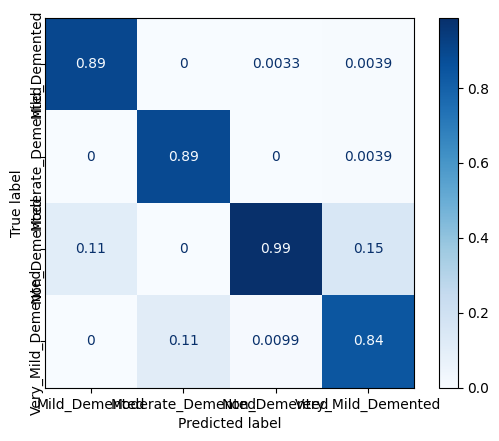

<Figure size 500x500 with 0 Axes>

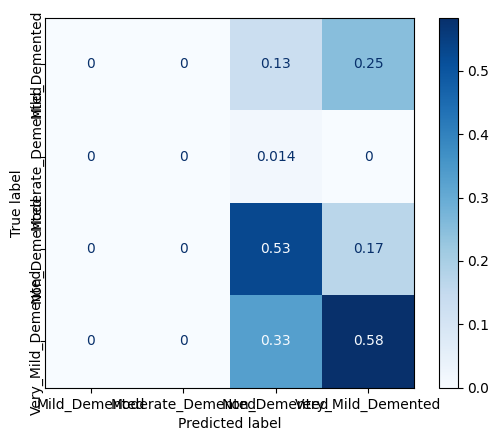

<Figure size 500x500 with 0 Axes>

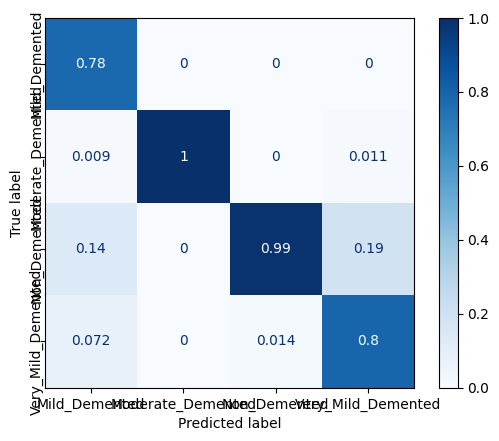

<Figure size 500x500 with 0 Axes>

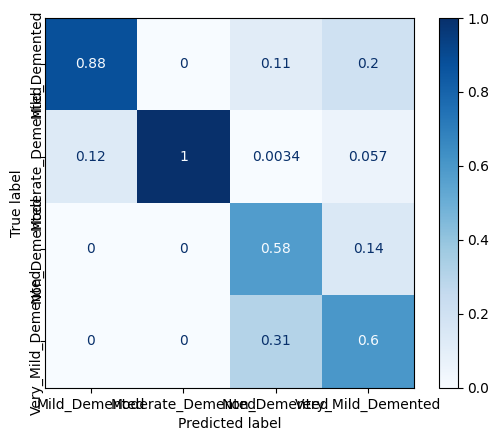

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet101.zip ./*